## 기본 베이지 DNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold

In [2]:
%matplotlib inline

In [3]:
df=pd.read_excel('./optimal_data3_1/'+'Continous_2weeks_2day_1term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (58825, 6) (58825,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (166896, 6) (166896,)
SMOTE 적용 전 레이블 값 분포: 
 0    55632
1     2010
2     1183
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    55632
1    55632
2    55632
Name: 8, dtype: int64


In [4]:
X = torch.FloatTensor(X_train_over)
y = torch.LongTensor(y_train_over)

dataset = TensorDataset(X, y)

In [5]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

In [6]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [7]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)
        lbl = lbl.squeeze()
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()

        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [8]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)
    
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            lbl = lbl.squeeze()

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
    
        acc = corr / len(test_subsampler)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [9]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)
            lbl = lbl.squeeze()
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(test_subsampler)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [ ]:
 cross_val_list=[]

In [10]:
 # K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=10000, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=5000, sampler=test_subsampler)

    # 최대 Epoch을 지정합니다.
    num_epochs = 1000
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, trainloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, testloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))
    print(f'FOLD번째 정확도: {fold}')
    print('--------------------------------')
    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    final_loss, final_acc, pred_list = model_test(model, testloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')
    cross_val_list.append(final_acc)

FOLD 0
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.42it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.11580. Saving Model!
epoch 01, loss: 0.95814, acc: 0.37590, val_loss: 0.11580, val_accuracy: 0.47106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.00it/s]


[INFO] val_acc has been improved from 0.11580 to 0.11059. Saving Model!
epoch 02, loss: 0.92439, acc: 0.41606, val_loss: 0.11059, val_accuracy: 0.51246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


[INFO] val_acc has been improved from 0.11059 to 0.10135. Saving Model!
epoch 03, loss: 0.90031, acc: 0.42810, val_loss: 0.10135, val_accuracy: 0.57292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90it/s]


[INFO] val_acc has been improved from 0.10135 to 0.10116. Saving Model!
epoch 04, loss: 0.88414, acc: 0.43284, val_loss: 0.10116, val_accuracy: 0.58041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.80it/s]


epoch 05, loss: 0.86884, acc: 0.44513, val_loss: 0.11100, val_accuracy: 0.51204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 06, loss: 0.85083, acc: 0.46582, val_loss: 0.11104, val_accuracy: 0.52091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.98it/s]


epoch 07, loss: 0.83369, acc: 0.48433, val_loss: 0.11042, val_accuracy: 0.57705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.77it/s]


epoch 08, loss: 0.81714, acc: 0.49931, val_loss: 0.11815, val_accuracy: 0.54314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 09, loss: 0.80330, acc: 0.50869, val_loss: 0.12742, val_accuracy: 0.52762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 10, loss: 0.79165, acc: 0.51413, val_loss: 0.11092, val_accuracy: 0.56040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.98it/s]


epoch 11, loss: 0.77788, acc: 0.52350, val_loss: 0.14661, val_accuracy: 0.43014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 12, loss: 0.77136, acc: 0.52932, val_loss: 0.10624, val_accuracy: 0.58466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 13, loss: 0.75700, acc: 0.53880, val_loss: 0.14265, val_accuracy: 0.43421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 14, loss: 0.74549, acc: 0.54689, val_loss: 0.13824, val_accuracy: 0.43505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 15, loss: 0.73286, acc: 0.55826, val_loss: 0.11790, val_accuracy: 0.54218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.99it/s]


epoch 16, loss: 0.72789, acc: 0.55956, val_loss: 0.14384, val_accuracy: 0.46411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.91it/s]


epoch 17, loss: 0.71699, acc: 0.56738, val_loss: 0.13949, val_accuracy: 0.46022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 18, loss: 0.70895, acc: 0.57228, val_loss: 0.14940, val_accuracy: 0.46345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 19, loss: 0.70286, acc: 0.57777, val_loss: 0.16266, val_accuracy: 0.42187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 20, loss: 0.69993, acc: 0.58021, val_loss: 0.16132, val_accuracy: 0.44212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 21, loss: 0.69290, acc: 0.58328, val_loss: 0.18514, val_accuracy: 0.36064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 22, loss: 0.68930, acc: 0.58622, val_loss: 0.12412, val_accuracy: 0.54374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 23, loss: 0.67929, acc: 0.59302, val_loss: 0.16527, val_accuracy: 0.40395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.02it/s]


epoch 24, loss: 0.66674, acc: 0.60128, val_loss: 0.13963, val_accuracy: 0.47741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 25, loss: 0.66202, acc: 0.60570, val_loss: 0.14879, val_accuracy: 0.47645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


epoch 26, loss: 0.65668, acc: 0.60989, val_loss: 0.12535, val_accuracy: 0.58796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 27, loss: 0.65426, acc: 0.61009, val_loss: 0.12243, val_accuracy: 0.58274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 28, loss: 0.64754, acc: 0.61461, val_loss: 0.14638, val_accuracy: 0.51282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 29, loss: 0.63588, acc: 0.62407, val_loss: 0.16218, val_accuracy: 0.46183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 30, loss: 0.63154, acc: 0.62632, val_loss: 0.14523, val_accuracy: 0.50455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 31, loss: 0.63524, acc: 0.62002, val_loss: 0.18221, val_accuracy: 0.42642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 32, loss: 0.62715, acc: 0.62671, val_loss: 0.19583, val_accuracy: 0.40413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 33, loss: 0.62229, acc: 0.62903, val_loss: 0.18591, val_accuracy: 0.40054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 34, loss: 0.62034, acc: 0.63006, val_loss: 0.17993, val_accuracy: 0.40078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


epoch 35, loss: 0.61185, acc: 0.63659, val_loss: 0.16324, val_accuracy: 0.45620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.32it/s]


epoch 36, loss: 0.60238, acc: 0.64347, val_loss: 0.14652, val_accuracy: 0.49521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 37, loss: 0.60393, acc: 0.63934, val_loss: 0.13989, val_accuracy: 0.55327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.98it/s]


epoch 38, loss: 0.59658, acc: 0.64574, val_loss: 0.15298, val_accuracy: 0.48814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


epoch 39, loss: 0.59202, acc: 0.64792, val_loss: 0.18373, val_accuracy: 0.46339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.97it/s]


epoch 40, loss: 0.58964, acc: 0.64841, val_loss: 0.18109, val_accuracy: 0.45482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


epoch 41, loss: 0.58197, acc: 0.65392, val_loss: 0.16938, val_accuracy: 0.45339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 42, loss: 0.58629, acc: 0.65094, val_loss: 0.18047, val_accuracy: 0.43925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 43, loss: 0.58197, acc: 0.65277, val_loss: 0.16105, val_accuracy: 0.47448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 44, loss: 0.58500, acc: 0.64958, val_loss: 0.18806, val_accuracy: 0.42618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 45, loss: 0.57683, acc: 0.65785, val_loss: 0.18568, val_accuracy: 0.48520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 46, loss: 0.56493, acc: 0.66450, val_loss: 0.17227, val_accuracy: 0.48622


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 47, loss: 0.56523, acc: 0.66277, val_loss: 0.17643, val_accuracy: 0.46992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 48, loss: 0.55633, acc: 0.66928, val_loss: 0.19840, val_accuracy: 0.43469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 49, loss: 0.56107, acc: 0.66561, val_loss: 0.17889, val_accuracy: 0.48969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


epoch 50, loss: 0.56622, acc: 0.66113, val_loss: 0.17640, val_accuracy: 0.48700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 51, loss: 0.55036, acc: 0.67204, val_loss: 0.15305, val_accuracy: 0.52409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 52, loss: 0.54324, acc: 0.67809, val_loss: 0.17061, val_accuracy: 0.52079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 53, loss: 0.54272, acc: 0.67638, val_loss: 0.15018, val_accuracy: 0.56117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 54, loss: 0.54774, acc: 0.67506, val_loss: 0.24184, val_accuracy: 0.31114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 55, loss: 0.55758, acc: 0.66561, val_loss: 0.22156, val_accuracy: 0.37519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 56, loss: 0.53883, acc: 0.67823, val_loss: 0.20403, val_accuracy: 0.45434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 57, loss: 0.53143, acc: 0.68500, val_loss: 0.16046, val_accuracy: 0.54943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 58, loss: 0.52258, acc: 0.68997, val_loss: 0.15097, val_accuracy: 0.53223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.77it/s]


epoch 59, loss: 0.53341, acc: 0.68153, val_loss: 0.19893, val_accuracy: 0.45159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 60, loss: 0.52100, acc: 0.68827, val_loss: 0.16299, val_accuracy: 0.49329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 61, loss: 0.54364, acc: 0.67075, val_loss: 0.14985, val_accuracy: 0.55770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 62, loss: 0.52973, acc: 0.68201, val_loss: 0.19096, val_accuracy: 0.46687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 63, loss: 0.51272, acc: 0.69362, val_loss: 0.17566, val_accuracy: 0.49658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 64, loss: 0.51125, acc: 0.69347, val_loss: 0.23022, val_accuracy: 0.39401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 65, loss: 0.52051, acc: 0.68805, val_loss: 0.21210, val_accuracy: 0.42894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 66, loss: 0.51215, acc: 0.69324, val_loss: 0.20270, val_accuracy: 0.45177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 67, loss: 0.50723, acc: 0.69417, val_loss: 0.18928, val_accuracy: 0.48586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.93it/s]


epoch 68, loss: 0.50328, acc: 0.69890, val_loss: 0.17842, val_accuracy: 0.47663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 69, loss: 0.50517, acc: 0.69477, val_loss: 0.19008, val_accuracy: 0.43859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 70, loss: 0.49795, acc: 0.70008, val_loss: 0.16858, val_accuracy: 0.52145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 71, loss: 0.49338, acc: 0.70272, val_loss: 0.18159, val_accuracy: 0.48083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 72, loss: 0.49610, acc: 0.69951, val_loss: 0.19874, val_accuracy: 0.47561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 73, loss: 0.49445, acc: 0.70027, val_loss: 0.16792, val_accuracy: 0.53948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 74, loss: 0.49026, acc: 0.70288, val_loss: 0.20609, val_accuracy: 0.45602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 75, loss: 0.49690, acc: 0.69779, val_loss: 0.16319, val_accuracy: 0.51037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 76, loss: 0.49368, acc: 0.70136, val_loss: 0.19301, val_accuracy: 0.47244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 77, loss: 0.50273, acc: 0.69279, val_loss: 0.18142, val_accuracy: 0.51857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 78, loss: 0.48795, acc: 0.70277, val_loss: 0.18608, val_accuracy: 0.48796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.01it/s]


epoch 79, loss: 0.48363, acc: 0.70522, val_loss: 0.19025, val_accuracy: 0.44895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 80, loss: 0.49018, acc: 0.70017, val_loss: 0.18638, val_accuracy: 0.50911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


epoch 81, loss: 0.47674, acc: 0.71011, val_loss: 0.21670, val_accuracy: 0.40737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 82, loss: 0.48328, acc: 0.70485, val_loss: 0.19099, val_accuracy: 0.45644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 83, loss: 0.47975, acc: 0.70750, val_loss: 0.20145, val_accuracy: 0.50198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90it/s]


epoch 84, loss: 0.48556, acc: 0.70159, val_loss: 0.20083, val_accuracy: 0.47603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 85, loss: 0.46907, acc: 0.71413, val_loss: 0.19782, val_accuracy: 0.45638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


epoch 86, loss: 0.47422, acc: 0.70875, val_loss: 0.21233, val_accuracy: 0.46633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 87, loss: 0.47446, acc: 0.70917, val_loss: 0.19412, val_accuracy: 0.53445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s]


epoch 88, loss: 0.46350, acc: 0.71697, val_loss: 0.21537, val_accuracy: 0.44859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 89, loss: 0.46902, acc: 0.71254, val_loss: 0.15613, val_accuracy: 0.57555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.88it/s]


epoch 90, loss: 0.50000, acc: 0.69238, val_loss: 0.18268, val_accuracy: 0.50725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 91, loss: 0.47480, acc: 0.70706, val_loss: 0.21206, val_accuracy: 0.46417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 92, loss: 0.46030, acc: 0.71772, val_loss: 0.21303, val_accuracy: 0.47490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 93, loss: 0.47267, acc: 0.70915, val_loss: 0.22035, val_accuracy: 0.44799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 94, loss: 0.45535, acc: 0.71992, val_loss: 0.18033, val_accuracy: 0.52427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 95, loss: 0.45294, acc: 0.72131, val_loss: 0.21473, val_accuracy: 0.41282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 96, loss: 0.45118, acc: 0.72333, val_loss: 0.16514, val_accuracy: 0.56040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 97, loss: 0.45865, acc: 0.71740, val_loss: 0.19633, val_accuracy: 0.49521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


epoch 98, loss: 0.45640, acc: 0.71854, val_loss: 0.20833, val_accuracy: 0.44386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 99, loss: 0.46255, acc: 0.71303, val_loss: 0.22932, val_accuracy: 0.44218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 100, loss: 0.46246, acc: 0.71523, val_loss: 0.15820, val_accuracy: 0.58125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 101, loss: 0.46198, acc: 0.71448, val_loss: 0.25637, val_accuracy: 0.37118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 102, loss: 0.45333, acc: 0.72086, val_loss: 0.19489, val_accuracy: 0.53391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 103, loss: 0.44227, acc: 0.72600, val_loss: 0.19100, val_accuracy: 0.52043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


epoch 104, loss: 0.44147, acc: 0.72754, val_loss: 0.23309, val_accuracy: 0.40539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 105, loss: 0.44637, acc: 0.72329, val_loss: 0.18676, val_accuracy: 0.52540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 106, loss: 0.44851, acc: 0.72158, val_loss: 0.22781, val_accuracy: 0.41869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


epoch 107, loss: 0.43942, acc: 0.72846, val_loss: 0.20745, val_accuracy: 0.47112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 108, loss: 0.43424, acc: 0.73093, val_loss: 0.17526, val_accuracy: 0.55207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 109, loss: 0.44109, acc: 0.72633, val_loss: 0.22114, val_accuracy: 0.43361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 110, loss: 0.43568, acc: 0.72823, val_loss: 0.18880, val_accuracy: 0.54596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 111, loss: 0.44251, acc: 0.72563, val_loss: 0.19956, val_accuracy: 0.52966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 112, loss: 0.43390, acc: 0.73027, val_loss: 0.22031, val_accuracy: 0.40162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.94it/s]


epoch 113, loss: 0.44628, acc: 0.72316, val_loss: 0.19045, val_accuracy: 0.51426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 114, loss: 0.43654, acc: 0.72663, val_loss: 0.22132, val_accuracy: 0.43116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 115, loss: 0.44268, acc: 0.72372, val_loss: 0.20424, val_accuracy: 0.48616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 116, loss: 0.42987, acc: 0.73268, val_loss: 0.19136, val_accuracy: 0.46735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 117, loss: 0.43519, acc: 0.72833, val_loss: 0.20307, val_accuracy: 0.46135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 118, loss: 0.43392, acc: 0.72965, val_loss: 0.25140, val_accuracy: 0.39539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 119, loss: 0.43389, acc: 0.72859, val_loss: 0.14800, val_accuracy: 0.59233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 120, loss: 0.44468, acc: 0.72165, val_loss: 0.24079, val_accuracy: 0.41462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 121, loss: 0.42619, acc: 0.73310, val_loss: 0.22723, val_accuracy: 0.43493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.48it/s]


epoch 122, loss: 0.42724, acc: 0.73102, val_loss: 0.20167, val_accuracy: 0.48316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 123, loss: 0.41976, acc: 0.73668, val_loss: 0.21766, val_accuracy: 0.47070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.01it/s]


epoch 124, loss: 0.41762, acc: 0.73807, val_loss: 0.20537, val_accuracy: 0.44691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.45it/s]


epoch 125, loss: 0.41733, acc: 0.73726, val_loss: 0.19629, val_accuracy: 0.47016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 126, loss: 0.41815, acc: 0.73797, val_loss: 0.19231, val_accuracy: 0.51899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 127, loss: 0.41518, acc: 0.73987, val_loss: 0.23823, val_accuracy: 0.42948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.00it/s]


epoch 128, loss: 0.41475, acc: 0.73842, val_loss: 0.23229, val_accuracy: 0.46818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 129, loss: 0.41168, acc: 0.74125, val_loss: 0.17547, val_accuracy: 0.52708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 130, loss: 0.43381, acc: 0.72679, val_loss: 0.18376, val_accuracy: 0.48203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 131, loss: 0.42443, acc: 0.73262, val_loss: 0.21919, val_accuracy: 0.46980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 132, loss: 0.43010, acc: 0.72775, val_loss: 0.18435, val_accuracy: 0.54673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 133, loss: 0.41691, acc: 0.73694, val_loss: 0.22103, val_accuracy: 0.48622


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 134, loss: 0.40871, acc: 0.74156, val_loss: 0.22821, val_accuracy: 0.42325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 135, loss: 0.42179, acc: 0.73273, val_loss: 0.21286, val_accuracy: 0.44913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.98it/s]


epoch 136, loss: 0.40929, acc: 0.74098, val_loss: 0.23143, val_accuracy: 0.42762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 137, loss: 0.42183, acc: 0.73295, val_loss: 0.23553, val_accuracy: 0.45848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 138, loss: 0.41478, acc: 0.73914, val_loss: 0.20444, val_accuracy: 0.49089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.00it/s]


epoch 139, loss: 0.40968, acc: 0.73972, val_loss: 0.23788, val_accuracy: 0.47561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


epoch 140, loss: 0.40427, acc: 0.74406, val_loss: 0.17850, val_accuracy: 0.55752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 141, loss: 0.41082, acc: 0.74007, val_loss: 0.22358, val_accuracy: 0.46357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 142, loss: 0.43273, acc: 0.72643, val_loss: 0.21443, val_accuracy: 0.48083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 143, loss: 0.40225, acc: 0.74359, val_loss: 0.21661, val_accuracy: 0.48382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 144, loss: 0.40327, acc: 0.74341, val_loss: 0.22954, val_accuracy: 0.47472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 145, loss: 0.40066, acc: 0.74565, val_loss: 0.24291, val_accuracy: 0.42792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 146, loss: 0.41025, acc: 0.74066, val_loss: 0.28681, val_accuracy: 0.37166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 147, loss: 0.40762, acc: 0.74209, val_loss: 0.17338, val_accuracy: 0.55596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 148, loss: 0.40771, acc: 0.74225, val_loss: 0.21470, val_accuracy: 0.51672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


epoch 149, loss: 0.40569, acc: 0.74103, val_loss: 0.22642, val_accuracy: 0.47711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 150, loss: 0.40798, acc: 0.73826, val_loss: 0.20591, val_accuracy: 0.50923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 151, loss: 0.39911, acc: 0.74663, val_loss: 0.22931, val_accuracy: 0.47184


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.70it/s]


epoch 152, loss: 0.39759, acc: 0.74642, val_loss: 0.24136, val_accuracy: 0.42337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 153, loss: 0.39523, acc: 0.74820, val_loss: 0.27840, val_accuracy: 0.37843


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 154, loss: 0.40461, acc: 0.74250, val_loss: 0.23319, val_accuracy: 0.45428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 155, loss: 0.39877, acc: 0.74531, val_loss: 0.16646, val_accuracy: 0.57220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 156, loss: 0.40497, acc: 0.74280, val_loss: 0.23971, val_accuracy: 0.44158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 157, loss: 0.39949, acc: 0.74335, val_loss: 0.21366, val_accuracy: 0.47052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 158, loss: 0.39788, acc: 0.74541, val_loss: 0.20400, val_accuracy: 0.49838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 159, loss: 0.39089, acc: 0.74978, val_loss: 0.23928, val_accuracy: 0.43787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 160, loss: 0.39254, acc: 0.74700, val_loss: 0.21970, val_accuracy: 0.49365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 161, loss: 0.41548, acc: 0.73425, val_loss: 0.24061, val_accuracy: 0.48352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 162, loss: 0.38599, acc: 0.75185, val_loss: 0.23767, val_accuracy: 0.46860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 163, loss: 0.38593, acc: 0.75164, val_loss: 0.22042, val_accuracy: 0.49826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


epoch 164, loss: 0.38994, acc: 0.74962, val_loss: 0.23230, val_accuracy: 0.48496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 165, loss: 0.38577, acc: 0.75089, val_loss: 0.22608, val_accuracy: 0.49413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.98it/s]


epoch 166, loss: 0.38776, acc: 0.75014, val_loss: 0.22648, val_accuracy: 0.49742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 167, loss: 0.38300, acc: 0.75351, val_loss: 0.25324, val_accuracy: 0.44170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 168, loss: 0.39010, acc: 0.74996, val_loss: 0.19017, val_accuracy: 0.50935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 169, loss: 0.38313, acc: 0.75158, val_loss: 0.24607, val_accuracy: 0.41546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90it/s]


epoch 170, loss: 0.38735, acc: 0.75141, val_loss: 0.20646, val_accuracy: 0.48874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 171, loss: 0.38478, acc: 0.75088, val_loss: 0.26590, val_accuracy: 0.41971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 172, loss: 0.38414, acc: 0.75297, val_loss: 0.22357, val_accuracy: 0.48963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 173, loss: 0.38177, acc: 0.75310, val_loss: 0.22407, val_accuracy: 0.51031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 174, loss: 0.38314, acc: 0.75282, val_loss: 0.23995, val_accuracy: 0.45542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 175, loss: 0.38409, acc: 0.75283, val_loss: 0.21068, val_accuracy: 0.51240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 176, loss: 0.38486, acc: 0.75196, val_loss: 0.26918, val_accuracy: 0.42522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 177, loss: 0.38969, acc: 0.74923, val_loss: 0.22209, val_accuracy: 0.46609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.02it/s]


epoch 178, loss: 0.38735, acc: 0.74947, val_loss: 0.25676, val_accuracy: 0.44578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.72it/s]


epoch 179, loss: 0.37195, acc: 0.75921, val_loss: 0.25109, val_accuracy: 0.47106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 180, loss: 0.38735, acc: 0.75003, val_loss: 0.22097, val_accuracy: 0.47825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 181, loss: 0.38425, acc: 0.75062, val_loss: 0.25825, val_accuracy: 0.39431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 182, loss: 0.39358, acc: 0.74604, val_loss: 0.23281, val_accuracy: 0.47693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.01it/s]


epoch 183, loss: 0.37052, acc: 0.76043, val_loss: 0.22001, val_accuracy: 0.48712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 184, loss: 0.37794, acc: 0.75590, val_loss: 0.24528, val_accuracy: 0.46285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 185, loss: 0.37112, acc: 0.75983, val_loss: 0.20223, val_accuracy: 0.52379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 186, loss: 0.38042, acc: 0.75455, val_loss: 0.23213, val_accuracy: 0.45231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 187, loss: 0.37793, acc: 0.75521, val_loss: 0.26290, val_accuracy: 0.42732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.73it/s]


epoch 188, loss: 0.38560, acc: 0.74912, val_loss: 0.23724, val_accuracy: 0.49485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 189, loss: 0.37643, acc: 0.75689, val_loss: 0.22148, val_accuracy: 0.48754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.51it/s]


epoch 190, loss: 0.36749, acc: 0.76052, val_loss: 0.20185, val_accuracy: 0.52852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 191, loss: 0.37335, acc: 0.75551, val_loss: 0.21881, val_accuracy: 0.49461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 192, loss: 0.37819, acc: 0.75235, val_loss: 0.22021, val_accuracy: 0.48448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 193, loss: 0.37913, acc: 0.75357, val_loss: 0.23179, val_accuracy: 0.47795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


epoch 194, loss: 0.39834, acc: 0.74188, val_loss: 0.24666, val_accuracy: 0.48694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 195, loss: 0.37146, acc: 0.75854, val_loss: 0.22094, val_accuracy: 0.50437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 196, loss: 0.36613, acc: 0.76137, val_loss: 0.18346, val_accuracy: 0.54212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.77it/s]


epoch 197, loss: 0.38447, acc: 0.74996, val_loss: 0.21369, val_accuracy: 0.51612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 198, loss: 0.36574, acc: 0.76124, val_loss: 0.24053, val_accuracy: 0.48328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 199, loss: 0.36312, acc: 0.76146, val_loss: 0.22276, val_accuracy: 0.47933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 200, loss: 0.36183, acc: 0.76231, val_loss: 0.22035, val_accuracy: 0.49389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 201, loss: 0.37370, acc: 0.75660, val_loss: 0.23608, val_accuracy: 0.48748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 202, loss: 0.36921, acc: 0.75977, val_loss: 0.23268, val_accuracy: 0.50300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.70it/s]


epoch 203, loss: 0.36170, acc: 0.76249, val_loss: 0.27087, val_accuracy: 0.41995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 204, loss: 0.37630, acc: 0.75424, val_loss: 0.27045, val_accuracy: 0.44853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


epoch 205, loss: 0.36956, acc: 0.75736, val_loss: 0.24176, val_accuracy: 0.45968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


epoch 206, loss: 0.36036, acc: 0.76227, val_loss: 0.23672, val_accuracy: 0.48886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 207, loss: 0.35823, acc: 0.76406, val_loss: 0.22075, val_accuracy: 0.51540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 208, loss: 0.36835, acc: 0.75690, val_loss: 0.25774, val_accuracy: 0.44218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 209, loss: 0.35829, acc: 0.76482, val_loss: 0.25613, val_accuracy: 0.49449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.96it/s]


epoch 210, loss: 0.35781, acc: 0.76429, val_loss: 0.22111, val_accuracy: 0.49347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 211, loss: 0.37278, acc: 0.75605, val_loss: 0.21268, val_accuracy: 0.50455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 212, loss: 0.36801, acc: 0.75932, val_loss: 0.27272, val_accuracy: 0.42726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 213, loss: 0.35748, acc: 0.76576, val_loss: 0.26836, val_accuracy: 0.42840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 214, loss: 0.37188, acc: 0.75711, val_loss: 0.20080, val_accuracy: 0.53475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.87it/s]


epoch 215, loss: 0.36279, acc: 0.76074, val_loss: 0.22640, val_accuracy: 0.50318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 216, loss: 0.35781, acc: 0.76381, val_loss: 0.21959, val_accuracy: 0.50881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 217, loss: 0.37913, acc: 0.74869, val_loss: 0.24884, val_accuracy: 0.46111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 218, loss: 0.35457, acc: 0.76556, val_loss: 0.24959, val_accuracy: 0.43847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 219, loss: 0.35284, acc: 0.76719, val_loss: 0.25024, val_accuracy: 0.45728


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 220, loss: 0.35029, acc: 0.76877, val_loss: 0.29135, val_accuracy: 0.41857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.88it/s]


epoch 221, loss: 0.35748, acc: 0.76420, val_loss: 0.25473, val_accuracy: 0.45698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 222, loss: 0.36281, acc: 0.75925, val_loss: 0.23842, val_accuracy: 0.47675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 223, loss: 0.37282, acc: 0.75478, val_loss: 0.27028, val_accuracy: 0.44608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.86it/s]


epoch 224, loss: 0.35218, acc: 0.76733, val_loss: 0.25558, val_accuracy: 0.47490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 225, loss: 0.35555, acc: 0.76578, val_loss: 0.29004, val_accuracy: 0.43277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 226, loss: 0.35861, acc: 0.76304, val_loss: 0.27548, val_accuracy: 0.47879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 227, loss: 0.35634, acc: 0.76481, val_loss: 0.23650, val_accuracy: 0.50168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 228, loss: 0.34707, acc: 0.77065, val_loss: 0.22639, val_accuracy: 0.49365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 229, loss: 0.35512, acc: 0.76594, val_loss: 0.28412, val_accuracy: 0.45992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 230, loss: 0.35344, acc: 0.76523, val_loss: 0.25694, val_accuracy: 0.47142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 231, loss: 0.35680, acc: 0.76246, val_loss: 0.27678, val_accuracy: 0.46231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 232, loss: 0.35872, acc: 0.76165, val_loss: 0.26550, val_accuracy: 0.46920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.86it/s]


epoch 233, loss: 0.34721, acc: 0.76890, val_loss: 0.25238, val_accuracy: 0.46974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 234, loss: 0.34896, acc: 0.76836, val_loss: 0.26655, val_accuracy: 0.44092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 235, loss: 0.35202, acc: 0.76554, val_loss: 0.24292, val_accuracy: 0.48772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 236, loss: 0.34691, acc: 0.76868, val_loss: 0.23975, val_accuracy: 0.51354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 237, loss: 0.34677, acc: 0.76831, val_loss: 0.26258, val_accuracy: 0.43787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 238, loss: 0.35867, acc: 0.76143, val_loss: 0.23488, val_accuracy: 0.47166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 239, loss: 0.36678, acc: 0.75757, val_loss: 0.27168, val_accuracy: 0.42648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 240, loss: 0.34503, acc: 0.76990, val_loss: 0.26146, val_accuracy: 0.44374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 241, loss: 0.39273, acc: 0.75354, val_loss: 0.21146, val_accuracy: 0.53092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.70it/s]


epoch 242, loss: 0.35327, acc: 0.76696, val_loss: 0.27470, val_accuracy: 0.43361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 243, loss: 0.37479, acc: 0.76241, val_loss: 0.23305, val_accuracy: 0.47154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 244, loss: 0.35227, acc: 0.76645, val_loss: 0.26743, val_accuracy: 0.45986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 245, loss: 0.34602, acc: 0.76934, val_loss: 0.24478, val_accuracy: 0.51570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.95it/s]


epoch 246, loss: 0.34722, acc: 0.76754, val_loss: 0.31830, val_accuracy: 0.41492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 247, loss: 0.36074, acc: 0.76199, val_loss: 0.24557, val_accuracy: 0.47531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.53it/s]


epoch 248, loss: 0.34463, acc: 0.77019, val_loss: 0.22495, val_accuracy: 0.49617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.88it/s]


epoch 249, loss: 0.33552, acc: 0.77394, val_loss: 0.20809, val_accuracy: 0.51055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 250, loss: 0.33980, acc: 0.77232, val_loss: 0.22154, val_accuracy: 0.52073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.68it/s]


epoch 251, loss: 0.35240, acc: 0.76594, val_loss: 0.21054, val_accuracy: 0.51090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 252, loss: 0.34923, acc: 0.76623, val_loss: 0.26679, val_accuracy: 0.44883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 253, loss: 0.34704, acc: 0.76692, val_loss: 0.24567, val_accuracy: 0.45698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 254, loss: 0.33821, acc: 0.77285, val_loss: 0.21449, val_accuracy: 0.50749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 255, loss: 0.34122, acc: 0.77125, val_loss: 0.23713, val_accuracy: 0.50204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.27it/s]


epoch 256, loss: 0.33697, acc: 0.77286, val_loss: 0.24375, val_accuracy: 0.48562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 257, loss: 0.33588, acc: 0.77383, val_loss: 0.23599, val_accuracy: 0.50809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 258, loss: 0.33626, acc: 0.77357, val_loss: 0.27020, val_accuracy: 0.44925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 259, loss: 0.37299, acc: 0.75632, val_loss: 0.26543, val_accuracy: 0.46357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.70it/s]


epoch 260, loss: 0.36144, acc: 0.75903, val_loss: 0.29012, val_accuracy: 0.42660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 261, loss: 0.34987, acc: 0.76685, val_loss: 0.22718, val_accuracy: 0.48898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 262, loss: 0.34878, acc: 0.76559, val_loss: 0.26343, val_accuracy: 0.45746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 263, loss: 0.34628, acc: 0.76590, val_loss: 0.22586, val_accuracy: 0.51762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 264, loss: 0.34159, acc: 0.76993, val_loss: 0.23943, val_accuracy: 0.49269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 265, loss: 0.33799, acc: 0.77046, val_loss: 0.28894, val_accuracy: 0.41786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 266, loss: 0.33250, acc: 0.77561, val_loss: 0.25881, val_accuracy: 0.48850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 267, loss: 0.32965, acc: 0.77668, val_loss: 0.24205, val_accuracy: 0.48268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 268, loss: 0.33502, acc: 0.77370, val_loss: 0.24139, val_accuracy: 0.50407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


epoch 269, loss: 0.32862, acc: 0.77790, val_loss: 0.26863, val_accuracy: 0.47232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 270, loss: 0.33432, acc: 0.77484, val_loss: 0.27362, val_accuracy: 0.46465


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 271, loss: 0.33327, acc: 0.77554, val_loss: 0.25633, val_accuracy: 0.50108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 272, loss: 0.32865, acc: 0.77869, val_loss: 0.23714, val_accuracy: 0.50875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 273, loss: 0.33237, acc: 0.77546, val_loss: 0.23686, val_accuracy: 0.47561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 274, loss: 0.33516, acc: 0.77276, val_loss: 0.27858, val_accuracy: 0.44494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90it/s]


epoch 275, loss: 0.34842, acc: 0.76565, val_loss: 0.27477, val_accuracy: 0.46285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 276, loss: 0.33843, acc: 0.77129, val_loss: 0.25937, val_accuracy: 0.42660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 277, loss: 0.35290, acc: 0.76231, val_loss: 0.25883, val_accuracy: 0.47591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 278, loss: 0.33214, acc: 0.77488, val_loss: 0.27736, val_accuracy: 0.45800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 279, loss: 0.33179, acc: 0.77506, val_loss: 0.25506, val_accuracy: 0.46669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 280, loss: 0.32785, acc: 0.77620, val_loss: 0.24714, val_accuracy: 0.48101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 281, loss: 0.32593, acc: 0.77870, val_loss: 0.27116, val_accuracy: 0.43901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 282, loss: 0.34166, acc: 0.76822, val_loss: 0.28793, val_accuracy: 0.43092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 283, loss: 0.34974, acc: 0.76456, val_loss: 0.26145, val_accuracy: 0.48017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 284, loss: 0.32731, acc: 0.77642, val_loss: 0.27680, val_accuracy: 0.43787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.26it/s]


epoch 285, loss: 0.34718, acc: 0.76665, val_loss: 0.26455, val_accuracy: 0.46860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 286, loss: 0.34891, acc: 0.76588, val_loss: 0.22283, val_accuracy: 0.51144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.77it/s]


epoch 287, loss: 0.34710, acc: 0.76767, val_loss: 0.26376, val_accuracy: 0.49772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.92it/s]


epoch 288, loss: 0.33366, acc: 0.77255, val_loss: 0.30784, val_accuracy: 0.42696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 289, loss: 0.32959, acc: 0.77674, val_loss: 0.20880, val_accuracy: 0.53769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 290, loss: 0.33395, acc: 0.77415, val_loss: 0.23588, val_accuracy: 0.49724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.92it/s]


epoch 291, loss: 0.32681, acc: 0.77713, val_loss: 0.24160, val_accuracy: 0.50659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 292, loss: 0.33910, acc: 0.77058, val_loss: 0.28055, val_accuracy: 0.44667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.87it/s]


epoch 293, loss: 0.32801, acc: 0.77784, val_loss: 0.25110, val_accuracy: 0.46824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 294, loss: 0.32423, acc: 0.77916, val_loss: 0.29050, val_accuracy: 0.45105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 295, loss: 0.32163, acc: 0.78172, val_loss: 0.31502, val_accuracy: 0.40773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


epoch 296, loss: 0.33302, acc: 0.77451, val_loss: 0.28718, val_accuracy: 0.46028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 297, loss: 0.33121, acc: 0.77476, val_loss: 0.26474, val_accuracy: 0.46639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 298, loss: 0.33031, acc: 0.77603, val_loss: 0.30763, val_accuracy: 0.43511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 299, loss: 0.32732, acc: 0.77819, val_loss: 0.27404, val_accuracy: 0.46447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 300, loss: 0.32154, acc: 0.77950, val_loss: 0.27269, val_accuracy: 0.46525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 301, loss: 0.33420, acc: 0.77279, val_loss: 0.24093, val_accuracy: 0.46788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 302, loss: 0.32227, acc: 0.77956, val_loss: 0.26598, val_accuracy: 0.52199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 303, loss: 0.33859, acc: 0.77011, val_loss: 0.22682, val_accuracy: 0.52223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 304, loss: 0.33043, acc: 0.77358, val_loss: 0.22441, val_accuracy: 0.51887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 305, loss: 0.31838, acc: 0.78234, val_loss: 0.22395, val_accuracy: 0.52031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 306, loss: 0.31878, acc: 0.78106, val_loss: 0.24933, val_accuracy: 0.50617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 307, loss: 0.31460, acc: 0.78375, val_loss: 0.25705, val_accuracy: 0.48095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 308, loss: 0.33595, acc: 0.77134, val_loss: 0.23649, val_accuracy: 0.52930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 309, loss: 0.32760, acc: 0.77598, val_loss: 0.24469, val_accuracy: 0.50899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 310, loss: 0.32594, acc: 0.77691, val_loss: 0.28372, val_accuracy: 0.46153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 311, loss: 0.31812, acc: 0.78152, val_loss: 0.22276, val_accuracy: 0.53445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 312, loss: 0.32260, acc: 0.77925, val_loss: 0.26437, val_accuracy: 0.46579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 313, loss: 0.32244, acc: 0.77813, val_loss: 0.19915, val_accuracy: 0.54949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.96it/s]


epoch 314, loss: 0.31710, acc: 0.78177, val_loss: 0.24957, val_accuracy: 0.49808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 315, loss: 0.31132, acc: 0.78603, val_loss: 0.25457, val_accuracy: 0.49491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 316, loss: 0.31205, acc: 0.78493, val_loss: 0.29336, val_accuracy: 0.42439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 317, loss: 0.32691, acc: 0.77564, val_loss: 0.29827, val_accuracy: 0.42618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 318, loss: 0.32473, acc: 0.77857, val_loss: 0.23749, val_accuracy: 0.50647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 319, loss: 0.31961, acc: 0.78025, val_loss: 0.23433, val_accuracy: 0.50018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 320, loss: 0.31966, acc: 0.78022, val_loss: 0.28534, val_accuracy: 0.47945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 321, loss: 0.32863, acc: 0.77389, val_loss: 0.28168, val_accuracy: 0.46603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 322, loss: 0.32565, acc: 0.77637, val_loss: 0.30434, val_accuracy: 0.41905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 323, loss: 0.31783, acc: 0.78162, val_loss: 0.22394, val_accuracy: 0.53008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 324, loss: 0.31855, acc: 0.78133, val_loss: 0.20277, val_accuracy: 0.55213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 325, loss: 0.33797, acc: 0.77045, val_loss: 0.23965, val_accuracy: 0.50042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 326, loss: 0.32134, acc: 0.77882, val_loss: 0.25975, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 327, loss: 0.33339, acc: 0.77101, val_loss: 0.24567, val_accuracy: 0.52493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 328, loss: 0.31454, acc: 0.78265, val_loss: 0.22130, val_accuracy: 0.50545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90it/s]


epoch 329, loss: 0.31743, acc: 0.78210, val_loss: 0.26227, val_accuracy: 0.48951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 330, loss: 0.31460, acc: 0.78365, val_loss: 0.26258, val_accuracy: 0.49377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 331, loss: 0.30995, acc: 0.78584, val_loss: 0.26374, val_accuracy: 0.48179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 332, loss: 0.31785, acc: 0.78095, val_loss: 0.18797, val_accuracy: 0.58029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 333, loss: 0.31888, acc: 0.78112, val_loss: 0.27305, val_accuracy: 0.44146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 334, loss: 0.32168, acc: 0.77875, val_loss: 0.22007, val_accuracy: 0.52025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 335, loss: 0.32521, acc: 0.77645, val_loss: 0.24934, val_accuracy: 0.51684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 336, loss: 0.31426, acc: 0.78237, val_loss: 0.29203, val_accuracy: 0.45309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 337, loss: 0.31485, acc: 0.78173, val_loss: 0.23387, val_accuracy: 0.53194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 338, loss: 0.31198, acc: 0.78487, val_loss: 0.27397, val_accuracy: 0.46351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 339, loss: 0.30875, acc: 0.78579, val_loss: 0.27050, val_accuracy: 0.47046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 340, loss: 0.30835, acc: 0.78618, val_loss: 0.24762, val_accuracy: 0.49617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 341, loss: 0.31360, acc: 0.78302, val_loss: 0.28457, val_accuracy: 0.48226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 342, loss: 0.32874, acc: 0.77340, val_loss: 0.23905, val_accuracy: 0.50767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 343, loss: 0.30770, acc: 0.78566, val_loss: 0.23557, val_accuracy: 0.53517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 344, loss: 0.31691, acc: 0.78001, val_loss: 0.23403, val_accuracy: 0.52487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 345, loss: 0.33858, acc: 0.76872, val_loss: 0.21975, val_accuracy: 0.52558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 346, loss: 0.32007, acc: 0.77959, val_loss: 0.28391, val_accuracy: 0.46010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 347, loss: 0.31787, acc: 0.78107, val_loss: 0.30798, val_accuracy: 0.43649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 348, loss: 0.32065, acc: 0.77877, val_loss: 0.24700, val_accuracy: 0.49209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 349, loss: 0.31199, acc: 0.78414, val_loss: 0.25675, val_accuracy: 0.48718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 350, loss: 0.31327, acc: 0.78282, val_loss: 0.32169, val_accuracy: 0.40054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 351, loss: 0.33879, acc: 0.76908, val_loss: 0.27239, val_accuracy: 0.46309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 352, loss: 0.31465, acc: 0.78225, val_loss: 0.26515, val_accuracy: 0.46884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 353, loss: 0.32540, acc: 0.77551, val_loss: 0.25671, val_accuracy: 0.49455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 354, loss: 0.30485, acc: 0.78723, val_loss: 0.27245, val_accuracy: 0.50959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.96it/s]


epoch 355, loss: 0.31089, acc: 0.78306, val_loss: 0.19570, val_accuracy: 0.56956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 356, loss: 0.32255, acc: 0.78015, val_loss: 0.24602, val_accuracy: 0.50312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 357, loss: 0.31107, acc: 0.78416, val_loss: 0.28900, val_accuracy: 0.45722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 358, loss: 0.32700, acc: 0.77548, val_loss: 0.25987, val_accuracy: 0.49670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 359, loss: 0.31226, acc: 0.78371, val_loss: 0.21478, val_accuracy: 0.51013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 360, loss: 0.32441, acc: 0.77507, val_loss: 0.27287, val_accuracy: 0.47537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 361, loss: 0.31063, acc: 0.78291, val_loss: 0.27114, val_accuracy: 0.46890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 362, loss: 0.30336, acc: 0.78863, val_loss: 0.19969, val_accuracy: 0.56267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 363, loss: 0.31725, acc: 0.78168, val_loss: 0.24999, val_accuracy: 0.51276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 364, loss: 0.30634, acc: 0.78739, val_loss: 0.28079, val_accuracy: 0.45578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 365, loss: 0.29812, acc: 0.79142, val_loss: 0.27160, val_accuracy: 0.48730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 366, loss: 0.29924, acc: 0.79020, val_loss: 0.29605, val_accuracy: 0.46081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 367, loss: 0.30199, acc: 0.78843, val_loss: 0.22170, val_accuracy: 0.52618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 368, loss: 0.31404, acc: 0.78256, val_loss: 0.28371, val_accuracy: 0.45123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 369, loss: 0.30911, acc: 0.78427, val_loss: 0.26392, val_accuracy: 0.50371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 370, loss: 0.29797, acc: 0.79097, val_loss: 0.27323, val_accuracy: 0.46285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 371, loss: 0.30203, acc: 0.78819, val_loss: 0.27282, val_accuracy: 0.45890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


epoch 372, loss: 0.29963, acc: 0.78961, val_loss: 0.24141, val_accuracy: 0.53541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 373, loss: 0.29849, acc: 0.79036, val_loss: 0.19919, val_accuracy: 0.56381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 374, loss: 0.32247, acc: 0.78031, val_loss: 0.27872, val_accuracy: 0.47280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 375, loss: 0.30342, acc: 0.78834, val_loss: 0.29565, val_accuracy: 0.45105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 376, loss: 0.29882, acc: 0.79015, val_loss: 0.27056, val_accuracy: 0.44853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


epoch 377, loss: 0.29665, acc: 0.79074, val_loss: 0.23448, val_accuracy: 0.52666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 378, loss: 0.30377, acc: 0.78677, val_loss: 0.26674, val_accuracy: 0.49503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 379, loss: 0.31783, acc: 0.77913, val_loss: 0.30282, val_accuracy: 0.45662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 380, loss: 0.30315, acc: 0.78829, val_loss: 0.24786, val_accuracy: 0.52882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 381, loss: 0.30308, acc: 0.78756, val_loss: 0.22467, val_accuracy: 0.53056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 382, loss: 0.30110, acc: 0.78847, val_loss: 0.28663, val_accuracy: 0.47118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 383, loss: 0.30814, acc: 0.78454, val_loss: 0.26234, val_accuracy: 0.50791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 384, loss: 0.30732, acc: 0.78561, val_loss: 0.26985, val_accuracy: 0.46249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 385, loss: 0.29357, acc: 0.79285, val_loss: 0.25530, val_accuracy: 0.52618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 386, loss: 0.29691, acc: 0.79127, val_loss: 0.22626, val_accuracy: 0.52558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 387, loss: 0.30335, acc: 0.78696, val_loss: 0.22968, val_accuracy: 0.53014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 388, loss: 0.30418, acc: 0.78633, val_loss: 0.30661, val_accuracy: 0.46387


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 389, loss: 0.30288, acc: 0.78657, val_loss: 0.24214, val_accuracy: 0.52672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 390, loss: 0.30711, acc: 0.78469, val_loss: 0.28227, val_accuracy: 0.49557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 391, loss: 0.30310, acc: 0.78718, val_loss: 0.32315, val_accuracy: 0.41546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


epoch 392, loss: 0.30397, acc: 0.78729, val_loss: 0.25352, val_accuracy: 0.47957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 393, loss: 0.30296, acc: 0.78747, val_loss: 0.22808, val_accuracy: 0.54614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 394, loss: 0.30941, acc: 0.78266, val_loss: 0.22621, val_accuracy: 0.53002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.77it/s]


epoch 395, loss: 0.30346, acc: 0.78635, val_loss: 0.23601, val_accuracy: 0.51126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 396, loss: 0.31250, acc: 0.78168, val_loss: 0.31285, val_accuracy: 0.49017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.01it/s]


epoch 397, loss: 0.30526, acc: 0.78603, val_loss: 0.26094, val_accuracy: 0.47861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 398, loss: 0.30770, acc: 0.78545, val_loss: 0.25721, val_accuracy: 0.50521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 399, loss: 0.29939, acc: 0.78999, val_loss: 0.28790, val_accuracy: 0.47885


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 400, loss: 0.30091, acc: 0.78786, val_loss: 0.28823, val_accuracy: 0.50282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 401, loss: 0.31007, acc: 0.78309, val_loss: 0.26935, val_accuracy: 0.50204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 402, loss: 0.29890, acc: 0.78973, val_loss: 0.28825, val_accuracy: 0.50180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 403, loss: 0.32552, acc: 0.77509, val_loss: 0.23477, val_accuracy: 0.53223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.86it/s]


epoch 404, loss: 0.29879, acc: 0.78995, val_loss: 0.25965, val_accuracy: 0.48280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 405, loss: 0.30338, acc: 0.78735, val_loss: 0.23444, val_accuracy: 0.50294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 406, loss: 0.29710, acc: 0.79019, val_loss: 0.30894, val_accuracy: 0.46058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 407, loss: 0.29489, acc: 0.79183, val_loss: 0.28786, val_accuracy: 0.46399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 408, loss: 0.30461, acc: 0.78488, val_loss: 0.21672, val_accuracy: 0.54548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 409, loss: 0.29920, acc: 0.78937, val_loss: 0.30271, val_accuracy: 0.46950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 410, loss: 0.29892, acc: 0.78824, val_loss: 0.27496, val_accuracy: 0.46159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 411, loss: 0.29254, acc: 0.79299, val_loss: 0.33363, val_accuracy: 0.43116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 412, loss: 0.29336, acc: 0.79231, val_loss: 0.28789, val_accuracy: 0.50413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


epoch 413, loss: 0.29792, acc: 0.78973, val_loss: 0.28019, val_accuracy: 0.47118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 414, loss: 0.29155, acc: 0.79234, val_loss: 0.30416, val_accuracy: 0.46639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 415, loss: 0.28785, acc: 0.79478, val_loss: 0.25308, val_accuracy: 0.50114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.94it/s]


epoch 416, loss: 0.28974, acc: 0.79287, val_loss: 0.24863, val_accuracy: 0.51606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.93it/s]


epoch 417, loss: 0.29030, acc: 0.79364, val_loss: 0.22158, val_accuracy: 0.51396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 418, loss: 0.30257, acc: 0.78709, val_loss: 0.29145, val_accuracy: 0.45327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 419, loss: 0.28695, acc: 0.79526, val_loss: 0.23082, val_accuracy: 0.53343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 420, loss: 0.29423, acc: 0.79200, val_loss: 0.29626, val_accuracy: 0.45542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 421, loss: 0.33067, acc: 0.77121, val_loss: 0.26939, val_accuracy: 0.48484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 422, loss: 0.28994, acc: 0.79376, val_loss: 0.26023, val_accuracy: 0.51815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 423, loss: 0.32039, acc: 0.77651, val_loss: 0.24866, val_accuracy: 0.52397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 424, loss: 0.29503, acc: 0.79074, val_loss: 0.25065, val_accuracy: 0.50078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 425, loss: 0.29356, acc: 0.79103, val_loss: 0.29918, val_accuracy: 0.49305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 426, loss: 0.29143, acc: 0.79170, val_loss: 0.28366, val_accuracy: 0.47873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 427, loss: 0.28592, acc: 0.79574, val_loss: 0.26560, val_accuracy: 0.51534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.86it/s]


epoch 428, loss: 0.28226, acc: 0.79843, val_loss: 0.28202, val_accuracy: 0.47460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 429, loss: 0.28218, acc: 0.79883, val_loss: 0.25120, val_accuracy: 0.53098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 430, loss: 0.28627, acc: 0.79414, val_loss: 0.22830, val_accuracy: 0.54913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 431, loss: 0.28856, acc: 0.79508, val_loss: 0.25329, val_accuracy: 0.48262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 432, loss: 0.29786, acc: 0.78925, val_loss: 0.25743, val_accuracy: 0.54104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 433, loss: 0.29475, acc: 0.79023, val_loss: 0.25874, val_accuracy: 0.48346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 434, loss: 0.30982, acc: 0.78221, val_loss: 0.27011, val_accuracy: 0.50437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 435, loss: 0.29326, acc: 0.79119, val_loss: 0.23933, val_accuracy: 0.54799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 436, loss: 0.30446, acc: 0.78537, val_loss: 0.26117, val_accuracy: 0.50611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 437, loss: 0.30934, acc: 0.78185, val_loss: 0.25922, val_accuracy: 0.50168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 438, loss: 0.28690, acc: 0.79600, val_loss: 0.23485, val_accuracy: 0.53259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 439, loss: 0.29478, acc: 0.79048, val_loss: 0.28318, val_accuracy: 0.50767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


epoch 440, loss: 0.28664, acc: 0.79459, val_loss: 0.28309, val_accuracy: 0.50731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 441, loss: 0.29102, acc: 0.79197, val_loss: 0.29845, val_accuracy: 0.47160


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 442, loss: 0.28504, acc: 0.79577, val_loss: 0.30116, val_accuracy: 0.48179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 443, loss: 0.29073, acc: 0.79178, val_loss: 0.26395, val_accuracy: 0.49503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.28it/s]


epoch 444, loss: 0.29387, acc: 0.79172, val_loss: 0.27155, val_accuracy: 0.51959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 445, loss: 0.28634, acc: 0.79467, val_loss: 0.27660, val_accuracy: 0.51905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.87it/s]


epoch 446, loss: 0.29972, acc: 0.78787, val_loss: 0.29721, val_accuracy: 0.48191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.26it/s]


epoch 447, loss: 0.29983, acc: 0.78578, val_loss: 0.27668, val_accuracy: 0.46111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 448, loss: 0.30019, acc: 0.78729, val_loss: 0.28066, val_accuracy: 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


epoch 449, loss: 0.28408, acc: 0.79590, val_loss: 0.22767, val_accuracy: 0.56543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.99it/s]


epoch 450, loss: 0.28183, acc: 0.79803, val_loss: 0.29245, val_accuracy: 0.47555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.93it/s]


epoch 451, loss: 0.28440, acc: 0.79627, val_loss: 0.26998, val_accuracy: 0.50707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 452, loss: 0.28066, acc: 0.79770, val_loss: 0.30008, val_accuracy: 0.45752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 453, loss: 0.28370, acc: 0.79627, val_loss: 0.26768, val_accuracy: 0.49023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 454, loss: 0.28483, acc: 0.79553, val_loss: 0.21624, val_accuracy: 0.54787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.47it/s]


epoch 455, loss: 0.29314, acc: 0.79152, val_loss: 0.28219, val_accuracy: 0.46914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.97it/s]


epoch 456, loss: 0.28471, acc: 0.79455, val_loss: 0.32141, val_accuracy: 0.46537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 457, loss: 0.29144, acc: 0.79167, val_loss: 0.29911, val_accuracy: 0.50539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.86it/s]


epoch 458, loss: 0.28503, acc: 0.79557, val_loss: 0.27536, val_accuracy: 0.50845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 459, loss: 0.28447, acc: 0.79607, val_loss: 0.25141, val_accuracy: 0.50929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 460, loss: 0.29603, acc: 0.78932, val_loss: 0.26806, val_accuracy: 0.51971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 461, loss: 0.28862, acc: 0.79275, val_loss: 0.28810, val_accuracy: 0.48652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 462, loss: 0.28484, acc: 0.79566, val_loss: 0.27286, val_accuracy: 0.46387


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 463, loss: 0.30425, acc: 0.78495, val_loss: 0.25604, val_accuracy: 0.53176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 464, loss: 0.29875, acc: 0.78690, val_loss: 0.28750, val_accuracy: 0.49017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 465, loss: 0.28337, acc: 0.79476, val_loss: 0.28095, val_accuracy: 0.49047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 466, loss: 0.28099, acc: 0.79648, val_loss: 0.33833, val_accuracy: 0.43577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 467, loss: 0.29618, acc: 0.79118, val_loss: 0.23304, val_accuracy: 0.52732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 468, loss: 0.28164, acc: 0.79750, val_loss: 0.22980, val_accuracy: 0.55464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 469, loss: 0.28170, acc: 0.79650, val_loss: 0.30941, val_accuracy: 0.45734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 470, loss: 0.28073, acc: 0.79750, val_loss: 0.26859, val_accuracy: 0.50156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 471, loss: 0.27904, acc: 0.79843, val_loss: 0.24347, val_accuracy: 0.51720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 472, loss: 0.29808, acc: 0.78769, val_loss: 0.25205, val_accuracy: 0.50521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.70it/s]


epoch 473, loss: 0.28446, acc: 0.79600, val_loss: 0.26279, val_accuracy: 0.49485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 474, loss: 0.28826, acc: 0.79283, val_loss: 0.30917, val_accuracy: 0.46938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 475, loss: 0.28079, acc: 0.79781, val_loss: 0.23713, val_accuracy: 0.51396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.91it/s]


epoch 476, loss: 0.29311, acc: 0.79038, val_loss: 0.30999, val_accuracy: 0.44110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.30it/s]


epoch 477, loss: 0.29471, acc: 0.78924, val_loss: 0.29445, val_accuracy: 0.48484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 478, loss: 0.28126, acc: 0.79705, val_loss: 0.25093, val_accuracy: 0.51246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 479, loss: 0.29335, acc: 0.79074, val_loss: 0.28844, val_accuracy: 0.50318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 480, loss: 0.29757, acc: 0.78739, val_loss: 0.25456, val_accuracy: 0.54518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.98it/s]


epoch 481, loss: 0.30026, acc: 0.78744, val_loss: 0.23236, val_accuracy: 0.54943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


epoch 482, loss: 0.28625, acc: 0.79426, val_loss: 0.29998, val_accuracy: 0.48574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 483, loss: 0.28315, acc: 0.79590, val_loss: 0.24809, val_accuracy: 0.52546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 484, loss: 0.28207, acc: 0.79556, val_loss: 0.28958, val_accuracy: 0.45069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.89it/s]


epoch 485, loss: 0.33339, acc: 0.76989, val_loss: 0.28328, val_accuracy: 0.48778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.28it/s]


epoch 486, loss: 0.29594, acc: 0.78930, val_loss: 0.30792, val_accuracy: 0.47759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 487, loss: 0.29016, acc: 0.79086, val_loss: 0.23305, val_accuracy: 0.54907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 488, loss: 0.29427, acc: 0.79013, val_loss: 0.28513, val_accuracy: 0.51935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 489, loss: 0.28057, acc: 0.79655, val_loss: 0.31160, val_accuracy: 0.44506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 490, loss: 0.26982, acc: 0.80261, val_loss: 0.28771, val_accuracy: 0.50012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


epoch 491, loss: 0.27400, acc: 0.80052, val_loss: 0.26651, val_accuracy: 0.53403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 492, loss: 0.28358, acc: 0.79545, val_loss: 0.22559, val_accuracy: 0.56333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 493, loss: 0.28206, acc: 0.79590, val_loss: 0.28557, val_accuracy: 0.49611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 494, loss: 0.27890, acc: 0.79716, val_loss: 0.31223, val_accuracy: 0.47262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 495, loss: 0.28118, acc: 0.79582, val_loss: 0.25485, val_accuracy: 0.54050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 496, loss: 0.27535, acc: 0.79998, val_loss: 0.24611, val_accuracy: 0.55201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


epoch 497, loss: 0.27434, acc: 0.79980, val_loss: 0.23683, val_accuracy: 0.55782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 498, loss: 0.28227, acc: 0.79553, val_loss: 0.27248, val_accuracy: 0.50054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 499, loss: 0.28491, acc: 0.79360, val_loss: 0.25477, val_accuracy: 0.54128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.52it/s]


epoch 500, loss: 0.28484, acc: 0.79623, val_loss: 0.28714, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 501, loss: 0.27248, acc: 0.80149, val_loss: 0.26379, val_accuracy: 0.50833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 502, loss: 0.28241, acc: 0.79554, val_loss: 0.29784, val_accuracy: 0.49161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.75it/s]


epoch 503, loss: 0.28611, acc: 0.79283, val_loss: 0.28326, val_accuracy: 0.46561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 504, loss: 0.28909, acc: 0.79209, val_loss: 0.31362, val_accuracy: 0.46645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 505, loss: 0.27982, acc: 0.79768, val_loss: 0.28175, val_accuracy: 0.50132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 506, loss: 0.29164, acc: 0.79085, val_loss: 0.25017, val_accuracy: 0.53415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 507, loss: 0.29322, acc: 0.78994, val_loss: 0.30997, val_accuracy: 0.47951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 508, loss: 0.27470, acc: 0.79874, val_loss: 0.30134, val_accuracy: 0.48388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 509, loss: 0.27482, acc: 0.79919, val_loss: 0.26785, val_accuracy: 0.52924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 510, loss: 0.28138, acc: 0.79547, val_loss: 0.26648, val_accuracy: 0.49575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 511, loss: 0.27622, acc: 0.79923, val_loss: 0.30189, val_accuracy: 0.45207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 512, loss: 0.27006, acc: 0.80195, val_loss: 0.31653, val_accuracy: 0.44512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 513, loss: 0.27766, acc: 0.79693, val_loss: 0.28341, val_accuracy: 0.51264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 514, loss: 0.27760, acc: 0.79802, val_loss: 0.29519, val_accuracy: 0.47112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 515, loss: 0.27104, acc: 0.80239, val_loss: 0.30439, val_accuracy: 0.47082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 516, loss: 0.26999, acc: 0.80200, val_loss: 0.29512, val_accuracy: 0.51204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 517, loss: 0.26980, acc: 0.80206, val_loss: 0.32183, val_accuracy: 0.47945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 518, loss: 0.30654, acc: 0.78280, val_loss: 0.30349, val_accuracy: 0.49748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 519, loss: 0.27884, acc: 0.79766, val_loss: 0.27862, val_accuracy: 0.52403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 520, loss: 0.27620, acc: 0.79893, val_loss: 0.24790, val_accuracy: 0.54829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90it/s]


epoch 521, loss: 0.27753, acc: 0.79790, val_loss: 0.25851, val_accuracy: 0.52630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 522, loss: 0.29994, acc: 0.78597, val_loss: 0.28093, val_accuracy: 0.50539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 523, loss: 0.31805, acc: 0.77606, val_loss: 0.23670, val_accuracy: 0.53954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 524, loss: 0.28409, acc: 0.79378, val_loss: 0.23857, val_accuracy: 0.53811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.03it/s]


epoch 525, loss: 0.28089, acc: 0.79640, val_loss: 0.26399, val_accuracy: 0.53223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 526, loss: 0.30816, acc: 0.78168, val_loss: 0.31214, val_accuracy: 0.47633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


epoch 527, loss: 0.28095, acc: 0.79603, val_loss: 0.27706, val_accuracy: 0.50887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 528, loss: 0.27612, acc: 0.79854, val_loss: 0.29584, val_accuracy: 0.51977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 529, loss: 0.27401, acc: 0.79973, val_loss: 0.35672, val_accuracy: 0.43295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.89it/s]


epoch 530, loss: 0.27850, acc: 0.79748, val_loss: 0.37203, val_accuracy: 0.43152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 531, loss: 0.29075, acc: 0.79233, val_loss: 0.29509, val_accuracy: 0.49371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 532, loss: 0.27049, acc: 0.80169, val_loss: 0.23725, val_accuracy: 0.55524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 533, loss: 0.27365, acc: 0.79922, val_loss: 0.31820, val_accuracy: 0.48514


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 534, loss: 0.27721, acc: 0.79847, val_loss: 0.27350, val_accuracy: 0.53505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 535, loss: 0.26668, acc: 0.80337, val_loss: 0.30399, val_accuracy: 0.49389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 536, loss: 0.28017, acc: 0.79540, val_loss: 0.28031, val_accuracy: 0.51486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 537, loss: 0.26707, acc: 0.80304, val_loss: 0.28424, val_accuracy: 0.49958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 538, loss: 0.31064, acc: 0.77983, val_loss: 0.27949, val_accuracy: 0.50887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.37it/s]


epoch 539, loss: 0.27271, acc: 0.79885, val_loss: 0.28906, val_accuracy: 0.50018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 540, loss: 0.26300, acc: 0.80499, val_loss: 0.28194, val_accuracy: 0.50719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 541, loss: 0.26233, acc: 0.80548, val_loss: 0.25227, val_accuracy: 0.53385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 542, loss: 0.27316, acc: 0.80031, val_loss: 0.28815, val_accuracy: 0.48736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 543, loss: 0.27367, acc: 0.79996, val_loss: 0.25097, val_accuracy: 0.51336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 544, loss: 0.28488, acc: 0.79314, val_loss: 0.25316, val_accuracy: 0.53697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


epoch 545, loss: 0.26899, acc: 0.80202, val_loss: 0.22105, val_accuracy: 0.57118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 546, loss: 0.28866, acc: 0.79231, val_loss: 0.24842, val_accuracy: 0.56375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 547, loss: 0.27432, acc: 0.79968, val_loss: 0.31094, val_accuracy: 0.47004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 548, loss: 0.27596, acc: 0.79802, val_loss: 0.31118, val_accuracy: 0.49065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 549, loss: 0.30286, acc: 0.78523, val_loss: 0.27765, val_accuracy: 0.54164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 550, loss: 0.27539, acc: 0.79797, val_loss: 0.25052, val_accuracy: 0.54338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 551, loss: 0.26764, acc: 0.80292, val_loss: 0.29035, val_accuracy: 0.47519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 552, loss: 0.26556, acc: 0.80377, val_loss: 0.26652, val_accuracy: 0.54542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 553, loss: 0.27660, acc: 0.79750, val_loss: 0.30054, val_accuracy: 0.48125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.73it/s]


epoch 554, loss: 0.26426, acc: 0.80481, val_loss: 0.31705, val_accuracy: 0.48922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.06it/s]


epoch 555, loss: 0.27402, acc: 0.79892, val_loss: 0.28114, val_accuracy: 0.50437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 556, loss: 0.27501, acc: 0.80006, val_loss: 0.31903, val_accuracy: 0.45548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 557, loss: 0.26940, acc: 0.80174, val_loss: 0.25939, val_accuracy: 0.51126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 558, loss: 0.27578, acc: 0.79866, val_loss: 0.23427, val_accuracy: 0.52582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 559, loss: 0.30492, acc: 0.78552, val_loss: 0.20548, val_accuracy: 0.58059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.18it/s]


epoch 560, loss: 0.29498, acc: 0.78983, val_loss: 0.29832, val_accuracy: 0.47412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 561, loss: 0.26947, acc: 0.80274, val_loss: 0.32148, val_accuracy: 0.45584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 562, loss: 0.26780, acc: 0.80260, val_loss: 0.28121, val_accuracy: 0.49065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


epoch 563, loss: 0.26435, acc: 0.80351, val_loss: 0.26912, val_accuracy: 0.53625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.99it/s]


epoch 564, loss: 0.26499, acc: 0.80403, val_loss: 0.30798, val_accuracy: 0.49155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.01it/s]


epoch 565, loss: 0.27158, acc: 0.80055, val_loss: 0.27862, val_accuracy: 0.51714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.91it/s]


epoch 566, loss: 0.28154, acc: 0.79628, val_loss: 0.32773, val_accuracy: 0.46890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.28it/s]


epoch 567, loss: 0.26450, acc: 0.80366, val_loss: 0.29275, val_accuracy: 0.51977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 568, loss: 0.26518, acc: 0.80392, val_loss: 0.27532, val_accuracy: 0.50503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


epoch 569, loss: 0.26136, acc: 0.80583, val_loss: 0.27953, val_accuracy: 0.51983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 570, loss: 0.27184, acc: 0.79972, val_loss: 0.24065, val_accuracy: 0.56723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 571, loss: 0.29285, acc: 0.78914, val_loss: 0.29853, val_accuracy: 0.50545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.86it/s]


epoch 572, loss: 0.36162, acc: 0.76096, val_loss: 0.30679, val_accuracy: 0.46944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 573, loss: 0.28336, acc: 0.79376, val_loss: 0.28413, val_accuracy: 0.50689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 574, loss: 0.26706, acc: 0.80369, val_loss: 0.32266, val_accuracy: 0.47675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.85it/s]


epoch 575, loss: 0.26503, acc: 0.80394, val_loss: 0.28434, val_accuracy: 0.49107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


epoch 576, loss: 0.25964, acc: 0.80614, val_loss: 0.29052, val_accuracy: 0.49473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]


epoch 577, loss: 0.26395, acc: 0.80512, val_loss: 0.31657, val_accuracy: 0.46483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.12it/s]


epoch 578, loss: 0.28158, acc: 0.79472, val_loss: 0.31560, val_accuracy: 0.49676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 579, loss: 0.27983, acc: 0.79674, val_loss: 0.33801, val_accuracy: 0.44835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 580, loss: 0.26918, acc: 0.80046, val_loss: 0.32568, val_accuracy: 0.46333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.24it/s]


epoch 581, loss: 0.26532, acc: 0.80279, val_loss: 0.24921, val_accuracy: 0.52157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 582, loss: 0.26596, acc: 0.80322, val_loss: 0.29429, val_accuracy: 0.48334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.02it/s]


epoch 583, loss: 0.26801, acc: 0.80170, val_loss: 0.34960, val_accuracy: 0.43745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


epoch 584, loss: 0.27341, acc: 0.79998, val_loss: 0.30635, val_accuracy: 0.51540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.29it/s]


epoch 585, loss: 0.27375, acc: 0.79860, val_loss: 0.27296, val_accuracy: 0.53787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 586, loss: 0.25740, acc: 0.80850, val_loss: 0.30271, val_accuracy: 0.47921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.09it/s]


epoch 587, loss: 0.26162, acc: 0.80557, val_loss: 0.28301, val_accuracy: 0.50072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.27it/s]


epoch 588, loss: 0.26751, acc: 0.80090, val_loss: 0.28753, val_accuracy: 0.48053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 589, loss: 0.26318, acc: 0.80411, val_loss: 0.31027, val_accuracy: 0.48969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.81it/s]


epoch 590, loss: 0.26417, acc: 0.80346, val_loss: 0.26174, val_accuracy: 0.53253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.21it/s]


epoch 591, loss: 0.27160, acc: 0.79937, val_loss: 0.34103, val_accuracy: 0.46117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 592, loss: 0.26653, acc: 0.80159, val_loss: 0.32000, val_accuracy: 0.48634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s]


epoch 593, loss: 0.26435, acc: 0.80500, val_loss: 0.38729, val_accuracy: 0.40611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 594, loss: 0.28050, acc: 0.79615, val_loss: 0.28627, val_accuracy: 0.49419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.07it/s]


epoch 595, loss: 0.28906, acc: 0.79089, val_loss: 0.29981, val_accuracy: 0.50312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.84it/s]


epoch 596, loss: 0.26919, acc: 0.80172, val_loss: 0.26489, val_accuracy: 0.54008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 597, loss: 0.27130, acc: 0.80073, val_loss: 0.27237, val_accuracy: 0.51708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 598, loss: 0.25922, acc: 0.80650, val_loss: 0.33955, val_accuracy: 0.44751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.83it/s]


epoch 599, loss: 0.28924, acc: 0.79040, val_loss: 0.32630, val_accuracy: 0.48167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 600, loss: 0.26501, acc: 0.80409, val_loss: 0.24877, val_accuracy: 0.54895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 601, loss: 0.26855, acc: 0.80127, val_loss: 0.27162, val_accuracy: 0.53325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


epoch 602, loss: 0.26416, acc: 0.80441, val_loss: 0.29581, val_accuracy: 0.52510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.16it/s]


epoch 603, loss: 0.28206, acc: 0.79369, val_loss: 0.33492, val_accuracy: 0.46747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.28it/s]


epoch 604, loss: 0.25872, acc: 0.80689, val_loss: 0.33916, val_accuracy: 0.46387


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


epoch 605, loss: 0.26645, acc: 0.80073, val_loss: 0.34413, val_accuracy: 0.43122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


epoch 606, loss: 0.27895, acc: 0.79733, val_loss: 0.27101, val_accuracy: 0.47909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 607, loss: 0.26990, acc: 0.80023, val_loss: 0.31585, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


epoch 608, loss: 0.26116, acc: 0.80452, val_loss: 0.30655, val_accuracy: 0.47513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.95it/s]


epoch 609, loss: 0.26081, acc: 0.80438, val_loss: 0.31556, val_accuracy: 0.47735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.11it/s]


epoch 610, loss: 0.25499, acc: 0.80763, val_loss: 0.35029, val_accuracy: 0.46693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.89it/s]


epoch 611, loss: 0.26805, acc: 0.80126, val_loss: 0.33217, val_accuracy: 0.46333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 612, loss: 0.27209, acc: 0.80056, val_loss: 0.30578, val_accuracy: 0.50162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 613, loss: 0.26402, acc: 0.80397, val_loss: 0.30609, val_accuracy: 0.46375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 614, loss: 0.26116, acc: 0.80503, val_loss: 0.30289, val_accuracy: 0.48951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 615, loss: 0.26299, acc: 0.80388, val_loss: 0.25917, val_accuracy: 0.52259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 616, loss: 0.25990, acc: 0.80574, val_loss: 0.31428, val_accuracy: 0.49706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 617, loss: 0.26080, acc: 0.80391, val_loss: 0.26083, val_accuracy: 0.53817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 618, loss: 0.25483, acc: 0.80866, val_loss: 0.32129, val_accuracy: 0.44961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 619, loss: 0.27961, acc: 0.79560, val_loss: 0.30757, val_accuracy: 0.48790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.42it/s]


epoch 620, loss: 0.26014, acc: 0.80610, val_loss: 0.28872, val_accuracy: 0.51498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 621, loss: 0.25664, acc: 0.80678, val_loss: 0.25411, val_accuracy: 0.51348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 622, loss: 0.27897, acc: 0.79703, val_loss: 0.30707, val_accuracy: 0.52822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 623, loss: 0.27757, acc: 0.79615, val_loss: 0.29715, val_accuracy: 0.51049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 624, loss: 0.25814, acc: 0.80631, val_loss: 0.32277, val_accuracy: 0.48820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 625, loss: 0.25994, acc: 0.80520, val_loss: 0.24738, val_accuracy: 0.54715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 626, loss: 0.27066, acc: 0.79993, val_loss: 0.22772, val_accuracy: 0.57831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 627, loss: 0.28027, acc: 0.79542, val_loss: 0.31646, val_accuracy: 0.48910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 628, loss: 0.26783, acc: 0.80201, val_loss: 0.31728, val_accuracy: 0.49784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.35it/s]


epoch 629, loss: 0.26042, acc: 0.80539, val_loss: 0.30164, val_accuracy: 0.48724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 630, loss: 0.26154, acc: 0.80334, val_loss: 0.30809, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 631, loss: 0.25472, acc: 0.80813, val_loss: 0.25247, val_accuracy: 0.55380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 632, loss: 0.27269, acc: 0.79896, val_loss: 0.29605, val_accuracy: 0.52187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 633, loss: 0.26198, acc: 0.80490, val_loss: 0.32290, val_accuracy: 0.46046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 634, loss: 0.26579, acc: 0.80115, val_loss: 0.35380, val_accuracy: 0.42534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 635, loss: 0.26760, acc: 0.80099, val_loss: 0.30909, val_accuracy: 0.48975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 636, loss: 0.25671, acc: 0.80664, val_loss: 0.37367, val_accuracy: 0.44572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 637, loss: 0.26318, acc: 0.80476, val_loss: 0.27645, val_accuracy: 0.48029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 638, loss: 0.26020, acc: 0.80517, val_loss: 0.29791, val_accuracy: 0.50324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 639, loss: 0.25319, acc: 0.80883, val_loss: 0.30268, val_accuracy: 0.48664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 640, loss: 0.25156, acc: 0.80977, val_loss: 0.30934, val_accuracy: 0.47927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 641, loss: 0.25226, acc: 0.80929, val_loss: 0.26156, val_accuracy: 0.54170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 642, loss: 0.26303, acc: 0.80287, val_loss: 0.26977, val_accuracy: 0.52888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 643, loss: 0.26036, acc: 0.80418, val_loss: 0.32233, val_accuracy: 0.46525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.36it/s]


epoch 644, loss: 0.29033, acc: 0.78967, val_loss: 0.33701, val_accuracy: 0.45560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 645, loss: 0.26630, acc: 0.80187, val_loss: 0.34421, val_accuracy: 0.46447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 646, loss: 0.25576, acc: 0.80719, val_loss: 0.32436, val_accuracy: 0.47849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 647, loss: 0.25524, acc: 0.80739, val_loss: 0.31441, val_accuracy: 0.47328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 648, loss: 0.25357, acc: 0.80831, val_loss: 0.28805, val_accuracy: 0.50252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 649, loss: 0.26041, acc: 0.80403, val_loss: 0.33430, val_accuracy: 0.49095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 650, loss: 0.28431, acc: 0.79227, val_loss: 0.30295, val_accuracy: 0.49539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 651, loss: 0.27186, acc: 0.79855, val_loss: 0.25996, val_accuracy: 0.55351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 652, loss: 0.25969, acc: 0.80461, val_loss: 0.28378, val_accuracy: 0.51450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.41it/s]


epoch 653, loss: 0.25255, acc: 0.80873, val_loss: 0.29573, val_accuracy: 0.49670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 654, loss: 0.25454, acc: 0.80674, val_loss: 0.29572, val_accuracy: 0.52804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 655, loss: 0.25342, acc: 0.80862, val_loss: 0.27597, val_accuracy: 0.54470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.38it/s]


epoch 656, loss: 0.25547, acc: 0.80693, val_loss: 0.30917, val_accuracy: 0.49143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 657, loss: 0.26962, acc: 0.80092, val_loss: 0.36332, val_accuracy: 0.46243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 658, loss: 0.27353, acc: 0.79778, val_loss: 0.36165, val_accuracy: 0.44530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 659, loss: 0.26362, acc: 0.80363, val_loss: 0.28810, val_accuracy: 0.52259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 660, loss: 0.25904, acc: 0.80544, val_loss: 0.29000, val_accuracy: 0.51552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 661, loss: 0.25305, acc: 0.80816, val_loss: 0.27698, val_accuracy: 0.54655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.35it/s]


epoch 662, loss: 0.25544, acc: 0.80624, val_loss: 0.32086, val_accuracy: 0.46058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 663, loss: 0.25496, acc: 0.80733, val_loss: 0.30224, val_accuracy: 0.49197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 664, loss: 0.25774, acc: 0.80414, val_loss: 0.31454, val_accuracy: 0.47154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.19it/s]


epoch 665, loss: 0.25141, acc: 0.80874, val_loss: 0.37067, val_accuracy: 0.43319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 666, loss: 0.25915, acc: 0.80526, val_loss: 0.30462, val_accuracy: 0.49215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 667, loss: 0.25917, acc: 0.80615, val_loss: 0.34843, val_accuracy: 0.46177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 668, loss: 0.25646, acc: 0.80708, val_loss: 0.31578, val_accuracy: 0.48862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 669, loss: 0.25306, acc: 0.80813, val_loss: 0.28463, val_accuracy: 0.50851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 670, loss: 0.26113, acc: 0.80388, val_loss: 0.32038, val_accuracy: 0.47591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 671, loss: 0.26448, acc: 0.80337, val_loss: 0.34944, val_accuracy: 0.44584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 672, loss: 0.28158, acc: 0.79632, val_loss: 0.30300, val_accuracy: 0.48951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 673, loss: 0.25985, acc: 0.80458, val_loss: 0.26900, val_accuracy: 0.55147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 674, loss: 0.25542, acc: 0.80677, val_loss: 0.28761, val_accuracy: 0.50521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 675, loss: 0.24603, acc: 0.81237, val_loss: 0.30065, val_accuracy: 0.50473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 676, loss: 0.24905, acc: 0.81021, val_loss: 0.31120, val_accuracy: 0.51444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 677, loss: 0.24651, acc: 0.81154, val_loss: 0.29728, val_accuracy: 0.49712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 678, loss: 0.25852, acc: 0.80541, val_loss: 0.28440, val_accuracy: 0.53229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 679, loss: 0.25035, acc: 0.81022, val_loss: 0.26983, val_accuracy: 0.54620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 680, loss: 0.27079, acc: 0.79832, val_loss: 0.27998, val_accuracy: 0.49005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 681, loss: 0.25581, acc: 0.80743, val_loss: 0.29323, val_accuracy: 0.54380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 682, loss: 0.25433, acc: 0.80790, val_loss: 0.25217, val_accuracy: 0.51378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 683, loss: 0.28790, acc: 0.79168, val_loss: 0.26928, val_accuracy: 0.49401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 684, loss: 0.27921, acc: 0.79542, val_loss: 0.28336, val_accuracy: 0.54548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 685, loss: 0.26044, acc: 0.80452, val_loss: 0.29584, val_accuracy: 0.48179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 686, loss: 0.27524, acc: 0.79678, val_loss: 0.27824, val_accuracy: 0.53960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 687, loss: 0.26165, acc: 0.80458, val_loss: 0.26769, val_accuracy: 0.52403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 688, loss: 0.26185, acc: 0.80374, val_loss: 0.29623, val_accuracy: 0.53056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.35it/s]


epoch 689, loss: 0.25017, acc: 0.81000, val_loss: 0.32245, val_accuracy: 0.46902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.05it/s]


epoch 690, loss: 0.25236, acc: 0.80852, val_loss: 0.28918, val_accuracy: 0.54170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.38it/s]


epoch 691, loss: 0.25649, acc: 0.80589, val_loss: 0.28188, val_accuracy: 0.49527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


epoch 692, loss: 0.26621, acc: 0.80036, val_loss: 0.29849, val_accuracy: 0.52906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 693, loss: 0.25947, acc: 0.80494, val_loss: 0.32478, val_accuracy: 0.45800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.42it/s]


epoch 694, loss: 0.24849, acc: 0.80977, val_loss: 0.36959, val_accuracy: 0.39904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.38it/s]


epoch 695, loss: 0.26837, acc: 0.80019, val_loss: 0.28424, val_accuracy: 0.49059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 696, loss: 0.26538, acc: 0.80246, val_loss: 0.28890, val_accuracy: 0.52828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 697, loss: 0.25108, acc: 0.80911, val_loss: 0.32821, val_accuracy: 0.48880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 698, loss: 0.26454, acc: 0.80140, val_loss: 0.32121, val_accuracy: 0.48700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 699, loss: 0.25079, acc: 0.80932, val_loss: 0.31001, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 700, loss: 0.24923, acc: 0.81019, val_loss: 0.27204, val_accuracy: 0.53984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 701, loss: 0.29322, acc: 0.79061, val_loss: 0.30134, val_accuracy: 0.52127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 702, loss: 0.27401, acc: 0.79903, val_loss: 0.33155, val_accuracy: 0.46105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 703, loss: 0.26439, acc: 0.80184, val_loss: 0.30557, val_accuracy: 0.50647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 704, loss: 0.25117, acc: 0.80861, val_loss: 0.29763, val_accuracy: 0.50521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 705, loss: 0.25113, acc: 0.80800, val_loss: 0.27939, val_accuracy: 0.51180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 706, loss: 0.25264, acc: 0.80750, val_loss: 0.29065, val_accuracy: 0.54332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 707, loss: 0.24933, acc: 0.80892, val_loss: 0.30404, val_accuracy: 0.49581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 708, loss: 0.24008, acc: 0.81521, val_loss: 0.33588, val_accuracy: 0.46914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 709, loss: 0.26033, acc: 0.80318, val_loss: 0.33719, val_accuracy: 0.47747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 710, loss: 0.26934, acc: 0.79959, val_loss: 0.33845, val_accuracy: 0.48700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 711, loss: 0.26400, acc: 0.80214, val_loss: 0.30730, val_accuracy: 0.49317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 712, loss: 0.24037, acc: 0.81460, val_loss: 0.33754, val_accuracy: 0.45644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 713, loss: 0.25602, acc: 0.80692, val_loss: 0.30187, val_accuracy: 0.53523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 714, loss: 0.25606, acc: 0.80502, val_loss: 0.33661, val_accuracy: 0.45914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 715, loss: 0.24069, acc: 0.81321, val_loss: 0.33908, val_accuracy: 0.46657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 716, loss: 0.24980, acc: 0.80897, val_loss: 0.30789, val_accuracy: 0.47208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 717, loss: 0.25111, acc: 0.80902, val_loss: 0.29821, val_accuracy: 0.54200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 718, loss: 0.27889, acc: 0.79405, val_loss: 0.30545, val_accuracy: 0.53283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 719, loss: 0.30056, acc: 0.78466, val_loss: 0.31271, val_accuracy: 0.49347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 720, loss: 0.24980, acc: 0.80904, val_loss: 0.30362, val_accuracy: 0.49485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 721, loss: 0.24631, acc: 0.81166, val_loss: 0.31294, val_accuracy: 0.52810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 722, loss: 0.24848, acc: 0.81007, val_loss: 0.29983, val_accuracy: 0.49826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 723, loss: 0.25494, acc: 0.80741, val_loss: 0.32830, val_accuracy: 0.52612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 724, loss: 0.24917, acc: 0.80890, val_loss: 0.30232, val_accuracy: 0.47969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 725, loss: 0.26476, acc: 0.80128, val_loss: 0.34745, val_accuracy: 0.46087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 726, loss: 0.25634, acc: 0.80670, val_loss: 0.37443, val_accuracy: 0.43421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 727, loss: 0.25518, acc: 0.80674, val_loss: 0.28030, val_accuracy: 0.53122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 728, loss: 0.26594, acc: 0.80302, val_loss: 0.28835, val_accuracy: 0.51821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 729, loss: 0.25011, acc: 0.80864, val_loss: 0.28045, val_accuracy: 0.49850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 730, loss: 0.25672, acc: 0.80589, val_loss: 0.27634, val_accuracy: 0.53895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 731, loss: 0.23909, acc: 0.81470, val_loss: 0.30445, val_accuracy: 0.47454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 732, loss: 0.25286, acc: 0.80695, val_loss: 0.32776, val_accuracy: 0.47849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 733, loss: 0.24738, acc: 0.80969, val_loss: 0.31339, val_accuracy: 0.52516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 734, loss: 0.27252, acc: 0.79757, val_loss: 0.30171, val_accuracy: 0.51839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 735, loss: 0.25509, acc: 0.80701, val_loss: 0.31192, val_accuracy: 0.51330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 736, loss: 0.24398, acc: 0.81214, val_loss: 0.27653, val_accuracy: 0.49575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 737, loss: 0.26309, acc: 0.80222, val_loss: 0.28129, val_accuracy: 0.53739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 738, loss: 0.26571, acc: 0.80022, val_loss: 0.34093, val_accuracy: 0.45746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 739, loss: 0.24231, acc: 0.81262, val_loss: 0.31936, val_accuracy: 0.49509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 740, loss: 0.26309, acc: 0.80267, val_loss: 0.30811, val_accuracy: 0.49311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 741, loss: 0.25424, acc: 0.80603, val_loss: 0.28548, val_accuracy: 0.55902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 742, loss: 0.25403, acc: 0.80610, val_loss: 0.32510, val_accuracy: 0.49922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 743, loss: 0.24865, acc: 0.80965, val_loss: 0.36667, val_accuracy: 0.45392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 744, loss: 0.25052, acc: 0.80932, val_loss: 0.34139, val_accuracy: 0.46765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 745, loss: 0.25050, acc: 0.80886, val_loss: 0.28582, val_accuracy: 0.48999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 746, loss: 0.24900, acc: 0.81032, val_loss: 0.28859, val_accuracy: 0.53325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 747, loss: 0.24853, acc: 0.81009, val_loss: 0.29437, val_accuracy: 0.54512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 748, loss: 0.25273, acc: 0.80686, val_loss: 0.32032, val_accuracy: 0.48574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 749, loss: 0.24991, acc: 0.80806, val_loss: 0.28900, val_accuracy: 0.52025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 750, loss: 0.25980, acc: 0.80456, val_loss: 0.26749, val_accuracy: 0.54608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 751, loss: 0.25492, acc: 0.80595, val_loss: 0.33980, val_accuracy: 0.46723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 752, loss: 0.25156, acc: 0.80867, val_loss: 0.29211, val_accuracy: 0.48808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 753, loss: 0.25108, acc: 0.80784, val_loss: 0.27577, val_accuracy: 0.53032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 754, loss: 0.24678, acc: 0.81058, val_loss: 0.34507, val_accuracy: 0.46896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 755, loss: 0.25388, acc: 0.80611, val_loss: 0.34599, val_accuracy: 0.46657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 756, loss: 0.25193, acc: 0.80814, val_loss: 0.34927, val_accuracy: 0.46591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 757, loss: 0.25231, acc: 0.80713, val_loss: 0.29577, val_accuracy: 0.50725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 758, loss: 0.24103, acc: 0.81391, val_loss: 0.32630, val_accuracy: 0.47430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 759, loss: 0.25338, acc: 0.80748, val_loss: 0.32273, val_accuracy: 0.48113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 760, loss: 0.24479, acc: 0.81040, val_loss: 0.29695, val_accuracy: 0.49934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 761, loss: 0.25774, acc: 0.80413, val_loss: 0.32768, val_accuracy: 0.45476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 762, loss: 0.24335, acc: 0.81207, val_loss: 0.27225, val_accuracy: 0.52552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 763, loss: 0.25120, acc: 0.80937, val_loss: 0.28968, val_accuracy: 0.50479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 764, loss: 0.24349, acc: 0.81219, val_loss: 0.26775, val_accuracy: 0.53235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 765, loss: 0.24932, acc: 0.80933, val_loss: 0.25903, val_accuracy: 0.55584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 766, loss: 0.25159, acc: 0.80778, val_loss: 0.34272, val_accuracy: 0.47609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 767, loss: 0.25374, acc: 0.80687, val_loss: 0.34309, val_accuracy: 0.46123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 768, loss: 0.24337, acc: 0.81177, val_loss: 0.29728, val_accuracy: 0.54554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 769, loss: 0.23867, acc: 0.81411, val_loss: 0.30761, val_accuracy: 0.49952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 770, loss: 0.25096, acc: 0.80883, val_loss: 0.28769, val_accuracy: 0.54626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 771, loss: 0.25412, acc: 0.80647, val_loss: 0.25309, val_accuracy: 0.57657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 772, loss: 0.25306, acc: 0.80789, val_loss: 0.31882, val_accuracy: 0.47448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 773, loss: 0.23801, acc: 0.81395, val_loss: 0.27183, val_accuracy: 0.54254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 774, loss: 0.24806, acc: 0.80843, val_loss: 0.30410, val_accuracy: 0.49652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 775, loss: 0.24103, acc: 0.81257, val_loss: 0.29717, val_accuracy: 0.54080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 776, loss: 0.24515, acc: 0.81224, val_loss: 0.28329, val_accuracy: 0.54014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 777, loss: 0.24995, acc: 0.80873, val_loss: 0.29338, val_accuracy: 0.50803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 778, loss: 0.30780, acc: 0.78011, val_loss: 0.30578, val_accuracy: 0.52073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 779, loss: 0.30261, acc: 0.78385, val_loss: 0.29066, val_accuracy: 0.53835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 780, loss: 0.25631, acc: 0.80545, val_loss: 0.33798, val_accuracy: 0.46854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 781, loss: 0.24244, acc: 0.81203, val_loss: 0.35356, val_accuracy: 0.45716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 782, loss: 0.23861, acc: 0.81469, val_loss: 0.30180, val_accuracy: 0.48826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 783, loss: 0.23699, acc: 0.81518, val_loss: 0.29660, val_accuracy: 0.49724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 784, loss: 0.23992, acc: 0.81344, val_loss: 0.31149, val_accuracy: 0.50365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 785, loss: 0.25464, acc: 0.80559, val_loss: 0.32303, val_accuracy: 0.47070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 786, loss: 0.26160, acc: 0.80182, val_loss: 0.30536, val_accuracy: 0.49137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 787, loss: 0.25255, acc: 0.80713, val_loss: 0.31185, val_accuracy: 0.50635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 788, loss: 0.24017, acc: 0.81328, val_loss: 0.27698, val_accuracy: 0.50282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 789, loss: 0.25633, acc: 0.80567, val_loss: 0.29638, val_accuracy: 0.53835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 790, loss: 0.24090, acc: 0.81316, val_loss: 0.32469, val_accuracy: 0.45998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 791, loss: 0.24209, acc: 0.81139, val_loss: 0.29583, val_accuracy: 0.54476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 792, loss: 0.24003, acc: 0.81340, val_loss: 0.28475, val_accuracy: 0.55009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 793, loss: 0.26521, acc: 0.80120, val_loss: 0.29978, val_accuracy: 0.51228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 794, loss: 0.24608, acc: 0.80992, val_loss: 0.36120, val_accuracy: 0.43901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 795, loss: 0.24750, acc: 0.81015, val_loss: 0.30440, val_accuracy: 0.52115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 796, loss: 0.25075, acc: 0.80729, val_loss: 0.32459, val_accuracy: 0.48951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 797, loss: 0.23753, acc: 0.81400, val_loss: 0.38016, val_accuracy: 0.44164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 798, loss: 0.25205, acc: 0.80910, val_loss: 0.36446, val_accuracy: 0.45207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 799, loss: 0.24966, acc: 0.80844, val_loss: 0.32680, val_accuracy: 0.46537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 800, loss: 0.23848, acc: 0.81414, val_loss: 0.33080, val_accuracy: 0.48191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 801, loss: 0.23188, acc: 0.81729, val_loss: 0.33547, val_accuracy: 0.47945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 802, loss: 0.24265, acc: 0.81268, val_loss: 0.29455, val_accuracy: 0.51768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 803, loss: 0.24495, acc: 0.81134, val_loss: 0.27979, val_accuracy: 0.52990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 804, loss: 0.24082, acc: 0.81394, val_loss: 0.30343, val_accuracy: 0.52618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 805, loss: 0.25439, acc: 0.80606, val_loss: 0.31464, val_accuracy: 0.51929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 806, loss: 0.24021, acc: 0.81342, val_loss: 0.28759, val_accuracy: 0.52487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 807, loss: 0.24577, acc: 0.81017, val_loss: 0.31190, val_accuracy: 0.49089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 808, loss: 0.25170, acc: 0.80746, val_loss: 0.29558, val_accuracy: 0.50761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 809, loss: 0.24743, acc: 0.80961, val_loss: 0.33027, val_accuracy: 0.47346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 810, loss: 0.25008, acc: 0.80887, val_loss: 0.36981, val_accuracy: 0.45584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 811, loss: 0.24259, acc: 0.81254, val_loss: 0.34923, val_accuracy: 0.47507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 812, loss: 0.24542, acc: 0.80991, val_loss: 0.34795, val_accuracy: 0.45255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 813, loss: 0.23831, acc: 0.81389, val_loss: 0.38636, val_accuracy: 0.40881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 814, loss: 0.24167, acc: 0.81337, val_loss: 0.27301, val_accuracy: 0.54344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 815, loss: 0.23932, acc: 0.81447, val_loss: 0.29917, val_accuracy: 0.50222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 816, loss: 0.24266, acc: 0.81071, val_loss: 0.31236, val_accuracy: 0.52882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 817, loss: 0.24128, acc: 0.81177, val_loss: 0.38185, val_accuracy: 0.41150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 818, loss: 0.25228, acc: 0.80791, val_loss: 0.32072, val_accuracy: 0.46806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 819, loss: 0.24381, acc: 0.81127, val_loss: 0.34888, val_accuracy: 0.48203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 820, loss: 0.25449, acc: 0.80531, val_loss: 0.30932, val_accuracy: 0.50240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 821, loss: 0.24423, acc: 0.81068, val_loss: 0.35763, val_accuracy: 0.47729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 822, loss: 0.28035, acc: 0.79404, val_loss: 0.29416, val_accuracy: 0.51336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 823, loss: 0.24534, acc: 0.80991, val_loss: 0.28848, val_accuracy: 0.52660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 824, loss: 0.23977, acc: 0.81291, val_loss: 0.30494, val_accuracy: 0.50569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 825, loss: 0.23677, acc: 0.81478, val_loss: 0.31348, val_accuracy: 0.49311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 826, loss: 0.23640, acc: 0.81496, val_loss: 0.29754, val_accuracy: 0.51252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 827, loss: 0.27945, acc: 0.79328, val_loss: 0.31518, val_accuracy: 0.53283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 828, loss: 0.25435, acc: 0.80779, val_loss: 0.34222, val_accuracy: 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 829, loss: 0.24583, acc: 0.81074, val_loss: 0.32430, val_accuracy: 0.49587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 830, loss: 0.23268, acc: 0.81641, val_loss: 0.24266, val_accuracy: 0.56639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 831, loss: 0.26155, acc: 0.80277, val_loss: 0.23097, val_accuracy: 0.58059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 832, loss: 0.25254, acc: 0.80775, val_loss: 0.33804, val_accuracy: 0.47412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 833, loss: 0.25110, acc: 0.80768, val_loss: 0.34903, val_accuracy: 0.46147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 834, loss: 0.24828, acc: 0.80969, val_loss: 0.28433, val_accuracy: 0.50521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 835, loss: 0.24374, acc: 0.81142, val_loss: 0.26707, val_accuracy: 0.54134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 836, loss: 0.24282, acc: 0.81172, val_loss: 0.26949, val_accuracy: 0.54224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 837, loss: 0.24400, acc: 0.81086, val_loss: 0.28355, val_accuracy: 0.54913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 838, loss: 0.23697, acc: 0.81369, val_loss: 0.39415, val_accuracy: 0.41138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 839, loss: 0.26128, acc: 0.80231, val_loss: 0.31864, val_accuracy: 0.48951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 840, loss: 0.23272, acc: 0.81684, val_loss: 0.31353, val_accuracy: 0.51282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 841, loss: 0.22974, acc: 0.81802, val_loss: 0.37179, val_accuracy: 0.46759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 842, loss: 0.25354, acc: 0.80605, val_loss: 0.33335, val_accuracy: 0.46860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 843, loss: 0.23827, acc: 0.81403, val_loss: 0.37502, val_accuracy: 0.41815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 844, loss: 0.23874, acc: 0.81437, val_loss: 0.31604, val_accuracy: 0.50162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 845, loss: 0.23917, acc: 0.81287, val_loss: 0.32654, val_accuracy: 0.48256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 846, loss: 0.23508, acc: 0.81556, val_loss: 0.28754, val_accuracy: 0.53547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 847, loss: 0.26144, acc: 0.80141, val_loss: 0.26494, val_accuracy: 0.52504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 848, loss: 0.26792, acc: 0.80025, val_loss: 0.33641, val_accuracy: 0.47507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 849, loss: 0.24207, acc: 0.81155, val_loss: 0.34850, val_accuracy: 0.47633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 850, loss: 0.23575, acc: 0.81489, val_loss: 0.38069, val_accuracy: 0.42684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 851, loss: 0.24759, acc: 0.80850, val_loss: 0.30786, val_accuracy: 0.48244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 852, loss: 0.24295, acc: 0.81145, val_loss: 0.30501, val_accuracy: 0.51732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 853, loss: 0.24126, acc: 0.81196, val_loss: 0.39310, val_accuracy: 0.44044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 854, loss: 0.25776, acc: 0.80582, val_loss: 0.34147, val_accuracy: 0.50449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 855, loss: 0.27576, acc: 0.79445, val_loss: 0.30330, val_accuracy: 0.51744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 856, loss: 0.25556, acc: 0.80568, val_loss: 0.30577, val_accuracy: 0.50863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 857, loss: 0.23480, acc: 0.81591, val_loss: 0.27321, val_accuracy: 0.53283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 858, loss: 0.24272, acc: 0.81234, val_loss: 0.31468, val_accuracy: 0.53936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 859, loss: 0.23143, acc: 0.81704, val_loss: 0.31765, val_accuracy: 0.48742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 860, loss: 0.24058, acc: 0.81189, val_loss: 0.28508, val_accuracy: 0.52552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 861, loss: 0.23176, acc: 0.81678, val_loss: 0.32223, val_accuracy: 0.48532


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 862, loss: 0.25445, acc: 0.80459, val_loss: 0.33696, val_accuracy: 0.46471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 863, loss: 0.22884, acc: 0.81884, val_loss: 0.28847, val_accuracy: 0.53709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 864, loss: 0.24623, acc: 0.80977, val_loss: 0.30126, val_accuracy: 0.52457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 865, loss: 0.23765, acc: 0.81439, val_loss: 0.29354, val_accuracy: 0.54404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 866, loss: 0.23293, acc: 0.81648, val_loss: 0.31267, val_accuracy: 0.52996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 867, loss: 0.23971, acc: 0.81257, val_loss: 0.31729, val_accuracy: 0.49928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 868, loss: 0.23164, acc: 0.81723, val_loss: 0.34304, val_accuracy: 0.47448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 869, loss: 0.26001, acc: 0.80230, val_loss: 0.32817, val_accuracy: 0.51072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 870, loss: 0.23836, acc: 0.81285, val_loss: 0.35737, val_accuracy: 0.46111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 871, loss: 0.26100, acc: 0.80088, val_loss: 0.29464, val_accuracy: 0.55075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 872, loss: 0.25248, acc: 0.80651, val_loss: 0.31279, val_accuracy: 0.50467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 873, loss: 0.23755, acc: 0.81307, val_loss: 0.33281, val_accuracy: 0.48556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 874, loss: 0.23125, acc: 0.81683, val_loss: 0.35809, val_accuracy: 0.44973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 875, loss: 0.22952, acc: 0.81913, val_loss: 0.35574, val_accuracy: 0.45398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 876, loss: 0.23762, acc: 0.81410, val_loss: 0.37670, val_accuracy: 0.45506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 877, loss: 0.23690, acc: 0.81337, val_loss: 0.34358, val_accuracy: 0.48262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 878, loss: 0.23759, acc: 0.81415, val_loss: 0.36786, val_accuracy: 0.46375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 879, loss: 0.23915, acc: 0.81357, val_loss: 0.28016, val_accuracy: 0.55063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 880, loss: 0.23872, acc: 0.81323, val_loss: 0.31052, val_accuracy: 0.51414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 881, loss: 0.24008, acc: 0.81342, val_loss: 0.37412, val_accuracy: 0.45470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 882, loss: 0.27204, acc: 0.79741, val_loss: 0.33685, val_accuracy: 0.47579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 883, loss: 0.22756, acc: 0.81885, val_loss: 0.32401, val_accuracy: 0.48802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 884, loss: 0.23058, acc: 0.81791, val_loss: 0.36990, val_accuracy: 0.44697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 885, loss: 0.23893, acc: 0.81429, val_loss: 0.34774, val_accuracy: 0.47406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 886, loss: 0.23340, acc: 0.81702, val_loss: 0.31652, val_accuracy: 0.51432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 887, loss: 0.24103, acc: 0.81234, val_loss: 0.32426, val_accuracy: 0.48250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 888, loss: 0.23706, acc: 0.81407, val_loss: 0.29561, val_accuracy: 0.52504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 889, loss: 0.23143, acc: 0.81689, val_loss: 0.26713, val_accuracy: 0.53793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 890, loss: 0.24851, acc: 0.80985, val_loss: 0.28203, val_accuracy: 0.52055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 891, loss: 0.24784, acc: 0.80893, val_loss: 0.28825, val_accuracy: 0.50300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 892, loss: 0.23922, acc: 0.81289, val_loss: 0.33084, val_accuracy: 0.48442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 893, loss: 0.23344, acc: 0.81617, val_loss: 0.39179, val_accuracy: 0.43972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 894, loss: 0.26173, acc: 0.80278, val_loss: 0.40095, val_accuracy: 0.43745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 895, loss: 0.25565, acc: 0.80587, val_loss: 0.35124, val_accuracy: 0.48059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 896, loss: 0.24145, acc: 0.81243, val_loss: 0.34072, val_accuracy: 0.46525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 897, loss: 0.27839, acc: 0.79339, val_loss: 0.34182, val_accuracy: 0.48628


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 898, loss: 0.24930, acc: 0.80739, val_loss: 0.34314, val_accuracy: 0.46231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 899, loss: 0.23467, acc: 0.81538, val_loss: 0.41650, val_accuracy: 0.39856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 900, loss: 0.25399, acc: 0.80583, val_loss: 0.37618, val_accuracy: 0.44679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 901, loss: 0.23870, acc: 0.81351, val_loss: 0.31632, val_accuracy: 0.46866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 902, loss: 0.23028, acc: 0.81695, val_loss: 0.32151, val_accuracy: 0.51881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 903, loss: 0.23589, acc: 0.81434, val_loss: 0.29822, val_accuracy: 0.55189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 904, loss: 0.23951, acc: 0.81296, val_loss: 0.32639, val_accuracy: 0.46842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 905, loss: 0.23694, acc: 0.81409, val_loss: 0.34207, val_accuracy: 0.49185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 906, loss: 0.23751, acc: 0.81496, val_loss: 0.31105, val_accuracy: 0.49778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 907, loss: 0.23420, acc: 0.81500, val_loss: 0.36803, val_accuracy: 0.44524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 908, loss: 0.25411, acc: 0.80514, val_loss: 0.34290, val_accuracy: 0.47232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 909, loss: 0.24693, acc: 0.80890, val_loss: 0.34397, val_accuracy: 0.45267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 910, loss: 0.23676, acc: 0.81443, val_loss: 0.29902, val_accuracy: 0.49670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 911, loss: 0.23036, acc: 0.81786, val_loss: 0.34077, val_accuracy: 0.49892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 912, loss: 0.22759, acc: 0.81893, val_loss: 0.32524, val_accuracy: 0.46429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 913, loss: 0.22978, acc: 0.81844, val_loss: 0.36818, val_accuracy: 0.45500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 914, loss: 0.22694, acc: 0.81920, val_loss: 0.34166, val_accuracy: 0.47268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 915, loss: 0.22901, acc: 0.81800, val_loss: 0.36271, val_accuracy: 0.45680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 916, loss: 0.23896, acc: 0.81275, val_loss: 0.34551, val_accuracy: 0.46573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 917, loss: 0.23112, acc: 0.81553, val_loss: 0.32634, val_accuracy: 0.50306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 918, loss: 0.23450, acc: 0.81604, val_loss: 0.36562, val_accuracy: 0.46938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 919, loss: 0.24186, acc: 0.81160, val_loss: 0.37467, val_accuracy: 0.46591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 920, loss: 0.24218, acc: 0.81031, val_loss: 0.32911, val_accuracy: 0.51246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 921, loss: 0.23327, acc: 0.81615, val_loss: 0.37966, val_accuracy: 0.46052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 922, loss: 0.24020, acc: 0.81296, val_loss: 0.26289, val_accuracy: 0.55147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 923, loss: 0.24335, acc: 0.81107, val_loss: 0.29020, val_accuracy: 0.56207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 924, loss: 0.25583, acc: 0.80503, val_loss: 0.31765, val_accuracy: 0.50791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 925, loss: 0.23796, acc: 0.81259, val_loss: 0.35354, val_accuracy: 0.45051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 926, loss: 0.24113, acc: 0.81196, val_loss: 0.29920, val_accuracy: 0.55207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 927, loss: 0.22174, acc: 0.82225, val_loss: 0.26443, val_accuracy: 0.57160


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 928, loss: 0.24239, acc: 0.81185, val_loss: 0.30055, val_accuracy: 0.52840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 929, loss: 0.23385, acc: 0.81516, val_loss: 0.30002, val_accuracy: 0.52510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 930, loss: 0.23007, acc: 0.81764, val_loss: 0.35740, val_accuracy: 0.47957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 931, loss: 0.23643, acc: 0.81485, val_loss: 0.33783, val_accuracy: 0.49934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 932, loss: 0.22560, acc: 0.81944, val_loss: 0.33795, val_accuracy: 0.50371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 933, loss: 0.24088, acc: 0.81206, val_loss: 0.31891, val_accuracy: 0.47484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 934, loss: 0.26526, acc: 0.79949, val_loss: 0.28324, val_accuracy: 0.53152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 935, loss: 0.24123, acc: 0.81130, val_loss: 0.30651, val_accuracy: 0.48023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 936, loss: 0.23572, acc: 0.81488, val_loss: 0.31738, val_accuracy: 0.50455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 937, loss: 0.22381, acc: 0.82005, val_loss: 0.32343, val_accuracy: 0.50563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 938, loss: 0.23067, acc: 0.81744, val_loss: 0.32101, val_accuracy: 0.54452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 939, loss: 0.23077, acc: 0.81670, val_loss: 0.33605, val_accuracy: 0.49053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 940, loss: 0.22659, acc: 0.81929, val_loss: 0.35499, val_accuracy: 0.45908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 941, loss: 0.22902, acc: 0.81790, val_loss: 0.31144, val_accuracy: 0.50611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 942, loss: 0.22802, acc: 0.81811, val_loss: 0.36106, val_accuracy: 0.45950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 943, loss: 0.23641, acc: 0.81436, val_loss: 0.34177, val_accuracy: 0.49994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 944, loss: 0.22656, acc: 0.81893, val_loss: 0.37717, val_accuracy: 0.47328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 945, loss: 0.22926, acc: 0.81797, val_loss: 0.33749, val_accuracy: 0.45818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 946, loss: 0.23630, acc: 0.81303, val_loss: 0.29822, val_accuracy: 0.55225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 947, loss: 0.23294, acc: 0.81654, val_loss: 0.31578, val_accuracy: 0.51049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 948, loss: 0.22318, acc: 0.82090, val_loss: 0.31760, val_accuracy: 0.51264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 949, loss: 0.25071, acc: 0.80606, val_loss: 0.28203, val_accuracy: 0.49575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 950, loss: 0.28073, acc: 0.79310, val_loss: 0.25650, val_accuracy: 0.59814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 951, loss: 0.24206, acc: 0.81147, val_loss: 0.32711, val_accuracy: 0.48580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 952, loss: 0.22897, acc: 0.81778, val_loss: 0.34740, val_accuracy: 0.47867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 953, loss: 0.22479, acc: 0.82037, val_loss: 0.38429, val_accuracy: 0.45422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 954, loss: 0.24184, acc: 0.81255, val_loss: 0.31067, val_accuracy: 0.52702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 955, loss: 0.23357, acc: 0.81636, val_loss: 0.33635, val_accuracy: 0.51354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 956, loss: 0.23091, acc: 0.81697, val_loss: 0.29494, val_accuracy: 0.50491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 957, loss: 0.22876, acc: 0.81738, val_loss: 0.27249, val_accuracy: 0.54859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 958, loss: 0.23402, acc: 0.81548, val_loss: 0.31333, val_accuracy: 0.49317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 959, loss: 0.23518, acc: 0.81429, val_loss: 0.32089, val_accuracy: 0.47759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 960, loss: 0.23736, acc: 0.81363, val_loss: 0.33963, val_accuracy: 0.47256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 961, loss: 0.23672, acc: 0.81535, val_loss: 0.27608, val_accuracy: 0.52067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 962, loss: 0.23314, acc: 0.81583, val_loss: 0.33150, val_accuracy: 0.48406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 963, loss: 0.21901, acc: 0.82219, val_loss: 0.32700, val_accuracy: 0.52145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 964, loss: 0.22491, acc: 0.81959, val_loss: 0.35508, val_accuracy: 0.48268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 965, loss: 0.23313, acc: 0.81566, val_loss: 0.36259, val_accuracy: 0.46105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 966, loss: 0.22250, acc: 0.82160, val_loss: 0.33092, val_accuracy: 0.51684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 967, loss: 0.22279, acc: 0.82098, val_loss: 0.28645, val_accuracy: 0.53787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 968, loss: 0.24479, acc: 0.80989, val_loss: 0.31975, val_accuracy: 0.53505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 969, loss: 0.22637, acc: 0.81913, val_loss: 0.24226, val_accuracy: 0.60797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 970, loss: 0.27320, acc: 0.79965, val_loss: 0.29710, val_accuracy: 0.50276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 971, loss: 0.23227, acc: 0.81592, val_loss: 0.31753, val_accuracy: 0.51899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 972, loss: 0.24311, acc: 0.81186, val_loss: 0.44705, val_accuracy: 0.38622


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 973, loss: 0.24365, acc: 0.81165, val_loss: 0.32634, val_accuracy: 0.51738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 974, loss: 0.23266, acc: 0.81707, val_loss: 0.31473, val_accuracy: 0.52043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 975, loss: 0.22752, acc: 0.81839, val_loss: 0.27094, val_accuracy: 0.55351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 976, loss: 0.23823, acc: 0.81358, val_loss: 0.30236, val_accuracy: 0.49892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 977, loss: 0.23287, acc: 0.81544, val_loss: 0.33310, val_accuracy: 0.47933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 978, loss: 0.22614, acc: 0.81879, val_loss: 0.39065, val_accuracy: 0.44122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 979, loss: 0.22866, acc: 0.81863, val_loss: 0.36131, val_accuracy: 0.46028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 980, loss: 0.23641, acc: 0.81457, val_loss: 0.35676, val_accuracy: 0.47741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 981, loss: 0.23298, acc: 0.81419, val_loss: 0.33633, val_accuracy: 0.49245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 982, loss: 0.25241, acc: 0.80544, val_loss: 0.29830, val_accuracy: 0.53068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 983, loss: 0.23672, acc: 0.81403, val_loss: 0.28442, val_accuracy: 0.53068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 984, loss: 0.24717, acc: 0.80904, val_loss: 0.32446, val_accuracy: 0.49455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 985, loss: 0.22736, acc: 0.81794, val_loss: 0.34646, val_accuracy: 0.47136


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 986, loss: 0.22747, acc: 0.81775, val_loss: 0.35073, val_accuracy: 0.46195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 987, loss: 0.22697, acc: 0.81890, val_loss: 0.31027, val_accuracy: 0.51486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 988, loss: 0.23440, acc: 0.81430, val_loss: 0.39059, val_accuracy: 0.44853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 989, loss: 0.26824, acc: 0.79843, val_loss: 0.34743, val_accuracy: 0.49113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 990, loss: 0.23741, acc: 0.81335, val_loss: 0.30381, val_accuracy: 0.52924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 991, loss: 0.25483, acc: 0.80443, val_loss: 0.31738, val_accuracy: 0.49185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 992, loss: 0.22849, acc: 0.81774, val_loss: 0.28264, val_accuracy: 0.53727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 993, loss: 0.22314, acc: 0.82034, val_loss: 0.35385, val_accuracy: 0.48352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 994, loss: 0.21825, acc: 0.82294, val_loss: 0.35982, val_accuracy: 0.46105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 995, loss: 0.21583, acc: 0.82445, val_loss: 0.31230, val_accuracy: 0.52343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 996, loss: 0.22415, acc: 0.82019, val_loss: 0.26203, val_accuracy: 0.57022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 997, loss: 0.23554, acc: 0.81468, val_loss: 0.38095, val_accuracy: 0.46501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 998, loss: 0.23420, acc: 0.81590, val_loss: 0.32704, val_accuracy: 0.53158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 999, loss: 0.24200, acc: 0.81079, val_loss: 0.28432, val_accuracy: 0.54488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 1000, loss: 0.23699, acc: 0.81263, val_loss: 0.31084, val_accuracy: 0.50923
FOLD번째 정확도: 0
--------------------------------
evaluation loss: 0.10116, evaluation accuracy: 0.58041
FOLD 1
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.11177. Saving Model!
epoch 01, loss: 0.87491, acc: 0.44062, val_loss: 0.11177, val_accuracy: 0.47178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.11177 to 0.10819. Saving Model!
epoch 02, loss: 0.87007, acc: 0.44435, val_loss: 0.10819, val_accuracy: 0.50348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 03, loss: 0.86730, acc: 0.44735, val_loss: 0.10910, val_accuracy: 0.50174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 04, loss: 0.86542, acc: 0.44711, val_loss: 0.11031, val_accuracy: 0.48910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 05, loss: 0.86372, acc: 0.44885, val_loss: 0.11076, val_accuracy: 0.48718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 06, loss: 0.86224, acc: 0.45024, val_loss: 0.11175, val_accuracy: 0.47501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 07, loss: 0.86069, acc: 0.45290, val_loss: 0.11074, val_accuracy: 0.47873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 08, loss: 0.85921, acc: 0.45114, val_loss: 0.11114, val_accuracy: 0.47789


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 09, loss: 0.85778, acc: 0.45551, val_loss: 0.11044, val_accuracy: 0.47879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 10, loss: 0.85644, acc: 0.45620, val_loss: 0.11064, val_accuracy: 0.46657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 11, loss: 0.85464, acc: 0.45642, val_loss: 0.11108, val_accuracy: 0.46675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 12, loss: 0.85296, acc: 0.46051, val_loss: 0.11221, val_accuracy: 0.46477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 13, loss: 0.85145, acc: 0.46153, val_loss: 0.10984, val_accuracy: 0.46926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 14, loss: 0.84992, acc: 0.46256, val_loss: 0.11273, val_accuracy: 0.45446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.95it/s]


epoch 15, loss: 0.84830, acc: 0.46536, val_loss: 0.11177, val_accuracy: 0.45566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 16, loss: 0.84667, acc: 0.46839, val_loss: 0.11266, val_accuracy: 0.45572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 17, loss: 0.84494, acc: 0.46976, val_loss: 0.11312, val_accuracy: 0.45458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 18, loss: 0.84343, acc: 0.47033, val_loss: 0.11153, val_accuracy: 0.45704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 19, loss: 0.84156, acc: 0.47009, val_loss: 0.11479, val_accuracy: 0.44919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 20, loss: 0.83977, acc: 0.47352, val_loss: 0.11157, val_accuracy: 0.45746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 21, loss: 0.83780, acc: 0.47686, val_loss: 0.10977, val_accuracy: 0.46513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 22, loss: 0.83632, acc: 0.48019, val_loss: 0.11217, val_accuracy: 0.46207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 23, loss: 0.83439, acc: 0.48121, val_loss: 0.11326, val_accuracy: 0.45069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 24, loss: 0.83261, acc: 0.48128, val_loss: 0.11296, val_accuracy: 0.45117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 25, loss: 0.83043, acc: 0.48444, val_loss: 0.11265, val_accuracy: 0.46004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 26, loss: 0.82847, acc: 0.48534, val_loss: 0.11130, val_accuracy: 0.46135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 27, loss: 0.82676, acc: 0.48721, val_loss: 0.11491, val_accuracy: 0.45015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 28, loss: 0.82503, acc: 0.48914, val_loss: 0.11420, val_accuracy: 0.45962


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 29, loss: 0.82307, acc: 0.48950, val_loss: 0.11354, val_accuracy: 0.45105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.94it/s]


epoch 30, loss: 0.82097, acc: 0.49363, val_loss: 0.11268, val_accuracy: 0.47088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 31, loss: 0.81895, acc: 0.49310, val_loss: 0.11168, val_accuracy: 0.47352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 32, loss: 0.81698, acc: 0.49422, val_loss: 0.11323, val_accuracy: 0.45668


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 33, loss: 0.81544, acc: 0.49525, val_loss: 0.11332, val_accuracy: 0.45770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 34, loss: 0.81281, acc: 0.49780, val_loss: 0.11323, val_accuracy: 0.45770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 35, loss: 0.81082, acc: 0.49791, val_loss: 0.11480, val_accuracy: 0.44805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 36, loss: 0.80902, acc: 0.49828, val_loss: 0.11341, val_accuracy: 0.46219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 37, loss: 0.80683, acc: 0.49898, val_loss: 0.11572, val_accuracy: 0.45482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 38, loss: 0.80529, acc: 0.50102, val_loss: 0.11433, val_accuracy: 0.45255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 39, loss: 0.80362, acc: 0.50292, val_loss: 0.11582, val_accuracy: 0.44596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 40, loss: 0.80180, acc: 0.50404, val_loss: 0.12126, val_accuracy: 0.44416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 41, loss: 0.79912, acc: 0.50676, val_loss: 0.11375, val_accuracy: 0.45446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 42, loss: 0.79674, acc: 0.50750, val_loss: 0.11789, val_accuracy: 0.46159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 43, loss: 0.79437, acc: 0.51011, val_loss: 0.11894, val_accuracy: 0.44913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 44, loss: 0.79265, acc: 0.50848, val_loss: 0.11635, val_accuracy: 0.46249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 45, loss: 0.79015, acc: 0.51318, val_loss: 0.11560, val_accuracy: 0.47418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 46, loss: 0.78793, acc: 0.51055, val_loss: 0.12063, val_accuracy: 0.46129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 47, loss: 0.78613, acc: 0.51395, val_loss: 0.11748, val_accuracy: 0.46357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 48, loss: 0.78387, acc: 0.51386, val_loss: 0.11144, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 49, loss: 0.78359, acc: 0.51800, val_loss: 0.12082, val_accuracy: 0.46004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 50, loss: 0.77996, acc: 0.51969, val_loss: 0.12606, val_accuracy: 0.45081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 51, loss: 0.77776, acc: 0.52176, val_loss: 0.12529, val_accuracy: 0.45374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 52, loss: 0.77514, acc: 0.52351, val_loss: 0.11807, val_accuracy: 0.47382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 53, loss: 0.77253, acc: 0.52455, val_loss: 0.11044, val_accuracy: 0.48712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 54, loss: 0.77209, acc: 0.52635, val_loss: 0.11337, val_accuracy: 0.47525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 55, loss: 0.76888, acc: 0.52857, val_loss: 0.12575, val_accuracy: 0.43391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 56, loss: 0.76568, acc: 0.53357, val_loss: 0.12094, val_accuracy: 0.46681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 57, loss: 0.76285, acc: 0.53514, val_loss: 0.12262, val_accuracy: 0.48610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 58, loss: 0.76069, acc: 0.53696, val_loss: 0.12289, val_accuracy: 0.47501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 59, loss: 0.75870, acc: 0.54054, val_loss: 0.11624, val_accuracy: 0.49071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 60, loss: 0.75623, acc: 0.53972, val_loss: 0.12019, val_accuracy: 0.47801


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 61, loss: 0.75477, acc: 0.54294, val_loss: 0.13223, val_accuracy: 0.43463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 62, loss: 0.75264, acc: 0.54307, val_loss: 0.12551, val_accuracy: 0.47825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 63, loss: 0.74880, acc: 0.54721, val_loss: 0.12702, val_accuracy: 0.47430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 64, loss: 0.74745, acc: 0.54666, val_loss: 0.12721, val_accuracy: 0.46369


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 65, loss: 0.74493, acc: 0.54720, val_loss: 0.11993, val_accuracy: 0.49886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 66, loss: 0.74546, acc: 0.54768, val_loss: 0.12434, val_accuracy: 0.49341


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 67, loss: 0.74160, acc: 0.55039, val_loss: 0.13025, val_accuracy: 0.46866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 68, loss: 0.73803, acc: 0.55502, val_loss: 0.13144, val_accuracy: 0.47364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 69, loss: 0.73882, acc: 0.55206, val_loss: 0.11560, val_accuracy: 0.50084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 70, loss: 0.73640, acc: 0.55352, val_loss: 0.12680, val_accuracy: 0.45758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 71, loss: 0.73250, acc: 0.55614, val_loss: 0.12814, val_accuracy: 0.47777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 72, loss: 0.72858, acc: 0.55994, val_loss: 0.12924, val_accuracy: 0.46729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 73, loss: 0.72699, acc: 0.55907, val_loss: 0.14309, val_accuracy: 0.46267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 74, loss: 0.72596, acc: 0.56156, val_loss: 0.12390, val_accuracy: 0.47993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 75, loss: 0.72246, acc: 0.56402, val_loss: 0.12505, val_accuracy: 0.47016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 76, loss: 0.72268, acc: 0.56393, val_loss: 0.11511, val_accuracy: 0.50671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 77, loss: 0.72036, acc: 0.56462, val_loss: 0.14217, val_accuracy: 0.45147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 78, loss: 0.71928, acc: 0.56400, val_loss: 0.12498, val_accuracy: 0.46998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 79, loss: 0.71405, acc: 0.56784, val_loss: 0.11420, val_accuracy: 0.49934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 80, loss: 0.71652, acc: 0.56527, val_loss: 0.13085, val_accuracy: 0.46034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 81, loss: 0.70881, acc: 0.57152, val_loss: 0.13330, val_accuracy: 0.46087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 82, loss: 0.70904, acc: 0.57264, val_loss: 0.12207, val_accuracy: 0.46405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 83, loss: 0.70672, acc: 0.57326, val_loss: 0.14813, val_accuracy: 0.42978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 84, loss: 0.70569, acc: 0.57336, val_loss: 0.14771, val_accuracy: 0.44985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 85, loss: 0.70089, acc: 0.57725, val_loss: 0.11739, val_accuracy: 0.50252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 86, loss: 0.69951, acc: 0.57852, val_loss: 0.12793, val_accuracy: 0.46351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 87, loss: 0.69628, acc: 0.58165, val_loss: 0.15058, val_accuracy: 0.43403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 88, loss: 0.69543, acc: 0.58263, val_loss: 0.14020, val_accuracy: 0.45890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 89, loss: 0.69177, acc: 0.58495, val_loss: 0.14057, val_accuracy: 0.45698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 90, loss: 0.68795, acc: 0.58855, val_loss: 0.13500, val_accuracy: 0.45039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 91, loss: 0.68829, acc: 0.58997, val_loss: 0.14605, val_accuracy: 0.45015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 92, loss: 0.68758, acc: 0.58910, val_loss: 0.11676, val_accuracy: 0.50282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 93, loss: 0.68836, acc: 0.58856, val_loss: 0.14304, val_accuracy: 0.45926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 94, loss: 0.68500, acc: 0.59058, val_loss: 0.13795, val_accuracy: 0.46159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 95, loss: 0.67881, acc: 0.59544, val_loss: 0.12571, val_accuracy: 0.47771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 96, loss: 0.67729, acc: 0.59662, val_loss: 0.14276, val_accuracy: 0.45836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 97, loss: 0.67339, acc: 0.59997, val_loss: 0.13375, val_accuracy: 0.47334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 98, loss: 0.67353, acc: 0.60173, val_loss: 0.14175, val_accuracy: 0.45746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 99, loss: 0.66927, acc: 0.60443, val_loss: 0.13025, val_accuracy: 0.48304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 100, loss: 0.66667, acc: 0.60737, val_loss: 0.12753, val_accuracy: 0.48993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 101, loss: 0.66475, acc: 0.60628, val_loss: 0.13897, val_accuracy: 0.46339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 102, loss: 0.66010, acc: 0.61178, val_loss: 0.13646, val_accuracy: 0.45962


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 103, loss: 0.65987, acc: 0.61046, val_loss: 0.15686, val_accuracy: 0.42954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 104, loss: 0.66070, acc: 0.60919, val_loss: 0.14457, val_accuracy: 0.46123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 105, loss: 0.66030, acc: 0.61007, val_loss: 0.14881, val_accuracy: 0.44038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 106, loss: 0.65419, acc: 0.61553, val_loss: 0.14978, val_accuracy: 0.43996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 107, loss: 0.65145, acc: 0.61580, val_loss: 0.12697, val_accuracy: 0.47861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 108, loss: 0.64994, acc: 0.61882, val_loss: 0.14005, val_accuracy: 0.47603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 109, loss: 0.64597, acc: 0.61996, val_loss: 0.14482, val_accuracy: 0.44428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 110, loss: 0.64469, acc: 0.61882, val_loss: 0.16382, val_accuracy: 0.42049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 111, loss: 0.64428, acc: 0.62085, val_loss: 0.14284, val_accuracy: 0.44667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 112, loss: 0.64370, acc: 0.62040, val_loss: 0.13882, val_accuracy: 0.47166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 113, loss: 0.64291, acc: 0.61953, val_loss: 0.14332, val_accuracy: 0.46633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 114, loss: 0.63816, acc: 0.62277, val_loss: 0.13494, val_accuracy: 0.48945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 115, loss: 0.63566, acc: 0.62569, val_loss: 0.14997, val_accuracy: 0.43978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 116, loss: 0.63079, acc: 0.62912, val_loss: 0.12376, val_accuracy: 0.48706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 117, loss: 0.63384, acc: 0.62581, val_loss: 0.15948, val_accuracy: 0.43781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 118, loss: 0.63518, acc: 0.62386, val_loss: 0.17057, val_accuracy: 0.43499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 119, loss: 0.62862, acc: 0.62882, val_loss: 0.13958, val_accuracy: 0.46854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 120, loss: 0.62284, acc: 0.63176, val_loss: 0.14977, val_accuracy: 0.44590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 121, loss: 0.62444, acc: 0.63045, val_loss: 0.12798, val_accuracy: 0.50150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 122, loss: 0.62227, acc: 0.63104, val_loss: 0.14796, val_accuracy: 0.46519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 123, loss: 0.61865, acc: 0.63318, val_loss: 0.15544, val_accuracy: 0.44188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 124, loss: 0.61513, acc: 0.63679, val_loss: 0.14563, val_accuracy: 0.47100


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 125, loss: 0.61151, acc: 0.63732, val_loss: 0.14724, val_accuracy: 0.44218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 126, loss: 0.61241, acc: 0.63629, val_loss: 0.12294, val_accuracy: 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 127, loss: 0.61907, acc: 0.63296, val_loss: 0.15427, val_accuracy: 0.44985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 128, loss: 0.60887, acc: 0.63863, val_loss: 0.16720, val_accuracy: 0.42726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 129, loss: 0.62164, acc: 0.63280, val_loss: 0.13008, val_accuracy: 0.49952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 130, loss: 0.60814, acc: 0.63924, val_loss: 0.14506, val_accuracy: 0.46207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 131, loss: 0.60451, acc: 0.63990, val_loss: 0.17941, val_accuracy: 0.39617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 132, loss: 0.60251, acc: 0.64176, val_loss: 0.18618, val_accuracy: 0.40102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 133, loss: 0.60541, acc: 0.63785, val_loss: 0.14210, val_accuracy: 0.46902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 134, loss: 0.60094, acc: 0.64351, val_loss: 0.15908, val_accuracy: 0.43014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 135, loss: 0.59285, acc: 0.64816, val_loss: 0.15254, val_accuracy: 0.44548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 136, loss: 0.59430, acc: 0.64762, val_loss: 0.15085, val_accuracy: 0.43301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 137, loss: 0.59215, acc: 0.64839, val_loss: 0.15142, val_accuracy: 0.43583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 138, loss: 0.58563, acc: 0.65217, val_loss: 0.18799, val_accuracy: 0.39359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 139, loss: 0.60056, acc: 0.64374, val_loss: 0.19338, val_accuracy: 0.38095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 140, loss: 0.60438, acc: 0.63924, val_loss: 0.13355, val_accuracy: 0.48760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 141, loss: 0.59191, acc: 0.64736, val_loss: 0.13269, val_accuracy: 0.50587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 142, loss: 0.58902, acc: 0.64892, val_loss: 0.15051, val_accuracy: 0.45764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 143, loss: 0.57836, acc: 0.65525, val_loss: 0.13214, val_accuracy: 0.49071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 144, loss: 0.57835, acc: 0.65600, val_loss: 0.13079, val_accuracy: 0.50132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 145, loss: 0.57977, acc: 0.65414, val_loss: 0.13455, val_accuracy: 0.48394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 146, loss: 0.57214, acc: 0.65832, val_loss: 0.15042, val_accuracy: 0.43865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 147, loss: 0.57332, acc: 0.65737, val_loss: 0.14851, val_accuracy: 0.44200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 148, loss: 0.57215, acc: 0.66018, val_loss: 0.14984, val_accuracy: 0.47004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 149, loss: 0.57160, acc: 0.65793, val_loss: 0.14982, val_accuracy: 0.44751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 150, loss: 0.57641, acc: 0.65452, val_loss: 0.16057, val_accuracy: 0.45818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 151, loss: 0.56821, acc: 0.66215, val_loss: 0.19316, val_accuracy: 0.37987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 152, loss: 0.57400, acc: 0.65824, val_loss: 0.15211, val_accuracy: 0.45860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 153, loss: 0.56266, acc: 0.66425, val_loss: 0.15959, val_accuracy: 0.46261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 154, loss: 0.55866, acc: 0.66648, val_loss: 0.12089, val_accuracy: 0.53703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 155, loss: 0.58302, acc: 0.65045, val_loss: 0.14072, val_accuracy: 0.49533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 156, loss: 0.56059, acc: 0.66488, val_loss: 0.14058, val_accuracy: 0.51144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 157, loss: 0.56162, acc: 0.66262, val_loss: 0.12541, val_accuracy: 0.49928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 158, loss: 0.57294, acc: 0.65777, val_loss: 0.16778, val_accuracy: 0.45129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 159, loss: 0.56186, acc: 0.66493, val_loss: 0.13797, val_accuracy: 0.48664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 160, loss: 0.55576, acc: 0.66709, val_loss: 0.16398, val_accuracy: 0.43966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 161, loss: 0.55654, acc: 0.66806, val_loss: 0.15666, val_accuracy: 0.47076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 162, loss: 0.55641, acc: 0.66600, val_loss: 0.14585, val_accuracy: 0.46579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 163, loss: 0.54524, acc: 0.67349, val_loss: 0.15587, val_accuracy: 0.44763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 164, loss: 0.54688, acc: 0.67141, val_loss: 0.17278, val_accuracy: 0.41863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 165, loss: 0.54870, acc: 0.67159, val_loss: 0.14867, val_accuracy: 0.47298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 166, loss: 0.54073, acc: 0.67688, val_loss: 0.16448, val_accuracy: 0.44865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 167, loss: 0.54138, acc: 0.67575, val_loss: 0.14106, val_accuracy: 0.49796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 168, loss: 0.53990, acc: 0.67736, val_loss: 0.15593, val_accuracy: 0.43990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 169, loss: 0.54030, acc: 0.67473, val_loss: 0.17111, val_accuracy: 0.44685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 170, loss: 0.53893, acc: 0.67836, val_loss: 0.13097, val_accuracy: 0.50947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 171, loss: 0.54295, acc: 0.67480, val_loss: 0.14325, val_accuracy: 0.47124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 172, loss: 0.56041, acc: 0.66370, val_loss: 0.19395, val_accuracy: 0.41114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 173, loss: 0.56153, acc: 0.66211, val_loss: 0.15585, val_accuracy: 0.44817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 174, loss: 0.54025, acc: 0.67584, val_loss: 0.18569, val_accuracy: 0.41390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 175, loss: 0.53739, acc: 0.67481, val_loss: 0.17932, val_accuracy: 0.43571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 176, loss: 0.53054, acc: 0.68069, val_loss: 0.16434, val_accuracy: 0.45189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 177, loss: 0.52269, acc: 0.68593, val_loss: 0.14773, val_accuracy: 0.47837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 178, loss: 0.55492, acc: 0.67207, val_loss: 0.19543, val_accuracy: 0.37100


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 179, loss: 0.53719, acc: 0.67710, val_loss: 0.18540, val_accuracy: 0.41911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 180, loss: 0.52605, acc: 0.68362, val_loss: 0.13250, val_accuracy: 0.49844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 181, loss: 0.54411, acc: 0.66973, val_loss: 0.15512, val_accuracy: 0.45093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 182, loss: 0.52748, acc: 0.68249, val_loss: 0.18713, val_accuracy: 0.40605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 183, loss: 0.53638, acc: 0.67491, val_loss: 0.15089, val_accuracy: 0.49898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 184, loss: 0.51863, acc: 0.68788, val_loss: 0.12796, val_accuracy: 0.51270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 185, loss: 0.53832, acc: 0.67431, val_loss: 0.19208, val_accuracy: 0.41486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 186, loss: 0.52065, acc: 0.68631, val_loss: 0.18798, val_accuracy: 0.40515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 187, loss: 0.52309, acc: 0.68310, val_loss: 0.17414, val_accuracy: 0.40767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 188, loss: 0.52142, acc: 0.68507, val_loss: 0.15264, val_accuracy: 0.45938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 189, loss: 0.51619, acc: 0.68845, val_loss: 0.14630, val_accuracy: 0.49826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 190, loss: 0.51709, acc: 0.68675, val_loss: 0.15965, val_accuracy: 0.46435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 191, loss: 0.51714, acc: 0.68704, val_loss: 0.18601, val_accuracy: 0.42439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 192, loss: 0.51473, acc: 0.68745, val_loss: 0.15619, val_accuracy: 0.46267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 193, loss: 0.51958, acc: 0.68832, val_loss: 0.16680, val_accuracy: 0.45362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 194, loss: 0.51073, acc: 0.69059, val_loss: 0.16709, val_accuracy: 0.45201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 195, loss: 0.50259, acc: 0.69388, val_loss: 0.20681, val_accuracy: 0.37496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 196, loss: 0.50872, acc: 0.69116, val_loss: 0.12867, val_accuracy: 0.51552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 197, loss: 0.51850, acc: 0.68553, val_loss: 0.15838, val_accuracy: 0.44488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 198, loss: 0.50751, acc: 0.69204, val_loss: 0.15587, val_accuracy: 0.48220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 199, loss: 0.50575, acc: 0.69441, val_loss: 0.18471, val_accuracy: 0.41126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 200, loss: 0.49961, acc: 0.69527, val_loss: 0.16952, val_accuracy: 0.46585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 201, loss: 0.50944, acc: 0.69028, val_loss: 0.18538, val_accuracy: 0.44014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 202, loss: 0.50734, acc: 0.69132, val_loss: 0.17246, val_accuracy: 0.43403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 203, loss: 0.50662, acc: 0.69164, val_loss: 0.16877, val_accuracy: 0.45255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 204, loss: 0.49299, acc: 0.70040, val_loss: 0.16550, val_accuracy: 0.47214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 205, loss: 0.49294, acc: 0.70009, val_loss: 0.16507, val_accuracy: 0.45998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 206, loss: 0.48929, acc: 0.70184, val_loss: 0.17154, val_accuracy: 0.43194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 207, loss: 0.49541, acc: 0.69814, val_loss: 0.18380, val_accuracy: 0.41797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 208, loss: 0.49807, acc: 0.69636, val_loss: 0.21692, val_accuracy: 0.37987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 209, loss: 0.50929, acc: 0.68830, val_loss: 0.18168, val_accuracy: 0.41102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 210, loss: 0.50014, acc: 0.69600, val_loss: 0.14972, val_accuracy: 0.45920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 211, loss: 0.49729, acc: 0.69639, val_loss: 0.16567, val_accuracy: 0.46022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 212, loss: 0.48759, acc: 0.70181, val_loss: 0.20445, val_accuracy: 0.38161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 213, loss: 0.48673, acc: 0.70331, val_loss: 0.14489, val_accuracy: 0.48340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 214, loss: 0.48591, acc: 0.70180, val_loss: 0.17874, val_accuracy: 0.42403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 215, loss: 0.48536, acc: 0.70325, val_loss: 0.17853, val_accuracy: 0.43170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 216, loss: 0.48087, acc: 0.70533, val_loss: 0.18015, val_accuracy: 0.42750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 217, loss: 0.48200, acc: 0.70520, val_loss: 0.16377, val_accuracy: 0.46040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 218, loss: 0.49299, acc: 0.69960, val_loss: 0.15451, val_accuracy: 0.46022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 219, loss: 0.48522, acc: 0.70179, val_loss: 0.19214, val_accuracy: 0.41797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 220, loss: 0.47831, acc: 0.70675, val_loss: 0.14709, val_accuracy: 0.47567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 221, loss: 0.47682, acc: 0.70737, val_loss: 0.18159, val_accuracy: 0.45722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 222, loss: 0.47688, acc: 0.70640, val_loss: 0.14748, val_accuracy: 0.49089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 223, loss: 0.48318, acc: 0.70286, val_loss: 0.18633, val_accuracy: 0.42942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 224, loss: 0.48028, acc: 0.70292, val_loss: 0.22663, val_accuracy: 0.34961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 225, loss: 0.49539, acc: 0.69557, val_loss: 0.22166, val_accuracy: 0.37657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 226, loss: 0.49080, acc: 0.69860, val_loss: 0.20481, val_accuracy: 0.38874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 227, loss: 0.47526, acc: 0.70678, val_loss: 0.17236, val_accuracy: 0.44200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 228, loss: 0.46607, acc: 0.71329, val_loss: 0.13512, val_accuracy: 0.52720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 229, loss: 0.46965, acc: 0.71044, val_loss: 0.14770, val_accuracy: 0.47543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 230, loss: 0.48621, acc: 0.69987, val_loss: 0.14243, val_accuracy: 0.48388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 231, loss: 0.47075, acc: 0.71045, val_loss: 0.16712, val_accuracy: 0.45656


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 232, loss: 0.46295, acc: 0.71643, val_loss: 0.16737, val_accuracy: 0.45494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 233, loss: 0.45959, acc: 0.71642, val_loss: 0.17451, val_accuracy: 0.44026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 234, loss: 0.45824, acc: 0.71642, val_loss: 0.14499, val_accuracy: 0.50036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 235, loss: 0.47365, acc: 0.70663, val_loss: 0.15586, val_accuracy: 0.48113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 236, loss: 0.46087, acc: 0.71439, val_loss: 0.15349, val_accuracy: 0.48676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 237, loss: 0.46485, acc: 0.71409, val_loss: 0.19229, val_accuracy: 0.41941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 238, loss: 0.45845, acc: 0.71549, val_loss: 0.17650, val_accuracy: 0.43295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 239, loss: 0.45941, acc: 0.71752, val_loss: 0.18054, val_accuracy: 0.42744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 240, loss: 0.46610, acc: 0.71180, val_loss: 0.17073, val_accuracy: 0.45129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 241, loss: 0.46325, acc: 0.71362, val_loss: 0.18138, val_accuracy: 0.44170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 242, loss: 0.46697, acc: 0.71127, val_loss: 0.16088, val_accuracy: 0.48502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 243, loss: 0.45672, acc: 0.71751, val_loss: 0.15359, val_accuracy: 0.50629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 244, loss: 0.45522, acc: 0.71913, val_loss: 0.17841, val_accuracy: 0.45099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 245, loss: 0.45042, acc: 0.72054, val_loss: 0.15910, val_accuracy: 0.48874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 246, loss: 0.45782, acc: 0.71657, val_loss: 0.18847, val_accuracy: 0.46141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 247, loss: 0.47910, acc: 0.70777, val_loss: 0.17790, val_accuracy: 0.45950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 248, loss: 0.44973, acc: 0.72030, val_loss: 0.19862, val_accuracy: 0.42768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 249, loss: 0.45904, acc: 0.71676, val_loss: 0.18980, val_accuracy: 0.44368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 250, loss: 0.44836, acc: 0.72290, val_loss: 0.15941, val_accuracy: 0.49635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 251, loss: 0.46132, acc: 0.71286, val_loss: 0.17327, val_accuracy: 0.46333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 252, loss: 0.45141, acc: 0.72007, val_loss: 0.22410, val_accuracy: 0.37861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 253, loss: 0.46414, acc: 0.71317, val_loss: 0.19323, val_accuracy: 0.43409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 254, loss: 0.44411, acc: 0.72350, val_loss: 0.19360, val_accuracy: 0.45015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 255, loss: 0.46717, acc: 0.71572, val_loss: 0.19940, val_accuracy: 0.40330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 256, loss: 0.47247, acc: 0.70784, val_loss: 0.23890, val_accuracy: 0.38226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 257, loss: 0.50818, acc: 0.69944, val_loss: 0.15523, val_accuracy: 0.50701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 258, loss: 0.45494, acc: 0.71755, val_loss: 0.15535, val_accuracy: 0.46477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 259, loss: 0.45999, acc: 0.71292, val_loss: 0.12519, val_accuracy: 0.55890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 260, loss: 0.47968, acc: 0.70300, val_loss: 0.21316, val_accuracy: 0.38340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 261, loss: 0.45881, acc: 0.71476, val_loss: 0.17216, val_accuracy: 0.45650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 262, loss: 0.44420, acc: 0.72347, val_loss: 0.14456, val_accuracy: 0.49922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 263, loss: 0.45441, acc: 0.71658, val_loss: 0.18147, val_accuracy: 0.43529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 264, loss: 0.44253, acc: 0.72421, val_loss: 0.18476, val_accuracy: 0.46866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 265, loss: 0.43566, acc: 0.72793, val_loss: 0.16088, val_accuracy: 0.48766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 266, loss: 0.43696, acc: 0.72726, val_loss: 0.17484, val_accuracy: 0.46938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 267, loss: 0.43566, acc: 0.72652, val_loss: 0.19370, val_accuracy: 0.44542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 268, loss: 0.43518, acc: 0.72899, val_loss: 0.17333, val_accuracy: 0.45722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 269, loss: 0.42777, acc: 0.73264, val_loss: 0.18961, val_accuracy: 0.44422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 270, loss: 0.43613, acc: 0.72669, val_loss: 0.14101, val_accuracy: 0.52433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 271, loss: 0.44060, acc: 0.72445, val_loss: 0.21081, val_accuracy: 0.39425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 272, loss: 0.43690, acc: 0.72675, val_loss: 0.16437, val_accuracy: 0.47154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 273, loss: 0.43266, acc: 0.72865, val_loss: 0.14382, val_accuracy: 0.52558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 274, loss: 0.43412, acc: 0.72718, val_loss: 0.18990, val_accuracy: 0.45273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 275, loss: 0.43450, acc: 0.72642, val_loss: 0.22148, val_accuracy: 0.40971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 276, loss: 0.43167, acc: 0.72915, val_loss: 0.20385, val_accuracy: 0.43331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 277, loss: 0.44045, acc: 0.72263, val_loss: 0.18925, val_accuracy: 0.43811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 278, loss: 0.42713, acc: 0.73240, val_loss: 0.15801, val_accuracy: 0.50419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 279, loss: 0.43608, acc: 0.72583, val_loss: 0.15223, val_accuracy: 0.53403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 280, loss: 0.42785, acc: 0.73194, val_loss: 0.17553, val_accuracy: 0.46351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 281, loss: 0.43362, acc: 0.72848, val_loss: 0.15878, val_accuracy: 0.48987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 282, loss: 0.42765, acc: 0.73075, val_loss: 0.15754, val_accuracy: 0.52157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 283, loss: 0.43120, acc: 0.72775, val_loss: 0.17936, val_accuracy: 0.47058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 284, loss: 0.43186, acc: 0.73051, val_loss: 0.22840, val_accuracy: 0.38238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 285, loss: 0.43698, acc: 0.72485, val_loss: 0.20579, val_accuracy: 0.42576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 286, loss: 0.43880, acc: 0.72558, val_loss: 0.16193, val_accuracy: 0.50330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 287, loss: 0.42479, acc: 0.73280, val_loss: 0.16875, val_accuracy: 0.46848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 288, loss: 0.42174, acc: 0.73376, val_loss: 0.20941, val_accuracy: 0.42421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 289, loss: 0.41864, acc: 0.73698, val_loss: 0.20626, val_accuracy: 0.41480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 290, loss: 0.42187, acc: 0.73285, val_loss: 0.19020, val_accuracy: 0.44230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 291, loss: 0.41597, acc: 0.73643, val_loss: 0.22195, val_accuracy: 0.40617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 292, loss: 0.42831, acc: 0.72956, val_loss: 0.18324, val_accuracy: 0.44739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 293, loss: 0.41896, acc: 0.73631, val_loss: 0.16696, val_accuracy: 0.48101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 294, loss: 0.41895, acc: 0.73556, val_loss: 0.21243, val_accuracy: 0.44020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 295, loss: 0.43262, acc: 0.72787, val_loss: 0.22261, val_accuracy: 0.42373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 296, loss: 0.41853, acc: 0.73492, val_loss: 0.22062, val_accuracy: 0.43140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 297, loss: 0.44040, acc: 0.72219, val_loss: 0.20633, val_accuracy: 0.42289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 298, loss: 0.41291, acc: 0.73957, val_loss: 0.17601, val_accuracy: 0.47100


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 299, loss: 0.41491, acc: 0.73694, val_loss: 0.15988, val_accuracy: 0.47280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 300, loss: 0.41897, acc: 0.73445, val_loss: 0.13949, val_accuracy: 0.50983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 301, loss: 0.44210, acc: 0.72123, val_loss: 0.14368, val_accuracy: 0.51037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 302, loss: 0.41823, acc: 0.73532, val_loss: 0.23145, val_accuracy: 0.40078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 303, loss: 0.41038, acc: 0.73990, val_loss: 0.17855, val_accuracy: 0.46872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 304, loss: 0.40693, acc: 0.74128, val_loss: 0.16884, val_accuracy: 0.45608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 305, loss: 0.41470, acc: 0.73739, val_loss: 0.19283, val_accuracy: 0.42439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 306, loss: 0.41437, acc: 0.73722, val_loss: 0.17572, val_accuracy: 0.45572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 307, loss: 0.41756, acc: 0.73706, val_loss: 0.17427, val_accuracy: 0.45854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 308, loss: 0.41442, acc: 0.73794, val_loss: 0.15369, val_accuracy: 0.49287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 309, loss: 0.41334, acc: 0.73761, val_loss: 0.15574, val_accuracy: 0.50947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 310, loss: 0.41297, acc: 0.73799, val_loss: 0.17965, val_accuracy: 0.45285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 311, loss: 0.41052, acc: 0.73898, val_loss: 0.22183, val_accuracy: 0.40545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 312, loss: 0.41134, acc: 0.73849, val_loss: 0.22404, val_accuracy: 0.42546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 313, loss: 0.40568, acc: 0.74246, val_loss: 0.20359, val_accuracy: 0.42792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 314, loss: 0.40994, acc: 0.73951, val_loss: 0.17727, val_accuracy: 0.47148


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 315, loss: 0.40177, acc: 0.74436, val_loss: 0.17426, val_accuracy: 0.45596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 316, loss: 0.40720, acc: 0.74031, val_loss: 0.19281, val_accuracy: 0.42990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 317, loss: 0.40785, acc: 0.73974, val_loss: 0.16829, val_accuracy: 0.47921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 318, loss: 0.40886, acc: 0.73854, val_loss: 0.20716, val_accuracy: 0.43289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 319, loss: 0.41801, acc: 0.73699, val_loss: 0.21637, val_accuracy: 0.40431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 320, loss: 0.40740, acc: 0.74231, val_loss: 0.19187, val_accuracy: 0.43823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 321, loss: 0.40314, acc: 0.74469, val_loss: 0.24545, val_accuracy: 0.39011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 322, loss: 0.42939, acc: 0.72771, val_loss: 0.24921, val_accuracy: 0.38298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 323, loss: 0.43528, acc: 0.72407, val_loss: 0.22869, val_accuracy: 0.41144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 324, loss: 0.40947, acc: 0.73999, val_loss: 0.21582, val_accuracy: 0.44242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 325, loss: 0.40121, acc: 0.74433, val_loss: 0.20389, val_accuracy: 0.44074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 326, loss: 0.39977, acc: 0.74492, val_loss: 0.18392, val_accuracy: 0.45135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 327, loss: 0.39886, acc: 0.74467, val_loss: 0.18493, val_accuracy: 0.44673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 328, loss: 0.40047, acc: 0.74489, val_loss: 0.16285, val_accuracy: 0.48179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 329, loss: 0.39509, acc: 0.74781, val_loss: 0.21560, val_accuracy: 0.41049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 330, loss: 0.40764, acc: 0.73944, val_loss: 0.19783, val_accuracy: 0.44608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 331, loss: 0.39316, acc: 0.74951, val_loss: 0.19072, val_accuracy: 0.46848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 332, loss: 0.39417, acc: 0.74769, val_loss: 0.22187, val_accuracy: 0.44296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 333, loss: 0.39184, acc: 0.74992, val_loss: 0.21092, val_accuracy: 0.41126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 334, loss: 0.43200, acc: 0.73503, val_loss: 0.16713, val_accuracy: 0.49862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 335, loss: 0.40833, acc: 0.74050, val_loss: 0.20978, val_accuracy: 0.42493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 336, loss: 0.39846, acc: 0.74540, val_loss: 0.19197, val_accuracy: 0.43403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 337, loss: 0.40970, acc: 0.73863, val_loss: 0.15654, val_accuracy: 0.54685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 338, loss: 0.39803, acc: 0.74544, val_loss: 0.21622, val_accuracy: 0.43661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 339, loss: 0.38837, acc: 0.75083, val_loss: 0.22198, val_accuracy: 0.40000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 340, loss: 0.40785, acc: 0.73792, val_loss: 0.18827, val_accuracy: 0.45255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 341, loss: 0.39398, acc: 0.74693, val_loss: 0.23102, val_accuracy: 0.40509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 342, loss: 0.39699, acc: 0.74503, val_loss: 0.17230, val_accuracy: 0.48838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 343, loss: 0.40502, acc: 0.74208, val_loss: 0.16837, val_accuracy: 0.47585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 344, loss: 0.39519, acc: 0.74679, val_loss: 0.13527, val_accuracy: 0.56920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 345, loss: 0.41330, acc: 0.73519, val_loss: 0.21357, val_accuracy: 0.42049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 346, loss: 0.38391, acc: 0.75249, val_loss: 0.24463, val_accuracy: 0.38670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 347, loss: 0.39304, acc: 0.74766, val_loss: 0.21778, val_accuracy: 0.43110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 348, loss: 0.39310, acc: 0.74635, val_loss: 0.19284, val_accuracy: 0.44332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 349, loss: 0.39302, acc: 0.74696, val_loss: 0.18036, val_accuracy: 0.47430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 350, loss: 0.38729, acc: 0.75014, val_loss: 0.18325, val_accuracy: 0.45686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 351, loss: 0.38499, acc: 0.75325, val_loss: 0.17542, val_accuracy: 0.46453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 352, loss: 0.39241, acc: 0.74716, val_loss: 0.21942, val_accuracy: 0.41768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 353, loss: 0.38696, acc: 0.75052, val_loss: 0.23066, val_accuracy: 0.42798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 354, loss: 0.38505, acc: 0.75336, val_loss: 0.21215, val_accuracy: 0.44500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 355, loss: 0.38380, acc: 0.75305, val_loss: 0.19270, val_accuracy: 0.45446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 356, loss: 0.38412, acc: 0.75253, val_loss: 0.21950, val_accuracy: 0.41360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 357, loss: 0.37943, acc: 0.75633, val_loss: 0.23781, val_accuracy: 0.39886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 358, loss: 0.38287, acc: 0.75334, val_loss: 0.17721, val_accuracy: 0.46836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 359, loss: 0.38696, acc: 0.75107, val_loss: 0.17439, val_accuracy: 0.49670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 360, loss: 0.37980, acc: 0.75581, val_loss: 0.20355, val_accuracy: 0.42636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 361, loss: 0.39858, acc: 0.74205, val_loss: 0.23064, val_accuracy: 0.40551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 362, loss: 0.37989, acc: 0.75502, val_loss: 0.22664, val_accuracy: 0.42217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 363, loss: 0.37934, acc: 0.75403, val_loss: 0.20011, val_accuracy: 0.45279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 364, loss: 0.39391, acc: 0.74536, val_loss: 0.21030, val_accuracy: 0.44554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 365, loss: 0.43549, acc: 0.72383, val_loss: 0.21791, val_accuracy: 0.42157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 366, loss: 0.38183, acc: 0.75437, val_loss: 0.17151, val_accuracy: 0.47567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 367, loss: 0.38390, acc: 0.75210, val_loss: 0.16752, val_accuracy: 0.47525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 368, loss: 0.37898, acc: 0.75525, val_loss: 0.22365, val_accuracy: 0.40192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 369, loss: 0.38388, acc: 0.75215, val_loss: 0.19100, val_accuracy: 0.45578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 370, loss: 0.36915, acc: 0.75963, val_loss: 0.21242, val_accuracy: 0.44002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 371, loss: 0.38267, acc: 0.75261, val_loss: 0.20711, val_accuracy: 0.44841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 372, loss: 0.38065, acc: 0.75324, val_loss: 0.20132, val_accuracy: 0.45045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 373, loss: 0.37670, acc: 0.75629, val_loss: 0.22710, val_accuracy: 0.43751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 374, loss: 0.37184, acc: 0.75910, val_loss: 0.24411, val_accuracy: 0.41025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 375, loss: 0.38086, acc: 0.75373, val_loss: 0.20345, val_accuracy: 0.44464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 376, loss: 0.37376, acc: 0.75811, val_loss: 0.16415, val_accuracy: 0.51270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 377, loss: 0.37421, acc: 0.75673, val_loss: 0.18411, val_accuracy: 0.46645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 378, loss: 0.42813, acc: 0.73147, val_loss: 0.15519, val_accuracy: 0.52193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 379, loss: 0.39728, acc: 0.74487, val_loss: 0.21638, val_accuracy: 0.44973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 380, loss: 0.36643, acc: 0.76120, val_loss: 0.18405, val_accuracy: 0.47831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 381, loss: 0.36900, acc: 0.75989, val_loss: 0.19358, val_accuracy: 0.47340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 382, loss: 0.37353, acc: 0.75699, val_loss: 0.22263, val_accuracy: 0.42367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 383, loss: 0.36842, acc: 0.76022, val_loss: 0.22541, val_accuracy: 0.43529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 384, loss: 0.37694, acc: 0.75467, val_loss: 0.20720, val_accuracy: 0.44697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 385, loss: 0.36978, acc: 0.75839, val_loss: 0.21339, val_accuracy: 0.44530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 386, loss: 0.38862, acc: 0.75240, val_loss: 0.23321, val_accuracy: 0.41468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 387, loss: 0.37337, acc: 0.75723, val_loss: 0.19113, val_accuracy: 0.48880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 388, loss: 0.38747, acc: 0.74956, val_loss: 0.18563, val_accuracy: 0.46645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 389, loss: 0.37182, acc: 0.75785, val_loss: 0.25494, val_accuracy: 0.37274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 390, loss: 0.37638, acc: 0.75572, val_loss: 0.18876, val_accuracy: 0.47555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 391, loss: 0.37148, acc: 0.75836, val_loss: 0.22438, val_accuracy: 0.42109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 392, loss: 0.36434, acc: 0.76153, val_loss: 0.19557, val_accuracy: 0.46447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 393, loss: 0.36342, acc: 0.76182, val_loss: 0.23014, val_accuracy: 0.42367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 394, loss: 0.36638, acc: 0.76190, val_loss: 0.23054, val_accuracy: 0.41762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 395, loss: 0.36743, acc: 0.75947, val_loss: 0.24900, val_accuracy: 0.37280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 396, loss: 0.37221, acc: 0.75722, val_loss: 0.21607, val_accuracy: 0.43331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 397, loss: 0.36372, acc: 0.76210, val_loss: 0.24006, val_accuracy: 0.40623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 398, loss: 0.36693, acc: 0.76014, val_loss: 0.20559, val_accuracy: 0.43385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 399, loss: 0.36162, acc: 0.76348, val_loss: 0.22164, val_accuracy: 0.44224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 400, loss: 0.38308, acc: 0.75174, val_loss: 0.22798, val_accuracy: 0.43212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 401, loss: 0.37088, acc: 0.75901, val_loss: 0.20829, val_accuracy: 0.45866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 402, loss: 0.36731, acc: 0.76028, val_loss: 0.17839, val_accuracy: 0.48652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 403, loss: 0.36109, acc: 0.76356, val_loss: 0.19735, val_accuracy: 0.45524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 404, loss: 0.35851, acc: 0.76540, val_loss: 0.20283, val_accuracy: 0.45386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 405, loss: 0.36298, acc: 0.76218, val_loss: 0.22853, val_accuracy: 0.43685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 406, loss: 0.35860, acc: 0.76394, val_loss: 0.23072, val_accuracy: 0.42774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 407, loss: 0.35596, acc: 0.76597, val_loss: 0.27361, val_accuracy: 0.34679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 408, loss: 0.37826, acc: 0.75320, val_loss: 0.23625, val_accuracy: 0.41612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 409, loss: 0.36529, acc: 0.75896, val_loss: 0.16248, val_accuracy: 0.50677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 410, loss: 0.36340, acc: 0.76250, val_loss: 0.19368, val_accuracy: 0.44620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 411, loss: 0.38667, acc: 0.74974, val_loss: 0.20462, val_accuracy: 0.43895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 412, loss: 0.35862, acc: 0.76452, val_loss: 0.20651, val_accuracy: 0.44422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 413, loss: 0.36155, acc: 0.76262, val_loss: 0.22056, val_accuracy: 0.43367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 414, loss: 0.36088, acc: 0.76328, val_loss: 0.18788, val_accuracy: 0.48556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 415, loss: 0.36857, acc: 0.75869, val_loss: 0.19711, val_accuracy: 0.43936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 416, loss: 0.38157, acc: 0.74922, val_loss: 0.24834, val_accuracy: 0.41037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 417, loss: 0.36045, acc: 0.76346, val_loss: 0.20912, val_accuracy: 0.44122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 418, loss: 0.35328, acc: 0.76730, val_loss: 0.21970, val_accuracy: 0.42031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 419, loss: 0.35782, acc: 0.76423, val_loss: 0.24154, val_accuracy: 0.40455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 420, loss: 0.35809, acc: 0.76458, val_loss: 0.15937, val_accuracy: 0.50737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 421, loss: 0.38057, acc: 0.75046, val_loss: 0.19346, val_accuracy: 0.48963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 422, loss: 0.39386, acc: 0.74633, val_loss: 0.22815, val_accuracy: 0.42427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 423, loss: 0.36430, acc: 0.76028, val_loss: 0.22809, val_accuracy: 0.43451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 424, loss: 0.35128, acc: 0.76800, val_loss: 0.20506, val_accuracy: 0.45051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 425, loss: 0.35983, acc: 0.76299, val_loss: 0.23041, val_accuracy: 0.43499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 426, loss: 0.37118, acc: 0.75548, val_loss: 0.21655, val_accuracy: 0.43571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 427, loss: 0.36392, acc: 0.75998, val_loss: 0.20798, val_accuracy: 0.44781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 428, loss: 0.35279, acc: 0.76685, val_loss: 0.19883, val_accuracy: 0.43301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 429, loss: 0.37447, acc: 0.75573, val_loss: 0.19798, val_accuracy: 0.43271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 430, loss: 0.38002, acc: 0.75129, val_loss: 0.19075, val_accuracy: 0.47531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 431, loss: 0.35448, acc: 0.76498, val_loss: 0.23504, val_accuracy: 0.40935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 432, loss: 0.35411, acc: 0.76659, val_loss: 0.22769, val_accuracy: 0.43295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 433, loss: 0.34752, acc: 0.77080, val_loss: 0.16559, val_accuracy: 0.50509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 434, loss: 0.37269, acc: 0.75516, val_loss: 0.22920, val_accuracy: 0.44751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 435, loss: 0.34693, acc: 0.76980, val_loss: 0.20515, val_accuracy: 0.45189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 436, loss: 0.34362, acc: 0.77258, val_loss: 0.19456, val_accuracy: 0.49203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 437, loss: 0.35522, acc: 0.76526, val_loss: 0.20088, val_accuracy: 0.45512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 438, loss: 0.34822, acc: 0.76899, val_loss: 0.17874, val_accuracy: 0.49113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 439, loss: 0.34708, acc: 0.77009, val_loss: 0.24519, val_accuracy: 0.40539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 440, loss: 0.34250, acc: 0.77298, val_loss: 0.23478, val_accuracy: 0.44967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 441, loss: 0.38284, acc: 0.75055, val_loss: 0.26728, val_accuracy: 0.41426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 442, loss: 0.35514, acc: 0.76523, val_loss: 0.20236, val_accuracy: 0.47406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 443, loss: 0.36080, acc: 0.76113, val_loss: 0.20512, val_accuracy: 0.45003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 444, loss: 0.35845, acc: 0.76382, val_loss: 0.17694, val_accuracy: 0.50467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 445, loss: 0.36003, acc: 0.76178, val_loss: 0.23573, val_accuracy: 0.41594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 446, loss: 0.34596, acc: 0.76944, val_loss: 0.25780, val_accuracy: 0.41474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 447, loss: 0.34759, acc: 0.77006, val_loss: 0.18280, val_accuracy: 0.49910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 448, loss: 0.34611, acc: 0.77100, val_loss: 0.21037, val_accuracy: 0.46081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 449, loss: 0.34136, acc: 0.77422, val_loss: 0.23253, val_accuracy: 0.45237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 450, loss: 0.34641, acc: 0.77097, val_loss: 0.20703, val_accuracy: 0.47142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 451, loss: 0.34728, acc: 0.76881, val_loss: 0.21242, val_accuracy: 0.43451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 452, loss: 0.36993, acc: 0.75702, val_loss: 0.24076, val_accuracy: 0.41570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 453, loss: 0.34555, acc: 0.76946, val_loss: 0.25634, val_accuracy: 0.41354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 454, loss: 0.35588, acc: 0.76327, val_loss: 0.21392, val_accuracy: 0.44374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 455, loss: 0.34107, acc: 0.77361, val_loss: 0.25466, val_accuracy: 0.40264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 456, loss: 0.34442, acc: 0.77097, val_loss: 0.25520, val_accuracy: 0.40150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 457, loss: 0.34126, acc: 0.77328, val_loss: 0.21231, val_accuracy: 0.46231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 458, loss: 0.36956, acc: 0.75527, val_loss: 0.22047, val_accuracy: 0.45722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 459, loss: 0.33873, acc: 0.77443, val_loss: 0.25473, val_accuracy: 0.39461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 460, loss: 0.34555, acc: 0.77037, val_loss: 0.25992, val_accuracy: 0.41067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 461, loss: 0.35913, acc: 0.76354, val_loss: 0.25583, val_accuracy: 0.39778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 462, loss: 0.35034, acc: 0.76876, val_loss: 0.23224, val_accuracy: 0.44620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 463, loss: 0.34117, acc: 0.77315, val_loss: 0.25909, val_accuracy: 0.41072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 464, loss: 0.36089, acc: 0.76177, val_loss: 0.25769, val_accuracy: 0.39910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 465, loss: 0.36272, acc: 0.75947, val_loss: 0.22559, val_accuracy: 0.41786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 466, loss: 0.34429, acc: 0.77039, val_loss: 0.20094, val_accuracy: 0.45710


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 467, loss: 0.33937, acc: 0.77351, val_loss: 0.20893, val_accuracy: 0.45812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 468, loss: 0.33687, acc: 0.77439, val_loss: 0.25811, val_accuracy: 0.41570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 469, loss: 0.36025, acc: 0.76221, val_loss: 0.25007, val_accuracy: 0.44164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 470, loss: 0.34621, acc: 0.77005, val_loss: 0.21956, val_accuracy: 0.44134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 471, loss: 0.34262, acc: 0.77171, val_loss: 0.23908, val_accuracy: 0.40072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 472, loss: 0.34176, acc: 0.77070, val_loss: 0.22096, val_accuracy: 0.45404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 473, loss: 0.33633, acc: 0.77476, val_loss: 0.19076, val_accuracy: 0.49083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 474, loss: 0.33267, acc: 0.77726, val_loss: 0.20680, val_accuracy: 0.47957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 475, loss: 0.34311, acc: 0.76976, val_loss: 0.16369, val_accuracy: 0.52397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 476, loss: 0.34867, acc: 0.76868, val_loss: 0.20875, val_accuracy: 0.47166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 477, loss: 0.33619, acc: 0.77468, val_loss: 0.23286, val_accuracy: 0.44410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 478, loss: 0.33925, acc: 0.77213, val_loss: 0.22403, val_accuracy: 0.46195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 479, loss: 0.34031, acc: 0.77233, val_loss: 0.17105, val_accuracy: 0.50318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 480, loss: 0.35969, acc: 0.76258, val_loss: 0.18243, val_accuracy: 0.50348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 481, loss: 0.36065, acc: 0.76083, val_loss: 0.22594, val_accuracy: 0.42283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 482, loss: 0.34283, acc: 0.76926, val_loss: 0.29259, val_accuracy: 0.39389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 483, loss: 0.38252, acc: 0.74982, val_loss: 0.24027, val_accuracy: 0.44943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 484, loss: 0.36129, acc: 0.76283, val_loss: 0.22871, val_accuracy: 0.42648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 485, loss: 0.33786, acc: 0.77397, val_loss: 0.19565, val_accuracy: 0.47867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 486, loss: 0.34667, acc: 0.76801, val_loss: 0.19895, val_accuracy: 0.47795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 487, loss: 0.33686, acc: 0.77383, val_loss: 0.28867, val_accuracy: 0.39790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 488, loss: 0.34216, acc: 0.77101, val_loss: 0.19035, val_accuracy: 0.51138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 489, loss: 0.34365, acc: 0.77143, val_loss: 0.21225, val_accuracy: 0.45854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 490, loss: 0.33656, acc: 0.77397, val_loss: 0.24981, val_accuracy: 0.43913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 491, loss: 0.34883, acc: 0.76744, val_loss: 0.22171, val_accuracy: 0.44218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 492, loss: 0.34750, acc: 0.77094, val_loss: 0.21563, val_accuracy: 0.44853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 493, loss: 0.35198, acc: 0.76794, val_loss: 0.22080, val_accuracy: 0.44638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 494, loss: 0.32891, acc: 0.77757, val_loss: 0.26852, val_accuracy: 0.40336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 495, loss: 0.34393, acc: 0.76945, val_loss: 0.22754, val_accuracy: 0.43679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 496, loss: 0.32956, acc: 0.77765, val_loss: 0.23763, val_accuracy: 0.41144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 497, loss: 0.33039, acc: 0.77590, val_loss: 0.21926, val_accuracy: 0.45824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 498, loss: 0.33442, acc: 0.77511, val_loss: 0.18364, val_accuracy: 0.48724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 499, loss: 0.35195, acc: 0.76575, val_loss: 0.24905, val_accuracy: 0.40983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 500, loss: 0.32899, acc: 0.77796, val_loss: 0.22705, val_accuracy: 0.43877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 501, loss: 0.32766, acc: 0.77747, val_loss: 0.19625, val_accuracy: 0.48101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 502, loss: 0.33247, acc: 0.77579, val_loss: 0.25444, val_accuracy: 0.42445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 503, loss: 0.32436, acc: 0.78028, val_loss: 0.17603, val_accuracy: 0.52079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 504, loss: 0.34176, acc: 0.76994, val_loss: 0.23903, val_accuracy: 0.43625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 505, loss: 0.34929, acc: 0.76666, val_loss: 0.26551, val_accuracy: 0.39011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 506, loss: 0.33340, acc: 0.77530, val_loss: 0.23895, val_accuracy: 0.44661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 507, loss: 0.33143, acc: 0.77509, val_loss: 0.23784, val_accuracy: 0.43775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 508, loss: 0.32192, acc: 0.78133, val_loss: 0.25383, val_accuracy: 0.40965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 509, loss: 0.32309, acc: 0.78134, val_loss: 0.26382, val_accuracy: 0.41234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 510, loss: 0.34782, acc: 0.77176, val_loss: 0.29054, val_accuracy: 0.35854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 511, loss: 0.34390, acc: 0.77053, val_loss: 0.23832, val_accuracy: 0.42499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 512, loss: 0.32947, acc: 0.77669, val_loss: 0.21767, val_accuracy: 0.44739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 513, loss: 0.36192, acc: 0.75896, val_loss: 0.24110, val_accuracy: 0.41768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 514, loss: 0.34860, acc: 0.76600, val_loss: 0.24203, val_accuracy: 0.42157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 515, loss: 0.32785, acc: 0.77872, val_loss: 0.27077, val_accuracy: 0.39161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 516, loss: 0.33793, acc: 0.77267, val_loss: 0.21651, val_accuracy: 0.48550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 517, loss: 0.37805, acc: 0.75274, val_loss: 0.25721, val_accuracy: 0.41474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 518, loss: 0.32999, acc: 0.77704, val_loss: 0.25097, val_accuracy: 0.41726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 519, loss: 0.34629, acc: 0.76581, val_loss: 0.24237, val_accuracy: 0.42972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 520, loss: 0.34586, acc: 0.77396, val_loss: 0.22336, val_accuracy: 0.45440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 521, loss: 0.33037, acc: 0.77680, val_loss: 0.23210, val_accuracy: 0.43217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 522, loss: 0.34524, acc: 0.76966, val_loss: 0.25938, val_accuracy: 0.41025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 523, loss: 0.32191, acc: 0.78115, val_loss: 0.20742, val_accuracy: 0.46004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 524, loss: 0.33017, acc: 0.77571, val_loss: 0.28637, val_accuracy: 0.39047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 525, loss: 0.32632, acc: 0.77877, val_loss: 0.26683, val_accuracy: 0.41624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 526, loss: 0.33939, acc: 0.77311, val_loss: 0.23302, val_accuracy: 0.44733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 527, loss: 0.32919, acc: 0.77659, val_loss: 0.19543, val_accuracy: 0.48454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 528, loss: 0.32611, acc: 0.77836, val_loss: 0.21310, val_accuracy: 0.46022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 529, loss: 0.32788, acc: 0.77687, val_loss: 0.24286, val_accuracy: 0.42936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 530, loss: 0.31944, acc: 0.78245, val_loss: 0.24270, val_accuracy: 0.43038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.94it/s]


epoch 531, loss: 0.32680, acc: 0.77729, val_loss: 0.23208, val_accuracy: 0.42810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 532, loss: 0.33482, acc: 0.77295, val_loss: 0.21253, val_accuracy: 0.44823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 533, loss: 0.32894, acc: 0.77638, val_loss: 0.23140, val_accuracy: 0.43919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 534, loss: 0.32429, acc: 0.77836, val_loss: 0.25221, val_accuracy: 0.42049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 535, loss: 0.31971, acc: 0.78140, val_loss: 0.28638, val_accuracy: 0.38850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 536, loss: 0.32520, acc: 0.77893, val_loss: 0.20279, val_accuracy: 0.48652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 537, loss: 0.32003, acc: 0.78161, val_loss: 0.22806, val_accuracy: 0.43984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 538, loss: 0.31750, acc: 0.78167, val_loss: 0.23618, val_accuracy: 0.41935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 539, loss: 0.32083, acc: 0.78062, val_loss: 0.28700, val_accuracy: 0.37585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 540, loss: 0.34150, acc: 0.76901, val_loss: 0.23387, val_accuracy: 0.42702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 541, loss: 0.34766, acc: 0.76789, val_loss: 0.19401, val_accuracy: 0.45279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 542, loss: 0.35958, acc: 0.75975, val_loss: 0.24198, val_accuracy: 0.42103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 543, loss: 0.36418, acc: 0.75760, val_loss: 0.25791, val_accuracy: 0.41905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 544, loss: 0.32736, acc: 0.77794, val_loss: 0.24206, val_accuracy: 0.42636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 545, loss: 0.32385, acc: 0.77801, val_loss: 0.25607, val_accuracy: 0.42145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 546, loss: 0.32337, acc: 0.77750, val_loss: 0.25033, val_accuracy: 0.43637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 547, loss: 0.32199, acc: 0.78041, val_loss: 0.21377, val_accuracy: 0.45141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 548, loss: 0.32401, acc: 0.77816, val_loss: 0.27893, val_accuracy: 0.39239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 549, loss: 0.32936, acc: 0.77457, val_loss: 0.26792, val_accuracy: 0.41684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 550, loss: 0.31957, acc: 0.78078, val_loss: 0.17350, val_accuracy: 0.50030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 551, loss: 0.33627, acc: 0.77177, val_loss: 0.19360, val_accuracy: 0.48155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 552, loss: 0.31599, acc: 0.78373, val_loss: 0.23522, val_accuracy: 0.44973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 553, loss: 0.31519, acc: 0.78382, val_loss: 0.21876, val_accuracy: 0.45554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 554, loss: 0.32174, acc: 0.77901, val_loss: 0.22953, val_accuracy: 0.44524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 555, loss: 0.31524, acc: 0.78293, val_loss: 0.24985, val_accuracy: 0.44344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 556, loss: 0.32593, acc: 0.77772, val_loss: 0.20011, val_accuracy: 0.47166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 557, loss: 0.32447, acc: 0.77839, val_loss: 0.21802, val_accuracy: 0.43966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 558, loss: 0.33038, acc: 0.77357, val_loss: 0.26475, val_accuracy: 0.40887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 559, loss: 0.31505, acc: 0.78242, val_loss: 0.23621, val_accuracy: 0.44464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 560, loss: 0.30821, acc: 0.78757, val_loss: 0.25412, val_accuracy: 0.42618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.86it/s]


epoch 561, loss: 0.31797, acc: 0.78150, val_loss: 0.20914, val_accuracy: 0.45129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.60it/s]


epoch 562, loss: 0.34760, acc: 0.76523, val_loss: 0.29117, val_accuracy: 0.38095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.98it/s]


epoch 563, loss: 0.32065, acc: 0.78032, val_loss: 0.25936, val_accuracy: 0.42277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 564, loss: 0.33570, acc: 0.77324, val_loss: 0.23282, val_accuracy: 0.43649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 565, loss: 0.37133, acc: 0.75640, val_loss: 0.24687, val_accuracy: 0.45159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 566, loss: 0.35777, acc: 0.76080, val_loss: 0.21628, val_accuracy: 0.45231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 567, loss: 0.32421, acc: 0.77747, val_loss: 0.23497, val_accuracy: 0.43331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 568, loss: 0.30787, acc: 0.78720, val_loss: 0.19928, val_accuracy: 0.47442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 569, loss: 0.33296, acc: 0.77283, val_loss: 0.24413, val_accuracy: 0.42528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 570, loss: 0.34057, acc: 0.76937, val_loss: 0.21804, val_accuracy: 0.46896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 571, loss: 0.31251, acc: 0.78395, val_loss: 0.23045, val_accuracy: 0.46717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 572, loss: 0.31240, acc: 0.78373, val_loss: 0.24892, val_accuracy: 0.43014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 573, loss: 0.30938, acc: 0.78586, val_loss: 0.23455, val_accuracy: 0.44062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 574, loss: 0.30928, acc: 0.78654, val_loss: 0.26268, val_accuracy: 0.40078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 575, loss: 0.30748, acc: 0.78645, val_loss: 0.30106, val_accuracy: 0.41420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 576, loss: 0.34492, acc: 0.76814, val_loss: 0.20481, val_accuracy: 0.49539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 577, loss: 0.32994, acc: 0.77471, val_loss: 0.20304, val_accuracy: 0.47244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 578, loss: 0.31987, acc: 0.78043, val_loss: 0.27698, val_accuracy: 0.40096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 579, loss: 0.32131, acc: 0.77830, val_loss: 0.22872, val_accuracy: 0.45572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 580, loss: 0.32428, acc: 0.77900, val_loss: 0.30097, val_accuracy: 0.39844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 581, loss: 0.32154, acc: 0.78085, val_loss: 0.26383, val_accuracy: 0.42612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 582, loss: 0.31313, acc: 0.78465, val_loss: 0.27729, val_accuracy: 0.40300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 583, loss: 0.30735, acc: 0.78627, val_loss: 0.26783, val_accuracy: 0.41977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 584, loss: 0.31263, acc: 0.78337, val_loss: 0.17492, val_accuracy: 0.54068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 585, loss: 0.33026, acc: 0.77635, val_loss: 0.21652, val_accuracy: 0.49515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 586, loss: 0.31350, acc: 0.78405, val_loss: 0.24232, val_accuracy: 0.41905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 587, loss: 0.31817, acc: 0.77889, val_loss: 0.29822, val_accuracy: 0.38742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 588, loss: 0.34848, acc: 0.77116, val_loss: 0.28830, val_accuracy: 0.37963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 589, loss: 0.32429, acc: 0.77900, val_loss: 0.20469, val_accuracy: 0.50437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 590, loss: 0.31557, acc: 0.78213, val_loss: 0.23548, val_accuracy: 0.46477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 591, loss: 0.30931, acc: 0.78512, val_loss: 0.22577, val_accuracy: 0.44560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 592, loss: 0.30855, acc: 0.78654, val_loss: 0.28521, val_accuracy: 0.40132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 593, loss: 0.31745, acc: 0.78043, val_loss: 0.24602, val_accuracy: 0.46165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 594, loss: 0.31728, acc: 0.78068, val_loss: 0.26086, val_accuracy: 0.43289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 595, loss: 0.31144, acc: 0.78498, val_loss: 0.20646, val_accuracy: 0.47472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 596, loss: 0.30675, acc: 0.78765, val_loss: 0.25582, val_accuracy: 0.43565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 597, loss: 0.30540, acc: 0.78798, val_loss: 0.24322, val_accuracy: 0.43385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 598, loss: 0.32328, acc: 0.77616, val_loss: 0.25687, val_accuracy: 0.42421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 599, loss: 0.33224, acc: 0.77377, val_loss: 0.21520, val_accuracy: 0.47172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 600, loss: 0.32276, acc: 0.77674, val_loss: 0.24392, val_accuracy: 0.44799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 601, loss: 0.31646, acc: 0.78124, val_loss: 0.26355, val_accuracy: 0.41228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 602, loss: 0.30830, acc: 0.78543, val_loss: 0.25617, val_accuracy: 0.42493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 603, loss: 0.30864, acc: 0.78487, val_loss: 0.23122, val_accuracy: 0.44919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 604, loss: 0.30821, acc: 0.78483, val_loss: 0.21572, val_accuracy: 0.44440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 605, loss: 0.33918, acc: 0.76969, val_loss: 0.21847, val_accuracy: 0.46507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 606, loss: 0.31566, acc: 0.78249, val_loss: 0.23889, val_accuracy: 0.43217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 607, loss: 0.30509, acc: 0.78760, val_loss: 0.29084, val_accuracy: 0.40330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 608, loss: 0.31001, acc: 0.78546, val_loss: 0.26506, val_accuracy: 0.39772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 609, loss: 0.31268, acc: 0.78376, val_loss: 0.25449, val_accuracy: 0.45596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 610, loss: 0.31851, acc: 0.77962, val_loss: 0.25955, val_accuracy: 0.42654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 611, loss: 0.30958, acc: 0.78407, val_loss: 0.21125, val_accuracy: 0.48604


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 612, loss: 0.31200, acc: 0.78346, val_loss: 0.23226, val_accuracy: 0.45980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 613, loss: 0.30847, acc: 0.78546, val_loss: 0.24786, val_accuracy: 0.44254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 614, loss: 0.30344, acc: 0.78764, val_loss: 0.28246, val_accuracy: 0.40803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 615, loss: 0.29925, acc: 0.79091, val_loss: 0.25701, val_accuracy: 0.41510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 616, loss: 0.30322, acc: 0.78910, val_loss: 0.23267, val_accuracy: 0.43271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 617, loss: 0.31016, acc: 0.78422, val_loss: 0.25548, val_accuracy: 0.42852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 618, loss: 0.30966, acc: 0.78509, val_loss: 0.22041, val_accuracy: 0.48802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 619, loss: 0.30808, acc: 0.78624, val_loss: 0.20960, val_accuracy: 0.46920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 620, loss: 0.32956, acc: 0.77269, val_loss: 0.24138, val_accuracy: 0.43733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 621, loss: 0.30206, acc: 0.78884, val_loss: 0.27838, val_accuracy: 0.41390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 622, loss: 0.29901, acc: 0.79091, val_loss: 0.26183, val_accuracy: 0.40767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 623, loss: 0.30523, acc: 0.78804, val_loss: 0.23509, val_accuracy: 0.45021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 624, loss: 0.29972, acc: 0.79052, val_loss: 0.21597, val_accuracy: 0.48868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 625, loss: 0.29716, acc: 0.79104, val_loss: 0.28579, val_accuracy: 0.37819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 626, loss: 0.30810, acc: 0.78520, val_loss: 0.23755, val_accuracy: 0.43271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 627, loss: 0.31139, acc: 0.78437, val_loss: 0.23621, val_accuracy: 0.45572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 628, loss: 0.31302, acc: 0.78137, val_loss: 0.23467, val_accuracy: 0.45656


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 629, loss: 0.30219, acc: 0.78922, val_loss: 0.26129, val_accuracy: 0.41678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 630, loss: 0.30740, acc: 0.78543, val_loss: 0.26951, val_accuracy: 0.41390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 631, loss: 0.30232, acc: 0.78806, val_loss: 0.28691, val_accuracy: 0.41708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 632, loss: 0.31465, acc: 0.78101, val_loss: 0.24395, val_accuracy: 0.45998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 633, loss: 0.32271, acc: 0.77760, val_loss: 0.21203, val_accuracy: 0.48808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 634, loss: 0.32183, acc: 0.77837, val_loss: 0.27072, val_accuracy: 0.40389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 635, loss: 0.29893, acc: 0.78946, val_loss: 0.22934, val_accuracy: 0.45243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 636, loss: 0.30146, acc: 0.78776, val_loss: 0.24690, val_accuracy: 0.43223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 637, loss: 0.29796, acc: 0.78991, val_loss: 0.23458, val_accuracy: 0.45800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 638, loss: 0.29594, acc: 0.79138, val_loss: 0.22234, val_accuracy: 0.47094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 639, loss: 0.29945, acc: 0.78910, val_loss: 0.24493, val_accuracy: 0.43619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 640, loss: 0.29967, acc: 0.78858, val_loss: 0.24179, val_accuracy: 0.45926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 641, loss: 0.30707, acc: 0.78523, val_loss: 0.21553, val_accuracy: 0.47591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 642, loss: 0.30910, acc: 0.78444, val_loss: 0.30231, val_accuracy: 0.39335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 643, loss: 0.30890, acc: 0.78550, val_loss: 0.23197, val_accuracy: 0.46615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 644, loss: 0.31349, acc: 0.78150, val_loss: 0.23891, val_accuracy: 0.45626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 645, loss: 0.29901, acc: 0.79061, val_loss: 0.30702, val_accuracy: 0.38220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 646, loss: 0.30787, acc: 0.78483, val_loss: 0.27833, val_accuracy: 0.41174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 647, loss: 0.31153, acc: 0.78214, val_loss: 0.25805, val_accuracy: 0.42954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 648, loss: 0.29586, acc: 0.79126, val_loss: 0.27356, val_accuracy: 0.41738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 649, loss: 0.29721, acc: 0.79079, val_loss: 0.23677, val_accuracy: 0.45141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 650, loss: 0.29332, acc: 0.79286, val_loss: 0.26316, val_accuracy: 0.42013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 651, loss: 0.29340, acc: 0.79216, val_loss: 0.28863, val_accuracy: 0.39461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 652, loss: 0.30577, acc: 0.78738, val_loss: 0.26754, val_accuracy: 0.42235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 653, loss: 0.30992, acc: 0.78249, val_loss: 0.26885, val_accuracy: 0.41420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 654, loss: 0.29735, acc: 0.79008, val_loss: 0.28110, val_accuracy: 0.42049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 655, loss: 0.30764, acc: 0.78538, val_loss: 0.20082, val_accuracy: 0.51108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 656, loss: 0.32189, acc: 0.77992, val_loss: 0.25021, val_accuracy: 0.46639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 657, loss: 0.29996, acc: 0.78979, val_loss: 0.28158, val_accuracy: 0.37621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 658, loss: 0.29857, acc: 0.78988, val_loss: 0.25201, val_accuracy: 0.44236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 659, loss: 0.29909, acc: 0.78903, val_loss: 0.27352, val_accuracy: 0.41965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 660, loss: 0.30496, acc: 0.78657, val_loss: 0.32899, val_accuracy: 0.37561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 661, loss: 0.30502, acc: 0.78679, val_loss: 0.29981, val_accuracy: 0.41941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 662, loss: 0.30415, acc: 0.78800, val_loss: 0.25288, val_accuracy: 0.42510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 663, loss: 0.29219, acc: 0.79225, val_loss: 0.22236, val_accuracy: 0.47939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 664, loss: 0.29417, acc: 0.79316, val_loss: 0.21741, val_accuracy: 0.49539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 665, loss: 0.30990, acc: 0.78518, val_loss: 0.20807, val_accuracy: 0.48904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 666, loss: 0.31222, acc: 0.78162, val_loss: 0.25719, val_accuracy: 0.43505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 667, loss: 0.29371, acc: 0.79291, val_loss: 0.24299, val_accuracy: 0.44889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 668, loss: 0.29691, acc: 0.79108, val_loss: 0.25798, val_accuracy: 0.44416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 669, loss: 0.28737, acc: 0.79579, val_loss: 0.26155, val_accuracy: 0.43247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 670, loss: 0.31680, acc: 0.78050, val_loss: 0.21770, val_accuracy: 0.45890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 671, loss: 0.31249, acc: 0.78178, val_loss: 0.26449, val_accuracy: 0.43649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 672, loss: 0.31296, acc: 0.78162, val_loss: 0.26324, val_accuracy: 0.41582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 673, loss: 0.30263, acc: 0.78705, val_loss: 0.29821, val_accuracy: 0.39449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 674, loss: 0.30803, acc: 0.78710, val_loss: 0.25535, val_accuracy: 0.45482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 675, loss: 0.30665, acc: 0.78551, val_loss: 0.26014, val_accuracy: 0.42810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 676, loss: 0.30094, acc: 0.78868, val_loss: 0.23593, val_accuracy: 0.47394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 677, loss: 0.30828, acc: 0.78482, val_loss: 0.24550, val_accuracy: 0.45267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 678, loss: 0.28919, acc: 0.79428, val_loss: 0.23637, val_accuracy: 0.45213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 679, loss: 0.28953, acc: 0.79382, val_loss: 0.25629, val_accuracy: 0.44020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 680, loss: 0.28900, acc: 0.79393, val_loss: 0.24422, val_accuracy: 0.43565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 681, loss: 0.30761, acc: 0.78301, val_loss: 0.25007, val_accuracy: 0.45111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 682, loss: 0.30343, acc: 0.78581, val_loss: 0.26435, val_accuracy: 0.45908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 683, loss: 0.32327, acc: 0.77826, val_loss: 0.21248, val_accuracy: 0.48436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 684, loss: 0.30303, acc: 0.78709, val_loss: 0.21760, val_accuracy: 0.47370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 685, loss: 0.29951, acc: 0.78905, val_loss: 0.22971, val_accuracy: 0.45680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 686, loss: 0.30275, acc: 0.78653, val_loss: 0.28861, val_accuracy: 0.40905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 687, loss: 0.29388, acc: 0.79080, val_loss: 0.27990, val_accuracy: 0.42654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 688, loss: 0.31312, acc: 0.78159, val_loss: 0.27537, val_accuracy: 0.41702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 689, loss: 0.32215, acc: 0.78016, val_loss: 0.21934, val_accuracy: 0.47729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 690, loss: 0.31074, acc: 0.78412, val_loss: 0.28731, val_accuracy: 0.41845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 691, loss: 0.31437, acc: 0.78147, val_loss: 0.22555, val_accuracy: 0.48670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 692, loss: 0.30730, acc: 0.78490, val_loss: 0.30583, val_accuracy: 0.40779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 693, loss: 0.31662, acc: 0.78053, val_loss: 0.25219, val_accuracy: 0.43194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 694, loss: 0.28754, acc: 0.79520, val_loss: 0.21587, val_accuracy: 0.46285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 695, loss: 0.30239, acc: 0.78720, val_loss: 0.26875, val_accuracy: 0.39011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 696, loss: 0.28822, acc: 0.79448, val_loss: 0.23163, val_accuracy: 0.47921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 697, loss: 0.29454, acc: 0.79064, val_loss: 0.26206, val_accuracy: 0.43206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 698, loss: 0.28484, acc: 0.79656, val_loss: 0.23574, val_accuracy: 0.47106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 699, loss: 0.28604, acc: 0.79532, val_loss: 0.25682, val_accuracy: 0.43781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 700, loss: 0.28114, acc: 0.79819, val_loss: 0.32382, val_accuracy: 0.37256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 701, loss: 0.32722, acc: 0.77692, val_loss: 0.28254, val_accuracy: 0.42103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 702, loss: 0.29787, acc: 0.78963, val_loss: 0.25136, val_accuracy: 0.44889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 703, loss: 0.28770, acc: 0.79462, val_loss: 0.26400, val_accuracy: 0.44739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 704, loss: 0.29393, acc: 0.79090, val_loss: 0.31839, val_accuracy: 0.40791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 705, loss: 0.30021, acc: 0.78876, val_loss: 0.31938, val_accuracy: 0.38047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 706, loss: 0.30802, acc: 0.78410, val_loss: 0.28220, val_accuracy: 0.42690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 707, loss: 0.30479, acc: 0.78678, val_loss: 0.22932, val_accuracy: 0.48634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 708, loss: 0.29232, acc: 0.79242, val_loss: 0.21754, val_accuracy: 0.47861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 709, loss: 0.29229, acc: 0.79070, val_loss: 0.20508, val_accuracy: 0.48808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 710, loss: 0.30716, acc: 0.78465, val_loss: 0.24812, val_accuracy: 0.44440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 711, loss: 0.29248, acc: 0.79198, val_loss: 0.27108, val_accuracy: 0.44356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 712, loss: 0.30642, acc: 0.78550, val_loss: 0.31441, val_accuracy: 0.39772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 713, loss: 0.29732, acc: 0.79094, val_loss: 0.26815, val_accuracy: 0.43038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 714, loss: 0.29849, acc: 0.79074, val_loss: 0.22609, val_accuracy: 0.46585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 715, loss: 0.31006, acc: 0.78333, val_loss: 0.25321, val_accuracy: 0.45081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 716, loss: 0.28990, acc: 0.79430, val_loss: 0.27640, val_accuracy: 0.40485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 717, loss: 0.28182, acc: 0.79824, val_loss: 0.23539, val_accuracy: 0.45770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 718, loss: 0.28916, acc: 0.79264, val_loss: 0.27458, val_accuracy: 0.43966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 719, loss: 0.28362, acc: 0.79556, val_loss: 0.28792, val_accuracy: 0.43445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 720, loss: 0.30377, acc: 0.78582, val_loss: 0.26423, val_accuracy: 0.42534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 721, loss: 0.27789, acc: 0.80001, val_loss: 0.26848, val_accuracy: 0.41019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 722, loss: 0.29185, acc: 0.79411, val_loss: 0.23403, val_accuracy: 0.47651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 723, loss: 0.29778, acc: 0.78989, val_loss: 0.30014, val_accuracy: 0.41558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 724, loss: 0.29714, acc: 0.78933, val_loss: 0.26094, val_accuracy: 0.45273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 725, loss: 0.30823, acc: 0.78357, val_loss: 0.22903, val_accuracy: 0.45368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 726, loss: 0.29759, acc: 0.79041, val_loss: 0.26230, val_accuracy: 0.44068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 727, loss: 0.29693, acc: 0.79004, val_loss: 0.31016, val_accuracy: 0.40150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 728, loss: 0.30803, acc: 0.78344, val_loss: 0.23169, val_accuracy: 0.46902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 729, loss: 0.28546, acc: 0.79571, val_loss: 0.25280, val_accuracy: 0.45596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 730, loss: 0.28884, acc: 0.79409, val_loss: 0.25854, val_accuracy: 0.43379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 731, loss: 0.28170, acc: 0.79636, val_loss: 0.27189, val_accuracy: 0.43769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 732, loss: 0.27929, acc: 0.79822, val_loss: 0.24020, val_accuracy: 0.45908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 733, loss: 0.28060, acc: 0.79774, val_loss: 0.25816, val_accuracy: 0.44542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 734, loss: 0.28594, acc: 0.79431, val_loss: 0.23138, val_accuracy: 0.47046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 735, loss: 0.29716, acc: 0.78768, val_loss: 0.29370, val_accuracy: 0.41762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 736, loss: 0.28757, acc: 0.79394, val_loss: 0.32749, val_accuracy: 0.40222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 737, loss: 0.30439, acc: 0.78729, val_loss: 0.25820, val_accuracy: 0.45195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 738, loss: 0.27962, acc: 0.79660, val_loss: 0.28056, val_accuracy: 0.43319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 739, loss: 0.29545, acc: 0.78911, val_loss: 0.26497, val_accuracy: 0.40671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 740, loss: 0.30908, acc: 0.78174, val_loss: 0.24435, val_accuracy: 0.43577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 741, loss: 0.32274, acc: 0.77582, val_loss: 0.25501, val_accuracy: 0.45351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 742, loss: 0.28379, acc: 0.79467, val_loss: 0.21662, val_accuracy: 0.49551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 743, loss: 0.30122, acc: 0.78623, val_loss: 0.25810, val_accuracy: 0.44188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 744, loss: 0.28990, acc: 0.79227, val_loss: 0.25258, val_accuracy: 0.45321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 745, loss: 0.28675, acc: 0.79459, val_loss: 0.26442, val_accuracy: 0.45542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 746, loss: 0.29084, acc: 0.79134, val_loss: 0.30935, val_accuracy: 0.40359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 747, loss: 0.28316, acc: 0.79716, val_loss: 0.28788, val_accuracy: 0.40917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 748, loss: 0.27921, acc: 0.79880, val_loss: 0.22330, val_accuracy: 0.48814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 749, loss: 0.28918, acc: 0.79264, val_loss: 0.22358, val_accuracy: 0.49658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 750, loss: 0.28844, acc: 0.79310, val_loss: 0.25306, val_accuracy: 0.45560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 751, loss: 0.29328, acc: 0.79065, val_loss: 0.29068, val_accuracy: 0.41642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 752, loss: 0.28799, acc: 0.79454, val_loss: 0.23716, val_accuracy: 0.47454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 753, loss: 0.27979, acc: 0.79712, val_loss: 0.25810, val_accuracy: 0.43613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 754, loss: 0.28324, acc: 0.79632, val_loss: 0.25340, val_accuracy: 0.45482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 755, loss: 0.27719, acc: 0.79897, val_loss: 0.22951, val_accuracy: 0.47394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 756, loss: 0.28370, acc: 0.79707, val_loss: 0.21846, val_accuracy: 0.49323


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 757, loss: 0.28788, acc: 0.79406, val_loss: 0.25120, val_accuracy: 0.44620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 758, loss: 0.27627, acc: 0.79877, val_loss: 0.24981, val_accuracy: 0.46884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 759, loss: 0.27780, acc: 0.79899, val_loss: 0.26106, val_accuracy: 0.45207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 760, loss: 0.28902, acc: 0.79322, val_loss: 0.29224, val_accuracy: 0.43523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 761, loss: 0.29049, acc: 0.79241, val_loss: 0.21672, val_accuracy: 0.49485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 762, loss: 0.28827, acc: 0.79340, val_loss: 0.24846, val_accuracy: 0.46842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 763, loss: 0.28472, acc: 0.79394, val_loss: 0.27411, val_accuracy: 0.42744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 764, loss: 0.30233, acc: 0.78713, val_loss: 0.29641, val_accuracy: 0.41624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 765, loss: 0.28748, acc: 0.79408, val_loss: 0.25946, val_accuracy: 0.46375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 766, loss: 0.29200, acc: 0.79109, val_loss: 0.27312, val_accuracy: 0.43146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 767, loss: 0.28625, acc: 0.79341, val_loss: 0.24931, val_accuracy: 0.45542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 768, loss: 0.27586, acc: 0.79865, val_loss: 0.26963, val_accuracy: 0.42708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 769, loss: 0.28584, acc: 0.79449, val_loss: 0.26232, val_accuracy: 0.44464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 770, loss: 0.30070, acc: 0.78875, val_loss: 0.30425, val_accuracy: 0.42469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 771, loss: 0.28357, acc: 0.79496, val_loss: 0.29426, val_accuracy: 0.40899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 772, loss: 0.27920, acc: 0.79847, val_loss: 0.23777, val_accuracy: 0.46489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 773, loss: 0.29379, acc: 0.78911, val_loss: 0.29993, val_accuracy: 0.41558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 774, loss: 0.29387, acc: 0.79049, val_loss: 0.26074, val_accuracy: 0.44524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 775, loss: 0.26952, acc: 0.80194, val_loss: 0.20948, val_accuracy: 0.51336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 776, loss: 0.33702, acc: 0.76897, val_loss: 0.22526, val_accuracy: 0.47130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 777, loss: 0.27869, acc: 0.79799, val_loss: 0.25937, val_accuracy: 0.46040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 778, loss: 0.27330, acc: 0.80017, val_loss: 0.29632, val_accuracy: 0.43607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 779, loss: 0.29227, acc: 0.79055, val_loss: 0.26968, val_accuracy: 0.45374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 780, loss: 0.27646, acc: 0.79878, val_loss: 0.24502, val_accuracy: 0.46459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 781, loss: 0.28331, acc: 0.79443, val_loss: 0.26487, val_accuracy: 0.45974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 782, loss: 0.27651, acc: 0.79819, val_loss: 0.28931, val_accuracy: 0.44230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 783, loss: 0.27784, acc: 0.79977, val_loss: 0.25113, val_accuracy: 0.45644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 784, loss: 0.27672, acc: 0.79878, val_loss: 0.24498, val_accuracy: 0.48904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 785, loss: 0.28696, acc: 0.79266, val_loss: 0.27456, val_accuracy: 0.44152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 786, loss: 0.28085, acc: 0.79690, val_loss: 0.30275, val_accuracy: 0.39125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 787, loss: 0.28073, acc: 0.79637, val_loss: 0.28804, val_accuracy: 0.41120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 788, loss: 0.27749, acc: 0.79833, val_loss: 0.27037, val_accuracy: 0.44380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 789, loss: 0.27960, acc: 0.79664, val_loss: 0.29718, val_accuracy: 0.41456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 790, loss: 0.28877, acc: 0.79192, val_loss: 0.31892, val_accuracy: 0.38406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 791, loss: 0.28673, acc: 0.79364, val_loss: 0.32327, val_accuracy: 0.39886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 792, loss: 0.27567, acc: 0.79992, val_loss: 0.32594, val_accuracy: 0.40947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 793, loss: 0.28721, acc: 0.79456, val_loss: 0.28571, val_accuracy: 0.37609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 794, loss: 0.28106, acc: 0.79574, val_loss: 0.22197, val_accuracy: 0.49623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 795, loss: 0.29797, acc: 0.78704, val_loss: 0.19044, val_accuracy: 0.54074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 796, loss: 0.29028, acc: 0.79246, val_loss: 0.23536, val_accuracy: 0.46285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 797, loss: 0.27266, acc: 0.80064, val_loss: 0.24497, val_accuracy: 0.46483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 798, loss: 0.26977, acc: 0.80192, val_loss: 0.25675, val_accuracy: 0.45213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 799, loss: 0.29859, acc: 0.78536, val_loss: 0.29268, val_accuracy: 0.42121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 800, loss: 0.29308, acc: 0.79106, val_loss: 0.25488, val_accuracy: 0.44422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 801, loss: 0.28071, acc: 0.79562, val_loss: 0.28101, val_accuracy: 0.43116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 802, loss: 0.27459, acc: 0.80006, val_loss: 0.29315, val_accuracy: 0.42145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 803, loss: 0.27364, acc: 0.80003, val_loss: 0.20751, val_accuracy: 0.50312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 804, loss: 0.28079, acc: 0.79655, val_loss: 0.28787, val_accuracy: 0.43038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 805, loss: 0.28685, acc: 0.79263, val_loss: 0.29669, val_accuracy: 0.44542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 806, loss: 0.28437, acc: 0.79423, val_loss: 0.29400, val_accuracy: 0.41510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 807, loss: 0.27282, acc: 0.80103, val_loss: 0.29123, val_accuracy: 0.43385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 808, loss: 0.28200, acc: 0.79571, val_loss: 0.23869, val_accuracy: 0.45243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 809, loss: 0.27172, acc: 0.80109, val_loss: 0.29865, val_accuracy: 0.41690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 810, loss: 0.27085, acc: 0.80049, val_loss: 0.30234, val_accuracy: 0.41264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 811, loss: 0.26667, acc: 0.80393, val_loss: 0.23340, val_accuracy: 0.49904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 812, loss: 0.29021, acc: 0.79154, val_loss: 0.21412, val_accuracy: 0.49491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 813, loss: 0.28422, acc: 0.79448, val_loss: 0.25950, val_accuracy: 0.46723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 814, loss: 0.28192, acc: 0.79604, val_loss: 0.23546, val_accuracy: 0.47981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 815, loss: 0.27999, acc: 0.79755, val_loss: 0.20875, val_accuracy: 0.51228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 816, loss: 0.29506, acc: 0.78943, val_loss: 0.25011, val_accuracy: 0.47633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 817, loss: 0.29462, acc: 0.78901, val_loss: 0.24907, val_accuracy: 0.45752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 818, loss: 0.27658, acc: 0.79780, val_loss: 0.27805, val_accuracy: 0.43535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 819, loss: 0.26909, acc: 0.80228, val_loss: 0.31233, val_accuracy: 0.40312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 820, loss: 0.27872, acc: 0.79702, val_loss: 0.28452, val_accuracy: 0.42037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 821, loss: 0.26905, acc: 0.80307, val_loss: 0.26706, val_accuracy: 0.44829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 822, loss: 0.27936, acc: 0.79925, val_loss: 0.30824, val_accuracy: 0.42349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 823, loss: 0.29652, acc: 0.78887, val_loss: 0.27871, val_accuracy: 0.43271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 824, loss: 0.29049, acc: 0.79042, val_loss: 0.29153, val_accuracy: 0.42199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 825, loss: 0.28964, acc: 0.79334, val_loss: 0.28788, val_accuracy: 0.41144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 826, loss: 0.27891, acc: 0.79636, val_loss: 0.27999, val_accuracy: 0.42367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 827, loss: 0.28151, acc: 0.79499, val_loss: 0.27640, val_accuracy: 0.42522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 828, loss: 0.30449, acc: 0.78152, val_loss: 0.26791, val_accuracy: 0.43811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 829, loss: 0.27034, acc: 0.80183, val_loss: 0.24268, val_accuracy: 0.48047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 830, loss: 0.26899, acc: 0.80251, val_loss: 0.22816, val_accuracy: 0.50641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 831, loss: 0.29320, acc: 0.79128, val_loss: 0.24457, val_accuracy: 0.47034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 832, loss: 0.27784, acc: 0.79990, val_loss: 0.26184, val_accuracy: 0.46393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 833, loss: 0.26936, acc: 0.80220, val_loss: 0.28364, val_accuracy: 0.43960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 834, loss: 0.29237, acc: 0.78968, val_loss: 0.29220, val_accuracy: 0.43457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 835, loss: 0.27588, acc: 0.79846, val_loss: 0.27863, val_accuracy: 0.43817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 836, loss: 0.27156, acc: 0.79988, val_loss: 0.27673, val_accuracy: 0.44608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 837, loss: 0.26926, acc: 0.80125, val_loss: 0.28033, val_accuracy: 0.41756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 838, loss: 0.26690, acc: 0.80250, val_loss: 0.25534, val_accuracy: 0.44859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 839, loss: 0.26684, acc: 0.80341, val_loss: 0.28267, val_accuracy: 0.44937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 840, loss: 0.26499, acc: 0.80368, val_loss: 0.27489, val_accuracy: 0.43835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 841, loss: 0.27580, acc: 0.79746, val_loss: 0.29359, val_accuracy: 0.42481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 842, loss: 0.26612, acc: 0.80322, val_loss: 0.34258, val_accuracy: 0.39269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 843, loss: 0.27753, acc: 0.79856, val_loss: 0.29106, val_accuracy: 0.43835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 844, loss: 0.27488, acc: 0.79816, val_loss: 0.23172, val_accuracy: 0.47999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 845, loss: 0.27380, acc: 0.79960, val_loss: 0.29258, val_accuracy: 0.41576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 846, loss: 0.28690, acc: 0.79294, val_loss: 0.29521, val_accuracy: 0.42307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 847, loss: 0.27058, acc: 0.80122, val_loss: 0.30477, val_accuracy: 0.42487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 848, loss: 0.26874, acc: 0.80143, val_loss: 0.31096, val_accuracy: 0.42822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 849, loss: 0.28651, acc: 0.79353, val_loss: 0.27955, val_accuracy: 0.43727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 850, loss: 0.26796, acc: 0.80246, val_loss: 0.26950, val_accuracy: 0.44272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 851, loss: 0.30469, acc: 0.78352, val_loss: 0.24628, val_accuracy: 0.47903


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 852, loss: 0.26567, acc: 0.80284, val_loss: 0.26455, val_accuracy: 0.46711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 853, loss: 0.29107, acc: 0.79067, val_loss: 0.25062, val_accuracy: 0.47436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 854, loss: 0.27078, acc: 0.79979, val_loss: 0.27771, val_accuracy: 0.42463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 855, loss: 0.27630, acc: 0.79683, val_loss: 0.23259, val_accuracy: 0.50917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 856, loss: 0.27526, acc: 0.79861, val_loss: 0.28062, val_accuracy: 0.43505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 857, loss: 0.26529, acc: 0.80279, val_loss: 0.24349, val_accuracy: 0.48694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 858, loss: 0.28387, acc: 0.79370, val_loss: 0.29834, val_accuracy: 0.43403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 859, loss: 0.26654, acc: 0.80233, val_loss: 0.33253, val_accuracy: 0.41899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 860, loss: 0.28583, acc: 0.79297, val_loss: 0.37306, val_accuracy: 0.36549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 861, loss: 0.28245, acc: 0.79540, val_loss: 0.31125, val_accuracy: 0.40222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 862, loss: 0.27411, acc: 0.79965, val_loss: 0.29851, val_accuracy: 0.41899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 863, loss: 0.26239, acc: 0.80548, val_loss: 0.27768, val_accuracy: 0.44518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 864, loss: 0.26278, acc: 0.80524, val_loss: 0.23693, val_accuracy: 0.48975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 865, loss: 0.26597, acc: 0.80336, val_loss: 0.32874, val_accuracy: 0.35333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 866, loss: 0.27085, acc: 0.80137, val_loss: 0.21949, val_accuracy: 0.51072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


epoch 867, loss: 0.27853, acc: 0.79726, val_loss: 0.26497, val_accuracy: 0.44655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 868, loss: 0.26502, acc: 0.80381, val_loss: 0.28922, val_accuracy: 0.40707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


epoch 869, loss: 0.27748, acc: 0.79668, val_loss: 0.23088, val_accuracy: 0.48089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.94it/s]


epoch 870, loss: 0.30374, acc: 0.78539, val_loss: 0.24693, val_accuracy: 0.44458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.52it/s]


epoch 871, loss: 0.27077, acc: 0.80112, val_loss: 0.21746, val_accuracy: 0.50851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.34it/s]


epoch 872, loss: 0.28706, acc: 0.79455, val_loss: 0.24429, val_accuracy: 0.44793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


epoch 873, loss: 0.27664, acc: 0.79865, val_loss: 0.25376, val_accuracy: 0.46459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 874, loss: 0.27274, acc: 0.80042, val_loss: 0.24493, val_accuracy: 0.46501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 875, loss: 0.28182, acc: 0.79539, val_loss: 0.23331, val_accuracy: 0.49257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 876, loss: 0.27199, acc: 0.79970, val_loss: 0.24837, val_accuracy: 0.45782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 877, loss: 0.26573, acc: 0.80264, val_loss: 0.29108, val_accuracy: 0.44649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 878, loss: 0.27769, acc: 0.79634, val_loss: 0.26374, val_accuracy: 0.47082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 879, loss: 0.27471, acc: 0.79796, val_loss: 0.25327, val_accuracy: 0.47250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 880, loss: 0.27044, acc: 0.80204, val_loss: 0.24422, val_accuracy: 0.48580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 881, loss: 0.26704, acc: 0.80293, val_loss: 0.30728, val_accuracy: 0.43235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 882, loss: 0.28546, acc: 0.79278, val_loss: 0.27521, val_accuracy: 0.45440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 883, loss: 0.32686, acc: 0.77440, val_loss: 0.25970, val_accuracy: 0.47621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 884, loss: 0.27328, acc: 0.80006, val_loss: 0.28333, val_accuracy: 0.42103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 885, loss: 0.27115, acc: 0.80028, val_loss: 0.29832, val_accuracy: 0.41714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 886, loss: 0.26840, acc: 0.80267, val_loss: 0.34625, val_accuracy: 0.34733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 887, loss: 0.35430, acc: 0.76384, val_loss: 0.30040, val_accuracy: 0.41863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 888, loss: 0.28057, acc: 0.79651, val_loss: 0.22831, val_accuracy: 0.47088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 889, loss: 0.27868, acc: 0.79857, val_loss: 0.27575, val_accuracy: 0.40887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 890, loss: 0.26676, acc: 0.80244, val_loss: 0.27970, val_accuracy: 0.42786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 891, loss: 0.26745, acc: 0.80100, val_loss: 0.25113, val_accuracy: 0.45105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 892, loss: 0.27425, acc: 0.79889, val_loss: 0.26097, val_accuracy: 0.45267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 893, loss: 0.26017, acc: 0.80630, val_loss: 0.21695, val_accuracy: 0.48730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 894, loss: 0.27124, acc: 0.80013, val_loss: 0.26248, val_accuracy: 0.43110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 895, loss: 0.25882, acc: 0.80678, val_loss: 0.25729, val_accuracy: 0.45159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 896, loss: 0.26159, acc: 0.80634, val_loss: 0.28358, val_accuracy: 0.42445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 897, loss: 0.28686, acc: 0.79152, val_loss: 0.29033, val_accuracy: 0.41714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 898, loss: 0.25841, acc: 0.80589, val_loss: 0.28000, val_accuracy: 0.43865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 899, loss: 0.25986, acc: 0.80617, val_loss: 0.29915, val_accuracy: 0.40953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 900, loss: 0.26110, acc: 0.80571, val_loss: 0.30656, val_accuracy: 0.39820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 901, loss: 0.26724, acc: 0.80210, val_loss: 0.28539, val_accuracy: 0.44122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 902, loss: 0.26045, acc: 0.80517, val_loss: 0.28118, val_accuracy: 0.45458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 903, loss: 0.26212, acc: 0.80488, val_loss: 0.24863, val_accuracy: 0.44392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 904, loss: 0.26046, acc: 0.80533, val_loss: 0.32788, val_accuracy: 0.40605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 905, loss: 0.26411, acc: 0.80385, val_loss: 0.28065, val_accuracy: 0.44811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 906, loss: 0.25795, acc: 0.80722, val_loss: 0.26816, val_accuracy: 0.44212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 907, loss: 0.26233, acc: 0.80479, val_loss: 0.31935, val_accuracy: 0.40431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 908, loss: 0.27184, acc: 0.80004, val_loss: 0.33564, val_accuracy: 0.39407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 909, loss: 0.28216, acc: 0.79520, val_loss: 0.25432, val_accuracy: 0.45141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 910, loss: 0.27795, acc: 0.79666, val_loss: 0.28151, val_accuracy: 0.43535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 911, loss: 0.25638, acc: 0.80712, val_loss: 0.30688, val_accuracy: 0.41096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 912, loss: 0.29293, acc: 0.78791, val_loss: 0.35590, val_accuracy: 0.39443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 913, loss: 0.28067, acc: 0.79675, val_loss: 0.28873, val_accuracy: 0.43655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 914, loss: 0.27069, acc: 0.80009, val_loss: 0.22734, val_accuracy: 0.48874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 915, loss: 0.27103, acc: 0.80068, val_loss: 0.26077, val_accuracy: 0.46944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 916, loss: 0.25695, acc: 0.80678, val_loss: 0.29237, val_accuracy: 0.43487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 917, loss: 0.30012, acc: 0.79415, val_loss: 0.25419, val_accuracy: 0.46765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 918, loss: 0.27881, acc: 0.79841, val_loss: 0.30375, val_accuracy: 0.40024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 919, loss: 0.26964, acc: 0.80077, val_loss: 0.25447, val_accuracy: 0.45273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 920, loss: 0.26389, acc: 0.80412, val_loss: 0.28714, val_accuracy: 0.42271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 921, loss: 0.25216, acc: 0.80893, val_loss: 0.25801, val_accuracy: 0.45243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 922, loss: 0.26150, acc: 0.80392, val_loss: 0.27196, val_accuracy: 0.44590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 923, loss: 0.25985, acc: 0.80490, val_loss: 0.25910, val_accuracy: 0.45069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 924, loss: 0.25357, acc: 0.80867, val_loss: 0.23550, val_accuracy: 0.47891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 925, loss: 0.26340, acc: 0.80371, val_loss: 0.30823, val_accuracy: 0.41414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 926, loss: 0.25929, acc: 0.80592, val_loss: 0.29539, val_accuracy: 0.39682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 927, loss: 0.26885, acc: 0.80206, val_loss: 0.25172, val_accuracy: 0.44835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 928, loss: 0.27482, acc: 0.79797, val_loss: 0.30517, val_accuracy: 0.43056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 929, loss: 0.25850, acc: 0.80587, val_loss: 0.31820, val_accuracy: 0.41983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 930, loss: 0.25943, acc: 0.80528, val_loss: 0.33177, val_accuracy: 0.42133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 931, loss: 0.26365, acc: 0.80409, val_loss: 0.26507, val_accuracy: 0.44626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 932, loss: 0.25522, acc: 0.80784, val_loss: 0.27422, val_accuracy: 0.44853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 933, loss: 0.26648, acc: 0.80173, val_loss: 0.29684, val_accuracy: 0.43673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 934, loss: 0.26285, acc: 0.80421, val_loss: 0.32552, val_accuracy: 0.40773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 935, loss: 0.26765, acc: 0.80192, val_loss: 0.33869, val_accuracy: 0.38694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 936, loss: 0.27874, acc: 0.79583, val_loss: 0.28482, val_accuracy: 0.44074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 937, loss: 0.26829, acc: 0.80062, val_loss: 0.24439, val_accuracy: 0.47897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 938, loss: 0.26632, acc: 0.80092, val_loss: 0.24780, val_accuracy: 0.48754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 939, loss: 0.26529, acc: 0.80335, val_loss: 0.27318, val_accuracy: 0.45914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 940, loss: 0.25887, acc: 0.80663, val_loss: 0.26318, val_accuracy: 0.47999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 941, loss: 0.26893, acc: 0.80155, val_loss: 0.24678, val_accuracy: 0.47531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 942, loss: 0.25644, acc: 0.80803, val_loss: 0.31056, val_accuracy: 0.41001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 943, loss: 0.26239, acc: 0.80390, val_loss: 0.32682, val_accuracy: 0.40707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 944, loss: 0.26482, acc: 0.80242, val_loss: 0.29064, val_accuracy: 0.43901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 945, loss: 0.26452, acc: 0.80227, val_loss: 0.29025, val_accuracy: 0.41833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 946, loss: 0.25686, acc: 0.80666, val_loss: 0.24888, val_accuracy: 0.48496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 947, loss: 0.28713, acc: 0.79235, val_loss: 0.26525, val_accuracy: 0.44733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 948, loss: 0.26284, acc: 0.80287, val_loss: 0.24231, val_accuracy: 0.45932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 949, loss: 0.26710, acc: 0.80116, val_loss: 0.28027, val_accuracy: 0.46645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 950, loss: 0.30060, acc: 0.78594, val_loss: 0.33280, val_accuracy: 0.38832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 951, loss: 0.27841, acc: 0.79588, val_loss: 0.23683, val_accuracy: 0.49155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 952, loss: 0.31375, acc: 0.78218, val_loss: 0.21708, val_accuracy: 0.50156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 953, loss: 0.33094, acc: 0.77467, val_loss: 0.26934, val_accuracy: 0.47256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 954, loss: 0.27587, acc: 0.79759, val_loss: 0.26141, val_accuracy: 0.47543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 955, loss: 0.26334, acc: 0.80425, val_loss: 0.26666, val_accuracy: 0.45674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 956, loss: 0.26300, acc: 0.80372, val_loss: 0.31704, val_accuracy: 0.41480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 957, loss: 0.26899, acc: 0.80041, val_loss: 0.30752, val_accuracy: 0.41240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 958, loss: 0.25688, acc: 0.80744, val_loss: 0.27781, val_accuracy: 0.42630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 959, loss: 0.26304, acc: 0.80299, val_loss: 0.23008, val_accuracy: 0.47879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 960, loss: 0.25883, acc: 0.80589, val_loss: 0.29209, val_accuracy: 0.42085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 961, loss: 0.26124, acc: 0.80382, val_loss: 0.25514, val_accuracy: 0.44979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 962, loss: 0.28195, acc: 0.79313, val_loss: 0.24793, val_accuracy: 0.46357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 963, loss: 0.25536, acc: 0.80765, val_loss: 0.24141, val_accuracy: 0.44889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 964, loss: 0.26599, acc: 0.80258, val_loss: 0.27407, val_accuracy: 0.44871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 965, loss: 0.25993, acc: 0.80613, val_loss: 0.28032, val_accuracy: 0.45255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 966, loss: 0.26929, acc: 0.79860, val_loss: 0.23645, val_accuracy: 0.49329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 967, loss: 0.25182, acc: 0.80911, val_loss: 0.27514, val_accuracy: 0.45159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 968, loss: 0.25141, acc: 0.80923, val_loss: 0.30490, val_accuracy: 0.41222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 969, loss: 0.25129, acc: 0.80885, val_loss: 0.23417, val_accuracy: 0.47424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 970, loss: 0.26648, acc: 0.80246, val_loss: 0.27856, val_accuracy: 0.42840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 971, loss: 0.25310, acc: 0.80805, val_loss: 0.28338, val_accuracy: 0.43253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 972, loss: 0.25249, acc: 0.80856, val_loss: 0.30388, val_accuracy: 0.42067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 973, loss: 0.26242, acc: 0.80324, val_loss: 0.29567, val_accuracy: 0.42325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 974, loss: 0.25606, acc: 0.80623, val_loss: 0.35314, val_accuracy: 0.39491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 975, loss: 0.32603, acc: 0.77841, val_loss: 0.34126, val_accuracy: 0.42283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 976, loss: 0.30636, acc: 0.78376, val_loss: 0.26840, val_accuracy: 0.46028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 977, loss: 0.26680, acc: 0.80219, val_loss: 0.27864, val_accuracy: 0.45554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 978, loss: 0.26428, acc: 0.80267, val_loss: 0.26638, val_accuracy: 0.47268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 979, loss: 0.26771, acc: 0.80082, val_loss: 0.26304, val_accuracy: 0.46675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 980, loss: 0.25116, acc: 0.80966, val_loss: 0.29858, val_accuracy: 0.43200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 981, loss: 0.26738, acc: 0.80076, val_loss: 0.31570, val_accuracy: 0.41636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 982, loss: 0.28506, acc: 0.79347, val_loss: 0.36822, val_accuracy: 0.39395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 983, loss: 0.37895, acc: 0.75488, val_loss: 0.29347, val_accuracy: 0.43972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 984, loss: 0.31032, acc: 0.78273, val_loss: 0.30369, val_accuracy: 0.42247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 985, loss: 0.26649, acc: 0.80059, val_loss: 0.30766, val_accuracy: 0.41096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 986, loss: 0.25476, acc: 0.80794, val_loss: 0.26238, val_accuracy: 0.45153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 987, loss: 0.25089, acc: 0.80921, val_loss: 0.28362, val_accuracy: 0.43667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 988, loss: 0.25250, acc: 0.80819, val_loss: 0.27483, val_accuracy: 0.42660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 989, loss: 0.25143, acc: 0.80817, val_loss: 0.30458, val_accuracy: 0.42439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 990, loss: 0.26615, acc: 0.80181, val_loss: 0.29618, val_accuracy: 0.42469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 991, loss: 0.26144, acc: 0.80291, val_loss: 0.27491, val_accuracy: 0.45057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 992, loss: 0.25063, acc: 0.80977, val_loss: 0.28967, val_accuracy: 0.44548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 993, loss: 0.25072, acc: 0.80940, val_loss: 0.25554, val_accuracy: 0.47478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 994, loss: 0.29541, acc: 0.79295, val_loss: 0.29844, val_accuracy: 0.42223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 995, loss: 0.26195, acc: 0.80640, val_loss: 0.27197, val_accuracy: 0.47717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 996, loss: 0.26218, acc: 0.80401, val_loss: 0.27155, val_accuracy: 0.46866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 997, loss: 0.25284, acc: 0.80813, val_loss: 0.30121, val_accuracy: 0.42439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 998, loss: 0.25193, acc: 0.80850, val_loss: 0.29375, val_accuracy: 0.43056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 999, loss: 0.24902, acc: 0.81028, val_loss: 0.25053, val_accuracy: 0.49053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 1000, loss: 0.25470, acc: 0.80770, val_loss: 0.26147, val_accuracy: 0.46351
FOLD번째 정확도: 1
--------------------------------
evaluation loss: 0.10819, evaluation accuracy: 0.50348
FOLD 2
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.11620. Saving Model!
epoch 01, loss: 0.86334, acc: 0.45153, val_loss: 0.11620, val_accuracy: 0.42085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 02, loss: 0.86115, acc: 0.45190, val_loss: 0.11700, val_accuracy: 0.41384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


[INFO] val_acc has been improved from 0.11620 to 0.11503. Saving Model!
epoch 03, loss: 0.85911, acc: 0.45318, val_loss: 0.11503, val_accuracy: 0.41318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 04, loss: 0.85738, acc: 0.45398, val_loss: 0.11815, val_accuracy: 0.40330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 05, loss: 0.85578, acc: 0.45315, val_loss: 0.11550, val_accuracy: 0.41186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 06, loss: 0.85429, acc: 0.45449, val_loss: 0.11902, val_accuracy: 0.40324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 07, loss: 0.85279, acc: 0.45612, val_loss: 0.11796, val_accuracy: 0.40389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.95it/s]


epoch 08, loss: 0.85133, acc: 0.45571, val_loss: 0.11819, val_accuracy: 0.40222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 09, loss: 0.84993, acc: 0.45519, val_loss: 0.11797, val_accuracy: 0.40312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 10, loss: 0.84882, acc: 0.45831, val_loss: 0.11552, val_accuracy: 0.41821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 11, loss: 0.84727, acc: 0.45827, val_loss: 0.11640, val_accuracy: 0.41234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 12, loss: 0.84603, acc: 0.46032, val_loss: 0.12142, val_accuracy: 0.39443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 13, loss: 0.84461, acc: 0.46257, val_loss: 0.12056, val_accuracy: 0.40138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 14, loss: 0.84330, acc: 0.46401, val_loss: 0.11799, val_accuracy: 0.41037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 15, loss: 0.84186, acc: 0.46603, val_loss: 0.11798, val_accuracy: 0.41192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 16, loss: 0.84017, acc: 0.46518, val_loss: 0.11922, val_accuracy: 0.40959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 17, loss: 0.83866, acc: 0.47225, val_loss: 0.11874, val_accuracy: 0.40929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 18, loss: 0.83712, acc: 0.47351, val_loss: 0.11645, val_accuracy: 0.41019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 19, loss: 0.83647, acc: 0.47334, val_loss: 0.11887, val_accuracy: 0.40929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 20, loss: 0.83410, acc: 0.47364, val_loss: 0.11871, val_accuracy: 0.40791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 21, loss: 0.83252, acc: 0.47764, val_loss: 0.11809, val_accuracy: 0.40815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 22, loss: 0.83109, acc: 0.47935, val_loss: 0.11954, val_accuracy: 0.39401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 23, loss: 0.82927, acc: 0.48276, val_loss: 0.12086, val_accuracy: 0.39395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 24, loss: 0.82748, acc: 0.48442, val_loss: 0.11811, val_accuracy: 0.40731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 25, loss: 0.82567, acc: 0.48776, val_loss: 0.11974, val_accuracy: 0.40030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 26, loss: 0.82382, acc: 0.49326, val_loss: 0.11581, val_accuracy: 0.41762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 27, loss: 0.82252, acc: 0.49409, val_loss: 0.11977, val_accuracy: 0.39676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 28, loss: 0.82052, acc: 0.49789, val_loss: 0.12165, val_accuracy: 0.38232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 29, loss: 0.81832, acc: 0.50285, val_loss: 0.12152, val_accuracy: 0.38670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 30, loss: 0.81659, acc: 0.50345, val_loss: 0.12574, val_accuracy: 0.38131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 31, loss: 0.81662, acc: 0.50291, val_loss: 0.11656, val_accuracy: 0.41210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 32, loss: 0.81432, acc: 0.50187, val_loss: 0.11811, val_accuracy: 0.39491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 33, loss: 0.81097, acc: 0.50733, val_loss: 0.12102, val_accuracy: 0.38999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 34, loss: 0.80861, acc: 0.51045, val_loss: 0.12253, val_accuracy: 0.38987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 35, loss: 0.80672, acc: 0.51212, val_loss: 0.12330, val_accuracy: 0.38963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.11503 to 0.11240. Saving Model!
epoch 36, loss: 0.80528, acc: 0.51312, val_loss: 0.11240, val_accuracy: 0.44404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 37, loss: 0.80419, acc: 0.51279, val_loss: 0.12010, val_accuracy: 0.40659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 38, loss: 0.80174, acc: 0.51288, val_loss: 0.12253, val_accuracy: 0.38820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 39, loss: 0.79894, acc: 0.51517, val_loss: 0.12689, val_accuracy: 0.37837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 40, loss: 0.79702, acc: 0.51816, val_loss: 0.11976, val_accuracy: 0.41072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 41, loss: 0.79473, acc: 0.51868, val_loss: 0.12528, val_accuracy: 0.38514


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 42, loss: 0.79273, acc: 0.52066, val_loss: 0.12347, val_accuracy: 0.40144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 43, loss: 0.79024, acc: 0.52336, val_loss: 0.12607, val_accuracy: 0.39629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.11240 to 0.11239. Saving Model!
epoch 44, loss: 0.78863, acc: 0.52102, val_loss: 0.11239, val_accuracy: 0.46974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 45, loss: 0.78907, acc: 0.52091, val_loss: 0.12048, val_accuracy: 0.41845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 46, loss: 0.78476, acc: 0.52311, val_loss: 0.12593, val_accuracy: 0.38904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 47, loss: 0.78127, acc: 0.52439, val_loss: 0.12807, val_accuracy: 0.38352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 48, loss: 0.77936, acc: 0.52480, val_loss: 0.13483, val_accuracy: 0.35668


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 49, loss: 0.77902, acc: 0.52688, val_loss: 0.12854, val_accuracy: 0.39844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 50, loss: 0.77571, acc: 0.52587, val_loss: 0.12098, val_accuracy: 0.43170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 51, loss: 0.77292, acc: 0.52938, val_loss: 0.11639, val_accuracy: 0.46291


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 52, loss: 0.77069, acc: 0.53012, val_loss: 0.12010, val_accuracy: 0.44638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 53, loss: 0.76783, acc: 0.53297, val_loss: 0.12497, val_accuracy: 0.40509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 54, loss: 0.76532, acc: 0.53431, val_loss: 0.11911, val_accuracy: 0.44673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 55, loss: 0.76273, acc: 0.53636, val_loss: 0.12918, val_accuracy: 0.38418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 56, loss: 0.76049, acc: 0.53730, val_loss: 0.12501, val_accuracy: 0.42325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 57, loss: 0.75839, acc: 0.53924, val_loss: 0.13244, val_accuracy: 0.37921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 58, loss: 0.75635, acc: 0.54255, val_loss: 0.11455, val_accuracy: 0.45992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 59, loss: 0.75494, acc: 0.54221, val_loss: 0.11636, val_accuracy: 0.43936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 60, loss: 0.75118, acc: 0.54523, val_loss: 0.13321, val_accuracy: 0.37855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 61, loss: 0.74876, acc: 0.54734, val_loss: 0.12020, val_accuracy: 0.43002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 62, loss: 0.74601, acc: 0.54848, val_loss: 0.12507, val_accuracy: 0.42259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 63, loss: 0.74355, acc: 0.55374, val_loss: 0.12936, val_accuracy: 0.40336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.11239 to 0.11129. Saving Model!
epoch 64, loss: 0.74103, acc: 0.55322, val_loss: 0.11129, val_accuracy: 0.46842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 65, loss: 0.74194, acc: 0.55067, val_loss: 0.12918, val_accuracy: 0.40743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 66, loss: 0.73676, acc: 0.55531, val_loss: 0.13795, val_accuracy: 0.37064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 67, loss: 0.73377, acc: 0.55811, val_loss: 0.11748, val_accuracy: 0.44206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 68, loss: 0.73151, acc: 0.55771, val_loss: 0.13062, val_accuracy: 0.39485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 69, loss: 0.72755, acc: 0.56259, val_loss: 0.13273, val_accuracy: 0.38880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 70, loss: 0.72595, acc: 0.56287, val_loss: 0.11909, val_accuracy: 0.42996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 71, loss: 0.72489, acc: 0.56100, val_loss: 0.13109, val_accuracy: 0.41648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 72, loss: 0.72163, acc: 0.56481, val_loss: 0.12859, val_accuracy: 0.42049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 73, loss: 0.71902, acc: 0.56561, val_loss: 0.14227, val_accuracy: 0.38214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 74, loss: 0.71807, acc: 0.56433, val_loss: 0.12793, val_accuracy: 0.39892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 75, loss: 0.71469, acc: 0.56856, val_loss: 0.12106, val_accuracy: 0.43643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 76, loss: 0.71282, acc: 0.56886, val_loss: 0.14063, val_accuracy: 0.38185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 77, loss: 0.70909, acc: 0.57353, val_loss: 0.12126, val_accuracy: 0.43463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 78, loss: 0.70997, acc: 0.57071, val_loss: 0.13065, val_accuracy: 0.41582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 79, loss: 0.70596, acc: 0.57542, val_loss: 0.12926, val_accuracy: 0.40905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 80, loss: 0.70107, acc: 0.57853, val_loss: 0.14131, val_accuracy: 0.36693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 81, loss: 0.70090, acc: 0.57789, val_loss: 0.14542, val_accuracy: 0.37501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 82, loss: 0.69959, acc: 0.57903, val_loss: 0.13030, val_accuracy: 0.39730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 83, loss: 0.69419, acc: 0.58288, val_loss: 0.14869, val_accuracy: 0.37394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 84, loss: 0.69428, acc: 0.58202, val_loss: 0.13837, val_accuracy: 0.39371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 85, loss: 0.69231, acc: 0.58299, val_loss: 0.12817, val_accuracy: 0.41660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 86, loss: 0.69009, acc: 0.58506, val_loss: 0.13136, val_accuracy: 0.38364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 87, loss: 0.68580, acc: 0.58919, val_loss: 0.14127, val_accuracy: 0.37735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 88, loss: 0.68346, acc: 0.58956, val_loss: 0.12645, val_accuracy: 0.41797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 89, loss: 0.68231, acc: 0.59190, val_loss: 0.12989, val_accuracy: 0.39766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 90, loss: 0.67856, acc: 0.59250, val_loss: 0.13781, val_accuracy: 0.39221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 91, loss: 0.67589, acc: 0.59402, val_loss: 0.12888, val_accuracy: 0.41504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 92, loss: 0.67602, acc: 0.59451, val_loss: 0.13434, val_accuracy: 0.42259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 93, loss: 0.67236, acc: 0.59604, val_loss: 0.14958, val_accuracy: 0.30815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 94, loss: 0.67237, acc: 0.59693, val_loss: 0.12847, val_accuracy: 0.41246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 95, loss: 0.66659, acc: 0.60006, val_loss: 0.15239, val_accuracy: 0.36333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 96, loss: 0.66749, acc: 0.60145, val_loss: 0.14152, val_accuracy: 0.39844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 97, loss: 0.66416, acc: 0.60319, val_loss: 0.12597, val_accuracy: 0.42594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 98, loss: 0.66212, acc: 0.60389, val_loss: 0.12739, val_accuracy: 0.43343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 99, loss: 0.65865, acc: 0.60846, val_loss: 0.13584, val_accuracy: 0.39365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 100, loss: 0.66503, acc: 0.60252, val_loss: 0.15744, val_accuracy: 0.34524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.11129 to 0.10387. Saving Model!
epoch 101, loss: 0.65884, acc: 0.60592, val_loss: 0.10387, val_accuracy: 0.52319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 102, loss: 0.66245, acc: 0.60338, val_loss: 0.12742, val_accuracy: 0.41732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 103, loss: 0.65197, acc: 0.61103, val_loss: 0.12530, val_accuracy: 0.43134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 104, loss: 0.64890, acc: 0.61448, val_loss: 0.15626, val_accuracy: 0.35950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 105, loss: 0.64927, acc: 0.61326, val_loss: 0.13045, val_accuracy: 0.41815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 106, loss: 0.64344, acc: 0.61885, val_loss: 0.15198, val_accuracy: 0.38562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 107, loss: 0.64164, acc: 0.61941, val_loss: 0.14508, val_accuracy: 0.34991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 108, loss: 0.63960, acc: 0.62175, val_loss: 0.15440, val_accuracy: 0.36693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 109, loss: 0.63903, acc: 0.62145, val_loss: 0.12562, val_accuracy: 0.44638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 110, loss: 0.63629, acc: 0.62271, val_loss: 0.15254, val_accuracy: 0.35458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 111, loss: 0.63082, acc: 0.62770, val_loss: 0.13165, val_accuracy: 0.40923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 112, loss: 0.63082, acc: 0.62578, val_loss: 0.13205, val_accuracy: 0.42427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 113, loss: 0.63140, acc: 0.62750, val_loss: 0.13901, val_accuracy: 0.39682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 114, loss: 0.62460, acc: 0.63243, val_loss: 0.12182, val_accuracy: 0.45159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 115, loss: 0.63065, acc: 0.62629, val_loss: 0.14431, val_accuracy: 0.39377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 116, loss: 0.62338, acc: 0.63164, val_loss: 0.14456, val_accuracy: 0.39569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 117, loss: 0.61760, acc: 0.63649, val_loss: 0.14512, val_accuracy: 0.37825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 118, loss: 0.61835, acc: 0.63550, val_loss: 0.12049, val_accuracy: 0.46435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 119, loss: 0.61929, acc: 0.63504, val_loss: 0.13373, val_accuracy: 0.44320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 120, loss: 0.61367, acc: 0.63976, val_loss: 0.15040, val_accuracy: 0.35015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 121, loss: 0.61023, acc: 0.63957, val_loss: 0.15752, val_accuracy: 0.32960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 122, loss: 0.60708, acc: 0.64332, val_loss: 0.13748, val_accuracy: 0.41570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 123, loss: 0.60781, acc: 0.64080, val_loss: 0.11535, val_accuracy: 0.48310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 124, loss: 0.61586, acc: 0.63559, val_loss: 0.12513, val_accuracy: 0.47442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 125, loss: 0.61127, acc: 0.63910, val_loss: 0.12779, val_accuracy: 0.44494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 126, loss: 0.60474, acc: 0.64475, val_loss: 0.16041, val_accuracy: 0.32996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 127, loss: 0.60306, acc: 0.64424, val_loss: 0.13608, val_accuracy: 0.45800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 128, loss: 0.59527, acc: 0.65097, val_loss: 0.12789, val_accuracy: 0.46932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 129, loss: 0.59781, acc: 0.64700, val_loss: 0.15456, val_accuracy: 0.35357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 130, loss: 0.59200, acc: 0.65207, val_loss: 0.15915, val_accuracy: 0.36315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 131, loss: 0.58971, acc: 0.65154, val_loss: 0.11901, val_accuracy: 0.46651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 132, loss: 0.60024, acc: 0.64607, val_loss: 0.12901, val_accuracy: 0.42385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 133, loss: 0.59707, acc: 0.64566, val_loss: 0.16723, val_accuracy: 0.33008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 134, loss: 0.58366, acc: 0.65641, val_loss: 0.14553, val_accuracy: 0.39802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 135, loss: 0.58097, acc: 0.65752, val_loss: 0.15435, val_accuracy: 0.37322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 136, loss: 0.57721, acc: 0.66033, val_loss: 0.13185, val_accuracy: 0.43020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 137, loss: 0.58042, acc: 0.65661, val_loss: 0.12642, val_accuracy: 0.47076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 138, loss: 0.57825, acc: 0.65856, val_loss: 0.12959, val_accuracy: 0.48802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 139, loss: 0.58336, acc: 0.65473, val_loss: 0.14409, val_accuracy: 0.42726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 140, loss: 0.58244, acc: 0.65521, val_loss: 0.13564, val_accuracy: 0.41809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 141, loss: 0.57205, acc: 0.66198, val_loss: 0.14046, val_accuracy: 0.42475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 142, loss: 0.57485, acc: 0.65879, val_loss: 0.10523, val_accuracy: 0.51282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 143, loss: 0.62337, acc: 0.63544, val_loss: 0.13861, val_accuracy: 0.45129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 144, loss: 0.58434, acc: 0.65464, val_loss: 0.15206, val_accuracy: 0.40342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 145, loss: 0.57400, acc: 0.65867, val_loss: 0.15445, val_accuracy: 0.40839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 146, loss: 0.57033, acc: 0.65964, val_loss: 0.15894, val_accuracy: 0.34578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 147, loss: 0.55923, acc: 0.66872, val_loss: 0.15956, val_accuracy: 0.35105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 148, loss: 0.56496, acc: 0.66325, val_loss: 0.17531, val_accuracy: 0.31809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 149, loss: 0.55877, acc: 0.66793, val_loss: 0.14730, val_accuracy: 0.41084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 150, loss: 0.55464, acc: 0.66984, val_loss: 0.17283, val_accuracy: 0.33631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 151, loss: 0.55940, acc: 0.66595, val_loss: 0.14754, val_accuracy: 0.38310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 152, loss: 0.56259, acc: 0.66533, val_loss: 0.18419, val_accuracy: 0.32726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 153, loss: 0.56398, acc: 0.66395, val_loss: 0.15182, val_accuracy: 0.40809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 154, loss: 0.55151, acc: 0.67195, val_loss: 0.13837, val_accuracy: 0.41696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 155, loss: 0.56673, acc: 0.65985, val_loss: 0.17975, val_accuracy: 0.28951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 156, loss: 0.55177, acc: 0.67112, val_loss: 0.15282, val_accuracy: 0.36621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 157, loss: 0.54499, acc: 0.67513, val_loss: 0.17710, val_accuracy: 0.33571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 158, loss: 0.54558, acc: 0.67559, val_loss: 0.16105, val_accuracy: 0.38167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 159, loss: 0.53878, acc: 0.68074, val_loss: 0.13071, val_accuracy: 0.45135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 160, loss: 0.54457, acc: 0.67316, val_loss: 0.15123, val_accuracy: 0.41546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 161, loss: 0.53665, acc: 0.68002, val_loss: 0.15932, val_accuracy: 0.40545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 162, loss: 0.53922, acc: 0.67766, val_loss: 0.13954, val_accuracy: 0.44937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 163, loss: 0.54056, acc: 0.67854, val_loss: 0.16935, val_accuracy: 0.35626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 164, loss: 0.53053, acc: 0.68301, val_loss: 0.16295, val_accuracy: 0.39371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 165, loss: 0.52981, acc: 0.68323, val_loss: 0.16788, val_accuracy: 0.36663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 166, loss: 0.52703, acc: 0.68506, val_loss: 0.19470, val_accuracy: 0.27807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 167, loss: 0.53198, acc: 0.68246, val_loss: 0.14209, val_accuracy: 0.42678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 168, loss: 0.53407, acc: 0.67995, val_loss: 0.14607, val_accuracy: 0.38963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 169, loss: 0.53242, acc: 0.68002, val_loss: 0.18643, val_accuracy: 0.34422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 170, loss: 0.52535, acc: 0.68594, val_loss: 0.12614, val_accuracy: 0.47963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 171, loss: 0.52946, acc: 0.68304, val_loss: 0.14809, val_accuracy: 0.43331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 172, loss: 0.52235, acc: 0.68648, val_loss: 0.13199, val_accuracy: 0.45177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 173, loss: 0.53068, acc: 0.68180, val_loss: 0.16136, val_accuracy: 0.39874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 174, loss: 0.51680, acc: 0.68960, val_loss: 0.17103, val_accuracy: 0.37406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 175, loss: 0.52092, acc: 0.68691, val_loss: 0.16137, val_accuracy: 0.36806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 176, loss: 0.52091, acc: 0.68571, val_loss: 0.15108, val_accuracy: 0.39113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 177, loss: 0.51204, acc: 0.69302, val_loss: 0.17030, val_accuracy: 0.35111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 178, loss: 0.51474, acc: 0.69006, val_loss: 0.15764, val_accuracy: 0.41911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 179, loss: 0.51072, acc: 0.69207, val_loss: 0.17951, val_accuracy: 0.35051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 180, loss: 0.51169, acc: 0.69215, val_loss: 0.16888, val_accuracy: 0.39575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 181, loss: 0.50306, acc: 0.69652, val_loss: 0.16084, val_accuracy: 0.37472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 182, loss: 0.51146, acc: 0.69162, val_loss: 0.17153, val_accuracy: 0.35081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 183, loss: 0.50291, acc: 0.69576, val_loss: 0.15733, val_accuracy: 0.39844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 184, loss: 0.52793, acc: 0.68448, val_loss: 0.21539, val_accuracy: 0.28634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 185, loss: 0.51359, acc: 0.68859, val_loss: 0.12389, val_accuracy: 0.48059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 186, loss: 0.51861, acc: 0.68635, val_loss: 0.17589, val_accuracy: 0.38304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 187, loss: 0.50845, acc: 0.69101, val_loss: 0.19184, val_accuracy: 0.33847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 188, loss: 0.50800, acc: 0.69178, val_loss: 0.19021, val_accuracy: 0.34536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 189, loss: 0.49368, acc: 0.70100, val_loss: 0.16837, val_accuracy: 0.35824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 190, loss: 0.49596, acc: 0.70063, val_loss: 0.17337, val_accuracy: 0.35339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 191, loss: 0.49404, acc: 0.70163, val_loss: 0.22290, val_accuracy: 0.30905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 192, loss: 0.51101, acc: 0.69123, val_loss: 0.18159, val_accuracy: 0.33020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 193, loss: 0.49863, acc: 0.69899, val_loss: 0.12590, val_accuracy: 0.51582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 194, loss: 0.50877, acc: 0.69344, val_loss: 0.20978, val_accuracy: 0.29862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 195, loss: 0.49577, acc: 0.69997, val_loss: 0.18590, val_accuracy: 0.34116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 196, loss: 0.48795, acc: 0.70439, val_loss: 0.16015, val_accuracy: 0.40282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 197, loss: 0.48216, acc: 0.70741, val_loss: 0.15475, val_accuracy: 0.41007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 198, loss: 0.48679, acc: 0.70573, val_loss: 0.23563, val_accuracy: 0.28424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 199, loss: 0.50034, acc: 0.69672, val_loss: 0.14646, val_accuracy: 0.42618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 200, loss: 0.48154, acc: 0.70850, val_loss: 0.18997, val_accuracy: 0.31462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 201, loss: 0.48015, acc: 0.70812, val_loss: 0.14380, val_accuracy: 0.43601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 202, loss: 0.48644, acc: 0.70543, val_loss: 0.17796, val_accuracy: 0.37172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 203, loss: 0.47855, acc: 0.70944, val_loss: 0.16014, val_accuracy: 0.41450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 204, loss: 0.47685, acc: 0.71009, val_loss: 0.20049, val_accuracy: 0.33122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 205, loss: 0.48126, acc: 0.70731, val_loss: 0.14609, val_accuracy: 0.43445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 206, loss: 0.48547, acc: 0.70455, val_loss: 0.17364, val_accuracy: 0.34470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 207, loss: 0.48235, acc: 0.70604, val_loss: 0.16345, val_accuracy: 0.41845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 208, loss: 0.47428, acc: 0.71045, val_loss: 0.17610, val_accuracy: 0.37753


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 209, loss: 0.47665, acc: 0.70927, val_loss: 0.18236, val_accuracy: 0.34835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 210, loss: 0.47965, acc: 0.70767, val_loss: 0.21115, val_accuracy: 0.32253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 211, loss: 0.47797, acc: 0.70991, val_loss: 0.17910, val_accuracy: 0.38161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 212, loss: 0.48048, acc: 0.70724, val_loss: 0.16587, val_accuracy: 0.40695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 213, loss: 0.46985, acc: 0.71323, val_loss: 0.17008, val_accuracy: 0.38544


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 214, loss: 0.47457, acc: 0.70886, val_loss: 0.19751, val_accuracy: 0.34278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 215, loss: 0.46968, acc: 0.71166, val_loss: 0.17059, val_accuracy: 0.38053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 216, loss: 0.46112, acc: 0.71830, val_loss: 0.19772, val_accuracy: 0.33691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 217, loss: 0.47735, acc: 0.70637, val_loss: 0.19412, val_accuracy: 0.35698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 218, loss: 0.46927, acc: 0.71394, val_loss: 0.15015, val_accuracy: 0.44482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 219, loss: 0.46981, acc: 0.71181, val_loss: 0.21260, val_accuracy: 0.30953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 220, loss: 0.46704, acc: 0.71325, val_loss: 0.21836, val_accuracy: 0.31318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 221, loss: 0.47835, acc: 0.70891, val_loss: 0.15863, val_accuracy: 0.41174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 222, loss: 0.46765, acc: 0.71334, val_loss: 0.19006, val_accuracy: 0.33601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 223, loss: 0.47293, acc: 0.71012, val_loss: 0.16981, val_accuracy: 0.39922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 224, loss: 0.46646, acc: 0.71310, val_loss: 0.12596, val_accuracy: 0.49101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 225, loss: 0.47713, acc: 0.70604, val_loss: 0.18615, val_accuracy: 0.34038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 226, loss: 0.46932, acc: 0.71147, val_loss: 0.14384, val_accuracy: 0.44961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 227, loss: 0.46111, acc: 0.71578, val_loss: 0.21297, val_accuracy: 0.30030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 228, loss: 0.46049, acc: 0.71770, val_loss: 0.20191, val_accuracy: 0.35141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 229, loss: 0.45953, acc: 0.71713, val_loss: 0.18076, val_accuracy: 0.38286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 230, loss: 0.47372, acc: 0.70835, val_loss: 0.19119, val_accuracy: 0.37549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 231, loss: 0.45576, acc: 0.71863, val_loss: 0.18496, val_accuracy: 0.37945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 232, loss: 0.45048, acc: 0.72257, val_loss: 0.17998, val_accuracy: 0.36345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 233, loss: 0.45749, acc: 0.71667, val_loss: 0.24450, val_accuracy: 0.26860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 234, loss: 0.46114, acc: 0.71681, val_loss: 0.19079, val_accuracy: 0.34140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 235, loss: 0.44406, acc: 0.72557, val_loss: 0.16918, val_accuracy: 0.39629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 236, loss: 0.44572, acc: 0.72460, val_loss: 0.18105, val_accuracy: 0.37627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 237, loss: 0.44895, acc: 0.72179, val_loss: 0.22766, val_accuracy: 0.27747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 238, loss: 0.44922, acc: 0.72195, val_loss: 0.15788, val_accuracy: 0.45171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 239, loss: 0.44770, acc: 0.72375, val_loss: 0.15210, val_accuracy: 0.45800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 240, loss: 0.46238, acc: 0.71530, val_loss: 0.23668, val_accuracy: 0.29856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 241, loss: 0.45669, acc: 0.71893, val_loss: 0.17318, val_accuracy: 0.41072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 242, loss: 0.45561, acc: 0.71743, val_loss: 0.18436, val_accuracy: 0.37723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 243, loss: 0.43835, acc: 0.72950, val_loss: 0.19214, val_accuracy: 0.33134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 244, loss: 0.43549, acc: 0.72939, val_loss: 0.19571, val_accuracy: 0.36291


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 245, loss: 0.43932, acc: 0.72796, val_loss: 0.21287, val_accuracy: 0.32421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 246, loss: 0.43596, acc: 0.73018, val_loss: 0.15190, val_accuracy: 0.44422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 247, loss: 0.44372, acc: 0.72625, val_loss: 0.14779, val_accuracy: 0.45279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 248, loss: 0.45101, acc: 0.72038, val_loss: 0.17125, val_accuracy: 0.39047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 249, loss: 0.44124, acc: 0.72557, val_loss: 0.17046, val_accuracy: 0.41720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 250, loss: 0.44383, acc: 0.72522, val_loss: 0.22109, val_accuracy: 0.33487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 251, loss: 0.43877, acc: 0.72799, val_loss: 0.16508, val_accuracy: 0.41258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 252, loss: 0.43748, acc: 0.73007, val_loss: 0.22656, val_accuracy: 0.34356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 253, loss: 0.45276, acc: 0.71889, val_loss: 0.16936, val_accuracy: 0.40809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 254, loss: 0.43836, acc: 0.72829, val_loss: 0.20361, val_accuracy: 0.34757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 255, loss: 0.43415, acc: 0.72904, val_loss: 0.17209, val_accuracy: 0.40473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 256, loss: 0.42984, acc: 0.73192, val_loss: 0.21560, val_accuracy: 0.32061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 257, loss: 0.42998, acc: 0.73138, val_loss: 0.18454, val_accuracy: 0.38436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 258, loss: 0.43775, acc: 0.72811, val_loss: 0.17393, val_accuracy: 0.39131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 259, loss: 0.43509, acc: 0.72953, val_loss: 0.17939, val_accuracy: 0.39011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 260, loss: 0.42929, acc: 0.73074, val_loss: 0.18109, val_accuracy: 0.39940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 261, loss: 0.42338, acc: 0.73645, val_loss: 0.17175, val_accuracy: 0.41468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 262, loss: 0.42476, acc: 0.73399, val_loss: 0.16392, val_accuracy: 0.45404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 263, loss: 0.42892, acc: 0.73096, val_loss: 0.23149, val_accuracy: 0.32103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 264, loss: 0.43029, acc: 0.73222, val_loss: 0.16332, val_accuracy: 0.45111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 265, loss: 0.42530, acc: 0.73409, val_loss: 0.23888, val_accuracy: 0.30887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 266, loss: 0.43696, acc: 0.72747, val_loss: 0.17826, val_accuracy: 0.39119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 267, loss: 0.42857, acc: 0.73171, val_loss: 0.15824, val_accuracy: 0.42157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 268, loss: 0.43025, acc: 0.73031, val_loss: 0.16901, val_accuracy: 0.41636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 269, loss: 0.42406, acc: 0.73410, val_loss: 0.21722, val_accuracy: 0.35500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 270, loss: 0.42124, acc: 0.73641, val_loss: 0.18651, val_accuracy: 0.39814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 271, loss: 0.42664, acc: 0.73310, val_loss: 0.20789, val_accuracy: 0.34955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 272, loss: 0.42242, acc: 0.73457, val_loss: 0.21615, val_accuracy: 0.33038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 273, loss: 0.41845, acc: 0.73793, val_loss: 0.19188, val_accuracy: 0.38310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 274, loss: 0.42553, acc: 0.73414, val_loss: 0.19251, val_accuracy: 0.37807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 275, loss: 0.41298, acc: 0.74013, val_loss: 0.16987, val_accuracy: 0.42181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 276, loss: 0.43405, acc: 0.72863, val_loss: 0.17333, val_accuracy: 0.39826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 277, loss: 0.42132, acc: 0.73523, val_loss: 0.17838, val_accuracy: 0.39479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 278, loss: 0.41686, acc: 0.73760, val_loss: 0.18639, val_accuracy: 0.40282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 279, loss: 0.41973, acc: 0.73522, val_loss: 0.22249, val_accuracy: 0.32684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 280, loss: 0.42076, acc: 0.73618, val_loss: 0.18114, val_accuracy: 0.38580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 281, loss: 0.41295, acc: 0.74104, val_loss: 0.19779, val_accuracy: 0.35998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 282, loss: 0.41113, acc: 0.74189, val_loss: 0.21028, val_accuracy: 0.36123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 283, loss: 0.41566, acc: 0.73953, val_loss: 0.18194, val_accuracy: 0.40354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 284, loss: 0.41446, acc: 0.73829, val_loss: 0.20180, val_accuracy: 0.37466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 285, loss: 0.40701, acc: 0.74360, val_loss: 0.18481, val_accuracy: 0.40983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 286, loss: 0.42402, acc: 0.73283, val_loss: 0.20220, val_accuracy: 0.40048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 287, loss: 0.40789, acc: 0.74306, val_loss: 0.25290, val_accuracy: 0.31468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 288, loss: 0.41443, acc: 0.73869, val_loss: 0.24075, val_accuracy: 0.33104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 289, loss: 0.42326, acc: 0.73339, val_loss: 0.20964, val_accuracy: 0.35566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 290, loss: 0.40845, acc: 0.74208, val_loss: 0.18849, val_accuracy: 0.38526


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 291, loss: 0.40835, acc: 0.74177, val_loss: 0.20154, val_accuracy: 0.39940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 292, loss: 0.40105, acc: 0.74591, val_loss: 0.18859, val_accuracy: 0.41528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 293, loss: 0.41361, acc: 0.73867, val_loss: 0.20358, val_accuracy: 0.37040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 294, loss: 0.42455, acc: 0.73432, val_loss: 0.20569, val_accuracy: 0.36070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 295, loss: 0.40031, acc: 0.74624, val_loss: 0.22066, val_accuracy: 0.37831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 296, loss: 0.40166, acc: 0.74542, val_loss: 0.23349, val_accuracy: 0.32696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 297, loss: 0.40007, acc: 0.74590, val_loss: 0.18914, val_accuracy: 0.39988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 298, loss: 0.41778, acc: 0.73497, val_loss: 0.22245, val_accuracy: 0.36225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 299, loss: 0.40502, acc: 0.74369, val_loss: 0.16986, val_accuracy: 0.42732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 300, loss: 0.40501, acc: 0.74368, val_loss: 0.18803, val_accuracy: 0.39772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 301, loss: 0.39569, acc: 0.74881, val_loss: 0.18698, val_accuracy: 0.39275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 302, loss: 0.40090, acc: 0.74557, val_loss: 0.22221, val_accuracy: 0.36141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 303, loss: 0.40582, acc: 0.74223, val_loss: 0.20814, val_accuracy: 0.36249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 304, loss: 0.39548, acc: 0.74836, val_loss: 0.19095, val_accuracy: 0.39952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 305, loss: 0.40106, acc: 0.74604, val_loss: 0.26737, val_accuracy: 0.25902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 306, loss: 0.41666, acc: 0.73860, val_loss: 0.20896, val_accuracy: 0.36896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 307, loss: 0.39893, acc: 0.74602, val_loss: 0.21677, val_accuracy: 0.32846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 308, loss: 0.40031, acc: 0.74618, val_loss: 0.24327, val_accuracy: 0.34080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 309, loss: 0.41075, acc: 0.73971, val_loss: 0.18585, val_accuracy: 0.38880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 310, loss: 0.39758, acc: 0.74588, val_loss: 0.21667, val_accuracy: 0.37046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 311, loss: 0.40135, acc: 0.74442, val_loss: 0.21092, val_accuracy: 0.36986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 312, loss: 0.39645, acc: 0.74681, val_loss: 0.19887, val_accuracy: 0.39239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 313, loss: 0.40084, acc: 0.74530, val_loss: 0.19739, val_accuracy: 0.38610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 314, loss: 0.38912, acc: 0.75089, val_loss: 0.21804, val_accuracy: 0.32594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 315, loss: 0.41308, acc: 0.73756, val_loss: 0.18273, val_accuracy: 0.40683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 316, loss: 0.39786, acc: 0.74754, val_loss: 0.19440, val_accuracy: 0.39377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 317, loss: 0.40080, acc: 0.74495, val_loss: 0.18827, val_accuracy: 0.38790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 318, loss: 0.38601, acc: 0.75206, val_loss: 0.23718, val_accuracy: 0.35123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 319, loss: 0.38538, acc: 0.75300, val_loss: 0.18084, val_accuracy: 0.41354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 320, loss: 0.39694, acc: 0.74471, val_loss: 0.18558, val_accuracy: 0.41216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 321, loss: 0.38797, acc: 0.75164, val_loss: 0.21250, val_accuracy: 0.38137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 322, loss: 0.38932, acc: 0.75131, val_loss: 0.22079, val_accuracy: 0.37693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 323, loss: 0.38483, acc: 0.75285, val_loss: 0.18479, val_accuracy: 0.41222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 324, loss: 0.39002, acc: 0.74966, val_loss: 0.22475, val_accuracy: 0.36495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 325, loss: 0.38347, acc: 0.75354, val_loss: 0.17975, val_accuracy: 0.41126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 326, loss: 0.38911, acc: 0.75138, val_loss: 0.18311, val_accuracy: 0.40168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 327, loss: 0.38306, acc: 0.75291, val_loss: 0.19545, val_accuracy: 0.42019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 328, loss: 0.39324, acc: 0.74843, val_loss: 0.17764, val_accuracy: 0.42259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 329, loss: 0.38269, acc: 0.75445, val_loss: 0.23480, val_accuracy: 0.35279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 330, loss: 0.38069, acc: 0.75570, val_loss: 0.18001, val_accuracy: 0.42397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.41it/s]


epoch 331, loss: 0.38306, acc: 0.75389, val_loss: 0.18037, val_accuracy: 0.41072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 332, loss: 0.40786, acc: 0.73901, val_loss: 0.15797, val_accuracy: 0.48844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 333, loss: 0.38841, acc: 0.75112, val_loss: 0.18667, val_accuracy: 0.45686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 334, loss: 0.38570, acc: 0.75077, val_loss: 0.22676, val_accuracy: 0.36800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 335, loss: 0.38168, acc: 0.75405, val_loss: 0.20090, val_accuracy: 0.39515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 336, loss: 0.37952, acc: 0.75540, val_loss: 0.24869, val_accuracy: 0.34961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 337, loss: 0.39294, acc: 0.74747, val_loss: 0.22886, val_accuracy: 0.36255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 338, loss: 0.37953, acc: 0.75434, val_loss: 0.23507, val_accuracy: 0.35213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 339, loss: 0.38377, acc: 0.75141, val_loss: 0.20281, val_accuracy: 0.40605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 340, loss: 0.37701, acc: 0.75557, val_loss: 0.21131, val_accuracy: 0.37825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 341, loss: 0.38958, acc: 0.74817, val_loss: 0.20941, val_accuracy: 0.37346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 342, loss: 0.37382, acc: 0.75834, val_loss: 0.21752, val_accuracy: 0.40156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 343, loss: 0.37793, acc: 0.75728, val_loss: 0.21959, val_accuracy: 0.39053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 344, loss: 0.37606, acc: 0.75661, val_loss: 0.21200, val_accuracy: 0.38880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 345, loss: 0.37570, acc: 0.75763, val_loss: 0.23068, val_accuracy: 0.38394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 346, loss: 0.37593, acc: 0.75654, val_loss: 0.24862, val_accuracy: 0.32696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 347, loss: 0.37425, acc: 0.75722, val_loss: 0.21532, val_accuracy: 0.38137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 348, loss: 0.37091, acc: 0.75888, val_loss: 0.23326, val_accuracy: 0.38364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 349, loss: 0.37527, acc: 0.75863, val_loss: 0.20128, val_accuracy: 0.40497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 350, loss: 0.37174, acc: 0.75928, val_loss: 0.22068, val_accuracy: 0.36555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 351, loss: 0.38059, acc: 0.75333, val_loss: 0.22720, val_accuracy: 0.37190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 352, loss: 0.38758, acc: 0.74897, val_loss: 0.26462, val_accuracy: 0.34020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 353, loss: 0.37463, acc: 0.75750, val_loss: 0.25027, val_accuracy: 0.34506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 354, loss: 0.38082, acc: 0.75286, val_loss: 0.27573, val_accuracy: 0.34853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 355, loss: 0.39027, acc: 0.75119, val_loss: 0.21888, val_accuracy: 0.37226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 356, loss: 0.37636, acc: 0.75517, val_loss: 0.21734, val_accuracy: 0.38179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 357, loss: 0.36700, acc: 0.76053, val_loss: 0.25556, val_accuracy: 0.33960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 358, loss: 0.37956, acc: 0.75302, val_loss: 0.22578, val_accuracy: 0.37891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 359, loss: 0.37643, acc: 0.75441, val_loss: 0.22719, val_accuracy: 0.37795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 360, loss: 0.38459, acc: 0.75114, val_loss: 0.17871, val_accuracy: 0.44038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 361, loss: 0.38009, acc: 0.75351, val_loss: 0.15890, val_accuracy: 0.45141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 362, loss: 0.37562, acc: 0.75567, val_loss: 0.16407, val_accuracy: 0.45662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 363, loss: 0.36861, acc: 0.75969, val_loss: 0.19339, val_accuracy: 0.40114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 364, loss: 0.37030, acc: 0.75967, val_loss: 0.20743, val_accuracy: 0.38232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 365, loss: 0.35600, acc: 0.76770, val_loss: 0.24519, val_accuracy: 0.36555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 366, loss: 0.36775, acc: 0.76131, val_loss: 0.23779, val_accuracy: 0.36818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 367, loss: 0.35985, acc: 0.76520, val_loss: 0.25756, val_accuracy: 0.35045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 368, loss: 0.36590, acc: 0.76218, val_loss: 0.25362, val_accuracy: 0.34901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 369, loss: 0.36717, acc: 0.75974, val_loss: 0.23582, val_accuracy: 0.36165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 370, loss: 0.36383, acc: 0.76227, val_loss: 0.24272, val_accuracy: 0.37777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 371, loss: 0.36928, acc: 0.75926, val_loss: 0.18343, val_accuracy: 0.43080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 372, loss: 0.36132, acc: 0.76452, val_loss: 0.22539, val_accuracy: 0.36908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 373, loss: 0.35805, acc: 0.76566, val_loss: 0.28118, val_accuracy: 0.33667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 374, loss: 0.37334, acc: 0.75698, val_loss: 0.15208, val_accuracy: 0.47729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 375, loss: 0.40932, acc: 0.73691, val_loss: 0.17488, val_accuracy: 0.43229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 376, loss: 0.37667, acc: 0.75781, val_loss: 0.22760, val_accuracy: 0.36878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 377, loss: 0.36432, acc: 0.76284, val_loss: 0.20598, val_accuracy: 0.40246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 378, loss: 0.36203, acc: 0.76322, val_loss: 0.21451, val_accuracy: 0.37951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 379, loss: 0.35752, acc: 0.76581, val_loss: 0.24206, val_accuracy: 0.36195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 380, loss: 0.36726, acc: 0.76119, val_loss: 0.21599, val_accuracy: 0.39581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 381, loss: 0.36487, acc: 0.76164, val_loss: 0.19401, val_accuracy: 0.40587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 382, loss: 0.37131, acc: 0.75765, val_loss: 0.17433, val_accuracy: 0.44212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 383, loss: 0.37261, acc: 0.75699, val_loss: 0.19374, val_accuracy: 0.41282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 384, loss: 0.36203, acc: 0.76299, val_loss: 0.20101, val_accuracy: 0.40539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 385, loss: 0.36174, acc: 0.76255, val_loss: 0.22078, val_accuracy: 0.39251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 386, loss: 0.36317, acc: 0.76040, val_loss: 0.22379, val_accuracy: 0.39946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 387, loss: 0.35486, acc: 0.76606, val_loss: 0.27170, val_accuracy: 0.32445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 388, loss: 0.36373, acc: 0.76238, val_loss: 0.17804, val_accuracy: 0.43487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 389, loss: 0.35863, acc: 0.76385, val_loss: 0.19038, val_accuracy: 0.40971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 390, loss: 0.35836, acc: 0.76457, val_loss: 0.20506, val_accuracy: 0.39970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 391, loss: 0.35918, acc: 0.76468, val_loss: 0.24343, val_accuracy: 0.36339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 392, loss: 0.35050, acc: 0.76923, val_loss: 0.25910, val_accuracy: 0.35698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 393, loss: 0.35627, acc: 0.76524, val_loss: 0.20493, val_accuracy: 0.38376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 394, loss: 0.34840, acc: 0.77066, val_loss: 0.22198, val_accuracy: 0.38382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 395, loss: 0.34703, acc: 0.77041, val_loss: 0.20826, val_accuracy: 0.40419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 396, loss: 0.34851, acc: 0.77056, val_loss: 0.22371, val_accuracy: 0.39173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 397, loss: 0.34657, acc: 0.77116, val_loss: 0.22393, val_accuracy: 0.38574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 398, loss: 0.37992, acc: 0.75020, val_loss: 0.25389, val_accuracy: 0.35225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 399, loss: 0.35593, acc: 0.76434, val_loss: 0.28903, val_accuracy: 0.33116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 400, loss: 0.35532, acc: 0.76557, val_loss: 0.24472, val_accuracy: 0.35458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 401, loss: 0.35119, acc: 0.76794, val_loss: 0.19695, val_accuracy: 0.40186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 402, loss: 0.36380, acc: 0.76218, val_loss: 0.20716, val_accuracy: 0.40785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 403, loss: 0.34599, acc: 0.77122, val_loss: 0.17098, val_accuracy: 0.46477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 404, loss: 0.35507, acc: 0.76540, val_loss: 0.20728, val_accuracy: 0.40941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 405, loss: 0.34502, acc: 0.77007, val_loss: 0.20506, val_accuracy: 0.40881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 406, loss: 0.35306, acc: 0.76613, val_loss: 0.25535, val_accuracy: 0.35884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 407, loss: 0.35509, acc: 0.76428, val_loss: 0.25518, val_accuracy: 0.35039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 408, loss: 0.38606, acc: 0.74658, val_loss: 0.25680, val_accuracy: 0.35596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 409, loss: 0.39348, acc: 0.75257, val_loss: 0.23504, val_accuracy: 0.37645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 410, loss: 0.35445, acc: 0.76644, val_loss: 0.22698, val_accuracy: 0.37837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 411, loss: 0.34921, acc: 0.76899, val_loss: 0.19791, val_accuracy: 0.39623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 412, loss: 0.34994, acc: 0.76746, val_loss: 0.22257, val_accuracy: 0.37897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 413, loss: 0.35059, acc: 0.76700, val_loss: 0.21104, val_accuracy: 0.41168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 414, loss: 0.34577, acc: 0.76952, val_loss: 0.23850, val_accuracy: 0.36956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 415, loss: 0.35115, acc: 0.76662, val_loss: 0.26984, val_accuracy: 0.31354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 416, loss: 0.34802, acc: 0.76878, val_loss: 0.29707, val_accuracy: 0.33253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 417, loss: 0.37667, acc: 0.75480, val_loss: 0.20607, val_accuracy: 0.41402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 418, loss: 0.35663, acc: 0.76579, val_loss: 0.25859, val_accuracy: 0.35938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 419, loss: 0.35505, acc: 0.76418, val_loss: 0.25827, val_accuracy: 0.35794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 420, loss: 0.35915, acc: 0.76367, val_loss: 0.20894, val_accuracy: 0.41055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 421, loss: 0.34072, acc: 0.77163, val_loss: 0.20620, val_accuracy: 0.43086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 422, loss: 0.33848, acc: 0.77405, val_loss: 0.23740, val_accuracy: 0.36189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 423, loss: 0.33678, acc: 0.77614, val_loss: 0.23130, val_accuracy: 0.37010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 424, loss: 0.33589, acc: 0.77552, val_loss: 0.18517, val_accuracy: 0.43265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 425, loss: 0.33938, acc: 0.77285, val_loss: 0.24922, val_accuracy: 0.36207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 426, loss: 0.33680, acc: 0.77363, val_loss: 0.27308, val_accuracy: 0.35920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 427, loss: 0.34331, acc: 0.77108, val_loss: 0.24742, val_accuracy: 0.36315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 428, loss: 0.33566, acc: 0.77469, val_loss: 0.22263, val_accuracy: 0.38928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 429, loss: 0.33065, acc: 0.77771, val_loss: 0.22244, val_accuracy: 0.38820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 430, loss: 0.33749, acc: 0.77400, val_loss: 0.21856, val_accuracy: 0.39970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 431, loss: 0.34311, acc: 0.76963, val_loss: 0.25199, val_accuracy: 0.33188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 432, loss: 0.35667, acc: 0.76442, val_loss: 0.26442, val_accuracy: 0.35380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 433, loss: 0.33421, acc: 0.77636, val_loss: 0.25483, val_accuracy: 0.37238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 434, loss: 0.33790, acc: 0.77347, val_loss: 0.24176, val_accuracy: 0.37334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 435, loss: 0.33139, acc: 0.77715, val_loss: 0.20786, val_accuracy: 0.41258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 436, loss: 0.33858, acc: 0.77233, val_loss: 0.21650, val_accuracy: 0.38358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 437, loss: 0.34535, acc: 0.76871, val_loss: 0.25248, val_accuracy: 0.35860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 438, loss: 0.34537, acc: 0.77120, val_loss: 0.19916, val_accuracy: 0.41660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 439, loss: 0.33570, acc: 0.77419, val_loss: 0.18949, val_accuracy: 0.44050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 440, loss: 0.33315, acc: 0.77594, val_loss: 0.23525, val_accuracy: 0.37154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 441, loss: 0.33844, acc: 0.77493, val_loss: 0.22341, val_accuracy: 0.39563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 442, loss: 0.34167, acc: 0.77116, val_loss: 0.27790, val_accuracy: 0.35668


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 443, loss: 0.36263, acc: 0.75916, val_loss: 0.26411, val_accuracy: 0.36591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 444, loss: 0.33852, acc: 0.77274, val_loss: 0.26798, val_accuracy: 0.35165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 445, loss: 0.33576, acc: 0.77470, val_loss: 0.21596, val_accuracy: 0.37915


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 446, loss: 0.32660, acc: 0.77977, val_loss: 0.20958, val_accuracy: 0.40743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 447, loss: 0.32978, acc: 0.77790, val_loss: 0.23082, val_accuracy: 0.38137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 448, loss: 0.33071, acc: 0.77676, val_loss: 0.20674, val_accuracy: 0.42534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 449, loss: 0.34351, acc: 0.77206, val_loss: 0.19604, val_accuracy: 0.42277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 450, loss: 0.32987, acc: 0.77818, val_loss: 0.26275, val_accuracy: 0.34673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 451, loss: 0.33297, acc: 0.77850, val_loss: 0.25688, val_accuracy: 0.35285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 452, loss: 0.35966, acc: 0.75909, val_loss: 0.23501, val_accuracy: 0.36968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 453, loss: 0.33414, acc: 0.77495, val_loss: 0.28309, val_accuracy: 0.35950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 454, loss: 0.33664, acc: 0.77391, val_loss: 0.28414, val_accuracy: 0.33996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 455, loss: 0.33558, acc: 0.77297, val_loss: 0.22840, val_accuracy: 0.38742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 456, loss: 0.33192, acc: 0.77555, val_loss: 0.21469, val_accuracy: 0.38562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 457, loss: 0.32633, acc: 0.77947, val_loss: 0.28755, val_accuracy: 0.34949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 458, loss: 0.34473, acc: 0.77108, val_loss: 0.27754, val_accuracy: 0.32235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 459, loss: 0.33152, acc: 0.77694, val_loss: 0.29052, val_accuracy: 0.28832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 460, loss: 0.33715, acc: 0.77370, val_loss: 0.22395, val_accuracy: 0.36537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 461, loss: 0.34167, acc: 0.77191, val_loss: 0.18854, val_accuracy: 0.42612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 462, loss: 0.32939, acc: 0.77718, val_loss: 0.20558, val_accuracy: 0.40611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 463, loss: 0.32716, acc: 0.77810, val_loss: 0.26150, val_accuracy: 0.36135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 464, loss: 0.33048, acc: 0.77646, val_loss: 0.22273, val_accuracy: 0.38244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 465, loss: 0.32469, acc: 0.77908, val_loss: 0.25149, val_accuracy: 0.36393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 466, loss: 0.32500, acc: 0.77983, val_loss: 0.21650, val_accuracy: 0.40467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 467, loss: 0.32956, acc: 0.77711, val_loss: 0.19605, val_accuracy: 0.42385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 468, loss: 0.32946, acc: 0.77664, val_loss: 0.23383, val_accuracy: 0.38029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 469, loss: 0.32507, acc: 0.78067, val_loss: 0.22474, val_accuracy: 0.38089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 470, loss: 0.32440, acc: 0.77969, val_loss: 0.20697, val_accuracy: 0.39706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 471, loss: 0.33394, acc: 0.77421, val_loss: 0.23894, val_accuracy: 0.39311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 472, loss: 0.32818, acc: 0.77729, val_loss: 0.22525, val_accuracy: 0.39946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 473, loss: 0.32728, acc: 0.77720, val_loss: 0.26227, val_accuracy: 0.36645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 474, loss: 0.33435, acc: 0.77402, val_loss: 0.19565, val_accuracy: 0.41624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 475, loss: 0.33905, acc: 0.77070, val_loss: 0.21111, val_accuracy: 0.40575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 476, loss: 0.32588, acc: 0.77822, val_loss: 0.22457, val_accuracy: 0.37561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 477, loss: 0.32438, acc: 0.77933, val_loss: 0.21947, val_accuracy: 0.38041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 478, loss: 0.33671, acc: 0.77140, val_loss: 0.21809, val_accuracy: 0.38077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 479, loss: 0.32379, acc: 0.77964, val_loss: 0.21892, val_accuracy: 0.35896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 480, loss: 0.32438, acc: 0.77905, val_loss: 0.24187, val_accuracy: 0.37897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 481, loss: 0.31478, acc: 0.78385, val_loss: 0.23344, val_accuracy: 0.38143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 482, loss: 0.31455, acc: 0.78409, val_loss: 0.19672, val_accuracy: 0.42600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 483, loss: 0.33311, acc: 0.77488, val_loss: 0.19311, val_accuracy: 0.41863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 484, loss: 0.33682, acc: 0.77290, val_loss: 0.21089, val_accuracy: 0.41324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 485, loss: 0.33156, acc: 0.77425, val_loss: 0.19315, val_accuracy: 0.43397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 486, loss: 0.32968, acc: 0.77687, val_loss: 0.20655, val_accuracy: 0.41414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 487, loss: 0.31319, acc: 0.78568, val_loss: 0.25538, val_accuracy: 0.37070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 488, loss: 0.33896, acc: 0.76986, val_loss: 0.24930, val_accuracy: 0.36777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 489, loss: 0.32608, acc: 0.77692, val_loss: 0.26867, val_accuracy: 0.35297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 490, loss: 0.32297, acc: 0.77935, val_loss: 0.24977, val_accuracy: 0.38137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 491, loss: 0.32024, acc: 0.77982, val_loss: 0.27452, val_accuracy: 0.36165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 492, loss: 0.32040, acc: 0.77958, val_loss: 0.28605, val_accuracy: 0.34727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 493, loss: 0.32072, acc: 0.78065, val_loss: 0.25434, val_accuracy: 0.37040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 494, loss: 0.31956, acc: 0.78213, val_loss: 0.23301, val_accuracy: 0.39341


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 495, loss: 0.31635, acc: 0.78276, val_loss: 0.21031, val_accuracy: 0.41090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 496, loss: 0.32010, acc: 0.78137, val_loss: 0.24699, val_accuracy: 0.37244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 497, loss: 0.32015, acc: 0.78124, val_loss: 0.21458, val_accuracy: 0.40383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 498, loss: 0.33434, acc: 0.77293, val_loss: 0.22958, val_accuracy: 0.40815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 499, loss: 0.33878, acc: 0.77007, val_loss: 0.26267, val_accuracy: 0.36435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 500, loss: 0.31765, acc: 0.78186, val_loss: 0.23392, val_accuracy: 0.36783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 501, loss: 0.31570, acc: 0.78189, val_loss: 0.23784, val_accuracy: 0.38987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 502, loss: 0.32038, acc: 0.78043, val_loss: 0.22529, val_accuracy: 0.41797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 503, loss: 0.32517, acc: 0.77769, val_loss: 0.20879, val_accuracy: 0.41690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 504, loss: 0.31689, acc: 0.78363, val_loss: 0.23352, val_accuracy: 0.37010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 505, loss: 0.31345, acc: 0.78358, val_loss: 0.25902, val_accuracy: 0.37070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 506, loss: 0.30948, acc: 0.78696, val_loss: 0.21807, val_accuracy: 0.39491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 507, loss: 0.31338, acc: 0.78315, val_loss: 0.26942, val_accuracy: 0.36735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 508, loss: 0.30976, acc: 0.78641, val_loss: 0.29595, val_accuracy: 0.34290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 509, loss: 0.32602, acc: 0.77784, val_loss: 0.31142, val_accuracy: 0.34464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 510, loss: 0.34148, acc: 0.77059, val_loss: 0.25890, val_accuracy: 0.36651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 511, loss: 0.31562, acc: 0.78240, val_loss: 0.27005, val_accuracy: 0.35309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 512, loss: 0.31113, acc: 0.78457, val_loss: 0.25192, val_accuracy: 0.37280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 513, loss: 0.31275, acc: 0.78436, val_loss: 0.23645, val_accuracy: 0.38586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 514, loss: 0.31168, acc: 0.78443, val_loss: 0.26747, val_accuracy: 0.35860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 515, loss: 0.30832, acc: 0.78643, val_loss: 0.27061, val_accuracy: 0.37609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 516, loss: 0.31050, acc: 0.78508, val_loss: 0.21677, val_accuracy: 0.41456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 517, loss: 0.30902, acc: 0.78536, val_loss: 0.23815, val_accuracy: 0.40054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 518, loss: 0.30764, acc: 0.78727, val_loss: 0.23086, val_accuracy: 0.38286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 519, loss: 0.30537, acc: 0.78957, val_loss: 0.26974, val_accuracy: 0.37250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 520, loss: 0.30683, acc: 0.78797, val_loss: 0.21962, val_accuracy: 0.40557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 521, loss: 0.33351, acc: 0.77376, val_loss: 0.26733, val_accuracy: 0.36675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 522, loss: 0.31051, acc: 0.78500, val_loss: 0.32027, val_accuracy: 0.30599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 523, loss: 0.32796, acc: 0.77802, val_loss: 0.25214, val_accuracy: 0.37693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 524, loss: 0.33342, acc: 0.77349, val_loss: 0.24314, val_accuracy: 0.36231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 525, loss: 0.31212, acc: 0.78400, val_loss: 0.24465, val_accuracy: 0.37310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 526, loss: 0.30724, acc: 0.78768, val_loss: 0.25110, val_accuracy: 0.37220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 527, loss: 0.31050, acc: 0.78618, val_loss: 0.24504, val_accuracy: 0.37513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 528, loss: 0.30577, acc: 0.78732, val_loss: 0.24206, val_accuracy: 0.39449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 529, loss: 0.32835, acc: 0.77397, val_loss: 0.21509, val_accuracy: 0.44098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 530, loss: 0.31767, acc: 0.78131, val_loss: 0.23613, val_accuracy: 0.39083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 531, loss: 0.31606, acc: 0.78144, val_loss: 0.18477, val_accuracy: 0.43565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 532, loss: 0.34175, acc: 0.77085, val_loss: 0.20895, val_accuracy: 0.41258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 533, loss: 0.32490, acc: 0.77777, val_loss: 0.22462, val_accuracy: 0.40803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 534, loss: 0.31016, acc: 0.78548, val_loss: 0.22873, val_accuracy: 0.39754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 535, loss: 0.30755, acc: 0.78692, val_loss: 0.27415, val_accuracy: 0.36135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 536, loss: 0.31468, acc: 0.78318, val_loss: 0.30703, val_accuracy: 0.35620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 537, loss: 0.31286, acc: 0.78312, val_loss: 0.24821, val_accuracy: 0.37322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 538, loss: 0.31020, acc: 0.78535, val_loss: 0.32114, val_accuracy: 0.33799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 539, loss: 0.32455, acc: 0.77844, val_loss: 0.30618, val_accuracy: 0.34218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 540, loss: 0.31510, acc: 0.78283, val_loss: 0.26530, val_accuracy: 0.36519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 541, loss: 0.30954, acc: 0.78476, val_loss: 0.22426, val_accuracy: 0.39748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 542, loss: 0.31381, acc: 0.78343, val_loss: 0.23109, val_accuracy: 0.40066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 543, loss: 0.31882, acc: 0.78007, val_loss: 0.22453, val_accuracy: 0.42151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 544, loss: 0.33278, acc: 0.77273, val_loss: 0.24584, val_accuracy: 0.38250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 545, loss: 0.30632, acc: 0.78701, val_loss: 0.24489, val_accuracy: 0.37484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 546, loss: 0.30619, acc: 0.78798, val_loss: 0.29849, val_accuracy: 0.32870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 547, loss: 0.31609, acc: 0.78285, val_loss: 0.26676, val_accuracy: 0.36183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 548, loss: 0.31872, acc: 0.78014, val_loss: 0.30135, val_accuracy: 0.35069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 549, loss: 0.31667, acc: 0.78175, val_loss: 0.25611, val_accuracy: 0.36908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 550, loss: 0.30802, acc: 0.78505, val_loss: 0.26309, val_accuracy: 0.38005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 551, loss: 0.31487, acc: 0.78302, val_loss: 0.27088, val_accuracy: 0.35560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 552, loss: 0.30176, acc: 0.78974, val_loss: 0.22661, val_accuracy: 0.38149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 553, loss: 0.31613, acc: 0.78176, val_loss: 0.19577, val_accuracy: 0.41540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 554, loss: 0.31131, acc: 0.78396, val_loss: 0.19653, val_accuracy: 0.43170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 555, loss: 0.31074, acc: 0.78453, val_loss: 0.20591, val_accuracy: 0.41336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 556, loss: 0.30265, acc: 0.78868, val_loss: 0.19600, val_accuracy: 0.42966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 557, loss: 0.31695, acc: 0.78151, val_loss: 0.21960, val_accuracy: 0.39880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 558, loss: 0.35314, acc: 0.76119, val_loss: 0.24693, val_accuracy: 0.36974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 559, loss: 0.30341, acc: 0.78795, val_loss: 0.24551, val_accuracy: 0.38137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 560, loss: 0.29804, acc: 0.79110, val_loss: 0.28192, val_accuracy: 0.34224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 561, loss: 0.32712, acc: 0.77539, val_loss: 0.25037, val_accuracy: 0.38346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 562, loss: 0.30151, acc: 0.78862, val_loss: 0.23916, val_accuracy: 0.37717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 563, loss: 0.31328, acc: 0.78108, val_loss: 0.24427, val_accuracy: 0.37196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 564, loss: 0.31487, acc: 0.78261, val_loss: 0.26701, val_accuracy: 0.36004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 565, loss: 0.30927, acc: 0.78514, val_loss: 0.27884, val_accuracy: 0.37735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 566, loss: 0.30495, acc: 0.78639, val_loss: 0.25320, val_accuracy: 0.36519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 567, loss: 0.29699, acc: 0.79082, val_loss: 0.25701, val_accuracy: 0.38724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 568, loss: 0.29823, acc: 0.79062, val_loss: 0.23619, val_accuracy: 0.40479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 569, loss: 0.30487, acc: 0.78784, val_loss: 0.25544, val_accuracy: 0.37627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 570, loss: 0.30037, acc: 0.78985, val_loss: 0.24129, val_accuracy: 0.37645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 571, loss: 0.29741, acc: 0.79128, val_loss: 0.23659, val_accuracy: 0.37909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 572, loss: 0.29888, acc: 0.78959, val_loss: 0.30945, val_accuracy: 0.35351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 573, loss: 0.30349, acc: 0.78809, val_loss: 0.30273, val_accuracy: 0.35207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 574, loss: 0.31815, acc: 0.78251, val_loss: 0.30889, val_accuracy: 0.30905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 575, loss: 0.30401, acc: 0.78819, val_loss: 0.25676, val_accuracy: 0.37795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 576, loss: 0.30286, acc: 0.78730, val_loss: 0.21508, val_accuracy: 0.40048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 577, loss: 0.29949, acc: 0.78898, val_loss: 0.27095, val_accuracy: 0.35650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 578, loss: 0.31583, acc: 0.78153, val_loss: 0.20665, val_accuracy: 0.41893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 579, loss: 0.30346, acc: 0.78867, val_loss: 0.23767, val_accuracy: 0.39077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 580, loss: 0.30619, acc: 0.78654, val_loss: 0.27295, val_accuracy: 0.37112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 581, loss: 0.29673, acc: 0.79112, val_loss: 0.24350, val_accuracy: 0.39185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 582, loss: 0.31106, acc: 0.78373, val_loss: 0.24898, val_accuracy: 0.37543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 583, loss: 0.30197, acc: 0.78838, val_loss: 0.25799, val_accuracy: 0.36681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 584, loss: 0.33681, acc: 0.76899, val_loss: 0.23862, val_accuracy: 0.40941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 585, loss: 0.32478, acc: 0.77644, val_loss: 0.23013, val_accuracy: 0.39629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 586, loss: 0.30032, acc: 0.78932, val_loss: 0.27155, val_accuracy: 0.37310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 587, loss: 0.29216, acc: 0.79305, val_loss: 0.27488, val_accuracy: 0.35608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 588, loss: 0.30119, acc: 0.78976, val_loss: 0.25713, val_accuracy: 0.37801


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 589, loss: 0.30132, acc: 0.78782, val_loss: 0.21338, val_accuracy: 0.42720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 590, loss: 0.31560, acc: 0.78175, val_loss: 0.22799, val_accuracy: 0.38916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 591, loss: 0.29915, acc: 0.78994, val_loss: 0.19165, val_accuracy: 0.44542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 592, loss: 0.31051, acc: 0.78418, val_loss: 0.25620, val_accuracy: 0.36561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 593, loss: 0.29597, acc: 0.79162, val_loss: 0.29653, val_accuracy: 0.34985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 594, loss: 0.31274, acc: 0.78064, val_loss: 0.28643, val_accuracy: 0.35345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 595, loss: 0.33835, acc: 0.77088, val_loss: 0.23179, val_accuracy: 0.38574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 596, loss: 0.30816, acc: 0.78488, val_loss: 0.23991, val_accuracy: 0.39688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 597, loss: 0.30147, acc: 0.78760, val_loss: 0.21233, val_accuracy: 0.41672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 598, loss: 0.31385, acc: 0.78148, val_loss: 0.20221, val_accuracy: 0.44482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 599, loss: 0.32185, acc: 0.77747, val_loss: 0.25553, val_accuracy: 0.37028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 600, loss: 0.30164, acc: 0.78849, val_loss: 0.22318, val_accuracy: 0.40797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 601, loss: 0.29945, acc: 0.78915, val_loss: 0.27574, val_accuracy: 0.35596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 602, loss: 0.29911, acc: 0.78976, val_loss: 0.25104, val_accuracy: 0.36417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 603, loss: 0.29057, acc: 0.79363, val_loss: 0.23112, val_accuracy: 0.38682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 604, loss: 0.29861, acc: 0.78804, val_loss: 0.26567, val_accuracy: 0.37747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 605, loss: 0.28881, acc: 0.79525, val_loss: 0.22205, val_accuracy: 0.39952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 606, loss: 0.30343, acc: 0.78745, val_loss: 0.24890, val_accuracy: 0.37214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 607, loss: 0.29080, acc: 0.79422, val_loss: 0.28701, val_accuracy: 0.36555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 608, loss: 0.28905, acc: 0.79470, val_loss: 0.20615, val_accuracy: 0.42127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 609, loss: 0.30928, acc: 0.78305, val_loss: 0.28220, val_accuracy: 0.36010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 610, loss: 0.29713, acc: 0.79031, val_loss: 0.28870, val_accuracy: 0.35315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 611, loss: 0.28815, acc: 0.79535, val_loss: 0.29247, val_accuracy: 0.36788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 612, loss: 0.28964, acc: 0.79469, val_loss: 0.28149, val_accuracy: 0.36968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 613, loss: 0.28337, acc: 0.79796, val_loss: 0.24529, val_accuracy: 0.37466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 614, loss: 0.29502, acc: 0.79185, val_loss: 0.27699, val_accuracy: 0.37064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 615, loss: 0.29074, acc: 0.79366, val_loss: 0.26575, val_accuracy: 0.36998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 616, loss: 0.28840, acc: 0.79489, val_loss: 0.27986, val_accuracy: 0.35986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 617, loss: 0.29112, acc: 0.79251, val_loss: 0.26994, val_accuracy: 0.36549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 618, loss: 0.29580, acc: 0.78952, val_loss: 0.25808, val_accuracy: 0.39287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 619, loss: 0.31634, acc: 0.77973, val_loss: 0.23360, val_accuracy: 0.37501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 620, loss: 0.30029, acc: 0.78860, val_loss: 0.20771, val_accuracy: 0.43415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 621, loss: 0.28713, acc: 0.79620, val_loss: 0.18304, val_accuracy: 0.44002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 622, loss: 0.30926, acc: 0.78686, val_loss: 0.17389, val_accuracy: 0.48412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 623, loss: 0.30267, acc: 0.78791, val_loss: 0.29289, val_accuracy: 0.36159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 624, loss: 0.30445, acc: 0.78741, val_loss: 0.26939, val_accuracy: 0.36794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 625, loss: 0.29448, acc: 0.79129, val_loss: 0.29690, val_accuracy: 0.36129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 626, loss: 0.28976, acc: 0.79377, val_loss: 0.27004, val_accuracy: 0.35494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 627, loss: 0.27849, acc: 0.80067, val_loss: 0.21453, val_accuracy: 0.40485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 628, loss: 0.28774, acc: 0.79603, val_loss: 0.22741, val_accuracy: 0.39766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 629, loss: 0.28731, acc: 0.79645, val_loss: 0.27146, val_accuracy: 0.35704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 630, loss: 0.30583, acc: 0.78391, val_loss: 0.21671, val_accuracy: 0.43583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 631, loss: 0.33782, acc: 0.76870, val_loss: 0.23153, val_accuracy: 0.38658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 632, loss: 0.28798, acc: 0.79452, val_loss: 0.23394, val_accuracy: 0.39599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 633, loss: 0.29767, acc: 0.78953, val_loss: 0.22655, val_accuracy: 0.39952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 634, loss: 0.29058, acc: 0.79318, val_loss: 0.24457, val_accuracy: 0.38981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 635, loss: 0.28995, acc: 0.79333, val_loss: 0.26583, val_accuracy: 0.36926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 636, loss: 0.30259, acc: 0.78545, val_loss: 0.24789, val_accuracy: 0.37711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 637, loss: 0.30898, acc: 0.78261, val_loss: 0.30180, val_accuracy: 0.33895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 638, loss: 0.29159, acc: 0.79280, val_loss: 0.23241, val_accuracy: 0.39083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 639, loss: 0.28863, acc: 0.79474, val_loss: 0.23912, val_accuracy: 0.40707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 640, loss: 0.28995, acc: 0.79379, val_loss: 0.23408, val_accuracy: 0.37837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 641, loss: 0.27898, acc: 0.79914, val_loss: 0.23682, val_accuracy: 0.37867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 642, loss: 0.28082, acc: 0.79763, val_loss: 0.22179, val_accuracy: 0.38400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 643, loss: 0.28570, acc: 0.79497, val_loss: 0.26066, val_accuracy: 0.38334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 644, loss: 0.27922, acc: 0.79846, val_loss: 0.27806, val_accuracy: 0.36543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 645, loss: 0.28471, acc: 0.79548, val_loss: 0.23599, val_accuracy: 0.40078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 646, loss: 0.29364, acc: 0.79121, val_loss: 0.21820, val_accuracy: 0.42457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 647, loss: 0.29217, acc: 0.79334, val_loss: 0.24404, val_accuracy: 0.37783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 648, loss: 0.29599, acc: 0.78969, val_loss: 0.24089, val_accuracy: 0.38742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 649, loss: 0.28271, acc: 0.79766, val_loss: 0.22849, val_accuracy: 0.39287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 650, loss: 0.30341, acc: 0.78829, val_loss: 0.26889, val_accuracy: 0.36381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 651, loss: 0.28887, acc: 0.79573, val_loss: 0.29210, val_accuracy: 0.35135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 652, loss: 0.29103, acc: 0.79324, val_loss: 0.28014, val_accuracy: 0.37094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 653, loss: 0.28194, acc: 0.79671, val_loss: 0.23970, val_accuracy: 0.39341


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 654, loss: 0.28319, acc: 0.79821, val_loss: 0.18460, val_accuracy: 0.48017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 655, loss: 0.29823, acc: 0.78953, val_loss: 0.20554, val_accuracy: 0.44230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 656, loss: 0.28376, acc: 0.79732, val_loss: 0.25890, val_accuracy: 0.37579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 657, loss: 0.27406, acc: 0.80220, val_loss: 0.23786, val_accuracy: 0.38107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 658, loss: 0.27690, acc: 0.80006, val_loss: 0.23272, val_accuracy: 0.40108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 659, loss: 0.27833, acc: 0.80058, val_loss: 0.22048, val_accuracy: 0.40971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 660, loss: 0.31193, acc: 0.78073, val_loss: 0.24727, val_accuracy: 0.39353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 661, loss: 0.28903, acc: 0.79423, val_loss: 0.27909, val_accuracy: 0.33841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 662, loss: 0.29242, acc: 0.79119, val_loss: 0.27567, val_accuracy: 0.36866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 663, loss: 0.31071, acc: 0.78118, val_loss: 0.20515, val_accuracy: 0.42013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 664, loss: 0.30513, acc: 0.78502, val_loss: 0.26211, val_accuracy: 0.37334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 665, loss: 0.28329, acc: 0.79715, val_loss: 0.28353, val_accuracy: 0.35974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 666, loss: 0.28968, acc: 0.79289, val_loss: 0.24724, val_accuracy: 0.37741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 667, loss: 0.27953, acc: 0.79831, val_loss: 0.23160, val_accuracy: 0.38137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 668, loss: 0.28940, acc: 0.79248, val_loss: 0.20845, val_accuracy: 0.41462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 669, loss: 0.27957, acc: 0.79791, val_loss: 0.28591, val_accuracy: 0.35566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 670, loss: 0.28652, acc: 0.79553, val_loss: 0.26713, val_accuracy: 0.37867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 671, loss: 0.28053, acc: 0.79804, val_loss: 0.26134, val_accuracy: 0.38586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 672, loss: 0.27751, acc: 0.79951, val_loss: 0.27865, val_accuracy: 0.37088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 673, loss: 0.27893, acc: 0.79922, val_loss: 0.28037, val_accuracy: 0.36603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 674, loss: 0.28610, acc: 0.79488, val_loss: 0.29947, val_accuracy: 0.35956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 675, loss: 0.28803, acc: 0.79269, val_loss: 0.29169, val_accuracy: 0.35129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 676, loss: 0.29901, acc: 0.78556, val_loss: 0.29932, val_accuracy: 0.36207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 677, loss: 0.27889, acc: 0.79815, val_loss: 0.25845, val_accuracy: 0.36723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 678, loss: 0.27448, acc: 0.80143, val_loss: 0.25141, val_accuracy: 0.38945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 679, loss: 0.27689, acc: 0.79977, val_loss: 0.30014, val_accuracy: 0.35303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 680, loss: 0.27645, acc: 0.79968, val_loss: 0.29005, val_accuracy: 0.37232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 681, loss: 0.28532, acc: 0.79398, val_loss: 0.24341, val_accuracy: 0.37633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 682, loss: 0.27611, acc: 0.79998, val_loss: 0.33920, val_accuracy: 0.34116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 683, loss: 0.28318, acc: 0.79655, val_loss: 0.29296, val_accuracy: 0.33913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 684, loss: 0.27675, acc: 0.79974, val_loss: 0.29260, val_accuracy: 0.35327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 685, loss: 0.29403, acc: 0.78905, val_loss: 0.29487, val_accuracy: 0.36501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 686, loss: 0.28710, acc: 0.79462, val_loss: 0.27597, val_accuracy: 0.37190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 687, loss: 0.27631, acc: 0.80032, val_loss: 0.27249, val_accuracy: 0.37034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 688, loss: 0.26982, acc: 0.80375, val_loss: 0.27957, val_accuracy: 0.37112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 689, loss: 0.27178, acc: 0.80280, val_loss: 0.28285, val_accuracy: 0.36747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 690, loss: 0.28145, acc: 0.79800, val_loss: 0.24500, val_accuracy: 0.40174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 691, loss: 0.27807, acc: 0.79878, val_loss: 0.24482, val_accuracy: 0.38939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 692, loss: 0.28196, acc: 0.79620, val_loss: 0.27191, val_accuracy: 0.37208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 693, loss: 0.29283, acc: 0.78985, val_loss: 0.30893, val_accuracy: 0.33637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 694, loss: 0.28798, acc: 0.79334, val_loss: 0.29426, val_accuracy: 0.35650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 695, loss: 0.28011, acc: 0.79724, val_loss: 0.29603, val_accuracy: 0.35249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 696, loss: 0.28878, acc: 0.79315, val_loss: 0.25914, val_accuracy: 0.36753


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 697, loss: 0.28180, acc: 0.79614, val_loss: 0.25896, val_accuracy: 0.37466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 698, loss: 0.27311, acc: 0.80050, val_loss: 0.20058, val_accuracy: 0.40983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 699, loss: 0.27803, acc: 0.79820, val_loss: 0.22787, val_accuracy: 0.40473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 700, loss: 0.29101, acc: 0.79144, val_loss: 0.22870, val_accuracy: 0.38155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 701, loss: 0.28243, acc: 0.79775, val_loss: 0.21355, val_accuracy: 0.41684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 702, loss: 0.28878, acc: 0.79267, val_loss: 0.25747, val_accuracy: 0.39065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 703, loss: 0.27684, acc: 0.79940, val_loss: 0.29879, val_accuracy: 0.34907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 704, loss: 0.28212, acc: 0.79755, val_loss: 0.28200, val_accuracy: 0.36669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 705, loss: 0.28037, acc: 0.79715, val_loss: 0.21832, val_accuracy: 0.40365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 706, loss: 0.29101, acc: 0.79096, val_loss: 0.21925, val_accuracy: 0.40377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 707, loss: 0.29042, acc: 0.79153, val_loss: 0.26119, val_accuracy: 0.37819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 708, loss: 0.27966, acc: 0.79638, val_loss: 0.27999, val_accuracy: 0.37034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 709, loss: 0.26666, acc: 0.80407, val_loss: 0.27680, val_accuracy: 0.37160


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 710, loss: 0.27250, acc: 0.80008, val_loss: 0.30835, val_accuracy: 0.33505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 711, loss: 0.28225, acc: 0.79565, val_loss: 0.25519, val_accuracy: 0.38298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 712, loss: 0.27356, acc: 0.80149, val_loss: 0.23350, val_accuracy: 0.40623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 713, loss: 0.27947, acc: 0.79928, val_loss: 0.19512, val_accuracy: 0.46297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 714, loss: 0.29490, acc: 0.79134, val_loss: 0.17564, val_accuracy: 0.48238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 715, loss: 0.32158, acc: 0.77703, val_loss: 0.29340, val_accuracy: 0.36285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 716, loss: 0.28089, acc: 0.79591, val_loss: 0.27092, val_accuracy: 0.36417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 717, loss: 0.27314, acc: 0.80065, val_loss: 0.25039, val_accuracy: 0.38832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 718, loss: 0.26783, acc: 0.80285, val_loss: 0.25495, val_accuracy: 0.37561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 719, loss: 0.28588, acc: 0.79622, val_loss: 0.32445, val_accuracy: 0.35273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 720, loss: 0.28323, acc: 0.79617, val_loss: 0.30737, val_accuracy: 0.34649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 721, loss: 0.27561, acc: 0.79971, val_loss: 0.26780, val_accuracy: 0.37639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 722, loss: 0.27064, acc: 0.80272, val_loss: 0.28937, val_accuracy: 0.35752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 723, loss: 0.27063, acc: 0.80274, val_loss: 0.26949, val_accuracy: 0.37232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 724, loss: 0.26965, acc: 0.80198, val_loss: 0.26593, val_accuracy: 0.36381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 725, loss: 0.26082, acc: 0.80686, val_loss: 0.29176, val_accuracy: 0.36854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 726, loss: 0.26780, acc: 0.80307, val_loss: 0.29356, val_accuracy: 0.36896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 727, loss: 0.27329, acc: 0.79956, val_loss: 0.28435, val_accuracy: 0.36004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 728, loss: 0.27317, acc: 0.80030, val_loss: 0.28132, val_accuracy: 0.35015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 729, loss: 0.27000, acc: 0.80278, val_loss: 0.30256, val_accuracy: 0.36052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 730, loss: 0.27248, acc: 0.80025, val_loss: 0.31482, val_accuracy: 0.35914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 731, loss: 0.29052, acc: 0.79279, val_loss: 0.26694, val_accuracy: 0.37537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 732, loss: 0.27966, acc: 0.79586, val_loss: 0.27403, val_accuracy: 0.37082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 733, loss: 0.28105, acc: 0.79749, val_loss: 0.26335, val_accuracy: 0.38220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 734, loss: 0.26864, acc: 0.80292, val_loss: 0.21250, val_accuracy: 0.41324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 735, loss: 0.28244, acc: 0.79574, val_loss: 0.28093, val_accuracy: 0.36040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 736, loss: 0.26299, acc: 0.80696, val_loss: 0.27360, val_accuracy: 0.37927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 737, loss: 0.26230, acc: 0.80566, val_loss: 0.26767, val_accuracy: 0.37028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 738, loss: 0.27674, acc: 0.79753, val_loss: 0.32472, val_accuracy: 0.34512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 739, loss: 0.27571, acc: 0.79898, val_loss: 0.29439, val_accuracy: 0.36105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 740, loss: 0.26611, acc: 0.80415, val_loss: 0.25528, val_accuracy: 0.37987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 741, loss: 0.26834, acc: 0.80300, val_loss: 0.23281, val_accuracy: 0.40635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 742, loss: 0.26561, acc: 0.80532, val_loss: 0.27429, val_accuracy: 0.36483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 743, loss: 0.28173, acc: 0.79454, val_loss: 0.31934, val_accuracy: 0.35530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 744, loss: 0.28136, acc: 0.79671, val_loss: 0.23439, val_accuracy: 0.40018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 745, loss: 0.27268, acc: 0.80031, val_loss: 0.31369, val_accuracy: 0.31312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 746, loss: 0.27446, acc: 0.80025, val_loss: 0.31910, val_accuracy: 0.35932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 747, loss: 0.26710, acc: 0.80351, val_loss: 0.26008, val_accuracy: 0.37813


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 748, loss: 0.26065, acc: 0.80636, val_loss: 0.29021, val_accuracy: 0.37022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 749, loss: 0.26762, acc: 0.80339, val_loss: 0.27861, val_accuracy: 0.36621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 750, loss: 0.26314, acc: 0.80529, val_loss: 0.30752, val_accuracy: 0.35752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 751, loss: 0.28233, acc: 0.79707, val_loss: 0.32805, val_accuracy: 0.34470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 752, loss: 0.28777, acc: 0.79322, val_loss: 0.35221, val_accuracy: 0.31899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 753, loss: 0.30615, acc: 0.78455, val_loss: 0.27740, val_accuracy: 0.36369


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 754, loss: 0.28297, acc: 0.79540, val_loss: 0.26049, val_accuracy: 0.37106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 755, loss: 0.26524, acc: 0.80465, val_loss: 0.22964, val_accuracy: 0.40354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 756, loss: 0.26596, acc: 0.80389, val_loss: 0.32075, val_accuracy: 0.32768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 757, loss: 0.28622, acc: 0.79427, val_loss: 0.29535, val_accuracy: 0.37543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 758, loss: 0.26612, acc: 0.80285, val_loss: 0.24525, val_accuracy: 0.35542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 759, loss: 0.26269, acc: 0.80540, val_loss: 0.24316, val_accuracy: 0.38766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 760, loss: 0.25798, acc: 0.80775, val_loss: 0.28561, val_accuracy: 0.37561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 761, loss: 0.26791, acc: 0.80305, val_loss: 0.27460, val_accuracy: 0.34488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 762, loss: 0.26058, acc: 0.80654, val_loss: 0.27132, val_accuracy: 0.36567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 763, loss: 0.25516, acc: 0.80980, val_loss: 0.25585, val_accuracy: 0.37795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 764, loss: 0.26225, acc: 0.80455, val_loss: 0.30929, val_accuracy: 0.35692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 765, loss: 0.26254, acc: 0.80497, val_loss: 0.33394, val_accuracy: 0.33331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 766, loss: 0.27566, acc: 0.80033, val_loss: 0.25620, val_accuracy: 0.39251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 767, loss: 0.27668, acc: 0.79607, val_loss: 0.21973, val_accuracy: 0.41666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 768, loss: 0.27737, acc: 0.79881, val_loss: 0.23544, val_accuracy: 0.43044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 769, loss: 0.29704, acc: 0.78991, val_loss: 0.23086, val_accuracy: 0.41222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 770, loss: 0.27283, acc: 0.79993, val_loss: 0.28399, val_accuracy: 0.37070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 771, loss: 0.27092, acc: 0.79994, val_loss: 0.30609, val_accuracy: 0.34464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 772, loss: 0.27137, acc: 0.79956, val_loss: 0.33464, val_accuracy: 0.34290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 773, loss: 0.27306, acc: 0.80001, val_loss: 0.26081, val_accuracy: 0.38238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 774, loss: 0.28081, acc: 0.79594, val_loss: 0.29941, val_accuracy: 0.35674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 775, loss: 0.28283, acc: 0.79401, val_loss: 0.30982, val_accuracy: 0.37346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 776, loss: 0.27338, acc: 0.79967, val_loss: 0.24959, val_accuracy: 0.37202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 777, loss: 0.26301, acc: 0.80376, val_loss: 0.30053, val_accuracy: 0.34194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 778, loss: 0.28411, acc: 0.79365, val_loss: 0.30416, val_accuracy: 0.33577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 779, loss: 0.26259, acc: 0.80508, val_loss: 0.23457, val_accuracy: 0.39137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 780, loss: 0.26605, acc: 0.80419, val_loss: 0.30161, val_accuracy: 0.34787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 781, loss: 0.28586, acc: 0.79295, val_loss: 0.23889, val_accuracy: 0.37448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 782, loss: 0.26321, acc: 0.80488, val_loss: 0.23102, val_accuracy: 0.39491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 783, loss: 0.26745, acc: 0.80199, val_loss: 0.26048, val_accuracy: 0.37891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 784, loss: 0.26127, acc: 0.80557, val_loss: 0.23037, val_accuracy: 0.42948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 785, loss: 0.26614, acc: 0.80281, val_loss: 0.35912, val_accuracy: 0.32157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 786, loss: 0.28610, acc: 0.79346, val_loss: 0.35539, val_accuracy: 0.31336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 787, loss: 0.29733, acc: 0.78671, val_loss: 0.29271, val_accuracy: 0.37238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 788, loss: 0.26632, acc: 0.80366, val_loss: 0.26792, val_accuracy: 0.36806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 789, loss: 0.26901, acc: 0.80127, val_loss: 0.26976, val_accuracy: 0.37082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 790, loss: 0.26773, acc: 0.80236, val_loss: 0.30354, val_accuracy: 0.34895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 791, loss: 0.26553, acc: 0.80450, val_loss: 0.24866, val_accuracy: 0.38388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 792, loss: 0.27148, acc: 0.79968, val_loss: 0.28945, val_accuracy: 0.36531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 793, loss: 0.26853, acc: 0.80038, val_loss: 0.33080, val_accuracy: 0.34578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 794, loss: 0.26432, acc: 0.80344, val_loss: 0.25502, val_accuracy: 0.38838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 795, loss: 0.25987, acc: 0.80658, val_loss: 0.26340, val_accuracy: 0.37657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 796, loss: 0.25889, acc: 0.80703, val_loss: 0.29279, val_accuracy: 0.36573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 797, loss: 0.26386, acc: 0.80372, val_loss: 0.28516, val_accuracy: 0.37046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 798, loss: 0.26176, acc: 0.80484, val_loss: 0.27298, val_accuracy: 0.38298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 799, loss: 0.26758, acc: 0.80311, val_loss: 0.22069, val_accuracy: 0.42361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 800, loss: 0.25992, acc: 0.80685, val_loss: 0.26749, val_accuracy: 0.39646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 801, loss: 0.26258, acc: 0.80494, val_loss: 0.26277, val_accuracy: 0.36663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 802, loss: 0.26140, acc: 0.80525, val_loss: 0.27683, val_accuracy: 0.36693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 803, loss: 0.26722, acc: 0.80339, val_loss: 0.32476, val_accuracy: 0.32714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 804, loss: 0.28302, acc: 0.79464, val_loss: 0.27798, val_accuracy: 0.36800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 805, loss: 0.27532, acc: 0.79881, val_loss: 0.29579, val_accuracy: 0.35674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 806, loss: 0.25927, acc: 0.80587, val_loss: 0.28092, val_accuracy: 0.35327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 807, loss: 0.27283, acc: 0.79872, val_loss: 0.25893, val_accuracy: 0.39137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 808, loss: 0.26984, acc: 0.80187, val_loss: 0.29230, val_accuracy: 0.36034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 809, loss: 0.27149, acc: 0.80031, val_loss: 0.29693, val_accuracy: 0.35638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 810, loss: 0.25814, acc: 0.80772, val_loss: 0.25320, val_accuracy: 0.37418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 811, loss: 0.25743, acc: 0.80677, val_loss: 0.27676, val_accuracy: 0.36429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 812, loss: 0.29103, acc: 0.78824, val_loss: 0.27579, val_accuracy: 0.38556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 813, loss: 0.26754, acc: 0.80103, val_loss: 0.23898, val_accuracy: 0.38592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 814, loss: 0.25645, acc: 0.80722, val_loss: 0.24652, val_accuracy: 0.38616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 815, loss: 0.26642, acc: 0.80166, val_loss: 0.26518, val_accuracy: 0.36621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 816, loss: 0.26195, acc: 0.80548, val_loss: 0.28252, val_accuracy: 0.38149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 817, loss: 0.27028, acc: 0.80204, val_loss: 0.29584, val_accuracy: 0.36489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 818, loss: 0.25266, acc: 0.81105, val_loss: 0.28762, val_accuracy: 0.35770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 819, loss: 0.27987, acc: 0.79369, val_loss: 0.29375, val_accuracy: 0.35147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 820, loss: 0.25471, acc: 0.80887, val_loss: 0.29849, val_accuracy: 0.36231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 821, loss: 0.25831, acc: 0.80629, val_loss: 0.30124, val_accuracy: 0.35213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 822, loss: 0.27034, acc: 0.80053, val_loss: 0.29266, val_accuracy: 0.34805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 823, loss: 0.27517, acc: 0.79819, val_loss: 0.30772, val_accuracy: 0.34883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 824, loss: 0.25768, acc: 0.80676, val_loss: 0.28919, val_accuracy: 0.34931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 825, loss: 0.26795, acc: 0.80096, val_loss: 0.32740, val_accuracy: 0.35842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 826, loss: 0.25066, acc: 0.81078, val_loss: 0.28557, val_accuracy: 0.36896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 827, loss: 0.25635, acc: 0.80887, val_loss: 0.33195, val_accuracy: 0.32355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 828, loss: 0.26190, acc: 0.80519, val_loss: 0.30387, val_accuracy: 0.34362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 829, loss: 0.25977, acc: 0.80520, val_loss: 0.33271, val_accuracy: 0.35542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 830, loss: 0.25915, acc: 0.80584, val_loss: 0.30246, val_accuracy: 0.36363


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 831, loss: 0.25776, acc: 0.80678, val_loss: 0.30286, val_accuracy: 0.34751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 832, loss: 0.25859, acc: 0.80599, val_loss: 0.27890, val_accuracy: 0.37981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 833, loss: 0.25857, acc: 0.80590, val_loss: 0.25623, val_accuracy: 0.38220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 834, loss: 0.25704, acc: 0.80677, val_loss: 0.32215, val_accuracy: 0.34092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 835, loss: 0.25579, acc: 0.80831, val_loss: 0.29651, val_accuracy: 0.34805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 836, loss: 0.30596, acc: 0.78149, val_loss: 0.33824, val_accuracy: 0.33415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 837, loss: 0.27006, acc: 0.80047, val_loss: 0.32213, val_accuracy: 0.35003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 838, loss: 0.25544, acc: 0.80736, val_loss: 0.27716, val_accuracy: 0.37531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 839, loss: 0.25568, acc: 0.80731, val_loss: 0.33788, val_accuracy: 0.34775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 840, loss: 0.26471, acc: 0.80233, val_loss: 0.31735, val_accuracy: 0.35890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 841, loss: 0.25714, acc: 0.80624, val_loss: 0.26232, val_accuracy: 0.38346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 842, loss: 0.25329, acc: 0.80916, val_loss: 0.30779, val_accuracy: 0.34997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 843, loss: 0.27275, acc: 0.79846, val_loss: 0.32902, val_accuracy: 0.34847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 844, loss: 0.26949, acc: 0.79949, val_loss: 0.23483, val_accuracy: 0.40276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 845, loss: 0.26295, acc: 0.80331, val_loss: 0.25460, val_accuracy: 0.39179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 846, loss: 0.25492, acc: 0.80753, val_loss: 0.26706, val_accuracy: 0.35440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 847, loss: 0.26549, acc: 0.80182, val_loss: 0.25403, val_accuracy: 0.40629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 848, loss: 0.27821, acc: 0.79702, val_loss: 0.18518, val_accuracy: 0.46878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 849, loss: 0.29035, acc: 0.79118, val_loss: 0.26254, val_accuracy: 0.37993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 850, loss: 0.25521, acc: 0.80772, val_loss: 0.26078, val_accuracy: 0.39293


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 851, loss: 0.26195, acc: 0.80415, val_loss: 0.24431, val_accuracy: 0.38059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 852, loss: 0.25366, acc: 0.80847, val_loss: 0.31257, val_accuracy: 0.35255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 853, loss: 0.24932, acc: 0.81121, val_loss: 0.28892, val_accuracy: 0.36968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 854, loss: 0.26144, acc: 0.80548, val_loss: 0.31997, val_accuracy: 0.36219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 855, loss: 0.28797, acc: 0.79101, val_loss: 0.26948, val_accuracy: 0.36627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 856, loss: 0.25441, acc: 0.80694, val_loss: 0.26425, val_accuracy: 0.38364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 857, loss: 0.29282, acc: 0.78941, val_loss: 0.25710, val_accuracy: 0.37699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 858, loss: 0.25579, acc: 0.80728, val_loss: 0.23794, val_accuracy: 0.40605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 859, loss: 0.27043, acc: 0.79873, val_loss: 0.26607, val_accuracy: 0.36800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 860, loss: 0.25263, acc: 0.80865, val_loss: 0.25506, val_accuracy: 0.36645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 861, loss: 0.25962, acc: 0.80559, val_loss: 0.25618, val_accuracy: 0.39485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 862, loss: 0.25782, acc: 0.80645, val_loss: 0.35144, val_accuracy: 0.33595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 863, loss: 0.26258, acc: 0.80518, val_loss: 0.31862, val_accuracy: 0.34590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 864, loss: 0.25040, acc: 0.81066, val_loss: 0.28934, val_accuracy: 0.36615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 865, loss: 0.24667, acc: 0.81166, val_loss: 0.26974, val_accuracy: 0.37885


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 866, loss: 0.25410, acc: 0.80743, val_loss: 0.24749, val_accuracy: 0.39611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 867, loss: 0.25015, acc: 0.81009, val_loss: 0.31522, val_accuracy: 0.34697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 868, loss: 0.25319, acc: 0.80901, val_loss: 0.33573, val_accuracy: 0.34524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 869, loss: 0.24926, acc: 0.81060, val_loss: 0.29996, val_accuracy: 0.36687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 870, loss: 0.26212, acc: 0.80563, val_loss: 0.32671, val_accuracy: 0.33583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 871, loss: 0.26268, acc: 0.80700, val_loss: 0.28511, val_accuracy: 0.37004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 872, loss: 0.25356, acc: 0.80955, val_loss: 0.31667, val_accuracy: 0.37262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 873, loss: 0.24831, acc: 0.81127, val_loss: 0.30044, val_accuracy: 0.35201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 874, loss: 0.24868, acc: 0.81169, val_loss: 0.31375, val_accuracy: 0.35039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 875, loss: 0.25644, acc: 0.80629, val_loss: 0.28744, val_accuracy: 0.36974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 876, loss: 0.24942, acc: 0.81034, val_loss: 0.31054, val_accuracy: 0.34925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 877, loss: 0.24344, acc: 0.81391, val_loss: 0.27809, val_accuracy: 0.36950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 878, loss: 0.25231, acc: 0.80852, val_loss: 0.26833, val_accuracy: 0.37951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 879, loss: 0.25119, acc: 0.80852, val_loss: 0.26625, val_accuracy: 0.36974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 880, loss: 0.24989, acc: 0.80922, val_loss: 0.29308, val_accuracy: 0.36693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 881, loss: 0.26474, acc: 0.80168, val_loss: 0.28731, val_accuracy: 0.34985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 882, loss: 0.25874, acc: 0.80532, val_loss: 0.30012, val_accuracy: 0.36129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 883, loss: 0.25985, acc: 0.80599, val_loss: 0.29227, val_accuracy: 0.36489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 884, loss: 0.24990, acc: 0.80918, val_loss: 0.30000, val_accuracy: 0.34008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 885, loss: 0.24603, acc: 0.81175, val_loss: 0.36284, val_accuracy: 0.32037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 886, loss: 0.25738, acc: 0.80686, val_loss: 0.35746, val_accuracy: 0.31708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 887, loss: 0.32664, acc: 0.77515, val_loss: 0.33192, val_accuracy: 0.33673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 888, loss: 0.28360, acc: 0.79311, val_loss: 0.34160, val_accuracy: 0.33936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 889, loss: 0.28357, acc: 0.79243, val_loss: 0.27134, val_accuracy: 0.38214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 890, loss: 0.25819, acc: 0.80577, val_loss: 0.26503, val_accuracy: 0.37184


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 891, loss: 0.26289, acc: 0.80316, val_loss: 0.30995, val_accuracy: 0.36579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 892, loss: 0.25993, acc: 0.80502, val_loss: 0.28643, val_accuracy: 0.35950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 893, loss: 0.25487, acc: 0.80768, val_loss: 0.26113, val_accuracy: 0.37657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 894, loss: 0.24869, acc: 0.80987, val_loss: 0.31458, val_accuracy: 0.34889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 895, loss: 0.24799, acc: 0.81032, val_loss: 0.25262, val_accuracy: 0.39605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 896, loss: 0.26138, acc: 0.80444, val_loss: 0.30800, val_accuracy: 0.32534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 897, loss: 0.25412, acc: 0.80962, val_loss: 0.31556, val_accuracy: 0.36477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 898, loss: 0.25484, acc: 0.80640, val_loss: 0.28270, val_accuracy: 0.35734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 899, loss: 0.25698, acc: 0.80740, val_loss: 0.31938, val_accuracy: 0.36675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 900, loss: 0.24707, acc: 0.81168, val_loss: 0.28982, val_accuracy: 0.35584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 901, loss: 0.25259, acc: 0.80890, val_loss: 0.29848, val_accuracy: 0.35866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 902, loss: 0.24563, acc: 0.81152, val_loss: 0.29321, val_accuracy: 0.35746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 903, loss: 0.24503, acc: 0.81272, val_loss: 0.27638, val_accuracy: 0.37472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 904, loss: 0.24614, acc: 0.81194, val_loss: 0.29090, val_accuracy: 0.35680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 905, loss: 0.25737, acc: 0.80911, val_loss: 0.25197, val_accuracy: 0.40042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 906, loss: 0.25631, acc: 0.80707, val_loss: 0.31053, val_accuracy: 0.35476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 907, loss: 0.25521, acc: 0.80663, val_loss: 0.26638, val_accuracy: 0.38131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 908, loss: 0.26692, acc: 0.79973, val_loss: 0.31448, val_accuracy: 0.35704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 909, loss: 0.25925, acc: 0.80425, val_loss: 0.28975, val_accuracy: 0.34008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 910, loss: 0.25664, acc: 0.80677, val_loss: 0.30333, val_accuracy: 0.34751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 911, loss: 0.24948, acc: 0.81037, val_loss: 0.26295, val_accuracy: 0.38023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 912, loss: 0.25159, acc: 0.80819, val_loss: 0.34220, val_accuracy: 0.33523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 913, loss: 0.25322, acc: 0.80856, val_loss: 0.34306, val_accuracy: 0.32385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 914, loss: 0.25328, acc: 0.80748, val_loss: 0.28981, val_accuracy: 0.36189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 915, loss: 0.25365, acc: 0.80775, val_loss: 0.31311, val_accuracy: 0.34877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 916, loss: 0.26438, acc: 0.80171, val_loss: 0.28088, val_accuracy: 0.36597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 917, loss: 0.24828, acc: 0.81024, val_loss: 0.26371, val_accuracy: 0.36129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 918, loss: 0.25135, acc: 0.80853, val_loss: 0.28950, val_accuracy: 0.37268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 919, loss: 0.24919, acc: 0.81016, val_loss: 0.27662, val_accuracy: 0.35530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 920, loss: 0.24751, acc: 0.81107, val_loss: 0.27361, val_accuracy: 0.37046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 921, loss: 0.24820, acc: 0.81076, val_loss: 0.25638, val_accuracy: 0.37783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 922, loss: 0.24145, acc: 0.81374, val_loss: 0.26088, val_accuracy: 0.37891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 923, loss: 0.23853, acc: 0.81574, val_loss: 0.31557, val_accuracy: 0.34979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 924, loss: 0.28856, acc: 0.79399, val_loss: 0.29412, val_accuracy: 0.34584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 925, loss: 0.24947, acc: 0.80970, val_loss: 0.27650, val_accuracy: 0.36675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 926, loss: 0.24834, acc: 0.81097, val_loss: 0.24104, val_accuracy: 0.38820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 927, loss: 0.24752, acc: 0.81149, val_loss: 0.30636, val_accuracy: 0.33817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 928, loss: 0.27088, acc: 0.79819, val_loss: 0.34835, val_accuracy: 0.32966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 929, loss: 0.27532, acc: 0.79542, val_loss: 0.26948, val_accuracy: 0.36016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 930, loss: 0.24262, acc: 0.81353, val_loss: 0.27077, val_accuracy: 0.36387


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 931, loss: 0.23984, acc: 0.81523, val_loss: 0.24850, val_accuracy: 0.40234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 932, loss: 0.25290, acc: 0.80820, val_loss: 0.26693, val_accuracy: 0.39395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 933, loss: 0.24479, acc: 0.81209, val_loss: 0.27505, val_accuracy: 0.36741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 934, loss: 0.24535, acc: 0.81096, val_loss: 0.28949, val_accuracy: 0.37028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 935, loss: 0.24582, acc: 0.81113, val_loss: 0.27851, val_accuracy: 0.35926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 936, loss: 0.23965, acc: 0.81450, val_loss: 0.28360, val_accuracy: 0.38454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 937, loss: 0.24313, acc: 0.81197, val_loss: 0.27278, val_accuracy: 0.38388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 938, loss: 0.24666, acc: 0.81031, val_loss: 0.24401, val_accuracy: 0.38250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 939, loss: 0.24788, acc: 0.81046, val_loss: 0.32488, val_accuracy: 0.33637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 940, loss: 0.24314, acc: 0.81296, val_loss: 0.31136, val_accuracy: 0.34278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 941, loss: 0.25509, acc: 0.80562, val_loss: 0.26767, val_accuracy: 0.36693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 942, loss: 0.24649, acc: 0.80989, val_loss: 0.32926, val_accuracy: 0.35362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 943, loss: 0.25790, acc: 0.80428, val_loss: 0.29374, val_accuracy: 0.36609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 944, loss: 0.23909, acc: 0.81505, val_loss: 0.25427, val_accuracy: 0.37549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 945, loss: 0.23918, acc: 0.81467, val_loss: 0.27333, val_accuracy: 0.37022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 946, loss: 0.24889, acc: 0.81020, val_loss: 0.30029, val_accuracy: 0.34236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 947, loss: 0.24737, acc: 0.81101, val_loss: 0.30565, val_accuracy: 0.34955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 948, loss: 0.23805, acc: 0.81526, val_loss: 0.26701, val_accuracy: 0.36920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 949, loss: 0.24461, acc: 0.81204, val_loss: 0.32417, val_accuracy: 0.35279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 950, loss: 0.24629, acc: 0.81385, val_loss: 0.33296, val_accuracy: 0.33439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 951, loss: 0.25021, acc: 0.80895, val_loss: 0.35376, val_accuracy: 0.32241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 952, loss: 0.26572, acc: 0.79983, val_loss: 0.28549, val_accuracy: 0.36399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 953, loss: 0.24864, acc: 0.80993, val_loss: 0.25736, val_accuracy: 0.38155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 954, loss: 0.25920, acc: 0.80436, val_loss: 0.25768, val_accuracy: 0.37801


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 955, loss: 0.28883, acc: 0.79018, val_loss: 0.22005, val_accuracy: 0.43541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 956, loss: 0.29475, acc: 0.78947, val_loss: 0.26664, val_accuracy: 0.38808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 957, loss: 0.26849, acc: 0.80184, val_loss: 0.24660, val_accuracy: 0.41666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 958, loss: 0.27370, acc: 0.79890, val_loss: 0.25659, val_accuracy: 0.38862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 959, loss: 0.26119, acc: 0.80296, val_loss: 0.25645, val_accuracy: 0.37663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 960, loss: 0.24684, acc: 0.81009, val_loss: 0.29700, val_accuracy: 0.34266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 961, loss: 0.24408, acc: 0.81158, val_loss: 0.35293, val_accuracy: 0.34853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 962, loss: 0.25672, acc: 0.80502, val_loss: 0.33198, val_accuracy: 0.33499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 963, loss: 0.24270, acc: 0.81230, val_loss: 0.31443, val_accuracy: 0.36441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 964, loss: 0.24536, acc: 0.81169, val_loss: 0.31070, val_accuracy: 0.34230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 965, loss: 0.24281, acc: 0.81196, val_loss: 0.30847, val_accuracy: 0.33919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 966, loss: 0.25250, acc: 0.80747, val_loss: 0.25947, val_accuracy: 0.38634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 967, loss: 0.24129, acc: 0.81306, val_loss: 0.24901, val_accuracy: 0.39461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 968, loss: 0.24890, acc: 0.81017, val_loss: 0.25330, val_accuracy: 0.39449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 969, loss: 0.24772, acc: 0.81055, val_loss: 0.31937, val_accuracy: 0.34062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 970, loss: 0.24391, acc: 0.81080, val_loss: 0.27028, val_accuracy: 0.37801


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 971, loss: 0.24711, acc: 0.80929, val_loss: 0.30869, val_accuracy: 0.35614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 972, loss: 0.24359, acc: 0.81207, val_loss: 0.31726, val_accuracy: 0.31803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 973, loss: 0.25813, acc: 0.80596, val_loss: 0.26865, val_accuracy: 0.38035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 974, loss: 0.25423, acc: 0.80819, val_loss: 0.28072, val_accuracy: 0.37040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 975, loss: 0.24793, acc: 0.80960, val_loss: 0.29978, val_accuracy: 0.35345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 976, loss: 0.23774, acc: 0.81493, val_loss: 0.32608, val_accuracy: 0.33337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 977, loss: 0.24183, acc: 0.81369, val_loss: 0.30155, val_accuracy: 0.33445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 978, loss: 0.25578, acc: 0.80623, val_loss: 0.33243, val_accuracy: 0.33619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 979, loss: 0.24429, acc: 0.81260, val_loss: 0.33257, val_accuracy: 0.32786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.94it/s]


epoch 980, loss: 0.25021, acc: 0.80869, val_loss: 0.27573, val_accuracy: 0.35333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 981, loss: 0.24345, acc: 0.81189, val_loss: 0.31930, val_accuracy: 0.34715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 982, loss: 0.24835, acc: 0.80888, val_loss: 0.28015, val_accuracy: 0.35758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 983, loss: 0.23822, acc: 0.81472, val_loss: 0.31825, val_accuracy: 0.34014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 984, loss: 0.23973, acc: 0.81394, val_loss: 0.30062, val_accuracy: 0.37112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 985, loss: 0.23371, acc: 0.81677, val_loss: 0.27010, val_accuracy: 0.36339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 986, loss: 0.24121, acc: 0.81346, val_loss: 0.27785, val_accuracy: 0.37394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 987, loss: 0.24070, acc: 0.81293, val_loss: 0.27895, val_accuracy: 0.38400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 988, loss: 0.25290, acc: 0.80638, val_loss: 0.28370, val_accuracy: 0.37567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 989, loss: 0.24941, acc: 0.80902, val_loss: 0.34653, val_accuracy: 0.33859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 990, loss: 0.28031, acc: 0.79307, val_loss: 0.30843, val_accuracy: 0.36405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 991, loss: 0.24892, acc: 0.80799, val_loss: 0.30336, val_accuracy: 0.35650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 992, loss: 0.26275, acc: 0.80085, val_loss: 0.34837, val_accuracy: 0.34008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 993, loss: 0.24129, acc: 0.81260, val_loss: 0.31691, val_accuracy: 0.34829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 994, loss: 0.25048, acc: 0.80716, val_loss: 0.33604, val_accuracy: 0.33673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 995, loss: 0.24034, acc: 0.81293, val_loss: 0.29114, val_accuracy: 0.36285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 996, loss: 0.24506, acc: 0.81243, val_loss: 0.29243, val_accuracy: 0.35392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 997, loss: 0.23847, acc: 0.81475, val_loss: 0.33871, val_accuracy: 0.33769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 998, loss: 0.24083, acc: 0.81285, val_loss: 0.31308, val_accuracy: 0.34769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 999, loss: 0.24703, acc: 0.80956, val_loss: 0.26403, val_accuracy: 0.39718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 1000, loss: 0.26526, acc: 0.80074, val_loss: 0.21571, val_accuracy: 0.44176
FOLD번째 정확도: 2
--------------------------------
evaluation loss: 0.10387, evaluation accuracy: 0.52319
FOLD 3
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.07279. Saving Model!
epoch 01, loss: 0.71668, acc: 0.57985, val_loss: 0.07279, val_accuracy: 0.64853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 02, loss: 0.69924, acc: 0.58681, val_loss: 0.07354, val_accuracy: 0.64302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.07279 to 0.07256. Saving Model!
epoch 03, loss: 0.69252, acc: 0.59145, val_loss: 0.07256, val_accuracy: 0.66567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 04, loss: 0.68822, acc: 0.59333, val_loss: 0.07756, val_accuracy: 0.61839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 05, loss: 0.68625, acc: 0.59247, val_loss: 0.07661, val_accuracy: 0.62121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 06, loss: 0.68401, acc: 0.59435, val_loss: 0.07786, val_accuracy: 0.61126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 07, loss: 0.68239, acc: 0.59615, val_loss: 0.07865, val_accuracy: 0.62025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 08, loss: 0.67883, acc: 0.59836, val_loss: 0.07758, val_accuracy: 0.61624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 09, loss: 0.67689, acc: 0.59829, val_loss: 0.07775, val_accuracy: 0.62636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 10, loss: 0.67492, acc: 0.60092, val_loss: 0.07866, val_accuracy: 0.61552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 11, loss: 0.67382, acc: 0.60315, val_loss: 0.07840, val_accuracy: 0.61911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 12, loss: 0.67140, acc: 0.60216, val_loss: 0.07901, val_accuracy: 0.63146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 13, loss: 0.67015, acc: 0.60710, val_loss: 0.08311, val_accuracy: 0.58790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 14, loss: 0.66865, acc: 0.60580, val_loss: 0.07688, val_accuracy: 0.62181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 15, loss: 0.66775, acc: 0.60693, val_loss: 0.07613, val_accuracy: 0.64224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 16, loss: 0.66979, acc: 0.60531, val_loss: 0.08478, val_accuracy: 0.58556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 17, loss: 0.66640, acc: 0.60897, val_loss: 0.07564, val_accuracy: 0.62984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 18, loss: 0.66489, acc: 0.60966, val_loss: 0.07973, val_accuracy: 0.61366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 19, loss: 0.66177, acc: 0.61112, val_loss: 0.08261, val_accuracy: 0.60192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 20, loss: 0.65996, acc: 0.61439, val_loss: 0.08540, val_accuracy: 0.59083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 21, loss: 0.65915, acc: 0.61440, val_loss: 0.07841, val_accuracy: 0.62313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 22, loss: 0.65737, acc: 0.61697, val_loss: 0.08189, val_accuracy: 0.60587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 23, loss: 0.65466, acc: 0.61853, val_loss: 0.08303, val_accuracy: 0.60599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 24, loss: 0.65504, acc: 0.61775, val_loss: 0.07676, val_accuracy: 0.63960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 25, loss: 0.65776, acc: 0.61555, val_loss: 0.07962, val_accuracy: 0.61821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 26, loss: 0.65390, acc: 0.61912, val_loss: 0.08116, val_accuracy: 0.61264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 27, loss: 0.65033, acc: 0.62071, val_loss: 0.08394, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 28, loss: 0.64850, acc: 0.62278, val_loss: 0.08074, val_accuracy: 0.62349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 29, loss: 0.64774, acc: 0.62520, val_loss: 0.08678, val_accuracy: 0.56663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 30, loss: 0.65019, acc: 0.61973, val_loss: 0.08021, val_accuracy: 0.62301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 31, loss: 0.64656, acc: 0.62424, val_loss: 0.08509, val_accuracy: 0.57981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 32, loss: 0.64498, acc: 0.62422, val_loss: 0.08107, val_accuracy: 0.62852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 33, loss: 0.64469, acc: 0.62502, val_loss: 0.08254, val_accuracy: 0.59922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 34, loss: 0.64229, acc: 0.62593, val_loss: 0.08511, val_accuracy: 0.59928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 35, loss: 0.64055, acc: 0.62598, val_loss: 0.08241, val_accuracy: 0.62475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 36, loss: 0.63936, acc: 0.62792, val_loss: 0.08099, val_accuracy: 0.63505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 37, loss: 0.63823, acc: 0.62970, val_loss: 0.08710, val_accuracy: 0.57058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 38, loss: 0.63844, acc: 0.62897, val_loss: 0.09035, val_accuracy: 0.55932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 39, loss: 0.63728, acc: 0.62872, val_loss: 0.08792, val_accuracy: 0.57945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 40, loss: 0.63284, acc: 0.63218, val_loss: 0.09056, val_accuracy: 0.57388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 41, loss: 0.63297, acc: 0.63297, val_loss: 0.09321, val_accuracy: 0.55015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 42, loss: 0.63214, acc: 0.63185, val_loss: 0.10236, val_accuracy: 0.50839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 43, loss: 0.63712, acc: 0.62728, val_loss: 0.08529, val_accuracy: 0.60863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 44, loss: 0.62752, acc: 0.63507, val_loss: 0.08179, val_accuracy: 0.63691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 45, loss: 0.63124, acc: 0.63271, val_loss: 0.08128, val_accuracy: 0.63002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 46, loss: 0.62694, acc: 0.63484, val_loss: 0.10075, val_accuracy: 0.51809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 47, loss: 0.62994, acc: 0.63095, val_loss: 0.08338, val_accuracy: 0.62271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 48, loss: 0.62242, acc: 0.63755, val_loss: 0.08410, val_accuracy: 0.59880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 49, loss: 0.61956, acc: 0.63876, val_loss: 0.09052, val_accuracy: 0.58910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 50, loss: 0.62097, acc: 0.63792, val_loss: 0.08891, val_accuracy: 0.58131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 51, loss: 0.61712, acc: 0.64042, val_loss: 0.08660, val_accuracy: 0.59443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 52, loss: 0.61693, acc: 0.64026, val_loss: 0.09047, val_accuracy: 0.55788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 53, loss: 0.61568, acc: 0.63958, val_loss: 0.09060, val_accuracy: 0.57657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 54, loss: 0.61434, acc: 0.64091, val_loss: 0.08440, val_accuracy: 0.61917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 55, loss: 0.61390, acc: 0.64114, val_loss: 0.07963, val_accuracy: 0.61971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 56, loss: 0.61727, acc: 0.63903, val_loss: 0.09601, val_accuracy: 0.55536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 57, loss: 0.61581, acc: 0.63921, val_loss: 0.08508, val_accuracy: 0.61989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 58, loss: 0.61282, acc: 0.64112, val_loss: 0.08383, val_accuracy: 0.62978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 59, loss: 0.60913, acc: 0.64408, val_loss: 0.09865, val_accuracy: 0.56842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 60, loss: 0.61072, acc: 0.64213, val_loss: 0.07778, val_accuracy: 0.63595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 61, loss: 0.61454, acc: 0.64114, val_loss: 0.09750, val_accuracy: 0.56237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 62, loss: 0.60512, acc: 0.64630, val_loss: 0.08657, val_accuracy: 0.60377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 63, loss: 0.60726, acc: 0.64261, val_loss: 0.09285, val_accuracy: 0.60965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 64, loss: 0.60628, acc: 0.64384, val_loss: 0.08613, val_accuracy: 0.59581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 65, loss: 0.60431, acc: 0.64552, val_loss: 0.09192, val_accuracy: 0.58904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 66, loss: 0.59930, acc: 0.64930, val_loss: 0.09204, val_accuracy: 0.60348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 67, loss: 0.59611, acc: 0.65285, val_loss: 0.10568, val_accuracy: 0.54296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 68, loss: 0.60667, acc: 0.64452, val_loss: 0.08283, val_accuracy: 0.65003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 69, loss: 0.59795, acc: 0.64923, val_loss: 0.08968, val_accuracy: 0.57729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 70, loss: 0.59382, acc: 0.65182, val_loss: 0.09356, val_accuracy: 0.55938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 71, loss: 0.59529, acc: 0.65026, val_loss: 0.09308, val_accuracy: 0.61252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 72, loss: 0.59044, acc: 0.65471, val_loss: 0.08587, val_accuracy: 0.59922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 73, loss: 0.59704, acc: 0.64894, val_loss: 0.10973, val_accuracy: 0.51228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 74, loss: 0.59823, acc: 0.64960, val_loss: 0.08836, val_accuracy: 0.58963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 75, loss: 0.58834, acc: 0.65519, val_loss: 0.11116, val_accuracy: 0.52630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 76, loss: 0.59524, acc: 0.65085, val_loss: 0.08602, val_accuracy: 0.62972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 77, loss: 0.58390, acc: 0.65880, val_loss: 0.10235, val_accuracy: 0.58430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 78, loss: 0.58864, acc: 0.65546, val_loss: 0.09459, val_accuracy: 0.57490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 79, loss: 0.58147, acc: 0.65864, val_loss: 0.08221, val_accuracy: 0.63098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 80, loss: 0.58596, acc: 0.65525, val_loss: 0.09570, val_accuracy: 0.61096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 81, loss: 0.58172, acc: 0.65856, val_loss: 0.10969, val_accuracy: 0.52019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 82, loss: 0.58742, acc: 0.65456, val_loss: 0.09097, val_accuracy: 0.61636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 83, loss: 0.57629, acc: 0.66274, val_loss: 0.07866, val_accuracy: 0.64536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 84, loss: 0.58525, acc: 0.65429, val_loss: 0.08808, val_accuracy: 0.58832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 85, loss: 0.57650, acc: 0.66051, val_loss: 0.08138, val_accuracy: 0.64338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 86, loss: 0.58232, acc: 0.65634, val_loss: 0.09704, val_accuracy: 0.60995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 87, loss: 0.57201, acc: 0.66352, val_loss: 0.09654, val_accuracy: 0.60743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 88, loss: 0.57022, acc: 0.66489, val_loss: 0.09242, val_accuracy: 0.64182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 89, loss: 0.57262, acc: 0.66148, val_loss: 0.08665, val_accuracy: 0.60905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 90, loss: 0.57506, acc: 0.65997, val_loss: 0.08345, val_accuracy: 0.64134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 91, loss: 0.56991, acc: 0.66411, val_loss: 0.09430, val_accuracy: 0.61768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 92, loss: 0.56643, acc: 0.66541, val_loss: 0.09307, val_accuracy: 0.62451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 93, loss: 0.56085, acc: 0.67050, val_loss: 0.10041, val_accuracy: 0.59838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 94, loss: 0.56587, acc: 0.66641, val_loss: 0.07754, val_accuracy: 0.66339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 95, loss: 0.59145, acc: 0.65025, val_loss: 0.08391, val_accuracy: 0.62960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 96, loss: 0.57011, acc: 0.66146, val_loss: 0.09704, val_accuracy: 0.60485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 97, loss: 0.55806, acc: 0.67047, val_loss: 0.08934, val_accuracy: 0.59724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 98, loss: 0.55507, acc: 0.67125, val_loss: 0.09115, val_accuracy: 0.59359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 99, loss: 0.56307, acc: 0.66630, val_loss: 0.09563, val_accuracy: 0.60959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 100, loss: 0.55541, acc: 0.67166, val_loss: 0.11147, val_accuracy: 0.52678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 101, loss: 0.56980, acc: 0.65996, val_loss: 0.10679, val_accuracy: 0.55458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 102, loss: 0.55656, acc: 0.67041, val_loss: 0.09464, val_accuracy: 0.61156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 103, loss: 0.54797, acc: 0.67643, val_loss: 0.09013, val_accuracy: 0.65602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 104, loss: 0.55207, acc: 0.67114, val_loss: 0.07902, val_accuracy: 0.67358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 105, loss: 0.56563, acc: 0.66334, val_loss: 0.08153, val_accuracy: 0.65051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 106, loss: 0.55491, acc: 0.66999, val_loss: 0.08105, val_accuracy: 0.67004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 107, loss: 0.55587, acc: 0.66921, val_loss: 0.09596, val_accuracy: 0.61995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 108, loss: 0.54328, acc: 0.67758, val_loss: 0.09761, val_accuracy: 0.60336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 109, loss: 0.54460, acc: 0.67444, val_loss: 0.12574, val_accuracy: 0.55273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 110, loss: 0.56836, acc: 0.66292, val_loss: 0.11022, val_accuracy: 0.56004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 111, loss: 0.55501, acc: 0.66876, val_loss: 0.09258, val_accuracy: 0.61899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 112, loss: 0.54222, acc: 0.67901, val_loss: 0.09844, val_accuracy: 0.62493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 113, loss: 0.53727, acc: 0.68006, val_loss: 0.09472, val_accuracy: 0.60138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 114, loss: 0.53438, acc: 0.68269, val_loss: 0.09737, val_accuracy: 0.63942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 115, loss: 0.53720, acc: 0.68090, val_loss: 0.09751, val_accuracy: 0.65117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 116, loss: 0.53908, acc: 0.67805, val_loss: 0.09596, val_accuracy: 0.60641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 117, loss: 0.53399, acc: 0.68126, val_loss: 0.10048, val_accuracy: 0.59203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 118, loss: 0.53779, acc: 0.67836, val_loss: 0.09601, val_accuracy: 0.59868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 119, loss: 0.53737, acc: 0.67952, val_loss: 0.08370, val_accuracy: 0.66681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 120, loss: 0.53689, acc: 0.67912, val_loss: 0.09330, val_accuracy: 0.60354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 121, loss: 0.52856, acc: 0.68340, val_loss: 0.09519, val_accuracy: 0.59970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 122, loss: 0.53264, acc: 0.68220, val_loss: 0.10771, val_accuracy: 0.60377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 123, loss: 0.53126, acc: 0.68310, val_loss: 0.10860, val_accuracy: 0.61780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 124, loss: 0.53565, acc: 0.68104, val_loss: 0.08742, val_accuracy: 0.67657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 125, loss: 0.52857, acc: 0.68331, val_loss: 0.09991, val_accuracy: 0.58910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 126, loss: 0.52305, acc: 0.68447, val_loss: 0.09038, val_accuracy: 0.64230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 127, loss: 0.51967, acc: 0.68831, val_loss: 0.12788, val_accuracy: 0.52385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 128, loss: 0.54560, acc: 0.67375, val_loss: 0.09293, val_accuracy: 0.62606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 129, loss: 0.52449, acc: 0.68417, val_loss: 0.09893, val_accuracy: 0.62331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 130, loss: 0.51979, acc: 0.68692, val_loss: 0.07928, val_accuracy: 0.66087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 131, loss: 0.54807, acc: 0.67195, val_loss: 0.11554, val_accuracy: 0.56459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 132, loss: 0.53470, acc: 0.67973, val_loss: 0.09693, val_accuracy: 0.63427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 133, loss: 0.51901, acc: 0.68620, val_loss: 0.11060, val_accuracy: 0.57478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 134, loss: 0.52511, acc: 0.68392, val_loss: 0.08079, val_accuracy: 0.65554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 135, loss: 0.53094, acc: 0.68002, val_loss: 0.09463, val_accuracy: 0.64685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 136, loss: 0.52107, acc: 0.68659, val_loss: 0.09225, val_accuracy: 0.65602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 137, loss: 0.50947, acc: 0.69218, val_loss: 0.09413, val_accuracy: 0.62870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 138, loss: 0.50776, acc: 0.69346, val_loss: 0.11392, val_accuracy: 0.56687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 139, loss: 0.52036, acc: 0.68633, val_loss: 0.08309, val_accuracy: 0.68694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 140, loss: 0.51152, acc: 0.69112, val_loss: 0.10201, val_accuracy: 0.60539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 141, loss: 0.50620, acc: 0.69483, val_loss: 0.09047, val_accuracy: 0.65051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 142, loss: 0.50927, acc: 0.69291, val_loss: 0.08250, val_accuracy: 0.69137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 143, loss: 0.51204, acc: 0.69144, val_loss: 0.10244, val_accuracy: 0.66896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 144, loss: 0.50434, acc: 0.69406, val_loss: 0.09219, val_accuracy: 0.64248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 145, loss: 0.50616, acc: 0.69233, val_loss: 0.10370, val_accuracy: 0.64739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 146, loss: 0.50179, acc: 0.69598, val_loss: 0.10390, val_accuracy: 0.61630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 147, loss: 0.50259, acc: 0.69473, val_loss: 0.10848, val_accuracy: 0.58322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 148, loss: 0.50075, acc: 0.69587, val_loss: 0.10525, val_accuracy: 0.61390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 149, loss: 0.50403, acc: 0.69528, val_loss: 0.08999, val_accuracy: 0.66405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 150, loss: 0.51034, acc: 0.69061, val_loss: 0.11188, val_accuracy: 0.60078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 151, loss: 0.51003, acc: 0.69026, val_loss: 0.09866, val_accuracy: 0.61714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 152, loss: 0.50293, acc: 0.69450, val_loss: 0.10060, val_accuracy: 0.65015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 153, loss: 0.49621, acc: 0.69878, val_loss: 0.09841, val_accuracy: 0.60539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 154, loss: 0.49879, acc: 0.69678, val_loss: 0.10268, val_accuracy: 0.64368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 155, loss: 0.49678, acc: 0.69818, val_loss: 0.09099, val_accuracy: 0.64745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 156, loss: 0.50088, acc: 0.69479, val_loss: 0.10132, val_accuracy: 0.64410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 157, loss: 0.49791, acc: 0.69708, val_loss: 0.09918, val_accuracy: 0.61941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 158, loss: 0.49511, acc: 0.69914, val_loss: 0.09497, val_accuracy: 0.67525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 159, loss: 0.49370, acc: 0.70026, val_loss: 0.09373, val_accuracy: 0.67699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 160, loss: 0.48766, acc: 0.70311, val_loss: 0.11071, val_accuracy: 0.61198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 161, loss: 0.50272, acc: 0.69458, val_loss: 0.11153, val_accuracy: 0.63259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 162, loss: 0.49747, acc: 0.69894, val_loss: 0.11512, val_accuracy: 0.56651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 163, loss: 0.49011, acc: 0.70116, val_loss: 0.10674, val_accuracy: 0.63409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 164, loss: 0.48624, acc: 0.70313, val_loss: 0.10061, val_accuracy: 0.64703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 165, loss: 0.48188, acc: 0.70658, val_loss: 0.09104, val_accuracy: 0.67448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 166, loss: 0.48210, acc: 0.70539, val_loss: 0.08891, val_accuracy: 0.69467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 167, loss: 0.48464, acc: 0.70353, val_loss: 0.09112, val_accuracy: 0.63589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 168, loss: 0.49836, acc: 0.69622, val_loss: 0.09822, val_accuracy: 0.67585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 169, loss: 0.48522, acc: 0.70349, val_loss: 0.11595, val_accuracy: 0.56070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 170, loss: 0.49767, acc: 0.69785, val_loss: 0.09248, val_accuracy: 0.70006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 171, loss: 0.48451, acc: 0.70365, val_loss: 0.09487, val_accuracy: 0.63265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 172, loss: 0.48237, acc: 0.70555, val_loss: 0.11121, val_accuracy: 0.61570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 173, loss: 0.48022, acc: 0.70558, val_loss: 0.11887, val_accuracy: 0.57507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 174, loss: 0.49736, acc: 0.69749, val_loss: 0.13197, val_accuracy: 0.52522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 175, loss: 0.49594, acc: 0.69836, val_loss: 0.09778, val_accuracy: 0.63403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 176, loss: 0.48069, acc: 0.70527, val_loss: 0.09764, val_accuracy: 0.67645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 177, loss: 0.48234, acc: 0.70507, val_loss: 0.10147, val_accuracy: 0.61114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 178, loss: 0.47681, acc: 0.70791, val_loss: 0.10065, val_accuracy: 0.62145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 179, loss: 0.47356, acc: 0.71038, val_loss: 0.09385, val_accuracy: 0.66105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 180, loss: 0.47618, acc: 0.70837, val_loss: 0.10177, val_accuracy: 0.59670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 181, loss: 0.47505, acc: 0.70805, val_loss: 0.10910, val_accuracy: 0.61953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 182, loss: 0.46663, acc: 0.71380, val_loss: 0.11807, val_accuracy: 0.60791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 183, loss: 0.46620, acc: 0.71359, val_loss: 0.09549, val_accuracy: 0.64350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 184, loss: 0.47282, acc: 0.70869, val_loss: 0.12410, val_accuracy: 0.59245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 185, loss: 0.48052, acc: 0.70727, val_loss: 0.10077, val_accuracy: 0.65249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 186, loss: 0.46535, acc: 0.71440, val_loss: 0.09735, val_accuracy: 0.69473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 187, loss: 0.46818, acc: 0.71383, val_loss: 0.10498, val_accuracy: 0.60312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 188, loss: 0.47225, acc: 0.71132, val_loss: 0.11265, val_accuracy: 0.59521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 189, loss: 0.47504, acc: 0.71229, val_loss: 0.10346, val_accuracy: 0.64709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 190, loss: 0.46618, acc: 0.71453, val_loss: 0.09663, val_accuracy: 0.70767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 191, loss: 0.47931, acc: 0.70685, val_loss: 0.09541, val_accuracy: 0.66399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 192, loss: 0.46887, acc: 0.71159, val_loss: 0.10719, val_accuracy: 0.62612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 193, loss: 0.45846, acc: 0.71753, val_loss: 0.13427, val_accuracy: 0.55171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 194, loss: 0.47593, acc: 0.70895, val_loss: 0.09912, val_accuracy: 0.64098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 195, loss: 0.46797, acc: 0.71233, val_loss: 0.08892, val_accuracy: 0.69629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 196, loss: 0.47407, acc: 0.71043, val_loss: 0.09234, val_accuracy: 0.67777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 197, loss: 0.46370, acc: 0.71485, val_loss: 0.09515, val_accuracy: 0.71540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 198, loss: 0.46503, acc: 0.71332, val_loss: 0.10560, val_accuracy: 0.62133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 199, loss: 0.45956, acc: 0.71684, val_loss: 0.12167, val_accuracy: 0.56633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 200, loss: 0.46710, acc: 0.71301, val_loss: 0.09449, val_accuracy: 0.64667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 201, loss: 0.46403, acc: 0.71367, val_loss: 0.09660, val_accuracy: 0.65680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 202, loss: 0.45254, acc: 0.72079, val_loss: 0.09968, val_accuracy: 0.68226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 203, loss: 0.45456, acc: 0.72002, val_loss: 0.09591, val_accuracy: 0.71666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 204, loss: 0.46715, acc: 0.71131, val_loss: 0.11514, val_accuracy: 0.58203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 205, loss: 0.46129, acc: 0.71675, val_loss: 0.12526, val_accuracy: 0.57549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 206, loss: 0.47156, acc: 0.71005, val_loss: 0.11331, val_accuracy: 0.60060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 207, loss: 0.45994, acc: 0.71627, val_loss: 0.09610, val_accuracy: 0.69053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 208, loss: 0.45754, acc: 0.71758, val_loss: 0.10103, val_accuracy: 0.62918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 209, loss: 0.44941, acc: 0.72258, val_loss: 0.11846, val_accuracy: 0.60084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 210, loss: 0.45465, acc: 0.71981, val_loss: 0.10454, val_accuracy: 0.68137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 211, loss: 0.45206, acc: 0.72123, val_loss: 0.11225, val_accuracy: 0.58939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 212, loss: 0.44427, acc: 0.72456, val_loss: 0.10273, val_accuracy: 0.66225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 213, loss: 0.44161, acc: 0.72757, val_loss: 0.10195, val_accuracy: 0.67166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 214, loss: 0.45471, acc: 0.71814, val_loss: 0.10765, val_accuracy: 0.65279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 215, loss: 0.45025, acc: 0.72159, val_loss: 0.09560, val_accuracy: 0.65680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 216, loss: 0.45429, acc: 0.71867, val_loss: 0.09459, val_accuracy: 0.66064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 217, loss: 0.45351, acc: 0.71941, val_loss: 0.09523, val_accuracy: 0.69868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 218, loss: 0.44943, acc: 0.72192, val_loss: 0.10773, val_accuracy: 0.64763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 219, loss: 0.45129, acc: 0.72105, val_loss: 0.10721, val_accuracy: 0.57627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 220, loss: 0.45197, acc: 0.71995, val_loss: 0.11232, val_accuracy: 0.57561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 221, loss: 0.44644, acc: 0.72258, val_loss: 0.09630, val_accuracy: 0.66261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 222, loss: 0.43593, acc: 0.72864, val_loss: 0.12805, val_accuracy: 0.54883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 223, loss: 0.45224, acc: 0.72103, val_loss: 0.12427, val_accuracy: 0.53901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 224, loss: 0.46191, acc: 0.71347, val_loss: 0.09050, val_accuracy: 0.65117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 225, loss: 0.45842, acc: 0.71602, val_loss: 0.09578, val_accuracy: 0.71989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 226, loss: 0.45042, acc: 0.72135, val_loss: 0.13016, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 227, loss: 0.45589, acc: 0.71778, val_loss: 0.09644, val_accuracy: 0.70737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 228, loss: 0.44838, acc: 0.72264, val_loss: 0.07986, val_accuracy: 0.71917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 229, loss: 0.50706, acc: 0.69373, val_loss: 0.13313, val_accuracy: 0.53739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 230, loss: 0.45503, acc: 0.71861, val_loss: 0.08608, val_accuracy: 0.71528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 231, loss: 0.44852, acc: 0.72102, val_loss: 0.10637, val_accuracy: 0.63942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 232, loss: 0.43558, acc: 0.72809, val_loss: 0.10048, val_accuracy: 0.64655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 233, loss: 0.43627, acc: 0.72766, val_loss: 0.09670, val_accuracy: 0.70174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 234, loss: 0.43268, acc: 0.73165, val_loss: 0.09503, val_accuracy: 0.70126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 235, loss: 0.43005, acc: 0.73183, val_loss: 0.12979, val_accuracy: 0.56099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 236, loss: 0.45471, acc: 0.72175, val_loss: 0.09490, val_accuracy: 0.70497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 237, loss: 0.45752, acc: 0.72016, val_loss: 0.10013, val_accuracy: 0.66579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 238, loss: 0.43390, acc: 0.72998, val_loss: 0.11637, val_accuracy: 0.61174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 239, loss: 0.43676, acc: 0.72864, val_loss: 0.09939, val_accuracy: 0.69149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 240, loss: 0.43386, acc: 0.73002, val_loss: 0.10939, val_accuracy: 0.64338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 241, loss: 0.42693, acc: 0.73416, val_loss: 0.09389, val_accuracy: 0.70497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 242, loss: 0.43599, acc: 0.72821, val_loss: 0.11105, val_accuracy: 0.69928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 243, loss: 0.44194, acc: 0.72473, val_loss: 0.10411, val_accuracy: 0.71019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 244, loss: 0.44589, acc: 0.72338, val_loss: 0.11847, val_accuracy: 0.64374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 245, loss: 0.44848, acc: 0.72292, val_loss: 0.11239, val_accuracy: 0.61893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 246, loss: 0.43382, acc: 0.72908, val_loss: 0.09491, val_accuracy: 0.64560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 247, loss: 0.43451, acc: 0.72869, val_loss: 0.10553, val_accuracy: 0.64709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 248, loss: 0.42748, acc: 0.73295, val_loss: 0.11210, val_accuracy: 0.67004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 249, loss: 0.42639, acc: 0.73341, val_loss: 0.09222, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 250, loss: 0.43394, acc: 0.73076, val_loss: 0.11170, val_accuracy: 0.66297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 251, loss: 0.42314, acc: 0.73576, val_loss: 0.12388, val_accuracy: 0.56087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 252, loss: 0.43450, acc: 0.72874, val_loss: 0.09612, val_accuracy: 0.71504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 253, loss: 0.42675, acc: 0.73219, val_loss: 0.10040, val_accuracy: 0.63889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 254, loss: 0.43121, acc: 0.73099, val_loss: 0.09288, val_accuracy: 0.72978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 255, loss: 0.42979, acc: 0.73151, val_loss: 0.10348, val_accuracy: 0.66944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 256, loss: 0.41420, acc: 0.74129, val_loss: 0.11143, val_accuracy: 0.62301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 257, loss: 0.41729, acc: 0.73770, val_loss: 0.11936, val_accuracy: 0.65057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 258, loss: 0.42196, acc: 0.73567, val_loss: 0.10335, val_accuracy: 0.71893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 259, loss: 0.42128, acc: 0.73621, val_loss: 0.10392, val_accuracy: 0.68640


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 260, loss: 0.42390, acc: 0.73534, val_loss: 0.10165, val_accuracy: 0.67735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 261, loss: 0.41602, acc: 0.73896, val_loss: 0.10446, val_accuracy: 0.66531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 262, loss: 0.41478, acc: 0.74010, val_loss: 0.12901, val_accuracy: 0.59425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 263, loss: 0.43252, acc: 0.73024, val_loss: 0.10244, val_accuracy: 0.63307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 264, loss: 0.42626, acc: 0.73147, val_loss: 0.10423, val_accuracy: 0.64254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 265, loss: 0.42299, acc: 0.73645, val_loss: 0.11804, val_accuracy: 0.55093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 266, loss: 0.44688, acc: 0.72175, val_loss: 0.13101, val_accuracy: 0.55578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 267, loss: 0.46338, acc: 0.71416, val_loss: 0.09767, val_accuracy: 0.70887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 268, loss: 0.43276, acc: 0.72947, val_loss: 0.11302, val_accuracy: 0.62750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 269, loss: 0.42944, acc: 0.73190, val_loss: 0.12713, val_accuracy: 0.59173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 270, loss: 0.43393, acc: 0.73250, val_loss: 0.11455, val_accuracy: 0.64434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 271, loss: 0.41445, acc: 0.74039, val_loss: 0.11313, val_accuracy: 0.67076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 272, loss: 0.41211, acc: 0.73972, val_loss: 0.11022, val_accuracy: 0.62277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 273, loss: 0.41417, acc: 0.73938, val_loss: 0.10387, val_accuracy: 0.67819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 274, loss: 0.41473, acc: 0.73924, val_loss: 0.12124, val_accuracy: 0.65854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 275, loss: 0.41835, acc: 0.73662, val_loss: 0.10771, val_accuracy: 0.70923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 276, loss: 0.41945, acc: 0.73756, val_loss: 0.12437, val_accuracy: 0.63307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 277, loss: 0.42567, acc: 0.73319, val_loss: 0.12077, val_accuracy: 0.59353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 278, loss: 0.41877, acc: 0.73596, val_loss: 0.09314, val_accuracy: 0.72013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 279, loss: 0.41943, acc: 0.73665, val_loss: 0.10965, val_accuracy: 0.66507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 280, loss: 0.41494, acc: 0.73844, val_loss: 0.12437, val_accuracy: 0.60989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 281, loss: 0.41519, acc: 0.73869, val_loss: 0.10612, val_accuracy: 0.67106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 282, loss: 0.40289, acc: 0.74604, val_loss: 0.11190, val_accuracy: 0.68993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 283, loss: 0.40626, acc: 0.74387, val_loss: 0.11683, val_accuracy: 0.67735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 284, loss: 0.41982, acc: 0.73525, val_loss: 0.11696, val_accuracy: 0.64632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 285, loss: 0.40733, acc: 0.74283, val_loss: 0.11909, val_accuracy: 0.64260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 286, loss: 0.40639, acc: 0.74297, val_loss: 0.10498, val_accuracy: 0.67933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 287, loss: 0.40218, acc: 0.74716, val_loss: 0.09754, val_accuracy: 0.67831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 288, loss: 0.40445, acc: 0.74404, val_loss: 0.12837, val_accuracy: 0.63146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 289, loss: 0.42115, acc: 0.73527, val_loss: 0.10328, val_accuracy: 0.65189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 290, loss: 0.40517, acc: 0.74328, val_loss: 0.09747, val_accuracy: 0.65686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 291, loss: 0.41524, acc: 0.73847, val_loss: 0.09836, val_accuracy: 0.68742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 292, loss: 0.41539, acc: 0.73728, val_loss: 0.11626, val_accuracy: 0.69904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 293, loss: 0.40591, acc: 0.74277, val_loss: 0.11370, val_accuracy: 0.66567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 294, loss: 0.40278, acc: 0.74515, val_loss: 0.10164, val_accuracy: 0.69047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 295, loss: 0.40142, acc: 0.74440, val_loss: 0.09708, val_accuracy: 0.72265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 296, loss: 0.40194, acc: 0.74618, val_loss: 0.09529, val_accuracy: 0.73781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 297, loss: 0.41220, acc: 0.73957, val_loss: 0.09054, val_accuracy: 0.73451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 298, loss: 0.42574, acc: 0.73205, val_loss: 0.09515, val_accuracy: 0.67735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 299, loss: 0.42968, acc: 0.73390, val_loss: 0.08851, val_accuracy: 0.74566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 300, loss: 0.42500, acc: 0.73198, val_loss: 0.09679, val_accuracy: 0.69035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 301, loss: 0.39717, acc: 0.74737, val_loss: 0.10195, val_accuracy: 0.66639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 302, loss: 0.40010, acc: 0.74738, val_loss: 0.10267, val_accuracy: 0.69461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 303, loss: 0.39877, acc: 0.74814, val_loss: 0.11231, val_accuracy: 0.69880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 304, loss: 0.39559, acc: 0.74777, val_loss: 0.10694, val_accuracy: 0.69748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 305, loss: 0.39360, acc: 0.74923, val_loss: 0.10797, val_accuracy: 0.71606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 306, loss: 0.40289, acc: 0.74495, val_loss: 0.10963, val_accuracy: 0.70521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 307, loss: 0.39893, acc: 0.74625, val_loss: 0.09224, val_accuracy: 0.75362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 308, loss: 0.44393, acc: 0.72219, val_loss: 0.13383, val_accuracy: 0.62858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 309, loss: 0.41782, acc: 0.73593, val_loss: 0.13213, val_accuracy: 0.64212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 310, loss: 0.41236, acc: 0.74203, val_loss: 0.09900, val_accuracy: 0.72630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 311, loss: 0.39891, acc: 0.74663, val_loss: 0.11093, val_accuracy: 0.65878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 312, loss: 0.41590, acc: 0.74171, val_loss: 0.10554, val_accuracy: 0.66046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 313, loss: 0.40298, acc: 0.74475, val_loss: 0.09577, val_accuracy: 0.70186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 314, loss: 0.39150, acc: 0.75009, val_loss: 0.10313, val_accuracy: 0.72103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 315, loss: 0.39109, acc: 0.75086, val_loss: 0.10057, val_accuracy: 0.73715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 316, loss: 0.39824, acc: 0.74616, val_loss: 0.10485, val_accuracy: 0.67118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 317, loss: 0.39866, acc: 0.74681, val_loss: 0.11663, val_accuracy: 0.65836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 318, loss: 0.38725, acc: 0.75281, val_loss: 0.11114, val_accuracy: 0.64266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 319, loss: 0.40599, acc: 0.74407, val_loss: 0.10859, val_accuracy: 0.66519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 320, loss: 0.38713, acc: 0.75289, val_loss: 0.10620, val_accuracy: 0.70066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 321, loss: 0.39090, acc: 0.74996, val_loss: 0.10562, val_accuracy: 0.70018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 322, loss: 0.39939, acc: 0.74563, val_loss: 0.10341, val_accuracy: 0.73104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 323, loss: 0.39950, acc: 0.74552, val_loss: 0.10980, val_accuracy: 0.70977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 324, loss: 0.39095, acc: 0.75043, val_loss: 0.11450, val_accuracy: 0.68910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 325, loss: 0.38563, acc: 0.75280, val_loss: 0.12599, val_accuracy: 0.66285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 326, loss: 0.39005, acc: 0.75096, val_loss: 0.09648, val_accuracy: 0.72397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 327, loss: 0.39249, acc: 0.75078, val_loss: 0.09192, val_accuracy: 0.71090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 328, loss: 0.41205, acc: 0.74005, val_loss: 0.10902, val_accuracy: 0.69221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 329, loss: 0.39546, acc: 0.74796, val_loss: 0.11257, val_accuracy: 0.69143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 330, loss: 0.38375, acc: 0.75494, val_loss: 0.12218, val_accuracy: 0.64697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 331, loss: 0.38963, acc: 0.75025, val_loss: 0.09224, val_accuracy: 0.71642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 332, loss: 0.41521, acc: 0.73657, val_loss: 0.09510, val_accuracy: 0.70767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 333, loss: 0.39581, acc: 0.74787, val_loss: 0.10874, val_accuracy: 0.71336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 334, loss: 0.38509, acc: 0.75292, val_loss: 0.10961, val_accuracy: 0.66854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 335, loss: 0.38492, acc: 0.75386, val_loss: 0.10863, val_accuracy: 0.68718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 336, loss: 0.37915, acc: 0.75687, val_loss: 0.12853, val_accuracy: 0.59299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 337, loss: 0.39957, acc: 0.74437, val_loss: 0.11667, val_accuracy: 0.61630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 338, loss: 0.39378, acc: 0.74837, val_loss: 0.11534, val_accuracy: 0.67945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 339, loss: 0.38182, acc: 0.75537, val_loss: 0.11061, val_accuracy: 0.70228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 340, loss: 0.38792, acc: 0.75203, val_loss: 0.12778, val_accuracy: 0.66231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 341, loss: 0.38922, acc: 0.75065, val_loss: 0.12179, val_accuracy: 0.67040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 342, loss: 0.38468, acc: 0.75335, val_loss: 0.11469, val_accuracy: 0.71809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 343, loss: 0.38916, acc: 0.75007, val_loss: 0.13147, val_accuracy: 0.64925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 344, loss: 0.38731, acc: 0.75280, val_loss: 0.11441, val_accuracy: 0.67304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 345, loss: 0.38148, acc: 0.75515, val_loss: 0.11787, val_accuracy: 0.63020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 346, loss: 0.39600, acc: 0.74869, val_loss: 0.09938, val_accuracy: 0.71096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 347, loss: 0.40121, acc: 0.74470, val_loss: 0.10932, val_accuracy: 0.70497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 348, loss: 0.38225, acc: 0.75319, val_loss: 0.11463, val_accuracy: 0.72654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 349, loss: 0.39545, acc: 0.74612, val_loss: 0.11147, val_accuracy: 0.73841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 350, loss: 0.38501, acc: 0.75310, val_loss: 0.09635, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 351, loss: 0.38683, acc: 0.75109, val_loss: 0.09493, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 352, loss: 0.39382, acc: 0.74763, val_loss: 0.10805, val_accuracy: 0.68274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 353, loss: 0.37374, acc: 0.75948, val_loss: 0.11014, val_accuracy: 0.69760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 354, loss: 0.37240, acc: 0.75937, val_loss: 0.11025, val_accuracy: 0.70180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 355, loss: 0.37522, acc: 0.75830, val_loss: 0.09514, val_accuracy: 0.69317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 356, loss: 0.39269, acc: 0.74850, val_loss: 0.12908, val_accuracy: 0.59185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 357, loss: 0.39741, acc: 0.74590, val_loss: 0.13586, val_accuracy: 0.58694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 358, loss: 0.40323, acc: 0.74259, val_loss: 0.13956, val_accuracy: 0.62427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 359, loss: 0.39455, acc: 0.74676, val_loss: 0.12107, val_accuracy: 0.63475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 360, loss: 0.38304, acc: 0.75278, val_loss: 0.11693, val_accuracy: 0.68095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 361, loss: 0.38885, acc: 0.75124, val_loss: 0.13155, val_accuracy: 0.64877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 362, loss: 0.39237, acc: 0.74895, val_loss: 0.12356, val_accuracy: 0.63289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 363, loss: 0.38092, acc: 0.75451, val_loss: 0.11022, val_accuracy: 0.69101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 364, loss: 0.37468, acc: 0.75750, val_loss: 0.09860, val_accuracy: 0.73289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 365, loss: 0.38354, acc: 0.75203, val_loss: 0.12367, val_accuracy: 0.65500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 366, loss: 0.38012, acc: 0.75489, val_loss: 0.10717, val_accuracy: 0.67394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 367, loss: 0.37820, acc: 0.75626, val_loss: 0.09688, val_accuracy: 0.71426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 368, loss: 0.38178, acc: 0.75289, val_loss: 0.10550, val_accuracy: 0.63972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 369, loss: 0.37748, acc: 0.75574, val_loss: 0.11092, val_accuracy: 0.63397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 370, loss: 0.38110, acc: 0.75306, val_loss: 0.12242, val_accuracy: 0.63715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 371, loss: 0.37677, acc: 0.75669, val_loss: 0.12401, val_accuracy: 0.64416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 372, loss: 0.37542, acc: 0.75744, val_loss: 0.12978, val_accuracy: 0.64632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 373, loss: 0.38015, acc: 0.75391, val_loss: 0.12732, val_accuracy: 0.65231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 374, loss: 0.37158, acc: 0.75878, val_loss: 0.12345, val_accuracy: 0.64308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 375, loss: 0.37119, acc: 0.75991, val_loss: 0.11080, val_accuracy: 0.66848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 376, loss: 0.36959, acc: 0.76054, val_loss: 0.10246, val_accuracy: 0.71732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 377, loss: 0.37217, acc: 0.75832, val_loss: 0.10430, val_accuracy: 0.70348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 378, loss: 0.37624, acc: 0.75660, val_loss: 0.12492, val_accuracy: 0.66561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 379, loss: 0.37001, acc: 0.75933, val_loss: 0.09630, val_accuracy: 0.74416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 380, loss: 0.39233, acc: 0.74700, val_loss: 0.10451, val_accuracy: 0.72948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 381, loss: 0.37072, acc: 0.76068, val_loss: 0.11504, val_accuracy: 0.66854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 382, loss: 0.36445, acc: 0.76301, val_loss: 0.12302, val_accuracy: 0.67519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 383, loss: 0.39231, acc: 0.74913, val_loss: 0.10297, val_accuracy: 0.74224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 384, loss: 0.37956, acc: 0.75463, val_loss: 0.10523, val_accuracy: 0.74649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 385, loss: 0.38528, acc: 0.75155, val_loss: 0.10277, val_accuracy: 0.73433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 386, loss: 0.37341, acc: 0.75720, val_loss: 0.11546, val_accuracy: 0.67424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 387, loss: 0.36667, acc: 0.76025, val_loss: 0.11873, val_accuracy: 0.64398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 388, loss: 0.36832, acc: 0.76035, val_loss: 0.13070, val_accuracy: 0.64985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 389, loss: 0.37205, acc: 0.75786, val_loss: 0.11989, val_accuracy: 0.67430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 390, loss: 0.36998, acc: 0.75948, val_loss: 0.11728, val_accuracy: 0.69383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 391, loss: 0.36218, acc: 0.76376, val_loss: 0.10874, val_accuracy: 0.69347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 392, loss: 0.36223, acc: 0.76379, val_loss: 0.09980, val_accuracy: 0.72660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 393, loss: 0.40418, acc: 0.74210, val_loss: 0.10078, val_accuracy: 0.75165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 394, loss: 0.36762, acc: 0.76136, val_loss: 0.10846, val_accuracy: 0.70821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 395, loss: 0.36438, acc: 0.76283, val_loss: 0.11001, val_accuracy: 0.65183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 396, loss: 0.37153, acc: 0.75834, val_loss: 0.12486, val_accuracy: 0.62049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 397, loss: 0.37198, acc: 0.75787, val_loss: 0.12850, val_accuracy: 0.65506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 398, loss: 0.36911, acc: 0.75935, val_loss: 0.12447, val_accuracy: 0.63092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 399, loss: 0.36822, acc: 0.76043, val_loss: 0.10944, val_accuracy: 0.71001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 400, loss: 0.35656, acc: 0.76709, val_loss: 0.12241, val_accuracy: 0.65279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 401, loss: 0.36955, acc: 0.76158, val_loss: 0.11783, val_accuracy: 0.65362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 402, loss: 0.36442, acc: 0.76210, val_loss: 0.14596, val_accuracy: 0.59569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 403, loss: 0.39098, acc: 0.74923, val_loss: 0.12224, val_accuracy: 0.63745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 404, loss: 0.36969, acc: 0.75991, val_loss: 0.10918, val_accuracy: 0.65932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 405, loss: 0.36185, acc: 0.76276, val_loss: 0.12012, val_accuracy: 0.69760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 406, loss: 0.36419, acc: 0.76224, val_loss: 0.10745, val_accuracy: 0.68880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 407, loss: 0.36775, acc: 0.76055, val_loss: 0.10577, val_accuracy: 0.74260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 408, loss: 0.36676, acc: 0.75978, val_loss: 0.11304, val_accuracy: 0.69419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 409, loss: 0.35448, acc: 0.76790, val_loss: 0.11952, val_accuracy: 0.64709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 410, loss: 0.36583, acc: 0.76093, val_loss: 0.11897, val_accuracy: 0.70431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 411, loss: 0.36596, acc: 0.76096, val_loss: 0.12140, val_accuracy: 0.69035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 412, loss: 0.35913, acc: 0.76477, val_loss: 0.10090, val_accuracy: 0.67633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 413, loss: 0.36570, acc: 0.76198, val_loss: 0.10832, val_accuracy: 0.66836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 414, loss: 0.37486, acc: 0.75836, val_loss: 0.12789, val_accuracy: 0.62295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 415, loss: 0.38317, acc: 0.75140, val_loss: 0.16056, val_accuracy: 0.56459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 416, loss: 0.41511, acc: 0.73769, val_loss: 0.10878, val_accuracy: 0.68664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 417, loss: 0.37871, acc: 0.75525, val_loss: 0.10459, val_accuracy: 0.75339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 418, loss: 0.36469, acc: 0.76122, val_loss: 0.11843, val_accuracy: 0.69910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 419, loss: 0.35890, acc: 0.76416, val_loss: 0.13309, val_accuracy: 0.65374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 420, loss: 0.36359, acc: 0.76144, val_loss: 0.09584, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 421, loss: 0.37831, acc: 0.75469, val_loss: 0.09716, val_accuracy: 0.71839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 422, loss: 0.36802, acc: 0.76012, val_loss: 0.10470, val_accuracy: 0.75422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 423, loss: 0.37231, acc: 0.75685, val_loss: 0.11526, val_accuracy: 0.67124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 424, loss: 0.36145, acc: 0.76551, val_loss: 0.11132, val_accuracy: 0.66890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 425, loss: 0.36380, acc: 0.76197, val_loss: 0.11524, val_accuracy: 0.66980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 426, loss: 0.36142, acc: 0.76292, val_loss: 0.10702, val_accuracy: 0.70797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 427, loss: 0.36396, acc: 0.76236, val_loss: 0.11639, val_accuracy: 0.66878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 428, loss: 0.35301, acc: 0.76767, val_loss: 0.13271, val_accuracy: 0.67220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 429, loss: 0.36096, acc: 0.76367, val_loss: 0.14040, val_accuracy: 0.62516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 430, loss: 0.37180, acc: 0.75740, val_loss: 0.12914, val_accuracy: 0.66519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 431, loss: 0.36767, acc: 0.75967, val_loss: 0.13199, val_accuracy: 0.65225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 432, loss: 0.35560, acc: 0.76552, val_loss: 0.14058, val_accuracy: 0.63529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 433, loss: 0.36311, acc: 0.76206, val_loss: 0.11217, val_accuracy: 0.70407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 434, loss: 0.34944, acc: 0.76993, val_loss: 0.12140, val_accuracy: 0.70258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 435, loss: 0.34818, acc: 0.76932, val_loss: 0.11462, val_accuracy: 0.67921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 436, loss: 0.35290, acc: 0.76845, val_loss: 0.09835, val_accuracy: 0.72325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 437, loss: 0.35706, acc: 0.76413, val_loss: 0.10448, val_accuracy: 0.71168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 438, loss: 0.34703, acc: 0.77058, val_loss: 0.12179, val_accuracy: 0.69611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 439, loss: 0.35698, acc: 0.76488, val_loss: 0.11449, val_accuracy: 0.72798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 440, loss: 0.36266, acc: 0.76099, val_loss: 0.11755, val_accuracy: 0.69934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 441, loss: 0.36992, acc: 0.75796, val_loss: 0.14813, val_accuracy: 0.61007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 442, loss: 0.37744, acc: 0.75535, val_loss: 0.11535, val_accuracy: 0.68029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 443, loss: 0.34815, acc: 0.76997, val_loss: 0.10406, val_accuracy: 0.73020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 444, loss: 0.36039, acc: 0.76332, val_loss: 0.10334, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 445, loss: 0.34940, acc: 0.76859, val_loss: 0.11071, val_accuracy: 0.67879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 446, loss: 0.34709, acc: 0.77032, val_loss: 0.10237, val_accuracy: 0.70929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 447, loss: 0.35705, acc: 0.76546, val_loss: 0.12410, val_accuracy: 0.57585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 448, loss: 0.37609, acc: 0.75399, val_loss: 0.10278, val_accuracy: 0.72253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 449, loss: 0.34547, acc: 0.77113, val_loss: 0.12579, val_accuracy: 0.67975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 450, loss: 0.35049, acc: 0.76916, val_loss: 0.12192, val_accuracy: 0.66255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 451, loss: 0.34795, acc: 0.77046, val_loss: 0.13059, val_accuracy: 0.65093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 452, loss: 0.35149, acc: 0.76768, val_loss: 0.14520, val_accuracy: 0.54422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 453, loss: 0.41519, acc: 0.73621, val_loss: 0.12304, val_accuracy: 0.62984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 454, loss: 0.35552, acc: 0.76578, val_loss: 0.10904, val_accuracy: 0.70755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 455, loss: 0.35829, acc: 0.76354, val_loss: 0.09497, val_accuracy: 0.75380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 456, loss: 0.36435, acc: 0.75972, val_loss: 0.10339, val_accuracy: 0.73445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 457, loss: 0.35169, acc: 0.76662, val_loss: 0.11298, val_accuracy: 0.62397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 458, loss: 0.36024, acc: 0.76277, val_loss: 0.11271, val_accuracy: 0.68820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 459, loss: 0.34368, acc: 0.77109, val_loss: 0.09388, val_accuracy: 0.75800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 460, loss: 0.38972, acc: 0.74724, val_loss: 0.10200, val_accuracy: 0.72133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 461, loss: 0.34866, acc: 0.76926, val_loss: 0.14099, val_accuracy: 0.61594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 462, loss: 0.35723, acc: 0.76465, val_loss: 0.12341, val_accuracy: 0.67807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 463, loss: 0.34217, acc: 0.77243, val_loss: 0.11531, val_accuracy: 0.69107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 464, loss: 0.33994, acc: 0.77370, val_loss: 0.10915, val_accuracy: 0.71642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 465, loss: 0.33870, acc: 0.77465, val_loss: 0.10030, val_accuracy: 0.74506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 466, loss: 0.34905, acc: 0.76872, val_loss: 0.11050, val_accuracy: 0.72924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 467, loss: 0.34702, acc: 0.76890, val_loss: 0.12569, val_accuracy: 0.69149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 468, loss: 0.34847, acc: 0.76989, val_loss: 0.11716, val_accuracy: 0.68358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 469, loss: 0.34057, acc: 0.77370, val_loss: 0.12985, val_accuracy: 0.65279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 470, loss: 0.34503, acc: 0.77107, val_loss: 0.13446, val_accuracy: 0.62762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 471, loss: 0.35122, acc: 0.76656, val_loss: 0.12220, val_accuracy: 0.67951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 472, loss: 0.34609, acc: 0.76975, val_loss: 0.12613, val_accuracy: 0.64649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 473, loss: 0.35325, acc: 0.76582, val_loss: 0.10873, val_accuracy: 0.69509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 474, loss: 0.34270, acc: 0.77214, val_loss: 0.11208, val_accuracy: 0.73721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 475, loss: 0.35092, acc: 0.76780, val_loss: 0.11772, val_accuracy: 0.67813


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 476, loss: 0.34180, acc: 0.77159, val_loss: 0.10590, val_accuracy: 0.69778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 477, loss: 0.34880, acc: 0.76821, val_loss: 0.11675, val_accuracy: 0.70929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 478, loss: 0.34152, acc: 0.77330, val_loss: 0.11764, val_accuracy: 0.68035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 479, loss: 0.34019, acc: 0.77394, val_loss: 0.11966, val_accuracy: 0.69269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 480, loss: 0.33688, acc: 0.77546, val_loss: 0.11134, val_accuracy: 0.72241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 481, loss: 0.33898, acc: 0.77306, val_loss: 0.09625, val_accuracy: 0.76201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 482, loss: 0.37399, acc: 0.75616, val_loss: 0.11144, val_accuracy: 0.70977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 483, loss: 0.34525, acc: 0.77092, val_loss: 0.10778, val_accuracy: 0.70617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 484, loss: 0.33934, acc: 0.77351, val_loss: 0.12362, val_accuracy: 0.69425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 485, loss: 0.34429, acc: 0.77045, val_loss: 0.09891, val_accuracy: 0.76555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 486, loss: 0.34334, acc: 0.77072, val_loss: 0.12315, val_accuracy: 0.60150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 487, loss: 0.35311, acc: 0.76481, val_loss: 0.14183, val_accuracy: 0.60060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 488, loss: 0.35769, acc: 0.76404, val_loss: 0.11660, val_accuracy: 0.63811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 489, loss: 0.35639, acc: 0.76390, val_loss: 0.10066, val_accuracy: 0.72810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 490, loss: 0.34464, acc: 0.77077, val_loss: 0.09187, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 491, loss: 0.35051, acc: 0.76593, val_loss: 0.10898, val_accuracy: 0.69868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 492, loss: 0.33676, acc: 0.77439, val_loss: 0.10978, val_accuracy: 0.68814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 493, loss: 0.34115, acc: 0.77179, val_loss: 0.13261, val_accuracy: 0.58155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 494, loss: 0.37295, acc: 0.75663, val_loss: 0.11692, val_accuracy: 0.63901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 495, loss: 0.35201, acc: 0.76609, val_loss: 0.12193, val_accuracy: 0.65117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 496, loss: 0.33939, acc: 0.77279, val_loss: 0.12418, val_accuracy: 0.68017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 497, loss: 0.33206, acc: 0.77640, val_loss: 0.11014, val_accuracy: 0.62600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 498, loss: 0.35368, acc: 0.76404, val_loss: 0.10532, val_accuracy: 0.67861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 499, loss: 0.34744, acc: 0.76860, val_loss: 0.10314, val_accuracy: 0.66914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 500, loss: 0.35506, acc: 0.76461, val_loss: 0.12530, val_accuracy: 0.66968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 501, loss: 0.33887, acc: 0.77366, val_loss: 0.12357, val_accuracy: 0.64206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 502, loss: 0.35407, acc: 0.76642, val_loss: 0.11700, val_accuracy: 0.68850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 503, loss: 0.33639, acc: 0.77559, val_loss: 0.09940, val_accuracy: 0.75213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 504, loss: 0.35359, acc: 0.76437, val_loss: 0.11091, val_accuracy: 0.71744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 505, loss: 0.34888, acc: 0.76869, val_loss: 0.13066, val_accuracy: 0.65968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 506, loss: 0.35134, acc: 0.76574, val_loss: 0.12903, val_accuracy: 0.63913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 507, loss: 0.33999, acc: 0.77186, val_loss: 0.10884, val_accuracy: 0.71426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 508, loss: 0.34578, acc: 0.76959, val_loss: 0.12104, val_accuracy: 0.64817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 509, loss: 0.33630, acc: 0.77436, val_loss: 0.11233, val_accuracy: 0.70377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 510, loss: 0.33174, acc: 0.77733, val_loss: 0.11701, val_accuracy: 0.67957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 511, loss: 0.33397, acc: 0.77589, val_loss: 0.11688, val_accuracy: 0.72391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 512, loss: 0.34959, acc: 0.76663, val_loss: 0.10219, val_accuracy: 0.76195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 513, loss: 0.33859, acc: 0.77243, val_loss: 0.13766, val_accuracy: 0.64350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 514, loss: 0.35013, acc: 0.76848, val_loss: 0.12486, val_accuracy: 0.66765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 515, loss: 0.33805, acc: 0.77387, val_loss: 0.11785, val_accuracy: 0.67627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 516, loss: 0.33388, acc: 0.77650, val_loss: 0.11423, val_accuracy: 0.61132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 517, loss: 0.36482, acc: 0.75996, val_loss: 0.11468, val_accuracy: 0.68850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 518, loss: 0.33236, acc: 0.77667, val_loss: 0.10253, val_accuracy: 0.68041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 519, loss: 0.34631, acc: 0.76837, val_loss: 0.09392, val_accuracy: 0.71780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 520, loss: 0.37245, acc: 0.75666, val_loss: 0.12433, val_accuracy: 0.66992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 521, loss: 0.33113, acc: 0.77744, val_loss: 0.12236, val_accuracy: 0.62516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 522, loss: 0.34325, acc: 0.77061, val_loss: 0.10647, val_accuracy: 0.72552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 523, loss: 0.36270, acc: 0.76145, val_loss: 0.11019, val_accuracy: 0.72840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 524, loss: 0.33204, acc: 0.77691, val_loss: 0.12116, val_accuracy: 0.67196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 525, loss: 0.33028, acc: 0.77679, val_loss: 0.11871, val_accuracy: 0.67849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 526, loss: 0.32939, acc: 0.77906, val_loss: 0.13279, val_accuracy: 0.67987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 527, loss: 0.35810, acc: 0.76910, val_loss: 0.10560, val_accuracy: 0.70875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 528, loss: 0.34723, acc: 0.76856, val_loss: 0.10507, val_accuracy: 0.72193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 529, loss: 0.33921, acc: 0.77191, val_loss: 0.11605, val_accuracy: 0.71899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 530, loss: 0.34371, acc: 0.76962, val_loss: 0.12834, val_accuracy: 0.64560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 531, loss: 0.34885, acc: 0.76917, val_loss: 0.10973, val_accuracy: 0.69197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 532, loss: 0.34211, acc: 0.77135, val_loss: 0.10562, val_accuracy: 0.68232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 533, loss: 0.34868, acc: 0.76834, val_loss: 0.10956, val_accuracy: 0.68167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 534, loss: 0.32890, acc: 0.77780, val_loss: 0.10852, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 535, loss: 0.34108, acc: 0.77120, val_loss: 0.13540, val_accuracy: 0.64362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 536, loss: 0.33930, acc: 0.77205, val_loss: 0.13249, val_accuracy: 0.65686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 537, loss: 0.33331, acc: 0.77502, val_loss: 0.11723, val_accuracy: 0.69461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 538, loss: 0.33050, acc: 0.77739, val_loss: 0.11044, val_accuracy: 0.68892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 539, loss: 0.33066, acc: 0.77823, val_loss: 0.14028, val_accuracy: 0.60617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 540, loss: 0.35666, acc: 0.76273, val_loss: 0.12123, val_accuracy: 0.65506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 541, loss: 0.32915, acc: 0.77711, val_loss: 0.12021, val_accuracy: 0.68904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 542, loss: 0.32471, acc: 0.77941, val_loss: 0.13262, val_accuracy: 0.64536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 543, loss: 0.34055, acc: 0.77190, val_loss: 0.13830, val_accuracy: 0.64008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 544, loss: 0.33861, acc: 0.77340, val_loss: 0.12491, val_accuracy: 0.66165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 545, loss: 0.32968, acc: 0.77749, val_loss: 0.12254, val_accuracy: 0.71791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 546, loss: 0.36035, acc: 0.75968, val_loss: 0.11637, val_accuracy: 0.68880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 547, loss: 0.33102, acc: 0.77546, val_loss: 0.11145, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 548, loss: 0.32777, acc: 0.77777, val_loss: 0.11565, val_accuracy: 0.72654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 549, loss: 0.32263, acc: 0.78105, val_loss: 0.12722, val_accuracy: 0.70048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 550, loss: 0.32417, acc: 0.78019, val_loss: 0.11875, val_accuracy: 0.73451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 551, loss: 0.35481, acc: 0.76460, val_loss: 0.11568, val_accuracy: 0.69838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 552, loss: 0.33954, acc: 0.77283, val_loss: 0.11433, val_accuracy: 0.71606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 553, loss: 0.32598, acc: 0.77953, val_loss: 0.10942, val_accuracy: 0.73146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 554, loss: 0.33579, acc: 0.77566, val_loss: 0.10802, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 555, loss: 0.35667, acc: 0.76512, val_loss: 0.11079, val_accuracy: 0.74056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 556, loss: 0.35555, acc: 0.76324, val_loss: 0.11437, val_accuracy: 0.73271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 557, loss: 0.34862, acc: 0.76718, val_loss: 0.12196, val_accuracy: 0.69982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 558, loss: 0.32724, acc: 0.77764, val_loss: 0.10228, val_accuracy: 0.74254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 559, loss: 0.33076, acc: 0.77576, val_loss: 0.10248, val_accuracy: 0.73200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 560, loss: 0.32891, acc: 0.77744, val_loss: 0.12979, val_accuracy: 0.65524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 561, loss: 0.32723, acc: 0.77849, val_loss: 0.12447, val_accuracy: 0.66339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 562, loss: 0.32622, acc: 0.77878, val_loss: 0.12060, val_accuracy: 0.69359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 563, loss: 0.32056, acc: 0.78124, val_loss: 0.11276, val_accuracy: 0.67693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 564, loss: 0.33102, acc: 0.77520, val_loss: 0.12627, val_accuracy: 0.65129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 565, loss: 0.32466, acc: 0.77907, val_loss: 0.12693, val_accuracy: 0.71624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 566, loss: 0.32503, acc: 0.78021, val_loss: 0.12291, val_accuracy: 0.71678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 567, loss: 0.32051, acc: 0.78162, val_loss: 0.11564, val_accuracy: 0.68502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 568, loss: 0.32097, acc: 0.78062, val_loss: 0.11201, val_accuracy: 0.70785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 569, loss: 0.32219, acc: 0.78101, val_loss: 0.11572, val_accuracy: 0.72331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 570, loss: 0.32847, acc: 0.77763, val_loss: 0.11475, val_accuracy: 0.70288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 571, loss: 0.31664, acc: 0.78369, val_loss: 0.12277, val_accuracy: 0.68526


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 572, loss: 0.31748, acc: 0.78280, val_loss: 0.11320, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 573, loss: 0.31642, acc: 0.78320, val_loss: 0.11261, val_accuracy: 0.71654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 574, loss: 0.31602, acc: 0.78461, val_loss: 0.15005, val_accuracy: 0.63038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 575, loss: 0.33771, acc: 0.77306, val_loss: 0.11379, val_accuracy: 0.68562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 576, loss: 0.32750, acc: 0.77773, val_loss: 0.15034, val_accuracy: 0.59575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 577, loss: 0.37539, acc: 0.75637, val_loss: 0.11884, val_accuracy: 0.70324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 578, loss: 0.32625, acc: 0.77771, val_loss: 0.12441, val_accuracy: 0.70006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 579, loss: 0.32693, acc: 0.77750, val_loss: 0.11056, val_accuracy: 0.71492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 580, loss: 0.32944, acc: 0.77692, val_loss: 0.14002, val_accuracy: 0.66099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 581, loss: 0.33808, acc: 0.77221, val_loss: 0.12486, val_accuracy: 0.67525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 582, loss: 0.32131, acc: 0.78100, val_loss: 0.13543, val_accuracy: 0.69970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 583, loss: 0.33463, acc: 0.77422, val_loss: 0.13714, val_accuracy: 0.66908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 584, loss: 0.33265, acc: 0.77538, val_loss: 0.12177, val_accuracy: 0.71923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 585, loss: 0.32516, acc: 0.77886, val_loss: 0.12011, val_accuracy: 0.70815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 586, loss: 0.31394, acc: 0.78412, val_loss: 0.10259, val_accuracy: 0.76111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 587, loss: 0.35726, acc: 0.75956, val_loss: 0.11336, val_accuracy: 0.69850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 588, loss: 0.33334, acc: 0.77499, val_loss: 0.14289, val_accuracy: 0.63463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 589, loss: 0.33584, acc: 0.77248, val_loss: 0.13807, val_accuracy: 0.70419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 590, loss: 0.32780, acc: 0.77782, val_loss: 0.10746, val_accuracy: 0.71324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 591, loss: 0.33521, acc: 0.77455, val_loss: 0.10960, val_accuracy: 0.72481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 592, loss: 0.32085, acc: 0.78121, val_loss: 0.11768, val_accuracy: 0.68131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 593, loss: 0.31719, acc: 0.78252, val_loss: 0.12755, val_accuracy: 0.68065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 594, loss: 0.31781, acc: 0.78263, val_loss: 0.12924, val_accuracy: 0.69011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 595, loss: 0.32599, acc: 0.77790, val_loss: 0.12064, val_accuracy: 0.67861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 596, loss: 0.32752, acc: 0.77675, val_loss: 0.10426, val_accuracy: 0.70683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 597, loss: 0.33119, acc: 0.77584, val_loss: 0.13449, val_accuracy: 0.66034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 598, loss: 0.32517, acc: 0.77896, val_loss: 0.12164, val_accuracy: 0.67028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 599, loss: 0.32232, acc: 0.77917, val_loss: 0.11536, val_accuracy: 0.70330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 600, loss: 0.30952, acc: 0.78627, val_loss: 0.10725, val_accuracy: 0.72612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 601, loss: 0.33457, acc: 0.77167, val_loss: 0.12225, val_accuracy: 0.67358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 602, loss: 0.32038, acc: 0.78079, val_loss: 0.11604, val_accuracy: 0.69245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 603, loss: 0.31571, acc: 0.78310, val_loss: 0.16454, val_accuracy: 0.61869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 604, loss: 0.34477, acc: 0.76974, val_loss: 0.12135, val_accuracy: 0.71426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 605, loss: 0.31977, acc: 0.78014, val_loss: 0.14870, val_accuracy: 0.64632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 606, loss: 0.33369, acc: 0.77382, val_loss: 0.12827, val_accuracy: 0.72660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 607, loss: 0.32040, acc: 0.78079, val_loss: 0.14943, val_accuracy: 0.67214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 608, loss: 0.33166, acc: 0.77503, val_loss: 0.14080, val_accuracy: 0.68101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 609, loss: 0.32232, acc: 0.77962, val_loss: 0.13824, val_accuracy: 0.63277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 610, loss: 0.32862, acc: 0.77626, val_loss: 0.12264, val_accuracy: 0.69545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 611, loss: 0.31456, acc: 0.78402, val_loss: 0.12336, val_accuracy: 0.68963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 612, loss: 0.30818, acc: 0.78701, val_loss: 0.11666, val_accuracy: 0.72720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 613, loss: 0.32615, acc: 0.77656, val_loss: 0.12958, val_accuracy: 0.65860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 614, loss: 0.32302, acc: 0.77909, val_loss: 0.12184, val_accuracy: 0.72918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 615, loss: 0.33579, acc: 0.77234, val_loss: 0.11219, val_accuracy: 0.70887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 616, loss: 0.31306, acc: 0.78437, val_loss: 0.12266, val_accuracy: 0.70006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 617, loss: 0.32147, acc: 0.78069, val_loss: 0.11336, val_accuracy: 0.74272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 618, loss: 0.31625, acc: 0.78333, val_loss: 0.10850, val_accuracy: 0.71893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 619, loss: 0.31089, acc: 0.78510, val_loss: 0.10837, val_accuracy: 0.71714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 620, loss: 0.33512, acc: 0.77278, val_loss: 0.14124, val_accuracy: 0.61708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 621, loss: 0.33108, acc: 0.77450, val_loss: 0.11316, val_accuracy: 0.70947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 622, loss: 0.31815, acc: 0.78109, val_loss: 0.10227, val_accuracy: 0.74542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 623, loss: 0.34520, acc: 0.76846, val_loss: 0.11221, val_accuracy: 0.72445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 624, loss: 0.32083, acc: 0.77965, val_loss: 0.11428, val_accuracy: 0.70905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 625, loss: 0.32837, acc: 0.77572, val_loss: 0.10934, val_accuracy: 0.65728


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 626, loss: 0.34016, acc: 0.77120, val_loss: 0.12619, val_accuracy: 0.62451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 627, loss: 0.33897, acc: 0.77137, val_loss: 0.12437, val_accuracy: 0.67028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 628, loss: 0.31874, acc: 0.78146, val_loss: 0.11433, val_accuracy: 0.66010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 629, loss: 0.33731, acc: 0.77141, val_loss: 0.13100, val_accuracy: 0.61138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 630, loss: 0.33725, acc: 0.77192, val_loss: 0.10674, val_accuracy: 0.73068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 631, loss: 0.31484, acc: 0.78367, val_loss: 0.12287, val_accuracy: 0.69107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 632, loss: 0.30799, acc: 0.78714, val_loss: 0.11688, val_accuracy: 0.72882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 633, loss: 0.30499, acc: 0.78802, val_loss: 0.12198, val_accuracy: 0.71378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 634, loss: 0.30663, acc: 0.78820, val_loss: 0.11569, val_accuracy: 0.70234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 635, loss: 0.31158, acc: 0.78460, val_loss: 0.16228, val_accuracy: 0.53343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 636, loss: 0.38791, acc: 0.74969, val_loss: 0.12304, val_accuracy: 0.62043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 637, loss: 0.34025, acc: 0.77005, val_loss: 0.13376, val_accuracy: 0.63583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 638, loss: 0.32460, acc: 0.77899, val_loss: 0.13550, val_accuracy: 0.65554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 639, loss: 0.31518, acc: 0.78222, val_loss: 0.12415, val_accuracy: 0.69365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 640, loss: 0.30724, acc: 0.78711, val_loss: 0.11763, val_accuracy: 0.70557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 641, loss: 0.32182, acc: 0.77958, val_loss: 0.10520, val_accuracy: 0.69551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 642, loss: 0.31338, acc: 0.78340, val_loss: 0.11887, val_accuracy: 0.69227


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 643, loss: 0.31409, acc: 0.78381, val_loss: 0.11751, val_accuracy: 0.72990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 644, loss: 0.31323, acc: 0.78334, val_loss: 0.13067, val_accuracy: 0.72037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 645, loss: 0.31844, acc: 0.78041, val_loss: 0.12980, val_accuracy: 0.68191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 646, loss: 0.31219, acc: 0.78398, val_loss: 0.13839, val_accuracy: 0.61558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 647, loss: 0.34072, acc: 0.77016, val_loss: 0.11215, val_accuracy: 0.71534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 648, loss: 0.31096, acc: 0.78415, val_loss: 0.10997, val_accuracy: 0.68838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 649, loss: 0.31693, acc: 0.78240, val_loss: 0.12501, val_accuracy: 0.69191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 650, loss: 0.30668, acc: 0.78828, val_loss: 0.13560, val_accuracy: 0.68376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 651, loss: 0.31367, acc: 0.78349, val_loss: 0.13894, val_accuracy: 0.66537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 652, loss: 0.31449, acc: 0.78249, val_loss: 0.12387, val_accuracy: 0.70060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 653, loss: 0.30872, acc: 0.78574, val_loss: 0.12507, val_accuracy: 0.69449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 654, loss: 0.31304, acc: 0.78270, val_loss: 0.12094, val_accuracy: 0.67364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 655, loss: 0.31489, acc: 0.78117, val_loss: 0.12376, val_accuracy: 0.68083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 656, loss: 0.30864, acc: 0.78563, val_loss: 0.09741, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 657, loss: 0.34429, acc: 0.76762, val_loss: 0.11821, val_accuracy: 0.63385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 658, loss: 0.33275, acc: 0.77402, val_loss: 0.14546, val_accuracy: 0.58939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 659, loss: 0.33827, acc: 0.77103, val_loss: 0.11699, val_accuracy: 0.67663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 660, loss: 0.31511, acc: 0.78315, val_loss: 0.10165, val_accuracy: 0.74506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 661, loss: 0.31730, acc: 0.78177, val_loss: 0.10806, val_accuracy: 0.62235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 662, loss: 0.36548, acc: 0.76011, val_loss: 0.11644, val_accuracy: 0.71654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 663, loss: 0.31311, acc: 0.78301, val_loss: 0.11738, val_accuracy: 0.71504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 664, loss: 0.30567, acc: 0.78763, val_loss: 0.12103, val_accuracy: 0.70348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 665, loss: 0.30739, acc: 0.78603, val_loss: 0.12276, val_accuracy: 0.69994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 666, loss: 0.30994, acc: 0.78612, val_loss: 0.10753, val_accuracy: 0.69964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 667, loss: 0.31888, acc: 0.77985, val_loss: 0.12797, val_accuracy: 0.69365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 668, loss: 0.32147, acc: 0.77974, val_loss: 0.12008, val_accuracy: 0.69401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 669, loss: 0.31286, acc: 0.78312, val_loss: 0.11318, val_accuracy: 0.70240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 670, loss: 0.31486, acc: 0.78302, val_loss: 0.13002, val_accuracy: 0.67777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 671, loss: 0.31356, acc: 0.78315, val_loss: 0.11517, val_accuracy: 0.74422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 672, loss: 0.30721, acc: 0.78679, val_loss: 0.15318, val_accuracy: 0.62289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 673, loss: 0.33039, acc: 0.77591, val_loss: 0.12069, val_accuracy: 0.70240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 674, loss: 0.31196, acc: 0.78493, val_loss: 0.12270, val_accuracy: 0.72870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 675, loss: 0.30847, acc: 0.78578, val_loss: 0.13141, val_accuracy: 0.70719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 676, loss: 0.32188, acc: 0.77916, val_loss: 0.11843, val_accuracy: 0.70527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 677, loss: 0.30908, acc: 0.78507, val_loss: 0.12598, val_accuracy: 0.67699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 678, loss: 0.31271, acc: 0.78339, val_loss: 0.12108, val_accuracy: 0.68053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 679, loss: 0.31138, acc: 0.78357, val_loss: 0.10182, val_accuracy: 0.75818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 680, loss: 0.32438, acc: 0.77697, val_loss: 0.10249, val_accuracy: 0.75998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 681, loss: 0.32794, acc: 0.77549, val_loss: 0.11492, val_accuracy: 0.69868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 682, loss: 0.29964, acc: 0.78940, val_loss: 0.13721, val_accuracy: 0.67501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 683, loss: 0.31562, acc: 0.78323, val_loss: 0.11249, val_accuracy: 0.75159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 684, loss: 0.31372, acc: 0.78217, val_loss: 0.10478, val_accuracy: 0.73667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 685, loss: 0.34469, acc: 0.76626, val_loss: 0.10686, val_accuracy: 0.72295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 686, loss: 0.31232, acc: 0.78345, val_loss: 0.13073, val_accuracy: 0.67879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 687, loss: 0.30575, acc: 0.78703, val_loss: 0.11865, val_accuracy: 0.68424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 688, loss: 0.30847, acc: 0.78560, val_loss: 0.11929, val_accuracy: 0.70389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 689, loss: 0.29940, acc: 0.78958, val_loss: 0.12509, val_accuracy: 0.71276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 690, loss: 0.29739, acc: 0.79023, val_loss: 0.12337, val_accuracy: 0.68161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 691, loss: 0.29968, acc: 0.79032, val_loss: 0.12141, val_accuracy: 0.71666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 692, loss: 0.29956, acc: 0.78999, val_loss: 0.11198, val_accuracy: 0.71510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 693, loss: 0.30630, acc: 0.78619, val_loss: 0.11716, val_accuracy: 0.70515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 694, loss: 0.29855, acc: 0.79079, val_loss: 0.11260, val_accuracy: 0.73217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 695, loss: 0.31082, acc: 0.78411, val_loss: 0.12781, val_accuracy: 0.66315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 696, loss: 0.31291, acc: 0.78154, val_loss: 0.14015, val_accuracy: 0.65980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 697, loss: 0.31553, acc: 0.78276, val_loss: 0.12809, val_accuracy: 0.67723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 698, loss: 0.31333, acc: 0.78227, val_loss: 0.11021, val_accuracy: 0.71402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 699, loss: 0.30753, acc: 0.78664, val_loss: 0.10535, val_accuracy: 0.74697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 700, loss: 0.30918, acc: 0.78365, val_loss: 0.12166, val_accuracy: 0.70851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 701, loss: 0.29497, acc: 0.79183, val_loss: 0.12754, val_accuracy: 0.69431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 702, loss: 0.29961, acc: 0.78865, val_loss: 0.10761, val_accuracy: 0.72331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 703, loss: 0.30767, acc: 0.78596, val_loss: 0.11586, val_accuracy: 0.70240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 704, loss: 0.30487, acc: 0.78701, val_loss: 0.10424, val_accuracy: 0.70431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 705, loss: 0.31823, acc: 0.77888, val_loss: 0.11699, val_accuracy: 0.71726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 706, loss: 0.30722, acc: 0.78533, val_loss: 0.11131, val_accuracy: 0.68592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 707, loss: 0.30815, acc: 0.78518, val_loss: 0.12070, val_accuracy: 0.67304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 708, loss: 0.30519, acc: 0.78631, val_loss: 0.12839, val_accuracy: 0.69317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 709, loss: 0.30524, acc: 0.78500, val_loss: 0.11624, val_accuracy: 0.70473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 710, loss: 0.29674, acc: 0.79084, val_loss: 0.11620, val_accuracy: 0.73966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 711, loss: 0.29565, acc: 0.79119, val_loss: 0.15091, val_accuracy: 0.64356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 712, loss: 0.32443, acc: 0.77743, val_loss: 0.13005, val_accuracy: 0.69946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 713, loss: 0.31170, acc: 0.78278, val_loss: 0.10851, val_accuracy: 0.72055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 714, loss: 0.31294, acc: 0.78185, val_loss: 0.11862, val_accuracy: 0.71845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 715, loss: 0.30708, acc: 0.78542, val_loss: 0.13902, val_accuracy: 0.66483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 716, loss: 0.30956, acc: 0.78432, val_loss: 0.11852, val_accuracy: 0.72840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 717, loss: 0.29569, acc: 0.79209, val_loss: 0.12747, val_accuracy: 0.69287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 718, loss: 0.29698, acc: 0.79080, val_loss: 0.12768, val_accuracy: 0.71678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 719, loss: 0.30000, acc: 0.78914, val_loss: 0.12169, val_accuracy: 0.73415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 720, loss: 0.32081, acc: 0.77862, val_loss: 0.12606, val_accuracy: 0.73517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 721, loss: 0.33160, acc: 0.77320, val_loss: 0.13580, val_accuracy: 0.67196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 722, loss: 0.30120, acc: 0.78834, val_loss: 0.14160, val_accuracy: 0.67951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 723, loss: 0.30526, acc: 0.78756, val_loss: 0.13331, val_accuracy: 0.65081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 724, loss: 0.30798, acc: 0.78514, val_loss: 0.11521, val_accuracy: 0.71270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 725, loss: 0.31980, acc: 0.77924, val_loss: 0.12134, val_accuracy: 0.70839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 726, loss: 0.29971, acc: 0.78902, val_loss: 0.12599, val_accuracy: 0.72684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 727, loss: 0.29899, acc: 0.79006, val_loss: 0.12812, val_accuracy: 0.71462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 728, loss: 0.30613, acc: 0.78629, val_loss: 0.12323, val_accuracy: 0.70383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 729, loss: 0.30235, acc: 0.78778, val_loss: 0.12801, val_accuracy: 0.70683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 730, loss: 0.29423, acc: 0.79221, val_loss: 0.13121, val_accuracy: 0.68412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 731, loss: 0.29628, acc: 0.79052, val_loss: 0.12368, val_accuracy: 0.72109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 732, loss: 0.31306, acc: 0.78182, val_loss: 0.14492, val_accuracy: 0.68143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 733, loss: 0.31127, acc: 0.78325, val_loss: 0.15730, val_accuracy: 0.64787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 734, loss: 0.33516, acc: 0.77322, val_loss: 0.12484, val_accuracy: 0.72127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 735, loss: 0.31117, acc: 0.78388, val_loss: 0.13256, val_accuracy: 0.68238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 736, loss: 0.30213, acc: 0.78778, val_loss: 0.11812, val_accuracy: 0.72295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 737, loss: 0.32643, acc: 0.77545, val_loss: 0.10363, val_accuracy: 0.71684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 738, loss: 0.32618, acc: 0.77624, val_loss: 0.11450, val_accuracy: 0.73883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 739, loss: 0.29882, acc: 0.78895, val_loss: 0.11458, val_accuracy: 0.73014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 740, loss: 0.30051, acc: 0.78851, val_loss: 0.12457, val_accuracy: 0.71318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 741, loss: 0.30639, acc: 0.78607, val_loss: 0.11840, val_accuracy: 0.71732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 742, loss: 0.29422, acc: 0.79244, val_loss: 0.11748, val_accuracy: 0.67519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 743, loss: 0.29970, acc: 0.78939, val_loss: 0.13589, val_accuracy: 0.62217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 744, loss: 0.32363, acc: 0.77693, val_loss: 0.11807, val_accuracy: 0.65854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 745, loss: 0.31887, acc: 0.77951, val_loss: 0.11931, val_accuracy: 0.64542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 746, loss: 0.31112, acc: 0.78320, val_loss: 0.13498, val_accuracy: 0.60845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 747, loss: 0.32436, acc: 0.77781, val_loss: 0.11074, val_accuracy: 0.74608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 748, loss: 0.31797, acc: 0.77958, val_loss: 0.11888, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 749, loss: 0.30649, acc: 0.78576, val_loss: 0.14022, val_accuracy: 0.68065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 750, loss: 0.30868, acc: 0.78364, val_loss: 0.12909, val_accuracy: 0.72451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 751, loss: 0.30986, acc: 0.78418, val_loss: 0.12507, val_accuracy: 0.74667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 752, loss: 0.29976, acc: 0.78843, val_loss: 0.10785, val_accuracy: 0.75578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 753, loss: 0.30259, acc: 0.78618, val_loss: 0.12453, val_accuracy: 0.72570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 754, loss: 0.29619, acc: 0.78943, val_loss: 0.11497, val_accuracy: 0.71330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 755, loss: 0.30154, acc: 0.78778, val_loss: 0.10966, val_accuracy: 0.74440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 756, loss: 0.30350, acc: 0.78691, val_loss: 0.10725, val_accuracy: 0.73865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 757, loss: 0.30325, acc: 0.78726, val_loss: 0.14162, val_accuracy: 0.64152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 758, loss: 0.30173, acc: 0.78738, val_loss: 0.12944, val_accuracy: 0.67951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 759, loss: 0.29674, acc: 0.79000, val_loss: 0.12665, val_accuracy: 0.64781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 760, loss: 0.30710, acc: 0.78529, val_loss: 0.11377, val_accuracy: 0.74817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 761, loss: 0.29717, acc: 0.79010, val_loss: 0.15691, val_accuracy: 0.65434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 762, loss: 0.31046, acc: 0.78330, val_loss: 0.13396, val_accuracy: 0.65866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 763, loss: 0.30428, acc: 0.78636, val_loss: 0.11132, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 764, loss: 0.29088, acc: 0.79306, val_loss: 0.12205, val_accuracy: 0.67304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 765, loss: 0.29473, acc: 0.79082, val_loss: 0.12461, val_accuracy: 0.62870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 766, loss: 0.31379, acc: 0.78129, val_loss: 0.13037, val_accuracy: 0.65297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 767, loss: 0.30423, acc: 0.78663, val_loss: 0.12493, val_accuracy: 0.68574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 768, loss: 0.31109, acc: 0.78714, val_loss: 0.12362, val_accuracy: 0.68364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 769, loss: 0.29603, acc: 0.79093, val_loss: 0.11994, val_accuracy: 0.67921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 770, loss: 0.29586, acc: 0.79070, val_loss: 0.11398, val_accuracy: 0.71875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 771, loss: 0.29925, acc: 0.78989, val_loss: 0.10202, val_accuracy: 0.74260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 772, loss: 0.31642, acc: 0.78042, val_loss: 0.10992, val_accuracy: 0.74434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 773, loss: 0.34226, acc: 0.77082, val_loss: 0.10812, val_accuracy: 0.71857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 774, loss: 0.29753, acc: 0.78926, val_loss: 0.13901, val_accuracy: 0.66872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 775, loss: 0.30673, acc: 0.78489, val_loss: 0.12561, val_accuracy: 0.73002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 776, loss: 0.30296, acc: 0.78670, val_loss: 0.12661, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 777, loss: 0.30207, acc: 0.78807, val_loss: 0.13704, val_accuracy: 0.70246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 778, loss: 0.28911, acc: 0.79452, val_loss: 0.11385, val_accuracy: 0.73691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 779, loss: 0.28997, acc: 0.79423, val_loss: 0.12965, val_accuracy: 0.72624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 780, loss: 0.29008, acc: 0.79350, val_loss: 0.11349, val_accuracy: 0.75195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 781, loss: 0.31622, acc: 0.77955, val_loss: 0.13052, val_accuracy: 0.73295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 782, loss: 0.29626, acc: 0.78978, val_loss: 0.12957, val_accuracy: 0.71264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 783, loss: 0.30391, acc: 0.78709, val_loss: 0.11443, val_accuracy: 0.72463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 784, loss: 0.30444, acc: 0.78813, val_loss: 0.10285, val_accuracy: 0.76669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 785, loss: 0.29847, acc: 0.78848, val_loss: 0.11593, val_accuracy: 0.73948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 786, loss: 0.29113, acc: 0.79317, val_loss: 0.11441, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 787, loss: 0.29682, acc: 0.79026, val_loss: 0.12649, val_accuracy: 0.74272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 788, loss: 0.29433, acc: 0.79065, val_loss: 0.12304, val_accuracy: 0.69652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 789, loss: 0.29473, acc: 0.79044, val_loss: 0.13284, val_accuracy: 0.67753


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 790, loss: 0.29520, acc: 0.79053, val_loss: 0.12584, val_accuracy: 0.68041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 791, loss: 0.29555, acc: 0.79005, val_loss: 0.12426, val_accuracy: 0.70629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 792, loss: 0.29438, acc: 0.79201, val_loss: 0.13295, val_accuracy: 0.70893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 793, loss: 0.30879, acc: 0.78325, val_loss: 0.10274, val_accuracy: 0.70881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 794, loss: 0.31583, acc: 0.78107, val_loss: 0.12104, val_accuracy: 0.70575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 795, loss: 0.28965, acc: 0.79555, val_loss: 0.09579, val_accuracy: 0.71450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 796, loss: 0.35694, acc: 0.76268, val_loss: 0.11192, val_accuracy: 0.76333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 797, loss: 0.33380, acc: 0.77163, val_loss: 0.11971, val_accuracy: 0.73110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 798, loss: 0.29803, acc: 0.79021, val_loss: 0.12055, val_accuracy: 0.67975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 799, loss: 0.29150, acc: 0.79251, val_loss: 0.11808, val_accuracy: 0.66788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 800, loss: 0.28878, acc: 0.79408, val_loss: 0.11278, val_accuracy: 0.70521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 801, loss: 0.28847, acc: 0.79351, val_loss: 0.10858, val_accuracy: 0.73913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 802, loss: 0.29148, acc: 0.79164, val_loss: 0.10894, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 803, loss: 0.29900, acc: 0.78768, val_loss: 0.12359, val_accuracy: 0.72912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 804, loss: 0.29312, acc: 0.79297, val_loss: 0.14050, val_accuracy: 0.72606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 805, loss: 0.31283, acc: 0.78056, val_loss: 0.12542, val_accuracy: 0.68610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 806, loss: 0.29567, acc: 0.79124, val_loss: 0.14487, val_accuracy: 0.69095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 807, loss: 0.29370, acc: 0.79137, val_loss: 0.14628, val_accuracy: 0.69521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 808, loss: 0.29623, acc: 0.79184, val_loss: 0.13656, val_accuracy: 0.71558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 809, loss: 0.28956, acc: 0.79237, val_loss: 0.13344, val_accuracy: 0.71120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 810, loss: 0.29978, acc: 0.79068, val_loss: 0.12580, val_accuracy: 0.69611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 811, loss: 0.28375, acc: 0.79724, val_loss: 0.11748, val_accuracy: 0.71851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 812, loss: 0.29076, acc: 0.79316, val_loss: 0.12265, val_accuracy: 0.69077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 813, loss: 0.28781, acc: 0.79429, val_loss: 0.12142, val_accuracy: 0.72690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 814, loss: 0.28803, acc: 0.79416, val_loss: 0.13882, val_accuracy: 0.68868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 815, loss: 0.29637, acc: 0.78954, val_loss: 0.12099, val_accuracy: 0.71414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 816, loss: 0.28804, acc: 0.79542, val_loss: 0.12212, val_accuracy: 0.74002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 817, loss: 0.28987, acc: 0.79287, val_loss: 0.11750, val_accuracy: 0.71420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 818, loss: 0.28630, acc: 0.79602, val_loss: 0.13738, val_accuracy: 0.63343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 819, loss: 0.29769, acc: 0.78921, val_loss: 0.14684, val_accuracy: 0.67843


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 820, loss: 0.29560, acc: 0.78999, val_loss: 0.12619, val_accuracy: 0.70126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 821, loss: 0.29172, acc: 0.79229, val_loss: 0.12318, val_accuracy: 0.72780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 822, loss: 0.29705, acc: 0.78905, val_loss: 0.12297, val_accuracy: 0.72828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 823, loss: 0.28459, acc: 0.79577, val_loss: 0.13986, val_accuracy: 0.70551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 824, loss: 0.29483, acc: 0.79119, val_loss: 0.13324, val_accuracy: 0.67232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 825, loss: 0.29673, acc: 0.79130, val_loss: 0.10933, val_accuracy: 0.75818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 826, loss: 0.30457, acc: 0.78521, val_loss: 0.12017, val_accuracy: 0.69652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 827, loss: 0.29004, acc: 0.79357, val_loss: 0.13557, val_accuracy: 0.67807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 828, loss: 0.28756, acc: 0.79481, val_loss: 0.14651, val_accuracy: 0.63194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 829, loss: 0.30881, acc: 0.78301, val_loss: 0.12564, val_accuracy: 0.71558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 830, loss: 0.30467, acc: 0.78760, val_loss: 0.13262, val_accuracy: 0.69143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 831, loss: 0.28555, acc: 0.79663, val_loss: 0.13070, val_accuracy: 0.71150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 832, loss: 0.28305, acc: 0.79712, val_loss: 0.12968, val_accuracy: 0.67112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 833, loss: 0.29749, acc: 0.78880, val_loss: 0.14717, val_accuracy: 0.66818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 834, loss: 0.29420, acc: 0.79106, val_loss: 0.12602, val_accuracy: 0.71450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 835, loss: 0.28208, acc: 0.79775, val_loss: 0.14206, val_accuracy: 0.68358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 836, loss: 0.28902, acc: 0.79373, val_loss: 0.12632, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 837, loss: 0.29588, acc: 0.79006, val_loss: 0.14772, val_accuracy: 0.69167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 838, loss: 0.29414, acc: 0.79133, val_loss: 0.15187, val_accuracy: 0.70330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 839, loss: 0.29382, acc: 0.79186, val_loss: 0.12862, val_accuracy: 0.68981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 840, loss: 0.30551, acc: 0.78941, val_loss: 0.12110, val_accuracy: 0.70617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 841, loss: 0.29798, acc: 0.78991, val_loss: 0.13593, val_accuracy: 0.60959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 842, loss: 0.32438, acc: 0.77620, val_loss: 0.11356, val_accuracy: 0.66297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 843, loss: 0.30066, acc: 0.78719, val_loss: 0.13651, val_accuracy: 0.64817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 844, loss: 0.31084, acc: 0.78275, val_loss: 0.12125, val_accuracy: 0.72594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 845, loss: 0.29200, acc: 0.79183, val_loss: 0.16658, val_accuracy: 0.63889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 846, loss: 0.31169, acc: 0.78288, val_loss: 0.11147, val_accuracy: 0.70665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 847, loss: 0.28893, acc: 0.79266, val_loss: 0.11753, val_accuracy: 0.72858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 848, loss: 0.27451, acc: 0.80131, val_loss: 0.12520, val_accuracy: 0.71857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 849, loss: 0.27851, acc: 0.79826, val_loss: 0.14262, val_accuracy: 0.65632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 850, loss: 0.30001, acc: 0.78839, val_loss: 0.11973, val_accuracy: 0.69383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 851, loss: 0.28897, acc: 0.79376, val_loss: 0.12604, val_accuracy: 0.70180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 852, loss: 0.29434, acc: 0.79148, val_loss: 0.13585, val_accuracy: 0.72534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 853, loss: 0.28376, acc: 0.79547, val_loss: 0.11093, val_accuracy: 0.73020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 854, loss: 0.30002, acc: 0.78684, val_loss: 0.11242, val_accuracy: 0.70851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 855, loss: 0.29676, acc: 0.79016, val_loss: 0.14549, val_accuracy: 0.66771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 856, loss: 0.29339, acc: 0.79127, val_loss: 0.12574, val_accuracy: 0.71965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 857, loss: 0.28474, acc: 0.79453, val_loss: 0.11782, val_accuracy: 0.72235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 858, loss: 0.29118, acc: 0.79206, val_loss: 0.11620, val_accuracy: 0.72924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 859, loss: 0.28496, acc: 0.79540, val_loss: 0.13148, val_accuracy: 0.71210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 860, loss: 0.28689, acc: 0.79528, val_loss: 0.11520, val_accuracy: 0.75854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 861, loss: 0.29669, acc: 0.78991, val_loss: 0.13897, val_accuracy: 0.72558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 862, loss: 0.29738, acc: 0.78778, val_loss: 0.13117, val_accuracy: 0.68694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 863, loss: 0.28557, acc: 0.79430, val_loss: 0.10934, val_accuracy: 0.75608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 864, loss: 0.28421, acc: 0.79503, val_loss: 0.15300, val_accuracy: 0.62780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 865, loss: 0.30278, acc: 0.78550, val_loss: 0.13767, val_accuracy: 0.69167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 866, loss: 0.28759, acc: 0.79307, val_loss: 0.13842, val_accuracy: 0.66273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 867, loss: 0.29073, acc: 0.79165, val_loss: 0.13344, val_accuracy: 0.68472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 868, loss: 0.28283, acc: 0.79578, val_loss: 0.12258, val_accuracy: 0.72067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 869, loss: 0.28974, acc: 0.79264, val_loss: 0.14988, val_accuracy: 0.61534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 870, loss: 0.29720, acc: 0.78880, val_loss: 0.13347, val_accuracy: 0.68161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 871, loss: 0.29172, acc: 0.79139, val_loss: 0.13467, val_accuracy: 0.69563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 872, loss: 0.29056, acc: 0.79252, val_loss: 0.12633, val_accuracy: 0.74152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 873, loss: 0.28435, acc: 0.79549, val_loss: 0.13637, val_accuracy: 0.68448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 874, loss: 0.28330, acc: 0.79550, val_loss: 0.12625, val_accuracy: 0.69868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 875, loss: 0.27937, acc: 0.79759, val_loss: 0.15117, val_accuracy: 0.63517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 876, loss: 0.29140, acc: 0.79143, val_loss: 0.12897, val_accuracy: 0.71132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 877, loss: 0.27718, acc: 0.79919, val_loss: 0.11681, val_accuracy: 0.71204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 878, loss: 0.28422, acc: 0.79614, val_loss: 0.12745, val_accuracy: 0.71234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 879, loss: 0.28311, acc: 0.79668, val_loss: 0.12388, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 880, loss: 0.28723, acc: 0.79443, val_loss: 0.13422, val_accuracy: 0.70947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 881, loss: 0.27942, acc: 0.79750, val_loss: 0.13758, val_accuracy: 0.68898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 882, loss: 0.27976, acc: 0.79714, val_loss: 0.12649, val_accuracy: 0.70018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 883, loss: 0.28349, acc: 0.79666, val_loss: 0.12931, val_accuracy: 0.73002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 884, loss: 0.28293, acc: 0.79603, val_loss: 0.15368, val_accuracy: 0.67807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 885, loss: 0.29822, acc: 0.78895, val_loss: 0.12127, val_accuracy: 0.71162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 886, loss: 0.28344, acc: 0.79539, val_loss: 0.10255, val_accuracy: 0.74823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 887, loss: 0.33800, acc: 0.77010, val_loss: 0.17162, val_accuracy: 0.68610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 888, loss: 0.33213, acc: 0.77596, val_loss: 0.14426, val_accuracy: 0.70084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 889, loss: 0.29532, acc: 0.79061, val_loss: 0.15072, val_accuracy: 0.62942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 890, loss: 0.30304, acc: 0.78611, val_loss: 0.12227, val_accuracy: 0.69593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 891, loss: 0.27711, acc: 0.79904, val_loss: 0.13813, val_accuracy: 0.72289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 892, loss: 0.28196, acc: 0.79678, val_loss: 0.11763, val_accuracy: 0.69269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 893, loss: 0.28946, acc: 0.79466, val_loss: 0.11689, val_accuracy: 0.73074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 894, loss: 0.28067, acc: 0.79662, val_loss: 0.12202, val_accuracy: 0.73038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 895, loss: 0.27592, acc: 0.79947, val_loss: 0.14062, val_accuracy: 0.64721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 896, loss: 0.29384, acc: 0.78974, val_loss: 0.12152, val_accuracy: 0.73493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 897, loss: 0.27202, acc: 0.80131, val_loss: 0.12197, val_accuracy: 0.72403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 898, loss: 0.28828, acc: 0.79291, val_loss: 0.13583, val_accuracy: 0.71929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 899, loss: 0.27955, acc: 0.79770, val_loss: 0.13310, val_accuracy: 0.71983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 900, loss: 0.27667, acc: 0.79952, val_loss: 0.12081, val_accuracy: 0.71672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 901, loss: 0.27746, acc: 0.79865, val_loss: 0.11587, val_accuracy: 0.69724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 902, loss: 0.29455, acc: 0.78945, val_loss: 0.11520, val_accuracy: 0.72828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 903, loss: 0.29357, acc: 0.78985, val_loss: 0.12226, val_accuracy: 0.71372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 904, loss: 0.28066, acc: 0.79670, val_loss: 0.12675, val_accuracy: 0.72241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 905, loss: 0.27872, acc: 0.79871, val_loss: 0.12514, val_accuracy: 0.70120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 906, loss: 0.27344, acc: 0.80074, val_loss: 0.14279, val_accuracy: 0.72942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 907, loss: 0.27907, acc: 0.79742, val_loss: 0.13690, val_accuracy: 0.68886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 908, loss: 0.28037, acc: 0.79663, val_loss: 0.12839, val_accuracy: 0.70449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 909, loss: 0.28546, acc: 0.79512, val_loss: 0.16160, val_accuracy: 0.58928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 910, loss: 0.33311, acc: 0.77346, val_loss: 0.14173, val_accuracy: 0.67567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 911, loss: 0.30332, acc: 0.78557, val_loss: 0.14838, val_accuracy: 0.65824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 912, loss: 0.28990, acc: 0.79277, val_loss: 0.13481, val_accuracy: 0.72930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 913, loss: 0.27808, acc: 0.79722, val_loss: 0.13951, val_accuracy: 0.68766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 914, loss: 0.27618, acc: 0.79923, val_loss: 0.12439, val_accuracy: 0.74206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 915, loss: 0.27542, acc: 0.79944, val_loss: 0.14038, val_accuracy: 0.70024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 916, loss: 0.27850, acc: 0.79799, val_loss: 0.14855, val_accuracy: 0.63901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 917, loss: 0.29214, acc: 0.78997, val_loss: 0.13558, val_accuracy: 0.73523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 918, loss: 0.28870, acc: 0.79260, val_loss: 0.14217, val_accuracy: 0.71839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 919, loss: 0.28054, acc: 0.79652, val_loss: 0.12491, val_accuracy: 0.73996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 920, loss: 0.27957, acc: 0.79726, val_loss: 0.11473, val_accuracy: 0.72540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 921, loss: 0.28216, acc: 0.79585, val_loss: 0.12341, val_accuracy: 0.73014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 922, loss: 0.28094, acc: 0.79654, val_loss: 0.12000, val_accuracy: 0.76165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 923, loss: 0.30713, acc: 0.78418, val_loss: 0.12312, val_accuracy: 0.73427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 924, loss: 0.28270, acc: 0.79445, val_loss: 0.14401, val_accuracy: 0.68209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 925, loss: 0.28043, acc: 0.79697, val_loss: 0.11293, val_accuracy: 0.72493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 926, loss: 0.27574, acc: 0.79884, val_loss: 0.12214, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 927, loss: 0.27380, acc: 0.79973, val_loss: 0.13173, val_accuracy: 0.72708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 928, loss: 0.27323, acc: 0.80042, val_loss: 0.13389, val_accuracy: 0.71516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 929, loss: 0.27606, acc: 0.80028, val_loss: 0.12071, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 930, loss: 0.27027, acc: 0.80207, val_loss: 0.11744, val_accuracy: 0.73343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 931, loss: 0.28833, acc: 0.79276, val_loss: 0.12607, val_accuracy: 0.72367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 932, loss: 0.28239, acc: 0.79575, val_loss: 0.12231, val_accuracy: 0.74332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 933, loss: 0.27420, acc: 0.79958, val_loss: 0.13837, val_accuracy: 0.70599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 934, loss: 0.28069, acc: 0.79603, val_loss: 0.14086, val_accuracy: 0.69485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 935, loss: 0.28045, acc: 0.79612, val_loss: 0.12468, val_accuracy: 0.72642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 936, loss: 0.27280, acc: 0.80034, val_loss: 0.13223, val_accuracy: 0.70024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 937, loss: 0.29108, acc: 0.79133, val_loss: 0.14999, val_accuracy: 0.68478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 938, loss: 0.28277, acc: 0.79484, val_loss: 0.13949, val_accuracy: 0.69329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 939, loss: 0.27663, acc: 0.79858, val_loss: 0.14100, val_accuracy: 0.70114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 940, loss: 0.28564, acc: 0.79498, val_loss: 0.11672, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 941, loss: 0.28057, acc: 0.79589, val_loss: 0.12471, val_accuracy: 0.74470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 942, loss: 0.29228, acc: 0.79036, val_loss: 0.14176, val_accuracy: 0.71354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 943, loss: 0.28517, acc: 0.79409, val_loss: 0.12366, val_accuracy: 0.72504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 944, loss: 0.27383, acc: 0.79972, val_loss: 0.12034, val_accuracy: 0.72630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 945, loss: 0.28310, acc: 0.79496, val_loss: 0.12774, val_accuracy: 0.70024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 946, loss: 0.27213, acc: 0.80080, val_loss: 0.13149, val_accuracy: 0.69563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 947, loss: 0.27973, acc: 0.79710, val_loss: 0.14725, val_accuracy: 0.72600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 948, loss: 0.29612, acc: 0.78856, val_loss: 0.13540, val_accuracy: 0.67280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 949, loss: 0.27835, acc: 0.79732, val_loss: 0.12900, val_accuracy: 0.74158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 950, loss: 0.27981, acc: 0.79653, val_loss: 0.13850, val_accuracy: 0.65932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 951, loss: 0.28016, acc: 0.79730, val_loss: 0.14096, val_accuracy: 0.71025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 952, loss: 0.27920, acc: 0.79627, val_loss: 0.13277, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 953, loss: 0.28138, acc: 0.79602, val_loss: 0.12215, val_accuracy: 0.74488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 954, loss: 0.28313, acc: 0.79594, val_loss: 0.12689, val_accuracy: 0.72025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 955, loss: 0.27127, acc: 0.80100, val_loss: 0.12583, val_accuracy: 0.73865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 956, loss: 0.27545, acc: 0.79938, val_loss: 0.14518, val_accuracy: 0.71150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 957, loss: 0.30251, acc: 0.78828, val_loss: 0.13868, val_accuracy: 0.68478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 958, loss: 0.27927, acc: 0.79753, val_loss: 0.12966, val_accuracy: 0.68131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 959, loss: 0.28211, acc: 0.79675, val_loss: 0.13440, val_accuracy: 0.73607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 960, loss: 0.27960, acc: 0.79849, val_loss: 0.11847, val_accuracy: 0.69347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 961, loss: 0.28816, acc: 0.79382, val_loss: 0.12991, val_accuracy: 0.71839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 962, loss: 0.27534, acc: 0.79940, val_loss: 0.12902, val_accuracy: 0.72780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 963, loss: 0.27779, acc: 0.79823, val_loss: 0.11879, val_accuracy: 0.74434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 964, loss: 0.30390, acc: 0.78988, val_loss: 0.13828, val_accuracy: 0.71174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 965, loss: 0.29248, acc: 0.79054, val_loss: 0.14109, val_accuracy: 0.66483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 966, loss: 0.29652, acc: 0.78986, val_loss: 0.11870, val_accuracy: 0.75998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 967, loss: 0.30764, acc: 0.78306, val_loss: 0.13450, val_accuracy: 0.73403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 968, loss: 0.29293, acc: 0.79113, val_loss: 0.13097, val_accuracy: 0.72265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 969, loss: 0.27374, acc: 0.79893, val_loss: 0.14504, val_accuracy: 0.64098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 970, loss: 0.29308, acc: 0.78942, val_loss: 0.13393, val_accuracy: 0.72427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 971, loss: 0.29848, acc: 0.79371, val_loss: 0.11005, val_accuracy: 0.72205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 972, loss: 0.29819, acc: 0.78817, val_loss: 0.12308, val_accuracy: 0.73990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 973, loss: 0.28800, acc: 0.79129, val_loss: 0.12293, val_accuracy: 0.73104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 974, loss: 0.28099, acc: 0.79551, val_loss: 0.11890, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 975, loss: 0.29390, acc: 0.78898, val_loss: 0.13754, val_accuracy: 0.66549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 976, loss: 0.28955, acc: 0.79245, val_loss: 0.13268, val_accuracy: 0.71821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 977, loss: 0.26667, acc: 0.80380, val_loss: 0.13078, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 978, loss: 0.26811, acc: 0.80138, val_loss: 0.14615, val_accuracy: 0.67747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 979, loss: 0.28000, acc: 0.79556, val_loss: 0.12958, val_accuracy: 0.71815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 980, loss: 0.26572, acc: 0.80409, val_loss: 0.13842, val_accuracy: 0.72570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 981, loss: 0.27130, acc: 0.80107, val_loss: 0.12526, val_accuracy: 0.74560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 982, loss: 0.27342, acc: 0.80007, val_loss: 0.12417, val_accuracy: 0.69838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 983, loss: 0.27801, acc: 0.79787, val_loss: 0.12977, val_accuracy: 0.69760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 984, loss: 0.27365, acc: 0.79926, val_loss: 0.13623, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 985, loss: 0.27985, acc: 0.79666, val_loss: 0.13781, val_accuracy: 0.74224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 986, loss: 0.30720, acc: 0.78134, val_loss: 0.11302, val_accuracy: 0.74626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 987, loss: 0.29478, acc: 0.78908, val_loss: 0.11608, val_accuracy: 0.70809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 988, loss: 0.27518, acc: 0.79821, val_loss: 0.12980, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 989, loss: 0.28613, acc: 0.79333, val_loss: 0.12596, val_accuracy: 0.74655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 990, loss: 0.27566, acc: 0.79880, val_loss: 0.12953, val_accuracy: 0.70156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 991, loss: 0.27259, acc: 0.79937, val_loss: 0.10986, val_accuracy: 0.76531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 992, loss: 0.31406, acc: 0.77908, val_loss: 0.10907, val_accuracy: 0.75602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 993, loss: 0.28014, acc: 0.79571, val_loss: 0.13530, val_accuracy: 0.67310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 994, loss: 0.27376, acc: 0.79883, val_loss: 0.12374, val_accuracy: 0.71025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 995, loss: 0.27233, acc: 0.80088, val_loss: 0.11523, val_accuracy: 0.72457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 996, loss: 0.27364, acc: 0.79823, val_loss: 0.13645, val_accuracy: 0.68904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 997, loss: 0.27451, acc: 0.79803, val_loss: 0.13871, val_accuracy: 0.68424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 998, loss: 0.27049, acc: 0.80128, val_loss: 0.13177, val_accuracy: 0.72606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 999, loss: 0.26722, acc: 0.80215, val_loss: 0.15272, val_accuracy: 0.67190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 1000, loss: 0.28199, acc: 0.79439, val_loss: 0.13236, val_accuracy: 0.66513
FOLD번째 정확도: 3
--------------------------------
evaluation loss: 0.07256, evaluation accuracy: 0.66573
FOLD 4
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.10598. Saving Model!
epoch 01, loss: 0.68117, acc: 0.59717, val_loss: 0.10598, val_accuracy: 0.41654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


[INFO] val_acc has been improved from 0.10598 to 0.10310. Saving Model!
epoch 02, loss: 0.67264, acc: 0.60467, val_loss: 0.10310, val_accuracy: 0.43020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 03, loss: 0.66753, acc: 0.60794, val_loss: 0.10648, val_accuracy: 0.38939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.10310 to 0.09999. Saving Model!
epoch 04, loss: 0.66453, acc: 0.60894, val_loss: 0.09999, val_accuracy: 0.45674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 05, loss: 0.65988, acc: 0.61240, val_loss: 0.10646, val_accuracy: 0.41558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 06, loss: 0.66044, acc: 0.61157, val_loss: 0.10409, val_accuracy: 0.42684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 07, loss: 0.65834, acc: 0.61130, val_loss: 0.10878, val_accuracy: 0.37801


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 08, loss: 0.65850, acc: 0.61134, val_loss: 0.10702, val_accuracy: 0.40024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 09, loss: 0.65589, acc: 0.61191, val_loss: 0.10911, val_accuracy: 0.39089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.09999 to 0.09836. Saving Model!
epoch 10, loss: 0.65310, acc: 0.61537, val_loss: 0.09836, val_accuracy: 0.47082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 11, loss: 0.65138, acc: 0.61611, val_loss: 0.10392, val_accuracy: 0.42145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 12, loss: 0.64992, acc: 0.61842, val_loss: 0.10463, val_accuracy: 0.42271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 13, loss: 0.64861, acc: 0.61917, val_loss: 0.09953, val_accuracy: 0.46369


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 14, loss: 0.64874, acc: 0.61957, val_loss: 0.10127, val_accuracy: 0.44871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 15, loss: 0.64866, acc: 0.62004, val_loss: 0.11125, val_accuracy: 0.36597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 16, loss: 0.65206, acc: 0.61658, val_loss: 0.10215, val_accuracy: 0.44110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 17, loss: 0.64511, acc: 0.62154, val_loss: 0.10828, val_accuracy: 0.38700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 18, loss: 0.64574, acc: 0.62030, val_loss: 0.10999, val_accuracy: 0.37166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 19, loss: 0.64322, acc: 0.62251, val_loss: 0.10244, val_accuracy: 0.43829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 20, loss: 0.64241, acc: 0.62130, val_loss: 0.10069, val_accuracy: 0.45333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 21, loss: 0.63996, acc: 0.62480, val_loss: 0.10472, val_accuracy: 0.43074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 22, loss: 0.64134, acc: 0.62221, val_loss: 0.10616, val_accuracy: 0.41222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 23, loss: 0.63794, acc: 0.62482, val_loss: 0.10745, val_accuracy: 0.39287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.09836 to 0.09705. Saving Model!
epoch 24, loss: 0.63836, acc: 0.62514, val_loss: 0.09705, val_accuracy: 0.48370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 25, loss: 0.63656, acc: 0.62484, val_loss: 0.10492, val_accuracy: 0.41941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 26, loss: 0.63641, acc: 0.62629, val_loss: 0.10320, val_accuracy: 0.43655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 27, loss: 0.63332, acc: 0.62818, val_loss: 0.10358, val_accuracy: 0.42289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 28, loss: 0.63154, acc: 0.62952, val_loss: 0.10144, val_accuracy: 0.45368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 29, loss: 0.63072, acc: 0.63033, val_loss: 0.10021, val_accuracy: 0.45716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 30, loss: 0.62943, acc: 0.63070, val_loss: 0.10767, val_accuracy: 0.39958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 31, loss: 0.63208, acc: 0.62748, val_loss: 0.10276, val_accuracy: 0.43751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 32, loss: 0.62951, acc: 0.62923, val_loss: 0.10723, val_accuracy: 0.39629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 33, loss: 0.62980, acc: 0.63100, val_loss: 0.10103, val_accuracy: 0.45315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 34, loss: 0.62589, acc: 0.63251, val_loss: 0.09999, val_accuracy: 0.46621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 35, loss: 0.62713, acc: 0.63120, val_loss: 0.10240, val_accuracy: 0.44985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.09705 to 0.09470. Saving Model!
epoch 36, loss: 0.62546, acc: 0.63228, val_loss: 0.09470, val_accuracy: 0.50126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 37, loss: 0.62380, acc: 0.63284, val_loss: 0.09813, val_accuracy: 0.47633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 38, loss: 0.62179, acc: 0.63456, val_loss: 0.09691, val_accuracy: 0.48256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 39, loss: 0.62201, acc: 0.63313, val_loss: 0.10779, val_accuracy: 0.40030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 40, loss: 0.62561, acc: 0.63226, val_loss: 0.09924, val_accuracy: 0.46549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 41, loss: 0.62205, acc: 0.63402, val_loss: 0.10318, val_accuracy: 0.43877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 42, loss: 0.61804, acc: 0.63538, val_loss: 0.10273, val_accuracy: 0.44955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 43, loss: 0.62035, acc: 0.63511, val_loss: 0.09524, val_accuracy: 0.50371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 44, loss: 0.62494, acc: 0.63157, val_loss: 0.09980, val_accuracy: 0.46597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 45, loss: 0.61834, acc: 0.63661, val_loss: 0.10306, val_accuracy: 0.43925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 46, loss: 0.61613, acc: 0.63701, val_loss: 0.10136, val_accuracy: 0.44709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 47, loss: 0.61296, acc: 0.63982, val_loss: 0.09691, val_accuracy: 0.48874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 48, loss: 0.61433, acc: 0.63764, val_loss: 0.09866, val_accuracy: 0.46393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 49, loss: 0.61218, acc: 0.63964, val_loss: 0.09486, val_accuracy: 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 50, loss: 0.61025, acc: 0.63978, val_loss: 0.09594, val_accuracy: 0.48538


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.09470 to 0.09354. Saving Model!
epoch 51, loss: 0.60648, acc: 0.64203, val_loss: 0.09354, val_accuracy: 0.52870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 52, loss: 0.60989, acc: 0.64038, val_loss: 0.09588, val_accuracy: 0.49059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 53, loss: 0.60468, acc: 0.64345, val_loss: 0.09874, val_accuracy: 0.48928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 54, loss: 0.60785, acc: 0.64183, val_loss: 0.09612, val_accuracy: 0.49581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 55, loss: 0.60343, acc: 0.64217, val_loss: 0.09744, val_accuracy: 0.50006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 56, loss: 0.60143, acc: 0.64493, val_loss: 0.09572, val_accuracy: 0.49730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.09354 to 0.09191. Saving Model!
epoch 57, loss: 0.60105, acc: 0.64486, val_loss: 0.09191, val_accuracy: 0.53625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 58, loss: 0.60309, acc: 0.64459, val_loss: 0.10273, val_accuracy: 0.43757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 59, loss: 0.60062, acc: 0.64383, val_loss: 0.10693, val_accuracy: 0.40557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 60, loss: 0.59990, acc: 0.64533, val_loss: 0.09463, val_accuracy: 0.50000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 61, loss: 0.59943, acc: 0.64498, val_loss: 0.09566, val_accuracy: 0.50204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 62, loss: 0.59822, acc: 0.64653, val_loss: 0.09890, val_accuracy: 0.48568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 63, loss: 0.59620, acc: 0.64743, val_loss: 0.09939, val_accuracy: 0.46507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 64, loss: 0.59285, acc: 0.64887, val_loss: 0.10977, val_accuracy: 0.39089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 65, loss: 0.59884, acc: 0.64450, val_loss: 0.09458, val_accuracy: 0.49443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.09191 to 0.08978. Saving Model!
epoch 66, loss: 0.59140, acc: 0.64905, val_loss: 0.08978, val_accuracy: 0.55057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.35it/s]


epoch 67, loss: 0.59185, acc: 0.65132, val_loss: 0.09479, val_accuracy: 0.49670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 68, loss: 0.58946, acc: 0.65099, val_loss: 0.10520, val_accuracy: 0.42487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 69, loss: 0.58585, acc: 0.65177, val_loss: 0.09366, val_accuracy: 0.51108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 70, loss: 0.58443, acc: 0.65363, val_loss: 0.09670, val_accuracy: 0.48155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 71, loss: 0.58725, acc: 0.65276, val_loss: 0.09085, val_accuracy: 0.53847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 72, loss: 0.59446, acc: 0.64709, val_loss: 0.09553, val_accuracy: 0.51803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.08978 to 0.08714. Saving Model!
epoch 73, loss: 0.58834, acc: 0.65160, val_loss: 0.08714, val_accuracy: 0.56812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 74, loss: 0.58257, acc: 0.65336, val_loss: 0.08805, val_accuracy: 0.56579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 75, loss: 0.58080, acc: 0.65583, val_loss: 0.08718, val_accuracy: 0.56393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 76, loss: 0.58688, acc: 0.65098, val_loss: 0.10390, val_accuracy: 0.43996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 77, loss: 0.57894, acc: 0.65592, val_loss: 0.09055, val_accuracy: 0.54608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 78, loss: 0.57666, acc: 0.65816, val_loss: 0.09571, val_accuracy: 0.50761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 79, loss: 0.57665, acc: 0.65834, val_loss: 0.09418, val_accuracy: 0.51090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 80, loss: 0.57897, acc: 0.65476, val_loss: 0.09838, val_accuracy: 0.49017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 81, loss: 0.57705, acc: 0.65837, val_loss: 0.09733, val_accuracy: 0.49185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 82, loss: 0.57166, acc: 0.66090, val_loss: 0.10635, val_accuracy: 0.43229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 83, loss: 0.57591, acc: 0.65876, val_loss: 0.09081, val_accuracy: 0.53745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 84, loss: 0.56977, acc: 0.66183, val_loss: 0.09530, val_accuracy: 0.50497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.08714 to 0.08046. Saving Model!
epoch 85, loss: 0.56960, acc: 0.66008, val_loss: 0.08046, val_accuracy: 0.61905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 86, loss: 0.56780, acc: 0.66378, val_loss: 0.09509, val_accuracy: 0.50683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 87, loss: 0.57523, acc: 0.65891, val_loss: 0.09233, val_accuracy: 0.54554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 88, loss: 0.56817, acc: 0.66093, val_loss: 0.09516, val_accuracy: 0.50995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 89, loss: 0.56954, acc: 0.66193, val_loss: 0.09964, val_accuracy: 0.47250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 90, loss: 0.56729, acc: 0.66287, val_loss: 0.10242, val_accuracy: 0.44164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 91, loss: 0.57183, acc: 0.65940, val_loss: 0.08544, val_accuracy: 0.58304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 92, loss: 0.56519, acc: 0.66375, val_loss: 0.09530, val_accuracy: 0.51809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 93, loss: 0.56462, acc: 0.66500, val_loss: 0.09983, val_accuracy: 0.47190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 94, loss: 0.56384, acc: 0.66453, val_loss: 0.09245, val_accuracy: 0.51204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 95, loss: 0.56008, acc: 0.66621, val_loss: 0.09575, val_accuracy: 0.50929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 96, loss: 0.55787, acc: 0.66788, val_loss: 0.09862, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 97, loss: 0.56290, acc: 0.66426, val_loss: 0.10959, val_accuracy: 0.40869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 98, loss: 0.56288, acc: 0.66347, val_loss: 0.08369, val_accuracy: 0.59850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 99, loss: 0.55734, acc: 0.66794, val_loss: 0.09991, val_accuracy: 0.47292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 100, loss: 0.55439, acc: 0.66919, val_loss: 0.09224, val_accuracy: 0.53619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 101, loss: 0.55100, acc: 0.66990, val_loss: 0.09656, val_accuracy: 0.49473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.08046 to 0.07897. Saving Model!
epoch 102, loss: 0.55109, acc: 0.67091, val_loss: 0.07897, val_accuracy: 0.63871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 103, loss: 0.56520, acc: 0.66437, val_loss: 0.08890, val_accuracy: 0.54943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 104, loss: 0.55313, acc: 0.67087, val_loss: 0.10209, val_accuracy: 0.47082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 105, loss: 0.55665, acc: 0.66697, val_loss: 0.09404, val_accuracy: 0.51821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 106, loss: 0.55211, acc: 0.66884, val_loss: 0.09345, val_accuracy: 0.52025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 107, loss: 0.55043, acc: 0.66974, val_loss: 0.11149, val_accuracy: 0.41576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 108, loss: 0.55420, acc: 0.66802, val_loss: 0.08492, val_accuracy: 0.57609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.07897 to 0.07894. Saving Model!
epoch 109, loss: 0.54695, acc: 0.67292, val_loss: 0.07894, val_accuracy: 0.63379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 110, loss: 0.53973, acc: 0.67667, val_loss: 0.08184, val_accuracy: 0.60755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 111, loss: 0.53738, acc: 0.67773, val_loss: 0.08112, val_accuracy: 0.61797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 112, loss: 0.54410, acc: 0.67467, val_loss: 0.09278, val_accuracy: 0.54188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 113, loss: 0.54186, acc: 0.67520, val_loss: 0.08595, val_accuracy: 0.58928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 114, loss: 0.53673, acc: 0.67758, val_loss: 0.08527, val_accuracy: 0.58011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 115, loss: 0.53915, acc: 0.67686, val_loss: 0.10979, val_accuracy: 0.40240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 116, loss: 0.54864, acc: 0.67190, val_loss: 0.08480, val_accuracy: 0.59149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 117, loss: 0.54513, acc: 0.67292, val_loss: 0.08340, val_accuracy: 0.60977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 118, loss: 0.53793, acc: 0.67760, val_loss: 0.09280, val_accuracy: 0.53553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.07894 to 0.07796. Saving Model!
epoch 119, loss: 0.54081, acc: 0.67530, val_loss: 0.07796, val_accuracy: 0.62606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 120, loss: 0.54009, acc: 0.67641, val_loss: 0.10145, val_accuracy: 0.47250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 121, loss: 0.55505, acc: 0.66730, val_loss: 0.08039, val_accuracy: 0.61582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 122, loss: 0.53376, acc: 0.67952, val_loss: 0.08482, val_accuracy: 0.57388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 123, loss: 0.54060, acc: 0.67531, val_loss: 0.09579, val_accuracy: 0.49233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 124, loss: 0.53526, acc: 0.67875, val_loss: 0.08397, val_accuracy: 0.59754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 125, loss: 0.52989, acc: 0.68102, val_loss: 0.10424, val_accuracy: 0.45686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 126, loss: 0.52753, acc: 0.68273, val_loss: 0.10887, val_accuracy: 0.43116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 127, loss: 0.52996, acc: 0.68104, val_loss: 0.08597, val_accuracy: 0.56699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.07796 to 0.07696. Saving Model!
epoch 128, loss: 0.52422, acc: 0.68364, val_loss: 0.07696, val_accuracy: 0.63990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.07696 to 0.07094. Saving Model!
epoch 129, loss: 0.51814, acc: 0.68848, val_loss: 0.07094, val_accuracy: 0.68424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 130, loss: 0.52559, acc: 0.68505, val_loss: 0.07243, val_accuracy: 0.66165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 131, loss: 0.52096, acc: 0.68694, val_loss: 0.07446, val_accuracy: 0.66639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 132, loss: 0.51907, acc: 0.68734, val_loss: 0.08153, val_accuracy: 0.61240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 133, loss: 0.52143, acc: 0.68612, val_loss: 0.11101, val_accuracy: 0.40587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 134, loss: 0.53199, acc: 0.67933, val_loss: 0.08090, val_accuracy: 0.61797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 135, loss: 0.51983, acc: 0.68709, val_loss: 0.08613, val_accuracy: 0.58262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 136, loss: 0.51888, acc: 0.68700, val_loss: 0.07795, val_accuracy: 0.63487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 137, loss: 0.51708, acc: 0.68701, val_loss: 0.09476, val_accuracy: 0.52361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 138, loss: 0.51997, acc: 0.68658, val_loss: 0.07845, val_accuracy: 0.64014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 139, loss: 0.51411, acc: 0.69019, val_loss: 0.08106, val_accuracy: 0.62277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.07094 to 0.06447. Saving Model!
epoch 140, loss: 0.51470, acc: 0.68883, val_loss: 0.06447, val_accuracy: 0.72732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 141, loss: 0.51774, acc: 0.68770, val_loss: 0.09590, val_accuracy: 0.52211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 142, loss: 0.51690, acc: 0.68813, val_loss: 0.09299, val_accuracy: 0.55249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 143, loss: 0.51211, acc: 0.69004, val_loss: 0.06655, val_accuracy: 0.71959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 144, loss: 0.52938, acc: 0.68023, val_loss: 0.07918, val_accuracy: 0.63577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 145, loss: 0.51510, acc: 0.68724, val_loss: 0.10714, val_accuracy: 0.44242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 146, loss: 0.51046, acc: 0.69102, val_loss: 0.08675, val_accuracy: 0.58820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 147, loss: 0.50827, acc: 0.69168, val_loss: 0.07561, val_accuracy: 0.65980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 148, loss: 0.52530, acc: 0.68286, val_loss: 0.08521, val_accuracy: 0.58586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 149, loss: 0.50674, acc: 0.69095, val_loss: 0.10468, val_accuracy: 0.45890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 150, loss: 0.51019, acc: 0.69118, val_loss: 0.07614, val_accuracy: 0.65147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 151, loss: 0.49894, acc: 0.69664, val_loss: 0.07759, val_accuracy: 0.64536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 152, loss: 0.51313, acc: 0.68897, val_loss: 0.08403, val_accuracy: 0.58460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 153, loss: 0.50843, acc: 0.69194, val_loss: 0.07919, val_accuracy: 0.62109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 154, loss: 0.52538, acc: 0.68790, val_loss: 0.08514, val_accuracy: 0.58592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 155, loss: 0.49921, acc: 0.69713, val_loss: 0.11325, val_accuracy: 0.42391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 156, loss: 0.50374, acc: 0.69350, val_loss: 0.09064, val_accuracy: 0.55800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 157, loss: 0.50639, acc: 0.69219, val_loss: 0.08644, val_accuracy: 0.57549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 158, loss: 0.49437, acc: 0.69974, val_loss: 0.09714, val_accuracy: 0.49581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 159, loss: 0.49680, acc: 0.69749, val_loss: 0.07820, val_accuracy: 0.64272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 160, loss: 0.50012, acc: 0.69592, val_loss: 0.09786, val_accuracy: 0.49760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 161, loss: 0.49397, acc: 0.69935, val_loss: 0.09101, val_accuracy: 0.58688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.06447 to 0.06250. Saving Model!
epoch 162, loss: 0.50060, acc: 0.69643, val_loss: 0.06250, val_accuracy: 0.75303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 163, loss: 0.49757, acc: 0.69657, val_loss: 0.09699, val_accuracy: 0.51468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 164, loss: 0.49334, acc: 0.69777, val_loss: 0.08679, val_accuracy: 0.56651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 165, loss: 0.48952, acc: 0.70036, val_loss: 0.09869, val_accuracy: 0.50671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 166, loss: 0.48986, acc: 0.70174, val_loss: 0.07636, val_accuracy: 0.64769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 167, loss: 0.48668, acc: 0.70214, val_loss: 0.08744, val_accuracy: 0.56315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 168, loss: 0.49271, acc: 0.69991, val_loss: 0.08265, val_accuracy: 0.61043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 169, loss: 0.48924, acc: 0.70139, val_loss: 0.10639, val_accuracy: 0.47010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 170, loss: 0.49677, acc: 0.69670, val_loss: 0.10263, val_accuracy: 0.47525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 171, loss: 0.48793, acc: 0.69980, val_loss: 0.08554, val_accuracy: 0.56794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 172, loss: 0.49379, acc: 0.69854, val_loss: 0.06408, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 173, loss: 0.49218, acc: 0.69823, val_loss: 0.09620, val_accuracy: 0.53960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 174, loss: 0.48758, acc: 0.70202, val_loss: 0.07227, val_accuracy: 0.66070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 175, loss: 0.49439, acc: 0.69796, val_loss: 0.08813, val_accuracy: 0.56099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 176, loss: 0.49233, acc: 0.69864, val_loss: 0.10111, val_accuracy: 0.49652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.06250 to 0.04991. Saving Model!
epoch 177, loss: 0.48580, acc: 0.70262, val_loss: 0.04991, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 178, loss: 0.48541, acc: 0.70284, val_loss: 0.09986, val_accuracy: 0.48760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 179, loss: 0.48044, acc: 0.70464, val_loss: 0.08468, val_accuracy: 0.59167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 180, loss: 0.47841, acc: 0.70678, val_loss: 0.06912, val_accuracy: 0.70581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 181, loss: 0.47472, acc: 0.70779, val_loss: 0.06083, val_accuracy: 0.74470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 182, loss: 0.48139, acc: 0.70595, val_loss: 0.07105, val_accuracy: 0.69844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 183, loss: 0.48207, acc: 0.70486, val_loss: 0.08357, val_accuracy: 0.63583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 184, loss: 0.48644, acc: 0.70171, val_loss: 0.11104, val_accuracy: 0.45458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 185, loss: 0.47987, acc: 0.70445, val_loss: 0.09954, val_accuracy: 0.50054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 186, loss: 0.48675, acc: 0.70113, val_loss: 0.08580, val_accuracy: 0.60042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 187, loss: 0.47631, acc: 0.70696, val_loss: 0.09263, val_accuracy: 0.54865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 188, loss: 0.48062, acc: 0.70481, val_loss: 0.07192, val_accuracy: 0.66890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 189, loss: 0.47705, acc: 0.70537, val_loss: 0.07787, val_accuracy: 0.63158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 190, loss: 0.47577, acc: 0.70658, val_loss: 0.05444, val_accuracy: 0.79137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 191, loss: 0.48086, acc: 0.70431, val_loss: 0.10987, val_accuracy: 0.41869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 192, loss: 0.47384, acc: 0.70700, val_loss: 0.08792, val_accuracy: 0.58850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 193, loss: 0.47013, acc: 0.71049, val_loss: 0.06907, val_accuracy: 0.69521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 194, loss: 0.47113, acc: 0.70848, val_loss: 0.06990, val_accuracy: 0.70144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.04991 to 0.04468. Saving Model!
epoch 195, loss: 0.46123, acc: 0.71512, val_loss: 0.04468, val_accuracy: 0.85836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 196, loss: 0.47943, acc: 0.70446, val_loss: 0.09701, val_accuracy: 0.51007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 197, loss: 0.46959, acc: 0.71135, val_loss: 0.07699, val_accuracy: 0.64386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 198, loss: 0.46385, acc: 0.71362, val_loss: 0.07678, val_accuracy: 0.65992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 199, loss: 0.46651, acc: 0.71175, val_loss: 0.06915, val_accuracy: 0.69155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 200, loss: 0.46247, acc: 0.71371, val_loss: 0.10308, val_accuracy: 0.48262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 201, loss: 0.47323, acc: 0.70753, val_loss: 0.06470, val_accuracy: 0.69299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 202, loss: 0.47081, acc: 0.70909, val_loss: 0.07974, val_accuracy: 0.62618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 203, loss: 0.45802, acc: 0.71684, val_loss: 0.06082, val_accuracy: 0.75051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 204, loss: 0.45780, acc: 0.71681, val_loss: 0.05216, val_accuracy: 0.79089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 205, loss: 0.45873, acc: 0.71506, val_loss: 0.07672, val_accuracy: 0.64080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 206, loss: 0.45746, acc: 0.71804, val_loss: 0.08219, val_accuracy: 0.59868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 207, loss: 0.45691, acc: 0.71669, val_loss: 0.06311, val_accuracy: 0.72954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 208, loss: 0.45703, acc: 0.71662, val_loss: 0.08511, val_accuracy: 0.58957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 209, loss: 0.46600, acc: 0.71287, val_loss: 0.07811, val_accuracy: 0.64590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 210, loss: 0.45672, acc: 0.71806, val_loss: 0.06631, val_accuracy: 0.71276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 211, loss: 0.45266, acc: 0.71957, val_loss: 0.07471, val_accuracy: 0.64913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 212, loss: 0.45587, acc: 0.71721, val_loss: 0.06898, val_accuracy: 0.69790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 213, loss: 0.45379, acc: 0.71892, val_loss: 0.07165, val_accuracy: 0.67783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 214, loss: 0.45032, acc: 0.72104, val_loss: 0.07402, val_accuracy: 0.65866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 215, loss: 0.45169, acc: 0.72033, val_loss: 0.06556, val_accuracy: 0.71456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 216, loss: 0.44905, acc: 0.71898, val_loss: 0.05921, val_accuracy: 0.74218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 217, loss: 0.45363, acc: 0.71746, val_loss: 0.09413, val_accuracy: 0.52624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 218, loss: 0.44944, acc: 0.71938, val_loss: 0.07073, val_accuracy: 0.69305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 219, loss: 0.46474, acc: 0.71458, val_loss: 0.07136, val_accuracy: 0.68173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 220, loss: 0.45742, acc: 0.71541, val_loss: 0.07704, val_accuracy: 0.64164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 221, loss: 0.44645, acc: 0.72197, val_loss: 0.06272, val_accuracy: 0.74098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 222, loss: 0.44312, acc: 0.72410, val_loss: 0.10073, val_accuracy: 0.50839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 223, loss: 0.47465, acc: 0.70809, val_loss: 0.08373, val_accuracy: 0.59964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 224, loss: 0.44953, acc: 0.72116, val_loss: 0.06490, val_accuracy: 0.71738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 225, loss: 0.44206, acc: 0.72564, val_loss: 0.06214, val_accuracy: 0.72840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 226, loss: 0.45025, acc: 0.72108, val_loss: 0.07820, val_accuracy: 0.63445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 227, loss: 0.44796, acc: 0.72152, val_loss: 0.07438, val_accuracy: 0.65764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 228, loss: 0.43957, acc: 0.72609, val_loss: 0.09788, val_accuracy: 0.51264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 229, loss: 0.45117, acc: 0.71834, val_loss: 0.06567, val_accuracy: 0.70635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 230, loss: 0.44395, acc: 0.72427, val_loss: 0.09264, val_accuracy: 0.54841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 231, loss: 0.44922, acc: 0.72028, val_loss: 0.07014, val_accuracy: 0.68574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 232, loss: 0.43880, acc: 0.72709, val_loss: 0.08348, val_accuracy: 0.61288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 233, loss: 0.44336, acc: 0.72379, val_loss: 0.07830, val_accuracy: 0.63475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.04468 to 0.04058. Saving Model!
epoch 234, loss: 0.44105, acc: 0.72507, val_loss: 0.04058, val_accuracy: 0.87897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 235, loss: 0.45189, acc: 0.71796, val_loss: 0.07024, val_accuracy: 0.68646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 236, loss: 0.43376, acc: 0.72867, val_loss: 0.07927, val_accuracy: 0.63733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 237, loss: 0.43909, acc: 0.72588, val_loss: 0.09033, val_accuracy: 0.57537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 238, loss: 0.44495, acc: 0.72241, val_loss: 0.06340, val_accuracy: 0.73757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 239, loss: 0.44026, acc: 0.72369, val_loss: 0.07416, val_accuracy: 0.66926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 240, loss: 0.43828, acc: 0.72580, val_loss: 0.07157, val_accuracy: 0.68238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 241, loss: 0.43138, acc: 0.73155, val_loss: 0.05818, val_accuracy: 0.74500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 242, loss: 0.44700, acc: 0.72529, val_loss: 0.07691, val_accuracy: 0.64380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 243, loss: 0.43605, acc: 0.72740, val_loss: 0.07393, val_accuracy: 0.66189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 244, loss: 0.43723, acc: 0.72668, val_loss: 0.06633, val_accuracy: 0.71090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 245, loss: 0.42572, acc: 0.73367, val_loss: 0.08970, val_accuracy: 0.56519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 246, loss: 0.44750, acc: 0.72181, val_loss: 0.07699, val_accuracy: 0.63643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 247, loss: 0.43437, acc: 0.72875, val_loss: 0.06735, val_accuracy: 0.70515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 248, loss: 0.43120, acc: 0.73068, val_loss: 0.05876, val_accuracy: 0.73673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 249, loss: 0.43856, acc: 0.72705, val_loss: 0.10188, val_accuracy: 0.52379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 250, loss: 0.44222, acc: 0.72280, val_loss: 0.07962, val_accuracy: 0.63481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 251, loss: 0.43252, acc: 0.72930, val_loss: 0.05001, val_accuracy: 0.80563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 252, loss: 0.43214, acc: 0.72905, val_loss: 0.07301, val_accuracy: 0.67274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 253, loss: 0.45244, acc: 0.72010, val_loss: 0.06722, val_accuracy: 0.70210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 254, loss: 0.43697, acc: 0.72814, val_loss: 0.06489, val_accuracy: 0.72169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 255, loss: 0.42479, acc: 0.73376, val_loss: 0.10325, val_accuracy: 0.46693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 256, loss: 0.51866, acc: 0.68672, val_loss: 0.05652, val_accuracy: 0.76968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 257, loss: 0.44240, acc: 0.72397, val_loss: 0.09919, val_accuracy: 0.55357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 258, loss: 0.44261, acc: 0.72409, val_loss: 0.06096, val_accuracy: 0.74128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 259, loss: 0.43611, acc: 0.72641, val_loss: 0.06125, val_accuracy: 0.74374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 260, loss: 0.42316, acc: 0.73460, val_loss: 0.05090, val_accuracy: 0.79485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 261, loss: 0.42809, acc: 0.73112, val_loss: 0.10664, val_accuracy: 0.50455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 262, loss: 0.42906, acc: 0.73083, val_loss: 0.05773, val_accuracy: 0.75321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 263, loss: 0.42305, acc: 0.73413, val_loss: 0.06268, val_accuracy: 0.72522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 264, loss: 0.41871, acc: 0.73639, val_loss: 0.11077, val_accuracy: 0.48784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 265, loss: 0.44538, acc: 0.72479, val_loss: 0.07415, val_accuracy: 0.65848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 266, loss: 0.41805, acc: 0.73708, val_loss: 0.06153, val_accuracy: 0.73925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 267, loss: 0.41842, acc: 0.73721, val_loss: 0.07714, val_accuracy: 0.66201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 268, loss: 0.41863, acc: 0.73639, val_loss: 0.08504, val_accuracy: 0.59886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 269, loss: 0.41991, acc: 0.73570, val_loss: 0.09426, val_accuracy: 0.56177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 270, loss: 0.42330, acc: 0.73353, val_loss: 0.06815, val_accuracy: 0.69011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 271, loss: 0.42610, acc: 0.73166, val_loss: 0.05420, val_accuracy: 0.77262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 272, loss: 0.41433, acc: 0.73976, val_loss: 0.07559, val_accuracy: 0.65518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 273, loss: 0.40952, acc: 0.74005, val_loss: 0.06651, val_accuracy: 0.70755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 274, loss: 0.40725, acc: 0.74271, val_loss: 0.07569, val_accuracy: 0.64757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 275, loss: 0.41335, acc: 0.73944, val_loss: 0.06889, val_accuracy: 0.69065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 276, loss: 0.41031, acc: 0.74049, val_loss: 0.06410, val_accuracy: 0.72469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 277, loss: 0.43494, acc: 0.72687, val_loss: 0.06200, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 278, loss: 0.42391, acc: 0.73408, val_loss: 0.07419, val_accuracy: 0.67226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 279, loss: 0.44439, acc: 0.72508, val_loss: 0.08294, val_accuracy: 0.62876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 280, loss: 0.41496, acc: 0.73853, val_loss: 0.08989, val_accuracy: 0.58262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 281, loss: 0.41540, acc: 0.73800, val_loss: 0.06312, val_accuracy: 0.73068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 282, loss: 0.40799, acc: 0.74074, val_loss: 0.06251, val_accuracy: 0.73517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 283, loss: 0.40236, acc: 0.74490, val_loss: 0.06174, val_accuracy: 0.73271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 284, loss: 0.39988, acc: 0.74658, val_loss: 0.05548, val_accuracy: 0.77783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 285, loss: 0.40380, acc: 0.74423, val_loss: 0.04519, val_accuracy: 0.81198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 286, loss: 0.41480, acc: 0.73705, val_loss: 0.08039, val_accuracy: 0.62570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 287, loss: 0.41475, acc: 0.73805, val_loss: 0.06390, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 288, loss: 0.42168, acc: 0.73251, val_loss: 0.05112, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 289, loss: 0.40987, acc: 0.74050, val_loss: 0.04477, val_accuracy: 0.83960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 290, loss: 0.41159, acc: 0.73915, val_loss: 0.07769, val_accuracy: 0.64218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 291, loss: 0.42395, acc: 0.73181, val_loss: 0.08734, val_accuracy: 0.57436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 292, loss: 0.41607, acc: 0.73488, val_loss: 0.06004, val_accuracy: 0.74697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 293, loss: 0.40562, acc: 0.74174, val_loss: 0.07012, val_accuracy: 0.68838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 294, loss: 0.41253, acc: 0.73861, val_loss: 0.08600, val_accuracy: 0.58286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 295, loss: 0.40169, acc: 0.74460, val_loss: 0.08128, val_accuracy: 0.61833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 296, loss: 0.40795, acc: 0.73969, val_loss: 0.07583, val_accuracy: 0.64955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 297, loss: 0.42496, acc: 0.73222, val_loss: 0.05124, val_accuracy: 0.80551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 298, loss: 0.41475, acc: 0.73861, val_loss: 0.04957, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 299, loss: 0.42229, acc: 0.73280, val_loss: 0.08139, val_accuracy: 0.62217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 300, loss: 0.40993, acc: 0.73977, val_loss: 0.06616, val_accuracy: 0.71821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.33it/s]


epoch 301, loss: 0.40405, acc: 0.74298, val_loss: 0.08226, val_accuracy: 0.61486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 302, loss: 0.39717, acc: 0.74630, val_loss: 0.06262, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 303, loss: 0.39870, acc: 0.74458, val_loss: 0.04945, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 304, loss: 0.40485, acc: 0.74253, val_loss: 0.05440, val_accuracy: 0.78544


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 305, loss: 0.39902, acc: 0.74586, val_loss: 0.05417, val_accuracy: 0.75878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 306, loss: 0.44902, acc: 0.72147, val_loss: 0.06050, val_accuracy: 0.74152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 307, loss: 0.40677, acc: 0.74154, val_loss: 0.08088, val_accuracy: 0.62325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 308, loss: 0.40078, acc: 0.74258, val_loss: 0.05648, val_accuracy: 0.75902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 309, loss: 0.40144, acc: 0.74347, val_loss: 0.04064, val_accuracy: 0.85782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 310, loss: 0.41001, acc: 0.74010, val_loss: 0.05028, val_accuracy: 0.80611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 311, loss: 0.40683, acc: 0.74072, val_loss: 0.05065, val_accuracy: 0.78999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 312, loss: 0.40373, acc: 0.74419, val_loss: 0.06918, val_accuracy: 0.69239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 313, loss: 0.40876, acc: 0.74050, val_loss: 0.06522, val_accuracy: 0.71720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 314, loss: 0.42636, acc: 0.73099, val_loss: 0.06635, val_accuracy: 0.73223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 315, loss: 0.40926, acc: 0.73957, val_loss: 0.07197, val_accuracy: 0.67286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 316, loss: 0.40065, acc: 0.74268, val_loss: 0.08779, val_accuracy: 0.60102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 317, loss: 0.39943, acc: 0.74599, val_loss: 0.07390, val_accuracy: 0.66759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 318, loss: 0.39712, acc: 0.74589, val_loss: 0.06840, val_accuracy: 0.69964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 319, loss: 0.39240, acc: 0.74839, val_loss: 0.04898, val_accuracy: 0.81120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 320, loss: 0.39478, acc: 0.74634, val_loss: 0.08399, val_accuracy: 0.61708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 321, loss: 0.39875, acc: 0.74504, val_loss: 0.08855, val_accuracy: 0.59886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 322, loss: 0.39338, acc: 0.74776, val_loss: 0.08972, val_accuracy: 0.57651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 323, loss: 0.40347, acc: 0.74191, val_loss: 0.06430, val_accuracy: 0.72708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 324, loss: 0.39095, acc: 0.74877, val_loss: 0.10850, val_accuracy: 0.48304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 325, loss: 0.40792, acc: 0.74031, val_loss: 0.06715, val_accuracy: 0.70425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 326, loss: 0.40342, acc: 0.74310, val_loss: 0.07118, val_accuracy: 0.68119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 327, loss: 0.39117, acc: 0.74871, val_loss: 0.07570, val_accuracy: 0.66243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 328, loss: 0.39929, acc: 0.74478, val_loss: 0.12462, val_accuracy: 0.42019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 329, loss: 0.42037, acc: 0.73262, val_loss: 0.04838, val_accuracy: 0.81456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 330, loss: 0.40038, acc: 0.74359, val_loss: 0.05879, val_accuracy: 0.74703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 331, loss: 0.39282, acc: 0.74753, val_loss: 0.05035, val_accuracy: 0.79371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 332, loss: 0.38780, acc: 0.75088, val_loss: 0.06568, val_accuracy: 0.70270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 333, loss: 0.40852, acc: 0.73968, val_loss: 0.04064, val_accuracy: 0.85680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.04058 to 0.03900. Saving Model!
epoch 334, loss: 0.39551, acc: 0.74641, val_loss: 0.03900, val_accuracy: 0.86633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 335, loss: 0.39353, acc: 0.74809, val_loss: 0.06170, val_accuracy: 0.73571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 336, loss: 0.38482, acc: 0.75156, val_loss: 0.07941, val_accuracy: 0.64691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 337, loss: 0.39371, acc: 0.74748, val_loss: 0.08060, val_accuracy: 0.62588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 338, loss: 0.38698, acc: 0.75039, val_loss: 0.09671, val_accuracy: 0.56345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 339, loss: 0.40004, acc: 0.74349, val_loss: 0.05960, val_accuracy: 0.74925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 340, loss: 0.38480, acc: 0.75231, val_loss: 0.05793, val_accuracy: 0.75776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 341, loss: 0.38403, acc: 0.75237, val_loss: 0.06332, val_accuracy: 0.72762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 342, loss: 0.38736, acc: 0.74990, val_loss: 0.07541, val_accuracy: 0.65872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 343, loss: 0.38998, acc: 0.74793, val_loss: 0.06789, val_accuracy: 0.70593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.03900 to 0.02745. Saving Model!
epoch 344, loss: 0.38764, acc: 0.75038, val_loss: 0.02745, val_accuracy: 0.92145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 345, loss: 0.40350, acc: 0.74000, val_loss: 0.07542, val_accuracy: 0.65554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 346, loss: 0.38312, acc: 0.75244, val_loss: 0.06625, val_accuracy: 0.70150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 347, loss: 0.38227, acc: 0.75427, val_loss: 0.04211, val_accuracy: 0.85608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 348, loss: 0.38296, acc: 0.75312, val_loss: 0.05028, val_accuracy: 0.79497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 349, loss: 0.37953, acc: 0.75474, val_loss: 0.05772, val_accuracy: 0.75722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 350, loss: 0.38015, acc: 0.75360, val_loss: 0.06927, val_accuracy: 0.69820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 351, loss: 0.38652, acc: 0.75010, val_loss: 0.10192, val_accuracy: 0.52786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 352, loss: 0.38805, acc: 0.74948, val_loss: 0.07057, val_accuracy: 0.67531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 353, loss: 0.37711, acc: 0.75618, val_loss: 0.08632, val_accuracy: 0.57963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 354, loss: 0.38632, acc: 0.75035, val_loss: 0.05940, val_accuracy: 0.75362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 355, loss: 0.38132, acc: 0.75348, val_loss: 0.06706, val_accuracy: 0.70911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 356, loss: 0.38400, acc: 0.75251, val_loss: 0.06528, val_accuracy: 0.71917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 357, loss: 0.38847, acc: 0.74973, val_loss: 0.05507, val_accuracy: 0.76381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 358, loss: 0.41325, acc: 0.73704, val_loss: 0.07863, val_accuracy: 0.64685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 359, loss: 0.40697, acc: 0.74155, val_loss: 0.08073, val_accuracy: 0.62696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 360, loss: 0.37963, acc: 0.75446, val_loss: 0.06330, val_accuracy: 0.72522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 361, loss: 0.38121, acc: 0.75391, val_loss: 0.08065, val_accuracy: 0.63325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 362, loss: 0.38092, acc: 0.75322, val_loss: 0.07130, val_accuracy: 0.67915


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 363, loss: 0.38900, acc: 0.75011, val_loss: 0.06201, val_accuracy: 0.71648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 364, loss: 0.39038, acc: 0.74859, val_loss: 0.06847, val_accuracy: 0.69820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 365, loss: 0.37849, acc: 0.75357, val_loss: 0.08723, val_accuracy: 0.59371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 366, loss: 0.38475, acc: 0.75017, val_loss: 0.06853, val_accuracy: 0.69269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 367, loss: 0.37499, acc: 0.75697, val_loss: 0.03689, val_accuracy: 0.87292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 368, loss: 0.38493, acc: 0.75218, val_loss: 0.08461, val_accuracy: 0.60911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 369, loss: 0.38680, acc: 0.74974, val_loss: 0.08651, val_accuracy: 0.60791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 370, loss: 0.38398, acc: 0.75288, val_loss: 0.05581, val_accuracy: 0.76609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 371, loss: 0.37048, acc: 0.75921, val_loss: 0.03740, val_accuracy: 0.87136


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 372, loss: 0.37573, acc: 0.75599, val_loss: 0.03836, val_accuracy: 0.86962


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 373, loss: 0.38320, acc: 0.75077, val_loss: 0.04896, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 374, loss: 0.37957, acc: 0.75395, val_loss: 0.04701, val_accuracy: 0.81690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 375, loss: 0.37771, acc: 0.75482, val_loss: 0.06412, val_accuracy: 0.71576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 376, loss: 0.38733, acc: 0.75025, val_loss: 0.05581, val_accuracy: 0.75896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 377, loss: 0.37365, acc: 0.75750, val_loss: 0.04632, val_accuracy: 0.81791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 378, loss: 0.37151, acc: 0.75753, val_loss: 0.08504, val_accuracy: 0.60989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 379, loss: 0.37702, acc: 0.75355, val_loss: 0.05771, val_accuracy: 0.75932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 380, loss: 0.38445, acc: 0.75123, val_loss: 0.04365, val_accuracy: 0.84260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 381, loss: 0.37207, acc: 0.75718, val_loss: 0.05228, val_accuracy: 0.79011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 382, loss: 0.36906, acc: 0.75890, val_loss: 0.03343, val_accuracy: 0.89221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 383, loss: 0.39304, acc: 0.74581, val_loss: 0.04484, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 384, loss: 0.37581, acc: 0.75549, val_loss: 0.04065, val_accuracy: 0.85009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 385, loss: 0.39168, acc: 0.74715, val_loss: 0.04745, val_accuracy: 0.81234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 386, loss: 0.36913, acc: 0.75920, val_loss: 0.07231, val_accuracy: 0.67771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 387, loss: 0.37236, acc: 0.75705, val_loss: 0.05957, val_accuracy: 0.74518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 388, loss: 0.36806, acc: 0.75995, val_loss: 0.07725, val_accuracy: 0.65788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 389, loss: 0.37207, acc: 0.75805, val_loss: 0.07552, val_accuracy: 0.65896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 390, loss: 0.37291, acc: 0.75688, val_loss: 0.09151, val_accuracy: 0.58191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 391, loss: 0.37557, acc: 0.75582, val_loss: 0.09407, val_accuracy: 0.58592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 392, loss: 0.38293, acc: 0.75224, val_loss: 0.06945, val_accuracy: 0.69449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 393, loss: 0.37297, acc: 0.75743, val_loss: 0.04783, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 394, loss: 0.36405, acc: 0.76117, val_loss: 0.07497, val_accuracy: 0.65602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 395, loss: 0.36856, acc: 0.75907, val_loss: 0.08314, val_accuracy: 0.61821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 396, loss: 0.36874, acc: 0.75893, val_loss: 0.13863, val_accuracy: 0.38011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 397, loss: 0.40650, acc: 0.74126, val_loss: 0.05075, val_accuracy: 0.79215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 398, loss: 0.37602, acc: 0.75427, val_loss: 0.03788, val_accuracy: 0.86010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 399, loss: 0.36754, acc: 0.75911, val_loss: 0.03676, val_accuracy: 0.87519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 400, loss: 0.37611, acc: 0.75490, val_loss: 0.03887, val_accuracy: 0.85908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 401, loss: 0.37055, acc: 0.75834, val_loss: 0.05965, val_accuracy: 0.72696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 402, loss: 0.38588, acc: 0.74986, val_loss: 0.05434, val_accuracy: 0.77430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 403, loss: 0.37312, acc: 0.75780, val_loss: 0.06791, val_accuracy: 0.69155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 404, loss: 0.37446, acc: 0.75494, val_loss: 0.07161, val_accuracy: 0.68053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 405, loss: 0.37168, acc: 0.75764, val_loss: 0.04541, val_accuracy: 0.81144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 406, loss: 0.37040, acc: 0.75947, val_loss: 0.06280, val_accuracy: 0.72367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 407, loss: 0.36894, acc: 0.75907, val_loss: 0.05832, val_accuracy: 0.74955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 408, loss: 0.36653, acc: 0.75877, val_loss: 0.07840, val_accuracy: 0.65003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 409, loss: 0.38373, acc: 0.74922, val_loss: 0.06701, val_accuracy: 0.70210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 410, loss: 0.36467, acc: 0.76012, val_loss: 0.07336, val_accuracy: 0.69029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 411, loss: 0.39641, acc: 0.74467, val_loss: 0.04953, val_accuracy: 0.79814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 412, loss: 0.36600, acc: 0.75958, val_loss: 0.05521, val_accuracy: 0.76854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 413, loss: 0.36293, acc: 0.76200, val_loss: 0.07959, val_accuracy: 0.63661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 414, loss: 0.36227, acc: 0.76131, val_loss: 0.08669, val_accuracy: 0.59533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 415, loss: 0.36740, acc: 0.75839, val_loss: 0.06124, val_accuracy: 0.74152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 416, loss: 0.35557, acc: 0.76518, val_loss: 0.03685, val_accuracy: 0.86681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 417, loss: 0.37871, acc: 0.75383, val_loss: 0.03021, val_accuracy: 0.90455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 418, loss: 0.37330, acc: 0.75536, val_loss: 0.04914, val_accuracy: 0.80156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 419, loss: 0.35868, acc: 0.76361, val_loss: 0.03677, val_accuracy: 0.87436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 420, loss: 0.37082, acc: 0.75742, val_loss: 0.06628, val_accuracy: 0.71438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 421, loss: 0.36494, acc: 0.76087, val_loss: 0.07147, val_accuracy: 0.67825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 422, loss: 0.35538, acc: 0.76497, val_loss: 0.04681, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 423, loss: 0.35692, acc: 0.76421, val_loss: 0.06592, val_accuracy: 0.71013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 424, loss: 0.35334, acc: 0.76641, val_loss: 0.05230, val_accuracy: 0.78394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 425, loss: 0.36123, acc: 0.76289, val_loss: 0.06343, val_accuracy: 0.71528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 426, loss: 0.35771, acc: 0.76355, val_loss: 0.04730, val_accuracy: 0.80611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 427, loss: 0.36759, acc: 0.75769, val_loss: 0.03260, val_accuracy: 0.89065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 428, loss: 0.37879, acc: 0.75189, val_loss: 0.06324, val_accuracy: 0.72277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 429, loss: 0.36217, acc: 0.76219, val_loss: 0.05138, val_accuracy: 0.79617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 430, loss: 0.35366, acc: 0.76706, val_loss: 0.05538, val_accuracy: 0.77118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 431, loss: 0.35834, acc: 0.76333, val_loss: 0.07266, val_accuracy: 0.67639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 432, loss: 0.35230, acc: 0.76774, val_loss: 0.04560, val_accuracy: 0.82816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 433, loss: 0.36535, acc: 0.75969, val_loss: 0.05338, val_accuracy: 0.77244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 434, loss: 0.35335, acc: 0.76617, val_loss: 0.04328, val_accuracy: 0.83793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 435, loss: 0.35756, acc: 0.76354, val_loss: 0.06760, val_accuracy: 0.70336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 436, loss: 0.35227, acc: 0.76730, val_loss: 0.07456, val_accuracy: 0.65824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 437, loss: 0.35559, acc: 0.76433, val_loss: 0.10263, val_accuracy: 0.54913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 438, loss: 0.38373, acc: 0.75103, val_loss: 0.05695, val_accuracy: 0.75506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 439, loss: 0.36211, acc: 0.76051, val_loss: 0.05192, val_accuracy: 0.79203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 440, loss: 0.36902, acc: 0.75766, val_loss: 0.04454, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 441, loss: 0.34688, acc: 0.76972, val_loss: 0.03933, val_accuracy: 0.85069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 442, loss: 0.35419, acc: 0.76436, val_loss: 0.04431, val_accuracy: 0.83595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 443, loss: 0.34981, acc: 0.76699, val_loss: 0.04890, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 444, loss: 0.36613, acc: 0.75841, val_loss: 0.11611, val_accuracy: 0.47897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 445, loss: 0.39023, acc: 0.74781, val_loss: 0.04602, val_accuracy: 0.81803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 446, loss: 0.35490, acc: 0.76349, val_loss: 0.06206, val_accuracy: 0.73721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 447, loss: 0.34951, acc: 0.76744, val_loss: 0.07380, val_accuracy: 0.67322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 448, loss: 0.35371, acc: 0.76486, val_loss: 0.08409, val_accuracy: 0.62660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 449, loss: 0.36056, acc: 0.76202, val_loss: 0.06385, val_accuracy: 0.72037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 450, loss: 0.34979, acc: 0.76703, val_loss: 0.08477, val_accuracy: 0.62235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 451, loss: 0.35792, acc: 0.76401, val_loss: 0.05090, val_accuracy: 0.78838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 452, loss: 0.34897, acc: 0.76722, val_loss: 0.07362, val_accuracy: 0.66687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 453, loss: 0.35798, acc: 0.76346, val_loss: 0.06820, val_accuracy: 0.70036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 454, loss: 0.35695, acc: 0.76395, val_loss: 0.07241, val_accuracy: 0.68862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 455, loss: 0.35824, acc: 0.76287, val_loss: 0.05666, val_accuracy: 0.76016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 456, loss: 0.34846, acc: 0.76820, val_loss: 0.04690, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 457, loss: 0.36214, acc: 0.76087, val_loss: 0.05014, val_accuracy: 0.79017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 458, loss: 0.34278, acc: 0.77104, val_loss: 0.07387, val_accuracy: 0.67478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 459, loss: 0.35065, acc: 0.76679, val_loss: 0.06499, val_accuracy: 0.72019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 460, loss: 0.35248, acc: 0.76605, val_loss: 0.05795, val_accuracy: 0.75422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 461, loss: 0.35456, acc: 0.76433, val_loss: 0.04825, val_accuracy: 0.80389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 462, loss: 0.35303, acc: 0.76551, val_loss: 0.06103, val_accuracy: 0.74320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 463, loss: 0.34998, acc: 0.76612, val_loss: 0.03987, val_accuracy: 0.85638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 464, loss: 0.37872, acc: 0.75113, val_loss: 0.06301, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 465, loss: 0.35112, acc: 0.76714, val_loss: 0.06576, val_accuracy: 0.70941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 466, loss: 0.34620, acc: 0.76947, val_loss: 0.07807, val_accuracy: 0.64638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 467, loss: 0.35688, acc: 0.76348, val_loss: 0.04869, val_accuracy: 0.79940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 468, loss: 0.36348, acc: 0.75919, val_loss: 0.04318, val_accuracy: 0.84140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 469, loss: 0.35781, acc: 0.76300, val_loss: 0.07911, val_accuracy: 0.61432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 470, loss: 0.36357, acc: 0.75928, val_loss: 0.04371, val_accuracy: 0.83223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 471, loss: 0.34917, acc: 0.76654, val_loss: 0.04191, val_accuracy: 0.84476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 472, loss: 0.34581, acc: 0.76911, val_loss: 0.03867, val_accuracy: 0.86519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.02745 to 0.02526. Saving Model!
epoch 473, loss: 0.34698, acc: 0.76795, val_loss: 0.02526, val_accuracy: 0.93415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 474, loss: 0.37374, acc: 0.75373, val_loss: 0.06543, val_accuracy: 0.72427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 475, loss: 0.34351, acc: 0.76990, val_loss: 0.05091, val_accuracy: 0.79479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 476, loss: 0.34115, acc: 0.77216, val_loss: 0.10416, val_accuracy: 0.57466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 477, loss: 0.38108, acc: 0.75195, val_loss: 0.07882, val_accuracy: 0.65069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 478, loss: 0.35970, acc: 0.76127, val_loss: 0.05882, val_accuracy: 0.75692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 479, loss: 0.34477, acc: 0.76901, val_loss: 0.07332, val_accuracy: 0.67202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 480, loss: 0.34707, acc: 0.76881, val_loss: 0.05585, val_accuracy: 0.76597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 481, loss: 0.34463, acc: 0.76939, val_loss: 0.02751, val_accuracy: 0.91720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 482, loss: 0.36283, acc: 0.76034, val_loss: 0.03401, val_accuracy: 0.88328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 483, loss: 0.35491, acc: 0.76531, val_loss: 0.03382, val_accuracy: 0.88478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 484, loss: 0.34884, acc: 0.76821, val_loss: 0.04512, val_accuracy: 0.82630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 485, loss: 0.34718, acc: 0.76914, val_loss: 0.02849, val_accuracy: 0.91480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 486, loss: 0.36823, acc: 0.75872, val_loss: 0.07775, val_accuracy: 0.67088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 487, loss: 0.35481, acc: 0.76473, val_loss: 0.05616, val_accuracy: 0.76441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 488, loss: 0.35529, acc: 0.76279, val_loss: 0.07166, val_accuracy: 0.68466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 489, loss: 0.34804, acc: 0.76769, val_loss: 0.08857, val_accuracy: 0.59982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 490, loss: 0.39062, acc: 0.74558, val_loss: 0.07333, val_accuracy: 0.67406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 491, loss: 0.35116, acc: 0.76554, val_loss: 0.05772, val_accuracy: 0.75297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 492, loss: 0.34061, acc: 0.77170, val_loss: 0.03787, val_accuracy: 0.86070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 493, loss: 0.35029, acc: 0.76558, val_loss: 0.02822, val_accuracy: 0.91983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 494, loss: 0.34393, acc: 0.76943, val_loss: 0.05793, val_accuracy: 0.76022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 495, loss: 0.33627, acc: 0.77476, val_loss: 0.07924, val_accuracy: 0.65626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 496, loss: 0.34429, acc: 0.76961, val_loss: 0.05056, val_accuracy: 0.79245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 497, loss: 0.34289, acc: 0.77110, val_loss: 0.06342, val_accuracy: 0.73859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 498, loss: 0.33398, acc: 0.77561, val_loss: 0.05108, val_accuracy: 0.78868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 499, loss: 0.34594, acc: 0.76823, val_loss: 0.05423, val_accuracy: 0.76968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 500, loss: 0.34114, acc: 0.77091, val_loss: 0.04287, val_accuracy: 0.83877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 501, loss: 0.33656, acc: 0.77339, val_loss: 0.04740, val_accuracy: 0.81174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 502, loss: 0.35244, acc: 0.76476, val_loss: 0.08130, val_accuracy: 0.62373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 503, loss: 0.35125, acc: 0.76543, val_loss: 0.06258, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 504, loss: 0.34544, acc: 0.76889, val_loss: 0.08360, val_accuracy: 0.63068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 505, loss: 0.35092, acc: 0.76548, val_loss: 0.05152, val_accuracy: 0.78886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 506, loss: 0.34275, acc: 0.77019, val_loss: 0.02821, val_accuracy: 0.91306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 507, loss: 0.35296, acc: 0.76500, val_loss: 0.03508, val_accuracy: 0.88556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 508, loss: 0.34081, acc: 0.77048, val_loss: 0.03333, val_accuracy: 0.89239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 509, loss: 0.34008, acc: 0.77143, val_loss: 0.04046, val_accuracy: 0.84110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 510, loss: 0.35142, acc: 0.76557, val_loss: 0.04743, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 511, loss: 0.33588, acc: 0.77442, val_loss: 0.05744, val_accuracy: 0.76627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 512, loss: 0.33736, acc: 0.77355, val_loss: 0.04352, val_accuracy: 0.82972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 513, loss: 0.33748, acc: 0.77184, val_loss: 0.06003, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 514, loss: 0.34311, acc: 0.76927, val_loss: 0.05406, val_accuracy: 0.77130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 515, loss: 0.33545, acc: 0.77273, val_loss: 0.06325, val_accuracy: 0.72073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 516, loss: 0.33076, acc: 0.77539, val_loss: 0.07421, val_accuracy: 0.64314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 517, loss: 0.34296, acc: 0.76925, val_loss: 0.06800, val_accuracy: 0.70006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 518, loss: 0.33582, acc: 0.77337, val_loss: 0.04862, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 519, loss: 0.33387, acc: 0.77533, val_loss: 0.07003, val_accuracy: 0.69611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 520, loss: 0.34114, acc: 0.77179, val_loss: 0.03612, val_accuracy: 0.86788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 521, loss: 0.33938, acc: 0.77220, val_loss: 0.07626, val_accuracy: 0.66447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 522, loss: 0.34598, acc: 0.76715, val_loss: 0.06030, val_accuracy: 0.74554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 523, loss: 0.33829, acc: 0.77222, val_loss: 0.07125, val_accuracy: 0.67933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 524, loss: 0.33712, acc: 0.77186, val_loss: 0.06579, val_accuracy: 0.72067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 525, loss: 0.32823, acc: 0.77814, val_loss: 0.06983, val_accuracy: 0.68808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 526, loss: 0.33410, acc: 0.77391, val_loss: 0.04737, val_accuracy: 0.80581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 527, loss: 0.34197, acc: 0.77126, val_loss: 0.03412, val_accuracy: 0.88304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 528, loss: 0.34745, acc: 0.76682, val_loss: 0.05065, val_accuracy: 0.78963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.02526 to 0.02229. Saving Model!
epoch 529, loss: 0.33500, acc: 0.77466, val_loss: 0.02229, val_accuracy: 0.94302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 530, loss: 0.35501, acc: 0.76318, val_loss: 0.04264, val_accuracy: 0.83223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 531, loss: 0.34382, acc: 0.76998, val_loss: 0.04267, val_accuracy: 0.84152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 532, loss: 0.33459, acc: 0.77305, val_loss: 0.07043, val_accuracy: 0.69239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 533, loss: 0.33968, acc: 0.77042, val_loss: 0.05376, val_accuracy: 0.76806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 534, loss: 0.33746, acc: 0.77189, val_loss: 0.05724, val_accuracy: 0.76022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.36it/s]


epoch 535, loss: 0.34113, acc: 0.77079, val_loss: 0.05054, val_accuracy: 0.78969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 536, loss: 0.33218, acc: 0.77434, val_loss: 0.06133, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 537, loss: 0.33266, acc: 0.77333, val_loss: 0.03857, val_accuracy: 0.85345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 538, loss: 0.33110, acc: 0.77519, val_loss: 0.05256, val_accuracy: 0.78676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 539, loss: 0.34278, acc: 0.77127, val_loss: 0.05379, val_accuracy: 0.78598


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 540, loss: 0.33693, acc: 0.77233, val_loss: 0.06149, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 541, loss: 0.32699, acc: 0.77779, val_loss: 0.04519, val_accuracy: 0.83080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 542, loss: 0.33042, acc: 0.77605, val_loss: 0.04525, val_accuracy: 0.82594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 543, loss: 0.32946, acc: 0.77708, val_loss: 0.06167, val_accuracy: 0.72516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 544, loss: 0.33151, acc: 0.77503, val_loss: 0.09507, val_accuracy: 0.58382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 545, loss: 0.35960, acc: 0.76212, val_loss: 0.05816, val_accuracy: 0.75716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 546, loss: 0.33408, acc: 0.77445, val_loss: 0.03978, val_accuracy: 0.84859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 547, loss: 0.33404, acc: 0.77445, val_loss: 0.07227, val_accuracy: 0.69251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 548, loss: 0.34219, acc: 0.76871, val_loss: 0.07383, val_accuracy: 0.66507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 549, loss: 0.34280, acc: 0.76873, val_loss: 0.04560, val_accuracy: 0.82516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 550, loss: 0.33464, acc: 0.77276, val_loss: 0.07175, val_accuracy: 0.67208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 551, loss: 0.32766, acc: 0.77635, val_loss: 0.07469, val_accuracy: 0.67160


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 552, loss: 0.33358, acc: 0.77414, val_loss: 0.03190, val_accuracy: 0.87262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 553, loss: 0.36562, acc: 0.75878, val_loss: 0.02641, val_accuracy: 0.91702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 554, loss: 0.34121, acc: 0.77060, val_loss: 0.03572, val_accuracy: 0.87705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 555, loss: 0.35925, acc: 0.76046, val_loss: 0.03751, val_accuracy: 0.87130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 556, loss: 0.33790, acc: 0.77089, val_loss: 0.06659, val_accuracy: 0.72259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 557, loss: 0.33848, acc: 0.77118, val_loss: 0.06613, val_accuracy: 0.72103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 558, loss: 0.34328, acc: 0.76771, val_loss: 0.06591, val_accuracy: 0.72205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 559, loss: 0.33661, acc: 0.77324, val_loss: 0.06092, val_accuracy: 0.74620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 560, loss: 0.33287, acc: 0.77401, val_loss: 0.05765, val_accuracy: 0.75135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 561, loss: 0.32935, acc: 0.77475, val_loss: 0.05083, val_accuracy: 0.79053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 562, loss: 0.33490, acc: 0.77295, val_loss: 0.06538, val_accuracy: 0.71192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 563, loss: 0.32587, acc: 0.77722, val_loss: 0.05760, val_accuracy: 0.75644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 564, loss: 0.32744, acc: 0.77754, val_loss: 0.03566, val_accuracy: 0.87639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 565, loss: 0.33171, acc: 0.77548, val_loss: 0.03110, val_accuracy: 0.90036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 566, loss: 0.32804, acc: 0.77612, val_loss: 0.04429, val_accuracy: 0.83014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 567, loss: 0.32144, acc: 0.77874, val_loss: 0.04007, val_accuracy: 0.84751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 568, loss: 0.32264, acc: 0.77847, val_loss: 0.05543, val_accuracy: 0.77286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 569, loss: 0.32816, acc: 0.77663, val_loss: 0.05248, val_accuracy: 0.77298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 570, loss: 0.33365, acc: 0.77407, val_loss: 0.06068, val_accuracy: 0.74272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 571, loss: 0.32270, acc: 0.77827, val_loss: 0.04489, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 572, loss: 0.31879, acc: 0.78162, val_loss: 0.03853, val_accuracy: 0.85201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 573, loss: 0.33319, acc: 0.77291, val_loss: 0.04631, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 574, loss: 0.34031, acc: 0.77202, val_loss: 0.08096, val_accuracy: 0.67507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 575, loss: 0.34514, acc: 0.76989, val_loss: 0.05222, val_accuracy: 0.78478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 576, loss: 0.31995, acc: 0.78071, val_loss: 0.03854, val_accuracy: 0.84332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 577, loss: 0.35145, acc: 0.76437, val_loss: 0.05203, val_accuracy: 0.78388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 578, loss: 0.33110, acc: 0.77402, val_loss: 0.07931, val_accuracy: 0.64170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 579, loss: 0.35595, acc: 0.76638, val_loss: 0.05199, val_accuracy: 0.79754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 580, loss: 0.34223, acc: 0.76842, val_loss: 0.04393, val_accuracy: 0.82942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 581, loss: 0.36133, acc: 0.75842, val_loss: 0.04002, val_accuracy: 0.85686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 582, loss: 0.34680, acc: 0.76596, val_loss: 0.06700, val_accuracy: 0.71546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 583, loss: 0.33295, acc: 0.77413, val_loss: 0.04268, val_accuracy: 0.83757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 584, loss: 0.33084, acc: 0.77606, val_loss: 0.02337, val_accuracy: 0.93583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 585, loss: 0.35667, acc: 0.76320, val_loss: 0.09269, val_accuracy: 0.57028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 586, loss: 0.33934, acc: 0.77083, val_loss: 0.05545, val_accuracy: 0.76842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 587, loss: 0.35488, acc: 0.76539, val_loss: 0.04271, val_accuracy: 0.83865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 588, loss: 0.32985, acc: 0.77465, val_loss: 0.05532, val_accuracy: 0.76153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 589, loss: 0.32497, acc: 0.77729, val_loss: 0.05458, val_accuracy: 0.77765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 590, loss: 0.32603, acc: 0.77760, val_loss: 0.06116, val_accuracy: 0.73739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 591, loss: 0.31869, acc: 0.78104, val_loss: 0.04832, val_accuracy: 0.81624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 592, loss: 0.32404, acc: 0.77975, val_loss: 0.03600, val_accuracy: 0.87472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 593, loss: 0.33243, acc: 0.77384, val_loss: 0.06125, val_accuracy: 0.74254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 594, loss: 0.31728, acc: 0.78128, val_loss: 0.05485, val_accuracy: 0.76423


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 595, loss: 0.31518, acc: 0.78246, val_loss: 0.05070, val_accuracy: 0.79461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 596, loss: 0.31473, acc: 0.78338, val_loss: 0.05013, val_accuracy: 0.79904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 597, loss: 0.31859, acc: 0.78050, val_loss: 0.03865, val_accuracy: 0.85908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 598, loss: 0.31920, acc: 0.77980, val_loss: 0.04919, val_accuracy: 0.80785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 599, loss: 0.31893, acc: 0.77976, val_loss: 0.04512, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 600, loss: 0.31745, acc: 0.78156, val_loss: 0.04221, val_accuracy: 0.83811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 601, loss: 0.32022, acc: 0.77957, val_loss: 0.04949, val_accuracy: 0.79257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 602, loss: 0.32509, acc: 0.77677, val_loss: 0.05114, val_accuracy: 0.79425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 603, loss: 0.32983, acc: 0.77619, val_loss: 0.02597, val_accuracy: 0.92654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 604, loss: 0.34127, acc: 0.76751, val_loss: 0.04233, val_accuracy: 0.83445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 605, loss: 0.32219, acc: 0.77940, val_loss: 0.04145, val_accuracy: 0.83679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 606, loss: 0.31788, acc: 0.78237, val_loss: 0.08651, val_accuracy: 0.66129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 607, loss: 0.35971, acc: 0.76358, val_loss: 0.09318, val_accuracy: 0.64314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 608, loss: 0.37301, acc: 0.75892, val_loss: 0.08238, val_accuracy: 0.63703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 609, loss: 0.33554, acc: 0.77248, val_loss: 0.04917, val_accuracy: 0.79359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 610, loss: 0.35190, acc: 0.76441, val_loss: 0.06654, val_accuracy: 0.72654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 611, loss: 0.32645, acc: 0.77575, val_loss: 0.04462, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 612, loss: 0.31724, acc: 0.78172, val_loss: 0.04004, val_accuracy: 0.85500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 613, loss: 0.33188, acc: 0.77253, val_loss: 0.02536, val_accuracy: 0.92792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 614, loss: 0.34843, acc: 0.76567, val_loss: 0.05259, val_accuracy: 0.78532


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 615, loss: 0.32936, acc: 0.77477, val_loss: 0.05768, val_accuracy: 0.77094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 616, loss: 0.33314, acc: 0.77173, val_loss: 0.07856, val_accuracy: 0.64787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 617, loss: 0.32502, acc: 0.77783, val_loss: 0.04836, val_accuracy: 0.81120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 618, loss: 0.31305, acc: 0.78246, val_loss: 0.05941, val_accuracy: 0.74560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 619, loss: 0.31659, acc: 0.78127, val_loss: 0.05529, val_accuracy: 0.76004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 620, loss: 0.31707, acc: 0.78129, val_loss: 0.06000, val_accuracy: 0.74578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 621, loss: 0.32402, acc: 0.77783, val_loss: 0.05105, val_accuracy: 0.79958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 622, loss: 0.32240, acc: 0.77920, val_loss: 0.06803, val_accuracy: 0.71312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 623, loss: 0.32193, acc: 0.77901, val_loss: 0.07428, val_accuracy: 0.67316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 624, loss: 0.31829, acc: 0.77996, val_loss: 0.09399, val_accuracy: 0.55482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 625, loss: 0.34891, acc: 0.76400, val_loss: 0.05391, val_accuracy: 0.77370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 626, loss: 0.32742, acc: 0.77642, val_loss: 0.03415, val_accuracy: 0.87388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 627, loss: 0.31962, acc: 0.77945, val_loss: 0.05025, val_accuracy: 0.80078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 628, loss: 0.32456, acc: 0.77708, val_loss: 0.06452, val_accuracy: 0.72349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 629, loss: 0.32323, acc: 0.77715, val_loss: 0.03968, val_accuracy: 0.85339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 630, loss: 0.32029, acc: 0.77917, val_loss: 0.05211, val_accuracy: 0.78826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 631, loss: 0.31451, acc: 0.78301, val_loss: 0.04933, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 632, loss: 0.31691, acc: 0.78178, val_loss: 0.05292, val_accuracy: 0.78047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 633, loss: 0.34363, acc: 0.76963, val_loss: 0.02870, val_accuracy: 0.91420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 634, loss: 0.32030, acc: 0.78004, val_loss: 0.03164, val_accuracy: 0.88544


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 635, loss: 0.31680, acc: 0.78007, val_loss: 0.04914, val_accuracy: 0.80551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 636, loss: 0.31919, acc: 0.77996, val_loss: 0.02445, val_accuracy: 0.92558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 637, loss: 0.32705, acc: 0.77588, val_loss: 0.07412, val_accuracy: 0.68604


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 638, loss: 0.32642, acc: 0.77528, val_loss: 0.06880, val_accuracy: 0.69035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 639, loss: 0.31734, acc: 0.78075, val_loss: 0.03688, val_accuracy: 0.85866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 640, loss: 0.30704, acc: 0.78633, val_loss: 0.03425, val_accuracy: 0.87501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 641, loss: 0.31497, acc: 0.78204, val_loss: 0.05361, val_accuracy: 0.77280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 642, loss: 0.31102, acc: 0.78399, val_loss: 0.06598, val_accuracy: 0.71726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 643, loss: 0.32369, acc: 0.77701, val_loss: 0.04306, val_accuracy: 0.83637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 644, loss: 0.32607, acc: 0.77567, val_loss: 0.04468, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 645, loss: 0.30765, acc: 0.78579, val_loss: 0.03037, val_accuracy: 0.89557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 646, loss: 0.32501, acc: 0.77724, val_loss: 0.04923, val_accuracy: 0.80701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 647, loss: 0.31341, acc: 0.78327, val_loss: 0.03621, val_accuracy: 0.86615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 648, loss: 0.30743, acc: 0.78511, val_loss: 0.04505, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 649, loss: 0.31869, acc: 0.78070, val_loss: 0.05321, val_accuracy: 0.78011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 650, loss: 0.31967, acc: 0.77995, val_loss: 0.04121, val_accuracy: 0.84152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 651, loss: 0.31192, acc: 0.78323, val_loss: 0.04826, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 652, loss: 0.32745, acc: 0.77533, val_loss: 0.08537, val_accuracy: 0.63649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 653, loss: 0.33259, acc: 0.77385, val_loss: 0.08166, val_accuracy: 0.65051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 654, loss: 0.33212, acc: 0.77280, val_loss: 0.05263, val_accuracy: 0.78568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 655, loss: 0.31303, acc: 0.78222, val_loss: 0.03388, val_accuracy: 0.88077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 656, loss: 0.30745, acc: 0.78490, val_loss: 0.04414, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 657, loss: 0.31164, acc: 0.78361, val_loss: 0.03913, val_accuracy: 0.84853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 658, loss: 0.31010, acc: 0.78454, val_loss: 0.08208, val_accuracy: 0.62834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 659, loss: 0.32372, acc: 0.77622, val_loss: 0.06329, val_accuracy: 0.73601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 660, loss: 0.32161, acc: 0.77826, val_loss: 0.05671, val_accuracy: 0.76609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 661, loss: 0.31440, acc: 0.78299, val_loss: 0.06076, val_accuracy: 0.74080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 662, loss: 0.30968, acc: 0.78390, val_loss: 0.09008, val_accuracy: 0.57633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 663, loss: 0.31543, acc: 0.78168, val_loss: 0.06989, val_accuracy: 0.68484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 664, loss: 0.31594, acc: 0.78101, val_loss: 0.08572, val_accuracy: 0.63673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 665, loss: 0.32698, acc: 0.77632, val_loss: 0.07180, val_accuracy: 0.67286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 666, loss: 0.32487, acc: 0.77603, val_loss: 0.04030, val_accuracy: 0.84140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 667, loss: 0.31111, acc: 0.78390, val_loss: 0.04809, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 668, loss: 0.30928, acc: 0.78394, val_loss: 0.03879, val_accuracy: 0.86111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 669, loss: 0.31240, acc: 0.78403, val_loss: 0.05648, val_accuracy: 0.76183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 670, loss: 0.31005, acc: 0.78380, val_loss: 0.04584, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 671, loss: 0.30757, acc: 0.78524, val_loss: 0.03299, val_accuracy: 0.88532


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 672, loss: 0.30853, acc: 0.78402, val_loss: 0.02848, val_accuracy: 0.90809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 673, loss: 0.31295, acc: 0.78213, val_loss: 0.05030, val_accuracy: 0.79455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 674, loss: 0.31117, acc: 0.78409, val_loss: 0.04478, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 675, loss: 0.31413, acc: 0.78167, val_loss: 0.03266, val_accuracy: 0.88496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 676, loss: 0.33324, acc: 0.77076, val_loss: 0.02632, val_accuracy: 0.92109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 677, loss: 0.31762, acc: 0.77967, val_loss: 0.03467, val_accuracy: 0.88143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 678, loss: 0.30819, acc: 0.78458, val_loss: 0.03269, val_accuracy: 0.88610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 679, loss: 0.34806, acc: 0.76564, val_loss: 0.04950, val_accuracy: 0.79215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 680, loss: 0.34190, acc: 0.76765, val_loss: 0.05532, val_accuracy: 0.77394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 681, loss: 0.30557, acc: 0.78634, val_loss: 0.03634, val_accuracy: 0.86651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 682, loss: 0.36439, acc: 0.75586, val_loss: 0.03906, val_accuracy: 0.85045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 683, loss: 0.32605, acc: 0.77691, val_loss: 0.02950, val_accuracy: 0.88754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 684, loss: 0.32361, acc: 0.77724, val_loss: 0.03847, val_accuracy: 0.85536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 685, loss: 0.30397, acc: 0.78721, val_loss: 0.03661, val_accuracy: 0.86417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 686, loss: 0.30621, acc: 0.78641, val_loss: 0.03022, val_accuracy: 0.89778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 687, loss: 0.31871, acc: 0.77941, val_loss: 0.03969, val_accuracy: 0.85063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 688, loss: 0.31104, acc: 0.78250, val_loss: 0.04971, val_accuracy: 0.79970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 689, loss: 0.30671, acc: 0.78647, val_loss: 0.06149, val_accuracy: 0.73128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 690, loss: 0.31312, acc: 0.78274, val_loss: 0.09004, val_accuracy: 0.59407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 691, loss: 0.32604, acc: 0.77466, val_loss: 0.03905, val_accuracy: 0.86058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 692, loss: 0.31287, acc: 0.78313, val_loss: 0.06418, val_accuracy: 0.71210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 693, loss: 0.31382, acc: 0.78171, val_loss: 0.06166, val_accuracy: 0.74110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 694, loss: 0.30627, acc: 0.78592, val_loss: 0.04378, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 695, loss: 0.30040, acc: 0.78861, val_loss: 0.07623, val_accuracy: 0.66177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 696, loss: 0.33972, acc: 0.76808, val_loss: 0.05853, val_accuracy: 0.76070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 697, loss: 0.31156, acc: 0.78306, val_loss: 0.03961, val_accuracy: 0.84787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 698, loss: 0.30418, acc: 0.78705, val_loss: 0.04662, val_accuracy: 0.80851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 699, loss: 0.30255, acc: 0.78717, val_loss: 0.03979, val_accuracy: 0.84398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 700, loss: 0.29910, acc: 0.79021, val_loss: 0.02925, val_accuracy: 0.89838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 701, loss: 0.30764, acc: 0.78522, val_loss: 0.04267, val_accuracy: 0.83056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 702, loss: 0.30476, acc: 0.78648, val_loss: 0.07004, val_accuracy: 0.71007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 703, loss: 0.31553, acc: 0.78136, val_loss: 0.04488, val_accuracy: 0.82433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 704, loss: 0.30160, acc: 0.78816, val_loss: 0.02396, val_accuracy: 0.92205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 705, loss: 0.31154, acc: 0.78309, val_loss: 0.04524, val_accuracy: 0.81953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 706, loss: 0.30385, acc: 0.78590, val_loss: 0.05530, val_accuracy: 0.76153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 707, loss: 0.31027, acc: 0.78389, val_loss: 0.03616, val_accuracy: 0.86783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 708, loss: 0.32630, acc: 0.77531, val_loss: 0.04285, val_accuracy: 0.83050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 709, loss: 0.29554, acc: 0.79176, val_loss: 0.04507, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 710, loss: 0.30002, acc: 0.78866, val_loss: 0.03387, val_accuracy: 0.88718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 711, loss: 0.30431, acc: 0.78538, val_loss: 0.04969, val_accuracy: 0.79257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 712, loss: 0.29942, acc: 0.78935, val_loss: 0.04208, val_accuracy: 0.83631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 713, loss: 0.31580, acc: 0.78056, val_loss: 0.04034, val_accuracy: 0.84769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 714, loss: 0.29627, acc: 0.79163, val_loss: 0.07121, val_accuracy: 0.67400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 715, loss: 0.30830, acc: 0.78438, val_loss: 0.05824, val_accuracy: 0.76201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 716, loss: 0.30566, acc: 0.78693, val_loss: 0.06870, val_accuracy: 0.70869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 717, loss: 0.30199, acc: 0.78835, val_loss: 0.05714, val_accuracy: 0.76543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


[INFO] val_acc has been improved from 0.02229 to 0.02089. Saving Model!
epoch 718, loss: 0.29494, acc: 0.79076, val_loss: 0.02089, val_accuracy: 0.94458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 719, loss: 0.31152, acc: 0.78218, val_loss: 0.06088, val_accuracy: 0.74194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 720, loss: 0.29778, acc: 0.79001, val_loss: 0.03512, val_accuracy: 0.87591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 721, loss: 0.33852, acc: 0.76919, val_loss: 0.04619, val_accuracy: 0.81690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 722, loss: 0.29665, acc: 0.79071, val_loss: 0.08250, val_accuracy: 0.63505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 723, loss: 0.31187, acc: 0.78178, val_loss: 0.03463, val_accuracy: 0.87729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 724, loss: 0.32832, acc: 0.77367, val_loss: 0.02944, val_accuracy: 0.90617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 725, loss: 0.31567, acc: 0.78076, val_loss: 0.04131, val_accuracy: 0.84068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 726, loss: 0.29969, acc: 0.78974, val_loss: 0.05633, val_accuracy: 0.75950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 727, loss: 0.30320, acc: 0.78613, val_loss: 0.02390, val_accuracy: 0.92918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 728, loss: 0.32089, acc: 0.77823, val_loss: 0.03965, val_accuracy: 0.84943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 729, loss: 0.29625, acc: 0.79040, val_loss: 0.03800, val_accuracy: 0.85698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 730, loss: 0.30420, acc: 0.78723, val_loss: 0.07804, val_accuracy: 0.67058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 731, loss: 0.30738, acc: 0.78445, val_loss: 0.06104, val_accuracy: 0.74308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 732, loss: 0.29776, acc: 0.79008, val_loss: 0.04671, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 733, loss: 0.29679, acc: 0.79073, val_loss: 0.06268, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 734, loss: 0.30049, acc: 0.78890, val_loss: 0.02726, val_accuracy: 0.90551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 735, loss: 0.30596, acc: 0.78473, val_loss: 0.03480, val_accuracy: 0.87579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


[INFO] val_acc has been improved from 0.02089 to 0.01988. Saving Model!
epoch 736, loss: 0.30157, acc: 0.78714, val_loss: 0.01988, val_accuracy: 0.93703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 737, loss: 0.34166, acc: 0.76695, val_loss: 0.03323, val_accuracy: 0.88017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 738, loss: 0.31427, acc: 0.78115, val_loss: 0.03635, val_accuracy: 0.87172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 739, loss: 0.30298, acc: 0.78659, val_loss: 0.02647, val_accuracy: 0.90252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 740, loss: 0.30641, acc: 0.78553, val_loss: 0.05027, val_accuracy: 0.79581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 741, loss: 0.29806, acc: 0.78962, val_loss: 0.03384, val_accuracy: 0.86765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 742, loss: 0.30478, acc: 0.78629, val_loss: 0.04296, val_accuracy: 0.83619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 743, loss: 0.29469, acc: 0.79100, val_loss: 0.05246, val_accuracy: 0.78556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 744, loss: 0.29623, acc: 0.79147, val_loss: 0.04678, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 745, loss: 0.29702, acc: 0.78965, val_loss: 0.06869, val_accuracy: 0.71570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 746, loss: 0.30804, acc: 0.78384, val_loss: 0.03882, val_accuracy: 0.85069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 747, loss: 0.30490, acc: 0.78568, val_loss: 0.02795, val_accuracy: 0.90114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 748, loss: 0.29872, acc: 0.78876, val_loss: 0.03379, val_accuracy: 0.88622


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 749, loss: 0.29860, acc: 0.78967, val_loss: 0.06261, val_accuracy: 0.72912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 750, loss: 0.30162, acc: 0.78808, val_loss: 0.03850, val_accuracy: 0.86201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 751, loss: 0.32331, acc: 0.77762, val_loss: 0.03732, val_accuracy: 0.85195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 752, loss: 0.30007, acc: 0.78854, val_loss: 0.04443, val_accuracy: 0.83056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 753, loss: 0.30135, acc: 0.78854, val_loss: 0.03516, val_accuracy: 0.86459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 754, loss: 0.35109, acc: 0.76356, val_loss: 0.02863, val_accuracy: 0.91120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 755, loss: 0.30500, acc: 0.78579, val_loss: 0.04449, val_accuracy: 0.82924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 756, loss: 0.29646, acc: 0.79086, val_loss: 0.03045, val_accuracy: 0.90150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 757, loss: 0.30075, acc: 0.78817, val_loss: 0.03834, val_accuracy: 0.85878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 758, loss: 0.29827, acc: 0.78844, val_loss: 0.03567, val_accuracy: 0.86926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 759, loss: 0.29292, acc: 0.79198, val_loss: 0.05363, val_accuracy: 0.77322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 760, loss: 0.31023, acc: 0.78321, val_loss: 0.04543, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 761, loss: 0.29056, acc: 0.79338, val_loss: 0.04409, val_accuracy: 0.82606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 762, loss: 0.29452, acc: 0.79153, val_loss: 0.04843, val_accuracy: 0.79994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 763, loss: 0.29088, acc: 0.79234, val_loss: 0.06707, val_accuracy: 0.70977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 764, loss: 0.29722, acc: 0.78976, val_loss: 0.02722, val_accuracy: 0.90683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 765, loss: 0.30399, acc: 0.78576, val_loss: 0.04022, val_accuracy: 0.84416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 766, loss: 0.31036, acc: 0.78134, val_loss: 0.04336, val_accuracy: 0.83110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 767, loss: 0.29561, acc: 0.78872, val_loss: 0.02309, val_accuracy: 0.92019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 768, loss: 0.31383, acc: 0.78097, val_loss: 0.04152, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.38it/s]


epoch 769, loss: 0.29835, acc: 0.78896, val_loss: 0.05188, val_accuracy: 0.78886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 770, loss: 0.29161, acc: 0.79296, val_loss: 0.05452, val_accuracy: 0.77466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 771, loss: 0.29610, acc: 0.79056, val_loss: 0.04603, val_accuracy: 0.82313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 772, loss: 0.28958, acc: 0.79394, val_loss: 0.03567, val_accuracy: 0.87238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 773, loss: 0.29397, acc: 0.79133, val_loss: 0.03906, val_accuracy: 0.85890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 774, loss: 0.29628, acc: 0.78994, val_loss: 0.03583, val_accuracy: 0.86507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 775, loss: 0.29351, acc: 0.79159, val_loss: 0.03904, val_accuracy: 0.84416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 776, loss: 0.30382, acc: 0.78602, val_loss: 0.06352, val_accuracy: 0.72373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 777, loss: 0.31607, acc: 0.78031, val_loss: 0.05380, val_accuracy: 0.78077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 778, loss: 0.30678, acc: 0.78611, val_loss: 0.06190, val_accuracy: 0.73385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 779, loss: 0.29631, acc: 0.79052, val_loss: 0.05190, val_accuracy: 0.77993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 780, loss: 0.30007, acc: 0.78733, val_loss: 0.02702, val_accuracy: 0.89892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 781, loss: 0.30576, acc: 0.78572, val_loss: 0.04627, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 782, loss: 0.29002, acc: 0.79396, val_loss: 0.06165, val_accuracy: 0.75800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 783, loss: 0.30806, acc: 0.78623, val_loss: 0.08018, val_accuracy: 0.62888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 784, loss: 0.30167, acc: 0.78709, val_loss: 0.03816, val_accuracy: 0.84925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 785, loss: 0.29597, acc: 0.78936, val_loss: 0.07021, val_accuracy: 0.69760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 786, loss: 0.31348, acc: 0.78133, val_loss: 0.06286, val_accuracy: 0.73793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 787, loss: 0.32828, acc: 0.77575, val_loss: 0.05420, val_accuracy: 0.77022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 788, loss: 0.30721, acc: 0.78474, val_loss: 0.05364, val_accuracy: 0.77831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 789, loss: 0.30728, acc: 0.78419, val_loss: 0.02884, val_accuracy: 0.90342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 790, loss: 0.30050, acc: 0.78678, val_loss: 0.03906, val_accuracy: 0.85554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 791, loss: 0.29761, acc: 0.78925, val_loss: 0.03936, val_accuracy: 0.84566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 792, loss: 0.29836, acc: 0.78962, val_loss: 0.03402, val_accuracy: 0.88203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 793, loss: 0.30294, acc: 0.78628, val_loss: 0.06198, val_accuracy: 0.73331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 794, loss: 0.29416, acc: 0.79080, val_loss: 0.05093, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 795, loss: 0.29621, acc: 0.78924, val_loss: 0.06144, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 796, loss: 0.29625, acc: 0.79002, val_loss: 0.02730, val_accuracy: 0.91288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 797, loss: 0.29593, acc: 0.79070, val_loss: 0.04907, val_accuracy: 0.79353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 798, loss: 0.29428, acc: 0.79074, val_loss: 0.05376, val_accuracy: 0.76681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 799, loss: 0.29525, acc: 0.78958, val_loss: 0.05714, val_accuracy: 0.75860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 800, loss: 0.29635, acc: 0.78962, val_loss: 0.03585, val_accuracy: 0.86075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 801, loss: 0.30450, acc: 0.78556, val_loss: 0.04197, val_accuracy: 0.82966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 802, loss: 0.29967, acc: 0.78749, val_loss: 0.04959, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 803, loss: 0.31627, acc: 0.77990, val_loss: 0.03199, val_accuracy: 0.89065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 804, loss: 0.33005, acc: 0.77488, val_loss: 0.03969, val_accuracy: 0.84542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 805, loss: 0.29783, acc: 0.79022, val_loss: 0.02322, val_accuracy: 0.93140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 806, loss: 0.34645, acc: 0.76472, val_loss: 0.02045, val_accuracy: 0.93295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 807, loss: 0.30422, acc: 0.78566, val_loss: 0.03813, val_accuracy: 0.85746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 808, loss: 0.29391, acc: 0.79056, val_loss: 0.05034, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 809, loss: 0.31120, acc: 0.78431, val_loss: 0.04648, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.01988 to 0.01896. Saving Model!
epoch 810, loss: 0.29752, acc: 0.78796, val_loss: 0.01896, val_accuracy: 0.94110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.01896 to 0.01867. Saving Model!
epoch 811, loss: 0.30910, acc: 0.78266, val_loss: 0.01867, val_accuracy: 0.95231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 812, loss: 0.30515, acc: 0.78404, val_loss: 0.02433, val_accuracy: 0.92283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 813, loss: 0.30124, acc: 0.78695, val_loss: 0.06500, val_accuracy: 0.72343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 814, loss: 0.29313, acc: 0.79203, val_loss: 0.03732, val_accuracy: 0.86016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 815, loss: 0.28287, acc: 0.79671, val_loss: 0.03811, val_accuracy: 0.84949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 816, loss: 0.28588, acc: 0.79498, val_loss: 0.04297, val_accuracy: 0.82702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 817, loss: 0.28471, acc: 0.79557, val_loss: 0.07209, val_accuracy: 0.68712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 818, loss: 0.29432, acc: 0.79083, val_loss: 0.06509, val_accuracy: 0.72900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 819, loss: 0.30527, acc: 0.78454, val_loss: 0.04223, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 820, loss: 0.29597, acc: 0.78891, val_loss: 0.04073, val_accuracy: 0.84667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 821, loss: 0.29976, acc: 0.78799, val_loss: 0.02860, val_accuracy: 0.89880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 822, loss: 0.28878, acc: 0.79448, val_loss: 0.04342, val_accuracy: 0.83223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 823, loss: 0.28063, acc: 0.79741, val_loss: 0.06333, val_accuracy: 0.72996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 824, loss: 0.28617, acc: 0.79457, val_loss: 0.03642, val_accuracy: 0.85998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 825, loss: 0.28070, acc: 0.79808, val_loss: 0.07255, val_accuracy: 0.69005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 826, loss: 0.29718, acc: 0.78937, val_loss: 0.06149, val_accuracy: 0.73002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 827, loss: 0.28213, acc: 0.79714, val_loss: 0.07934, val_accuracy: 0.63984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 828, loss: 0.30490, acc: 0.78483, val_loss: 0.06050, val_accuracy: 0.74739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 829, loss: 0.29571, acc: 0.78941, val_loss: 0.05580, val_accuracy: 0.77975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 830, loss: 0.29369, acc: 0.79137, val_loss: 0.05742, val_accuracy: 0.76004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 831, loss: 0.28618, acc: 0.79406, val_loss: 0.06370, val_accuracy: 0.72403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 832, loss: 0.29239, acc: 0.79096, val_loss: 0.06920, val_accuracy: 0.69407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 833, loss: 0.28895, acc: 0.79303, val_loss: 0.03743, val_accuracy: 0.85476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 834, loss: 0.28807, acc: 0.79421, val_loss: 0.02816, val_accuracy: 0.90060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 835, loss: 0.28740, acc: 0.79290, val_loss: 0.02819, val_accuracy: 0.90180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 836, loss: 0.30356, acc: 0.78442, val_loss: 0.02497, val_accuracy: 0.91606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 837, loss: 0.31105, acc: 0.78304, val_loss: 0.07337, val_accuracy: 0.66064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 838, loss: 0.30974, acc: 0.78156, val_loss: 0.06932, val_accuracy: 0.70623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 839, loss: 0.29365, acc: 0.78968, val_loss: 0.05654, val_accuracy: 0.76441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 840, loss: 0.28262, acc: 0.79687, val_loss: 0.04414, val_accuracy: 0.83427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 841, loss: 0.28094, acc: 0.79790, val_loss: 0.04692, val_accuracy: 0.80455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 842, loss: 0.29632, acc: 0.78919, val_loss: 0.02751, val_accuracy: 0.90312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 843, loss: 0.28889, acc: 0.79276, val_loss: 0.04171, val_accuracy: 0.84596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 844, loss: 0.30744, acc: 0.78341, val_loss: 0.05921, val_accuracy: 0.75734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 845, loss: 0.29777, acc: 0.78843, val_loss: 0.03076, val_accuracy: 0.89730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 846, loss: 0.29786, acc: 0.78744, val_loss: 0.03615, val_accuracy: 0.86681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 847, loss: 0.28917, acc: 0.79269, val_loss: 0.07909, val_accuracy: 0.65345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 848, loss: 0.29269, acc: 0.79266, val_loss: 0.07723, val_accuracy: 0.66687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 849, loss: 0.30541, acc: 0.78387, val_loss: 0.04383, val_accuracy: 0.82984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 850, loss: 0.28994, acc: 0.79268, val_loss: 0.03938, val_accuracy: 0.84925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 851, loss: 0.29146, acc: 0.79217, val_loss: 0.04576, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 852, loss: 0.28484, acc: 0.79557, val_loss: 0.04078, val_accuracy: 0.85081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 853, loss: 0.28521, acc: 0.79476, val_loss: 0.04690, val_accuracy: 0.81114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 854, loss: 0.29128, acc: 0.79138, val_loss: 0.02398, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 855, loss: 0.30367, acc: 0.78481, val_loss: 0.03942, val_accuracy: 0.84697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 856, loss: 0.28674, acc: 0.79363, val_loss: 0.05426, val_accuracy: 0.76147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 857, loss: 0.28656, acc: 0.79367, val_loss: 0.05623, val_accuracy: 0.77190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 858, loss: 0.28914, acc: 0.79242, val_loss: 0.04774, val_accuracy: 0.80479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 859, loss: 0.28550, acc: 0.79397, val_loss: 0.06164, val_accuracy: 0.74542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 860, loss: 0.28889, acc: 0.79313, val_loss: 0.03378, val_accuracy: 0.86279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 861, loss: 0.28842, acc: 0.79251, val_loss: 0.03768, val_accuracy: 0.85734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 862, loss: 0.28233, acc: 0.79626, val_loss: 0.05748, val_accuracy: 0.76603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 863, loss: 0.28330, acc: 0.79559, val_loss: 0.04561, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 864, loss: 0.29716, acc: 0.78896, val_loss: 0.03013, val_accuracy: 0.89161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 865, loss: 0.28751, acc: 0.79326, val_loss: 0.02620, val_accuracy: 0.90971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 866, loss: 0.29625, acc: 0.78738, val_loss: 0.10837, val_accuracy: 0.55698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 867, loss: 0.32940, acc: 0.77292, val_loss: 0.04480, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 868, loss: 0.28908, acc: 0.79354, val_loss: 0.06560, val_accuracy: 0.71288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 869, loss: 0.29031, acc: 0.79113, val_loss: 0.10275, val_accuracy: 0.57975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 870, loss: 0.32048, acc: 0.77814, val_loss: 0.03956, val_accuracy: 0.84530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 871, loss: 0.29680, acc: 0.78897, val_loss: 0.02396, val_accuracy: 0.92624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 872, loss: 0.27925, acc: 0.79755, val_loss: 0.04960, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 873, loss: 0.28375, acc: 0.79485, val_loss: 0.03390, val_accuracy: 0.88472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 874, loss: 0.29707, acc: 0.79155, val_loss: 0.04296, val_accuracy: 0.84416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 875, loss: 0.28732, acc: 0.79355, val_loss: 0.06284, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 876, loss: 0.28688, acc: 0.79387, val_loss: 0.03225, val_accuracy: 0.89035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 877, loss: 0.29142, acc: 0.79118, val_loss: 0.02733, val_accuracy: 0.90515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 878, loss: 0.28625, acc: 0.79433, val_loss: 0.11219, val_accuracy: 0.48149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 879, loss: 0.32702, acc: 0.77497, val_loss: 0.04740, val_accuracy: 0.81516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 880, loss: 0.28639, acc: 0.79413, val_loss: 0.03565, val_accuracy: 0.86111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 881, loss: 0.30178, acc: 0.78673, val_loss: 0.03992, val_accuracy: 0.84122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 882, loss: 0.29017, acc: 0.79410, val_loss: 0.02734, val_accuracy: 0.91354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 883, loss: 0.28673, acc: 0.79351, val_loss: 0.06956, val_accuracy: 0.68436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 884, loss: 0.30902, acc: 0.78315, val_loss: 0.07976, val_accuracy: 0.65500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 885, loss: 0.29769, acc: 0.78766, val_loss: 0.04769, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 886, loss: 0.28835, acc: 0.79403, val_loss: 0.04683, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 887, loss: 0.28098, acc: 0.79657, val_loss: 0.03937, val_accuracy: 0.84638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 888, loss: 0.27913, acc: 0.79787, val_loss: 0.03968, val_accuracy: 0.84979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 889, loss: 0.27742, acc: 0.79910, val_loss: 0.03124, val_accuracy: 0.88226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 890, loss: 0.28633, acc: 0.79396, val_loss: 0.03940, val_accuracy: 0.84649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 891, loss: 0.27755, acc: 0.79880, val_loss: 0.04542, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 892, loss: 0.27417, acc: 0.80003, val_loss: 0.05735, val_accuracy: 0.74530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 893, loss: 0.28313, acc: 0.79542, val_loss: 0.04058, val_accuracy: 0.84458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 894, loss: 0.29377, acc: 0.78940, val_loss: 0.05595, val_accuracy: 0.76046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 895, loss: 0.27997, acc: 0.79617, val_loss: 0.06765, val_accuracy: 0.69916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 896, loss: 0.28831, acc: 0.79250, val_loss: 0.02257, val_accuracy: 0.93385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.01867 to 0.01668. Saving Model!
epoch 897, loss: 0.31509, acc: 0.77974, val_loss: 0.01668, val_accuracy: 0.95165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 898, loss: 0.30767, acc: 0.78249, val_loss: 0.06148, val_accuracy: 0.73649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 899, loss: 0.28569, acc: 0.79397, val_loss: 0.05552, val_accuracy: 0.76783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 900, loss: 0.27997, acc: 0.79626, val_loss: 0.05181, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 901, loss: 0.28264, acc: 0.79436, val_loss: 0.04601, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 902, loss: 0.27926, acc: 0.79750, val_loss: 0.03197, val_accuracy: 0.87783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 903, loss: 0.28129, acc: 0.79632, val_loss: 0.03011, val_accuracy: 0.88610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 904, loss: 0.28737, acc: 0.79369, val_loss: 0.04745, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 905, loss: 0.27906, acc: 0.79713, val_loss: 0.04612, val_accuracy: 0.81528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 906, loss: 0.27445, acc: 0.80007, val_loss: 0.03450, val_accuracy: 0.87376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 907, loss: 0.27494, acc: 0.79927, val_loss: 0.04267, val_accuracy: 0.83817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 908, loss: 0.27501, acc: 0.80023, val_loss: 0.12147, val_accuracy: 0.47615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 909, loss: 0.34450, acc: 0.76649, val_loss: 0.11755, val_accuracy: 0.54883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 910, loss: 0.34174, acc: 0.77084, val_loss: 0.03824, val_accuracy: 0.84823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 911, loss: 0.28771, acc: 0.79365, val_loss: 0.04405, val_accuracy: 0.82373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 912, loss: 0.27557, acc: 0.79908, val_loss: 0.04712, val_accuracy: 0.81600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 913, loss: 0.28776, acc: 0.79320, val_loss: 0.03052, val_accuracy: 0.89065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 914, loss: 0.32616, acc: 0.77311, val_loss: 0.04191, val_accuracy: 0.84464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 915, loss: 0.28453, acc: 0.79391, val_loss: 0.07225, val_accuracy: 0.68838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 916, loss: 0.29811, acc: 0.78735, val_loss: 0.01996, val_accuracy: 0.93859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 917, loss: 0.30009, acc: 0.78699, val_loss: 0.01678, val_accuracy: 0.95524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 918, loss: 0.29054, acc: 0.79092, val_loss: 0.02615, val_accuracy: 0.90551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 919, loss: 0.29105, acc: 0.79101, val_loss: 0.03837, val_accuracy: 0.83751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 920, loss: 0.29400, acc: 0.78919, val_loss: 0.04070, val_accuracy: 0.83152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 921, loss: 0.27778, acc: 0.79797, val_loss: 0.04050, val_accuracy: 0.83799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 922, loss: 0.27372, acc: 0.79960, val_loss: 0.04788, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 923, loss: 0.27688, acc: 0.79797, val_loss: 0.05573, val_accuracy: 0.74829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 924, loss: 0.28607, acc: 0.79375, val_loss: 0.03783, val_accuracy: 0.86183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 925, loss: 0.27668, acc: 0.79935, val_loss: 0.05017, val_accuracy: 0.78778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 926, loss: 0.27551, acc: 0.79799, val_loss: 0.05351, val_accuracy: 0.78748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 927, loss: 0.28198, acc: 0.79633, val_loss: 0.04600, val_accuracy: 0.81696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 928, loss: 0.27593, acc: 0.79944, val_loss: 0.05043, val_accuracy: 0.79515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 929, loss: 0.29142, acc: 0.79240, val_loss: 0.07256, val_accuracy: 0.69233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 930, loss: 0.28871, acc: 0.79177, val_loss: 0.04200, val_accuracy: 0.84008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 931, loss: 0.27531, acc: 0.79937, val_loss: 0.03596, val_accuracy: 0.87525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 932, loss: 0.27275, acc: 0.79986, val_loss: 0.05107, val_accuracy: 0.79317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 933, loss: 0.27361, acc: 0.79981, val_loss: 0.02891, val_accuracy: 0.90180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 934, loss: 0.26916, acc: 0.80231, val_loss: 0.05544, val_accuracy: 0.76872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 935, loss: 0.27065, acc: 0.80221, val_loss: 0.03906, val_accuracy: 0.85303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 936, loss: 0.27299, acc: 0.80010, val_loss: 0.07059, val_accuracy: 0.68796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 937, loss: 0.28537, acc: 0.79310, val_loss: 0.02331, val_accuracy: 0.92738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 938, loss: 0.29322, acc: 0.78994, val_loss: 0.03487, val_accuracy: 0.86998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 939, loss: 0.29092, acc: 0.78959, val_loss: 0.09495, val_accuracy: 0.59742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 940, loss: 0.30721, acc: 0.78384, val_loss: 0.08819, val_accuracy: 0.62852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 941, loss: 0.30895, acc: 0.78158, val_loss: 0.06536, val_accuracy: 0.73409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 942, loss: 0.31045, acc: 0.78454, val_loss: 0.04608, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 943, loss: 0.29074, acc: 0.79086, val_loss: 0.04716, val_accuracy: 0.81144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 944, loss: 0.28217, acc: 0.79544, val_loss: 0.04702, val_accuracy: 0.80467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 945, loss: 0.28269, acc: 0.79467, val_loss: 0.03417, val_accuracy: 0.86735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 946, loss: 0.27951, acc: 0.79789, val_loss: 0.03762, val_accuracy: 0.85758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 947, loss: 0.27734, acc: 0.79843, val_loss: 0.02630, val_accuracy: 0.90959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 948, loss: 0.27993, acc: 0.79587, val_loss: 0.06830, val_accuracy: 0.70569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 949, loss: 0.28589, acc: 0.79260, val_loss: 0.04636, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 950, loss: 0.29579, acc: 0.78860, val_loss: 0.05383, val_accuracy: 0.78250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 951, loss: 0.27979, acc: 0.79716, val_loss: 0.01702, val_accuracy: 0.95321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 952, loss: 0.31907, acc: 0.77700, val_loss: 0.03866, val_accuracy: 0.84691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 953, loss: 0.27994, acc: 0.79674, val_loss: 0.07929, val_accuracy: 0.68496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 954, loss: 0.29528, acc: 0.79018, val_loss: 0.05958, val_accuracy: 0.74410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 955, loss: 0.28797, acc: 0.79269, val_loss: 0.06303, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 956, loss: 0.28177, acc: 0.79481, val_loss: 0.06131, val_accuracy: 0.74494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 957, loss: 0.27712, acc: 0.79860, val_loss: 0.04264, val_accuracy: 0.83427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 958, loss: 0.27705, acc: 0.79822, val_loss: 0.05231, val_accuracy: 0.78161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 959, loss: 0.27537, acc: 0.79857, val_loss: 0.04505, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 960, loss: 0.27741, acc: 0.79760, val_loss: 0.05819, val_accuracy: 0.77094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 961, loss: 0.28151, acc: 0.79542, val_loss: 0.04036, val_accuracy: 0.83966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 962, loss: 0.28444, acc: 0.79318, val_loss: 0.03728, val_accuracy: 0.85848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 963, loss: 0.26885, acc: 0.80201, val_loss: 0.05370, val_accuracy: 0.78430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 964, loss: 0.27316, acc: 0.80029, val_loss: 0.04421, val_accuracy: 0.82421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 965, loss: 0.27094, acc: 0.80030, val_loss: 0.05166, val_accuracy: 0.78406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 966, loss: 0.27943, acc: 0.79729, val_loss: 0.03249, val_accuracy: 0.87609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 967, loss: 0.27966, acc: 0.79682, val_loss: 0.03486, val_accuracy: 0.87100


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 968, loss: 0.28558, acc: 0.79328, val_loss: 0.02826, val_accuracy: 0.89497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 969, loss: 0.28278, acc: 0.79485, val_loss: 0.03536, val_accuracy: 0.86147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 970, loss: 0.29970, acc: 0.78737, val_loss: 0.04204, val_accuracy: 0.82606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 971, loss: 0.29083, acc: 0.79010, val_loss: 0.04691, val_accuracy: 0.81294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 972, loss: 0.27607, acc: 0.79750, val_loss: 0.03106, val_accuracy: 0.88987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 973, loss: 0.35770, acc: 0.76368, val_loss: 0.06900, val_accuracy: 0.70461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 974, loss: 0.29265, acc: 0.78944, val_loss: 0.04608, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 975, loss: 0.27841, acc: 0.79729, val_loss: 0.02795, val_accuracy: 0.90689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 976, loss: 0.27495, acc: 0.79745, val_loss: 0.05779, val_accuracy: 0.76105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 977, loss: 0.27321, acc: 0.79947, val_loss: 0.04241, val_accuracy: 0.83427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 978, loss: 0.27038, acc: 0.80103, val_loss: 0.04178, val_accuracy: 0.84739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 979, loss: 0.27671, acc: 0.79789, val_loss: 0.06701, val_accuracy: 0.71222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 980, loss: 0.28040, acc: 0.79514, val_loss: 0.05491, val_accuracy: 0.77298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 981, loss: 0.27840, acc: 0.79679, val_loss: 0.04707, val_accuracy: 0.80629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 982, loss: 0.28521, acc: 0.79399, val_loss: 0.03351, val_accuracy: 0.87004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 983, loss: 0.28182, acc: 0.79495, val_loss: 0.02339, val_accuracy: 0.91797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 984, loss: 0.28219, acc: 0.79524, val_loss: 0.04066, val_accuracy: 0.84362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 985, loss: 0.27241, acc: 0.79989, val_loss: 0.04068, val_accuracy: 0.83984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.01668 to 0.01632. Saving Model!
epoch 986, loss: 0.27727, acc: 0.79656, val_loss: 0.01632, val_accuracy: 0.95824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 987, loss: 0.29223, acc: 0.78925, val_loss: 0.04403, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 988, loss: 0.28213, acc: 0.79518, val_loss: 0.04927, val_accuracy: 0.80234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 989, loss: 0.27674, acc: 0.79730, val_loss: 0.02532, val_accuracy: 0.91660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 990, loss: 0.27418, acc: 0.79904, val_loss: 0.03686, val_accuracy: 0.87412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 991, loss: 0.27946, acc: 0.79672, val_loss: 0.05293, val_accuracy: 0.78059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 992, loss: 0.27223, acc: 0.79991, val_loss: 0.06271, val_accuracy: 0.71390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 993, loss: 0.28050, acc: 0.79633, val_loss: 0.04916, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 994, loss: 0.26534, acc: 0.80405, val_loss: 0.02799, val_accuracy: 0.91025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 995, loss: 0.27180, acc: 0.79908, val_loss: 0.03614, val_accuracy: 0.86848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 996, loss: 0.27143, acc: 0.80118, val_loss: 0.02665, val_accuracy: 0.91240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 997, loss: 0.28057, acc: 0.79639, val_loss: 0.03010, val_accuracy: 0.89419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 998, loss: 0.29214, acc: 0.78965, val_loss: 0.01758, val_accuracy: 0.95458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 999, loss: 0.29077, acc: 0.79065, val_loss: 0.04560, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 1000, loss: 0.27215, acc: 0.79949, val_loss: 0.05393, val_accuracy: 0.77741
FOLD번째 정확도: 4
--------------------------------
evaluation loss: 0.01632, evaluation accuracy: 0.95830
FOLD 5
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.06994. Saving Model!
epoch 01, loss: 0.41148, acc: 0.74381, val_loss: 0.06994, val_accuracy: 0.72774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.06994 to 0.01090. Saving Model!
epoch 02, loss: 0.34297, acc: 0.77081, val_loss: 0.01090, val_accuracy: 0.97094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 03, loss: 0.34154, acc: 0.76963, val_loss: 0.03141, val_accuracy: 0.88340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 04, loss: 0.28690, acc: 0.79409, val_loss: 0.03615, val_accuracy: 0.85878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.95it/s]


epoch 05, loss: 0.27483, acc: 0.79915, val_loss: 0.05117, val_accuracy: 0.78820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 06, loss: 0.27113, acc: 0.80047, val_loss: 0.07782, val_accuracy: 0.63907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 07, loss: 0.27739, acc: 0.79792, val_loss: 0.05004, val_accuracy: 0.79533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 08, loss: 0.26629, acc: 0.80362, val_loss: 0.03787, val_accuracy: 0.86052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 09, loss: 0.26781, acc: 0.80280, val_loss: 0.06762, val_accuracy: 0.70779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 10, loss: 0.27720, acc: 0.79680, val_loss: 0.04652, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 11, loss: 0.27685, acc: 0.79726, val_loss: 0.07623, val_accuracy: 0.65081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 12, loss: 0.27979, acc: 0.79553, val_loss: 0.07589, val_accuracy: 0.63996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 13, loss: 0.27809, acc: 0.79654, val_loss: 0.02485, val_accuracy: 0.91420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 14, loss: 0.27418, acc: 0.79940, val_loss: 0.06457, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 15, loss: 0.28898, acc: 0.79316, val_loss: 0.02659, val_accuracy: 0.90503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 16, loss: 0.27976, acc: 0.79592, val_loss: 0.01995, val_accuracy: 0.92349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 17, loss: 0.29656, acc: 0.78868, val_loss: 0.03730, val_accuracy: 0.85470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 18, loss: 0.27308, acc: 0.79940, val_loss: 0.05309, val_accuracy: 0.77741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 19, loss: 0.27387, acc: 0.79921, val_loss: 0.04714, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 20, loss: 0.26778, acc: 0.80228, val_loss: 0.04834, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 21, loss: 0.26787, acc: 0.80284, val_loss: 0.05241, val_accuracy: 0.78328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 22, loss: 0.26365, acc: 0.80435, val_loss: 0.04011, val_accuracy: 0.84769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 23, loss: 0.26300, acc: 0.80473, val_loss: 0.03231, val_accuracy: 0.88334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 24, loss: 0.27146, acc: 0.80116, val_loss: 0.03884, val_accuracy: 0.87016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 25, loss: 0.28233, acc: 0.79557, val_loss: 0.02603, val_accuracy: 0.90359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 26, loss: 0.27660, acc: 0.79736, val_loss: 0.02674, val_accuracy: 0.90066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 27, loss: 0.28748, acc: 0.79248, val_loss: 0.01277, val_accuracy: 0.96794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 28, loss: 0.30758, acc: 0.78364, val_loss: 0.04469, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 29, loss: 0.28588, acc: 0.79325, val_loss: 0.04492, val_accuracy: 0.81426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 30, loss: 0.27428, acc: 0.79968, val_loss: 0.02557, val_accuracy: 0.91013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 31, loss: 0.27408, acc: 0.79834, val_loss: 0.03672, val_accuracy: 0.86549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 32, loss: 0.28102, acc: 0.79491, val_loss: 0.03476, val_accuracy: 0.87106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 33, loss: 0.27478, acc: 0.79873, val_loss: 0.03285, val_accuracy: 0.87633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 34, loss: 0.26995, acc: 0.80176, val_loss: 0.03154, val_accuracy: 0.88209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 35, loss: 0.27021, acc: 0.79975, val_loss: 0.02123, val_accuracy: 0.93469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 36, loss: 0.27046, acc: 0.80013, val_loss: 0.03969, val_accuracy: 0.83913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 37, loss: 0.27663, acc: 0.79716, val_loss: 0.05172, val_accuracy: 0.78820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 38, loss: 0.27225, acc: 0.80022, val_loss: 0.03424, val_accuracy: 0.87879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 39, loss: 0.27047, acc: 0.79978, val_loss: 0.03632, val_accuracy: 0.85392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 40, loss: 0.27820, acc: 0.79699, val_loss: 0.02902, val_accuracy: 0.89065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 41, loss: 0.27305, acc: 0.80070, val_loss: 0.03228, val_accuracy: 0.87927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 42, loss: 0.26788, acc: 0.80233, val_loss: 0.02507, val_accuracy: 0.92001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 43, loss: 0.27184, acc: 0.80022, val_loss: 0.04040, val_accuracy: 0.83259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 44, loss: 0.26544, acc: 0.80313, val_loss: 0.04294, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 45, loss: 0.27045, acc: 0.80045, val_loss: 0.06338, val_accuracy: 0.72588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 46, loss: 0.27594, acc: 0.79811, val_loss: 0.03981, val_accuracy: 0.84362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 47, loss: 0.28286, acc: 0.79492, val_loss: 0.03826, val_accuracy: 0.85662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 48, loss: 0.28252, acc: 0.79450, val_loss: 0.03576, val_accuracy: 0.86483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 49, loss: 0.26994, acc: 0.80175, val_loss: 0.04211, val_accuracy: 0.82996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 50, loss: 0.28272, acc: 0.79466, val_loss: 0.02882, val_accuracy: 0.90623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 51, loss: 0.26607, acc: 0.80281, val_loss: 0.03882, val_accuracy: 0.84883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 52, loss: 0.26230, acc: 0.80430, val_loss: 0.03586, val_accuracy: 0.85944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 53, loss: 0.27580, acc: 0.79810, val_loss: 0.06630, val_accuracy: 0.72487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 54, loss: 0.27216, acc: 0.80072, val_loss: 0.06832, val_accuracy: 0.71624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 55, loss: 0.27553, acc: 0.79847, val_loss: 0.05273, val_accuracy: 0.77687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 56, loss: 0.26768, acc: 0.80142, val_loss: 0.04911, val_accuracy: 0.80156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 57, loss: 0.27545, acc: 0.79858, val_loss: 0.04191, val_accuracy: 0.83613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 58, loss: 0.27039, acc: 0.80064, val_loss: 0.02706, val_accuracy: 0.90497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 59, loss: 0.27488, acc: 0.79842, val_loss: 0.03246, val_accuracy: 0.87777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 60, loss: 0.27122, acc: 0.79985, val_loss: 0.07255, val_accuracy: 0.67999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 61, loss: 0.27433, acc: 0.79864, val_loss: 0.03387, val_accuracy: 0.87969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 62, loss: 0.28090, acc: 0.79592, val_loss: 0.04245, val_accuracy: 0.83661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 63, loss: 0.26998, acc: 0.80120, val_loss: 0.02469, val_accuracy: 0.90875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 64, loss: 0.27528, acc: 0.79817, val_loss: 0.03383, val_accuracy: 0.88053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 65, loss: 0.27109, acc: 0.80023, val_loss: 0.04736, val_accuracy: 0.80252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 66, loss: 0.32354, acc: 0.77567, val_loss: 0.03539, val_accuracy: 0.86980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 67, loss: 0.29140, acc: 0.78999, val_loss: 0.03571, val_accuracy: 0.86303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 68, loss: 0.27691, acc: 0.79793, val_loss: 0.04126, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 69, loss: 0.27135, acc: 0.79992, val_loss: 0.04581, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 70, loss: 0.26715, acc: 0.80242, val_loss: 0.02948, val_accuracy: 0.89065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 71, loss: 0.27243, acc: 0.79949, val_loss: 0.04672, val_accuracy: 0.81702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 72, loss: 0.27028, acc: 0.80044, val_loss: 0.03003, val_accuracy: 0.88928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 73, loss: 0.26598, acc: 0.80315, val_loss: 0.02705, val_accuracy: 0.90216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 74, loss: 0.28736, acc: 0.79199, val_loss: 0.03784, val_accuracy: 0.86357


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 75, loss: 0.27164, acc: 0.80207, val_loss: 0.02407, val_accuracy: 0.92043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 76, loss: 0.32729, acc: 0.77437, val_loss: 0.02635, val_accuracy: 0.91258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 77, loss: 0.27051, acc: 0.80032, val_loss: 0.03890, val_accuracy: 0.84524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 78, loss: 0.26090, acc: 0.80524, val_loss: 0.07151, val_accuracy: 0.70515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 79, loss: 0.27478, acc: 0.79868, val_loss: 0.05713, val_accuracy: 0.75866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 80, loss: 0.28004, acc: 0.79573, val_loss: 0.03528, val_accuracy: 0.86777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 81, loss: 0.26700, acc: 0.80155, val_loss: 0.04601, val_accuracy: 0.81360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 82, loss: 0.27072, acc: 0.80058, val_loss: 0.06053, val_accuracy: 0.75327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 83, loss: 0.27611, acc: 0.79753, val_loss: 0.05214, val_accuracy: 0.78244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 84, loss: 0.26207, acc: 0.80422, val_loss: 0.04554, val_accuracy: 0.81630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 85, loss: 0.27424, acc: 0.79878, val_loss: 0.02253, val_accuracy: 0.92624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 86, loss: 0.26322, acc: 0.80396, val_loss: 0.04660, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 87, loss: 0.26281, acc: 0.80442, val_loss: 0.04687, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 88, loss: 0.26417, acc: 0.80417, val_loss: 0.02409, val_accuracy: 0.92145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 89, loss: 0.26797, acc: 0.80186, val_loss: 0.04754, val_accuracy: 0.81007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 90, loss: 0.26455, acc: 0.80349, val_loss: 0.07042, val_accuracy: 0.67993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 91, loss: 0.28228, acc: 0.79460, val_loss: 0.04044, val_accuracy: 0.83829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 92, loss: 0.29269, acc: 0.78980, val_loss: 0.05928, val_accuracy: 0.75171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 93, loss: 0.27538, acc: 0.79771, val_loss: 0.06909, val_accuracy: 0.69509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 94, loss: 0.27158, acc: 0.79927, val_loss: 0.02981, val_accuracy: 0.88724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 95, loss: 0.28744, acc: 0.79254, val_loss: 0.03116, val_accuracy: 0.88346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 96, loss: 0.27843, acc: 0.79684, val_loss: 0.02973, val_accuracy: 0.89730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 97, loss: 0.27324, acc: 0.79862, val_loss: 0.05845, val_accuracy: 0.75902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 98, loss: 0.26835, acc: 0.80228, val_loss: 0.08124, val_accuracy: 0.66177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 99, loss: 0.27557, acc: 0.79751, val_loss: 0.05691, val_accuracy: 0.76375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 100, loss: 0.28035, acc: 0.79638, val_loss: 0.03720, val_accuracy: 0.86986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 101, loss: 0.29274, acc: 0.79300, val_loss: 0.03215, val_accuracy: 0.88394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 102, loss: 0.26809, acc: 0.80240, val_loss: 0.03611, val_accuracy: 0.85237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 103, loss: 0.27007, acc: 0.80053, val_loss: 0.01967, val_accuracy: 0.93721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 104, loss: 0.28211, acc: 0.79471, val_loss: 0.03386, val_accuracy: 0.87603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 105, loss: 0.26327, acc: 0.80436, val_loss: 0.05340, val_accuracy: 0.78203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 106, loss: 0.27127, acc: 0.79914, val_loss: 0.02811, val_accuracy: 0.89988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 107, loss: 0.26190, acc: 0.80423, val_loss: 0.05169, val_accuracy: 0.78466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 108, loss: 0.26595, acc: 0.80411, val_loss: 0.05643, val_accuracy: 0.76375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 109, loss: 0.27799, acc: 0.79735, val_loss: 0.03077, val_accuracy: 0.88874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 110, loss: 0.26665, acc: 0.80185, val_loss: 0.04405, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 111, loss: 0.26318, acc: 0.80382, val_loss: 0.04610, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 112, loss: 0.25991, acc: 0.80620, val_loss: 0.05561, val_accuracy: 0.76806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 113, loss: 0.26877, acc: 0.80148, val_loss: 0.03046, val_accuracy: 0.87975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 114, loss: 0.26763, acc: 0.80125, val_loss: 0.06167, val_accuracy: 0.73805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 115, loss: 0.27628, acc: 0.79747, val_loss: 0.05952, val_accuracy: 0.74793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 116, loss: 0.26507, acc: 0.80231, val_loss: 0.04181, val_accuracy: 0.82696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 117, loss: 0.26613, acc: 0.80230, val_loss: 0.04906, val_accuracy: 0.79742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 118, loss: 0.27813, acc: 0.79650, val_loss: 0.06986, val_accuracy: 0.70575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 119, loss: 0.27314, acc: 0.79920, val_loss: 0.06294, val_accuracy: 0.71618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 120, loss: 0.27569, acc: 0.79652, val_loss: 0.05739, val_accuracy: 0.75368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 121, loss: 0.26862, acc: 0.80188, val_loss: 0.04140, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 122, loss: 0.26197, acc: 0.80451, val_loss: 0.04501, val_accuracy: 0.82223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 123, loss: 0.26441, acc: 0.80304, val_loss: 0.03635, val_accuracy: 0.86777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 124, loss: 0.26050, acc: 0.80489, val_loss: 0.02593, val_accuracy: 0.91540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 125, loss: 0.27566, acc: 0.79684, val_loss: 0.02401, val_accuracy: 0.92840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 126, loss: 0.29157, acc: 0.78799, val_loss: 0.02276, val_accuracy: 0.92564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 127, loss: 0.27929, acc: 0.79555, val_loss: 0.02315, val_accuracy: 0.92379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 128, loss: 0.26668, acc: 0.80137, val_loss: 0.03619, val_accuracy: 0.86309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 129, loss: 0.25626, acc: 0.80763, val_loss: 0.06954, val_accuracy: 0.69946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 130, loss: 0.26489, acc: 0.80306, val_loss: 0.04695, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 131, loss: 0.26934, acc: 0.80128, val_loss: 0.04912, val_accuracy: 0.79742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 132, loss: 0.26789, acc: 0.80148, val_loss: 0.04561, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 133, loss: 0.26273, acc: 0.80524, val_loss: 0.02989, val_accuracy: 0.88173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 134, loss: 0.26010, acc: 0.80544, val_loss: 0.06352, val_accuracy: 0.70593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 135, loss: 0.26444, acc: 0.80256, val_loss: 0.04072, val_accuracy: 0.84164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 136, loss: 0.26991, acc: 0.79995, val_loss: 0.02529, val_accuracy: 0.90012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 137, loss: 0.28297, acc: 0.79445, val_loss: 0.05554, val_accuracy: 0.76597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 138, loss: 0.27054, acc: 0.80002, val_loss: 0.03771, val_accuracy: 0.86087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 139, loss: 0.26430, acc: 0.80266, val_loss: 0.05362, val_accuracy: 0.78149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 140, loss: 0.26280, acc: 0.80338, val_loss: 0.06294, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 141, loss: 0.34073, acc: 0.76875, val_loss: 0.04411, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 142, loss: 0.28284, acc: 0.79367, val_loss: 0.03069, val_accuracy: 0.88981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 143, loss: 0.27862, acc: 0.79517, val_loss: 0.03530, val_accuracy: 0.86609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 144, loss: 0.27301, acc: 0.79958, val_loss: 0.05235, val_accuracy: 0.78993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 145, loss: 0.27479, acc: 0.79807, val_loss: 0.04832, val_accuracy: 0.79599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 146, loss: 0.27605, acc: 0.79992, val_loss: 0.02127, val_accuracy: 0.92265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 147, loss: 0.26629, acc: 0.80228, val_loss: 0.05956, val_accuracy: 0.75213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 148, loss: 0.30842, acc: 0.78454, val_loss: 0.04950, val_accuracy: 0.79167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 149, loss: 0.26892, acc: 0.80117, val_loss: 0.04250, val_accuracy: 0.83241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 150, loss: 0.26129, acc: 0.80390, val_loss: 0.01360, val_accuracy: 0.96243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 151, loss: 0.29790, acc: 0.78821, val_loss: 0.02058, val_accuracy: 0.93433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 152, loss: 0.26424, acc: 0.80336, val_loss: 0.04970, val_accuracy: 0.79197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 153, loss: 0.26418, acc: 0.80356, val_loss: 0.07632, val_accuracy: 0.69479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 154, loss: 0.30241, acc: 0.78589, val_loss: 0.06286, val_accuracy: 0.73445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 155, loss: 0.27633, acc: 0.79783, val_loss: 0.04183, val_accuracy: 0.83092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 156, loss: 0.26054, acc: 0.80434, val_loss: 0.04528, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 157, loss: 0.25599, acc: 0.80664, val_loss: 0.03838, val_accuracy: 0.84967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 158, loss: 0.25750, acc: 0.80634, val_loss: 0.03526, val_accuracy: 0.87028


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 159, loss: 0.26178, acc: 0.80408, val_loss: 0.03861, val_accuracy: 0.85165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 160, loss: 0.25343, acc: 0.80935, val_loss: 0.04454, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 161, loss: 0.26652, acc: 0.80150, val_loss: 0.03999, val_accuracy: 0.84008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 162, loss: 0.25493, acc: 0.80730, val_loss: 0.05250, val_accuracy: 0.78101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 163, loss: 0.25995, acc: 0.80545, val_loss: 0.03758, val_accuracy: 0.85956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 164, loss: 0.26004, acc: 0.80565, val_loss: 0.05612, val_accuracy: 0.77232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 165, loss: 0.26254, acc: 0.80327, val_loss: 0.06989, val_accuracy: 0.72241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 166, loss: 0.29430, acc: 0.79275, val_loss: 0.04977, val_accuracy: 0.79239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 167, loss: 0.26852, acc: 0.80119, val_loss: 0.06557, val_accuracy: 0.71821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 168, loss: 0.26487, acc: 0.80177, val_loss: 0.02959, val_accuracy: 0.88137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 169, loss: 0.26061, acc: 0.80559, val_loss: 0.03980, val_accuracy: 0.83972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 170, loss: 0.25622, acc: 0.80788, val_loss: 0.04680, val_accuracy: 0.81114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 171, loss: 0.26881, acc: 0.80065, val_loss: 0.04143, val_accuracy: 0.83601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 172, loss: 0.26033, acc: 0.80444, val_loss: 0.04831, val_accuracy: 0.79928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 173, loss: 0.25266, acc: 0.80890, val_loss: 0.03429, val_accuracy: 0.86759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 174, loss: 0.25863, acc: 0.80587, val_loss: 0.04939, val_accuracy: 0.79676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 175, loss: 0.26230, acc: 0.80430, val_loss: 0.05075, val_accuracy: 0.78694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 176, loss: 0.26559, acc: 0.80164, val_loss: 0.02848, val_accuracy: 0.89994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 177, loss: 0.26955, acc: 0.79993, val_loss: 0.06212, val_accuracy: 0.73925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 178, loss: 0.26265, acc: 0.80239, val_loss: 0.05827, val_accuracy: 0.75500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 179, loss: 0.25433, acc: 0.80813, val_loss: 0.03550, val_accuracy: 0.86531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 180, loss: 0.26293, acc: 0.80302, val_loss: 0.06441, val_accuracy: 0.72546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 181, loss: 0.27077, acc: 0.80000, val_loss: 0.06562, val_accuracy: 0.72313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 182, loss: 0.26520, acc: 0.80197, val_loss: 0.05575, val_accuracy: 0.76729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 183, loss: 0.25731, acc: 0.80656, val_loss: 0.02346, val_accuracy: 0.92427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 184, loss: 0.27449, acc: 0.79854, val_loss: 0.05225, val_accuracy: 0.78101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 185, loss: 0.27194, acc: 0.79856, val_loss: 0.05553, val_accuracy: 0.77466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 186, loss: 0.26485, acc: 0.80261, val_loss: 0.03578, val_accuracy: 0.86609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 187, loss: 0.25613, acc: 0.80721, val_loss: 0.06062, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 188, loss: 0.26521, acc: 0.80131, val_loss: 0.05197, val_accuracy: 0.78029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 189, loss: 0.27242, acc: 0.79917, val_loss: 0.04726, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 190, loss: 0.26173, acc: 0.80420, val_loss: 0.05025, val_accuracy: 0.78838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 191, loss: 0.26638, acc: 0.80138, val_loss: 0.05867, val_accuracy: 0.75386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 192, loss: 0.27009, acc: 0.80038, val_loss: 0.02770, val_accuracy: 0.90198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 193, loss: 0.27600, acc: 0.79723, val_loss: 0.06499, val_accuracy: 0.72708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 194, loss: 0.26513, acc: 0.80236, val_loss: 0.05819, val_accuracy: 0.75386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 195, loss: 0.27219, acc: 0.79859, val_loss: 0.05509, val_accuracy: 0.76669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 196, loss: 0.27847, acc: 0.79636, val_loss: 0.02650, val_accuracy: 0.90563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 197, loss: 0.29002, acc: 0.79547, val_loss: 0.02373, val_accuracy: 0.92109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 198, loss: 0.27465, acc: 0.79899, val_loss: 0.05266, val_accuracy: 0.79005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 199, loss: 0.26387, acc: 0.80352, val_loss: 0.02177, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 200, loss: 0.26522, acc: 0.80290, val_loss: 0.03251, val_accuracy: 0.87999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 201, loss: 0.26164, acc: 0.80460, val_loss: 0.03925, val_accuracy: 0.84452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 202, loss: 0.27089, acc: 0.80017, val_loss: 0.07876, val_accuracy: 0.70054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 203, loss: 0.28762, acc: 0.79275, val_loss: 0.03295, val_accuracy: 0.87765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 204, loss: 0.26044, acc: 0.80418, val_loss: 0.04610, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 205, loss: 0.25727, acc: 0.80588, val_loss: 0.03642, val_accuracy: 0.86381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 206, loss: 0.25181, acc: 0.80867, val_loss: 0.02782, val_accuracy: 0.90569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 207, loss: 0.25275, acc: 0.80853, val_loss: 0.06559, val_accuracy: 0.70839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 208, loss: 0.25931, acc: 0.80526, val_loss: 0.06382, val_accuracy: 0.72786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 209, loss: 0.26214, acc: 0.80399, val_loss: 0.02047, val_accuracy: 0.93313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 210, loss: 0.27143, acc: 0.79919, val_loss: 0.04523, val_accuracy: 0.81606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 211, loss: 0.25356, acc: 0.80831, val_loss: 0.02552, val_accuracy: 0.90342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 212, loss: 0.25291, acc: 0.80915, val_loss: 0.02267, val_accuracy: 0.93158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 213, loss: 0.26289, acc: 0.80282, val_loss: 0.03556, val_accuracy: 0.86651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 214, loss: 0.26875, acc: 0.79986, val_loss: 0.02579, val_accuracy: 0.90491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 215, loss: 0.28998, acc: 0.79180, val_loss: 0.05300, val_accuracy: 0.77717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 216, loss: 0.26809, acc: 0.80138, val_loss: 0.03981, val_accuracy: 0.84116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 217, loss: 0.25276, acc: 0.80754, val_loss: 0.03206, val_accuracy: 0.87999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 218, loss: 0.25272, acc: 0.80815, val_loss: 0.04716, val_accuracy: 0.81354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 219, loss: 0.26003, acc: 0.80484, val_loss: 0.02415, val_accuracy: 0.91432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 220, loss: 0.25706, acc: 0.80530, val_loss: 0.06503, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 221, loss: 0.26591, acc: 0.80196, val_loss: 0.05266, val_accuracy: 0.78832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 222, loss: 0.25694, acc: 0.80585, val_loss: 0.03947, val_accuracy: 0.83960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 223, loss: 0.26773, acc: 0.80198, val_loss: 0.04094, val_accuracy: 0.84008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 224, loss: 0.25808, acc: 0.80595, val_loss: 0.03458, val_accuracy: 0.87256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 225, loss: 0.25069, acc: 0.80954, val_loss: 0.03689, val_accuracy: 0.85818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 226, loss: 0.25085, acc: 0.80877, val_loss: 0.03903, val_accuracy: 0.84410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 227, loss: 0.26834, acc: 0.80044, val_loss: 0.07296, val_accuracy: 0.70599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 228, loss: 0.30643, acc: 0.78265, val_loss: 0.04038, val_accuracy: 0.83823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 229, loss: 0.27925, acc: 0.79707, val_loss: 0.05846, val_accuracy: 0.75698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 230, loss: 0.27876, acc: 0.79689, val_loss: 0.05088, val_accuracy: 0.77579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 231, loss: 0.27850, acc: 0.79709, val_loss: 0.03505, val_accuracy: 0.86363


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 232, loss: 0.25743, acc: 0.80689, val_loss: 0.03261, val_accuracy: 0.87681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 233, loss: 0.25575, acc: 0.80702, val_loss: 0.02316, val_accuracy: 0.92085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 234, loss: 0.26846, acc: 0.79924, val_loss: 0.03321, val_accuracy: 0.87843


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 235, loss: 0.25026, acc: 0.81023, val_loss: 0.03270, val_accuracy: 0.87585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 236, loss: 0.25710, acc: 0.80675, val_loss: 0.04601, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 237, loss: 0.25817, acc: 0.80593, val_loss: 0.06752, val_accuracy: 0.71720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 238, loss: 0.27403, acc: 0.79846, val_loss: 0.02982, val_accuracy: 0.89365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 239, loss: 0.26603, acc: 0.80108, val_loss: 0.01733, val_accuracy: 0.95237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 240, loss: 0.29248, acc: 0.78950, val_loss: 0.02597, val_accuracy: 0.91025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 241, loss: 0.26606, acc: 0.80201, val_loss: 0.02847, val_accuracy: 0.90054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 242, loss: 0.26227, acc: 0.80485, val_loss: 0.06024, val_accuracy: 0.74230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 243, loss: 0.25575, acc: 0.80676, val_loss: 0.05425, val_accuracy: 0.76860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 244, loss: 0.26893, acc: 0.79986, val_loss: 0.09293, val_accuracy: 0.61989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 245, loss: 0.28819, acc: 0.79210, val_loss: 0.07888, val_accuracy: 0.65111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 246, loss: 0.28172, acc: 0.79420, val_loss: 0.04976, val_accuracy: 0.79772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 247, loss: 0.25670, acc: 0.80593, val_loss: 0.03718, val_accuracy: 0.85446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 248, loss: 0.28262, acc: 0.79324, val_loss: 0.05551, val_accuracy: 0.76998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 249, loss: 0.26376, acc: 0.80246, val_loss: 0.07797, val_accuracy: 0.68197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 250, loss: 0.27251, acc: 0.79817, val_loss: 0.06699, val_accuracy: 0.75285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 251, loss: 0.28385, acc: 0.79501, val_loss: 0.05298, val_accuracy: 0.79635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 252, loss: 0.26628, acc: 0.80150, val_loss: 0.05200, val_accuracy: 0.78292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 253, loss: 0.24802, acc: 0.81046, val_loss: 0.03036, val_accuracy: 0.89820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 254, loss: 0.26258, acc: 0.80276, val_loss: 0.01301, val_accuracy: 0.96471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 255, loss: 0.27435, acc: 0.79710, val_loss: 0.03950, val_accuracy: 0.84188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 256, loss: 0.25292, acc: 0.80782, val_loss: 0.02711, val_accuracy: 0.90330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 257, loss: 0.28608, acc: 0.79042, val_loss: 0.04631, val_accuracy: 0.81300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 258, loss: 0.25977, acc: 0.80381, val_loss: 0.06523, val_accuracy: 0.70521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 259, loss: 0.26155, acc: 0.80408, val_loss: 0.05716, val_accuracy: 0.75542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 260, loss: 0.26549, acc: 0.80210, val_loss: 0.03645, val_accuracy: 0.85548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 261, loss: 0.24837, acc: 0.80974, val_loss: 0.06649, val_accuracy: 0.70821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 262, loss: 0.26153, acc: 0.80376, val_loss: 0.07123, val_accuracy: 0.68712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 263, loss: 0.27713, acc: 0.79844, val_loss: 0.05319, val_accuracy: 0.77076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 264, loss: 0.26082, acc: 0.80401, val_loss: 0.03181, val_accuracy: 0.88107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 265, loss: 0.26045, acc: 0.80451, val_loss: 0.02780, val_accuracy: 0.90359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 266, loss: 0.26129, acc: 0.80379, val_loss: 0.03119, val_accuracy: 0.88173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 267, loss: 0.25570, acc: 0.80668, val_loss: 0.02989, val_accuracy: 0.89281


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 268, loss: 0.26727, acc: 0.80188, val_loss: 0.02218, val_accuracy: 0.92870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 269, loss: 0.26883, acc: 0.80068, val_loss: 0.03338, val_accuracy: 0.87370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 270, loss: 0.26204, acc: 0.80319, val_loss: 0.03375, val_accuracy: 0.86729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 271, loss: 0.24985, acc: 0.80943, val_loss: 0.05493, val_accuracy: 0.77040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 272, loss: 0.25912, acc: 0.80421, val_loss: 0.02277, val_accuracy: 0.92792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 273, loss: 0.25461, acc: 0.80736, val_loss: 0.01903, val_accuracy: 0.93301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 274, loss: 0.25899, acc: 0.80455, val_loss: 0.06702, val_accuracy: 0.71977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 275, loss: 0.26825, acc: 0.79992, val_loss: 0.03222, val_accuracy: 0.88095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 276, loss: 0.26506, acc: 0.80108, val_loss: 0.03167, val_accuracy: 0.88262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 277, loss: 0.26864, acc: 0.80142, val_loss: 0.02588, val_accuracy: 0.90953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 278, loss: 0.24977, acc: 0.80846, val_loss: 0.01875, val_accuracy: 0.94578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 279, loss: 0.25849, acc: 0.80412, val_loss: 0.02902, val_accuracy: 0.89461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 280, loss: 0.25121, acc: 0.80852, val_loss: 0.02908, val_accuracy: 0.88502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 281, loss: 0.26061, acc: 0.80361, val_loss: 0.02494, val_accuracy: 0.90761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 282, loss: 0.25492, acc: 0.80722, val_loss: 0.10198, val_accuracy: 0.52864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 283, loss: 0.28530, acc: 0.79216, val_loss: 0.07796, val_accuracy: 0.65692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 284, loss: 0.26608, acc: 0.80110, val_loss: 0.05275, val_accuracy: 0.77999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 285, loss: 0.25040, acc: 0.80896, val_loss: 0.02314, val_accuracy: 0.92133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 286, loss: 0.25590, acc: 0.80651, val_loss: 0.02318, val_accuracy: 0.91833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 287, loss: 0.25008, acc: 0.80856, val_loss: 0.03571, val_accuracy: 0.86111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 288, loss: 0.24380, acc: 0.81138, val_loss: 0.05898, val_accuracy: 0.75141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 289, loss: 0.25303, acc: 0.80727, val_loss: 0.04775, val_accuracy: 0.80833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 290, loss: 0.25328, acc: 0.80751, val_loss: 0.03024, val_accuracy: 0.88047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 291, loss: 0.25480, acc: 0.80695, val_loss: 0.01161, val_accuracy: 0.97448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 292, loss: 0.29731, acc: 0.78605, val_loss: 0.01267, val_accuracy: 0.96543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 293, loss: 0.27796, acc: 0.79578, val_loss: 0.05058, val_accuracy: 0.78802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 294, loss: 0.26148, acc: 0.80315, val_loss: 0.03918, val_accuracy: 0.84272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 295, loss: 0.25359, acc: 0.80677, val_loss: 0.04252, val_accuracy: 0.82283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 296, loss: 0.26092, acc: 0.80375, val_loss: 0.03401, val_accuracy: 0.86723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 297, loss: 0.25157, acc: 0.80860, val_loss: 0.02098, val_accuracy: 0.92636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 298, loss: 0.26445, acc: 0.80286, val_loss: 0.04111, val_accuracy: 0.83056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 299, loss: 0.25487, acc: 0.80608, val_loss: 0.02571, val_accuracy: 0.91306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 300, loss: 0.25310, acc: 0.80828, val_loss: 0.02814, val_accuracy: 0.89898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 301, loss: 0.24905, acc: 0.81032, val_loss: 0.03898, val_accuracy: 0.85404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 302, loss: 0.25454, acc: 0.80765, val_loss: 0.08043, val_accuracy: 0.68520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 303, loss: 0.28273, acc: 0.79478, val_loss: 0.07731, val_accuracy: 0.69005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 304, loss: 0.27312, acc: 0.79742, val_loss: 0.04038, val_accuracy: 0.84685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 305, loss: 0.26178, acc: 0.80248, val_loss: 0.04333, val_accuracy: 0.82828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.01090 to 0.01064. Saving Model!
epoch 306, loss: 0.25590, acc: 0.80539, val_loss: 0.01064, val_accuracy: 0.97609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 307, loss: 0.28594, acc: 0.79224, val_loss: 0.05290, val_accuracy: 0.78209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 308, loss: 0.25282, acc: 0.80815, val_loss: 0.02922, val_accuracy: 0.89119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 309, loss: 0.24450, acc: 0.81201, val_loss: 0.03367, val_accuracy: 0.87723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 310, loss: 0.26659, acc: 0.80020, val_loss: 0.03530, val_accuracy: 0.86309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 311, loss: 0.25805, acc: 0.80509, val_loss: 0.03272, val_accuracy: 0.87256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 312, loss: 0.24760, acc: 0.81006, val_loss: 0.04023, val_accuracy: 0.83901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 313, loss: 0.24473, acc: 0.81194, val_loss: 0.02322, val_accuracy: 0.92037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 314, loss: 0.24776, acc: 0.80973, val_loss: 0.03923, val_accuracy: 0.85255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 315, loss: 0.25049, acc: 0.80865, val_loss: 0.01976, val_accuracy: 0.93188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 316, loss: 0.26070, acc: 0.80459, val_loss: 0.05719, val_accuracy: 0.75752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 317, loss: 0.25596, acc: 0.80577, val_loss: 0.02237, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 318, loss: 0.31450, acc: 0.78071, val_loss: 0.02158, val_accuracy: 0.92493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 319, loss: 0.26920, acc: 0.79937, val_loss: 0.07069, val_accuracy: 0.71162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 320, loss: 0.26578, acc: 0.80292, val_loss: 0.04268, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 321, loss: 0.26080, acc: 0.80366, val_loss: 0.02408, val_accuracy: 0.91234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 322, loss: 0.24823, acc: 0.81018, val_loss: 0.02752, val_accuracy: 0.90090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 323, loss: 0.24672, acc: 0.81062, val_loss: 0.05916, val_accuracy: 0.74709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 324, loss: 0.25284, acc: 0.80732, val_loss: 0.03005, val_accuracy: 0.89413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 325, loss: 0.25824, acc: 0.80512, val_loss: 0.03347, val_accuracy: 0.87621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 326, loss: 0.25406, acc: 0.80771, val_loss: 0.03449, val_accuracy: 0.86842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 327, loss: 0.24586, acc: 0.81134, val_loss: 0.03014, val_accuracy: 0.88736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 328, loss: 0.24612, acc: 0.81089, val_loss: 0.02744, val_accuracy: 0.89784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 329, loss: 0.24639, acc: 0.81113, val_loss: 0.03433, val_accuracy: 0.86537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 330, loss: 0.25065, acc: 0.80862, val_loss: 0.02607, val_accuracy: 0.90144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 331, loss: 0.25691, acc: 0.80644, val_loss: 0.04187, val_accuracy: 0.83182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 332, loss: 0.25528, acc: 0.80704, val_loss: 0.02603, val_accuracy: 0.91246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 333, loss: 0.26030, acc: 0.80367, val_loss: 0.02373, val_accuracy: 0.92451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 334, loss: 0.26822, acc: 0.80240, val_loss: 0.01493, val_accuracy: 0.96279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 335, loss: 0.27564, acc: 0.79641, val_loss: 0.02316, val_accuracy: 0.91953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 336, loss: 0.28984, acc: 0.78971, val_loss: 0.02731, val_accuracy: 0.89503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 337, loss: 0.25849, acc: 0.80498, val_loss: 0.05017, val_accuracy: 0.79359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 338, loss: 0.24957, acc: 0.80895, val_loss: 0.04408, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 339, loss: 0.25183, acc: 0.80823, val_loss: 0.04340, val_accuracy: 0.82924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 340, loss: 0.24495, acc: 0.81161, val_loss: 0.05354, val_accuracy: 0.77639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 341, loss: 0.25019, acc: 0.80872, val_loss: 0.05344, val_accuracy: 0.77352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 342, loss: 0.25864, acc: 0.80516, val_loss: 0.01453, val_accuracy: 0.95686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 343, loss: 0.27084, acc: 0.79929, val_loss: 0.02208, val_accuracy: 0.92133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 344, loss: 0.25562, acc: 0.80589, val_loss: 0.03265, val_accuracy: 0.87741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 345, loss: 0.24608, acc: 0.81031, val_loss: 0.02958, val_accuracy: 0.89005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 346, loss: 0.24525, acc: 0.81182, val_loss: 0.03230, val_accuracy: 0.89089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 347, loss: 0.24974, acc: 0.80853, val_loss: 0.05274, val_accuracy: 0.78077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 348, loss: 0.24807, acc: 0.81003, val_loss: 0.06711, val_accuracy: 0.72552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 349, loss: 0.26526, acc: 0.80101, val_loss: 0.03102, val_accuracy: 0.88035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 350, loss: 0.24649, acc: 0.81050, val_loss: 0.03114, val_accuracy: 0.88167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 351, loss: 0.24518, acc: 0.81103, val_loss: 0.01713, val_accuracy: 0.95297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 352, loss: 0.26027, acc: 0.80319, val_loss: 0.03116, val_accuracy: 0.88490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.33it/s]


epoch 353, loss: 0.24224, acc: 0.81265, val_loss: 0.06525, val_accuracy: 0.72918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 354, loss: 0.25984, acc: 0.80338, val_loss: 0.05272, val_accuracy: 0.78754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 355, loss: 0.25208, acc: 0.80733, val_loss: 0.02071, val_accuracy: 0.93050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 356, loss: 0.25331, acc: 0.80668, val_loss: 0.03722, val_accuracy: 0.85243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 357, loss: 0.24183, acc: 0.81230, val_loss: 0.09077, val_accuracy: 0.59383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 358, loss: 0.27077, acc: 0.79926, val_loss: 0.05902, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 359, loss: 0.25591, acc: 0.80599, val_loss: 0.03803, val_accuracy: 0.85069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 360, loss: 0.24431, acc: 0.81139, val_loss: 0.05316, val_accuracy: 0.77448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 361, loss: 0.24439, acc: 0.81069, val_loss: 0.02548, val_accuracy: 0.91552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 362, loss: 0.24649, acc: 0.81080, val_loss: 0.02185, val_accuracy: 0.92540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 363, loss: 0.25598, acc: 0.80577, val_loss: 0.03825, val_accuracy: 0.85285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 364, loss: 0.24801, acc: 0.80971, val_loss: 0.05100, val_accuracy: 0.79551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 365, loss: 0.24857, acc: 0.80968, val_loss: 0.04824, val_accuracy: 0.79916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 366, loss: 0.24941, acc: 0.80893, val_loss: 0.02771, val_accuracy: 0.90359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 367, loss: 0.24667, acc: 0.80973, val_loss: 0.02419, val_accuracy: 0.91762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 368, loss: 0.25084, acc: 0.80781, val_loss: 0.03415, val_accuracy: 0.86231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 369, loss: 0.25185, acc: 0.80840, val_loss: 0.01968, val_accuracy: 0.94536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 370, loss: 0.28445, acc: 0.79187, val_loss: 0.04065, val_accuracy: 0.84643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 371, loss: 0.25778, acc: 0.80497, val_loss: 0.02388, val_accuracy: 0.91576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 372, loss: 0.25257, acc: 0.80869, val_loss: 0.06693, val_accuracy: 0.69850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 373, loss: 0.27458, acc: 0.79645, val_loss: 0.05543, val_accuracy: 0.78071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 374, loss: 0.26261, acc: 0.80355, val_loss: 0.02457, val_accuracy: 0.91642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 375, loss: 0.25204, acc: 0.80867, val_loss: 0.03674, val_accuracy: 0.86064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 376, loss: 0.24489, acc: 0.81242, val_loss: 0.03724, val_accuracy: 0.85572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 377, loss: 0.24946, acc: 0.80987, val_loss: 0.03737, val_accuracy: 0.85345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 378, loss: 0.24469, acc: 0.81118, val_loss: 0.05905, val_accuracy: 0.74098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.31it/s]


epoch 379, loss: 0.25714, acc: 0.80592, val_loss: 0.05620, val_accuracy: 0.76890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 380, loss: 0.26749, acc: 0.79968, val_loss: 0.03565, val_accuracy: 0.86207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 381, loss: 0.25626, acc: 0.80531, val_loss: 0.06369, val_accuracy: 0.71803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 382, loss: 0.25660, acc: 0.80578, val_loss: 0.03397, val_accuracy: 0.86016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 383, loss: 0.25354, acc: 0.80701, val_loss: 0.04403, val_accuracy: 0.83176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 384, loss: 0.24775, acc: 0.80975, val_loss: 0.04248, val_accuracy: 0.82954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 385, loss: 0.24626, acc: 0.81126, val_loss: 0.04691, val_accuracy: 0.80563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 386, loss: 0.25283, acc: 0.80696, val_loss: 0.03043, val_accuracy: 0.89035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 387, loss: 0.24027, acc: 0.81384, val_loss: 0.05677, val_accuracy: 0.76974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 388, loss: 0.25624, acc: 0.80483, val_loss: 0.04223, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 389, loss: 0.26517, acc: 0.80267, val_loss: 0.03050, val_accuracy: 0.89233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 390, loss: 0.24657, acc: 0.81046, val_loss: 0.02980, val_accuracy: 0.89395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 391, loss: 0.25596, acc: 0.80473, val_loss: 0.01230, val_accuracy: 0.96920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 392, loss: 0.27066, acc: 0.79817, val_loss: 0.02653, val_accuracy: 0.90653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 393, loss: 0.25255, acc: 0.80778, val_loss: 0.03978, val_accuracy: 0.84386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 394, loss: 0.24573, acc: 0.81115, val_loss: 0.03463, val_accuracy: 0.86771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 395, loss: 0.24254, acc: 0.81205, val_loss: 0.03002, val_accuracy: 0.88784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 396, loss: 0.25140, acc: 0.80746, val_loss: 0.02963, val_accuracy: 0.89167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 397, loss: 0.24333, acc: 0.81186, val_loss: 0.04019, val_accuracy: 0.83805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 398, loss: 0.24337, acc: 0.81238, val_loss: 0.04167, val_accuracy: 0.83092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 399, loss: 0.30371, acc: 0.78579, val_loss: 0.03520, val_accuracy: 0.87088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 400, loss: 0.25187, acc: 0.80819, val_loss: 0.01612, val_accuracy: 0.95021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 401, loss: 0.26922, acc: 0.79977, val_loss: 0.05341, val_accuracy: 0.77993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 402, loss: 0.24962, acc: 0.80864, val_loss: 0.05967, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 403, loss: 0.25255, acc: 0.80823, val_loss: 0.04495, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 404, loss: 0.24530, acc: 0.81176, val_loss: 0.04721, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 405, loss: 0.24715, acc: 0.80974, val_loss: 0.02444, val_accuracy: 0.91216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 406, loss: 0.24146, acc: 0.81246, val_loss: 0.04201, val_accuracy: 0.83721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 407, loss: 0.25955, acc: 0.80498, val_loss: 0.04507, val_accuracy: 0.81588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 408, loss: 0.24728, acc: 0.81119, val_loss: 0.02745, val_accuracy: 0.90234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 409, loss: 0.24686, acc: 0.81005, val_loss: 0.03051, val_accuracy: 0.88226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 410, loss: 0.24677, acc: 0.80938, val_loss: 0.02914, val_accuracy: 0.89371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 411, loss: 0.25143, acc: 0.80739, val_loss: 0.04783, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 412, loss: 0.24340, acc: 0.81204, val_loss: 0.08668, val_accuracy: 0.62942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 413, loss: 0.28228, acc: 0.79480, val_loss: 0.05566, val_accuracy: 0.77765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 414, loss: 0.26027, acc: 0.80452, val_loss: 0.05423, val_accuracy: 0.77723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 415, loss: 0.25136, acc: 0.80832, val_loss: 0.05369, val_accuracy: 0.77933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 416, loss: 0.24828, acc: 0.81013, val_loss: 0.02474, val_accuracy: 0.91252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 417, loss: 0.24925, acc: 0.80900, val_loss: 0.03235, val_accuracy: 0.87963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 418, loss: 0.25076, acc: 0.80829, val_loss: 0.09086, val_accuracy: 0.60719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 419, loss: 0.28018, acc: 0.79482, val_loss: 0.05666, val_accuracy: 0.76878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 420, loss: 0.26272, acc: 0.80293, val_loss: 0.04171, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 421, loss: 0.24446, acc: 0.81196, val_loss: 0.04377, val_accuracy: 0.82427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 422, loss: 0.24357, acc: 0.81161, val_loss: 0.07072, val_accuracy: 0.69083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 423, loss: 0.25415, acc: 0.80510, val_loss: 0.06752, val_accuracy: 0.72289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 424, loss: 0.26609, acc: 0.79961, val_loss: 0.02654, val_accuracy: 0.90425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 425, loss: 0.26721, acc: 0.80059, val_loss: 0.03902, val_accuracy: 0.85608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 426, loss: 0.26691, acc: 0.80089, val_loss: 0.03545, val_accuracy: 0.86794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 427, loss: 0.25857, acc: 0.80362, val_loss: 0.01948, val_accuracy: 0.92912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 428, loss: 0.25650, acc: 0.80594, val_loss: 0.03240, val_accuracy: 0.88005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 429, loss: 0.24403, acc: 0.81100, val_loss: 0.05794, val_accuracy: 0.73930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 430, loss: 0.25100, acc: 0.80931, val_loss: 0.03974, val_accuracy: 0.84542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 431, loss: 0.24613, acc: 0.80988, val_loss: 0.03182, val_accuracy: 0.88424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 432, loss: 0.24153, acc: 0.81207, val_loss: 0.02162, val_accuracy: 0.92229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 433, loss: 0.25174, acc: 0.80759, val_loss: 0.02988, val_accuracy: 0.88772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 434, loss: 0.23907, acc: 0.81299, val_loss: 0.04350, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 435, loss: 0.24115, acc: 0.81358, val_loss: 0.05754, val_accuracy: 0.75566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 436, loss: 0.25317, acc: 0.80626, val_loss: 0.08307, val_accuracy: 0.64236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 437, loss: 0.25867, acc: 0.80407, val_loss: 0.03312, val_accuracy: 0.87280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 438, loss: 0.24483, acc: 0.81161, val_loss: 0.04281, val_accuracy: 0.82487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 439, loss: 0.25642, acc: 0.80662, val_loss: 0.06100, val_accuracy: 0.74991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 440, loss: 0.27838, acc: 0.79670, val_loss: 0.03561, val_accuracy: 0.85932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 441, loss: 0.25581, acc: 0.80611, val_loss: 0.05256, val_accuracy: 0.78143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 442, loss: 0.24804, acc: 0.81038, val_loss: 0.07390, val_accuracy: 0.68310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 443, loss: 0.25099, acc: 0.80780, val_loss: 0.05416, val_accuracy: 0.77064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 444, loss: 0.24312, acc: 0.81212, val_loss: 0.04991, val_accuracy: 0.79730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 445, loss: 0.24578, acc: 0.81005, val_loss: 0.02662, val_accuracy: 0.90845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 446, loss: 0.24046, acc: 0.81213, val_loss: 0.01625, val_accuracy: 0.94967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 447, loss: 0.27296, acc: 0.79868, val_loss: 0.04015, val_accuracy: 0.84386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 448, loss: 0.24342, acc: 0.81101, val_loss: 0.03784, val_accuracy: 0.85398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 449, loss: 0.24163, acc: 0.81334, val_loss: 0.07856, val_accuracy: 0.63445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 450, loss: 0.25084, acc: 0.80750, val_loss: 0.04663, val_accuracy: 0.80845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 451, loss: 0.24354, acc: 0.81207, val_loss: 0.04881, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 452, loss: 0.24171, acc: 0.81194, val_loss: 0.07334, val_accuracy: 0.66860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 453, loss: 0.29346, acc: 0.79015, val_loss: 0.04485, val_accuracy: 0.82942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 454, loss: 0.26840, acc: 0.79944, val_loss: 0.04262, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 455, loss: 0.24072, acc: 0.81258, val_loss: 0.05013, val_accuracy: 0.79413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 456, loss: 0.25157, acc: 0.80816, val_loss: 0.05273, val_accuracy: 0.78059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 457, loss: 0.24259, acc: 0.81167, val_loss: 0.03530, val_accuracy: 0.86393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 458, loss: 0.24290, acc: 0.81146, val_loss: 0.04959, val_accuracy: 0.79371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 459, loss: 0.23987, acc: 0.81340, val_loss: 0.02481, val_accuracy: 0.92127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 460, loss: 0.25266, acc: 0.80587, val_loss: 0.07107, val_accuracy: 0.72804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 461, loss: 0.28271, acc: 0.79666, val_loss: 0.06660, val_accuracy: 0.74985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 462, loss: 0.26810, acc: 0.80333, val_loss: 0.04272, val_accuracy: 0.83954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 463, loss: 0.24575, acc: 0.81066, val_loss: 0.03089, val_accuracy: 0.88041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 464, loss: 0.26336, acc: 0.80115, val_loss: 0.05884, val_accuracy: 0.77094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 465, loss: 0.26254, acc: 0.80216, val_loss: 0.04050, val_accuracy: 0.84032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 466, loss: 0.24505, acc: 0.80999, val_loss: 0.08766, val_accuracy: 0.63493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 467, loss: 0.26953, acc: 0.79869, val_loss: 0.04308, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 468, loss: 0.27913, acc: 0.79433, val_loss: 0.04103, val_accuracy: 0.83637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 469, loss: 0.24649, acc: 0.81007, val_loss: 0.03537, val_accuracy: 0.86375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 470, loss: 0.24132, acc: 0.81249, val_loss: 0.05393, val_accuracy: 0.77831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 471, loss: 0.24661, acc: 0.81000, val_loss: 0.04358, val_accuracy: 0.82732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 472, loss: 0.23823, acc: 0.81409, val_loss: 0.04494, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 473, loss: 0.24805, acc: 0.80967, val_loss: 0.03245, val_accuracy: 0.87657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 474, loss: 0.23982, acc: 0.81368, val_loss: 0.05037, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 475, loss: 0.24705, acc: 0.81145, val_loss: 0.05081, val_accuracy: 0.79401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 476, loss: 0.23637, acc: 0.81412, val_loss: 0.02299, val_accuracy: 0.92229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 477, loss: 0.24177, acc: 0.81216, val_loss: 0.04577, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 478, loss: 0.24778, acc: 0.80879, val_loss: 0.04469, val_accuracy: 0.82487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 479, loss: 0.23997, acc: 0.81366, val_loss: 0.05731, val_accuracy: 0.75428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 480, loss: 0.23694, acc: 0.81394, val_loss: 0.04600, val_accuracy: 0.81468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 481, loss: 0.24489, acc: 0.81058, val_loss: 0.05776, val_accuracy: 0.75944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 482, loss: 0.25423, acc: 0.80798, val_loss: 0.03404, val_accuracy: 0.87436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 483, loss: 0.24396, acc: 0.81071, val_loss: 0.02183, val_accuracy: 0.92600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 484, loss: 0.24126, acc: 0.81255, val_loss: 0.02852, val_accuracy: 0.89113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 485, loss: 0.23846, acc: 0.81366, val_loss: 0.03016, val_accuracy: 0.89047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 486, loss: 0.23622, acc: 0.81459, val_loss: 0.04061, val_accuracy: 0.84026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 487, loss: 0.23586, acc: 0.81403, val_loss: 0.04270, val_accuracy: 0.82792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 488, loss: 0.28082, acc: 0.79493, val_loss: 0.04111, val_accuracy: 0.83709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 489, loss: 0.24776, acc: 0.80962, val_loss: 0.04771, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 490, loss: 0.24446, acc: 0.81137, val_loss: 0.05156, val_accuracy: 0.78754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 491, loss: 0.24073, acc: 0.81251, val_loss: 0.04700, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 492, loss: 0.24669, acc: 0.81063, val_loss: 0.02817, val_accuracy: 0.90090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 493, loss: 0.24462, acc: 0.81040, val_loss: 0.03557, val_accuracy: 0.86183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 494, loss: 0.24096, acc: 0.81209, val_loss: 0.06889, val_accuracy: 0.71696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 495, loss: 0.25620, acc: 0.80559, val_loss: 0.04055, val_accuracy: 0.84002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 496, loss: 0.23584, acc: 0.81485, val_loss: 0.06589, val_accuracy: 0.72516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 497, loss: 0.24774, acc: 0.80856, val_loss: 0.03526, val_accuracy: 0.85854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 498, loss: 0.24509, acc: 0.80997, val_loss: 0.05440, val_accuracy: 0.77975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 499, loss: 0.24224, acc: 0.81200, val_loss: 0.06725, val_accuracy: 0.69305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 500, loss: 0.25715, acc: 0.80439, val_loss: 0.02137, val_accuracy: 0.93110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 501, loss: 0.25076, acc: 0.80704, val_loss: 0.06483, val_accuracy: 0.72714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 502, loss: 0.25595, acc: 0.80556, val_loss: 0.03544, val_accuracy: 0.86471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 503, loss: 0.26592, acc: 0.80078, val_loss: 0.03962, val_accuracy: 0.84074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 504, loss: 0.24710, acc: 0.80900, val_loss: 0.04731, val_accuracy: 0.80785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 505, loss: 0.24372, acc: 0.81086, val_loss: 0.02884, val_accuracy: 0.89167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 506, loss: 0.24611, acc: 0.80917, val_loss: 0.07305, val_accuracy: 0.69652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 507, loss: 0.25148, acc: 0.80789, val_loss: 0.02670, val_accuracy: 0.89988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 508, loss: 0.23927, acc: 0.81255, val_loss: 0.02895, val_accuracy: 0.89047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 509, loss: 0.23809, acc: 0.81444, val_loss: 0.02795, val_accuracy: 0.88772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 510, loss: 0.24535, acc: 0.80979, val_loss: 0.05639, val_accuracy: 0.76543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 511, loss: 0.25555, acc: 0.80571, val_loss: 0.04570, val_accuracy: 0.81102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 512, loss: 0.25606, acc: 0.80621, val_loss: 0.03639, val_accuracy: 0.86099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 513, loss: 0.24893, acc: 0.80979, val_loss: 0.05888, val_accuracy: 0.75902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 514, loss: 0.24778, acc: 0.80802, val_loss: 0.02558, val_accuracy: 0.91150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 515, loss: 0.24378, acc: 0.81167, val_loss: 0.03179, val_accuracy: 0.88101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 516, loss: 0.24177, acc: 0.81197, val_loss: 0.03607, val_accuracy: 0.86046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 517, loss: 0.25361, acc: 0.80664, val_loss: 0.07101, val_accuracy: 0.70192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 518, loss: 0.26113, acc: 0.80210, val_loss: 0.04868, val_accuracy: 0.80827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 519, loss: 0.25240, acc: 0.80721, val_loss: 0.02478, val_accuracy: 0.91648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 520, loss: 0.26163, acc: 0.80273, val_loss: 0.01884, val_accuracy: 0.93397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 521, loss: 0.25574, acc: 0.80517, val_loss: 0.04552, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 522, loss: 0.23716, acc: 0.81379, val_loss: 0.06666, val_accuracy: 0.70072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 523, loss: 0.26095, acc: 0.80324, val_loss: 0.05672, val_accuracy: 0.77681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 524, loss: 0.25251, acc: 0.80720, val_loss: 0.07239, val_accuracy: 0.70599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 525, loss: 0.25996, acc: 0.80411, val_loss: 0.06775, val_accuracy: 0.69305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 526, loss: 0.24727, acc: 0.80869, val_loss: 0.03946, val_accuracy: 0.84206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 527, loss: 0.23945, acc: 0.81222, val_loss: 0.05179, val_accuracy: 0.78652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 528, loss: 0.23852, acc: 0.81340, val_loss: 0.05330, val_accuracy: 0.77531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 529, loss: 0.24609, acc: 0.80983, val_loss: 0.07152, val_accuracy: 0.69910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 530, loss: 0.24631, acc: 0.80935, val_loss: 0.04668, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 531, loss: 0.26144, acc: 0.80364, val_loss: 0.04504, val_accuracy: 0.82876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 532, loss: 0.23992, acc: 0.81308, val_loss: 0.04546, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 533, loss: 0.24993, acc: 0.80720, val_loss: 0.08836, val_accuracy: 0.63068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 534, loss: 0.26004, acc: 0.80369, val_loss: 0.04336, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 535, loss: 0.23810, acc: 0.81311, val_loss: 0.03606, val_accuracy: 0.85686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 536, loss: 0.23013, acc: 0.81752, val_loss: 0.01219, val_accuracy: 0.96483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.01064 to 0.00680. Saving Model!
epoch 537, loss: 0.26962, acc: 0.79863, val_loss: 0.00680, val_accuracy: 0.98358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 538, loss: 0.31058, acc: 0.78236, val_loss: 0.01401, val_accuracy: 0.95458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 539, loss: 0.27402, acc: 0.79773, val_loss: 0.05969, val_accuracy: 0.74895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 540, loss: 0.25283, acc: 0.80738, val_loss: 0.03261, val_accuracy: 0.87999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 541, loss: 0.23254, acc: 0.81610, val_loss: 0.04987, val_accuracy: 0.78945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 542, loss: 0.24216, acc: 0.81108, val_loss: 0.02304, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 543, loss: 0.28266, acc: 0.79286, val_loss: 0.05452, val_accuracy: 0.77310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 544, loss: 0.25595, acc: 0.80659, val_loss: 0.05899, val_accuracy: 0.74554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 545, loss: 0.24083, acc: 0.81218, val_loss: 0.03873, val_accuracy: 0.84835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 546, loss: 0.25273, acc: 0.80849, val_loss: 0.03028, val_accuracy: 0.88191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 547, loss: 0.24161, acc: 0.81236, val_loss: 0.03578, val_accuracy: 0.86177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 548, loss: 0.24238, acc: 0.81245, val_loss: 0.04097, val_accuracy: 0.83889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 549, loss: 0.24408, acc: 0.81071, val_loss: 0.09218, val_accuracy: 0.62277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 550, loss: 0.26665, acc: 0.80265, val_loss: 0.08501, val_accuracy: 0.67178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 551, loss: 0.27358, acc: 0.79822, val_loss: 0.02242, val_accuracy: 0.92564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 552, loss: 0.26750, acc: 0.79968, val_loss: 0.03676, val_accuracy: 0.85974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 553, loss: 0.24293, acc: 0.81130, val_loss: 0.07121, val_accuracy: 0.69850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 554, loss: 0.24594, acc: 0.80919, val_loss: 0.02562, val_accuracy: 0.91941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 555, loss: 0.23587, acc: 0.81485, val_loss: 0.03664, val_accuracy: 0.85530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 556, loss: 0.23719, acc: 0.81313, val_loss: 0.03618, val_accuracy: 0.85428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 557, loss: 0.23259, acc: 0.81673, val_loss: 0.04165, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 558, loss: 0.23452, acc: 0.81418, val_loss: 0.05017, val_accuracy: 0.79479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 559, loss: 0.24427, acc: 0.81013, val_loss: 0.04312, val_accuracy: 0.82133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 560, loss: 0.23677, acc: 0.81450, val_loss: 0.03309, val_accuracy: 0.88322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 561, loss: 0.24045, acc: 0.81264, val_loss: 0.08179, val_accuracy: 0.65015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 562, loss: 0.25054, acc: 0.80784, val_loss: 0.02505, val_accuracy: 0.91480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 563, loss: 0.24433, acc: 0.80979, val_loss: 0.02937, val_accuracy: 0.89670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 564, loss: 0.29294, acc: 0.79059, val_loss: 0.02689, val_accuracy: 0.89353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 565, loss: 0.24582, acc: 0.81067, val_loss: 0.03444, val_accuracy: 0.86687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 566, loss: 0.22962, acc: 0.81721, val_loss: 0.02877, val_accuracy: 0.89766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 567, loss: 0.23827, acc: 0.81311, val_loss: 0.05233, val_accuracy: 0.77118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 568, loss: 0.28288, acc: 0.79304, val_loss: 0.03506, val_accuracy: 0.87118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 569, loss: 0.24984, acc: 0.80787, val_loss: 0.03632, val_accuracy: 0.85117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 570, loss: 0.23659, acc: 0.81518, val_loss: 0.04347, val_accuracy: 0.82223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 571, loss: 0.23052, acc: 0.81734, val_loss: 0.02438, val_accuracy: 0.90905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 572, loss: 0.23809, acc: 0.81339, val_loss: 0.02581, val_accuracy: 0.90677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 573, loss: 0.23439, acc: 0.81481, val_loss: 0.04511, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 574, loss: 0.23988, acc: 0.81233, val_loss: 0.07866, val_accuracy: 0.68850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 575, loss: 0.25312, acc: 0.80638, val_loss: 0.05577, val_accuracy: 0.77376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 576, loss: 0.24311, acc: 0.81095, val_loss: 0.06512, val_accuracy: 0.72373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 577, loss: 0.24309, acc: 0.81028, val_loss: 0.04157, val_accuracy: 0.84098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 578, loss: 0.23944, acc: 0.81172, val_loss: 0.04021, val_accuracy: 0.83745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 579, loss: 0.23154, acc: 0.81587, val_loss: 0.03525, val_accuracy: 0.86459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 580, loss: 0.23074, acc: 0.81731, val_loss: 0.03942, val_accuracy: 0.84649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 581, loss: 0.23448, acc: 0.81469, val_loss: 0.04068, val_accuracy: 0.83553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 582, loss: 0.23344, acc: 0.81609, val_loss: 0.04838, val_accuracy: 0.79503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 583, loss: 0.24014, acc: 0.81203, val_loss: 0.03593, val_accuracy: 0.86914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 584, loss: 0.24341, acc: 0.81091, val_loss: 0.05416, val_accuracy: 0.78292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 585, loss: 0.23478, acc: 0.81445, val_loss: 0.06236, val_accuracy: 0.74494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 586, loss: 0.24331, acc: 0.81071, val_loss: 0.04648, val_accuracy: 0.81102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 587, loss: 0.23819, acc: 0.81172, val_loss: 0.01874, val_accuracy: 0.93960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 588, loss: 0.25447, acc: 0.80568, val_loss: 0.03000, val_accuracy: 0.89221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 589, loss: 0.23740, acc: 0.81363, val_loss: 0.03183, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 590, loss: 0.24276, acc: 0.81229, val_loss: 0.03732, val_accuracy: 0.85464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 591, loss: 0.22981, acc: 0.81761, val_loss: 0.03815, val_accuracy: 0.85099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 592, loss: 0.23397, acc: 0.81463, val_loss: 0.05050, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 593, loss: 0.24142, acc: 0.81195, val_loss: 0.03995, val_accuracy: 0.84745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 594, loss: 0.22789, acc: 0.81762, val_loss: 0.03492, val_accuracy: 0.86651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 595, loss: 0.24630, acc: 0.80868, val_loss: 0.03687, val_accuracy: 0.85159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 596, loss: 0.23617, acc: 0.81370, val_loss: 0.02869, val_accuracy: 0.88874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 597, loss: 0.23853, acc: 0.81275, val_loss: 0.03040, val_accuracy: 0.88922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 598, loss: 0.24307, acc: 0.81122, val_loss: 0.03875, val_accuracy: 0.84332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 599, loss: 0.23747, acc: 0.81410, val_loss: 0.03270, val_accuracy: 0.87783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 600, loss: 0.23886, acc: 0.81248, val_loss: 0.02363, val_accuracy: 0.91654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 601, loss: 0.25013, acc: 0.80730, val_loss: 0.03725, val_accuracy: 0.85590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 602, loss: 0.24672, acc: 0.80890, val_loss: 0.05524, val_accuracy: 0.77094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 603, loss: 0.23777, acc: 0.81284, val_loss: 0.03272, val_accuracy: 0.87124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 604, loss: 0.24196, acc: 0.81092, val_loss: 0.03144, val_accuracy: 0.88820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 605, loss: 0.23106, acc: 0.81708, val_loss: 0.02528, val_accuracy: 0.91240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 606, loss: 0.24015, acc: 0.81320, val_loss: 0.01950, val_accuracy: 0.93817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 607, loss: 0.23819, acc: 0.81215, val_loss: 0.03348, val_accuracy: 0.88502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 608, loss: 0.23464, acc: 0.81596, val_loss: 0.04120, val_accuracy: 0.84673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 609, loss: 0.24200, acc: 0.81237, val_loss: 0.02007, val_accuracy: 0.93787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 610, loss: 0.26128, acc: 0.80145, val_loss: 0.03101, val_accuracy: 0.87699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 611, loss: 0.26439, acc: 0.80307, val_loss: 0.03296, val_accuracy: 0.87310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 612, loss: 0.23858, acc: 0.81315, val_loss: 0.02357, val_accuracy: 0.92768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.32it/s]


epoch 613, loss: 0.25422, acc: 0.80450, val_loss: 0.01309, val_accuracy: 0.95812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 614, loss: 0.25058, acc: 0.80725, val_loss: 0.04680, val_accuracy: 0.80725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 615, loss: 0.23995, acc: 0.81275, val_loss: 0.02408, val_accuracy: 0.91480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 616, loss: 0.23291, acc: 0.81551, val_loss: 0.03748, val_accuracy: 0.86075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 617, loss: 0.22842, acc: 0.81793, val_loss: 0.05650, val_accuracy: 0.77346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 618, loss: 0.24895, acc: 0.80862, val_loss: 0.02190, val_accuracy: 0.92696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 619, loss: 0.26326, acc: 0.80095, val_loss: 0.01999, val_accuracy: 0.93847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 620, loss: 0.25971, acc: 0.80246, val_loss: 0.02855, val_accuracy: 0.88957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 621, loss: 0.24592, acc: 0.80983, val_loss: 0.03306, val_accuracy: 0.87394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 622, loss: 0.23597, acc: 0.81340, val_loss: 0.05125, val_accuracy: 0.79035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 623, loss: 0.23498, acc: 0.81485, val_loss: 0.03057, val_accuracy: 0.88616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 624, loss: 0.23341, acc: 0.81516, val_loss: 0.01396, val_accuracy: 0.95986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 625, loss: 0.24888, acc: 0.80795, val_loss: 0.03016, val_accuracy: 0.89221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 626, loss: 0.23695, acc: 0.81432, val_loss: 0.02177, val_accuracy: 0.91492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 627, loss: 0.24647, acc: 0.80980, val_loss: 0.02803, val_accuracy: 0.89503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 628, loss: 0.23886, acc: 0.81254, val_loss: 0.03006, val_accuracy: 0.88754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 629, loss: 0.23201, acc: 0.81611, val_loss: 0.03140, val_accuracy: 0.88316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 630, loss: 0.25598, acc: 0.80516, val_loss: 0.01405, val_accuracy: 0.96105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 631, loss: 0.26190, acc: 0.80240, val_loss: 0.01676, val_accuracy: 0.95033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 632, loss: 0.24262, acc: 0.81016, val_loss: 0.03163, val_accuracy: 0.88011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 633, loss: 0.23701, acc: 0.81406, val_loss: 0.04095, val_accuracy: 0.82882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 634, loss: 0.24561, acc: 0.80973, val_loss: 0.03934, val_accuracy: 0.84290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 635, loss: 0.25153, acc: 0.80802, val_loss: 0.02746, val_accuracy: 0.89964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 636, loss: 0.23607, acc: 0.81443, val_loss: 0.06608, val_accuracy: 0.72942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 637, loss: 0.25169, acc: 0.80618, val_loss: 0.04338, val_accuracy: 0.82966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 638, loss: 0.23071, acc: 0.81563, val_loss: 0.03398, val_accuracy: 0.87561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 639, loss: 0.23918, acc: 0.81153, val_loss: 0.05160, val_accuracy: 0.79443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 640, loss: 0.23986, acc: 0.81186, val_loss: 0.02982, val_accuracy: 0.88556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 641, loss: 0.24251, acc: 0.81095, val_loss: 0.02233, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 642, loss: 0.24201, acc: 0.81121, val_loss: 0.02880, val_accuracy: 0.89209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 643, loss: 0.24748, acc: 0.80823, val_loss: 0.02140, val_accuracy: 0.93325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 644, loss: 0.23881, acc: 0.81181, val_loss: 0.03960, val_accuracy: 0.84404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 645, loss: 0.23494, acc: 0.81402, val_loss: 0.01906, val_accuracy: 0.94038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 646, loss: 0.27951, acc: 0.79410, val_loss: 0.02313, val_accuracy: 0.92379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 647, loss: 0.23778, acc: 0.81303, val_loss: 0.04101, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 648, loss: 0.23140, acc: 0.81689, val_loss: 0.04144, val_accuracy: 0.82930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 649, loss: 0.23870, acc: 0.81294, val_loss: 0.03459, val_accuracy: 0.85932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 650, loss: 0.23741, acc: 0.81264, val_loss: 0.02237, val_accuracy: 0.92121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 651, loss: 0.23023, acc: 0.81646, val_loss: 0.05672, val_accuracy: 0.75896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 652, loss: 0.22711, acc: 0.81896, val_loss: 0.03085, val_accuracy: 0.88694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 653, loss: 0.22393, acc: 0.82017, val_loss: 0.02881, val_accuracy: 0.89425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 654, loss: 0.22957, acc: 0.81698, val_loss: 0.05589, val_accuracy: 0.76830


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 655, loss: 0.23867, acc: 0.81212, val_loss: 0.04651, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 656, loss: 0.23885, acc: 0.81277, val_loss: 0.04732, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 657, loss: 0.24342, acc: 0.81030, val_loss: 0.03543, val_accuracy: 0.85494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 658, loss: 0.23391, acc: 0.81496, val_loss: 0.02181, val_accuracy: 0.92984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 659, loss: 0.23790, acc: 0.81170, val_loss: 0.02674, val_accuracy: 0.89940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.60it/s]


epoch 660, loss: 0.23135, acc: 0.81631, val_loss: 0.03962, val_accuracy: 0.84422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 661, loss: 0.22528, acc: 0.81974, val_loss: 0.05317, val_accuracy: 0.77370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 662, loss: 0.24297, acc: 0.81066, val_loss: 0.03314, val_accuracy: 0.86932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 663, loss: 0.23604, acc: 0.81496, val_loss: 0.03003, val_accuracy: 0.87915


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 664, loss: 0.25880, acc: 0.80411, val_loss: 0.03287, val_accuracy: 0.86974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 665, loss: 0.25028, acc: 0.80672, val_loss: 0.04099, val_accuracy: 0.83919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 666, loss: 0.24903, acc: 0.80853, val_loss: 0.03756, val_accuracy: 0.85452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 667, loss: 0.23060, acc: 0.81771, val_loss: 0.03064, val_accuracy: 0.87591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 668, loss: 0.22568, acc: 0.81886, val_loss: 0.03262, val_accuracy: 0.87555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 669, loss: 0.23672, acc: 0.81451, val_loss: 0.03010, val_accuracy: 0.88382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 670, loss: 0.23307, acc: 0.81546, val_loss: 0.05793, val_accuracy: 0.74512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 671, loss: 0.24326, acc: 0.81116, val_loss: 0.02616, val_accuracy: 0.90048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 672, loss: 0.24438, acc: 0.80956, val_loss: 0.03877, val_accuracy: 0.84745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 673, loss: 0.23626, acc: 0.81324, val_loss: 0.04941, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 674, loss: 0.22969, acc: 0.81648, val_loss: 0.02419, val_accuracy: 0.91174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 675, loss: 0.23054, acc: 0.81593, val_loss: 0.02795, val_accuracy: 0.89533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 676, loss: 0.22437, acc: 0.81944, val_loss: 0.04034, val_accuracy: 0.84338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 677, loss: 0.22857, acc: 0.81811, val_loss: 0.06239, val_accuracy: 0.74098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 678, loss: 0.23841, acc: 0.81269, val_loss: 0.04345, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 679, loss: 0.23970, acc: 0.81283, val_loss: 0.04429, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 680, loss: 0.23490, acc: 0.81468, val_loss: 0.03661, val_accuracy: 0.85590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 681, loss: 0.23279, acc: 0.81617, val_loss: 0.01986, val_accuracy: 0.93355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 682, loss: 0.23789, acc: 0.81445, val_loss: 0.04522, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 683, loss: 0.23063, acc: 0.81713, val_loss: 0.04041, val_accuracy: 0.83972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 684, loss: 0.22915, acc: 0.81710, val_loss: 0.02406, val_accuracy: 0.91031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 685, loss: 0.23992, acc: 0.81169, val_loss: 0.10552, val_accuracy: 0.60198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 686, loss: 0.29916, acc: 0.78618, val_loss: 0.04419, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 687, loss: 0.23697, acc: 0.81283, val_loss: 0.02697, val_accuracy: 0.90066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 688, loss: 0.22770, acc: 0.81772, val_loss: 0.00989, val_accuracy: 0.97256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 689, loss: 0.27977, acc: 0.79611, val_loss: 0.01933, val_accuracy: 0.92882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 690, loss: 0.30970, acc: 0.78525, val_loss: 0.01363, val_accuracy: 0.95213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 691, loss: 0.27314, acc: 0.79981, val_loss: 0.02522, val_accuracy: 0.90641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 692, loss: 0.24128, acc: 0.81260, val_loss: 0.02094, val_accuracy: 0.93391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 693, loss: 0.23502, acc: 0.81451, val_loss: 0.02208, val_accuracy: 0.92618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 694, loss: 0.22994, acc: 0.81660, val_loss: 0.06294, val_accuracy: 0.74799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 695, loss: 0.24521, acc: 0.80973, val_loss: 0.07624, val_accuracy: 0.70899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 696, loss: 0.24897, acc: 0.80781, val_loss: 0.02541, val_accuracy: 0.90342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 697, loss: 0.22922, acc: 0.81690, val_loss: 0.04351, val_accuracy: 0.82996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 698, loss: 0.23083, acc: 0.81671, val_loss: 0.01495, val_accuracy: 0.95249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 699, loss: 0.25240, acc: 0.80673, val_loss: 0.03636, val_accuracy: 0.86309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 700, loss: 0.22668, acc: 0.81808, val_loss: 0.05057, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 701, loss: 0.23167, acc: 0.81608, val_loss: 0.03493, val_accuracy: 0.85818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 702, loss: 0.22764, acc: 0.81807, val_loss: 0.04053, val_accuracy: 0.83978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 703, loss: 0.22741, acc: 0.81762, val_loss: 0.02601, val_accuracy: 0.90389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 704, loss: 0.22203, acc: 0.82076, val_loss: 0.05095, val_accuracy: 0.78137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 705, loss: 0.23290, acc: 0.81602, val_loss: 0.03287, val_accuracy: 0.87927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 706, loss: 0.25336, acc: 0.80707, val_loss: 0.05537, val_accuracy: 0.78754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 707, loss: 0.23928, acc: 0.81203, val_loss: 0.08507, val_accuracy: 0.65788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 708, loss: 0.25543, acc: 0.80536, val_loss: 0.07815, val_accuracy: 0.66381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 709, loss: 0.25477, acc: 0.80488, val_loss: 0.02834, val_accuracy: 0.88939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 710, loss: 0.24520, acc: 0.80980, val_loss: 0.04536, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 711, loss: 0.23045, acc: 0.81603, val_loss: 0.04541, val_accuracy: 0.81408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 712, loss: 0.22971, acc: 0.81685, val_loss: 0.03551, val_accuracy: 0.86681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 713, loss: 0.22811, acc: 0.81741, val_loss: 0.05492, val_accuracy: 0.77322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 714, loss: 0.23419, acc: 0.81442, val_loss: 0.02691, val_accuracy: 0.91156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 715, loss: 0.23210, acc: 0.81572, val_loss: 0.01754, val_accuracy: 0.94044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 716, loss: 0.24876, acc: 0.80861, val_loss: 0.02960, val_accuracy: 0.90006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 717, loss: 0.22306, acc: 0.82042, val_loss: 0.03952, val_accuracy: 0.85410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 718, loss: 0.23295, acc: 0.81460, val_loss: 0.06714, val_accuracy: 0.70707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 719, loss: 0.24824, acc: 0.80851, val_loss: 0.03386, val_accuracy: 0.87052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 720, loss: 0.26654, acc: 0.80041, val_loss: 0.03508, val_accuracy: 0.85267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 721, loss: 0.23419, acc: 0.81445, val_loss: 0.01656, val_accuracy: 0.94566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 722, loss: 0.24822, acc: 0.80736, val_loss: 0.01882, val_accuracy: 0.94362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 723, loss: 0.24344, acc: 0.80943, val_loss: 0.01526, val_accuracy: 0.95614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 724, loss: 0.25770, acc: 0.80395, val_loss: 0.01248, val_accuracy: 0.96597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 725, loss: 0.25006, acc: 0.80663, val_loss: 0.02808, val_accuracy: 0.90545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 726, loss: 0.23660, acc: 0.81345, val_loss: 0.04364, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 727, loss: 0.23930, acc: 0.81142, val_loss: 0.03816, val_accuracy: 0.85752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 728, loss: 0.22973, acc: 0.81627, val_loss: 0.03707, val_accuracy: 0.85440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 729, loss: 0.24152, acc: 0.81215, val_loss: 0.02708, val_accuracy: 0.89958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 730, loss: 0.22695, acc: 0.81768, val_loss: 0.03423, val_accuracy: 0.86441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 731, loss: 0.22144, acc: 0.82079, val_loss: 0.02293, val_accuracy: 0.92666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 732, loss: 0.22410, acc: 0.81882, val_loss: 0.04089, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 733, loss: 0.24437, acc: 0.80877, val_loss: 0.02339, val_accuracy: 0.91833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 734, loss: 0.23468, acc: 0.81471, val_loss: 0.03776, val_accuracy: 0.85866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 735, loss: 0.26028, acc: 0.80649, val_loss: 0.04408, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 736, loss: 0.24364, acc: 0.81150, val_loss: 0.02518, val_accuracy: 0.91420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 737, loss: 0.22741, acc: 0.81802, val_loss: 0.01486, val_accuracy: 0.96010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 738, loss: 0.24681, acc: 0.80774, val_loss: 0.03810, val_accuracy: 0.85249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 739, loss: 0.23778, acc: 0.81326, val_loss: 0.04087, val_accuracy: 0.84092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 740, loss: 0.22602, acc: 0.81798, val_loss: 0.05922, val_accuracy: 0.76699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 741, loss: 0.24216, acc: 0.81149, val_loss: 0.06527, val_accuracy: 0.70749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 742, loss: 0.23543, acc: 0.81364, val_loss: 0.03198, val_accuracy: 0.88460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 743, loss: 0.23844, acc: 0.81242, val_loss: 0.03219, val_accuracy: 0.87406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 744, loss: 0.22914, acc: 0.81719, val_loss: 0.03476, val_accuracy: 0.86177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 745, loss: 0.22459, acc: 0.81816, val_loss: 0.02394, val_accuracy: 0.91402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 746, loss: 0.22464, acc: 0.81895, val_loss: 0.02588, val_accuracy: 0.90545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 747, loss: 0.22112, acc: 0.82129, val_loss: 0.03488, val_accuracy: 0.86902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 748, loss: 0.22024, acc: 0.82083, val_loss: 0.03022, val_accuracy: 0.88640


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 749, loss: 0.23233, acc: 0.81505, val_loss: 0.02640, val_accuracy: 0.90012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 750, loss: 0.22794, acc: 0.81731, val_loss: 0.05075, val_accuracy: 0.79017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 751, loss: 0.23396, acc: 0.81466, val_loss: 0.05401, val_accuracy: 0.78065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 752, loss: 0.23117, acc: 0.81559, val_loss: 0.08012, val_accuracy: 0.65524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 753, loss: 0.25004, acc: 0.80708, val_loss: 0.03123, val_accuracy: 0.87490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 754, loss: 0.24617, acc: 0.80941, val_loss: 0.04865, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 755, loss: 0.24809, acc: 0.80791, val_loss: 0.04349, val_accuracy: 0.82421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 756, loss: 0.23602, acc: 0.81361, val_loss: 0.03428, val_accuracy: 0.87196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 757, loss: 0.22689, acc: 0.81771, val_loss: 0.04692, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 758, loss: 0.24011, acc: 0.81046, val_loss: 0.02932, val_accuracy: 0.88340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 759, loss: 0.22952, acc: 0.81624, val_loss: 0.02651, val_accuracy: 0.90635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 760, loss: 0.24955, acc: 0.80751, val_loss: 0.02243, val_accuracy: 0.91486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 761, loss: 0.24470, acc: 0.81001, val_loss: 0.01934, val_accuracy: 0.93763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 762, loss: 0.22736, acc: 0.81778, val_loss: 0.03795, val_accuracy: 0.85800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 763, loss: 0.22774, acc: 0.81779, val_loss: 0.03136, val_accuracy: 0.87070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 764, loss: 0.24996, acc: 0.80771, val_loss: 0.03762, val_accuracy: 0.84530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 765, loss: 0.25516, acc: 0.80538, val_loss: 0.03558, val_accuracy: 0.86950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 766, loss: 0.24088, acc: 0.81167, val_loss: 0.02352, val_accuracy: 0.91821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 767, loss: 0.23517, acc: 0.81370, val_loss: 0.02759, val_accuracy: 0.89557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 768, loss: 0.22874, acc: 0.81732, val_loss: 0.02608, val_accuracy: 0.90509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 769, loss: 0.22793, acc: 0.81699, val_loss: 0.03005, val_accuracy: 0.88226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 770, loss: 0.22383, acc: 0.81934, val_loss: 0.02708, val_accuracy: 0.90437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 771, loss: 0.23370, acc: 0.81348, val_loss: 0.04942, val_accuracy: 0.80066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 772, loss: 0.22729, acc: 0.81780, val_loss: 0.04978, val_accuracy: 0.79784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 773, loss: 0.23966, acc: 0.81159, val_loss: 0.05380, val_accuracy: 0.77909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 774, loss: 0.23023, acc: 0.81757, val_loss: 0.02470, val_accuracy: 0.90803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 775, loss: 0.23270, acc: 0.81457, val_loss: 0.05724, val_accuracy: 0.76663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 776, loss: 0.26104, acc: 0.80045, val_loss: 0.03696, val_accuracy: 0.85806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 777, loss: 0.22480, acc: 0.81822, val_loss: 0.05483, val_accuracy: 0.77699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 778, loss: 0.22519, acc: 0.81801, val_loss: 0.04098, val_accuracy: 0.83984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 779, loss: 0.22636, acc: 0.81804, val_loss: 0.05919, val_accuracy: 0.76729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 780, loss: 0.24597, acc: 0.80971, val_loss: 0.06985, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 781, loss: 0.25009, acc: 0.80766, val_loss: 0.03135, val_accuracy: 0.88119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 782, loss: 0.22613, acc: 0.81786, val_loss: 0.01300, val_accuracy: 0.95824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 783, loss: 0.29532, acc: 0.78810, val_loss: 0.00961, val_accuracy: 0.97645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 784, loss: 0.27067, acc: 0.79793, val_loss: 0.05317, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 785, loss: 0.23323, acc: 0.81582, val_loss: 0.05213, val_accuracy: 0.78880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 786, loss: 0.22667, acc: 0.81778, val_loss: 0.04113, val_accuracy: 0.84026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 787, loss: 0.23289, acc: 0.81509, val_loss: 0.02789, val_accuracy: 0.89964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 788, loss: 0.22085, acc: 0.82157, val_loss: 0.04020, val_accuracy: 0.84038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 789, loss: 0.21625, acc: 0.82276, val_loss: 0.03982, val_accuracy: 0.83942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 790, loss: 0.23920, acc: 0.81139, val_loss: 0.06092, val_accuracy: 0.75009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 791, loss: 0.23575, acc: 0.81253, val_loss: 0.06683, val_accuracy: 0.71324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 792, loss: 0.24398, acc: 0.80960, val_loss: 0.07287, val_accuracy: 0.66291


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 793, loss: 0.25956, acc: 0.80327, val_loss: 0.05257, val_accuracy: 0.77412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 794, loss: 0.25433, acc: 0.80503, val_loss: 0.05838, val_accuracy: 0.74991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 795, loss: 0.25882, acc: 0.80406, val_loss: 0.09787, val_accuracy: 0.58071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 796, loss: 0.24909, acc: 0.80783, val_loss: 0.05119, val_accuracy: 0.78478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 797, loss: 0.22823, acc: 0.81673, val_loss: 0.03864, val_accuracy: 0.84823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 798, loss: 0.23931, acc: 0.81175, val_loss: 0.03382, val_accuracy: 0.87412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 799, loss: 0.22744, acc: 0.81696, val_loss: 0.03616, val_accuracy: 0.85572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 800, loss: 0.22163, acc: 0.81971, val_loss: 0.04157, val_accuracy: 0.83433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 801, loss: 0.22310, acc: 0.81944, val_loss: 0.03537, val_accuracy: 0.86591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 802, loss: 0.22173, acc: 0.81962, val_loss: 0.03157, val_accuracy: 0.87921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 803, loss: 0.22809, acc: 0.81748, val_loss: 0.02290, val_accuracy: 0.92582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 804, loss: 0.23541, acc: 0.81490, val_loss: 0.01637, val_accuracy: 0.94572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 805, loss: 0.22610, acc: 0.81796, val_loss: 0.02957, val_accuracy: 0.88346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 806, loss: 0.22919, acc: 0.81817, val_loss: 0.04520, val_accuracy: 0.82475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 807, loss: 0.22594, acc: 0.81817, val_loss: 0.03626, val_accuracy: 0.85494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 808, loss: 0.22522, acc: 0.81934, val_loss: 0.02745, val_accuracy: 0.90258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 809, loss: 0.23391, acc: 0.81559, val_loss: 0.02843, val_accuracy: 0.90126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 810, loss: 0.22618, acc: 0.81817, val_loss: 0.02040, val_accuracy: 0.94080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 811, loss: 0.24715, acc: 0.80847, val_loss: 0.00854, val_accuracy: 0.97879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 812, loss: 0.27418, acc: 0.79672, val_loss: 0.07117, val_accuracy: 0.70467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 813, loss: 0.24652, acc: 0.80909, val_loss: 0.07099, val_accuracy: 0.68760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 814, loss: 0.23858, acc: 0.81406, val_loss: 0.02929, val_accuracy: 0.89850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 815, loss: 0.22883, acc: 0.81713, val_loss: 0.03538, val_accuracy: 0.86046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 816, loss: 0.22103, acc: 0.82097, val_loss: 0.06109, val_accuracy: 0.75392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 817, loss: 0.23714, acc: 0.81217, val_loss: 0.06969, val_accuracy: 0.70665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 818, loss: 0.25641, acc: 0.80454, val_loss: 0.04061, val_accuracy: 0.84506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 819, loss: 0.24006, acc: 0.81296, val_loss: 0.03621, val_accuracy: 0.86046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 820, loss: 0.24518, acc: 0.80944, val_loss: 0.02490, val_accuracy: 0.90629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 821, loss: 0.22763, acc: 0.81618, val_loss: 0.04284, val_accuracy: 0.83283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 822, loss: 0.23166, acc: 0.81469, val_loss: 0.01897, val_accuracy: 0.93206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 823, loss: 0.22672, acc: 0.81804, val_loss: 0.02947, val_accuracy: 0.89539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 824, loss: 0.22884, acc: 0.81658, val_loss: 0.04432, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 825, loss: 0.22404, acc: 0.81859, val_loss: 0.02864, val_accuracy: 0.89251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 826, loss: 0.22066, acc: 0.82090, val_loss: 0.03784, val_accuracy: 0.84835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 827, loss: 0.22094, acc: 0.82034, val_loss: 0.03538, val_accuracy: 0.86777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 828, loss: 0.22293, acc: 0.82031, val_loss: 0.04235, val_accuracy: 0.83152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 829, loss: 0.22723, acc: 0.81690, val_loss: 0.06260, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 830, loss: 0.24316, acc: 0.80928, val_loss: 0.07145, val_accuracy: 0.68987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 831, loss: 0.23827, acc: 0.81197, val_loss: 0.05277, val_accuracy: 0.77759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 832, loss: 0.22693, acc: 0.81798, val_loss: 0.05360, val_accuracy: 0.78352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 833, loss: 0.24437, acc: 0.80996, val_loss: 0.02385, val_accuracy: 0.92409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 834, loss: 0.25507, acc: 0.80585, val_loss: 0.02507, val_accuracy: 0.91216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 835, loss: 0.23852, acc: 0.81231, val_loss: 0.03096, val_accuracy: 0.89059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 836, loss: 0.22453, acc: 0.81913, val_loss: 0.03740, val_accuracy: 0.85626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 837, loss: 0.22264, acc: 0.81979, val_loss: 0.02486, val_accuracy: 0.90479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 838, loss: 0.24644, acc: 0.80808, val_loss: 0.06808, val_accuracy: 0.70371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 839, loss: 0.23479, acc: 0.81397, val_loss: 0.06582, val_accuracy: 0.73128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 840, loss: 0.23185, acc: 0.81407, val_loss: 0.03529, val_accuracy: 0.86495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 841, loss: 0.22022, acc: 0.81970, val_loss: 0.04635, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 842, loss: 0.22554, acc: 0.81854, val_loss: 0.06816, val_accuracy: 0.69928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 843, loss: 0.22758, acc: 0.81681, val_loss: 0.07393, val_accuracy: 0.69017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 844, loss: 0.23806, acc: 0.81219, val_loss: 0.05718, val_accuracy: 0.76818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 845, loss: 0.23545, acc: 0.81356, val_loss: 0.04496, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 846, loss: 0.24569, acc: 0.80867, val_loss: 0.02298, val_accuracy: 0.92552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.29it/s]


epoch 847, loss: 0.23713, acc: 0.81294, val_loss: 0.03279, val_accuracy: 0.87549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 848, loss: 0.22550, acc: 0.81762, val_loss: 0.05695, val_accuracy: 0.75362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 849, loss: 0.23330, acc: 0.81376, val_loss: 0.02961, val_accuracy: 0.88981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 850, loss: 0.22289, acc: 0.81967, val_loss: 0.02391, val_accuracy: 0.91408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 851, loss: 0.21788, acc: 0.82178, val_loss: 0.03930, val_accuracy: 0.84050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 852, loss: 0.22660, acc: 0.81738, val_loss: 0.02960, val_accuracy: 0.88652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 853, loss: 0.22473, acc: 0.81956, val_loss: 0.03397, val_accuracy: 0.86723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 854, loss: 0.22800, acc: 0.81662, val_loss: 0.04030, val_accuracy: 0.84140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 855, loss: 0.22517, acc: 0.81941, val_loss: 0.03407, val_accuracy: 0.86285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 856, loss: 0.21837, acc: 0.82151, val_loss: 0.02752, val_accuracy: 0.89125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 857, loss: 0.21977, acc: 0.81996, val_loss: 0.02900, val_accuracy: 0.89425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 858, loss: 0.22348, acc: 0.81919, val_loss: 0.03346, val_accuracy: 0.87382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 859, loss: 0.22012, acc: 0.82143, val_loss: 0.01473, val_accuracy: 0.95788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 860, loss: 0.24711, acc: 0.80843, val_loss: 0.02922, val_accuracy: 0.88784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 861, loss: 0.23266, acc: 0.81577, val_loss: 0.02499, val_accuracy: 0.90917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 862, loss: 0.23662, acc: 0.81402, val_loss: 0.02985, val_accuracy: 0.89209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 863, loss: 0.21987, acc: 0.82000, val_loss: 0.01583, val_accuracy: 0.95554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 864, loss: 0.28031, acc: 0.79412, val_loss: 0.02107, val_accuracy: 0.93499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 865, loss: 0.26256, acc: 0.80097, val_loss: 0.05143, val_accuracy: 0.77364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 866, loss: 0.25721, acc: 0.80523, val_loss: 0.03808, val_accuracy: 0.85033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 867, loss: 0.22727, acc: 0.81766, val_loss: 0.02788, val_accuracy: 0.89569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 868, loss: 0.22458, acc: 0.81852, val_loss: 0.05310, val_accuracy: 0.77310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 869, loss: 0.23656, acc: 0.81240, val_loss: 0.08065, val_accuracy: 0.65470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 870, loss: 0.24153, acc: 0.81078, val_loss: 0.04056, val_accuracy: 0.84194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 871, loss: 0.21751, acc: 0.82185, val_loss: 0.06024, val_accuracy: 0.76603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 872, loss: 0.23254, acc: 0.81445, val_loss: 0.04592, val_accuracy: 0.80791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 873, loss: 0.23030, acc: 0.81520, val_loss: 0.03457, val_accuracy: 0.87010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 874, loss: 0.23188, acc: 0.81561, val_loss: 0.03206, val_accuracy: 0.87286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 875, loss: 0.22680, acc: 0.81732, val_loss: 0.03897, val_accuracy: 0.84578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 876, loss: 0.23018, acc: 0.81627, val_loss: 0.03775, val_accuracy: 0.85189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 877, loss: 0.24265, acc: 0.81119, val_loss: 0.03707, val_accuracy: 0.86555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 878, loss: 0.22652, acc: 0.81859, val_loss: 0.03113, val_accuracy: 0.87855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 879, loss: 0.22526, acc: 0.81747, val_loss: 0.04117, val_accuracy: 0.83475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 880, loss: 0.22157, acc: 0.82033, val_loss: 0.03736, val_accuracy: 0.85422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 881, loss: 0.21803, acc: 0.82074, val_loss: 0.07756, val_accuracy: 0.62439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 882, loss: 0.24945, acc: 0.80640, val_loss: 0.07312, val_accuracy: 0.70773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 883, loss: 0.23864, acc: 0.81309, val_loss: 0.05401, val_accuracy: 0.76938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 884, loss: 0.23029, acc: 0.81690, val_loss: 0.03003, val_accuracy: 0.88676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 885, loss: 0.22743, acc: 0.81683, val_loss: 0.02787, val_accuracy: 0.89449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 886, loss: 0.22042, acc: 0.82058, val_loss: 0.01665, val_accuracy: 0.94452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 887, loss: 0.25230, acc: 0.80490, val_loss: 0.02524, val_accuracy: 0.91468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 888, loss: 0.22342, acc: 0.81892, val_loss: 0.03161, val_accuracy: 0.88712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 889, loss: 0.22364, acc: 0.81838, val_loss: 0.04321, val_accuracy: 0.83044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 890, loss: 0.21567, acc: 0.82208, val_loss: 0.03390, val_accuracy: 0.86315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 891, loss: 0.23640, acc: 0.81342, val_loss: 0.02541, val_accuracy: 0.91067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 892, loss: 0.23356, acc: 0.81368, val_loss: 0.02493, val_accuracy: 0.90875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 893, loss: 0.23433, acc: 0.81435, val_loss: 0.03859, val_accuracy: 0.84913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 894, loss: 0.21762, acc: 0.82125, val_loss: 0.02148, val_accuracy: 0.93056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 895, loss: 0.26020, acc: 0.80231, val_loss: 0.02579, val_accuracy: 0.90725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 896, loss: 0.21884, acc: 0.82102, val_loss: 0.03796, val_accuracy: 0.85201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 897, loss: 0.22851, acc: 0.81660, val_loss: 0.02883, val_accuracy: 0.88981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 898, loss: 0.21474, acc: 0.82266, val_loss: 0.03934, val_accuracy: 0.83883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 899, loss: 0.22693, acc: 0.81654, val_loss: 0.02632, val_accuracy: 0.90168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 900, loss: 0.22168, acc: 0.81989, val_loss: 0.05000, val_accuracy: 0.80851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 901, loss: 0.25235, acc: 0.80626, val_loss: 0.05326, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 902, loss: 0.24398, acc: 0.81207, val_loss: 0.03690, val_accuracy: 0.85950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 903, loss: 0.22591, acc: 0.81895, val_loss: 0.01877, val_accuracy: 0.94104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 904, loss: 0.22914, acc: 0.81574, val_loss: 0.03274, val_accuracy: 0.87010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 905, loss: 0.22296, acc: 0.82050, val_loss: 0.02813, val_accuracy: 0.90048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 906, loss: 0.22402, acc: 0.81699, val_loss: 0.03006, val_accuracy: 0.88460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 907, loss: 0.22456, acc: 0.81804, val_loss: 0.03846, val_accuracy: 0.84727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 908, loss: 0.22124, acc: 0.82068, val_loss: 0.02672, val_accuracy: 0.90785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 909, loss: 0.22307, acc: 0.81855, val_loss: 0.01883, val_accuracy: 0.93421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 910, loss: 0.22684, acc: 0.81764, val_loss: 0.04559, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 911, loss: 0.21865, acc: 0.82085, val_loss: 0.03707, val_accuracy: 0.86099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 912, loss: 0.22128, acc: 0.82055, val_loss: 0.01592, val_accuracy: 0.95321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 913, loss: 0.24049, acc: 0.81147, val_loss: 0.01675, val_accuracy: 0.94464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 914, loss: 0.24526, acc: 0.80882, val_loss: 0.05299, val_accuracy: 0.76327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 915, loss: 0.25199, acc: 0.80624, val_loss: 0.02883, val_accuracy: 0.89569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 916, loss: 0.22397, acc: 0.81906, val_loss: 0.01849, val_accuracy: 0.94188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 917, loss: 0.22424, acc: 0.81814, val_loss: 0.02794, val_accuracy: 0.89485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 918, loss: 0.21433, acc: 0.82301, val_loss: 0.01516, val_accuracy: 0.94614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 919, loss: 0.25012, acc: 0.80601, val_loss: 0.02987, val_accuracy: 0.88532


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 920, loss: 0.22150, acc: 0.82046, val_loss: 0.02355, val_accuracy: 0.91845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 921, loss: 0.22283, acc: 0.81865, val_loss: 0.02393, val_accuracy: 0.92127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 922, loss: 0.23332, acc: 0.81422, val_loss: 0.02432, val_accuracy: 0.91881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 923, loss: 0.21716, acc: 0.82195, val_loss: 0.04200, val_accuracy: 0.83511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 924, loss: 0.21661, acc: 0.82270, val_loss: 0.05808, val_accuracy: 0.75824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 925, loss: 0.22395, acc: 0.81803, val_loss: 0.04740, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 926, loss: 0.22312, acc: 0.81883, val_loss: 0.03603, val_accuracy: 0.86141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 927, loss: 0.21890, acc: 0.82201, val_loss: 0.04175, val_accuracy: 0.83104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 928, loss: 0.21624, acc: 0.82229, val_loss: 0.03906, val_accuracy: 0.84308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 929, loss: 0.22047, acc: 0.81970, val_loss: 0.06082, val_accuracy: 0.75560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 930, loss: 0.23064, acc: 0.81503, val_loss: 0.03910, val_accuracy: 0.84703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 931, loss: 0.22769, acc: 0.81647, val_loss: 0.01583, val_accuracy: 0.95213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 932, loss: 0.23128, acc: 0.81535, val_loss: 0.03437, val_accuracy: 0.86399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 933, loss: 0.22187, acc: 0.81952, val_loss: 0.03773, val_accuracy: 0.85398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 934, loss: 0.23262, acc: 0.81491, val_loss: 0.03304, val_accuracy: 0.87430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 935, loss: 0.21503, acc: 0.82285, val_loss: 0.03987, val_accuracy: 0.84320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 936, loss: 0.23118, acc: 0.81657, val_loss: 0.08387, val_accuracy: 0.66645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 937, loss: 0.23566, acc: 0.81412, val_loss: 0.04315, val_accuracy: 0.83008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 938, loss: 0.22283, acc: 0.81930, val_loss: 0.05483, val_accuracy: 0.77657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 939, loss: 0.24017, acc: 0.81200, val_loss: 0.03021, val_accuracy: 0.87016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.41it/s]


epoch 940, loss: 0.22835, acc: 0.81642, val_loss: 0.03819, val_accuracy: 0.85327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 941, loss: 0.22106, acc: 0.82088, val_loss: 0.04732, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 942, loss: 0.24900, acc: 0.80779, val_loss: 0.03410, val_accuracy: 0.86794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 943, loss: 0.22926, acc: 0.81593, val_loss: 0.01945, val_accuracy: 0.94038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 944, loss: 0.23309, acc: 0.81474, val_loss: 0.03240, val_accuracy: 0.87741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 945, loss: 0.22059, acc: 0.82028, val_loss: 0.05577, val_accuracy: 0.77394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 946, loss: 0.23521, acc: 0.81330, val_loss: 0.04427, val_accuracy: 0.82624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 947, loss: 0.23055, acc: 0.81712, val_loss: 0.02238, val_accuracy: 0.91420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 948, loss: 0.23153, acc: 0.81607, val_loss: 0.02367, val_accuracy: 0.90767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 949, loss: 0.23238, acc: 0.81611, val_loss: 0.01809, val_accuracy: 0.94074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 950, loss: 0.25156, acc: 0.80504, val_loss: 0.01305, val_accuracy: 0.96279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 951, loss: 0.28978, acc: 0.79139, val_loss: 0.03797, val_accuracy: 0.85189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 952, loss: 0.25155, acc: 0.80655, val_loss: 0.02219, val_accuracy: 0.92205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 953, loss: 0.22756, acc: 0.81752, val_loss: 0.03647, val_accuracy: 0.85309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 954, loss: 0.21244, acc: 0.82461, val_loss: 0.01739, val_accuracy: 0.93913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 955, loss: 0.21765, acc: 0.82170, val_loss: 0.03623, val_accuracy: 0.86393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 956, loss: 0.21727, acc: 0.82113, val_loss: 0.01796, val_accuracy: 0.94218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 957, loss: 0.23092, acc: 0.81514, val_loss: 0.04548, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 958, loss: 0.21795, acc: 0.82157, val_loss: 0.02797, val_accuracy: 0.89820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 959, loss: 0.23771, acc: 0.81146, val_loss: 0.01478, val_accuracy: 0.95410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 960, loss: 0.22900, acc: 0.81601, val_loss: 0.04360, val_accuracy: 0.82684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 961, loss: 0.22571, acc: 0.81747, val_loss: 0.04604, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 962, loss: 0.21936, acc: 0.82107, val_loss: 0.04108, val_accuracy: 0.83319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 963, loss: 0.21170, acc: 0.82436, val_loss: 0.03218, val_accuracy: 0.88328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 964, loss: 0.22156, acc: 0.81983, val_loss: 0.03187, val_accuracy: 0.87813


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 965, loss: 0.21766, acc: 0.82198, val_loss: 0.04918, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 966, loss: 0.22394, acc: 0.81695, val_loss: 0.01645, val_accuracy: 0.94638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 967, loss: 0.22408, acc: 0.81921, val_loss: 0.02305, val_accuracy: 0.92361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 968, loss: 0.23913, acc: 0.81154, val_loss: 0.02519, val_accuracy: 0.91234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 969, loss: 0.21463, acc: 0.82231, val_loss: 0.04158, val_accuracy: 0.83062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 970, loss: 0.21736, acc: 0.82177, val_loss: 0.03771, val_accuracy: 0.85027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 971, loss: 0.21863, acc: 0.82125, val_loss: 0.02142, val_accuracy: 0.92391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 972, loss: 0.23766, acc: 0.81206, val_loss: 0.02919, val_accuracy: 0.89113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 973, loss: 0.21837, acc: 0.82116, val_loss: 0.01725, val_accuracy: 0.93865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 974, loss: 0.25097, acc: 0.80716, val_loss: 0.02100, val_accuracy: 0.93206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 975, loss: 0.22667, acc: 0.81755, val_loss: 0.04886, val_accuracy: 0.79521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 976, loss: 0.22937, acc: 0.81571, val_loss: 0.04263, val_accuracy: 0.83409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 977, loss: 0.22957, acc: 0.81642, val_loss: 0.06012, val_accuracy: 0.76321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 978, loss: 0.23806, acc: 0.81222, val_loss: 0.02969, val_accuracy: 0.89515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 979, loss: 0.23005, acc: 0.81602, val_loss: 0.02148, val_accuracy: 0.93241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 980, loss: 0.26624, acc: 0.80190, val_loss: 0.03897, val_accuracy: 0.84500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 981, loss: 0.24028, acc: 0.81112, val_loss: 0.03011, val_accuracy: 0.88454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 982, loss: 0.22574, acc: 0.81787, val_loss: 0.03222, val_accuracy: 0.88580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 983, loss: 0.22192, acc: 0.81895, val_loss: 0.03696, val_accuracy: 0.85368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 984, loss: 0.21781, acc: 0.82182, val_loss: 0.01854, val_accuracy: 0.94272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 985, loss: 0.22643, acc: 0.81685, val_loss: 0.01872, val_accuracy: 0.94038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 986, loss: 0.22093, acc: 0.81941, val_loss: 0.04074, val_accuracy: 0.83577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 987, loss: 0.21856, acc: 0.82016, val_loss: 0.06934, val_accuracy: 0.70072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 988, loss: 0.22138, acc: 0.81838, val_loss: 0.03849, val_accuracy: 0.84697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 989, loss: 0.22155, acc: 0.81968, val_loss: 0.02904, val_accuracy: 0.89311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 990, loss: 0.21446, acc: 0.82341, val_loss: 0.02263, val_accuracy: 0.91606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 991, loss: 0.21870, acc: 0.82109, val_loss: 0.07042, val_accuracy: 0.71390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 992, loss: 0.23491, acc: 0.81342, val_loss: 0.07520, val_accuracy: 0.67531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 993, loss: 0.23370, acc: 0.81385, val_loss: 0.03852, val_accuracy: 0.84769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 994, loss: 0.26046, acc: 0.80543, val_loss: 0.04705, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 995, loss: 0.23465, acc: 0.81304, val_loss: 0.03112, val_accuracy: 0.88107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 996, loss: 0.21773, acc: 0.82235, val_loss: 0.02565, val_accuracy: 0.90312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 997, loss: 0.22040, acc: 0.81955, val_loss: 0.02885, val_accuracy: 0.88598


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 998, loss: 0.21274, acc: 0.82357, val_loss: 0.03753, val_accuracy: 0.85362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 999, loss: 0.21090, acc: 0.82501, val_loss: 0.02652, val_accuracy: 0.89922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 1000, loss: 0.21214, acc: 0.82354, val_loss: 0.02371, val_accuracy: 0.91582
FOLD번째 정확도: 5
--------------------------------
evaluation loss: 0.00680, evaluation accuracy: 0.98364
FOLD 6
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.01683. Saving Model!
epoch 01, loss: 0.43340, acc: 0.73933, val_loss: 0.01683, val_accuracy: 0.94116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 02, loss: 0.27635, acc: 0.79644, val_loss: 0.02096, val_accuracy: 0.92917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 03, loss: 0.25188, acc: 0.80738, val_loss: 0.03025, val_accuracy: 0.88903


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 04, loss: 0.24302, acc: 0.81094, val_loss: 0.01992, val_accuracy: 0.93619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 05, loss: 0.24743, acc: 0.80887, val_loss: 0.02637, val_accuracy: 0.90125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 06, loss: 0.24631, acc: 0.80944, val_loss: 0.03118, val_accuracy: 0.88406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 07, loss: 0.23974, acc: 0.81324, val_loss: 0.02663, val_accuracy: 0.90095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 08, loss: 0.24641, acc: 0.80990, val_loss: 0.03106, val_accuracy: 0.89143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 09, loss: 0.24578, acc: 0.80997, val_loss: 0.03828, val_accuracy: 0.84882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 10, loss: 0.25479, acc: 0.80482, val_loss: 0.03882, val_accuracy: 0.85374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 11, loss: 0.25200, acc: 0.80761, val_loss: 0.04179, val_accuracy: 0.83031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 12, loss: 0.24628, acc: 0.80973, val_loss: 0.05351, val_accuracy: 0.78788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 13, loss: 0.26996, acc: 0.79873, val_loss: 0.02763, val_accuracy: 0.89844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 14, loss: 0.26031, acc: 0.80267, val_loss: 0.02860, val_accuracy: 0.89957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 15, loss: 0.24063, acc: 0.81303, val_loss: 0.04206, val_accuracy: 0.83486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 16, loss: 0.26370, acc: 0.80200, val_loss: 0.04072, val_accuracy: 0.84996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.95it/s]


epoch 17, loss: 0.25965, acc: 0.80495, val_loss: 0.03639, val_accuracy: 0.85404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 18, loss: 0.24848, acc: 0.80853, val_loss: 0.02664, val_accuracy: 0.89748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 19, loss: 0.25025, acc: 0.80788, val_loss: 0.02825, val_accuracy: 0.88963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 20, loss: 0.25053, acc: 0.80827, val_loss: 0.02001, val_accuracy: 0.92929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 21, loss: 0.25594, acc: 0.80414, val_loss: 0.04158, val_accuracy: 0.83450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 22, loss: 0.25689, acc: 0.80483, val_loss: 0.05343, val_accuracy: 0.78663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 23, loss: 0.26056, acc: 0.80304, val_loss: 0.03424, val_accuracy: 0.87339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 24, loss: 0.24697, acc: 0.80905, val_loss: 0.03373, val_accuracy: 0.87249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 25, loss: 0.24123, acc: 0.81200, val_loss: 0.02724, val_accuracy: 0.89179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 26, loss: 0.24816, acc: 0.80840, val_loss: 0.03332, val_accuracy: 0.87525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 27, loss: 0.24266, acc: 0.81089, val_loss: 0.03351, val_accuracy: 0.87806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 28, loss: 0.23488, acc: 0.81466, val_loss: 0.01974, val_accuracy: 0.93601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 29, loss: 0.24819, acc: 0.80752, val_loss: 0.02701, val_accuracy: 0.90179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 30, loss: 0.23817, acc: 0.81346, val_loss: 0.07164, val_accuracy: 0.67200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 31, loss: 0.27882, acc: 0.79532, val_loss: 0.08385, val_accuracy: 0.62970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 32, loss: 0.28904, acc: 0.79062, val_loss: 0.04498, val_accuracy: 0.81802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 33, loss: 0.25607, acc: 0.80466, val_loss: 0.05087, val_accuracy: 0.78483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 34, loss: 0.26036, acc: 0.80390, val_loss: 0.02441, val_accuracy: 0.91431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 35, loss: 0.25287, acc: 0.80693, val_loss: 0.04805, val_accuracy: 0.80484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 36, loss: 0.25838, acc: 0.80396, val_loss: 0.02942, val_accuracy: 0.89892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 37, loss: 0.24535, acc: 0.81051, val_loss: 0.03124, val_accuracy: 0.88507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 38, loss: 0.25075, acc: 0.80699, val_loss: 0.02297, val_accuracy: 0.92139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 39, loss: 0.24940, acc: 0.80727, val_loss: 0.02901, val_accuracy: 0.88693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 40, loss: 0.24499, acc: 0.80893, val_loss: 0.05748, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 41, loss: 0.27724, acc: 0.79511, val_loss: 0.01983, val_accuracy: 0.93265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 42, loss: 0.27273, acc: 0.79611, val_loss: 0.02421, val_accuracy: 0.91971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 43, loss: 0.23920, acc: 0.81275, val_loss: 0.04293, val_accuracy: 0.82749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 44, loss: 0.23533, acc: 0.81454, val_loss: 0.03546, val_accuracy: 0.86398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 45, loss: 0.23901, acc: 0.81342, val_loss: 0.03107, val_accuracy: 0.88418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 46, loss: 0.23716, acc: 0.81349, val_loss: 0.02104, val_accuracy: 0.92762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 47, loss: 0.24041, acc: 0.81277, val_loss: 0.03873, val_accuracy: 0.85553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 48, loss: 0.25017, acc: 0.80845, val_loss: 0.04256, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 49, loss: 0.24423, acc: 0.81068, val_loss: 0.03024, val_accuracy: 0.88346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 50, loss: 0.24842, acc: 0.80830, val_loss: 0.03503, val_accuracy: 0.86452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 51, loss: 0.25567, acc: 0.80530, val_loss: 0.07582, val_accuracy: 0.65810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 52, loss: 0.26620, acc: 0.80056, val_loss: 0.03724, val_accuracy: 0.84954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 53, loss: 0.23693, acc: 0.81422, val_loss: 0.03413, val_accuracy: 0.86914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 54, loss: 0.24395, acc: 0.81101, val_loss: 0.03759, val_accuracy: 0.85104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 55, loss: 0.25467, acc: 0.80517, val_loss: 0.02661, val_accuracy: 0.90557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 56, loss: 0.23989, acc: 0.81313, val_loss: 0.03295, val_accuracy: 0.87794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 57, loss: 0.24071, acc: 0.81175, val_loss: 0.02440, val_accuracy: 0.91276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 58, loss: 0.24471, acc: 0.81021, val_loss: 0.03819, val_accuracy: 0.85469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 59, loss: 0.25206, acc: 0.80729, val_loss: 0.02851, val_accuracy: 0.89460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 60, loss: 0.24420, acc: 0.81064, val_loss: 0.02997, val_accuracy: 0.89580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 61, loss: 0.24014, acc: 0.81163, val_loss: 0.02578, val_accuracy: 0.91240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 62, loss: 0.24144, acc: 0.81166, val_loss: 0.03491, val_accuracy: 0.87231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 63, loss: 0.23753, acc: 0.81391, val_loss: 0.02088, val_accuracy: 0.93067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 64, loss: 0.24447, acc: 0.80994, val_loss: 0.02580, val_accuracy: 0.90790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 65, loss: 0.26001, acc: 0.80241, val_loss: 0.02314, val_accuracy: 0.92133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 66, loss: 0.25139, acc: 0.80722, val_loss: 0.02503, val_accuracy: 0.91036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 67, loss: 0.23742, acc: 0.81338, val_loss: 0.03899, val_accuracy: 0.84732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 68, loss: 0.24603, acc: 0.80904, val_loss: 0.03053, val_accuracy: 0.87848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 69, loss: 0.23830, acc: 0.81227, val_loss: 0.02291, val_accuracy: 0.92318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 70, loss: 0.25691, acc: 0.80564, val_loss: 0.02792, val_accuracy: 0.89502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 71, loss: 0.23990, acc: 0.81234, val_loss: 0.02187, val_accuracy: 0.92384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 72, loss: 0.26482, acc: 0.80158, val_loss: 0.03022, val_accuracy: 0.88957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 73, loss: 0.25731, acc: 0.80605, val_loss: 0.03582, val_accuracy: 0.86045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 74, loss: 0.24483, acc: 0.81068, val_loss: 0.02890, val_accuracy: 0.89742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 75, loss: 0.24687, acc: 0.80914, val_loss: 0.02229, val_accuracy: 0.92618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 76, loss: 0.23850, acc: 0.81373, val_loss: 0.05636, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 77, loss: 0.28390, acc: 0.79367, val_loss: 0.04012, val_accuracy: 0.84349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 78, loss: 0.24618, acc: 0.80974, val_loss: 0.03559, val_accuracy: 0.86230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 79, loss: 0.23959, acc: 0.81243, val_loss: 0.03937, val_accuracy: 0.84523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 80, loss: 0.24472, acc: 0.81041, val_loss: 0.04399, val_accuracy: 0.82743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 81, loss: 0.24488, acc: 0.81095, val_loss: 0.02844, val_accuracy: 0.89945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 82, loss: 0.24601, acc: 0.80763, val_loss: 0.03277, val_accuracy: 0.88166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 83, loss: 0.25318, acc: 0.80478, val_loss: 0.04021, val_accuracy: 0.83900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 84, loss: 0.23804, acc: 0.81274, val_loss: 0.02937, val_accuracy: 0.89424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 85, loss: 0.23615, acc: 0.81352, val_loss: 0.03892, val_accuracy: 0.84667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 86, loss: 0.23562, acc: 0.81402, val_loss: 0.02264, val_accuracy: 0.91923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 87, loss: 0.23396, acc: 0.81475, val_loss: 0.02867, val_accuracy: 0.88897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 88, loss: 0.24116, acc: 0.81112, val_loss: 0.02423, val_accuracy: 0.90886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 89, loss: 0.23358, acc: 0.81570, val_loss: 0.03701, val_accuracy: 0.85404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 90, loss: 0.23172, acc: 0.81643, val_loss: 0.03333, val_accuracy: 0.86506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 91, loss: 0.24177, acc: 0.81268, val_loss: 0.05746, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 92, loss: 0.26336, acc: 0.80090, val_loss: 0.03165, val_accuracy: 0.88322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 93, loss: 0.23512, acc: 0.81476, val_loss: 0.05381, val_accuracy: 0.78195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 94, loss: 0.27365, acc: 0.79699, val_loss: 0.03798, val_accuracy: 0.84948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 95, loss: 0.24472, acc: 0.80994, val_loss: 0.05062, val_accuracy: 0.78932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 96, loss: 0.25490, acc: 0.80515, val_loss: 0.02764, val_accuracy: 0.90647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 97, loss: 0.25419, acc: 0.80452, val_loss: 0.02538, val_accuracy: 0.91012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 98, loss: 0.24170, acc: 0.81077, val_loss: 0.02989, val_accuracy: 0.88855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 99, loss: 0.24602, acc: 0.80936, val_loss: 0.02253, val_accuracy: 0.91503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 100, loss: 0.24476, acc: 0.81038, val_loss: 0.02483, val_accuracy: 0.91024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 101, loss: 0.23836, acc: 0.81270, val_loss: 0.02645, val_accuracy: 0.90653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 102, loss: 0.24232, acc: 0.81044, val_loss: 0.02129, val_accuracy: 0.92774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 103, loss: 0.23743, acc: 0.81327, val_loss: 0.02276, val_accuracy: 0.91911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 104, loss: 0.23011, acc: 0.81717, val_loss: 0.04024, val_accuracy: 0.83870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 105, loss: 0.23797, acc: 0.81331, val_loss: 0.02299, val_accuracy: 0.92103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 106, loss: 0.24463, acc: 0.81059, val_loss: 0.02416, val_accuracy: 0.91551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 107, loss: 0.23509, acc: 0.81410, val_loss: 0.03308, val_accuracy: 0.87459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 108, loss: 0.23923, acc: 0.81414, val_loss: 0.02961, val_accuracy: 0.87836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 109, loss: 0.24302, acc: 0.81109, val_loss: 0.02577, val_accuracy: 0.89736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 110, loss: 0.24670, acc: 0.80897, val_loss: 0.02569, val_accuracy: 0.91192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 111, loss: 0.24291, acc: 0.81106, val_loss: 0.02570, val_accuracy: 0.91030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 112, loss: 0.22884, acc: 0.81769, val_loss: 0.03436, val_accuracy: 0.86872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 113, loss: 0.22660, acc: 0.81816, val_loss: 0.02613, val_accuracy: 0.90635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 114, loss: 0.23121, acc: 0.81681, val_loss: 0.03334, val_accuracy: 0.87519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 115, loss: 0.23357, acc: 0.81473, val_loss: 0.05313, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 116, loss: 0.26135, acc: 0.80044, val_loss: 0.02011, val_accuracy: 0.93816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 117, loss: 0.23437, acc: 0.81532, val_loss: 0.03541, val_accuracy: 0.86704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 118, loss: 0.23370, acc: 0.81453, val_loss: 0.02760, val_accuracy: 0.90431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 119, loss: 0.24279, acc: 0.81115, val_loss: 0.03169, val_accuracy: 0.87651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 120, loss: 0.24630, acc: 0.80876, val_loss: 0.03842, val_accuracy: 0.84619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 121, loss: 0.24665, acc: 0.80901, val_loss: 0.02286, val_accuracy: 0.92163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 122, loss: 0.23300, acc: 0.81493, val_loss: 0.04527, val_accuracy: 0.81593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 123, loss: 0.25409, acc: 0.80563, val_loss: 0.04570, val_accuracy: 0.81964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 124, loss: 0.25423, acc: 0.80382, val_loss: 0.04726, val_accuracy: 0.81419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 125, loss: 0.26686, acc: 0.79970, val_loss: 0.03733, val_accuracy: 0.85619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 126, loss: 0.25192, acc: 0.80627, val_loss: 0.03188, val_accuracy: 0.88052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 127, loss: 0.24331, acc: 0.81048, val_loss: 0.02653, val_accuracy: 0.90617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 128, loss: 0.23039, acc: 0.81630, val_loss: 0.02521, val_accuracy: 0.91126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 129, loss: 0.23197, acc: 0.81663, val_loss: 0.03214, val_accuracy: 0.88741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 130, loss: 0.23040, acc: 0.81729, val_loss: 0.02624, val_accuracy: 0.90161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 131, loss: 0.23435, acc: 0.81500, val_loss: 0.02710, val_accuracy: 0.90245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 132, loss: 0.25268, acc: 0.80482, val_loss: 0.02888, val_accuracy: 0.89107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 133, loss: 0.24975, acc: 0.80748, val_loss: 0.05097, val_accuracy: 0.78561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 134, loss: 0.25251, acc: 0.80606, val_loss: 0.02222, val_accuracy: 0.91731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 135, loss: 0.25395, acc: 0.80566, val_loss: 0.02835, val_accuracy: 0.89454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 136, loss: 0.25201, acc: 0.80699, val_loss: 0.02851, val_accuracy: 0.89760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 137, loss: 0.23785, acc: 0.81350, val_loss: 0.03715, val_accuracy: 0.85613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 138, loss: 0.24923, acc: 0.80841, val_loss: 0.02512, val_accuracy: 0.90820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 139, loss: 0.23969, acc: 0.81206, val_loss: 0.04348, val_accuracy: 0.82713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 140, loss: 0.23652, acc: 0.81327, val_loss: 0.03117, val_accuracy: 0.87944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 141, loss: 0.23398, acc: 0.81506, val_loss: 0.02563, val_accuracy: 0.90874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 142, loss: 0.24815, acc: 0.80747, val_loss: 0.04546, val_accuracy: 0.81742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 143, loss: 0.28812, acc: 0.79038, val_loss: 0.03845, val_accuracy: 0.85158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 144, loss: 0.27910, acc: 0.79394, val_loss: 0.03630, val_accuracy: 0.86206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 145, loss: 0.23884, acc: 0.81264, val_loss: 0.02311, val_accuracy: 0.91947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 146, loss: 0.24935, acc: 0.80744, val_loss: 0.02165, val_accuracy: 0.92432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 147, loss: 0.24202, acc: 0.81107, val_loss: 0.01879, val_accuracy: 0.93235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 148, loss: 0.24320, acc: 0.80982, val_loss: 0.01734, val_accuracy: 0.93858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 149, loss: 0.25293, acc: 0.80616, val_loss: 0.01722, val_accuracy: 0.94170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 150, loss: 0.25280, acc: 0.80564, val_loss: 0.02054, val_accuracy: 0.93043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 151, loss: 0.24580, acc: 0.80926, val_loss: 0.02104, val_accuracy: 0.92342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 152, loss: 0.23354, acc: 0.81540, val_loss: 0.02530, val_accuracy: 0.91060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 153, loss: 0.23366, acc: 0.81566, val_loss: 0.01808, val_accuracy: 0.93744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 154, loss: 0.23596, acc: 0.81408, val_loss: 0.02711, val_accuracy: 0.89927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 155, loss: 0.22762, acc: 0.81768, val_loss: 0.02766, val_accuracy: 0.90533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 156, loss: 0.24399, acc: 0.80967, val_loss: 0.04862, val_accuracy: 0.79454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 157, loss: 0.24496, acc: 0.80960, val_loss: 0.08090, val_accuracy: 0.65259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 158, loss: 0.27258, acc: 0.79669, val_loss: 0.02518, val_accuracy: 0.90952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 159, loss: 0.25375, acc: 0.80566, val_loss: 0.03659, val_accuracy: 0.86218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 160, loss: 0.23409, acc: 0.81437, val_loss: 0.02332, val_accuracy: 0.91965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 161, loss: 0.23184, acc: 0.81607, val_loss: 0.02271, val_accuracy: 0.91893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 162, loss: 0.24302, acc: 0.81091, val_loss: 0.03138, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 163, loss: 0.22903, acc: 0.81749, val_loss: 0.02304, val_accuracy: 0.92672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 164, loss: 0.23208, acc: 0.81533, val_loss: 0.02351, val_accuracy: 0.91527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 165, loss: 0.23591, acc: 0.81369, val_loss: 0.02484, val_accuracy: 0.91587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 166, loss: 0.23458, acc: 0.81418, val_loss: 0.02188, val_accuracy: 0.92145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 167, loss: 0.23237, acc: 0.81627, val_loss: 0.03336, val_accuracy: 0.86782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 168, loss: 0.23411, acc: 0.81520, val_loss: 0.02779, val_accuracy: 0.89808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 169, loss: 0.22998, acc: 0.81614, val_loss: 0.01701, val_accuracy: 0.94278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 170, loss: 0.23720, acc: 0.81379, val_loss: 0.02144, val_accuracy: 0.92055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 171, loss: 0.23770, acc: 0.81231, val_loss: 0.01933, val_accuracy: 0.93607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 172, loss: 0.23922, acc: 0.81166, val_loss: 0.05204, val_accuracy: 0.80640


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 173, loss: 0.24891, acc: 0.80806, val_loss: 0.02234, val_accuracy: 0.92462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 174, loss: 0.23449, acc: 0.81483, val_loss: 0.03281, val_accuracy: 0.87375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.60it/s]


epoch 175, loss: 0.23625, acc: 0.81212, val_loss: 0.03692, val_accuracy: 0.85817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 176, loss: 0.23262, acc: 0.81638, val_loss: 0.04438, val_accuracy: 0.82611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 177, loss: 0.24025, acc: 0.81171, val_loss: 0.02144, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 178, loss: 0.23671, acc: 0.81359, val_loss: 0.02083, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 179, loss: 0.24313, acc: 0.81071, val_loss: 0.04931, val_accuracy: 0.80388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 180, loss: 0.24781, acc: 0.80837, val_loss: 0.02730, val_accuracy: 0.89694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 181, loss: 0.23616, acc: 0.81373, val_loss: 0.02305, val_accuracy: 0.91228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 182, loss: 0.25107, acc: 0.80928, val_loss: 0.01899, val_accuracy: 0.93541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 183, loss: 0.23944, acc: 0.81251, val_loss: 0.03569, val_accuracy: 0.85961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 184, loss: 0.23158, acc: 0.81596, val_loss: 0.02632, val_accuracy: 0.90257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 185, loss: 0.23098, acc: 0.81668, val_loss: 0.01847, val_accuracy: 0.93337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 186, loss: 0.25961, acc: 0.80415, val_loss: 0.03056, val_accuracy: 0.88268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 187, loss: 0.23595, acc: 0.81434, val_loss: 0.02244, val_accuracy: 0.92408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 188, loss: 0.23022, acc: 0.81675, val_loss: 0.02800, val_accuracy: 0.89496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 189, loss: 0.22659, acc: 0.81831, val_loss: 0.02438, val_accuracy: 0.91114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 190, loss: 0.23608, acc: 0.81281, val_loss: 0.03727, val_accuracy: 0.85230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 191, loss: 0.23136, acc: 0.81535, val_loss: 0.02366, val_accuracy: 0.91701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 192, loss: 0.23957, acc: 0.81218, val_loss: 0.02340, val_accuracy: 0.91282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 193, loss: 0.24181, acc: 0.81070, val_loss: 0.03585, val_accuracy: 0.85991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 194, loss: 0.24079, acc: 0.81121, val_loss: 0.02368, val_accuracy: 0.90784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 195, loss: 0.23564, acc: 0.81444, val_loss: 0.04170, val_accuracy: 0.82809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 196, loss: 0.23532, acc: 0.81360, val_loss: 0.05214, val_accuracy: 0.78938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 197, loss: 0.24663, acc: 0.80891, val_loss: 0.02739, val_accuracy: 0.90641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 198, loss: 0.23635, acc: 0.81456, val_loss: 0.03997, val_accuracy: 0.84193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 199, loss: 0.24082, acc: 0.81207, val_loss: 0.02972, val_accuracy: 0.89280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 200, loss: 0.24230, acc: 0.81059, val_loss: 0.03087, val_accuracy: 0.87794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 201, loss: 0.23901, acc: 0.81213, val_loss: 0.03366, val_accuracy: 0.86961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 202, loss: 0.23688, acc: 0.81248, val_loss: 0.04684, val_accuracy: 0.81335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 203, loss: 0.27728, acc: 0.79687, val_loss: 0.05333, val_accuracy: 0.77272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 204, loss: 0.27374, acc: 0.79781, val_loss: 0.03698, val_accuracy: 0.85601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 205, loss: 0.24150, acc: 0.81090, val_loss: 0.02541, val_accuracy: 0.90676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 206, loss: 0.23110, acc: 0.81672, val_loss: 0.04269, val_accuracy: 0.83276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 207, loss: 0.23378, acc: 0.81426, val_loss: 0.02724, val_accuracy: 0.89778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 208, loss: 0.24416, acc: 0.81057, val_loss: 0.04576, val_accuracy: 0.80916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 209, loss: 0.23602, acc: 0.81423, val_loss: 0.02387, val_accuracy: 0.91623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 210, loss: 0.23209, acc: 0.81489, val_loss: 0.02880, val_accuracy: 0.89592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 211, loss: 0.24916, acc: 0.80939, val_loss: 0.02824, val_accuracy: 0.88903


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 212, loss: 0.23433, acc: 0.81450, val_loss: 0.02704, val_accuracy: 0.89838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 213, loss: 0.23633, acc: 0.81366, val_loss: 0.02826, val_accuracy: 0.89766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 214, loss: 0.24308, acc: 0.81070, val_loss: 0.02311, val_accuracy: 0.91701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 215, loss: 0.23151, acc: 0.81607, val_loss: 0.02327, val_accuracy: 0.91473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 216, loss: 0.22873, acc: 0.81728, val_loss: 0.03609, val_accuracy: 0.86278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 217, loss: 0.23056, acc: 0.81681, val_loss: 0.02834, val_accuracy: 0.88837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 218, loss: 0.23121, acc: 0.81536, val_loss: 0.03218, val_accuracy: 0.87788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 219, loss: 0.23407, acc: 0.81481, val_loss: 0.01988, val_accuracy: 0.92852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 220, loss: 0.24288, acc: 0.81057, val_loss: 0.06066, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 221, loss: 0.25387, acc: 0.80579, val_loss: 0.03122, val_accuracy: 0.88106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 222, loss: 0.23273, acc: 0.81410, val_loss: 0.02074, val_accuracy: 0.93127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 223, loss: 0.23683, acc: 0.81257, val_loss: 0.03395, val_accuracy: 0.86878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 224, loss: 0.23180, acc: 0.81568, val_loss: 0.02811, val_accuracy: 0.89053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 225, loss: 0.24042, acc: 0.81109, val_loss: 0.02315, val_accuracy: 0.92402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 226, loss: 0.23720, acc: 0.81333, val_loss: 0.03852, val_accuracy: 0.84661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 227, loss: 0.22885, acc: 0.81653, val_loss: 0.02417, val_accuracy: 0.91635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 228, loss: 0.23223, acc: 0.81479, val_loss: 0.02783, val_accuracy: 0.89322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 229, loss: 0.23243, acc: 0.81477, val_loss: 0.03960, val_accuracy: 0.84583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 230, loss: 0.23825, acc: 0.81177, val_loss: 0.03455, val_accuracy: 0.86578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 231, loss: 0.24191, acc: 0.81059, val_loss: 0.02028, val_accuracy: 0.92935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 232, loss: 0.23630, acc: 0.81295, val_loss: 0.03390, val_accuracy: 0.87201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 233, loss: 0.24196, acc: 0.81149, val_loss: 0.02896, val_accuracy: 0.89059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 234, loss: 0.23373, acc: 0.81482, val_loss: 0.02616, val_accuracy: 0.90269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 235, loss: 0.24098, acc: 0.81089, val_loss: 0.05819, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 236, loss: 0.25645, acc: 0.80352, val_loss: 0.02079, val_accuracy: 0.92522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 237, loss: 0.24514, acc: 0.80940, val_loss: 0.03646, val_accuracy: 0.85565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 238, loss: 0.24414, acc: 0.80948, val_loss: 0.03383, val_accuracy: 0.86596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 239, loss: 0.26724, acc: 0.79859, val_loss: 0.02074, val_accuracy: 0.92390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 240, loss: 0.24875, acc: 0.80817, val_loss: 0.02399, val_accuracy: 0.91174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 241, loss: 0.23696, acc: 0.81334, val_loss: 0.02943, val_accuracy: 0.89023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 242, loss: 0.22842, acc: 0.81714, val_loss: 0.02705, val_accuracy: 0.89832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 243, loss: 0.22905, acc: 0.81680, val_loss: 0.03511, val_accuracy: 0.86500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 244, loss: 0.23166, acc: 0.81511, val_loss: 0.02542, val_accuracy: 0.90581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 245, loss: 0.22906, acc: 0.81702, val_loss: 0.02398, val_accuracy: 0.91563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 246, loss: 0.24426, acc: 0.80889, val_loss: 0.04856, val_accuracy: 0.80993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 247, loss: 0.24650, acc: 0.80831, val_loss: 0.04064, val_accuracy: 0.83816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 248, loss: 0.23369, acc: 0.81471, val_loss: 0.02471, val_accuracy: 0.91300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 249, loss: 0.24711, acc: 0.80846, val_loss: 0.02891, val_accuracy: 0.89694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 250, loss: 0.22603, acc: 0.81809, val_loss: 0.02350, val_accuracy: 0.91246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 251, loss: 0.23100, acc: 0.81571, val_loss: 0.02289, val_accuracy: 0.91402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 252, loss: 0.29223, acc: 0.78701, val_loss: 0.04314, val_accuracy: 0.82438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 253, loss: 0.26844, acc: 0.79890, val_loss: 0.02303, val_accuracy: 0.92049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 254, loss: 0.23595, acc: 0.81409, val_loss: 0.01963, val_accuracy: 0.93241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 255, loss: 0.23832, acc: 0.81128, val_loss: 0.03028, val_accuracy: 0.88681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 256, loss: 0.23410, acc: 0.81438, val_loss: 0.03325, val_accuracy: 0.87633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 257, loss: 0.23652, acc: 0.81421, val_loss: 0.02424, val_accuracy: 0.91467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 258, loss: 0.22791, acc: 0.81840, val_loss: 0.02557, val_accuracy: 0.89712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 259, loss: 0.23495, acc: 0.81357, val_loss: 0.04823, val_accuracy: 0.80221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 260, loss: 0.24555, acc: 0.80888, val_loss: 0.04114, val_accuracy: 0.84013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 261, loss: 0.23702, acc: 0.81382, val_loss: 0.03107, val_accuracy: 0.88513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 262, loss: 0.27832, acc: 0.79334, val_loss: 0.01996, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 263, loss: 0.23434, acc: 0.81429, val_loss: 0.03139, val_accuracy: 0.88196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 264, loss: 0.23424, acc: 0.81441, val_loss: 0.04002, val_accuracy: 0.84391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 265, loss: 0.24471, acc: 0.80845, val_loss: 0.03984, val_accuracy: 0.84151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 266, loss: 0.22970, acc: 0.81672, val_loss: 0.04460, val_accuracy: 0.81910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 267, loss: 0.23179, acc: 0.81511, val_loss: 0.03386, val_accuracy: 0.87459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 268, loss: 0.23150, acc: 0.81554, val_loss: 0.01760, val_accuracy: 0.93954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 269, loss: 0.24261, acc: 0.81050, val_loss: 0.02283, val_accuracy: 0.91539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 270, loss: 0.26599, acc: 0.79817, val_loss: 0.03127, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 271, loss: 0.23153, acc: 0.81465, val_loss: 0.03412, val_accuracy: 0.86668


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 272, loss: 0.23054, acc: 0.81586, val_loss: 0.03260, val_accuracy: 0.88178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 273, loss: 0.23320, acc: 0.81370, val_loss: 0.02470, val_accuracy: 0.91653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 274, loss: 0.22634, acc: 0.81783, val_loss: 0.02630, val_accuracy: 0.90143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 275, loss: 0.22994, acc: 0.81616, val_loss: 0.05148, val_accuracy: 0.79232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 276, loss: 0.25593, acc: 0.80391, val_loss: 0.04626, val_accuracy: 0.82102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 277, loss: 0.24473, acc: 0.80874, val_loss: 0.02366, val_accuracy: 0.91366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 278, loss: 0.24473, acc: 0.80919, val_loss: 0.02009, val_accuracy: 0.93391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 279, loss: 0.24923, acc: 0.80690, val_loss: 0.02089, val_accuracy: 0.93097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 280, loss: 0.25257, acc: 0.80630, val_loss: 0.02799, val_accuracy: 0.89999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 281, loss: 0.24055, acc: 0.81302, val_loss: 0.02909, val_accuracy: 0.88951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 282, loss: 0.23606, acc: 0.81400, val_loss: 0.04603, val_accuracy: 0.81455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 283, loss: 0.23626, acc: 0.81239, val_loss: 0.04278, val_accuracy: 0.82899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 284, loss: 0.23239, acc: 0.81469, val_loss: 0.03404, val_accuracy: 0.87141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 285, loss: 0.23281, acc: 0.81527, val_loss: 0.02175, val_accuracy: 0.92115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 286, loss: 0.22645, acc: 0.81774, val_loss: 0.03257, val_accuracy: 0.87603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 287, loss: 0.22384, acc: 0.81903, val_loss: 0.04534, val_accuracy: 0.81940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 288, loss: 0.24165, acc: 0.81001, val_loss: 0.02875, val_accuracy: 0.90599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 289, loss: 0.30575, acc: 0.78560, val_loss: 0.04068, val_accuracy: 0.85493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 290, loss: 0.28079, acc: 0.79548, val_loss: 0.03245, val_accuracy: 0.88064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 291, loss: 0.23740, acc: 0.81279, val_loss: 0.05378, val_accuracy: 0.77123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 292, loss: 0.24271, acc: 0.81017, val_loss: 0.02839, val_accuracy: 0.89226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 293, loss: 0.25045, acc: 0.80850, val_loss: 0.01878, val_accuracy: 0.93145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 294, loss: 0.23592, acc: 0.81292, val_loss: 0.02110, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 295, loss: 0.24062, acc: 0.81089, val_loss: 0.02396, val_accuracy: 0.91318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 296, loss: 0.24314, acc: 0.81099, val_loss: 0.01811, val_accuracy: 0.93577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 297, loss: 0.23490, acc: 0.81415, val_loss: 0.02346, val_accuracy: 0.91030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 298, loss: 0.23110, acc: 0.81599, val_loss: 0.02865, val_accuracy: 0.88747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 299, loss: 0.23007, acc: 0.81650, val_loss: 0.02658, val_accuracy: 0.90143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 300, loss: 0.22350, acc: 0.81931, val_loss: 0.02589, val_accuracy: 0.91030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 301, loss: 0.23434, acc: 0.81413, val_loss: 0.02950, val_accuracy: 0.89406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 302, loss: 0.22156, acc: 0.82094, val_loss: 0.02055, val_accuracy: 0.93151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 303, loss: 0.22009, acc: 0.82121, val_loss: 0.02638, val_accuracy: 0.89484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 304, loss: 0.24445, acc: 0.80955, val_loss: 0.03481, val_accuracy: 0.86614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 305, loss: 0.23424, acc: 0.81473, val_loss: 0.02907, val_accuracy: 0.89077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 306, loss: 0.22382, acc: 0.81877, val_loss: 0.02215, val_accuracy: 0.92444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 307, loss: 0.24481, acc: 0.80903, val_loss: 0.02705, val_accuracy: 0.90017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 308, loss: 0.24874, acc: 0.80682, val_loss: 0.02205, val_accuracy: 0.92450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 309, loss: 0.24032, acc: 0.81035, val_loss: 0.02894, val_accuracy: 0.89502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 310, loss: 0.22920, acc: 0.81654, val_loss: 0.02820, val_accuracy: 0.89832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 311, loss: 0.22735, acc: 0.81758, val_loss: 0.02465, val_accuracy: 0.90790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 312, loss: 0.24777, acc: 0.80765, val_loss: 0.03835, val_accuracy: 0.86302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 313, loss: 0.24411, acc: 0.81001, val_loss: 0.03570, val_accuracy: 0.86308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 314, loss: 0.23408, acc: 0.81448, val_loss: 0.03722, val_accuracy: 0.85254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


epoch 315, loss: 0.23114, acc: 0.81505, val_loss: 0.02339, val_accuracy: 0.91126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 316, loss: 0.25441, acc: 0.80332, val_loss: 0.02306, val_accuracy: 0.91761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.94it/s]


epoch 317, loss: 0.22875, acc: 0.81639, val_loss: 0.06163, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 318, loss: 0.25823, acc: 0.80315, val_loss: 0.02467, val_accuracy: 0.91473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 319, loss: 0.24343, acc: 0.80892, val_loss: 0.02137, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 320, loss: 0.23176, acc: 0.81418, val_loss: 0.02907, val_accuracy: 0.89466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 321, loss: 0.22302, acc: 0.81952, val_loss: 0.01998, val_accuracy: 0.92846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 322, loss: 0.25395, acc: 0.80366, val_loss: 0.03525, val_accuracy: 0.86344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 323, loss: 0.23955, acc: 0.81187, val_loss: 0.04052, val_accuracy: 0.83414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 324, loss: 0.22997, acc: 0.81550, val_loss: 0.02427, val_accuracy: 0.90748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 325, loss: 0.22816, acc: 0.81654, val_loss: 0.03239, val_accuracy: 0.87513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 326, loss: 0.23363, acc: 0.81444, val_loss: 0.02400, val_accuracy: 0.91425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 327, loss: 0.22332, acc: 0.81892, val_loss: 0.02585, val_accuracy: 0.91054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 328, loss: 0.22055, acc: 0.82068, val_loss: 0.04930, val_accuracy: 0.80250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 329, loss: 0.24380, acc: 0.80812, val_loss: 0.04572, val_accuracy: 0.80946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 330, loss: 0.23723, acc: 0.81200, val_loss: 0.02711, val_accuracy: 0.90377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 331, loss: 0.22279, acc: 0.81902, val_loss: 0.03350, val_accuracy: 0.87938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 332, loss: 0.24761, acc: 0.80873, val_loss: 0.01771, val_accuracy: 0.93930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 333, loss: 0.22803, acc: 0.81705, val_loss: 0.03480, val_accuracy: 0.86542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 334, loss: 0.22896, acc: 0.81714, val_loss: 0.01698, val_accuracy: 0.94739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 335, loss: 0.23141, acc: 0.81514, val_loss: 0.02483, val_accuracy: 0.91066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 336, loss: 0.22390, acc: 0.81896, val_loss: 0.03057, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 337, loss: 0.22462, acc: 0.81897, val_loss: 0.03222, val_accuracy: 0.87267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 338, loss: 0.23679, acc: 0.81221, val_loss: 0.03006, val_accuracy: 0.88759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 339, loss: 0.23315, acc: 0.81450, val_loss: 0.02760, val_accuracy: 0.90335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 340, loss: 0.22610, acc: 0.81796, val_loss: 0.02203, val_accuracy: 0.91809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 341, loss: 0.22045, acc: 0.82115, val_loss: 0.02346, val_accuracy: 0.91563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 342, loss: 0.22618, acc: 0.81711, val_loss: 0.03117, val_accuracy: 0.88453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 343, loss: 0.22395, acc: 0.81873, val_loss: 0.05184, val_accuracy: 0.78878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 344, loss: 0.24425, acc: 0.80719, val_loss: 0.06299, val_accuracy: 0.73755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 345, loss: 0.25369, acc: 0.80414, val_loss: 0.02395, val_accuracy: 0.91599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 346, loss: 0.24345, acc: 0.80882, val_loss: 0.05250, val_accuracy: 0.77590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 347, loss: 0.24885, acc: 0.80829, val_loss: 0.02791, val_accuracy: 0.89670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 348, loss: 0.22322, acc: 0.81957, val_loss: 0.02221, val_accuracy: 0.91851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 349, loss: 0.22321, acc: 0.81907, val_loss: 0.02028, val_accuracy: 0.92804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 350, loss: 0.22958, acc: 0.81560, val_loss: 0.04960, val_accuracy: 0.80107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 351, loss: 0.23840, acc: 0.81186, val_loss: 0.01805, val_accuracy: 0.93493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 352, loss: 0.24243, acc: 0.81047, val_loss: 0.02610, val_accuracy: 0.90269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 353, loss: 0.23716, acc: 0.81228, val_loss: 0.02608, val_accuracy: 0.90617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 354, loss: 0.22656, acc: 0.81749, val_loss: 0.03404, val_accuracy: 0.87507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 355, loss: 0.22182, acc: 0.81981, val_loss: 0.01995, val_accuracy: 0.93055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 356, loss: 0.22701, acc: 0.81798, val_loss: 0.02369, val_accuracy: 0.91342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 357, loss: 0.22187, acc: 0.82010, val_loss: 0.02636, val_accuracy: 0.90605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 358, loss: 0.22753, acc: 0.81645, val_loss: 0.03236, val_accuracy: 0.88334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 359, loss: 0.23323, acc: 0.81487, val_loss: 0.07461, val_accuracy: 0.68237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 360, loss: 0.27019, acc: 0.79683, val_loss: 0.03292, val_accuracy: 0.87681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 361, loss: 0.25038, acc: 0.80691, val_loss: 0.02669, val_accuracy: 0.90365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 362, loss: 0.26845, acc: 0.79850, val_loss: 0.03594, val_accuracy: 0.86189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 363, loss: 0.25343, acc: 0.80776, val_loss: 0.02707, val_accuracy: 0.89706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 364, loss: 0.23422, acc: 0.81377, val_loss: 0.05090, val_accuracy: 0.78141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 365, loss: 0.24460, acc: 0.80915, val_loss: 0.03280, val_accuracy: 0.87573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 366, loss: 0.23430, acc: 0.81435, val_loss: 0.03338, val_accuracy: 0.87627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 367, loss: 0.22509, acc: 0.81867, val_loss: 0.05371, val_accuracy: 0.77764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 368, loss: 0.24322, acc: 0.81052, val_loss: 0.02741, val_accuracy: 0.90053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 369, loss: 0.22798, acc: 0.81651, val_loss: 0.03723, val_accuracy: 0.85661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 370, loss: 0.23922, acc: 0.81294, val_loss: 0.03065, val_accuracy: 0.88639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 371, loss: 0.23439, acc: 0.81396, val_loss: 0.01796, val_accuracy: 0.93798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 372, loss: 0.24851, acc: 0.80716, val_loss: 0.02904, val_accuracy: 0.88897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 373, loss: 0.23606, acc: 0.81299, val_loss: 0.02960, val_accuracy: 0.88855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 374, loss: 0.23449, acc: 0.81473, val_loss: 0.03210, val_accuracy: 0.87501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 375, loss: 0.23481, acc: 0.81347, val_loss: 0.02082, val_accuracy: 0.93157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 376, loss: 0.23285, acc: 0.81358, val_loss: 0.02793, val_accuracy: 0.90149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 377, loss: 0.23687, acc: 0.81259, val_loss: 0.02522, val_accuracy: 0.90083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 378, loss: 0.23140, acc: 0.81608, val_loss: 0.04111, val_accuracy: 0.83738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 379, loss: 0.24124, acc: 0.81070, val_loss: 0.01865, val_accuracy: 0.93295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 380, loss: 0.24627, acc: 0.80836, val_loss: 0.02122, val_accuracy: 0.92540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 381, loss: 0.23092, acc: 0.81503, val_loss: 0.02832, val_accuracy: 0.89328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 382, loss: 0.22033, acc: 0.82010, val_loss: 0.06020, val_accuracy: 0.74594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 383, loss: 0.24396, acc: 0.80843, val_loss: 0.03128, val_accuracy: 0.87950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 384, loss: 0.22976, acc: 0.81552, val_loss: 0.02306, val_accuracy: 0.92174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 385, loss: 0.22191, acc: 0.81939, val_loss: 0.03803, val_accuracy: 0.84894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 386, loss: 0.21932, acc: 0.82087, val_loss: 0.02329, val_accuracy: 0.91809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 387, loss: 0.21547, acc: 0.82276, val_loss: 0.02857, val_accuracy: 0.89868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 388, loss: 0.22309, acc: 0.81847, val_loss: 0.02455, val_accuracy: 0.91066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 389, loss: 0.22399, acc: 0.81941, val_loss: 0.02801, val_accuracy: 0.90197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 390, loss: 0.22075, acc: 0.82085, val_loss: 0.02663, val_accuracy: 0.89951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 391, loss: 0.22302, acc: 0.81857, val_loss: 0.04752, val_accuracy: 0.80298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 392, loss: 0.23655, acc: 0.81320, val_loss: 0.02881, val_accuracy: 0.89316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 393, loss: 0.22363, acc: 0.81888, val_loss: 0.03590, val_accuracy: 0.85511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 394, loss: 0.22049, acc: 0.82083, val_loss: 0.03842, val_accuracy: 0.84978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 395, loss: 0.23878, acc: 0.81208, val_loss: 0.03053, val_accuracy: 0.88591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 396, loss: 0.22475, acc: 0.81869, val_loss: 0.01759, val_accuracy: 0.94062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 397, loss: 0.23444, acc: 0.81385, val_loss: 0.02657, val_accuracy: 0.89664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.01683 to 0.01657. Saving Model!
epoch 398, loss: 0.23717, acc: 0.81128, val_loss: 0.01657, val_accuracy: 0.94619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 399, loss: 0.22898, acc: 0.81651, val_loss: 0.02162, val_accuracy: 0.91959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 400, loss: 0.22157, acc: 0.81980, val_loss: 0.03078, val_accuracy: 0.88783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 401, loss: 0.22272, acc: 0.81896, val_loss: 0.02148, val_accuracy: 0.92558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 402, loss: 0.22687, acc: 0.81730, val_loss: 0.02665, val_accuracy: 0.90497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 403, loss: 0.22793, acc: 0.81662, val_loss: 0.04467, val_accuracy: 0.82240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 404, loss: 0.24117, acc: 0.81046, val_loss: 0.03026, val_accuracy: 0.88118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 405, loss: 0.22858, acc: 0.81707, val_loss: 0.04432, val_accuracy: 0.83157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 406, loss: 0.23297, acc: 0.81495, val_loss: 0.04274, val_accuracy: 0.82198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 407, loss: 0.23235, acc: 0.81388, val_loss: 0.02718, val_accuracy: 0.90551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 408, loss: 0.22249, acc: 0.81931, val_loss: 0.03285, val_accuracy: 0.87195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 409, loss: 0.22757, acc: 0.81661, val_loss: 0.02826, val_accuracy: 0.89280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 410, loss: 0.21886, acc: 0.82080, val_loss: 0.03653, val_accuracy: 0.85056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 411, loss: 0.22791, acc: 0.81565, val_loss: 0.03984, val_accuracy: 0.83977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 412, loss: 0.23104, acc: 0.81515, val_loss: 0.02614, val_accuracy: 0.90395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 413, loss: 0.22726, acc: 0.81623, val_loss: 0.02518, val_accuracy: 0.90575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 414, loss: 0.22018, acc: 0.82090, val_loss: 0.03085, val_accuracy: 0.88489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 415, loss: 0.22668, acc: 0.81792, val_loss: 0.02401, val_accuracy: 0.90527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 416, loss: 0.26493, acc: 0.79882, val_loss: 0.02241, val_accuracy: 0.92103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 417, loss: 0.26035, acc: 0.80161, val_loss: 0.01690, val_accuracy: 0.93385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 418, loss: 0.25647, acc: 0.80276, val_loss: 0.02563, val_accuracy: 0.89856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 419, loss: 0.24078, acc: 0.81145, val_loss: 0.06009, val_accuracy: 0.75361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 420, loss: 0.25983, acc: 0.80249, val_loss: 0.04274, val_accuracy: 0.82689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 421, loss: 0.23857, acc: 0.81230, val_loss: 0.02302, val_accuracy: 0.91851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 422, loss: 0.22307, acc: 0.81915, val_loss: 0.02143, val_accuracy: 0.92983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 423, loss: 0.22299, acc: 0.81937, val_loss: 0.01765, val_accuracy: 0.94224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 424, loss: 0.24240, acc: 0.81164, val_loss: 0.03159, val_accuracy: 0.87884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 425, loss: 0.23138, acc: 0.81520, val_loss: 0.03100, val_accuracy: 0.87872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 426, loss: 0.22689, acc: 0.81852, val_loss: 0.02778, val_accuracy: 0.89910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 427, loss: 0.22999, acc: 0.81559, val_loss: 0.03105, val_accuracy: 0.88076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 428, loss: 0.24574, acc: 0.80879, val_loss: 0.02229, val_accuracy: 0.91809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 429, loss: 0.22118, acc: 0.81974, val_loss: 0.02015, val_accuracy: 0.93103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 430, loss: 0.22498, acc: 0.81846, val_loss: 0.02218, val_accuracy: 0.91851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 431, loss: 0.22682, acc: 0.81722, val_loss: 0.02354, val_accuracy: 0.91773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 432, loss: 0.21469, acc: 0.82258, val_loss: 0.02036, val_accuracy: 0.92444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 433, loss: 0.22235, acc: 0.81916, val_loss: 0.02265, val_accuracy: 0.91701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 434, loss: 0.21482, acc: 0.82250, val_loss: 0.04381, val_accuracy: 0.82701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 435, loss: 0.22967, acc: 0.81515, val_loss: 0.02191, val_accuracy: 0.92109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 436, loss: 0.22827, acc: 0.81665, val_loss: 0.03300, val_accuracy: 0.87980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 437, loss: 0.22502, acc: 0.81826, val_loss: 0.02427, val_accuracy: 0.91348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 438, loss: 0.22740, acc: 0.81590, val_loss: 0.04397, val_accuracy: 0.81784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 439, loss: 0.23041, acc: 0.81554, val_loss: 0.03482, val_accuracy: 0.86308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 440, loss: 0.22848, acc: 0.81608, val_loss: 0.03379, val_accuracy: 0.86878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 441, loss: 0.22354, acc: 0.81970, val_loss: 0.02568, val_accuracy: 0.90143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 442, loss: 0.21669, acc: 0.82217, val_loss: 0.02487, val_accuracy: 0.90635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 443, loss: 0.21882, acc: 0.82119, val_loss: 0.03344, val_accuracy: 0.87105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 444, loss: 0.22559, acc: 0.81735, val_loss: 0.03237, val_accuracy: 0.87273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 445, loss: 0.21938, acc: 0.82035, val_loss: 0.02962, val_accuracy: 0.88094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 446, loss: 0.22976, acc: 0.81517, val_loss: 0.03256, val_accuracy: 0.88136


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 447, loss: 0.22369, acc: 0.81858, val_loss: 0.06245, val_accuracy: 0.75181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 448, loss: 0.24606, acc: 0.80780, val_loss: 0.04135, val_accuracy: 0.84547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 449, loss: 0.24156, acc: 0.80984, val_loss: 0.03197, val_accuracy: 0.88094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 450, loss: 0.22159, acc: 0.81955, val_loss: 0.04062, val_accuracy: 0.83618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 451, loss: 0.23199, acc: 0.81424, val_loss: 0.02507, val_accuracy: 0.91581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 452, loss: 0.22625, acc: 0.81632, val_loss: 0.03203, val_accuracy: 0.87555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 453, loss: 0.22796, acc: 0.81702, val_loss: 0.02355, val_accuracy: 0.91264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 454, loss: 0.22693, acc: 0.81656, val_loss: 0.02454, val_accuracy: 0.91000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 455, loss: 0.22178, acc: 0.81949, val_loss: 0.02485, val_accuracy: 0.90706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 456, loss: 0.23979, acc: 0.81076, val_loss: 0.01843, val_accuracy: 0.93409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 457, loss: 0.25439, acc: 0.80477, val_loss: 0.02882, val_accuracy: 0.89364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 458, loss: 0.24231, acc: 0.80950, val_loss: 0.02750, val_accuracy: 0.89364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 459, loss: 0.22558, acc: 0.81823, val_loss: 0.02999, val_accuracy: 0.88579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 460, loss: 0.21866, acc: 0.82109, val_loss: 0.05650, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 461, loss: 0.24143, acc: 0.81036, val_loss: 0.02720, val_accuracy: 0.89077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 462, loss: 0.25124, acc: 0.80740, val_loss: 0.02136, val_accuracy: 0.91695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 463, loss: 0.24056, acc: 0.81139, val_loss: 0.02773, val_accuracy: 0.89538


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 464, loss: 0.22553, acc: 0.81768, val_loss: 0.03120, val_accuracy: 0.87980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 465, loss: 0.22122, acc: 0.82010, val_loss: 0.02341, val_accuracy: 0.91881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 466, loss: 0.21651, acc: 0.82172, val_loss: 0.02171, val_accuracy: 0.92582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 467, loss: 0.21684, acc: 0.82178, val_loss: 0.04149, val_accuracy: 0.82707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 468, loss: 0.23070, acc: 0.81545, val_loss: 0.03639, val_accuracy: 0.86776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 469, loss: 0.26479, acc: 0.80113, val_loss: 0.02565, val_accuracy: 0.90982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 470, loss: 0.23834, acc: 0.81182, val_loss: 0.02994, val_accuracy: 0.88124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 471, loss: 0.22764, acc: 0.81614, val_loss: 0.04862, val_accuracy: 0.82324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 472, loss: 0.24366, acc: 0.80981, val_loss: 0.02407, val_accuracy: 0.91198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 473, loss: 0.22233, acc: 0.81879, val_loss: 0.02272, val_accuracy: 0.91863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 474, loss: 0.23217, acc: 0.81412, val_loss: 0.02899, val_accuracy: 0.88837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 475, loss: 0.21651, acc: 0.82147, val_loss: 0.03091, val_accuracy: 0.88052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 476, loss: 0.22413, acc: 0.81759, val_loss: 0.03049, val_accuracy: 0.87884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.01657 to 0.01346. Saving Model!
epoch 477, loss: 0.21576, acc: 0.82205, val_loss: 0.01346, val_accuracy: 0.95308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 478, loss: 0.30872, acc: 0.78500, val_loss: 0.01636, val_accuracy: 0.93852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 479, loss: 0.31431, acc: 0.78693, val_loss: 0.02638, val_accuracy: 0.90101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 480, loss: 0.27895, acc: 0.79728, val_loss: 0.02891, val_accuracy: 0.89298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 481, loss: 0.23976, acc: 0.81133, val_loss: 0.03254, val_accuracy: 0.87489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 482, loss: 0.23341, acc: 0.81520, val_loss: 0.03071, val_accuracy: 0.87956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 483, loss: 0.22550, acc: 0.81805, val_loss: 0.03833, val_accuracy: 0.84864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 484, loss: 0.22170, acc: 0.81942, val_loss: 0.02752, val_accuracy: 0.89969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 485, loss: 0.22876, acc: 0.81655, val_loss: 0.03638, val_accuracy: 0.85679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 486, loss: 0.22026, acc: 0.81952, val_loss: 0.02587, val_accuracy: 0.90982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 487, loss: 0.22572, acc: 0.81695, val_loss: 0.02388, val_accuracy: 0.91791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 488, loss: 0.24656, acc: 0.80906, val_loss: 0.02619, val_accuracy: 0.90748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 489, loss: 0.22997, acc: 0.81717, val_loss: 0.02254, val_accuracy: 0.91839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 490, loss: 0.22288, acc: 0.81841, val_loss: 0.03120, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 491, loss: 0.21551, acc: 0.82251, val_loss: 0.03236, val_accuracy: 0.88178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 492, loss: 0.22354, acc: 0.81846, val_loss: 0.03909, val_accuracy: 0.85116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 493, loss: 0.23310, acc: 0.81595, val_loss: 0.02171, val_accuracy: 0.92109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 494, loss: 0.23127, acc: 0.81590, val_loss: 0.02245, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 495, loss: 0.22587, acc: 0.81782, val_loss: 0.01780, val_accuracy: 0.93858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 496, loss: 0.22172, acc: 0.81949, val_loss: 0.03126, val_accuracy: 0.87597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 497, loss: 0.22354, acc: 0.81831, val_loss: 0.02791, val_accuracy: 0.88957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 498, loss: 0.22532, acc: 0.81725, val_loss: 0.01900, val_accuracy: 0.93529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 499, loss: 0.21932, acc: 0.82012, val_loss: 0.02186, val_accuracy: 0.92109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 500, loss: 0.21583, acc: 0.82245, val_loss: 0.02311, val_accuracy: 0.92372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 501, loss: 0.21372, acc: 0.82378, val_loss: 0.02005, val_accuracy: 0.92971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 502, loss: 0.21877, acc: 0.82034, val_loss: 0.02344, val_accuracy: 0.91905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 503, loss: 0.22287, acc: 0.81834, val_loss: 0.02916, val_accuracy: 0.89005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 504, loss: 0.22467, acc: 0.81733, val_loss: 0.02546, val_accuracy: 0.90185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 505, loss: 0.22053, acc: 0.81929, val_loss: 0.03359, val_accuracy: 0.87075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 506, loss: 0.22380, acc: 0.81733, val_loss: 0.03589, val_accuracy: 0.87225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 507, loss: 0.24290, acc: 0.80967, val_loss: 0.04284, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 508, loss: 0.22814, acc: 0.81683, val_loss: 0.03320, val_accuracy: 0.87267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 509, loss: 0.21444, acc: 0.82250, val_loss: 0.03453, val_accuracy: 0.86476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 510, loss: 0.22566, acc: 0.81784, val_loss: 0.03580, val_accuracy: 0.86099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 511, loss: 0.22818, acc: 0.81644, val_loss: 0.04821, val_accuracy: 0.80778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 512, loss: 0.23659, acc: 0.81176, val_loss: 0.03033, val_accuracy: 0.88753


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 513, loss: 0.21644, acc: 0.82172, val_loss: 0.02175, val_accuracy: 0.92312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 514, loss: 0.21727, acc: 0.82197, val_loss: 0.02341, val_accuracy: 0.91701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 515, loss: 0.21877, acc: 0.82121, val_loss: 0.02933, val_accuracy: 0.89053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 516, loss: 0.21894, acc: 0.82078, val_loss: 0.02668, val_accuracy: 0.90473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 517, loss: 0.21897, acc: 0.82059, val_loss: 0.02982, val_accuracy: 0.88741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 518, loss: 0.22063, acc: 0.82002, val_loss: 0.03724, val_accuracy: 0.85727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 519, loss: 0.21926, acc: 0.82097, val_loss: 0.03284, val_accuracy: 0.88196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 520, loss: 0.26339, acc: 0.80053, val_loss: 0.03034, val_accuracy: 0.88639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 521, loss: 0.27592, acc: 0.79510, val_loss: 0.01726, val_accuracy: 0.93559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 522, loss: 0.25901, acc: 0.80458, val_loss: 0.02685, val_accuracy: 0.90748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 523, loss: 0.22966, acc: 0.81684, val_loss: 0.03106, val_accuracy: 0.87579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 524, loss: 0.23490, acc: 0.81355, val_loss: 0.03812, val_accuracy: 0.85368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 525, loss: 0.25422, acc: 0.80541, val_loss: 0.03804, val_accuracy: 0.85296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 526, loss: 0.24411, acc: 0.80927, val_loss: 0.04520, val_accuracy: 0.81383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 527, loss: 0.23078, acc: 0.81557, val_loss: 0.03550, val_accuracy: 0.86650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 528, loss: 0.22187, acc: 0.81906, val_loss: 0.03779, val_accuracy: 0.85086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 529, loss: 0.23247, acc: 0.81412, val_loss: 0.05954, val_accuracy: 0.74205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 530, loss: 0.25265, acc: 0.80594, val_loss: 0.05915, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 531, loss: 0.23559, acc: 0.81249, val_loss: 0.02086, val_accuracy: 0.92492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 532, loss: 0.21898, acc: 0.82090, val_loss: 0.02033, val_accuracy: 0.92558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 533, loss: 0.21809, acc: 0.82088, val_loss: 0.02195, val_accuracy: 0.92228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 534, loss: 0.21811, acc: 0.82027, val_loss: 0.02154, val_accuracy: 0.92372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 535, loss: 0.21874, acc: 0.82090, val_loss: 0.04341, val_accuracy: 0.83175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 536, loss: 0.28860, acc: 0.79046, val_loss: 0.04395, val_accuracy: 0.82384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 537, loss: 0.24189, acc: 0.80979, val_loss: 0.05502, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 538, loss: 0.24259, acc: 0.80906, val_loss: 0.02724, val_accuracy: 0.90101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 539, loss: 0.22038, acc: 0.81976, val_loss: 0.01883, val_accuracy: 0.93792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 540, loss: 0.21837, acc: 0.82143, val_loss: 0.03447, val_accuracy: 0.86518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 541, loss: 0.21272, acc: 0.82310, val_loss: 0.04396, val_accuracy: 0.81982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 542, loss: 0.21856, acc: 0.82113, val_loss: 0.03870, val_accuracy: 0.84493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 543, loss: 0.22864, acc: 0.81838, val_loss: 0.05853, val_accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 544, loss: 0.23991, acc: 0.81089, val_loss: 0.05690, val_accuracy: 0.76014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 545, loss: 0.23035, acc: 0.81538, val_loss: 0.02764, val_accuracy: 0.90059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 546, loss: 0.22591, acc: 0.81701, val_loss: 0.03266, val_accuracy: 0.87297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 547, loss: 0.22207, acc: 0.81946, val_loss: 0.02731, val_accuracy: 0.90119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 548, loss: 0.23156, acc: 0.81301, val_loss: 0.02441, val_accuracy: 0.91419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 549, loss: 0.21173, acc: 0.82375, val_loss: 0.02644, val_accuracy: 0.89957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.42it/s]


epoch 550, loss: 0.21723, acc: 0.82182, val_loss: 0.02944, val_accuracy: 0.88819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 551, loss: 0.21789, acc: 0.82052, val_loss: 0.02294, val_accuracy: 0.91773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 552, loss: 0.22845, acc: 0.81683, val_loss: 0.01976, val_accuracy: 0.93583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 553, loss: 0.23215, acc: 0.81355, val_loss: 0.02533, val_accuracy: 0.91312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 554, loss: 0.22272, acc: 0.81910, val_loss: 0.03900, val_accuracy: 0.84762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 555, loss: 0.23065, acc: 0.81593, val_loss: 0.02256, val_accuracy: 0.91875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 556, loss: 0.24632, acc: 0.80710, val_loss: 0.01788, val_accuracy: 0.94128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 557, loss: 0.23167, acc: 0.81478, val_loss: 0.02404, val_accuracy: 0.90665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 558, loss: 0.23414, acc: 0.81417, val_loss: 0.02771, val_accuracy: 0.89910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 559, loss: 0.23638, acc: 0.81266, val_loss: 0.01688, val_accuracy: 0.94272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 560, loss: 0.22505, acc: 0.81758, val_loss: 0.01897, val_accuracy: 0.93415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 561, loss: 0.21739, acc: 0.82121, val_loss: 0.01745, val_accuracy: 0.93774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 562, loss: 0.22707, acc: 0.81635, val_loss: 0.02772, val_accuracy: 0.90035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 563, loss: 0.21805, acc: 0.82011, val_loss: 0.03207, val_accuracy: 0.88453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 564, loss: 0.22191, acc: 0.81935, val_loss: 0.06024, val_accuracy: 0.73462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 565, loss: 0.23457, acc: 0.81218, val_loss: 0.03512, val_accuracy: 0.86932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 566, loss: 0.21742, acc: 0.82168, val_loss: 0.03994, val_accuracy: 0.83708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 567, loss: 0.22293, acc: 0.81806, val_loss: 0.02542, val_accuracy: 0.91084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 568, loss: 0.21158, acc: 0.82418, val_loss: 0.05111, val_accuracy: 0.78609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 569, loss: 0.22697, acc: 0.81688, val_loss: 0.05978, val_accuracy: 0.74948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 570, loss: 0.23242, acc: 0.81504, val_loss: 0.02116, val_accuracy: 0.92941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 571, loss: 0.22123, acc: 0.81872, val_loss: 0.02216, val_accuracy: 0.92504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 572, loss: 0.22469, acc: 0.81730, val_loss: 0.02410, val_accuracy: 0.91300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 573, loss: 0.21026, acc: 0.82468, val_loss: 0.02843, val_accuracy: 0.89640


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 574, loss: 0.21802, acc: 0.82050, val_loss: 0.02975, val_accuracy: 0.89286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 575, loss: 0.21306, acc: 0.82350, val_loss: 0.01822, val_accuracy: 0.94122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 576, loss: 0.21492, acc: 0.82288, val_loss: 0.02999, val_accuracy: 0.88921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 577, loss: 0.22229, acc: 0.81905, val_loss: 0.04445, val_accuracy: 0.82000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 578, loss: 0.24741, acc: 0.80745, val_loss: 0.04133, val_accuracy: 0.83444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 579, loss: 0.22728, acc: 0.81569, val_loss: 0.03201, val_accuracy: 0.87441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 580, loss: 0.23033, acc: 0.81617, val_loss: 0.03226, val_accuracy: 0.87824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 581, loss: 0.21882, acc: 0.82094, val_loss: 0.04945, val_accuracy: 0.78705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 582, loss: 0.21957, acc: 0.82010, val_loss: 0.06201, val_accuracy: 0.74696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 583, loss: 0.24289, acc: 0.80999, val_loss: 0.02939, val_accuracy: 0.89244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 584, loss: 0.22062, acc: 0.81983, val_loss: 0.03342, val_accuracy: 0.86644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 585, loss: 0.22085, acc: 0.81969, val_loss: 0.03068, val_accuracy: 0.88376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 586, loss: 0.21662, acc: 0.82176, val_loss: 0.02855, val_accuracy: 0.89508


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 587, loss: 0.21342, acc: 0.82352, val_loss: 0.01695, val_accuracy: 0.93936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 588, loss: 0.26817, acc: 0.79702, val_loss: 0.02137, val_accuracy: 0.92390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 589, loss: 0.22207, acc: 0.81901, val_loss: 0.03940, val_accuracy: 0.84367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 590, loss: 0.22206, acc: 0.81834, val_loss: 0.03109, val_accuracy: 0.87681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 591, loss: 0.22005, acc: 0.81929, val_loss: 0.03537, val_accuracy: 0.86254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 592, loss: 0.21937, acc: 0.81991, val_loss: 0.02602, val_accuracy: 0.90742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 593, loss: 0.21388, acc: 0.82313, val_loss: 0.02814, val_accuracy: 0.89694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 594, loss: 0.21883, acc: 0.82015, val_loss: 0.02424, val_accuracy: 0.91048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 595, loss: 0.22213, acc: 0.81934, val_loss: 0.04233, val_accuracy: 0.82462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 596, loss: 0.22844, acc: 0.81529, val_loss: 0.02874, val_accuracy: 0.89119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 597, loss: 0.21771, acc: 0.82091, val_loss: 0.02637, val_accuracy: 0.90766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 598, loss: 0.23382, acc: 0.81325, val_loss: 0.02064, val_accuracy: 0.93145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 599, loss: 0.22950, acc: 0.81587, val_loss: 0.04861, val_accuracy: 0.81365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 600, loss: 0.23583, acc: 0.81340, val_loss: 0.03815, val_accuracy: 0.84649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 601, loss: 0.22406, acc: 0.81774, val_loss: 0.02236, val_accuracy: 0.92612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 602, loss: 0.23534, acc: 0.81236, val_loss: 0.02209, val_accuracy: 0.91683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 603, loss: 0.22181, acc: 0.81935, val_loss: 0.02517, val_accuracy: 0.91414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 604, loss: 0.21415, acc: 0.82320, val_loss: 0.05736, val_accuracy: 0.75685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 605, loss: 0.24696, acc: 0.80853, val_loss: 0.03166, val_accuracy: 0.88094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 606, loss: 0.22530, acc: 0.81865, val_loss: 0.06235, val_accuracy: 0.74480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 607, loss: 0.26009, acc: 0.80094, val_loss: 0.02906, val_accuracy: 0.88789


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 608, loss: 0.21852, acc: 0.82001, val_loss: 0.02876, val_accuracy: 0.89262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 609, loss: 0.21055, acc: 0.82403, val_loss: 0.02301, val_accuracy: 0.91324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 610, loss: 0.21149, acc: 0.82380, val_loss: 0.02427, val_accuracy: 0.91114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 611, loss: 0.21007, acc: 0.82407, val_loss: 0.02615, val_accuracy: 0.91048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 612, loss: 0.23277, acc: 0.81564, val_loss: 0.02437, val_accuracy: 0.90587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 613, loss: 0.22492, acc: 0.81795, val_loss: 0.02158, val_accuracy: 0.92762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 614, loss: 0.22530, acc: 0.81638, val_loss: 0.01685, val_accuracy: 0.94014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 615, loss: 0.22625, acc: 0.81624, val_loss: 0.04232, val_accuracy: 0.82767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 616, loss: 0.23459, acc: 0.81219, val_loss: 0.02556, val_accuracy: 0.90928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 617, loss: 0.21540, acc: 0.82180, val_loss: 0.03573, val_accuracy: 0.86153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 618, loss: 0.22928, acc: 0.81532, val_loss: 0.02750, val_accuracy: 0.90017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 619, loss: 0.22390, acc: 0.81801, val_loss: 0.02662, val_accuracy: 0.89927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 620, loss: 0.25444, acc: 0.80369, val_loss: 0.01960, val_accuracy: 0.92846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 621, loss: 0.22704, acc: 0.81596, val_loss: 0.02096, val_accuracy: 0.93079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 622, loss: 0.21576, acc: 0.82184, val_loss: 0.02056, val_accuracy: 0.92684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 623, loss: 0.21237, acc: 0.82321, val_loss: 0.02906, val_accuracy: 0.89310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 624, loss: 0.21107, acc: 0.82395, val_loss: 0.04067, val_accuracy: 0.83282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 625, loss: 0.22773, acc: 0.81608, val_loss: 0.03188, val_accuracy: 0.87393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 626, loss: 0.21943, acc: 0.81927, val_loss: 0.02450, val_accuracy: 0.90934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 627, loss: 0.21343, acc: 0.82343, val_loss: 0.02283, val_accuracy: 0.92049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 628, loss: 0.21666, acc: 0.82183, val_loss: 0.03775, val_accuracy: 0.85835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 629, loss: 0.23297, acc: 0.81545, val_loss: 0.01829, val_accuracy: 0.93475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 630, loss: 0.24949, acc: 0.80552, val_loss: 0.01644, val_accuracy: 0.94547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 631, loss: 0.23652, acc: 0.81279, val_loss: 0.03600, val_accuracy: 0.85955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 632, loss: 0.23419, acc: 0.81477, val_loss: 0.06923, val_accuracy: 0.71263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 633, loss: 0.25460, acc: 0.80426, val_loss: 0.01971, val_accuracy: 0.92660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 634, loss: 0.22804, acc: 0.81657, val_loss: 0.01972, val_accuracy: 0.92965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 635, loss: 0.22232, acc: 0.81826, val_loss: 0.02331, val_accuracy: 0.91851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 636, loss: 0.21098, acc: 0.82451, val_loss: 0.03128, val_accuracy: 0.87866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 637, loss: 0.22174, acc: 0.81860, val_loss: 0.02682, val_accuracy: 0.90185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 638, loss: 0.21316, acc: 0.82308, val_loss: 0.02195, val_accuracy: 0.91875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 639, loss: 0.21236, acc: 0.82358, val_loss: 0.02974, val_accuracy: 0.88735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 640, loss: 0.20952, acc: 0.82393, val_loss: 0.02639, val_accuracy: 0.90269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 641, loss: 0.21333, acc: 0.82267, val_loss: 0.02814, val_accuracy: 0.90041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 642, loss: 0.21760, acc: 0.82091, val_loss: 0.03900, val_accuracy: 0.84247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 643, loss: 0.22580, acc: 0.81589, val_loss: 0.02743, val_accuracy: 0.90083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 644, loss: 0.21111, acc: 0.82371, val_loss: 0.03876, val_accuracy: 0.84948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 645, loss: 0.21778, acc: 0.82044, val_loss: 0.02965, val_accuracy: 0.89478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 646, loss: 0.21309, acc: 0.82275, val_loss: 0.03262, val_accuracy: 0.87734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 647, loss: 0.21299, acc: 0.82303, val_loss: 0.01649, val_accuracy: 0.94212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 648, loss: 0.24004, acc: 0.81260, val_loss: 0.02471, val_accuracy: 0.91138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 649, loss: 0.22536, acc: 0.81720, val_loss: 0.03077, val_accuracy: 0.88819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 650, loss: 0.23054, acc: 0.81512, val_loss: 0.02000, val_accuracy: 0.93151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 651, loss: 0.26297, acc: 0.80065, val_loss: 0.02224, val_accuracy: 0.91959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 652, loss: 0.23186, acc: 0.81373, val_loss: 0.04061, val_accuracy: 0.83870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 653, loss: 0.22042, acc: 0.81989, val_loss: 0.02766, val_accuracy: 0.89131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 654, loss: 0.22538, acc: 0.81715, val_loss: 0.02712, val_accuracy: 0.90257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 655, loss: 0.23326, acc: 0.81513, val_loss: 0.03244, val_accuracy: 0.87908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 656, loss: 0.21218, acc: 0.82321, val_loss: 0.02451, val_accuracy: 0.91114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 657, loss: 0.21349, acc: 0.82281, val_loss: 0.01758, val_accuracy: 0.94056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 658, loss: 0.22020, acc: 0.81933, val_loss: 0.02966, val_accuracy: 0.88477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 659, loss: 0.21102, acc: 0.82367, val_loss: 0.02587, val_accuracy: 0.90431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 660, loss: 0.21589, acc: 0.82255, val_loss: 0.03043, val_accuracy: 0.88412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 661, loss: 0.21339, acc: 0.82327, val_loss: 0.02044, val_accuracy: 0.92888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 662, loss: 0.22954, acc: 0.81565, val_loss: 0.02283, val_accuracy: 0.91785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 663, loss: 0.21774, acc: 0.82082, val_loss: 0.02809, val_accuracy: 0.89676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 664, loss: 0.20781, acc: 0.82559, val_loss: 0.02012, val_accuracy: 0.93259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 665, loss: 0.21342, acc: 0.82252, val_loss: 0.02333, val_accuracy: 0.91509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 666, loss: 0.21812, acc: 0.81968, val_loss: 0.03136, val_accuracy: 0.88873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 667, loss: 0.22337, acc: 0.81858, val_loss: 0.02169, val_accuracy: 0.92151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 668, loss: 0.21591, acc: 0.82145, val_loss: 0.02454, val_accuracy: 0.91174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 669, loss: 0.23091, acc: 0.81378, val_loss: 0.02482, val_accuracy: 0.90988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 670, loss: 0.21111, acc: 0.82379, val_loss: 0.03348, val_accuracy: 0.87231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 671, loss: 0.21904, acc: 0.82031, val_loss: 0.02946, val_accuracy: 0.89065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 672, loss: 0.21824, acc: 0.82048, val_loss: 0.02078, val_accuracy: 0.92660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 673, loss: 0.21843, acc: 0.81982, val_loss: 0.03357, val_accuracy: 0.87285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 674, loss: 0.21581, acc: 0.82174, val_loss: 0.03609, val_accuracy: 0.86039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 675, loss: 0.21634, acc: 0.82077, val_loss: 0.02374, val_accuracy: 0.91863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 676, loss: 0.21948, acc: 0.81898, val_loss: 0.01988, val_accuracy: 0.93127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 677, loss: 0.25545, acc: 0.80336, val_loss: 0.02581, val_accuracy: 0.89987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 678, loss: 0.25930, acc: 0.80165, val_loss: 0.03513, val_accuracy: 0.86440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 679, loss: 0.22567, acc: 0.81610, val_loss: 0.04726, val_accuracy: 0.80556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 680, loss: 0.22994, acc: 0.81640, val_loss: 0.03665, val_accuracy: 0.85757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 681, loss: 0.21717, acc: 0.82003, val_loss: 0.02285, val_accuracy: 0.91791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 682, loss: 0.22835, acc: 0.81636, val_loss: 0.04224, val_accuracy: 0.83624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 683, loss: 0.25132, acc: 0.80727, val_loss: 0.03921, val_accuracy: 0.85278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 684, loss: 0.22103, acc: 0.81964, val_loss: 0.02779, val_accuracy: 0.89502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 685, loss: 0.21650, acc: 0.82140, val_loss: 0.03384, val_accuracy: 0.86518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 686, loss: 0.21362, acc: 0.82258, val_loss: 0.02529, val_accuracy: 0.90287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 687, loss: 0.22178, acc: 0.81843, val_loss: 0.03350, val_accuracy: 0.86734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 688, loss: 0.22616, acc: 0.81714, val_loss: 0.03924, val_accuracy: 0.84145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 689, loss: 0.22414, acc: 0.81826, val_loss: 0.02352, val_accuracy: 0.91084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.59it/s]


epoch 690, loss: 0.22511, acc: 0.81734, val_loss: 0.02704, val_accuracy: 0.89682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 691, loss: 0.23265, acc: 0.81448, val_loss: 0.03875, val_accuracy: 0.84481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 692, loss: 0.22280, acc: 0.81831, val_loss: 0.02694, val_accuracy: 0.90431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 693, loss: 0.20701, acc: 0.82502, val_loss: 0.03088, val_accuracy: 0.88352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 694, loss: 0.20916, acc: 0.82409, val_loss: 0.05087, val_accuracy: 0.79070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 695, loss: 0.22651, acc: 0.81646, val_loss: 0.05901, val_accuracy: 0.77272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 696, loss: 0.24019, acc: 0.81001, val_loss: 0.03855, val_accuracy: 0.84421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 697, loss: 0.22419, acc: 0.81743, val_loss: 0.02994, val_accuracy: 0.88939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 698, loss: 0.21374, acc: 0.82209, val_loss: 0.02925, val_accuracy: 0.89173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 699, loss: 0.21077, acc: 0.82363, val_loss: 0.02604, val_accuracy: 0.90581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 700, loss: 0.23374, acc: 0.81355, val_loss: 0.02009, val_accuracy: 0.93139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 701, loss: 0.21627, acc: 0.82198, val_loss: 0.03923, val_accuracy: 0.84313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 702, loss: 0.21703, acc: 0.82113, val_loss: 0.03903, val_accuracy: 0.84475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 703, loss: 0.21491, acc: 0.82266, val_loss: 0.04870, val_accuracy: 0.79795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 704, loss: 0.22753, acc: 0.81638, val_loss: 0.03633, val_accuracy: 0.86554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 705, loss: 0.22067, acc: 0.81886, val_loss: 0.04223, val_accuracy: 0.83073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 706, loss: 0.22573, acc: 0.81628, val_loss: 0.02843, val_accuracy: 0.88891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 707, loss: 0.21991, acc: 0.81947, val_loss: 0.01947, val_accuracy: 0.92858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 708, loss: 0.22618, acc: 0.81677, val_loss: 0.02009, val_accuracy: 0.92600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 709, loss: 0.25328, acc: 0.80470, val_loss: 0.03159, val_accuracy: 0.88130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 710, loss: 0.21855, acc: 0.81946, val_loss: 0.03602, val_accuracy: 0.86183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 711, loss: 0.21400, acc: 0.82147, val_loss: 0.04214, val_accuracy: 0.83193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 712, loss: 0.21524, acc: 0.82218, val_loss: 0.02194, val_accuracy: 0.92216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 713, loss: 0.21038, acc: 0.82381, val_loss: 0.03081, val_accuracy: 0.88711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 714, loss: 0.20962, acc: 0.82539, val_loss: 0.02606, val_accuracy: 0.89856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 715, loss: 0.21339, acc: 0.82170, val_loss: 0.02188, val_accuracy: 0.91671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 716, loss: 0.23177, acc: 0.81544, val_loss: 0.02312, val_accuracy: 0.91821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 717, loss: 0.21261, acc: 0.82288, val_loss: 0.05799, val_accuracy: 0.77165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 718, loss: 0.25547, acc: 0.80275, val_loss: 0.05136, val_accuracy: 0.80203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 719, loss: 0.24973, acc: 0.80732, val_loss: 0.02282, val_accuracy: 0.91318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 720, loss: 0.24102, acc: 0.80975, val_loss: 0.01550, val_accuracy: 0.94529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 721, loss: 0.25084, acc: 0.80626, val_loss: 0.03963, val_accuracy: 0.84019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 722, loss: 0.24394, acc: 0.80895, val_loss: 0.02203, val_accuracy: 0.92648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 723, loss: 0.21542, acc: 0.82116, val_loss: 0.03818, val_accuracy: 0.85122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 724, loss: 0.22172, acc: 0.81944, val_loss: 0.02028, val_accuracy: 0.93037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 725, loss: 0.22264, acc: 0.81791, val_loss: 0.01883, val_accuracy: 0.93343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 726, loss: 0.21720, acc: 0.82104, val_loss: 0.02033, val_accuracy: 0.92558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 727, loss: 0.23768, acc: 0.81096, val_loss: 0.02407, val_accuracy: 0.91419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 728, loss: 0.21810, acc: 0.81980, val_loss: 0.04242, val_accuracy: 0.83426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 729, loss: 0.21864, acc: 0.81934, val_loss: 0.03277, val_accuracy: 0.87447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 730, loss: 0.23050, acc: 0.81757, val_loss: 0.02224, val_accuracy: 0.92480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 731, loss: 0.21732, acc: 0.82198, val_loss: 0.02368, val_accuracy: 0.91342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 732, loss: 0.23252, acc: 0.81840, val_loss: 0.02559, val_accuracy: 0.89945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 733, loss: 0.21253, acc: 0.82385, val_loss: 0.01787, val_accuracy: 0.93625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 734, loss: 0.24885, acc: 0.80610, val_loss: 0.02926, val_accuracy: 0.89059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 735, loss: 0.21383, acc: 0.82226, val_loss: 0.02815, val_accuracy: 0.89622


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 736, loss: 0.20800, acc: 0.82463, val_loss: 0.02677, val_accuracy: 0.90029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 737, loss: 0.20883, acc: 0.82412, val_loss: 0.02873, val_accuracy: 0.89442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 738, loss: 0.21421, acc: 0.82297, val_loss: 0.02633, val_accuracy: 0.90629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 739, loss: 0.21237, acc: 0.82231, val_loss: 0.02627, val_accuracy: 0.90509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 740, loss: 0.21021, acc: 0.82397, val_loss: 0.04926, val_accuracy: 0.80131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 741, loss: 0.23418, acc: 0.81303, val_loss: 0.04164, val_accuracy: 0.83936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 742, loss: 0.22534, acc: 0.81869, val_loss: 0.03561, val_accuracy: 0.86590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 743, loss: 0.22444, acc: 0.81754, val_loss: 0.02198, val_accuracy: 0.92612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 744, loss: 0.21301, acc: 0.82302, val_loss: 0.03286, val_accuracy: 0.86914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 745, loss: 0.22258, acc: 0.81798, val_loss: 0.02853, val_accuracy: 0.89190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 746, loss: 0.21569, acc: 0.82131, val_loss: 0.03020, val_accuracy: 0.88723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 747, loss: 0.20427, acc: 0.82741, val_loss: 0.02808, val_accuracy: 0.89868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 748, loss: 0.20793, acc: 0.82475, val_loss: 0.02925, val_accuracy: 0.88771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 749, loss: 0.23737, acc: 0.81118, val_loss: 0.02785, val_accuracy: 0.89538


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 750, loss: 0.21213, acc: 0.82337, val_loss: 0.01938, val_accuracy: 0.93367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 751, loss: 0.21614, acc: 0.82303, val_loss: 0.02406, val_accuracy: 0.91677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 752, loss: 0.20923, acc: 0.82448, val_loss: 0.02633, val_accuracy: 0.89664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 753, loss: 0.21156, acc: 0.82339, val_loss: 0.01702, val_accuracy: 0.94206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 754, loss: 0.21287, acc: 0.82355, val_loss: 0.04349, val_accuracy: 0.83228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 755, loss: 0.21955, acc: 0.81927, val_loss: 0.04454, val_accuracy: 0.81509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 756, loss: 0.21787, acc: 0.82062, val_loss: 0.01968, val_accuracy: 0.92911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 757, loss: 0.21289, acc: 0.82254, val_loss: 0.02677, val_accuracy: 0.90281


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 758, loss: 0.21166, acc: 0.82212, val_loss: 0.02171, val_accuracy: 0.92210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 759, loss: 0.20681, acc: 0.82622, val_loss: 0.03275, val_accuracy: 0.86991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 760, loss: 0.21973, acc: 0.82051, val_loss: 0.02536, val_accuracy: 0.90461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 761, loss: 0.22594, acc: 0.81654, val_loss: 0.02129, val_accuracy: 0.92852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 762, loss: 0.21064, acc: 0.82384, val_loss: 0.02532, val_accuracy: 0.90868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 763, loss: 0.20884, acc: 0.82414, val_loss: 0.02932, val_accuracy: 0.89208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 764, loss: 0.21585, acc: 0.82111, val_loss: 0.02624, val_accuracy: 0.89616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 765, loss: 0.20484, acc: 0.82582, val_loss: 0.04466, val_accuracy: 0.82491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 766, loss: 0.23341, acc: 0.81326, val_loss: 0.02693, val_accuracy: 0.89214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 767, loss: 0.21490, acc: 0.82221, val_loss: 0.03671, val_accuracy: 0.85326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 768, loss: 0.21586, acc: 0.82114, val_loss: 0.02611, val_accuracy: 0.90323


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 769, loss: 0.21056, acc: 0.82387, val_loss: 0.03843, val_accuracy: 0.84984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 770, loss: 0.21530, acc: 0.82178, val_loss: 0.02129, val_accuracy: 0.92300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 771, loss: 0.20630, acc: 0.82572, val_loss: 0.02547, val_accuracy: 0.90718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 772, loss: 0.22567, acc: 0.81589, val_loss: 0.03113, val_accuracy: 0.88388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 773, loss: 0.20723, acc: 0.82493, val_loss: 0.02255, val_accuracy: 0.92426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 774, loss: 0.21488, acc: 0.82150, val_loss: 0.01619, val_accuracy: 0.94535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 775, loss: 0.23718, acc: 0.81022, val_loss: 0.02892, val_accuracy: 0.89406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 776, loss: 0.20832, acc: 0.82445, val_loss: 0.01613, val_accuracy: 0.94374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 777, loss: 0.23117, acc: 0.81391, val_loss: 0.03803, val_accuracy: 0.85224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 778, loss: 0.22209, acc: 0.81890, val_loss: 0.03115, val_accuracy: 0.87830


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 779, loss: 0.20640, acc: 0.82595, val_loss: 0.04201, val_accuracy: 0.83270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 780, loss: 0.21388, acc: 0.82133, val_loss: 0.02158, val_accuracy: 0.91803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 781, loss: 0.22384, acc: 0.81802, val_loss: 0.02118, val_accuracy: 0.92240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 782, loss: 0.21358, acc: 0.82165, val_loss: 0.02392, val_accuracy: 0.91557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 783, loss: 0.20785, acc: 0.82547, val_loss: 0.03161, val_accuracy: 0.88094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.42it/s]


epoch 784, loss: 0.20714, acc: 0.82530, val_loss: 0.03334, val_accuracy: 0.87129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 785, loss: 0.21160, acc: 0.82397, val_loss: 0.03338, val_accuracy: 0.86758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 786, loss: 0.22344, acc: 0.81802, val_loss: 0.04183, val_accuracy: 0.83157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 787, loss: 0.22198, acc: 0.81843, val_loss: 0.02993, val_accuracy: 0.88771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 788, loss: 0.21957, acc: 0.81959, val_loss: 0.03718, val_accuracy: 0.85709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 789, loss: 0.21602, acc: 0.82109, val_loss: 0.03709, val_accuracy: 0.85206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 790, loss: 0.22680, acc: 0.81597, val_loss: 0.03869, val_accuracy: 0.84697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 791, loss: 0.22633, acc: 0.81711, val_loss: 0.05466, val_accuracy: 0.78183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 792, loss: 0.23417, acc: 0.81317, val_loss: 0.03250, val_accuracy: 0.87968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 793, loss: 0.21029, acc: 0.82378, val_loss: 0.01984, val_accuracy: 0.92432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 794, loss: 0.20919, acc: 0.82512, val_loss: 0.03035, val_accuracy: 0.88178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 795, loss: 0.21844, acc: 0.81933, val_loss: 0.02957, val_accuracy: 0.88651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 796, loss: 0.21715, acc: 0.82046, val_loss: 0.02123, val_accuracy: 0.93001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 797, loss: 0.21204, acc: 0.82277, val_loss: 0.02582, val_accuracy: 0.90449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 798, loss: 0.23382, acc: 0.81394, val_loss: 0.02754, val_accuracy: 0.89083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 799, loss: 0.22199, acc: 0.81771, val_loss: 0.04288, val_accuracy: 0.83378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 800, loss: 0.22406, acc: 0.81675, val_loss: 0.03208, val_accuracy: 0.87698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 801, loss: 0.22121, acc: 0.81825, val_loss: 0.02670, val_accuracy: 0.89196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 802, loss: 0.23721, acc: 0.81121, val_loss: 0.02017, val_accuracy: 0.92396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 803, loss: 0.21573, acc: 0.82137, val_loss: 0.02005, val_accuracy: 0.92684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 804, loss: 0.22055, acc: 0.81979, val_loss: 0.01728, val_accuracy: 0.93726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 805, loss: 0.26208, acc: 0.80113, val_loss: 0.02372, val_accuracy: 0.91719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 806, loss: 0.21705, acc: 0.82052, val_loss: 0.02293, val_accuracy: 0.91731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 807, loss: 0.20742, acc: 0.82506, val_loss: 0.02017, val_accuracy: 0.92929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 808, loss: 0.20528, acc: 0.82636, val_loss: 0.05224, val_accuracy: 0.78471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 809, loss: 0.23560, acc: 0.81222, val_loss: 0.04334, val_accuracy: 0.81904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 810, loss: 0.23140, acc: 0.81421, val_loss: 0.04231, val_accuracy: 0.83193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 811, loss: 0.21746, acc: 0.81950, val_loss: 0.03092, val_accuracy: 0.88891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 812, loss: 0.21669, acc: 0.82111, val_loss: 0.01937, val_accuracy: 0.93079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 813, loss: 0.21508, acc: 0.82143, val_loss: 0.02486, val_accuracy: 0.91252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 814, loss: 0.20522, acc: 0.82691, val_loss: 0.02292, val_accuracy: 0.92264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 815, loss: 0.20935, acc: 0.82521, val_loss: 0.03126, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 816, loss: 0.20623, acc: 0.82512, val_loss: 0.03715, val_accuracy: 0.84984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 817, loss: 0.21284, acc: 0.82258, val_loss: 0.04071, val_accuracy: 0.83930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 818, loss: 0.21860, acc: 0.81976, val_loss: 0.01959, val_accuracy: 0.92810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 819, loss: 0.22116, acc: 0.81888, val_loss: 0.03418, val_accuracy: 0.86860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 820, loss: 0.21116, acc: 0.82314, val_loss: 0.02534, val_accuracy: 0.91168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 821, loss: 0.21020, acc: 0.82372, val_loss: 0.03068, val_accuracy: 0.88202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 822, loss: 0.20840, acc: 0.82448, val_loss: 0.04613, val_accuracy: 0.81125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 823, loss: 0.22207, acc: 0.81879, val_loss: 0.02194, val_accuracy: 0.92666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 824, loss: 0.22078, acc: 0.81871, val_loss: 0.03740, val_accuracy: 0.85314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 825, loss: 0.22694, acc: 0.81575, val_loss: 0.03393, val_accuracy: 0.86686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 826, loss: 0.22446, acc: 0.81810, val_loss: 0.02130, val_accuracy: 0.92360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 827, loss: 0.21477, acc: 0.82227, val_loss: 0.03160, val_accuracy: 0.88052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 828, loss: 0.21941, acc: 0.82033, val_loss: 0.01948, val_accuracy: 0.92804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 829, loss: 0.23664, acc: 0.81162, val_loss: 0.02207, val_accuracy: 0.92192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 830, loss: 0.21537, acc: 0.82152, val_loss: 0.03126, val_accuracy: 0.88154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 831, loss: 0.22545, acc: 0.81639, val_loss: 0.02719, val_accuracy: 0.90299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 832, loss: 0.21017, acc: 0.82354, val_loss: 0.02783, val_accuracy: 0.89682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 833, loss: 0.21621, acc: 0.82110, val_loss: 0.02711, val_accuracy: 0.90161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 834, loss: 0.21016, acc: 0.82351, val_loss: 0.04297, val_accuracy: 0.83804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 835, loss: 0.23777, acc: 0.81064, val_loss: 0.03056, val_accuracy: 0.88202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 836, loss: 0.21840, acc: 0.82013, val_loss: 0.02313, val_accuracy: 0.91707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 837, loss: 0.20761, acc: 0.82493, val_loss: 0.05493, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 838, loss: 0.22398, acc: 0.81659, val_loss: 0.02890, val_accuracy: 0.88645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 839, loss: 0.20721, acc: 0.82513, val_loss: 0.02501, val_accuracy: 0.90706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 840, loss: 0.25372, acc: 0.80274, val_loss: 0.01870, val_accuracy: 0.93331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 841, loss: 0.21971, acc: 0.81979, val_loss: 0.01622, val_accuracy: 0.94499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 842, loss: 0.22366, acc: 0.81832, val_loss: 0.01620, val_accuracy: 0.94398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 843, loss: 0.21245, acc: 0.82326, val_loss: 0.03160, val_accuracy: 0.88172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 844, loss: 0.20455, acc: 0.82631, val_loss: 0.02826, val_accuracy: 0.89484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 845, loss: 0.20850, acc: 0.82505, val_loss: 0.03654, val_accuracy: 0.85883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 846, loss: 0.22408, acc: 0.81805, val_loss: 0.04039, val_accuracy: 0.83438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 847, loss: 0.23962, acc: 0.81033, val_loss: 0.04003, val_accuracy: 0.84445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 848, loss: 0.24417, acc: 0.80879, val_loss: 0.02353, val_accuracy: 0.91491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 849, loss: 0.20949, acc: 0.82426, val_loss: 0.01771, val_accuracy: 0.93948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 850, loss: 0.25281, acc: 0.80388, val_loss: 0.02064, val_accuracy: 0.92306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 851, loss: 0.21490, acc: 0.82136, val_loss: 0.02914, val_accuracy: 0.89137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 852, loss: 0.21672, acc: 0.82051, val_loss: 0.03865, val_accuracy: 0.84714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 853, loss: 0.22175, acc: 0.81709, val_loss: 0.04909, val_accuracy: 0.80388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 854, loss: 0.22167, acc: 0.81882, val_loss: 0.03037, val_accuracy: 0.88741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 855, loss: 0.21206, acc: 0.82297, val_loss: 0.01983, val_accuracy: 0.93031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 856, loss: 0.22899, acc: 0.81463, val_loss: 0.02374, val_accuracy: 0.90790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 857, loss: 0.26195, acc: 0.79999, val_loss: 0.04071, val_accuracy: 0.83959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 858, loss: 0.22250, acc: 0.81848, val_loss: 0.06424, val_accuracy: 0.74468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 859, loss: 0.24358, acc: 0.80840, val_loss: 0.02362, val_accuracy: 0.91306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 860, loss: 0.21158, acc: 0.82386, val_loss: 0.02630, val_accuracy: 0.89832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 861, loss: 0.21621, acc: 0.82089, val_loss: 0.02762, val_accuracy: 0.89826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 862, loss: 0.20845, acc: 0.82467, val_loss: 0.02285, val_accuracy: 0.91569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 863, loss: 0.21126, acc: 0.82259, val_loss: 0.03330, val_accuracy: 0.87501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 864, loss: 0.25157, acc: 0.80792, val_loss: 0.03796, val_accuracy: 0.85541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 865, loss: 0.24034, acc: 0.81101, val_loss: 0.03841, val_accuracy: 0.85092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 866, loss: 0.22160, acc: 0.81864, val_loss: 0.02142, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 867, loss: 0.21708, acc: 0.82055, val_loss: 0.03502, val_accuracy: 0.86206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 868, loss: 0.21621, acc: 0.82082, val_loss: 0.03235, val_accuracy: 0.87075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 869, loss: 0.20689, acc: 0.82510, val_loss: 0.03374, val_accuracy: 0.86955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 870, loss: 0.20797, acc: 0.82474, val_loss: 0.03965, val_accuracy: 0.84385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 871, loss: 0.20932, acc: 0.82412, val_loss: 0.06292, val_accuracy: 0.73881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 872, loss: 0.23955, acc: 0.80973, val_loss: 0.02716, val_accuracy: 0.89694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 873, loss: 0.21345, acc: 0.82215, val_loss: 0.02896, val_accuracy: 0.89119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 874, loss: 0.20866, acc: 0.82456, val_loss: 0.03085, val_accuracy: 0.88370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 875, loss: 0.20743, acc: 0.82462, val_loss: 0.03151, val_accuracy: 0.88118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 876, loss: 0.20598, acc: 0.82553, val_loss: 0.03611, val_accuracy: 0.85853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 877, loss: 0.21789, acc: 0.82056, val_loss: 0.02627, val_accuracy: 0.90125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 878, loss: 0.21062, acc: 0.82358, val_loss: 0.02903, val_accuracy: 0.88975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 879, loss: 0.21017, acc: 0.82312, val_loss: 0.04549, val_accuracy: 0.82054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 880, loss: 0.22338, acc: 0.81812, val_loss: 0.03296, val_accuracy: 0.87033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 881, loss: 0.22053, acc: 0.81795, val_loss: 0.03728, val_accuracy: 0.85847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 882, loss: 0.21637, acc: 0.82164, val_loss: 0.04815, val_accuracy: 0.81707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 883, loss: 0.24172, acc: 0.80887, val_loss: 0.04639, val_accuracy: 0.82222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 884, loss: 0.23090, acc: 0.81420, val_loss: 0.02490, val_accuracy: 0.91078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 885, loss: 0.22741, acc: 0.81655, val_loss: 0.02512, val_accuracy: 0.91246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 886, loss: 0.21518, acc: 0.82116, val_loss: 0.02379, val_accuracy: 0.91821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 887, loss: 0.20694, acc: 0.82513, val_loss: 0.02593, val_accuracy: 0.90353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 888, loss: 0.21298, acc: 0.82210, val_loss: 0.02661, val_accuracy: 0.89999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 889, loss: 0.21539, acc: 0.82211, val_loss: 0.02735, val_accuracy: 0.89526


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 890, loss: 0.20591, acc: 0.82563, val_loss: 0.03555, val_accuracy: 0.85907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 891, loss: 0.20551, acc: 0.82510, val_loss: 0.02286, val_accuracy: 0.91533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 892, loss: 0.21703, acc: 0.82152, val_loss: 0.02724, val_accuracy: 0.90227


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 893, loss: 0.20938, acc: 0.82489, val_loss: 0.02422, val_accuracy: 0.91497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 894, loss: 0.20746, acc: 0.82477, val_loss: 0.01731, val_accuracy: 0.93966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 895, loss: 0.21110, acc: 0.82302, val_loss: 0.02253, val_accuracy: 0.91551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 896, loss: 0.20443, acc: 0.82614, val_loss: 0.04508, val_accuracy: 0.81023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 897, loss: 0.21605, acc: 0.82162, val_loss: 0.02336, val_accuracy: 0.91785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 898, loss: 0.21833, acc: 0.82006, val_loss: 0.01908, val_accuracy: 0.93343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 899, loss: 0.21492, acc: 0.82131, val_loss: 0.03383, val_accuracy: 0.86494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 900, loss: 0.21716, acc: 0.82148, val_loss: 0.04694, val_accuracy: 0.81107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 901, loss: 0.22151, acc: 0.81862, val_loss: 0.02692, val_accuracy: 0.89538


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 902, loss: 0.20511, acc: 0.82620, val_loss: 0.03558, val_accuracy: 0.85985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 903, loss: 0.21425, acc: 0.82076, val_loss: 0.04036, val_accuracy: 0.83324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 904, loss: 0.21525, acc: 0.82058, val_loss: 0.03331, val_accuracy: 0.87171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 905, loss: 0.21353, acc: 0.82284, val_loss: 0.03053, val_accuracy: 0.88723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 906, loss: 0.21196, acc: 0.82322, val_loss: 0.03048, val_accuracy: 0.88346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 907, loss: 0.20752, acc: 0.82466, val_loss: 0.02090, val_accuracy: 0.92294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 908, loss: 0.22752, acc: 0.81621, val_loss: 0.01588, val_accuracy: 0.94775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 909, loss: 0.23006, acc: 0.81384, val_loss: 0.02083, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 910, loss: 0.21389, acc: 0.82149, val_loss: 0.03395, val_accuracy: 0.87171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 911, loss: 0.21947, acc: 0.82000, val_loss: 0.02697, val_accuracy: 0.90317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 912, loss: 0.22089, acc: 0.81884, val_loss: 0.02069, val_accuracy: 0.92624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 913, loss: 0.21235, acc: 0.82315, val_loss: 0.02543, val_accuracy: 0.90976


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 914, loss: 0.22745, acc: 0.81753, val_loss: 0.02835, val_accuracy: 0.89472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 915, loss: 0.22884, acc: 0.81671, val_loss: 0.03358, val_accuracy: 0.87099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 916, loss: 0.22642, acc: 0.81944, val_loss: 0.02374, val_accuracy: 0.91461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 917, loss: 0.21518, acc: 0.82314, val_loss: 0.01602, val_accuracy: 0.94745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 918, loss: 0.21830, acc: 0.82025, val_loss: 0.03080, val_accuracy: 0.88088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 919, loss: 0.21146, acc: 0.82303, val_loss: 0.02709, val_accuracy: 0.89945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 920, loss: 0.20839, acc: 0.82408, val_loss: 0.01908, val_accuracy: 0.93900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 921, loss: 0.20953, acc: 0.82281, val_loss: 0.02114, val_accuracy: 0.92510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 922, loss: 0.20306, acc: 0.82684, val_loss: 0.02355, val_accuracy: 0.91743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 923, loss: 0.20517, acc: 0.82580, val_loss: 0.02068, val_accuracy: 0.92941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 924, loss: 0.21535, acc: 0.82056, val_loss: 0.02136, val_accuracy: 0.92402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 925, loss: 0.21156, acc: 0.82198, val_loss: 0.03019, val_accuracy: 0.88477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 926, loss: 0.20091, acc: 0.82777, val_loss: 0.03451, val_accuracy: 0.86824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 927, loss: 0.20806, acc: 0.82448, val_loss: 0.01977, val_accuracy: 0.93055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 928, loss: 0.21085, acc: 0.82314, val_loss: 0.02068, val_accuracy: 0.92738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 929, loss: 0.20401, acc: 0.82601, val_loss: 0.04638, val_accuracy: 0.81665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 930, loss: 0.21419, acc: 0.82136, val_loss: 0.03814, val_accuracy: 0.85350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 931, loss: 0.21829, acc: 0.81892, val_loss: 0.01863, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 932, loss: 0.21427, acc: 0.82140, val_loss: 0.01940, val_accuracy: 0.92894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 933, loss: 0.22071, acc: 0.81784, val_loss: 0.03288, val_accuracy: 0.87441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 934, loss: 0.21716, acc: 0.81980, val_loss: 0.02997, val_accuracy: 0.88657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 935, loss: 0.21757, acc: 0.82023, val_loss: 0.02454, val_accuracy: 0.91503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 936, loss: 0.20552, acc: 0.82530, val_loss: 0.02256, val_accuracy: 0.91521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 937, loss: 0.22119, acc: 0.81896, val_loss: 0.02969, val_accuracy: 0.89005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 938, loss: 0.21098, acc: 0.82314, val_loss: 0.02116, val_accuracy: 0.92432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 939, loss: 0.20958, acc: 0.82360, val_loss: 0.03127, val_accuracy: 0.88585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 940, loss: 0.20880, acc: 0.82345, val_loss: 0.02349, val_accuracy: 0.91431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 941, loss: 0.21489, acc: 0.82246, val_loss: 0.02494, val_accuracy: 0.91144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 942, loss: 0.21316, acc: 0.82176, val_loss: 0.03063, val_accuracy: 0.88412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 943, loss: 0.21277, acc: 0.82338, val_loss: 0.02996, val_accuracy: 0.88795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 944, loss: 0.21088, acc: 0.82467, val_loss: 0.02925, val_accuracy: 0.88507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 945, loss: 0.20115, acc: 0.82856, val_loss: 0.01471, val_accuracy: 0.94901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 946, loss: 0.22263, acc: 0.81750, val_loss: 0.02539, val_accuracy: 0.90575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 947, loss: 0.20629, acc: 0.82602, val_loss: 0.02992, val_accuracy: 0.89328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 948, loss: 0.21645, acc: 0.82119, val_loss: 0.03301, val_accuracy: 0.87237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 949, loss: 0.20701, acc: 0.82498, val_loss: 0.02708, val_accuracy: 0.90149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 950, loss: 0.21512, acc: 0.82213, val_loss: 0.02644, val_accuracy: 0.90353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 951, loss: 0.21358, acc: 0.82247, val_loss: 0.02172, val_accuracy: 0.92474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 952, loss: 0.21235, acc: 0.82207, val_loss: 0.02155, val_accuracy: 0.92618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 953, loss: 0.21158, acc: 0.82204, val_loss: 0.02698, val_accuracy: 0.90233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 954, loss: 0.20826, acc: 0.82511, val_loss: 0.03037, val_accuracy: 0.88148


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 955, loss: 0.23487, acc: 0.81113, val_loss: 0.02012, val_accuracy: 0.93193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 956, loss: 0.21304, acc: 0.82132, val_loss: 0.03492, val_accuracy: 0.86656


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 957, loss: 0.20805, acc: 0.82425, val_loss: 0.03377, val_accuracy: 0.86812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 958, loss: 0.21686, acc: 0.82032, val_loss: 0.03883, val_accuracy: 0.85931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 959, loss: 0.22902, acc: 0.81500, val_loss: 0.03775, val_accuracy: 0.84876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 960, loss: 0.20862, acc: 0.82441, val_loss: 0.02413, val_accuracy: 0.90958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 961, loss: 0.21805, acc: 0.82053, val_loss: 0.05361, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 962, loss: 0.22371, acc: 0.81705, val_loss: 0.03594, val_accuracy: 0.86344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 963, loss: 0.21271, acc: 0.82283, val_loss: 0.02595, val_accuracy: 0.90641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 964, loss: 0.20157, acc: 0.82714, val_loss: 0.01439, val_accuracy: 0.95212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 965, loss: 0.21789, acc: 0.81889, val_loss: 0.01830, val_accuracy: 0.93337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 966, loss: 0.26847, acc: 0.79849, val_loss: 0.02105, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 967, loss: 0.23209, acc: 0.81354, val_loss: 0.02312, val_accuracy: 0.91527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 968, loss: 0.21251, acc: 0.82266, val_loss: 0.02759, val_accuracy: 0.89748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 969, loss: 0.22037, acc: 0.81767, val_loss: 0.02415, val_accuracy: 0.90790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 970, loss: 0.21693, acc: 0.82091, val_loss: 0.02191, val_accuracy: 0.92288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 971, loss: 0.20876, acc: 0.82422, val_loss: 0.02351, val_accuracy: 0.91378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 972, loss: 0.20655, acc: 0.82454, val_loss: 0.02014, val_accuracy: 0.93385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 973, loss: 0.21162, acc: 0.82252, val_loss: 0.03041, val_accuracy: 0.88262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 974, loss: 0.21052, acc: 0.82375, val_loss: 0.03952, val_accuracy: 0.84457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 975, loss: 0.22593, acc: 0.81738, val_loss: 0.03819, val_accuracy: 0.84637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 976, loss: 0.21622, acc: 0.81996, val_loss: 0.04452, val_accuracy: 0.81557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 977, loss: 0.22351, acc: 0.81654, val_loss: 0.04296, val_accuracy: 0.84073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 978, loss: 0.22433, acc: 0.81793, val_loss: 0.02272, val_accuracy: 0.91563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 979, loss: 0.20878, acc: 0.82447, val_loss: 0.02398, val_accuracy: 0.91497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 980, loss: 0.20129, acc: 0.82747, val_loss: 0.01876, val_accuracy: 0.93828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 981, loss: 0.21640, acc: 0.82075, val_loss: 0.01878, val_accuracy: 0.93655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 982, loss: 0.20740, acc: 0.82451, val_loss: 0.03794, val_accuracy: 0.85649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 983, loss: 0.20998, acc: 0.82314, val_loss: 0.03239, val_accuracy: 0.87692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 984, loss: 0.20941, acc: 0.82339, val_loss: 0.04396, val_accuracy: 0.82348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 985, loss: 0.22330, acc: 0.81929, val_loss: 0.02996, val_accuracy: 0.88208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 986, loss: 0.21368, acc: 0.82161, val_loss: 0.02378, val_accuracy: 0.91581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 987, loss: 0.23873, acc: 0.81016, val_loss: 0.02940, val_accuracy: 0.88927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 988, loss: 0.22031, acc: 0.81809, val_loss: 0.02206, val_accuracy: 0.92085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 989, loss: 0.21031, acc: 0.82350, val_loss: 0.02313, val_accuracy: 0.91324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 990, loss: 0.20478, acc: 0.82533, val_loss: 0.02069, val_accuracy: 0.92858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 991, loss: 0.20254, acc: 0.82703, val_loss: 0.01669, val_accuracy: 0.94224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 992, loss: 0.21985, acc: 0.81966, val_loss: 0.04218, val_accuracy: 0.83546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 993, loss: 0.23277, acc: 0.81364, val_loss: 0.03240, val_accuracy: 0.87411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 994, loss: 0.20707, acc: 0.82543, val_loss: 0.03665, val_accuracy: 0.85751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 995, loss: 0.22009, acc: 0.81934, val_loss: 0.03559, val_accuracy: 0.85841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 996, loss: 0.20426, acc: 0.82605, val_loss: 0.02700, val_accuracy: 0.89586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 997, loss: 0.21096, acc: 0.82321, val_loss: 0.01458, val_accuracy: 0.95302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 998, loss: 0.22504, acc: 0.81645, val_loss: 0.02093, val_accuracy: 0.92636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 999, loss: 0.20944, acc: 0.82366, val_loss: 0.02522, val_accuracy: 0.91312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 1000, loss: 0.19554, acc: 0.83041, val_loss: 0.03268, val_accuracy: 0.87375
FOLD번째 정확도: 6
--------------------------------
evaluation loss: 0.01347, evaluation accuracy: 0.95308
FOLD 7
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.05112. Saving Model!
epoch 01, loss: 0.28630, acc: 0.79130, val_loss: 0.05112, val_accuracy: 0.80262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


[INFO] val_acc has been improved from 0.05112 to 0.02457. Saving Model!
epoch 02, loss: 0.24433, acc: 0.80917, val_loss: 0.02457, val_accuracy: 0.91515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.02457 to 0.01784. Saving Model!
epoch 03, loss: 0.22689, acc: 0.81618, val_loss: 0.01784, val_accuracy: 0.93774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 04, loss: 0.22851, acc: 0.81595, val_loss: 0.02759, val_accuracy: 0.89736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 05, loss: 0.22613, acc: 0.81749, val_loss: 0.03328, val_accuracy: 0.88334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 06, loss: 0.22924, acc: 0.81528, val_loss: 0.02549, val_accuracy: 0.91671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 07, loss: 0.23363, acc: 0.81417, val_loss: 0.02755, val_accuracy: 0.90203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 08, loss: 0.23055, acc: 0.81614, val_loss: 0.02251, val_accuracy: 0.92702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.01784 to 0.01196. Saving Model!
epoch 09, loss: 0.22521, acc: 0.81752, val_loss: 0.01196, val_accuracy: 0.96884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 10, loss: 0.23612, acc: 0.81185, val_loss: 0.03503, val_accuracy: 0.85571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 11, loss: 0.22733, acc: 0.81582, val_loss: 0.03963, val_accuracy: 0.83025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 12, loss: 0.22899, acc: 0.81486, val_loss: 0.03568, val_accuracy: 0.85769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.01196 to 0.00528. Saving Model!
epoch 13, loss: 0.23796, acc: 0.81209, val_loss: 0.00528, val_accuracy: 0.98868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 14, loss: 0.26843, acc: 0.80090, val_loss: 0.07635, val_accuracy: 0.68488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 15, loss: 0.26477, acc: 0.80070, val_loss: 0.04137, val_accuracy: 0.84487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 16, loss: 0.23489, acc: 0.81301, val_loss: 0.02032, val_accuracy: 0.92462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 17, loss: 0.22425, acc: 0.81789, val_loss: 0.01827, val_accuracy: 0.93696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 18, loss: 0.23478, acc: 0.81249, val_loss: 0.02090, val_accuracy: 0.93493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 19, loss: 0.22721, acc: 0.81732, val_loss: 0.02763, val_accuracy: 0.89604


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 20, loss: 0.22569, acc: 0.81759, val_loss: 0.01643, val_accuracy: 0.94835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 21, loss: 0.22249, acc: 0.81859, val_loss: 0.01360, val_accuracy: 0.97010


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 22, loss: 0.23818, acc: 0.81101, val_loss: 0.01822, val_accuracy: 0.93607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 23, loss: 0.23344, acc: 0.81438, val_loss: 0.03840, val_accuracy: 0.86278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 24, loss: 0.23500, acc: 0.81385, val_loss: 0.03811, val_accuracy: 0.85535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 25, loss: 0.23761, acc: 0.81135, val_loss: 0.01967, val_accuracy: 0.93091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 26, loss: 0.23102, acc: 0.81535, val_loss: 0.02987, val_accuracy: 0.87890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 27, loss: 0.24040, acc: 0.80962, val_loss: 0.05473, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 28, loss: 0.23419, acc: 0.81274, val_loss: 0.01609, val_accuracy: 0.94475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 29, loss: 0.24498, acc: 0.80970, val_loss: 0.01031, val_accuracy: 0.97441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 30, loss: 0.24123, acc: 0.80925, val_loss: 0.01216, val_accuracy: 0.96495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 31, loss: 0.23096, acc: 0.81393, val_loss: 0.02045, val_accuracy: 0.92947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 32, loss: 0.21874, acc: 0.82083, val_loss: 0.01055, val_accuracy: 0.97555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 33, loss: 0.23070, acc: 0.81429, val_loss: 0.01454, val_accuracy: 0.95248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 34, loss: 0.22116, acc: 0.82080, val_loss: 0.01091, val_accuracy: 0.97651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 35, loss: 0.22737, acc: 0.81607, val_loss: 0.01263, val_accuracy: 0.96447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 36, loss: 0.22839, acc: 0.81562, val_loss: 0.00842, val_accuracy: 0.97831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 37, loss: 0.24911, acc: 0.80711, val_loss: 0.04793, val_accuracy: 0.80406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 38, loss: 0.22753, acc: 0.81653, val_loss: 0.01136, val_accuracy: 0.96633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 39, loss: 0.24564, acc: 0.80837, val_loss: 0.02399, val_accuracy: 0.90922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 40, loss: 0.24347, acc: 0.81160, val_loss: 0.01342, val_accuracy: 0.96147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 41, loss: 0.22935, acc: 0.81630, val_loss: 0.02593, val_accuracy: 0.90161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 42, loss: 0.22842, acc: 0.81607, val_loss: 0.01614, val_accuracy: 0.95290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 43, loss: 0.22119, acc: 0.81900, val_loss: 0.00589, val_accuracy: 0.98891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 44, loss: 0.23844, acc: 0.81230, val_loss: 0.02992, val_accuracy: 0.89454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 45, loss: 0.22444, acc: 0.81811, val_loss: 0.02243, val_accuracy: 0.92300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 46, loss: 0.24571, acc: 0.80734, val_loss: 0.01071, val_accuracy: 0.97405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 47, loss: 0.22967, acc: 0.81462, val_loss: 0.01845, val_accuracy: 0.93505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 48, loss: 0.24355, acc: 0.80913, val_loss: 0.01245, val_accuracy: 0.97112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 49, loss: 0.23498, acc: 0.81279, val_loss: 0.01876, val_accuracy: 0.93822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 50, loss: 0.23661, acc: 0.81218, val_loss: 0.02235, val_accuracy: 0.92911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 51, loss: 0.24538, acc: 0.80787, val_loss: 0.06212, val_accuracy: 0.74774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 52, loss: 0.24930, acc: 0.80695, val_loss: 0.06882, val_accuracy: 0.70400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 53, loss: 0.26053, acc: 0.80162, val_loss: 0.02319, val_accuracy: 0.91120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 54, loss: 0.23756, acc: 0.81219, val_loss: 0.01362, val_accuracy: 0.94901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.28it/s]


epoch 55, loss: 0.23663, acc: 0.81293, val_loss: 0.02487, val_accuracy: 0.90820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 56, loss: 0.22802, acc: 0.81663, val_loss: 0.03774, val_accuracy: 0.83480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 57, loss: 0.23666, acc: 0.81236, val_loss: 0.02142, val_accuracy: 0.93019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 58, loss: 0.22053, acc: 0.81949, val_loss: 0.01341, val_accuracy: 0.95410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 59, loss: 0.25256, acc: 0.80577, val_loss: 0.01667, val_accuracy: 0.94020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 60, loss: 0.24754, acc: 0.80758, val_loss: 0.02081, val_accuracy: 0.92127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 61, loss: 0.23295, acc: 0.81423, val_loss: 0.03298, val_accuracy: 0.87740


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 62, loss: 0.23610, acc: 0.81169, val_loss: 0.02020, val_accuracy: 0.92876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 63, loss: 0.24931, acc: 0.80813, val_loss: 0.05102, val_accuracy: 0.77782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 64, loss: 0.23580, acc: 0.81132, val_loss: 0.01928, val_accuracy: 0.93067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 65, loss: 0.22177, acc: 0.81938, val_loss: 0.01973, val_accuracy: 0.92468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 66, loss: 0.23740, acc: 0.81260, val_loss: 0.02145, val_accuracy: 0.93583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 67, loss: 0.21962, acc: 0.82011, val_loss: 0.03491, val_accuracy: 0.86183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 68, loss: 0.22616, acc: 0.81769, val_loss: 0.01391, val_accuracy: 0.96668


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 69, loss: 0.23948, acc: 0.81010, val_loss: 0.01350, val_accuracy: 0.96483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 70, loss: 0.22063, acc: 0.81899, val_loss: 0.01514, val_accuracy: 0.96435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 71, loss: 0.23707, acc: 0.81001, val_loss: 0.01837, val_accuracy: 0.94451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 72, loss: 0.25334, acc: 0.80418, val_loss: 0.01646, val_accuracy: 0.95488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 73, loss: 0.22834, acc: 0.81685, val_loss: 0.01269, val_accuracy: 0.95913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 74, loss: 0.23044, acc: 0.81421, val_loss: 0.01267, val_accuracy: 0.96842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 75, loss: 0.22696, acc: 0.81576, val_loss: 0.01444, val_accuracy: 0.96273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 76, loss: 0.23477, acc: 0.81139, val_loss: 0.03655, val_accuracy: 0.86554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 77, loss: 0.22704, acc: 0.81692, val_loss: 0.02375, val_accuracy: 0.92049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 78, loss: 0.21811, acc: 0.82073, val_loss: 0.01660, val_accuracy: 0.94943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 79, loss: 0.21492, acc: 0.82237, val_loss: 0.03837, val_accuracy: 0.84631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 80, loss: 0.23429, acc: 0.81402, val_loss: 0.03133, val_accuracy: 0.87471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 81, loss: 0.23484, acc: 0.81272, val_loss: 0.04210, val_accuracy: 0.83918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 82, loss: 0.23476, acc: 0.81242, val_loss: 0.05333, val_accuracy: 0.78279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 83, loss: 0.23943, acc: 0.81028, val_loss: 0.01081, val_accuracy: 0.96794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 84, loss: 0.22272, acc: 0.81894, val_loss: 0.03285, val_accuracy: 0.87141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 85, loss: 0.23169, acc: 0.81394, val_loss: 0.01229, val_accuracy: 0.95896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 86, loss: 0.22282, acc: 0.81820, val_loss: 0.02676, val_accuracy: 0.90419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 87, loss: 0.22164, acc: 0.81905, val_loss: 0.02842, val_accuracy: 0.89604


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 88, loss: 0.21573, acc: 0.82242, val_loss: 0.02173, val_accuracy: 0.93421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 89, loss: 0.22206, acc: 0.81857, val_loss: 0.00726, val_accuracy: 0.98310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 90, loss: 0.23000, acc: 0.81534, val_loss: 0.01976, val_accuracy: 0.94296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 91, loss: 0.22164, acc: 0.81960, val_loss: 0.02274, val_accuracy: 0.92498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 92, loss: 0.21958, acc: 0.82037, val_loss: 0.03908, val_accuracy: 0.83822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 93, loss: 0.23223, acc: 0.81375, val_loss: 0.03323, val_accuracy: 0.86985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 94, loss: 0.23388, acc: 0.81297, val_loss: 0.04434, val_accuracy: 0.81215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 95, loss: 0.24144, acc: 0.80940, val_loss: 0.03755, val_accuracy: 0.84984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 96, loss: 0.23511, acc: 0.81245, val_loss: 0.04150, val_accuracy: 0.83630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 97, loss: 0.23427, acc: 0.81376, val_loss: 0.00722, val_accuracy: 0.98418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 98, loss: 0.23634, acc: 0.81242, val_loss: 0.01742, val_accuracy: 0.94763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 99, loss: 0.22132, acc: 0.81925, val_loss: 0.01851, val_accuracy: 0.94685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 100, loss: 0.23216, acc: 0.81365, val_loss: 0.01035, val_accuracy: 0.97046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 101, loss: 0.22877, acc: 0.81523, val_loss: 0.01925, val_accuracy: 0.93625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 102, loss: 0.23253, acc: 0.81354, val_loss: 0.01941, val_accuracy: 0.93493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 103, loss: 0.23065, acc: 0.81492, val_loss: 0.03199, val_accuracy: 0.87848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 104, loss: 0.22229, acc: 0.81917, val_loss: 0.03679, val_accuracy: 0.85266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 105, loss: 0.22864, acc: 0.81575, val_loss: 0.01559, val_accuracy: 0.95572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 106, loss: 0.22685, acc: 0.81686, val_loss: 0.02582, val_accuracy: 0.90413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 107, loss: 0.22354, acc: 0.81802, val_loss: 0.04106, val_accuracy: 0.82515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 108, loss: 0.22549, acc: 0.81632, val_loss: 0.03860, val_accuracy: 0.84774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 109, loss: 0.23113, acc: 0.81397, val_loss: 0.02229, val_accuracy: 0.92983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 110, loss: 0.22301, acc: 0.81810, val_loss: 0.00998, val_accuracy: 0.97429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 111, loss: 0.21946, acc: 0.82016, val_loss: 0.00648, val_accuracy: 0.98418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 112, loss: 0.24283, acc: 0.80915, val_loss: 0.00944, val_accuracy: 0.97346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 113, loss: 0.23202, acc: 0.81448, val_loss: 0.00717, val_accuracy: 0.98556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 114, loss: 0.23754, acc: 0.81187, val_loss: 0.03728, val_accuracy: 0.86003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 115, loss: 0.23356, acc: 0.81355, val_loss: 0.01416, val_accuracy: 0.96315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 116, loss: 0.24089, acc: 0.80976, val_loss: 0.03450, val_accuracy: 0.88543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 117, loss: 0.24587, acc: 0.80902, val_loss: 0.02817, val_accuracy: 0.89244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 118, loss: 0.22166, acc: 0.81934, val_loss: 0.02003, val_accuracy: 0.92474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 119, loss: 0.22992, acc: 0.81541, val_loss: 0.00673, val_accuracy: 0.98460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 120, loss: 0.23176, acc: 0.81458, val_loss: 0.01419, val_accuracy: 0.96483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 121, loss: 0.22472, acc: 0.81711, val_loss: 0.03719, val_accuracy: 0.85733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 122, loss: 0.22497, acc: 0.81859, val_loss: 0.03337, val_accuracy: 0.88465


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 123, loss: 0.21557, acc: 0.82191, val_loss: 0.02838, val_accuracy: 0.89712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 124, loss: 0.23018, acc: 0.81550, val_loss: 0.01167, val_accuracy: 0.96597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 125, loss: 0.22704, acc: 0.81631, val_loss: 0.00958, val_accuracy: 0.97891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 126, loss: 0.22710, acc: 0.81597, val_loss: 0.06323, val_accuracy: 0.73180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 127, loss: 0.24198, acc: 0.80913, val_loss: 0.02475, val_accuracy: 0.90862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 128, loss: 0.22318, acc: 0.81871, val_loss: 0.01461, val_accuracy: 0.95039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 129, loss: 0.22449, acc: 0.81774, val_loss: 0.02965, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 130, loss: 0.22686, acc: 0.81630, val_loss: 0.01950, val_accuracy: 0.93954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 131, loss: 0.22904, acc: 0.81487, val_loss: 0.01112, val_accuracy: 0.96788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 132, loss: 0.22993, acc: 0.81379, val_loss: 0.02326, val_accuracy: 0.92330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 133, loss: 0.24025, acc: 0.80971, val_loss: 0.01708, val_accuracy: 0.95692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 134, loss: 0.22630, acc: 0.81654, val_loss: 0.02692, val_accuracy: 0.90880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 135, loss: 0.22867, acc: 0.81562, val_loss: 0.02217, val_accuracy: 0.92642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 136, loss: 0.21644, acc: 0.82130, val_loss: 0.01731, val_accuracy: 0.94817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 137, loss: 0.23804, acc: 0.81100, val_loss: 0.03734, val_accuracy: 0.84421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 138, loss: 0.22754, acc: 0.81583, val_loss: 0.02135, val_accuracy: 0.92900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 139, loss: 0.22399, acc: 0.81801, val_loss: 0.02868, val_accuracy: 0.89514


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 140, loss: 0.23151, acc: 0.81396, val_loss: 0.02579, val_accuracy: 0.90317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 141, loss: 0.22578, acc: 0.81614, val_loss: 0.01599, val_accuracy: 0.95782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 142, loss: 0.23006, acc: 0.81421, val_loss: 0.03172, val_accuracy: 0.88406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 143, loss: 0.22047, acc: 0.81939, val_loss: 0.04747, val_accuracy: 0.81317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 144, loss: 0.22205, acc: 0.81795, val_loss: 0.02177, val_accuracy: 0.92672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 145, loss: 0.22663, acc: 0.81733, val_loss: 0.01061, val_accuracy: 0.97046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 146, loss: 0.23674, acc: 0.81174, val_loss: 0.02007, val_accuracy: 0.94409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 147, loss: 0.21844, acc: 0.82043, val_loss: 0.02873, val_accuracy: 0.90089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 148, loss: 0.21813, acc: 0.81992, val_loss: 0.03516, val_accuracy: 0.85080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 149, loss: 0.23208, acc: 0.81423, val_loss: 0.02805, val_accuracy: 0.89412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 150, loss: 0.21980, acc: 0.81893, val_loss: 0.01460, val_accuracy: 0.95949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 151, loss: 0.23368, acc: 0.81185, val_loss: 0.03926, val_accuracy: 0.83894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 152, loss: 0.22345, acc: 0.81740, val_loss: 0.01121, val_accuracy: 0.96201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 153, loss: 0.24532, acc: 0.80732, val_loss: 0.02204, val_accuracy: 0.92965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 154, loss: 0.23227, acc: 0.81408, val_loss: 0.04423, val_accuracy: 0.83432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 155, loss: 0.23796, acc: 0.81168, val_loss: 0.02924, val_accuracy: 0.89760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 156, loss: 0.23339, acc: 0.81348, val_loss: 0.03139, val_accuracy: 0.88274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 157, loss: 0.22126, acc: 0.81864, val_loss: 0.01953, val_accuracy: 0.93193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 158, loss: 0.22233, acc: 0.81816, val_loss: 0.00699, val_accuracy: 0.97975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 159, loss: 0.23138, acc: 0.81457, val_loss: 0.03334, val_accuracy: 0.86674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 160, loss: 0.23186, acc: 0.81327, val_loss: 0.02502, val_accuracy: 0.91378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 161, loss: 0.22821, acc: 0.81553, val_loss: 0.00904, val_accuracy: 0.97981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 162, loss: 0.23104, acc: 0.81382, val_loss: 0.01669, val_accuracy: 0.94493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 163, loss: 0.23151, acc: 0.81320, val_loss: 0.05274, val_accuracy: 0.78627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 164, loss: 0.24115, acc: 0.81284, val_loss: 0.03281, val_accuracy: 0.88286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 165, loss: 0.22465, acc: 0.81717, val_loss: 0.04044, val_accuracy: 0.84427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 166, loss: 0.23316, acc: 0.81461, val_loss: 0.01089, val_accuracy: 0.97495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 167, loss: 0.22599, acc: 0.81584, val_loss: 0.00857, val_accuracy: 0.98011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 168, loss: 0.23176, acc: 0.81479, val_loss: 0.10541, val_accuracy: 0.58464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 169, loss: 0.27437, acc: 0.79611, val_loss: 0.03369, val_accuracy: 0.86398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 170, loss: 0.22950, acc: 0.81500, val_loss: 0.01416, val_accuracy: 0.96417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 171, loss: 0.23662, acc: 0.81273, val_loss: 0.02724, val_accuracy: 0.90742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 172, loss: 0.22076, acc: 0.81926, val_loss: 0.01881, val_accuracy: 0.93666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 173, loss: 0.22437, acc: 0.81756, val_loss: 0.04072, val_accuracy: 0.83444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 174, loss: 0.23256, acc: 0.81324, val_loss: 0.05600, val_accuracy: 0.79310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 175, loss: 0.23755, acc: 0.81176, val_loss: 0.01650, val_accuracy: 0.94200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 176, loss: 0.23062, acc: 0.81453, val_loss: 0.01639, val_accuracy: 0.94703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 177, loss: 0.22643, acc: 0.81667, val_loss: 0.01583, val_accuracy: 0.95344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 178, loss: 0.21922, acc: 0.81996, val_loss: 0.03303, val_accuracy: 0.87159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 179, loss: 0.22492, acc: 0.81713, val_loss: 0.08353, val_accuracy: 0.63838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 180, loss: 0.25830, acc: 0.80017, val_loss: 0.03156, val_accuracy: 0.88172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 181, loss: 0.22669, acc: 0.81533, val_loss: 0.02009, val_accuracy: 0.93511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 182, loss: 0.22155, acc: 0.81853, val_loss: 0.02092, val_accuracy: 0.91977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 183, loss: 0.22298, acc: 0.81790, val_loss: 0.03044, val_accuracy: 0.88142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 184, loss: 0.23634, acc: 0.81160, val_loss: 0.01338, val_accuracy: 0.96147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 185, loss: 0.23591, acc: 0.81383, val_loss: 0.06900, val_accuracy: 0.69908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 186, loss: 0.25008, acc: 0.80591, val_loss: 0.07831, val_accuracy: 0.66391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 187, loss: 0.25572, acc: 0.80366, val_loss: 0.03969, val_accuracy: 0.83540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 188, loss: 0.23255, acc: 0.81354, val_loss: 0.01111, val_accuracy: 0.97477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 189, loss: 0.22928, acc: 0.81496, val_loss: 0.01536, val_accuracy: 0.94673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 190, loss: 0.22581, acc: 0.81623, val_loss: 0.02998, val_accuracy: 0.88465


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 191, loss: 0.25051, acc: 0.80574, val_loss: 0.01618, val_accuracy: 0.94511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 192, loss: 0.22348, acc: 0.81794, val_loss: 0.02028, val_accuracy: 0.93325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 193, loss: 0.22159, acc: 0.81927, val_loss: 0.01901, val_accuracy: 0.93547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 194, loss: 0.21946, acc: 0.82010, val_loss: 0.01539, val_accuracy: 0.95686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 195, loss: 0.21126, acc: 0.82396, val_loss: 0.04706, val_accuracy: 0.81653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 196, loss: 0.22702, acc: 0.81660, val_loss: 0.01866, val_accuracy: 0.93912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 197, loss: 0.21961, acc: 0.81950, val_loss: 0.02274, val_accuracy: 0.91186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 198, loss: 0.22200, acc: 0.81780, val_loss: 0.02985, val_accuracy: 0.88891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 199, loss: 0.21967, acc: 0.81958, val_loss: 0.02137, val_accuracy: 0.91689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 200, loss: 0.23749, acc: 0.81112, val_loss: 0.00688, val_accuracy: 0.98694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 201, loss: 0.24283, acc: 0.80852, val_loss: 0.01450, val_accuracy: 0.96021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 202, loss: 0.22475, acc: 0.81687, val_loss: 0.04291, val_accuracy: 0.81431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 203, loss: 0.24769, acc: 0.80572, val_loss: 0.03874, val_accuracy: 0.83750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 204, loss: 0.22778, acc: 0.81563, val_loss: 0.03104, val_accuracy: 0.88669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.33it/s]


epoch 205, loss: 0.21866, acc: 0.82035, val_loss: 0.03400, val_accuracy: 0.86308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 206, loss: 0.21831, acc: 0.81878, val_loss: 0.06578, val_accuracy: 0.72485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 207, loss: 0.24767, acc: 0.80790, val_loss: 0.03885, val_accuracy: 0.85781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 208, loss: 0.22581, acc: 0.81656, val_loss: 0.04253, val_accuracy: 0.83396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 209, loss: 0.22587, acc: 0.81753, val_loss: 0.04291, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 210, loss: 0.26559, acc: 0.80065, val_loss: 0.03529, val_accuracy: 0.86422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 211, loss: 0.23383, acc: 0.81401, val_loss: 0.02791, val_accuracy: 0.90281


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 212, loss: 0.21570, acc: 0.82121, val_loss: 0.04415, val_accuracy: 0.81904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 213, loss: 0.24335, acc: 0.80867, val_loss: 0.04134, val_accuracy: 0.82581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 214, loss: 0.22548, acc: 0.81556, val_loss: 0.03092, val_accuracy: 0.88208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 215, loss: 0.22474, acc: 0.81640, val_loss: 0.00777, val_accuracy: 0.97873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 216, loss: 0.23801, acc: 0.81113, val_loss: 0.01503, val_accuracy: 0.95650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 217, loss: 0.21585, acc: 0.82105, val_loss: 0.03222, val_accuracy: 0.87776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 218, loss: 0.21667, acc: 0.82016, val_loss: 0.03074, val_accuracy: 0.88471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 219, loss: 0.21805, acc: 0.81923, val_loss: 0.01401, val_accuracy: 0.95242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 220, loss: 0.22518, acc: 0.81644, val_loss: 0.02048, val_accuracy: 0.93756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 221, loss: 0.21816, acc: 0.82010, val_loss: 0.01747, val_accuracy: 0.94499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 222, loss: 0.21912, acc: 0.82020, val_loss: 0.04968, val_accuracy: 0.79747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 223, loss: 0.22731, acc: 0.81678, val_loss: 0.03162, val_accuracy: 0.87297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 224, loss: 0.21270, acc: 0.82294, val_loss: 0.04661, val_accuracy: 0.80310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 225, loss: 0.23858, acc: 0.80976, val_loss: 0.02408, val_accuracy: 0.91419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 226, loss: 0.21987, acc: 0.81946, val_loss: 0.04235, val_accuracy: 0.81850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 227, loss: 0.23113, acc: 0.81308, val_loss: 0.02532, val_accuracy: 0.90856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


epoch 228, loss: 0.21915, acc: 0.82022, val_loss: 0.02670, val_accuracy: 0.90617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 229, loss: 0.22368, acc: 0.81667, val_loss: 0.03622, val_accuracy: 0.86554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 230, loss: 0.22867, acc: 0.81562, val_loss: 0.01087, val_accuracy: 0.97226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 231, loss: 0.23624, acc: 0.81176, val_loss: 0.02160, val_accuracy: 0.93637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 232, loss: 0.24392, acc: 0.80771, val_loss: 0.03919, val_accuracy: 0.83977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 233, loss: 0.22817, acc: 0.81502, val_loss: 0.03289, val_accuracy: 0.87645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 234, loss: 0.21743, acc: 0.82095, val_loss: 0.02265, val_accuracy: 0.91695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 235, loss: 0.21371, acc: 0.82242, val_loss: 0.04623, val_accuracy: 0.82270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 236, loss: 0.25004, acc: 0.80617, val_loss: 0.02162, val_accuracy: 0.92906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 237, loss: 0.23416, acc: 0.81273, val_loss: 0.01539, val_accuracy: 0.94457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 238, loss: 0.21715, acc: 0.82101, val_loss: 0.01776, val_accuracy: 0.93319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 239, loss: 0.22200, acc: 0.81750, val_loss: 0.03423, val_accuracy: 0.86368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 240, loss: 0.21487, acc: 0.82095, val_loss: 0.02259, val_accuracy: 0.92426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 241, loss: 0.21718, acc: 0.82043, val_loss: 0.02942, val_accuracy: 0.89202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 242, loss: 0.21852, acc: 0.81923, val_loss: 0.02543, val_accuracy: 0.89951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 243, loss: 0.23430, acc: 0.81238, val_loss: 0.04049, val_accuracy: 0.84409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 244, loss: 0.22756, acc: 0.81511, val_loss: 0.02082, val_accuracy: 0.92708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 245, loss: 0.22320, acc: 0.81736, val_loss: 0.04455, val_accuracy: 0.83672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 246, loss: 0.24088, acc: 0.81095, val_loss: 0.05209, val_accuracy: 0.79603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 247, loss: 0.24443, acc: 0.80707, val_loss: 0.06736, val_accuracy: 0.72611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 248, loss: 0.25616, acc: 0.80101, val_loss: 0.03720, val_accuracy: 0.86189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 249, loss: 0.22848, acc: 0.81508, val_loss: 0.02426, val_accuracy: 0.91276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 250, loss: 0.22362, acc: 0.81690, val_loss: 0.00654, val_accuracy: 0.98568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 251, loss: 0.24036, acc: 0.80940, val_loss: 0.02009, val_accuracy: 0.93319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 252, loss: 0.21881, acc: 0.81995, val_loss: 0.02856, val_accuracy: 0.89262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 253, loss: 0.21294, acc: 0.82258, val_loss: 0.01401, val_accuracy: 0.96015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 254, loss: 0.22630, acc: 0.81608, val_loss: 0.01315, val_accuracy: 0.97052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 255, loss: 0.23170, acc: 0.81420, val_loss: 0.01641, val_accuracy: 0.94517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 256, loss: 0.23726, acc: 0.81106, val_loss: 0.01454, val_accuracy: 0.95812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 257, loss: 0.22758, acc: 0.81496, val_loss: 0.01179, val_accuracy: 0.96453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 258, loss: 0.22859, acc: 0.81475, val_loss: 0.03994, val_accuracy: 0.84391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 259, loss: 0.22723, acc: 0.81468, val_loss: 0.03055, val_accuracy: 0.89394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 260, loss: 0.23132, acc: 0.81480, val_loss: 0.03467, val_accuracy: 0.86452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 261, loss: 0.22690, acc: 0.81590, val_loss: 0.02486, val_accuracy: 0.91611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 262, loss: 0.21744, acc: 0.82122, val_loss: 0.02200, val_accuracy: 0.91941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 263, loss: 0.21950, acc: 0.81897, val_loss: 0.02796, val_accuracy: 0.89071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 264, loss: 0.22100, acc: 0.81822, val_loss: 0.02768, val_accuracy: 0.90305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 265, loss: 0.21359, acc: 0.82176, val_loss: 0.03086, val_accuracy: 0.88723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 266, loss: 0.22519, acc: 0.81637, val_loss: 0.03050, val_accuracy: 0.87788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 267, loss: 0.22098, acc: 0.81879, val_loss: 0.05169, val_accuracy: 0.78615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 268, loss: 0.23410, acc: 0.81266, val_loss: 0.04694, val_accuracy: 0.81281


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 269, loss: 0.23406, acc: 0.81349, val_loss: 0.04958, val_accuracy: 0.80766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 270, loss: 0.22997, acc: 0.81311, val_loss: 0.01532, val_accuracy: 0.94979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 271, loss: 0.21878, acc: 0.81924, val_loss: 0.01745, val_accuracy: 0.94074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 272, loss: 0.21610, acc: 0.82106, val_loss: 0.01705, val_accuracy: 0.94505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 273, loss: 0.21272, acc: 0.82198, val_loss: 0.02542, val_accuracy: 0.91186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 274, loss: 0.20687, acc: 0.82556, val_loss: 0.05690, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 275, loss: 0.23592, acc: 0.81059, val_loss: 0.04186, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 276, loss: 0.22125, acc: 0.81834, val_loss: 0.02404, val_accuracy: 0.90431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 277, loss: 0.21575, acc: 0.82053, val_loss: 0.01665, val_accuracy: 0.94751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 278, loss: 0.20766, acc: 0.82505, val_loss: 0.01891, val_accuracy: 0.94421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 279, loss: 0.22209, acc: 0.81846, val_loss: 0.01151, val_accuracy: 0.96447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 280, loss: 0.24395, acc: 0.80763, val_loss: 0.05576, val_accuracy: 0.76631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 281, loss: 0.23258, acc: 0.81320, val_loss: 0.03097, val_accuracy: 0.87782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 282, loss: 0.21327, acc: 0.82220, val_loss: 0.05813, val_accuracy: 0.75061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 283, loss: 0.23292, acc: 0.81231, val_loss: 0.02840, val_accuracy: 0.88220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 284, loss: 0.22039, acc: 0.81910, val_loss: 0.01027, val_accuracy: 0.97411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 285, loss: 0.22713, acc: 0.81587, val_loss: 0.02579, val_accuracy: 0.90077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 286, loss: 0.21806, acc: 0.81956, val_loss: 0.01393, val_accuracy: 0.95866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 287, loss: 0.21491, acc: 0.82263, val_loss: 0.02842, val_accuracy: 0.89688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 288, loss: 0.21459, acc: 0.82206, val_loss: 0.02639, val_accuracy: 0.89993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 289, loss: 0.22252, acc: 0.81801, val_loss: 0.01052, val_accuracy: 0.97447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 290, loss: 0.22319, acc: 0.81713, val_loss: 0.02067, val_accuracy: 0.91905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 291, loss: 0.21660, acc: 0.82042, val_loss: 0.01573, val_accuracy: 0.94889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 292, loss: 0.21673, acc: 0.82113, val_loss: 0.02233, val_accuracy: 0.93607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 293, loss: 0.21314, acc: 0.82273, val_loss: 0.01874, val_accuracy: 0.94092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 294, loss: 0.21062, acc: 0.82369, val_loss: 0.01286, val_accuracy: 0.96285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 295, loss: 0.22118, acc: 0.81892, val_loss: 0.02939, val_accuracy: 0.90239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 296, loss: 0.21845, acc: 0.82048, val_loss: 0.05069, val_accuracy: 0.77932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 297, loss: 0.25174, acc: 0.80482, val_loss: 0.02972, val_accuracy: 0.88352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 298, loss: 0.22665, acc: 0.81635, val_loss: 0.03392, val_accuracy: 0.86512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 299, loss: 0.22298, acc: 0.81796, val_loss: 0.02423, val_accuracy: 0.92121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 300, loss: 0.21325, acc: 0.82243, val_loss: 0.03876, val_accuracy: 0.83726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 301, loss: 0.21987, acc: 0.81877, val_loss: 0.00945, val_accuracy: 0.97951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 302, loss: 0.22626, acc: 0.81581, val_loss: 0.01485, val_accuracy: 0.96219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 303, loss: 0.21719, acc: 0.81955, val_loss: 0.01252, val_accuracy: 0.97148


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 304, loss: 0.22832, acc: 0.81547, val_loss: 0.02912, val_accuracy: 0.88651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 305, loss: 0.22121, acc: 0.81850, val_loss: 0.02567, val_accuracy: 0.91132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 306, loss: 0.21522, acc: 0.82080, val_loss: 0.01842, val_accuracy: 0.94218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 307, loss: 0.22199, acc: 0.81806, val_loss: 0.03637, val_accuracy: 0.87063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 308, loss: 0.22260, acc: 0.81849, val_loss: 0.02223, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 309, loss: 0.21314, acc: 0.82282, val_loss: 0.02504, val_accuracy: 0.90802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 310, loss: 0.22363, acc: 0.81771, val_loss: 0.01953, val_accuracy: 0.94332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 311, loss: 0.22059, acc: 0.81865, val_loss: 0.01274, val_accuracy: 0.96171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 312, loss: 0.24595, acc: 0.80881, val_loss: 0.01587, val_accuracy: 0.95644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 313, loss: 0.22290, acc: 0.81701, val_loss: 0.01453, val_accuracy: 0.95937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 314, loss: 0.22137, acc: 0.81835, val_loss: 0.02447, val_accuracy: 0.92204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 315, loss: 0.22096, acc: 0.81841, val_loss: 0.01456, val_accuracy: 0.95728


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 316, loss: 0.22483, acc: 0.81632, val_loss: 0.01383, val_accuracy: 0.94853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 317, loss: 0.22884, acc: 0.81572, val_loss: 0.02129, val_accuracy: 0.93181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 318, loss: 0.22394, acc: 0.81760, val_loss: 0.02567, val_accuracy: 0.90808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 319, loss: 0.21726, acc: 0.81994, val_loss: 0.06880, val_accuracy: 0.70364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 320, loss: 0.23961, acc: 0.80993, val_loss: 0.01974, val_accuracy: 0.92971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 321, loss: 0.21927, acc: 0.81925, val_loss: 0.01500, val_accuracy: 0.95392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 322, loss: 0.20833, acc: 0.82500, val_loss: 0.03667, val_accuracy: 0.85667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 323, loss: 0.22042, acc: 0.81907, val_loss: 0.01773, val_accuracy: 0.95075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 324, loss: 0.22076, acc: 0.81941, val_loss: 0.01551, val_accuracy: 0.94835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 325, loss: 0.22126, acc: 0.81955, val_loss: 0.04217, val_accuracy: 0.83558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 326, loss: 0.21825, acc: 0.81968, val_loss: 0.02300, val_accuracy: 0.92163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.00528 to 0.00503. Saving Model!
epoch 327, loss: 0.22032, acc: 0.81884, val_loss: 0.00503, val_accuracy: 0.98850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 328, loss: 0.27337, acc: 0.79533, val_loss: 0.01744, val_accuracy: 0.93846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 329, loss: 0.23153, acc: 0.81384, val_loss: 0.02241, val_accuracy: 0.92043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 330, loss: 0.22621, acc: 0.81558, val_loss: 0.04136, val_accuracy: 0.83228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 331, loss: 0.22495, acc: 0.81580, val_loss: 0.02712, val_accuracy: 0.90269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 332, loss: 0.22651, acc: 0.81566, val_loss: 0.01037, val_accuracy: 0.97202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 333, loss: 0.22351, acc: 0.81802, val_loss: 0.03132, val_accuracy: 0.87764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 334, loss: 0.22571, acc: 0.81613, val_loss: 0.01892, val_accuracy: 0.92738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 335, loss: 0.21344, acc: 0.82251, val_loss: 0.02433, val_accuracy: 0.91959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 336, loss: 0.22033, acc: 0.81832, val_loss: 0.01970, val_accuracy: 0.94296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 337, loss: 0.22308, acc: 0.81832, val_loss: 0.04774, val_accuracy: 0.81053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 338, loss: 0.22505, acc: 0.81661, val_loss: 0.04594, val_accuracy: 0.81239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 339, loss: 0.23090, acc: 0.81357, val_loss: 0.02734, val_accuracy: 0.90317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 340, loss: 0.21639, acc: 0.82109, val_loss: 0.03523, val_accuracy: 0.84984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 341, loss: 0.23954, acc: 0.81007, val_loss: 0.02638, val_accuracy: 0.89916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 342, loss: 0.21959, acc: 0.81831, val_loss: 0.01866, val_accuracy: 0.93822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 343, loss: 0.21398, acc: 0.82228, val_loss: 0.02228, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 344, loss: 0.21641, acc: 0.81961, val_loss: 0.00843, val_accuracy: 0.98268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 345, loss: 0.23344, acc: 0.81119, val_loss: 0.00979, val_accuracy: 0.97615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 346, loss: 0.23527, acc: 0.81078, val_loss: 0.01507, val_accuracy: 0.95033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 347, loss: 0.22301, acc: 0.81746, val_loss: 0.00722, val_accuracy: 0.98490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 348, loss: 0.24134, acc: 0.80870, val_loss: 0.02049, val_accuracy: 0.93750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 349, loss: 0.21399, acc: 0.82193, val_loss: 0.01592, val_accuracy: 0.95182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 350, loss: 0.22788, acc: 0.81651, val_loss: 0.02616, val_accuracy: 0.90575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 351, loss: 0.23032, acc: 0.81445, val_loss: 0.01470, val_accuracy: 0.95290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 352, loss: 0.21822, acc: 0.82019, val_loss: 0.02134, val_accuracy: 0.93001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 353, loss: 0.22120, acc: 0.81934, val_loss: 0.01556, val_accuracy: 0.95896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 354, loss: 0.23217, acc: 0.81195, val_loss: 0.02557, val_accuracy: 0.90940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 355, loss: 0.21919, acc: 0.81986, val_loss: 0.02102, val_accuracy: 0.92917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 356, loss: 0.21792, acc: 0.81993, val_loss: 0.01159, val_accuracy: 0.96561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 357, loss: 0.21415, acc: 0.82203, val_loss: 0.02912, val_accuracy: 0.89238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 358, loss: 0.21529, acc: 0.82098, val_loss: 0.01387, val_accuracy: 0.96243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 359, loss: 0.21397, acc: 0.82193, val_loss: 0.00877, val_accuracy: 0.97939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 360, loss: 0.21858, acc: 0.81889, val_loss: 0.01063, val_accuracy: 0.97471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 361, loss: 0.21941, acc: 0.81978, val_loss: 0.01585, val_accuracy: 0.95039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 362, loss: 0.21479, acc: 0.82113, val_loss: 0.03315, val_accuracy: 0.87363


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 363, loss: 0.21916, acc: 0.81829, val_loss: 0.01448, val_accuracy: 0.95182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 364, loss: 0.21935, acc: 0.81934, val_loss: 0.03671, val_accuracy: 0.84499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 365, loss: 0.23289, acc: 0.81273, val_loss: 0.01921, val_accuracy: 0.93313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 366, loss: 0.22126, acc: 0.81840, val_loss: 0.01692, val_accuracy: 0.94499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 367, loss: 0.21434, acc: 0.82107, val_loss: 0.02985, val_accuracy: 0.89155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 368, loss: 0.21084, acc: 0.82345, val_loss: 0.01252, val_accuracy: 0.96866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 369, loss: 0.21819, acc: 0.81991, val_loss: 0.06286, val_accuracy: 0.74780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 370, loss: 0.24064, acc: 0.80939, val_loss: 0.02700, val_accuracy: 0.90856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.00503 to 0.00312. Saving Model!
epoch 371, loss: 0.22923, acc: 0.81476, val_loss: 0.00312, val_accuracy: 0.99503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 372, loss: 0.26922, acc: 0.79932, val_loss: 0.01674, val_accuracy: 0.94164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 373, loss: 0.23804, acc: 0.81134, val_loss: 0.02684, val_accuracy: 0.89886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 374, loss: 0.22271, acc: 0.81703, val_loss: 0.02923, val_accuracy: 0.88639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 375, loss: 0.21453, acc: 0.82049, val_loss: 0.04993, val_accuracy: 0.80101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 376, loss: 0.22959, acc: 0.81432, val_loss: 0.02522, val_accuracy: 0.90832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 377, loss: 0.22353, acc: 0.81674, val_loss: 0.00703, val_accuracy: 0.98646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 378, loss: 0.24144, acc: 0.80923, val_loss: 0.01314, val_accuracy: 0.96495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 379, loss: 0.21376, acc: 0.82179, val_loss: 0.04177, val_accuracy: 0.83594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 380, loss: 0.22946, acc: 0.81376, val_loss: 0.03457, val_accuracy: 0.87669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 381, loss: 0.21749, acc: 0.81952, val_loss: 0.04938, val_accuracy: 0.80514


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 382, loss: 0.23064, acc: 0.81508, val_loss: 0.06018, val_accuracy: 0.75409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 383, loss: 0.23039, acc: 0.81369, val_loss: 0.02296, val_accuracy: 0.92432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 384, loss: 0.22496, acc: 0.81565, val_loss: 0.01489, val_accuracy: 0.94260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 385, loss: 0.22766, acc: 0.81555, val_loss: 0.00477, val_accuracy: 0.99011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 386, loss: 0.24686, acc: 0.80798, val_loss: 0.01784, val_accuracy: 0.93720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 387, loss: 0.23056, acc: 0.81470, val_loss: 0.02655, val_accuracy: 0.91024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 388, loss: 0.22242, acc: 0.81740, val_loss: 0.02201, val_accuracy: 0.92444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 389, loss: 0.21153, acc: 0.82308, val_loss: 0.06624, val_accuracy: 0.72713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 390, loss: 0.23886, acc: 0.80914, val_loss: 0.08870, val_accuracy: 0.63725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 391, loss: 0.25803, acc: 0.80131, val_loss: 0.02136, val_accuracy: 0.92342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.61it/s]


epoch 392, loss: 0.22064, acc: 0.81755, val_loss: 0.00880, val_accuracy: 0.97777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 393, loss: 0.22412, acc: 0.81673, val_loss: 0.01501, val_accuracy: 0.95872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 394, loss: 0.21794, acc: 0.81949, val_loss: 0.01623, val_accuracy: 0.95554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 395, loss: 0.22263, acc: 0.81749, val_loss: 0.03215, val_accuracy: 0.88064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 396, loss: 0.21869, acc: 0.81880, val_loss: 0.06589, val_accuracy: 0.73264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 397, loss: 0.24768, acc: 0.80762, val_loss: 0.01880, val_accuracy: 0.94290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 398, loss: 0.22316, acc: 0.81717, val_loss: 0.02603, val_accuracy: 0.91342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 399, loss: 0.21492, acc: 0.82140, val_loss: 0.03834, val_accuracy: 0.83977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 400, loss: 0.21869, acc: 0.81905, val_loss: 0.04553, val_accuracy: 0.80904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 401, loss: 0.21433, acc: 0.82100, val_loss: 0.02887, val_accuracy: 0.88825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 402, loss: 0.20510, acc: 0.82546, val_loss: 0.01791, val_accuracy: 0.94026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 403, loss: 0.22028, acc: 0.81831, val_loss: 0.01808, val_accuracy: 0.93714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 404, loss: 0.20897, acc: 0.82332, val_loss: 0.06523, val_accuracy: 0.71694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 405, loss: 0.23176, acc: 0.81314, val_loss: 0.04751, val_accuracy: 0.81545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 406, loss: 0.21764, acc: 0.81932, val_loss: 0.02886, val_accuracy: 0.90089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 407, loss: 0.22106, acc: 0.82016, val_loss: 0.02898, val_accuracy: 0.88777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 408, loss: 0.21544, acc: 0.82100, val_loss: 0.01323, val_accuracy: 0.95901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 409, loss: 0.21679, acc: 0.82009, val_loss: 0.02279, val_accuracy: 0.92384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 410, loss: 0.20963, acc: 0.82391, val_loss: 0.01796, val_accuracy: 0.94967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 411, loss: 0.21671, acc: 0.82019, val_loss: 0.02601, val_accuracy: 0.91192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 412, loss: 0.21818, acc: 0.81943, val_loss: 0.02347, val_accuracy: 0.92061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 413, loss: 0.20983, acc: 0.82392, val_loss: 0.02524, val_accuracy: 0.91108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 414, loss: 0.21437, acc: 0.82182, val_loss: 0.03655, val_accuracy: 0.85098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 415, loss: 0.22241, acc: 0.81696, val_loss: 0.03674, val_accuracy: 0.85817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 416, loss: 0.21880, acc: 0.82062, val_loss: 0.02458, val_accuracy: 0.90754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 417, loss: 0.22642, acc: 0.81687, val_loss: 0.01603, val_accuracy: 0.94727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 418, loss: 0.21472, acc: 0.82213, val_loss: 0.01719, val_accuracy: 0.94943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 419, loss: 0.21222, acc: 0.82168, val_loss: 0.02515, val_accuracy: 0.90808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 420, loss: 0.21503, acc: 0.82139, val_loss: 0.02928, val_accuracy: 0.89880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 421, loss: 0.21095, acc: 0.82335, val_loss: 0.03676, val_accuracy: 0.86135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 422, loss: 0.22298, acc: 0.81738, val_loss: 0.04319, val_accuracy: 0.81844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 423, loss: 0.21503, acc: 0.82009, val_loss: 0.02883, val_accuracy: 0.89107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 424, loss: 0.22796, acc: 0.81538, val_loss: 0.00936, val_accuracy: 0.96956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 425, loss: 0.22271, acc: 0.81817, val_loss: 0.00909, val_accuracy: 0.97022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 426, loss: 0.23065, acc: 0.81378, val_loss: 0.02379, val_accuracy: 0.91629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 427, loss: 0.21567, acc: 0.82179, val_loss: 0.02211, val_accuracy: 0.92055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 428, loss: 0.21993, acc: 0.81892, val_loss: 0.01388, val_accuracy: 0.96063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 429, loss: 0.22078, acc: 0.81821, val_loss: 0.01360, val_accuracy: 0.96225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 430, loss: 0.23827, acc: 0.81050, val_loss: 0.02320, val_accuracy: 0.91623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 431, loss: 0.21583, acc: 0.82076, val_loss: 0.07696, val_accuracy: 0.68261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 432, loss: 0.23853, acc: 0.81047, val_loss: 0.02347, val_accuracy: 0.90700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 433, loss: 0.21414, acc: 0.82150, val_loss: 0.02069, val_accuracy: 0.93577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 434, loss: 0.21102, acc: 0.82319, val_loss: 0.04215, val_accuracy: 0.82689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 435, loss: 0.22091, acc: 0.81759, val_loss: 0.02165, val_accuracy: 0.93373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 436, loss: 0.20309, acc: 0.82653, val_loss: 0.02677, val_accuracy: 0.91276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 437, loss: 0.21985, acc: 0.81918, val_loss: 0.01128, val_accuracy: 0.97429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 438, loss: 0.22938, acc: 0.81447, val_loss: 0.01454, val_accuracy: 0.95530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.27it/s]


epoch 439, loss: 0.21780, acc: 0.81985, val_loss: 0.04832, val_accuracy: 0.79513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 440, loss: 0.22398, acc: 0.81583, val_loss: 0.02108, val_accuracy: 0.93367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 441, loss: 0.20491, acc: 0.82589, val_loss: 0.02894, val_accuracy: 0.89167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 442, loss: 0.21131, acc: 0.82282, val_loss: 0.01931, val_accuracy: 0.93391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 443, loss: 0.20749, acc: 0.82433, val_loss: 0.01788, val_accuracy: 0.93637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 444, loss: 0.21864, acc: 0.81932, val_loss: 0.02496, val_accuracy: 0.91479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 445, loss: 0.22181, acc: 0.81787, val_loss: 0.04255, val_accuracy: 0.82282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 446, loss: 0.25136, acc: 0.80666, val_loss: 0.03536, val_accuracy: 0.85877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 447, loss: 0.22206, acc: 0.81760, val_loss: 0.06145, val_accuracy: 0.74942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 448, loss: 0.23279, acc: 0.81255, val_loss: 0.01523, val_accuracy: 0.96207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 449, loss: 0.22666, acc: 0.81579, val_loss: 0.04203, val_accuracy: 0.83792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 450, loss: 0.22597, acc: 0.81636, val_loss: 0.05443, val_accuracy: 0.77242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 451, loss: 0.22782, acc: 0.81580, val_loss: 0.03789, val_accuracy: 0.85625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 452, loss: 0.22442, acc: 0.81568, val_loss: 0.02861, val_accuracy: 0.88675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 453, loss: 0.21196, acc: 0.82227, val_loss: 0.01179, val_accuracy: 0.96201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 454, loss: 0.21771, acc: 0.81995, val_loss: 0.01534, val_accuracy: 0.94386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 455, loss: 0.21210, acc: 0.82308, val_loss: 0.01228, val_accuracy: 0.96662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 456, loss: 0.22140, acc: 0.81913, val_loss: 0.02525, val_accuracy: 0.90886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 457, loss: 0.21520, acc: 0.82131, val_loss: 0.01360, val_accuracy: 0.96531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 458, loss: 0.21266, acc: 0.82218, val_loss: 0.02798, val_accuracy: 0.89472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 459, loss: 0.21575, acc: 0.82045, val_loss: 0.03743, val_accuracy: 0.85925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 460, loss: 0.21671, acc: 0.82129, val_loss: 0.01672, val_accuracy: 0.94607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 461, loss: 0.21398, acc: 0.82212, val_loss: 0.02013, val_accuracy: 0.92408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 462, loss: 0.21817, acc: 0.81944, val_loss: 0.00936, val_accuracy: 0.97705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 463, loss: 0.22135, acc: 0.81787, val_loss: 0.02984, val_accuracy: 0.89083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 464, loss: 0.22714, acc: 0.81554, val_loss: 0.01668, val_accuracy: 0.94200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 465, loss: 0.21208, acc: 0.82232, val_loss: 0.04436, val_accuracy: 0.82270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 466, loss: 0.21747, acc: 0.81940, val_loss: 0.02611, val_accuracy: 0.90419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 467, loss: 0.21142, acc: 0.82267, val_loss: 0.01279, val_accuracy: 0.96123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 468, loss: 0.21828, acc: 0.81903, val_loss: 0.01785, val_accuracy: 0.94014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 469, loss: 0.21504, acc: 0.82056, val_loss: 0.02842, val_accuracy: 0.88531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 470, loss: 0.20950, acc: 0.82409, val_loss: 0.02110, val_accuracy: 0.91731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 471, loss: 0.22329, acc: 0.81645, val_loss: 0.00763, val_accuracy: 0.98418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 472, loss: 0.21987, acc: 0.81914, val_loss: 0.01586, val_accuracy: 0.95027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 473, loss: 0.21361, acc: 0.82160, val_loss: 0.01878, val_accuracy: 0.94092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 474, loss: 0.21839, acc: 0.82014, val_loss: 0.03765, val_accuracy: 0.85248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 475, loss: 0.21477, acc: 0.82209, val_loss: 0.02476, val_accuracy: 0.90491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 476, loss: 0.23735, acc: 0.81182, val_loss: 0.02440, val_accuracy: 0.91360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 477, loss: 0.21560, acc: 0.82039, val_loss: 0.02865, val_accuracy: 0.89868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 478, loss: 0.21567, acc: 0.82126, val_loss: 0.01804, val_accuracy: 0.94505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 479, loss: 0.21040, acc: 0.82349, val_loss: 0.01272, val_accuracy: 0.96734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 480, loss: 0.21717, acc: 0.82053, val_loss: 0.01976, val_accuracy: 0.94062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 481, loss: 0.21422, acc: 0.82128, val_loss: 0.00929, val_accuracy: 0.97004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 482, loss: 0.22076, acc: 0.81826, val_loss: 0.01835, val_accuracy: 0.93816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 483, loss: 0.21171, acc: 0.82278, val_loss: 0.03062, val_accuracy: 0.89280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 484, loss: 0.21128, acc: 0.82251, val_loss: 0.01540, val_accuracy: 0.95752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 485, loss: 0.21966, acc: 0.81859, val_loss: 0.02907, val_accuracy: 0.90101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.61it/s]


epoch 486, loss: 0.21900, acc: 0.81920, val_loss: 0.01451, val_accuracy: 0.95081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 487, loss: 0.21428, acc: 0.82210, val_loss: 0.01243, val_accuracy: 0.96417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 488, loss: 0.21580, acc: 0.82079, val_loss: 0.01967, val_accuracy: 0.94008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 489, loss: 0.22033, acc: 0.81780, val_loss: 0.03751, val_accuracy: 0.85236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 490, loss: 0.22285, acc: 0.81633, val_loss: 0.01641, val_accuracy: 0.94823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 491, loss: 0.22761, acc: 0.81566, val_loss: 0.07298, val_accuracy: 0.69483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 492, loss: 0.24289, acc: 0.80817, val_loss: 0.01136, val_accuracy: 0.96321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 493, loss: 0.22878, acc: 0.81548, val_loss: 0.03457, val_accuracy: 0.86314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 494, loss: 0.22632, acc: 0.81657, val_loss: 0.04028, val_accuracy: 0.83876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 495, loss: 0.21942, acc: 0.81916, val_loss: 0.02733, val_accuracy: 0.90976


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 496, loss: 0.24054, acc: 0.81121, val_loss: 0.01892, val_accuracy: 0.92498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 497, loss: 0.24900, acc: 0.80822, val_loss: 0.02191, val_accuracy: 0.91821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 498, loss: 0.21678, acc: 0.82070, val_loss: 0.02852, val_accuracy: 0.88795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 499, loss: 0.22127, acc: 0.81828, val_loss: 0.02114, val_accuracy: 0.92594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 500, loss: 0.20892, acc: 0.82357, val_loss: 0.01891, val_accuracy: 0.94781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 501, loss: 0.21881, acc: 0.81936, val_loss: 0.03110, val_accuracy: 0.88609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 502, loss: 0.21082, acc: 0.82224, val_loss: 0.02187, val_accuracy: 0.93469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 503, loss: 0.20942, acc: 0.82321, val_loss: 0.00817, val_accuracy: 0.98029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 504, loss: 0.22511, acc: 0.81654, val_loss: 0.02072, val_accuracy: 0.91971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 505, loss: 0.22044, acc: 0.81846, val_loss: 0.00603, val_accuracy: 0.98880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 506, loss: 0.24738, acc: 0.80544, val_loss: 0.01768, val_accuracy: 0.93439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 507, loss: 0.21657, acc: 0.82067, val_loss: 0.01910, val_accuracy: 0.93762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 508, loss: 0.21814, acc: 0.81964, val_loss: 0.02357, val_accuracy: 0.91306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 509, loss: 0.21175, acc: 0.82300, val_loss: 0.02200, val_accuracy: 0.92516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 510, loss: 0.21097, acc: 0.82222, val_loss: 0.04850, val_accuracy: 0.79885


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 511, loss: 0.22501, acc: 0.81614, val_loss: 0.02802, val_accuracy: 0.88951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 512, loss: 0.22423, acc: 0.81639, val_loss: 0.01334, val_accuracy: 0.96453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 513, loss: 0.21281, acc: 0.82175, val_loss: 0.00999, val_accuracy: 0.97669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 514, loss: 0.21227, acc: 0.82190, val_loss: 0.02506, val_accuracy: 0.91042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 515, loss: 0.20814, acc: 0.82408, val_loss: 0.02183, val_accuracy: 0.92330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 516, loss: 0.20861, acc: 0.82417, val_loss: 0.03486, val_accuracy: 0.87255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 517, loss: 0.21097, acc: 0.82245, val_loss: 0.03937, val_accuracy: 0.83498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 518, loss: 0.21624, acc: 0.81970, val_loss: 0.04357, val_accuracy: 0.82180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 519, loss: 0.22691, acc: 0.81441, val_loss: 0.03907, val_accuracy: 0.84661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 520, loss: 0.22530, acc: 0.81648, val_loss: 0.02065, val_accuracy: 0.93331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 521, loss: 0.20693, acc: 0.82506, val_loss: 0.03580, val_accuracy: 0.85757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 522, loss: 0.21468, acc: 0.82083, val_loss: 0.02841, val_accuracy: 0.89886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 523, loss: 0.20446, acc: 0.82616, val_loss: 0.03750, val_accuracy: 0.84930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 524, loss: 0.23449, acc: 0.81239, val_loss: 0.03102, val_accuracy: 0.87597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 525, loss: 0.21553, acc: 0.82115, val_loss: 0.07753, val_accuracy: 0.73228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 526, loss: 0.24387, acc: 0.80908, val_loss: 0.01070, val_accuracy: 0.96854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 527, loss: 0.21202, acc: 0.82323, val_loss: 0.01041, val_accuracy: 0.96603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 528, loss: 0.20900, acc: 0.82329, val_loss: 0.02048, val_accuracy: 0.93217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 529, loss: 0.20950, acc: 0.82298, val_loss: 0.02306, val_accuracy: 0.92612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 530, loss: 0.20676, acc: 0.82468, val_loss: 0.02025, val_accuracy: 0.92019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 531, loss: 0.20230, acc: 0.82733, val_loss: 0.05537, val_accuracy: 0.76931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 532, loss: 0.22715, acc: 0.81462, val_loss: 0.01089, val_accuracy: 0.96818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 533, loss: 0.22738, acc: 0.81518, val_loss: 0.00866, val_accuracy: 0.97897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 534, loss: 0.22546, acc: 0.81626, val_loss: 0.01862, val_accuracy: 0.94386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 535, loss: 0.22535, acc: 0.81668, val_loss: 0.02044, val_accuracy: 0.93643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 536, loss: 0.20912, acc: 0.82402, val_loss: 0.03458, val_accuracy: 0.86932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 537, loss: 0.20757, acc: 0.82443, val_loss: 0.02042, val_accuracy: 0.92983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 538, loss: 0.20255, acc: 0.82700, val_loss: 0.02021, val_accuracy: 0.93019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 539, loss: 0.20124, acc: 0.82685, val_loss: 0.01763, val_accuracy: 0.95105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 540, loss: 0.20341, acc: 0.82647, val_loss: 0.01977, val_accuracy: 0.93810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 541, loss: 0.20966, acc: 0.82341, val_loss: 0.01343, val_accuracy: 0.96159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 542, loss: 0.21305, acc: 0.82085, val_loss: 0.01642, val_accuracy: 0.94398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 543, loss: 0.21213, acc: 0.82136, val_loss: 0.02602, val_accuracy: 0.89688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 544, loss: 0.21930, acc: 0.81802, val_loss: 0.03442, val_accuracy: 0.85817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 545, loss: 0.21890, acc: 0.81879, val_loss: 0.02249, val_accuracy: 0.92774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 546, loss: 0.20554, acc: 0.82563, val_loss: 0.01891, val_accuracy: 0.93816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 547, loss: 0.21207, acc: 0.82322, val_loss: 0.02279, val_accuracy: 0.91581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 548, loss: 0.22346, acc: 0.81678, val_loss: 0.02235, val_accuracy: 0.92043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 549, loss: 0.21156, acc: 0.82234, val_loss: 0.05439, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 550, loss: 0.22357, acc: 0.81707, val_loss: 0.02124, val_accuracy: 0.92270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 551, loss: 0.24011, acc: 0.81003, val_loss: 0.02194, val_accuracy: 0.91671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 552, loss: 0.25437, acc: 0.80398, val_loss: 0.01403, val_accuracy: 0.96219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 553, loss: 0.22907, acc: 0.81424, val_loss: 0.00562, val_accuracy: 0.98628


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 554, loss: 0.22503, acc: 0.81603, val_loss: 0.01220, val_accuracy: 0.96165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 555, loss: 0.22782, acc: 0.81428, val_loss: 0.00607, val_accuracy: 0.98862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 556, loss: 0.23169, acc: 0.81483, val_loss: 0.04943, val_accuracy: 0.80065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 557, loss: 0.22732, acc: 0.81531, val_loss: 0.00900, val_accuracy: 0.97711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 558, loss: 0.21797, acc: 0.82012, val_loss: 0.02811, val_accuracy: 0.88531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 559, loss: 0.22362, acc: 0.81665, val_loss: 0.02825, val_accuracy: 0.89556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 560, loss: 0.22488, acc: 0.81681, val_loss: 0.01207, val_accuracy: 0.97106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 561, loss: 0.20748, acc: 0.82404, val_loss: 0.00838, val_accuracy: 0.98214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 562, loss: 0.22096, acc: 0.81874, val_loss: 0.02664, val_accuracy: 0.89388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 563, loss: 0.22373, acc: 0.81740, val_loss: 0.04007, val_accuracy: 0.84265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 564, loss: 0.21309, acc: 0.82184, val_loss: 0.02252, val_accuracy: 0.91641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 565, loss: 0.20500, acc: 0.82611, val_loss: 0.01067, val_accuracy: 0.96716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 566, loss: 0.21090, acc: 0.82293, val_loss: 0.02604, val_accuracy: 0.89981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 567, loss: 0.20518, acc: 0.82473, val_loss: 0.04657, val_accuracy: 0.80880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 568, loss: 0.22092, acc: 0.81741, val_loss: 0.07494, val_accuracy: 0.69663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 569, loss: 0.23944, acc: 0.80867, val_loss: 0.02675, val_accuracy: 0.89904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 570, loss: 0.23149, acc: 0.81667, val_loss: 0.01770, val_accuracy: 0.94140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 571, loss: 0.23179, acc: 0.81454, val_loss: 0.01320, val_accuracy: 0.95860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 572, loss: 0.22326, acc: 0.81762, val_loss: 0.02339, val_accuracy: 0.91845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 573, loss: 0.21608, acc: 0.82140, val_loss: 0.00674, val_accuracy: 0.98394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 574, loss: 0.23056, acc: 0.81415, val_loss: 0.02041, val_accuracy: 0.91983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 575, loss: 0.20831, acc: 0.82455, val_loss: 0.01481, val_accuracy: 0.95806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 576, loss: 0.21306, acc: 0.82213, val_loss: 0.01868, val_accuracy: 0.94104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 577, loss: 0.21282, acc: 0.82257, val_loss: 0.01517, val_accuracy: 0.95105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 578, loss: 0.20467, acc: 0.82523, val_loss: 0.00671, val_accuracy: 0.98568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 579, loss: 0.21999, acc: 0.81818, val_loss: 0.00953, val_accuracy: 0.97352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 580, loss: 0.22145, acc: 0.81678, val_loss: 0.01891, val_accuracy: 0.93828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 581, loss: 0.21138, acc: 0.82252, val_loss: 0.01874, val_accuracy: 0.92420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 582, loss: 0.23217, acc: 0.81388, val_loss: 0.02433, val_accuracy: 0.90167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 583, loss: 0.21869, acc: 0.82002, val_loss: 0.04223, val_accuracy: 0.82863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 584, loss: 0.22151, acc: 0.81735, val_loss: 0.06110, val_accuracy: 0.75649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 585, loss: 0.21833, acc: 0.81910, val_loss: 0.07448, val_accuracy: 0.69699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 586, loss: 0.23421, acc: 0.81158, val_loss: 0.04073, val_accuracy: 0.84966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 587, loss: 0.22936, acc: 0.81471, val_loss: 0.03014, val_accuracy: 0.87645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 588, loss: 0.21370, acc: 0.82179, val_loss: 0.05352, val_accuracy: 0.78800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 589, loss: 0.23042, acc: 0.81333, val_loss: 0.06063, val_accuracy: 0.75421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 590, loss: 0.23167, acc: 0.81463, val_loss: 0.01694, val_accuracy: 0.94919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 591, loss: 0.20921, acc: 0.82300, val_loss: 0.01046, val_accuracy: 0.97070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 592, loss: 0.21906, acc: 0.81909, val_loss: 0.01407, val_accuracy: 0.96315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 593, loss: 0.21483, acc: 0.82131, val_loss: 0.02512, val_accuracy: 0.92013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 594, loss: 0.20809, acc: 0.82421, val_loss: 0.02312, val_accuracy: 0.91641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 595, loss: 0.21726, acc: 0.82038, val_loss: 0.01833, val_accuracy: 0.94368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 596, loss: 0.20576, acc: 0.82486, val_loss: 0.02104, val_accuracy: 0.92762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 597, loss: 0.20471, acc: 0.82495, val_loss: 0.02838, val_accuracy: 0.89101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 598, loss: 0.20309, acc: 0.82599, val_loss: 0.03522, val_accuracy: 0.86350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 599, loss: 0.21614, acc: 0.82057, val_loss: 0.06001, val_accuracy: 0.74109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 600, loss: 0.24347, acc: 0.80728, val_loss: 0.02864, val_accuracy: 0.88483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 601, loss: 0.21652, acc: 0.82034, val_loss: 0.04252, val_accuracy: 0.82983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 602, loss: 0.22062, acc: 0.81916, val_loss: 0.02862, val_accuracy: 0.89838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 603, loss: 0.21556, acc: 0.82148, val_loss: 0.01522, val_accuracy: 0.95326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 604, loss: 0.20953, acc: 0.82381, val_loss: 0.02526, val_accuracy: 0.92115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 605, loss: 0.21054, acc: 0.82222, val_loss: 0.01660, val_accuracy: 0.94673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 606, loss: 0.21187, acc: 0.82264, val_loss: 0.02124, val_accuracy: 0.91815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 607, loss: 0.21875, acc: 0.81970, val_loss: 0.03827, val_accuracy: 0.84936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 608, loss: 0.22378, acc: 0.81689, val_loss: 0.05092, val_accuracy: 0.78087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 609, loss: 0.25068, acc: 0.80370, val_loss: 0.02265, val_accuracy: 0.91096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 610, loss: 0.22395, acc: 0.81687, val_loss: 0.02864, val_accuracy: 0.88795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 611, loss: 0.21981, acc: 0.81804, val_loss: 0.01314, val_accuracy: 0.95770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 612, loss: 0.21903, acc: 0.82034, val_loss: 0.01252, val_accuracy: 0.95452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 613, loss: 0.21929, acc: 0.82019, val_loss: 0.01829, val_accuracy: 0.93421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 614, loss: 0.20657, acc: 0.82544, val_loss: 0.01846, val_accuracy: 0.94403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 615, loss: 0.22379, acc: 0.81624, val_loss: 0.01365, val_accuracy: 0.96207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 616, loss: 0.22222, acc: 0.81886, val_loss: 0.01099, val_accuracy: 0.97573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 617, loss: 0.20905, acc: 0.82362, val_loss: 0.02255, val_accuracy: 0.91689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 618, loss: 0.21128, acc: 0.82166, val_loss: 0.02295, val_accuracy: 0.91515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 619, loss: 0.20460, acc: 0.82626, val_loss: 0.03477, val_accuracy: 0.86302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 620, loss: 0.22426, acc: 0.81696, val_loss: 0.01892, val_accuracy: 0.93511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 621, loss: 0.20630, acc: 0.82424, val_loss: 0.02192, val_accuracy: 0.92192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 622, loss: 0.20922, acc: 0.82324, val_loss: 0.01246, val_accuracy: 0.96890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 623, loss: 0.21142, acc: 0.82199, val_loss: 0.01941, val_accuracy: 0.93511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 624, loss: 0.19914, acc: 0.82761, val_loss: 0.03982, val_accuracy: 0.84037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 625, loss: 0.21427, acc: 0.82074, val_loss: 0.01983, val_accuracy: 0.93295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 626, loss: 0.20746, acc: 0.82448, val_loss: 0.01232, val_accuracy: 0.96782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 627, loss: 0.20735, acc: 0.82400, val_loss: 0.01240, val_accuracy: 0.96776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 628, loss: 0.20783, acc: 0.82406, val_loss: 0.01957, val_accuracy: 0.92450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 629, loss: 0.21100, acc: 0.82312, val_loss: 0.01664, val_accuracy: 0.94457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 630, loss: 0.20527, acc: 0.82519, val_loss: 0.03082, val_accuracy: 0.88262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 631, loss: 0.20725, acc: 0.82438, val_loss: 0.01743, val_accuracy: 0.94583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 632, loss: 0.21923, acc: 0.81813, val_loss: 0.01188, val_accuracy: 0.96549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 633, loss: 0.20213, acc: 0.82601, val_loss: 0.02394, val_accuracy: 0.91899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 634, loss: 0.22023, acc: 0.81831, val_loss: 0.01674, val_accuracy: 0.95033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 635, loss: 0.20859, acc: 0.82396, val_loss: 0.02198, val_accuracy: 0.92366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 636, loss: 0.20679, acc: 0.82376, val_loss: 0.02390, val_accuracy: 0.91641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 637, loss: 0.20503, acc: 0.82556, val_loss: 0.02384, val_accuracy: 0.91330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 638, loss: 0.20673, acc: 0.82470, val_loss: 0.04852, val_accuracy: 0.80778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 639, loss: 0.21992, acc: 0.81772, val_loss: 0.02585, val_accuracy: 0.91288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 640, loss: 0.22162, acc: 0.81769, val_loss: 0.01392, val_accuracy: 0.95758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 641, loss: 0.20283, acc: 0.82625, val_loss: 0.04457, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 642, loss: 0.22421, acc: 0.81523, val_loss: 0.03734, val_accuracy: 0.85769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 643, loss: 0.22062, acc: 0.81828, val_loss: 0.03305, val_accuracy: 0.87453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 644, loss: 0.21048, acc: 0.82289, val_loss: 0.05566, val_accuracy: 0.76362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 645, loss: 0.23702, acc: 0.81065, val_loss: 0.02183, val_accuracy: 0.92204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 646, loss: 0.20600, acc: 0.82485, val_loss: 0.01371, val_accuracy: 0.96117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 647, loss: 0.20869, acc: 0.82415, val_loss: 0.03529, val_accuracy: 0.87141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 648, loss: 0.21039, acc: 0.82338, val_loss: 0.02137, val_accuracy: 0.92696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 649, loss: 0.20206, acc: 0.82676, val_loss: 0.03415, val_accuracy: 0.86206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 650, loss: 0.21703, acc: 0.81966, val_loss: 0.01295, val_accuracy: 0.96710


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 651, loss: 0.21952, acc: 0.81978, val_loss: 0.01787, val_accuracy: 0.94338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 652, loss: 0.21732, acc: 0.81941, val_loss: 0.03070, val_accuracy: 0.88915


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 653, loss: 0.20746, acc: 0.82459, val_loss: 0.02127, val_accuracy: 0.92055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 654, loss: 0.21440, acc: 0.81989, val_loss: 0.01665, val_accuracy: 0.94314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 655, loss: 0.20757, acc: 0.82354, val_loss: 0.01531, val_accuracy: 0.95170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 656, loss: 0.20009, acc: 0.82706, val_loss: 0.04202, val_accuracy: 0.83612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 657, loss: 0.21157, acc: 0.82279, val_loss: 0.03708, val_accuracy: 0.85296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 658, loss: 0.21218, acc: 0.82212, val_loss: 0.01192, val_accuracy: 0.96495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 659, loss: 0.21554, acc: 0.82010, val_loss: 0.02464, val_accuracy: 0.90940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 660, loss: 0.21559, acc: 0.82094, val_loss: 0.01667, val_accuracy: 0.94745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 661, loss: 0.21495, acc: 0.82066, val_loss: 0.02388, val_accuracy: 0.90754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 662, loss: 0.21242, acc: 0.82209, val_loss: 0.01331, val_accuracy: 0.95242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 663, loss: 0.22675, acc: 0.81518, val_loss: 0.00810, val_accuracy: 0.97645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 664, loss: 0.23081, acc: 0.81365, val_loss: 0.07733, val_accuracy: 0.68506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 665, loss: 0.23695, acc: 0.81145, val_loss: 0.01394, val_accuracy: 0.95416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 666, loss: 0.23029, acc: 0.81790, val_loss: 0.01873, val_accuracy: 0.94535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 667, loss: 0.21304, acc: 0.82185, val_loss: 0.02153, val_accuracy: 0.92876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 668, loss: 0.22306, acc: 0.81719, val_loss: 0.03842, val_accuracy: 0.85164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 669, loss: 0.22106, acc: 0.81805, val_loss: 0.04082, val_accuracy: 0.84685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 670, loss: 0.22480, acc: 0.81684, val_loss: 0.03451, val_accuracy: 0.87063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 671, loss: 0.20790, acc: 0.82429, val_loss: 0.02617, val_accuracy: 0.90605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 672, loss: 0.21348, acc: 0.82164, val_loss: 0.03314, val_accuracy: 0.87585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 673, loss: 0.20210, acc: 0.82666, val_loss: 0.01336, val_accuracy: 0.96225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 674, loss: 0.20278, acc: 0.82604, val_loss: 0.01312, val_accuracy: 0.96393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 675, loss: 0.21051, acc: 0.82244, val_loss: 0.01130, val_accuracy: 0.97046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 676, loss: 0.20053, acc: 0.82775, val_loss: 0.01985, val_accuracy: 0.93127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.59it/s]


epoch 677, loss: 0.19794, acc: 0.82809, val_loss: 0.03103, val_accuracy: 0.88741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 678, loss: 0.20660, acc: 0.82414, val_loss: 0.02210, val_accuracy: 0.92654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 679, loss: 0.20163, acc: 0.82690, val_loss: 0.04872, val_accuracy: 0.80244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 680, loss: 0.21156, acc: 0.82207, val_loss: 0.01863, val_accuracy: 0.93325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 681, loss: 0.21434, acc: 0.82198, val_loss: 0.01552, val_accuracy: 0.94661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 682, loss: 0.21813, acc: 0.81882, val_loss: 0.02734, val_accuracy: 0.89526


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 683, loss: 0.20938, acc: 0.82240, val_loss: 0.01760, val_accuracy: 0.94350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 684, loss: 0.21058, acc: 0.82236, val_loss: 0.05118, val_accuracy: 0.79891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 685, loss: 0.22775, acc: 0.81482, val_loss: 0.04950, val_accuracy: 0.80232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 686, loss: 0.22343, acc: 0.81614, val_loss: 0.02762, val_accuracy: 0.90419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 687, loss: 0.21990, acc: 0.81811, val_loss: 0.00979, val_accuracy: 0.97435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 688, loss: 0.21328, acc: 0.82021, val_loss: 0.00530, val_accuracy: 0.98874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 689, loss: 0.22893, acc: 0.81378, val_loss: 0.02046, val_accuracy: 0.92810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 690, loss: 0.20851, acc: 0.82372, val_loss: 0.01285, val_accuracy: 0.95794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 691, loss: 0.21306, acc: 0.82161, val_loss: 0.00480, val_accuracy: 0.99215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 692, loss: 0.22718, acc: 0.81460, val_loss: 0.00991, val_accuracy: 0.97729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 693, loss: 0.21529, acc: 0.81959, val_loss: 0.02609, val_accuracy: 0.90874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 694, loss: 0.23094, acc: 0.81308, val_loss: 0.02251, val_accuracy: 0.93403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 695, loss: 0.19934, acc: 0.82799, val_loss: 0.02084, val_accuracy: 0.93373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 696, loss: 0.20730, acc: 0.82417, val_loss: 0.03415, val_accuracy: 0.85997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 697, loss: 0.20128, acc: 0.82695, val_loss: 0.02762, val_accuracy: 0.89898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 698, loss: 0.20387, acc: 0.82655, val_loss: 0.01685, val_accuracy: 0.95117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 699, loss: 0.21503, acc: 0.82084, val_loss: 0.02785, val_accuracy: 0.89442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 700, loss: 0.21461, acc: 0.82064, val_loss: 0.02087, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 701, loss: 0.20093, acc: 0.82728, val_loss: 0.01909, val_accuracy: 0.93756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 702, loss: 0.19870, acc: 0.82876, val_loss: 0.02209, val_accuracy: 0.91953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 703, loss: 0.19878, acc: 0.82793, val_loss: 0.03892, val_accuracy: 0.85260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 704, loss: 0.21671, acc: 0.81916, val_loss: 0.00985, val_accuracy: 0.97477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 705, loss: 0.21431, acc: 0.82042, val_loss: 0.01905, val_accuracy: 0.93397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 706, loss: 0.20821, acc: 0.82369, val_loss: 0.01648, val_accuracy: 0.94835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 707, loss: 0.20860, acc: 0.82348, val_loss: 0.06636, val_accuracy: 0.75888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 708, loss: 0.23300, acc: 0.81257, val_loss: 0.06545, val_accuracy: 0.74049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 709, loss: 0.22765, acc: 0.81423, val_loss: 0.01579, val_accuracy: 0.94475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 710, loss: 0.22477, acc: 0.81600, val_loss: 0.01623, val_accuracy: 0.94889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 711, loss: 0.20043, acc: 0.82870, val_loss: 0.01750, val_accuracy: 0.93762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 712, loss: 0.21154, acc: 0.82215, val_loss: 0.03607, val_accuracy: 0.85607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 713, loss: 0.20993, acc: 0.82348, val_loss: 0.02203, val_accuracy: 0.92450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 714, loss: 0.20993, acc: 0.82313, val_loss: 0.02159, val_accuracy: 0.91911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 715, loss: 0.20594, acc: 0.82442, val_loss: 0.01924, val_accuracy: 0.93906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 716, loss: 0.19974, acc: 0.82717, val_loss: 0.05040, val_accuracy: 0.79016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 717, loss: 0.22005, acc: 0.81813, val_loss: 0.02744, val_accuracy: 0.90617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 718, loss: 0.20607, acc: 0.82421, val_loss: 0.02697, val_accuracy: 0.89886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 719, loss: 0.21252, acc: 0.82135, val_loss: 0.03127, val_accuracy: 0.86991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 720, loss: 0.21478, acc: 0.82042, val_loss: 0.02189, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 721, loss: 0.21016, acc: 0.82288, val_loss: 0.02749, val_accuracy: 0.89131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 722, loss: 0.21768, acc: 0.82008, val_loss: 0.01660, val_accuracy: 0.95135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 723, loss: 0.24074, acc: 0.81293, val_loss: 0.02270, val_accuracy: 0.91408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 724, loss: 0.21578, acc: 0.81993, val_loss: 0.01150, val_accuracy: 0.95638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 725, loss: 0.21675, acc: 0.82073, val_loss: 0.03079, val_accuracy: 0.87651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 726, loss: 0.21204, acc: 0.82193, val_loss: 0.03235, val_accuracy: 0.88082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 727, loss: 0.20823, acc: 0.82296, val_loss: 0.01589, val_accuracy: 0.95135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 728, loss: 0.20281, acc: 0.82578, val_loss: 0.03587, val_accuracy: 0.86165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 729, loss: 0.21041, acc: 0.82236, val_loss: 0.05039, val_accuracy: 0.79322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 730, loss: 0.21608, acc: 0.82000, val_loss: 0.01817, val_accuracy: 0.93259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 731, loss: 0.21328, acc: 0.82104, val_loss: 0.03053, val_accuracy: 0.88555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 732, loss: 0.21269, acc: 0.82151, val_loss: 0.03025, val_accuracy: 0.89616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 733, loss: 0.20585, acc: 0.82538, val_loss: 0.04761, val_accuracy: 0.80754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 734, loss: 0.21869, acc: 0.81900, val_loss: 0.02811, val_accuracy: 0.88406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 735, loss: 0.23752, acc: 0.81230, val_loss: 0.01425, val_accuracy: 0.93810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 736, loss: 0.22175, acc: 0.81813, val_loss: 0.02317, val_accuracy: 0.92139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 737, loss: 0.20799, acc: 0.82432, val_loss: 0.02981, val_accuracy: 0.88849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 738, loss: 0.20580, acc: 0.82490, val_loss: 0.02580, val_accuracy: 0.91875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 739, loss: 0.22875, acc: 0.81496, val_loss: 0.03189, val_accuracy: 0.87704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 740, loss: 0.22139, acc: 0.81817, val_loss: 0.02793, val_accuracy: 0.89244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 741, loss: 0.20173, acc: 0.82636, val_loss: 0.01622, val_accuracy: 0.94757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 742, loss: 0.19648, acc: 0.82836, val_loss: 0.02269, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 743, loss: 0.20434, acc: 0.82451, val_loss: 0.02762, val_accuracy: 0.89981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 744, loss: 0.20367, acc: 0.82521, val_loss: 0.02142, val_accuracy: 0.92965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 745, loss: 0.20752, acc: 0.82454, val_loss: 0.03146, val_accuracy: 0.87782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 746, loss: 0.21053, acc: 0.82208, val_loss: 0.01565, val_accuracy: 0.94523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 747, loss: 0.22994, acc: 0.81436, val_loss: 0.02493, val_accuracy: 0.90880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 748, loss: 0.21386, acc: 0.82134, val_loss: 0.02428, val_accuracy: 0.91096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 749, loss: 0.20616, acc: 0.82438, val_loss: 0.04452, val_accuracy: 0.82647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 750, loss: 0.21506, acc: 0.82060, val_loss: 0.02641, val_accuracy: 0.90179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 751, loss: 0.20596, acc: 0.82517, val_loss: 0.02992, val_accuracy: 0.88663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 752, loss: 0.20673, acc: 0.82384, val_loss: 0.01801, val_accuracy: 0.94218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 753, loss: 0.21154, acc: 0.82187, val_loss: 0.02841, val_accuracy: 0.89256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 754, loss: 0.20772, acc: 0.82438, val_loss: 0.01052, val_accuracy: 0.97573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 755, loss: 0.20642, acc: 0.82399, val_loss: 0.05569, val_accuracy: 0.77225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 756, loss: 0.22657, acc: 0.81519, val_loss: 0.04149, val_accuracy: 0.83193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 757, loss: 0.20995, acc: 0.82200, val_loss: 0.00517, val_accuracy: 0.99077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.00312 to 0.00282. Saving Model!
epoch 758, loss: 0.23946, acc: 0.80933, val_loss: 0.00282, val_accuracy: 0.99617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 759, loss: 0.24209, acc: 0.80935, val_loss: 0.02278, val_accuracy: 0.92911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 760, loss: 0.21911, acc: 0.81821, val_loss: 0.03974, val_accuracy: 0.84613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 761, loss: 0.20780, acc: 0.82378, val_loss: 0.01474, val_accuracy: 0.95901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 762, loss: 0.20421, acc: 0.82466, val_loss: 0.01033, val_accuracy: 0.96501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 763, loss: 0.21404, acc: 0.82155, val_loss: 0.01305, val_accuracy: 0.96489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 764, loss: 0.22496, acc: 0.81497, val_loss: 0.01177, val_accuracy: 0.96920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 765, loss: 0.24719, acc: 0.80639, val_loss: 0.06181, val_accuracy: 0.74468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 766, loss: 0.23406, acc: 0.81174, val_loss: 0.03711, val_accuracy: 0.85751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 767, loss: 0.22751, acc: 0.81555, val_loss: 0.04086, val_accuracy: 0.82707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 768, loss: 0.20673, acc: 0.82461, val_loss: 0.02609, val_accuracy: 0.90587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 769, loss: 0.20296, acc: 0.82572, val_loss: 0.01893, val_accuracy: 0.93756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 770, loss: 0.20011, acc: 0.82738, val_loss: 0.00793, val_accuracy: 0.98418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 771, loss: 0.21404, acc: 0.82016, val_loss: 0.04584, val_accuracy: 0.81838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 772, loss: 0.22248, acc: 0.81602, val_loss: 0.05873, val_accuracy: 0.75756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 773, loss: 0.21332, acc: 0.82076, val_loss: 0.01877, val_accuracy: 0.94194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 774, loss: 0.20255, acc: 0.82647, val_loss: 0.01636, val_accuracy: 0.95554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 775, loss: 0.20970, acc: 0.82330, val_loss: 0.01810, val_accuracy: 0.94050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 776, loss: 0.20323, acc: 0.82502, val_loss: 0.02792, val_accuracy: 0.90311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 777, loss: 0.20220, acc: 0.82677, val_loss: 0.03959, val_accuracy: 0.83822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 778, loss: 0.21236, acc: 0.82119, val_loss: 0.03015, val_accuracy: 0.88358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 779, loss: 0.20374, acc: 0.82521, val_loss: 0.01955, val_accuracy: 0.93247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 780, loss: 0.19580, acc: 0.82875, val_loss: 0.01897, val_accuracy: 0.93463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 781, loss: 0.20168, acc: 0.82623, val_loss: 0.01401, val_accuracy: 0.95386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 782, loss: 0.20305, acc: 0.82602, val_loss: 0.00929, val_accuracy: 0.97849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 783, loss: 0.22299, acc: 0.81827, val_loss: 0.04191, val_accuracy: 0.84319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 784, loss: 0.22083, acc: 0.81900, val_loss: 0.02980, val_accuracy: 0.89244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 785, loss: 0.21221, acc: 0.82197, val_loss: 0.04084, val_accuracy: 0.84714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 786, loss: 0.22632, acc: 0.81534, val_loss: 0.02227, val_accuracy: 0.92007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 787, loss: 0.20675, acc: 0.82453, val_loss: 0.03109, val_accuracy: 0.87974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 788, loss: 0.21231, acc: 0.82234, val_loss: 0.01556, val_accuracy: 0.94296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 789, loss: 0.19885, acc: 0.82787, val_loss: 0.00879, val_accuracy: 0.98041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 790, loss: 0.21719, acc: 0.81866, val_loss: 0.01403, val_accuracy: 0.96171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 791, loss: 0.20760, acc: 0.82398, val_loss: 0.04585, val_accuracy: 0.80808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 792, loss: 0.21131, acc: 0.82162, val_loss: 0.02122, val_accuracy: 0.93427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 793, loss: 0.20362, acc: 0.82593, val_loss: 0.01327, val_accuracy: 0.96279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 794, loss: 0.20426, acc: 0.82493, val_loss: 0.01889, val_accuracy: 0.93846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 795, loss: 0.19700, acc: 0.82879, val_loss: 0.01857, val_accuracy: 0.93613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 796, loss: 0.19242, acc: 0.83169, val_loss: 0.02027, val_accuracy: 0.92067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 797, loss: 0.21496, acc: 0.82061, val_loss: 0.05670, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 798, loss: 0.21877, acc: 0.81841, val_loss: 0.02584, val_accuracy: 0.90389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 799, loss: 0.21215, acc: 0.82233, val_loss: 0.01577, val_accuracy: 0.95326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 800, loss: 0.19885, acc: 0.82789, val_loss: 0.01538, val_accuracy: 0.95812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 801, loss: 0.19954, acc: 0.82831, val_loss: 0.02945, val_accuracy: 0.88927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 802, loss: 0.20508, acc: 0.82481, val_loss: 0.01190, val_accuracy: 0.97232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 803, loss: 0.19942, acc: 0.82764, val_loss: 0.01669, val_accuracy: 0.93523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 804, loss: 0.20900, acc: 0.82295, val_loss: 0.02682, val_accuracy: 0.89874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 805, loss: 0.19845, acc: 0.82847, val_loss: 0.01716, val_accuracy: 0.94709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 806, loss: 0.20211, acc: 0.82590, val_loss: 0.03563, val_accuracy: 0.86212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 807, loss: 0.20852, acc: 0.82323, val_loss: 0.05268, val_accuracy: 0.78189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 808, loss: 0.21527, acc: 0.81990, val_loss: 0.01573, val_accuracy: 0.95997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 809, loss: 0.20400, acc: 0.82492, val_loss: 0.00991, val_accuracy: 0.97429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 810, loss: 0.22486, acc: 0.81665, val_loss: 0.03731, val_accuracy: 0.87009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.29it/s]


epoch 811, loss: 0.21715, acc: 0.81955, val_loss: 0.04259, val_accuracy: 0.82491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 812, loss: 0.20808, acc: 0.82332, val_loss: 0.05755, val_accuracy: 0.77506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 813, loss: 0.22250, acc: 0.81578, val_loss: 0.04387, val_accuracy: 0.82372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 814, loss: 0.21475, acc: 0.82089, val_loss: 0.04687, val_accuracy: 0.81233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 815, loss: 0.21122, acc: 0.82130, val_loss: 0.02016, val_accuracy: 0.93265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 816, loss: 0.20453, acc: 0.82477, val_loss: 0.04196, val_accuracy: 0.83324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 817, loss: 0.20578, acc: 0.82468, val_loss: 0.01881, val_accuracy: 0.92941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 818, loss: 0.21009, acc: 0.82291, val_loss: 0.02006, val_accuracy: 0.93037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 819, loss: 0.20134, acc: 0.82632, val_loss: 0.00823, val_accuracy: 0.97909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 820, loss: 0.21316, acc: 0.82088, val_loss: 0.05761, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 821, loss: 0.21837, acc: 0.81807, val_loss: 0.05721, val_accuracy: 0.75643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 822, loss: 0.21853, acc: 0.81923, val_loss: 0.02040, val_accuracy: 0.93349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 823, loss: 0.20593, acc: 0.82442, val_loss: 0.01193, val_accuracy: 0.96884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 824, loss: 0.20650, acc: 0.82384, val_loss: 0.02635, val_accuracy: 0.90533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 825, loss: 0.20974, acc: 0.82324, val_loss: 0.04488, val_accuracy: 0.82102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 826, loss: 0.20720, acc: 0.82426, val_loss: 0.03992, val_accuracy: 0.84679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 827, loss: 0.20174, acc: 0.82656, val_loss: 0.04156, val_accuracy: 0.83312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 828, loss: 0.20905, acc: 0.82355, val_loss: 0.04342, val_accuracy: 0.82899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 829, loss: 0.21321, acc: 0.82121, val_loss: 0.03477, val_accuracy: 0.86776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 830, loss: 0.21385, acc: 0.82064, val_loss: 0.04471, val_accuracy: 0.81701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 831, loss: 0.20637, acc: 0.82483, val_loss: 0.01919, val_accuracy: 0.93115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 832, loss: 0.20921, acc: 0.82338, val_loss: 0.01674, val_accuracy: 0.94008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 833, loss: 0.20088, acc: 0.82568, val_loss: 0.02297, val_accuracy: 0.91899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 834, loss: 0.19625, acc: 0.82813, val_loss: 0.00965, val_accuracy: 0.97082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 835, loss: 0.20583, acc: 0.82493, val_loss: 0.01898, val_accuracy: 0.93277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 836, loss: 0.20413, acc: 0.82521, val_loss: 0.01967, val_accuracy: 0.93696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 837, loss: 0.19987, acc: 0.82756, val_loss: 0.04021, val_accuracy: 0.84337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 838, loss: 0.20640, acc: 0.82308, val_loss: 0.01381, val_accuracy: 0.95985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 839, loss: 0.20055, acc: 0.82675, val_loss: 0.01391, val_accuracy: 0.95949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 840, loss: 0.20368, acc: 0.82579, val_loss: 0.01139, val_accuracy: 0.97118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 841, loss: 0.20458, acc: 0.82443, val_loss: 0.04853, val_accuracy: 0.80490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 842, loss: 0.22211, acc: 0.81720, val_loss: 0.02045, val_accuracy: 0.92864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 843, loss: 0.21285, acc: 0.82153, val_loss: 0.01888, val_accuracy: 0.93834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 844, loss: 0.22572, acc: 0.81631, val_loss: 0.01312, val_accuracy: 0.95776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 845, loss: 0.21509, acc: 0.82049, val_loss: 0.01379, val_accuracy: 0.96794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 846, loss: 0.20550, acc: 0.82477, val_loss: 0.01881, val_accuracy: 0.94589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 847, loss: 0.21619, acc: 0.81947, val_loss: 0.01819, val_accuracy: 0.94248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 848, loss: 0.19856, acc: 0.82841, val_loss: 0.02408, val_accuracy: 0.91983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 849, loss: 0.20393, acc: 0.82534, val_loss: 0.01373, val_accuracy: 0.96303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 850, loss: 0.21372, acc: 0.82106, val_loss: 0.01281, val_accuracy: 0.96866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 851, loss: 0.22516, acc: 0.81556, val_loss: 0.01352, val_accuracy: 0.95188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 852, loss: 0.21562, acc: 0.82113, val_loss: 0.02645, val_accuracy: 0.90641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 853, loss: 0.21487, acc: 0.82074, val_loss: 0.03532, val_accuracy: 0.87135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 854, loss: 0.21515, acc: 0.81992, val_loss: 0.02784, val_accuracy: 0.90077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 855, loss: 0.20772, acc: 0.82396, val_loss: 0.04900, val_accuracy: 0.80670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 856, loss: 0.21211, acc: 0.82200, val_loss: 0.03564, val_accuracy: 0.86542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 857, loss: 0.21404, acc: 0.82071, val_loss: 0.01991, val_accuracy: 0.92935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 858, loss: 0.19993, acc: 0.82758, val_loss: 0.03689, val_accuracy: 0.86374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 859, loss: 0.21456, acc: 0.82044, val_loss: 0.02075, val_accuracy: 0.93457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 860, loss: 0.20662, acc: 0.82439, val_loss: 0.02292, val_accuracy: 0.91719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 861, loss: 0.20810, acc: 0.82421, val_loss: 0.01722, val_accuracy: 0.94104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 862, loss: 0.20054, acc: 0.82817, val_loss: 0.01373, val_accuracy: 0.96135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 863, loss: 0.23321, acc: 0.81272, val_loss: 0.02423, val_accuracy: 0.91503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 864, loss: 0.20427, acc: 0.82534, val_loss: 0.02691, val_accuracy: 0.89963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 865, loss: 0.22101, acc: 0.81930, val_loss: 0.02785, val_accuracy: 0.90539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 866, loss: 0.20069, acc: 0.82666, val_loss: 0.03236, val_accuracy: 0.87471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 867, loss: 0.20356, acc: 0.82465, val_loss: 0.01583, val_accuracy: 0.95896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 868, loss: 0.20732, acc: 0.82410, val_loss: 0.02262, val_accuracy: 0.93181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 869, loss: 0.23392, acc: 0.81254, val_loss: 0.01633, val_accuracy: 0.95206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 870, loss: 0.23197, acc: 0.81200, val_loss: 0.01386, val_accuracy: 0.95686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 871, loss: 0.20164, acc: 0.82717, val_loss: 0.01760, val_accuracy: 0.94308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 872, loss: 0.20094, acc: 0.82663, val_loss: 0.02417, val_accuracy: 0.92228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 873, loss: 0.20255, acc: 0.82602, val_loss: 0.01934, val_accuracy: 0.93331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 874, loss: 0.20270, acc: 0.82692, val_loss: 0.03521, val_accuracy: 0.86129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 875, loss: 0.21689, acc: 0.81941, val_loss: 0.02019, val_accuracy: 0.93834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 876, loss: 0.19732, acc: 0.82904, val_loss: 0.04834, val_accuracy: 0.80340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 877, loss: 0.21255, acc: 0.82095, val_loss: 0.03355, val_accuracy: 0.87255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 878, loss: 0.22242, acc: 0.81726, val_loss: 0.02806, val_accuracy: 0.89340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 879, loss: 0.21188, acc: 0.82237, val_loss: 0.00902, val_accuracy: 0.97837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 880, loss: 0.22899, acc: 0.81336, val_loss: 0.01082, val_accuracy: 0.97094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 881, loss: 0.25495, acc: 0.80670, val_loss: 0.01251, val_accuracy: 0.96441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 882, loss: 0.23534, acc: 0.81121, val_loss: 0.03487, val_accuracy: 0.86548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 883, loss: 0.22150, acc: 0.81706, val_loss: 0.02390, val_accuracy: 0.91234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 884, loss: 0.20871, acc: 0.82333, val_loss: 0.02417, val_accuracy: 0.91288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 885, loss: 0.19429, acc: 0.82965, val_loss: 0.04247, val_accuracy: 0.82929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 886, loss: 0.21200, acc: 0.82151, val_loss: 0.02650, val_accuracy: 0.89562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 887, loss: 0.21164, acc: 0.82381, val_loss: 0.00820, val_accuracy: 0.98142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 888, loss: 0.22832, acc: 0.81466, val_loss: 0.01481, val_accuracy: 0.94907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 889, loss: 0.22025, acc: 0.81956, val_loss: 0.01329, val_accuracy: 0.96075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 890, loss: 0.21114, acc: 0.82231, val_loss: 0.00705, val_accuracy: 0.98502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 891, loss: 0.20895, acc: 0.82302, val_loss: 0.01441, val_accuracy: 0.95764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 892, loss: 0.20767, acc: 0.82391, val_loss: 0.05533, val_accuracy: 0.77225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 893, loss: 0.21276, acc: 0.82070, val_loss: 0.03476, val_accuracy: 0.85967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 894, loss: 0.21277, acc: 0.82092, val_loss: 0.00814, val_accuracy: 0.98142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 895, loss: 0.21150, acc: 0.82272, val_loss: 0.01414, val_accuracy: 0.96069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 896, loss: 0.20313, acc: 0.82621, val_loss: 0.01649, val_accuracy: 0.94787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 897, loss: 0.20303, acc: 0.82537, val_loss: 0.02266, val_accuracy: 0.92103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 898, loss: 0.20373, acc: 0.82478, val_loss: 0.01224, val_accuracy: 0.96165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 899, loss: 0.19614, acc: 0.82921, val_loss: 0.01841, val_accuracy: 0.93978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 900, loss: 0.20254, acc: 0.82655, val_loss: 0.02108, val_accuracy: 0.92204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 901, loss: 0.19555, acc: 0.82852, val_loss: 0.03249, val_accuracy: 0.87998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 902, loss: 0.19343, acc: 0.82952, val_loss: 0.05917, val_accuracy: 0.77734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 903, loss: 0.21781, acc: 0.81924, val_loss: 0.03234, val_accuracy: 0.87405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 904, loss: 0.20331, acc: 0.82511, val_loss: 0.06218, val_accuracy: 0.73821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 905, loss: 0.22117, acc: 0.81734, val_loss: 0.07392, val_accuracy: 0.70226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 906, loss: 0.24049, acc: 0.81083, val_loss: 0.01540, val_accuracy: 0.94559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


epoch 907, loss: 0.20789, acc: 0.82315, val_loss: 0.01564, val_accuracy: 0.95464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 908, loss: 0.19769, acc: 0.82867, val_loss: 0.04982, val_accuracy: 0.79064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 909, loss: 0.20967, acc: 0.82136, val_loss: 0.03097, val_accuracy: 0.89364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 910, loss: 0.20351, acc: 0.82586, val_loss: 0.02128, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 911, loss: 0.20033, acc: 0.82771, val_loss: 0.03246, val_accuracy: 0.88370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 912, loss: 0.20616, acc: 0.82459, val_loss: 0.01746, val_accuracy: 0.94505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 913, loss: 0.20271, acc: 0.82557, val_loss: 0.01190, val_accuracy: 0.96896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 914, loss: 0.21232, acc: 0.82178, val_loss: 0.00655, val_accuracy: 0.98676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 915, loss: 0.24570, acc: 0.80638, val_loss: 0.00631, val_accuracy: 0.98616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 916, loss: 0.21777, acc: 0.81934, val_loss: 0.03563, val_accuracy: 0.86153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 917, loss: 0.20536, acc: 0.82504, val_loss: 0.04169, val_accuracy: 0.83378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 918, loss: 0.20409, acc: 0.82511, val_loss: 0.02383, val_accuracy: 0.91899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 919, loss: 0.19740, acc: 0.82832, val_loss: 0.01230, val_accuracy: 0.96555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 920, loss: 0.20204, acc: 0.82570, val_loss: 0.01077, val_accuracy: 0.97034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 921, loss: 0.20364, acc: 0.82548, val_loss: 0.04549, val_accuracy: 0.83103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 922, loss: 0.21409, acc: 0.82040, val_loss: 0.02524, val_accuracy: 0.90281


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 923, loss: 0.20903, acc: 0.82336, val_loss: 0.02639, val_accuracy: 0.89778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 924, loss: 0.21374, acc: 0.82068, val_loss: 0.01458, val_accuracy: 0.96045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 925, loss: 0.20127, acc: 0.82696, val_loss: 0.01768, val_accuracy: 0.93283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 926, loss: 0.20318, acc: 0.82598, val_loss: 0.01370, val_accuracy: 0.95656


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 927, loss: 0.22437, acc: 0.81786, val_loss: 0.02174, val_accuracy: 0.92522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 928, loss: 0.20585, acc: 0.82538, val_loss: 0.03556, val_accuracy: 0.85457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 929, loss: 0.20650, acc: 0.82417, val_loss: 0.02691, val_accuracy: 0.90257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 930, loss: 0.19792, acc: 0.82856, val_loss: 0.01410, val_accuracy: 0.95434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 931, loss: 0.20731, acc: 0.82388, val_loss: 0.04745, val_accuracy: 0.80999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 932, loss: 0.21280, acc: 0.82129, val_loss: 0.01768, val_accuracy: 0.94308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 933, loss: 0.19036, acc: 0.83161, val_loss: 0.01990, val_accuracy: 0.92971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 934, loss: 0.19880, acc: 0.82747, val_loss: 0.04759, val_accuracy: 0.79687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 935, loss: 0.21062, acc: 0.82140, val_loss: 0.01193, val_accuracy: 0.96938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 936, loss: 0.21378, acc: 0.81976, val_loss: 0.00836, val_accuracy: 0.98113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 937, loss: 0.20295, acc: 0.82584, val_loss: 0.02533, val_accuracy: 0.91881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 938, loss: 0.20032, acc: 0.82764, val_loss: 0.03878, val_accuracy: 0.85152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 939, loss: 0.21792, acc: 0.81933, val_loss: 0.02870, val_accuracy: 0.90011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 940, loss: 0.22382, acc: 0.81659, val_loss: 0.03713, val_accuracy: 0.85721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 941, loss: 0.21432, acc: 0.82119, val_loss: 0.02468, val_accuracy: 0.90964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 942, loss: 0.19704, acc: 0.82799, val_loss: 0.04428, val_accuracy: 0.83504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 943, loss: 0.20865, acc: 0.82327, val_loss: 0.03092, val_accuracy: 0.88921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 944, loss: 0.20602, acc: 0.82376, val_loss: 0.01867, val_accuracy: 0.94481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 945, loss: 0.21283, acc: 0.82087, val_loss: 0.01067, val_accuracy: 0.96998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 946, loss: 0.19802, acc: 0.82784, val_loss: 0.02473, val_accuracy: 0.90904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 947, loss: 0.20905, acc: 0.82266, val_loss: 0.01617, val_accuracy: 0.95254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 948, loss: 0.18807, acc: 0.83287, val_loss: 0.02558, val_accuracy: 0.90359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 949, loss: 0.20248, acc: 0.82623, val_loss: 0.04360, val_accuracy: 0.82036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 950, loss: 0.20729, acc: 0.82293, val_loss: 0.06142, val_accuracy: 0.74187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 951, loss: 0.21241, acc: 0.82133, val_loss: 0.01833, val_accuracy: 0.93193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 952, loss: 0.21202, acc: 0.82272, val_loss: 0.03801, val_accuracy: 0.85350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 953, loss: 0.21708, acc: 0.81934, val_loss: 0.01891, val_accuracy: 0.93828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 954, loss: 0.21306, acc: 0.82269, val_loss: 0.00624, val_accuracy: 0.98664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 955, loss: 0.22989, acc: 0.81434, val_loss: 0.03615, val_accuracy: 0.85577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 956, loss: 0.22158, acc: 0.81771, val_loss: 0.03599, val_accuracy: 0.85434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 957, loss: 0.19949, acc: 0.82707, val_loss: 0.01393, val_accuracy: 0.95194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 958, loss: 0.20031, acc: 0.82744, val_loss: 0.02562, val_accuracy: 0.90377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 959, loss: 0.19424, acc: 0.82972, val_loss: 0.02388, val_accuracy: 0.91306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 960, loss: 0.20257, acc: 0.82615, val_loss: 0.03876, val_accuracy: 0.84768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 961, loss: 0.20610, acc: 0.82433, val_loss: 0.01581, val_accuracy: 0.94937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 962, loss: 0.20783, acc: 0.82482, val_loss: 0.02236, val_accuracy: 0.91156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 963, loss: 0.20418, acc: 0.82493, val_loss: 0.01672, val_accuracy: 0.94487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 964, loss: 0.19458, acc: 0.82879, val_loss: 0.01115, val_accuracy: 0.96824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 965, loss: 0.20352, acc: 0.82513, val_loss: 0.02062, val_accuracy: 0.93415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 966, loss: 0.21853, acc: 0.81996, val_loss: 0.03483, val_accuracy: 0.86890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 967, loss: 0.20697, acc: 0.82481, val_loss: 0.01787, val_accuracy: 0.94541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 968, loss: 0.19379, acc: 0.83001, val_loss: 0.01335, val_accuracy: 0.96303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 969, loss: 0.19984, acc: 0.82681, val_loss: 0.01564, val_accuracy: 0.94685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 970, loss: 0.20032, acc: 0.82774, val_loss: 0.02037, val_accuracy: 0.93822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 971, loss: 0.21139, acc: 0.82174, val_loss: 0.00950, val_accuracy: 0.97831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 972, loss: 0.21642, acc: 0.81965, val_loss: 0.00847, val_accuracy: 0.97687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 973, loss: 0.23383, acc: 0.81128, val_loss: 0.03782, val_accuracy: 0.85781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 974, loss: 0.21906, acc: 0.81870, val_loss: 0.04470, val_accuracy: 0.81647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 975, loss: 0.20135, acc: 0.82606, val_loss: 0.02776, val_accuracy: 0.90281


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 976, loss: 0.19487, acc: 0.82932, val_loss: 0.01137, val_accuracy: 0.96525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 977, loss: 0.21752, acc: 0.82036, val_loss: 0.03859, val_accuracy: 0.85955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 978, loss: 0.20916, acc: 0.82469, val_loss: 0.03195, val_accuracy: 0.88813


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 979, loss: 0.20499, acc: 0.82514, val_loss: 0.07289, val_accuracy: 0.69423


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 980, loss: 0.23658, acc: 0.80989, val_loss: 0.01701, val_accuracy: 0.93996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 981, loss: 0.21062, acc: 0.82187, val_loss: 0.01038, val_accuracy: 0.97166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 982, loss: 0.20596, acc: 0.82335, val_loss: 0.01573, val_accuracy: 0.94499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 983, loss: 0.21068, acc: 0.82299, val_loss: 0.03322, val_accuracy: 0.86632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 984, loss: 0.22031, acc: 0.81758, val_loss: 0.03175, val_accuracy: 0.87866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 985, loss: 0.21035, acc: 0.82210, val_loss: 0.02992, val_accuracy: 0.89616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 986, loss: 0.19895, acc: 0.82726, val_loss: 0.02076, val_accuracy: 0.93079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 987, loss: 0.19432, acc: 0.82916, val_loss: 0.02874, val_accuracy: 0.89155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 988, loss: 0.20249, acc: 0.82540, val_loss: 0.03099, val_accuracy: 0.87812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 989, loss: 0.20325, acc: 0.82622, val_loss: 0.04317, val_accuracy: 0.83636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 990, loss: 0.21377, acc: 0.82043, val_loss: 0.05864, val_accuracy: 0.77866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 991, loss: 0.24058, acc: 0.81119, val_loss: 0.02612, val_accuracy: 0.90491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 992, loss: 0.19604, acc: 0.82856, val_loss: 0.04167, val_accuracy: 0.83594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 993, loss: 0.19830, acc: 0.82743, val_loss: 0.00906, val_accuracy: 0.97807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 994, loss: 0.20333, acc: 0.82464, val_loss: 0.00918, val_accuracy: 0.97783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 995, loss: 0.21187, acc: 0.82133, val_loss: 0.01784, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 996, loss: 0.20162, acc: 0.82761, val_loss: 0.01680, val_accuracy: 0.94014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 997, loss: 0.19835, acc: 0.82845, val_loss: 0.01187, val_accuracy: 0.96375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 998, loss: 0.20473, acc: 0.82458, val_loss: 0.02047, val_accuracy: 0.92414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 999, loss: 0.20218, acc: 0.82538, val_loss: 0.01471, val_accuracy: 0.94913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.41it/s]


epoch 1000, loss: 0.19923, acc: 0.82734, val_loss: 0.01681, val_accuracy: 0.95338
FOLD번째 정확도: 7
--------------------------------
evaluation loss: 0.00282, evaluation accuracy: 0.99623
FOLD 8
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.04107. Saving Model!
epoch 01, loss: 0.28612, acc: 0.79264, val_loss: 0.04107, val_accuracy: 0.83816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


[INFO] val_acc has been improved from 0.04107 to 0.03237. Saving Model!
epoch 02, loss: 0.21713, acc: 0.81947, val_loss: 0.03237, val_accuracy: 0.87519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.03237 to 0.01981. Saving Model!
epoch 03, loss: 0.20545, acc: 0.82475, val_loss: 0.01981, val_accuracy: 0.93361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 04, loss: 0.20352, acc: 0.82592, val_loss: 0.02840, val_accuracy: 0.89155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 05, loss: 0.20409, acc: 0.82587, val_loss: 0.02031, val_accuracy: 0.92450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.01981 to 0.00920. Saving Model!
epoch 06, loss: 0.21661, acc: 0.81920, val_loss: 0.00920, val_accuracy: 0.97873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 07, loss: 0.21557, acc: 0.81986, val_loss: 0.03310, val_accuracy: 0.87393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 08, loss: 0.21039, acc: 0.82316, val_loss: 0.02710, val_accuracy: 0.90988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 09, loss: 0.22097, acc: 0.81971, val_loss: 0.02212, val_accuracy: 0.92270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 10, loss: 0.21033, acc: 0.82279, val_loss: 0.01606, val_accuracy: 0.94104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 11, loss: 0.20252, acc: 0.82605, val_loss: 0.01116, val_accuracy: 0.96297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 12, loss: 0.20348, acc: 0.82510, val_loss: 0.01936, val_accuracy: 0.93367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 13, loss: 0.21383, acc: 0.82193, val_loss: 0.01382, val_accuracy: 0.96836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 14, loss: 0.21492, acc: 0.82049, val_loss: 0.01281, val_accuracy: 0.96950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 15, loss: 0.20651, acc: 0.82381, val_loss: 0.02294, val_accuracy: 0.91408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 16, loss: 0.19847, acc: 0.82804, val_loss: 0.02809, val_accuracy: 0.87860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 17, loss: 0.21186, acc: 0.82216, val_loss: 0.02145, val_accuracy: 0.91695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 18, loss: 0.20078, acc: 0.82715, val_loss: 0.02746, val_accuracy: 0.90443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 19, loss: 0.20013, acc: 0.82694, val_loss: 0.02978, val_accuracy: 0.89149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 20, loss: 0.20796, acc: 0.82379, val_loss: 0.03506, val_accuracy: 0.86800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 21, loss: 0.22159, acc: 0.81773, val_loss: 0.01681, val_accuracy: 0.93307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.00920 to 0.00243. Saving Model!
epoch 22, loss: 0.21870, acc: 0.81921, val_loss: 0.00243, val_accuracy: 0.99766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 23, loss: 0.25982, acc: 0.80192, val_loss: 0.00683, val_accuracy: 0.98208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 24, loss: 0.25037, acc: 0.80572, val_loss: 0.02906, val_accuracy: 0.88519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 25, loss: 0.22069, acc: 0.81698, val_loss: 0.03734, val_accuracy: 0.85260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 26, loss: 0.21439, acc: 0.82146, val_loss: 0.04629, val_accuracy: 0.81683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 27, loss: 0.23615, acc: 0.81430, val_loss: 0.01830, val_accuracy: 0.93858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 28, loss: 0.21324, acc: 0.82120, val_loss: 0.01645, val_accuracy: 0.95027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 29, loss: 0.21801, acc: 0.82034, val_loss: 0.02030, val_accuracy: 0.92870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 30, loss: 0.20012, acc: 0.82696, val_loss: 0.02056, val_accuracy: 0.92888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 31, loss: 0.19803, acc: 0.82821, val_loss: 0.03269, val_accuracy: 0.86746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 32, loss: 0.20726, acc: 0.82321, val_loss: 0.08339, val_accuracy: 0.69405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 33, loss: 0.26051, acc: 0.80305, val_loss: 0.01619, val_accuracy: 0.93882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 34, loss: 0.23793, acc: 0.81112, val_loss: 0.01855, val_accuracy: 0.94433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 35, loss: 0.23616, acc: 0.81064, val_loss: 0.07496, val_accuracy: 0.66792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 36, loss: 0.25243, acc: 0.80423, val_loss: 0.03575, val_accuracy: 0.86236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 37, loss: 0.21343, acc: 0.82109, val_loss: 0.01177, val_accuracy: 0.96656


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 38, loss: 0.20184, acc: 0.82598, val_loss: 0.02231, val_accuracy: 0.90736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 39, loss: 0.21125, acc: 0.82219, val_loss: 0.01919, val_accuracy: 0.92792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 40, loss: 0.20007, acc: 0.82761, val_loss: 0.03191, val_accuracy: 0.87591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 41, loss: 0.21603, acc: 0.82166, val_loss: 0.01518, val_accuracy: 0.94236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 42, loss: 0.21210, acc: 0.82242, val_loss: 0.00519, val_accuracy: 0.98897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 43, loss: 0.22743, acc: 0.81460, val_loss: 0.00934, val_accuracy: 0.97393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 44, loss: 0.22192, acc: 0.81819, val_loss: 0.02291, val_accuracy: 0.90599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 45, loss: 0.20899, acc: 0.82369, val_loss: 0.05558, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 46, loss: 0.21391, acc: 0.82084, val_loss: 0.01627, val_accuracy: 0.94763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 47, loss: 0.21068, acc: 0.82276, val_loss: 0.01648, val_accuracy: 0.94505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 48, loss: 0.20737, acc: 0.82475, val_loss: 0.02633, val_accuracy: 0.89310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 49, loss: 0.21296, acc: 0.82107, val_loss: 0.02316, val_accuracy: 0.91779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 50, loss: 0.21468, acc: 0.82086, val_loss: 0.02430, val_accuracy: 0.91881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 51, loss: 0.20092, acc: 0.82770, val_loss: 0.02148, val_accuracy: 0.91461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 52, loss: 0.19653, acc: 0.82901, val_loss: 0.04536, val_accuracy: 0.82953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 53, loss: 0.21390, acc: 0.82126, val_loss: 0.02608, val_accuracy: 0.90575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 54, loss: 0.20449, acc: 0.82574, val_loss: 0.04238, val_accuracy: 0.82509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 55, loss: 0.21360, acc: 0.82160, val_loss: 0.01866, val_accuracy: 0.93858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 56, loss: 0.26051, acc: 0.80559, val_loss: 0.02473, val_accuracy: 0.91935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 57, loss: 0.21958, acc: 0.81878, val_loss: 0.01002, val_accuracy: 0.96734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 58, loss: 0.22058, acc: 0.81786, val_loss: 0.01804, val_accuracy: 0.94236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 59, loss: 0.21133, acc: 0.82172, val_loss: 0.02564, val_accuracy: 0.90563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 60, loss: 0.23446, acc: 0.81233, val_loss: 0.02577, val_accuracy: 0.90065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 61, loss: 0.22793, acc: 0.81514, val_loss: 0.01407, val_accuracy: 0.96213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 62, loss: 0.20859, acc: 0.82375, val_loss: 0.01185, val_accuracy: 0.96752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 63, loss: 0.21516, acc: 0.82016, val_loss: 0.02248, val_accuracy: 0.91054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 64, loss: 0.21413, acc: 0.82055, val_loss: 0.01194, val_accuracy: 0.96788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 65, loss: 0.20162, acc: 0.82645, val_loss: 0.02716, val_accuracy: 0.89766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 66, loss: 0.20404, acc: 0.82496, val_loss: 0.01871, val_accuracy: 0.92666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 67, loss: 0.20759, acc: 0.82496, val_loss: 0.01149, val_accuracy: 0.97202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 68, loss: 0.20774, acc: 0.82410, val_loss: 0.01872, val_accuracy: 0.93253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 69, loss: 0.20891, acc: 0.82353, val_loss: 0.04200, val_accuracy: 0.81850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 70, loss: 0.21587, acc: 0.81982, val_loss: 0.03233, val_accuracy: 0.87704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 71, loss: 0.20048, acc: 0.82718, val_loss: 0.03848, val_accuracy: 0.84852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 72, loss: 0.22134, acc: 0.81679, val_loss: 0.02489, val_accuracy: 0.91210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 73, loss: 0.20903, acc: 0.82278, val_loss: 0.00680, val_accuracy: 0.98340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 74, loss: 0.22391, acc: 0.81734, val_loss: 0.02206, val_accuracy: 0.91503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 75, loss: 0.20780, acc: 0.82354, val_loss: 0.01626, val_accuracy: 0.94182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 76, loss: 0.20279, acc: 0.82516, val_loss: 0.03363, val_accuracy: 0.86764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 77, loss: 0.22193, acc: 0.81819, val_loss: 0.02531, val_accuracy: 0.90383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 78, loss: 0.21344, acc: 0.82196, val_loss: 0.02171, val_accuracy: 0.91755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 79, loss: 0.20727, acc: 0.82527, val_loss: 0.01674, val_accuracy: 0.95147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 80, loss: 0.21366, acc: 0.82182, val_loss: 0.04209, val_accuracy: 0.81820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 81, loss: 0.21931, acc: 0.81848, val_loss: 0.02748, val_accuracy: 0.90107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 82, loss: 0.20358, acc: 0.82582, val_loss: 0.02511, val_accuracy: 0.90017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 83, loss: 0.20370, acc: 0.82560, val_loss: 0.01563, val_accuracy: 0.95650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 84, loss: 0.20060, acc: 0.82813, val_loss: 0.02287, val_accuracy: 0.91677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 85, loss: 0.20091, acc: 0.82677, val_loss: 0.01336, val_accuracy: 0.96662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 86, loss: 0.19851, acc: 0.82767, val_loss: 0.01262, val_accuracy: 0.95818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 87, loss: 0.24480, acc: 0.80680, val_loss: 0.00886, val_accuracy: 0.98119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 88, loss: 0.23092, acc: 0.81329, val_loss: 0.01925, val_accuracy: 0.93097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 89, loss: 0.21171, acc: 0.82204, val_loss: 0.02472, val_accuracy: 0.91078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 90, loss: 0.20968, acc: 0.82338, val_loss: 0.02458, val_accuracy: 0.91701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 91, loss: 0.20487, acc: 0.82505, val_loss: 0.01188, val_accuracy: 0.96633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 92, loss: 0.20562, acc: 0.82398, val_loss: 0.02969, val_accuracy: 0.89718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 93, loss: 0.20910, acc: 0.82299, val_loss: 0.01407, val_accuracy: 0.95524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


epoch 94, loss: 0.19848, acc: 0.82826, val_loss: 0.01242, val_accuracy: 0.95800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 95, loss: 0.20188, acc: 0.82641, val_loss: 0.01157, val_accuracy: 0.97226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 96, loss: 0.21217, acc: 0.82058, val_loss: 0.01454, val_accuracy: 0.94787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 97, loss: 0.20874, acc: 0.82306, val_loss: 0.02638, val_accuracy: 0.88999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 98, loss: 0.20042, acc: 0.82720, val_loss: 0.01052, val_accuracy: 0.96914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 99, loss: 0.20559, acc: 0.82515, val_loss: 0.01832, val_accuracy: 0.92612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 100, loss: 0.19992, acc: 0.82714, val_loss: 0.03611, val_accuracy: 0.85703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 101, loss: 0.22036, acc: 0.81799, val_loss: 0.03516, val_accuracy: 0.85511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 102, loss: 0.21924, acc: 0.81829, val_loss: 0.00285, val_accuracy: 0.99658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 103, loss: 0.23665, acc: 0.81155, val_loss: 0.00611, val_accuracy: 0.98568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 104, loss: 0.22341, acc: 0.81680, val_loss: 0.01667, val_accuracy: 0.93858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 105, loss: 0.20215, acc: 0.82632, val_loss: 0.04776, val_accuracy: 0.79765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 106, loss: 0.21443, acc: 0.82007, val_loss: 0.04434, val_accuracy: 0.81017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 107, loss: 0.21380, acc: 0.82016, val_loss: 0.01527, val_accuracy: 0.95458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 108, loss: 0.22749, acc: 0.81606, val_loss: 0.02821, val_accuracy: 0.88262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 109, loss: 0.21152, acc: 0.82168, val_loss: 0.03590, val_accuracy: 0.85296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 110, loss: 0.21875, acc: 0.81884, val_loss: 0.00862, val_accuracy: 0.98196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 111, loss: 0.20418, acc: 0.82496, val_loss: 0.02322, val_accuracy: 0.91611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 112, loss: 0.20037, acc: 0.82759, val_loss: 0.02317, val_accuracy: 0.90778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 113, loss: 0.20022, acc: 0.82802, val_loss: 0.03523, val_accuracy: 0.85787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 114, loss: 0.21009, acc: 0.82363, val_loss: 0.00814, val_accuracy: 0.98160


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 115, loss: 0.22304, acc: 0.81685, val_loss: 0.01778, val_accuracy: 0.93439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 116, loss: 0.20025, acc: 0.82710, val_loss: 0.01742, val_accuracy: 0.94589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 117, loss: 0.19429, acc: 0.82997, val_loss: 0.01935, val_accuracy: 0.93283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 118, loss: 0.20659, acc: 0.82418, val_loss: 0.02059, val_accuracy: 0.93145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 119, loss: 0.20208, acc: 0.82674, val_loss: 0.04076, val_accuracy: 0.83210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 120, loss: 0.20621, acc: 0.82418, val_loss: 0.02252, val_accuracy: 0.90946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 121, loss: 0.21710, acc: 0.81988, val_loss: 0.01572, val_accuracy: 0.94637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 122, loss: 0.20355, acc: 0.82518, val_loss: 0.01863, val_accuracy: 0.93457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 123, loss: 0.20298, acc: 0.82599, val_loss: 0.05832, val_accuracy: 0.75882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 124, loss: 0.22470, acc: 0.81847, val_loss: 0.01876, val_accuracy: 0.93696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 125, loss: 0.20036, acc: 0.82750, val_loss: 0.02048, val_accuracy: 0.91911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 126, loss: 0.20664, acc: 0.82545, val_loss: 0.03124, val_accuracy: 0.88453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 127, loss: 0.20516, acc: 0.82515, val_loss: 0.06503, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 128, loss: 0.26039, acc: 0.80357, val_loss: 0.04566, val_accuracy: 0.81125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 129, loss: 0.23853, acc: 0.81208, val_loss: 0.04090, val_accuracy: 0.83228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 130, loss: 0.21710, acc: 0.81996, val_loss: 0.04643, val_accuracy: 0.80562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 131, loss: 0.22025, acc: 0.81764, val_loss: 0.04198, val_accuracy: 0.82929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 132, loss: 0.21084, acc: 0.82152, val_loss: 0.00772, val_accuracy: 0.98178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 133, loss: 0.21542, acc: 0.81955, val_loss: 0.01672, val_accuracy: 0.94272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 134, loss: 0.21852, acc: 0.81917, val_loss: 0.05507, val_accuracy: 0.76248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 135, loss: 0.22016, acc: 0.81872, val_loss: 0.02031, val_accuracy: 0.92540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 136, loss: 0.20620, acc: 0.82382, val_loss: 0.02852, val_accuracy: 0.89131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 137, loss: 0.20388, acc: 0.82553, val_loss: 0.03441, val_accuracy: 0.85853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 138, loss: 0.21459, acc: 0.81982, val_loss: 0.00866, val_accuracy: 0.98077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 139, loss: 0.21108, acc: 0.82186, val_loss: 0.00832, val_accuracy: 0.97645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 140, loss: 0.21972, acc: 0.81816, val_loss: 0.01795, val_accuracy: 0.93972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 141, loss: 0.20812, acc: 0.82456, val_loss: 0.01170, val_accuracy: 0.96573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 142, loss: 0.20769, acc: 0.82366, val_loss: 0.00928, val_accuracy: 0.97172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 143, loss: 0.20517, acc: 0.82465, val_loss: 0.03144, val_accuracy: 0.88573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 144, loss: 0.21474, acc: 0.82038, val_loss: 0.01415, val_accuracy: 0.95380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 145, loss: 0.19863, acc: 0.82794, val_loss: 0.03360, val_accuracy: 0.84900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 146, loss: 0.22206, acc: 0.82016, val_loss: 0.02091, val_accuracy: 0.92031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 147, loss: 0.20730, acc: 0.82373, val_loss: 0.03360, val_accuracy: 0.86722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 148, loss: 0.20345, acc: 0.82545, val_loss: 0.00749, val_accuracy: 0.98742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 149, loss: 0.20824, acc: 0.82275, val_loss: 0.01975, val_accuracy: 0.93559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 150, loss: 0.19932, acc: 0.82786, val_loss: 0.03590, val_accuracy: 0.84397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 151, loss: 0.20642, acc: 0.82431, val_loss: 0.01760, val_accuracy: 0.94787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 152, loss: 0.20467, acc: 0.82524, val_loss: 0.03360, val_accuracy: 0.87141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 153, loss: 0.20376, acc: 0.82578, val_loss: 0.02181, val_accuracy: 0.91102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 154, loss: 0.19766, acc: 0.82866, val_loss: 0.02226, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 155, loss: 0.20059, acc: 0.82695, val_loss: 0.01146, val_accuracy: 0.96986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 156, loss: 0.20561, acc: 0.82506, val_loss: 0.01401, val_accuracy: 0.95368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 157, loss: 0.21235, acc: 0.82224, val_loss: 0.03625, val_accuracy: 0.83924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 158, loss: 0.21802, acc: 0.81956, val_loss: 0.01484, val_accuracy: 0.95081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 159, loss: 0.20131, acc: 0.82749, val_loss: 0.02146, val_accuracy: 0.90982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 160, loss: 0.21024, acc: 0.82268, val_loss: 0.03551, val_accuracy: 0.85691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 161, loss: 0.20717, acc: 0.82341, val_loss: 0.02070, val_accuracy: 0.92911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 162, loss: 0.20307, acc: 0.82765, val_loss: 0.01100, val_accuracy: 0.96908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 163, loss: 0.20240, acc: 0.82662, val_loss: 0.01559, val_accuracy: 0.94943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 164, loss: 0.20121, acc: 0.82677, val_loss: 0.02051, val_accuracy: 0.92564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 165, loss: 0.20101, acc: 0.82765, val_loss: 0.02111, val_accuracy: 0.92127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 166, loss: 0.20025, acc: 0.82801, val_loss: 0.01904, val_accuracy: 0.92654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 167, loss: 0.19984, acc: 0.82695, val_loss: 0.01281, val_accuracy: 0.96495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 168, loss: 0.20047, acc: 0.82702, val_loss: 0.06370, val_accuracy: 0.72527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 169, loss: 0.23296, acc: 0.81138, val_loss: 0.03996, val_accuracy: 0.84037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 170, loss: 0.21700, acc: 0.82050, val_loss: 0.03452, val_accuracy: 0.85961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 171, loss: 0.21057, acc: 0.82185, val_loss: 0.01543, val_accuracy: 0.94529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 172, loss: 0.20648, acc: 0.82409, val_loss: 0.03746, val_accuracy: 0.85553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 173, loss: 0.21258, acc: 0.82128, val_loss: 0.02572, val_accuracy: 0.89880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 174, loss: 0.20222, acc: 0.82693, val_loss: 0.01751, val_accuracy: 0.95087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 175, loss: 0.22104, acc: 0.81746, val_loss: 0.02467, val_accuracy: 0.91030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 176, loss: 0.20726, acc: 0.82444, val_loss: 0.03415, val_accuracy: 0.86806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 177, loss: 0.19690, acc: 0.82907, val_loss: 0.01481, val_accuracy: 0.95266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 178, loss: 0.19804, acc: 0.82864, val_loss: 0.04390, val_accuracy: 0.81467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 179, loss: 0.21301, acc: 0.82064, val_loss: 0.02267, val_accuracy: 0.91006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 180, loss: 0.19849, acc: 0.82784, val_loss: 0.00978, val_accuracy: 0.97364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 181, loss: 0.20293, acc: 0.82570, val_loss: 0.01324, val_accuracy: 0.95890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 182, loss: 0.21815, acc: 0.81962, val_loss: 0.03248, val_accuracy: 0.86943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 183, loss: 0.20946, acc: 0.82320, val_loss: 0.02401, val_accuracy: 0.91300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 184, loss: 0.20198, acc: 0.82628, val_loss: 0.01681, val_accuracy: 0.94583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 185, loss: 0.21467, acc: 0.82119, val_loss: 0.01985, val_accuracy: 0.92252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 186, loss: 0.21663, acc: 0.82206, val_loss: 0.01870, val_accuracy: 0.93385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 187, loss: 0.21089, acc: 0.82239, val_loss: 0.04485, val_accuracy: 0.83408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 188, loss: 0.22059, acc: 0.81903, val_loss: 0.04556, val_accuracy: 0.82731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 189, loss: 0.21289, acc: 0.82213, val_loss: 0.03491, val_accuracy: 0.85404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 190, loss: 0.21119, acc: 0.82194, val_loss: 0.02652, val_accuracy: 0.90311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 191, loss: 0.22268, acc: 0.81695, val_loss: 0.05837, val_accuracy: 0.77836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 192, loss: 0.23825, acc: 0.81046, val_loss: 0.02055, val_accuracy: 0.91701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 193, loss: 0.22856, acc: 0.81500, val_loss: 0.01208, val_accuracy: 0.96465


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 194, loss: 0.20491, acc: 0.82463, val_loss: 0.05830, val_accuracy: 0.75043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 195, loss: 0.22007, acc: 0.81605, val_loss: 0.07891, val_accuracy: 0.68302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 196, loss: 0.23541, acc: 0.81132, val_loss: 0.02780, val_accuracy: 0.90041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 197, loss: 0.21315, acc: 0.82186, val_loss: 0.04419, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 198, loss: 0.24620, acc: 0.80844, val_loss: 0.03864, val_accuracy: 0.83462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 199, loss: 0.20823, acc: 0.82269, val_loss: 0.01232, val_accuracy: 0.96351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 200, loss: 0.20831, acc: 0.82321, val_loss: 0.03007, val_accuracy: 0.87243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 201, loss: 0.21014, acc: 0.82192, val_loss: 0.02648, val_accuracy: 0.90119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 202, loss: 0.20827, acc: 0.82396, val_loss: 0.03315, val_accuracy: 0.88136


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 203, loss: 0.21342, acc: 0.82113, val_loss: 0.02402, val_accuracy: 0.90647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 204, loss: 0.19635, acc: 0.82834, val_loss: 0.02755, val_accuracy: 0.89119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 205, loss: 0.19533, acc: 0.82977, val_loss: 0.01144, val_accuracy: 0.96758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 206, loss: 0.20842, acc: 0.82370, val_loss: 0.00909, val_accuracy: 0.96567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 207, loss: 0.22497, acc: 0.81702, val_loss: 0.00791, val_accuracy: 0.97639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 208, loss: 0.21893, acc: 0.81938, val_loss: 0.02048, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 209, loss: 0.21726, acc: 0.81946, val_loss: 0.06081, val_accuracy: 0.73743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 210, loss: 0.21634, acc: 0.81956, val_loss: 0.03626, val_accuracy: 0.86153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 211, loss: 0.21289, acc: 0.82134, val_loss: 0.03513, val_accuracy: 0.84894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 212, loss: 0.20768, acc: 0.82431, val_loss: 0.03734, val_accuracy: 0.85140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 213, loss: 0.20205, acc: 0.82765, val_loss: 0.03160, val_accuracy: 0.87836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 214, loss: 0.20057, acc: 0.82822, val_loss: 0.02256, val_accuracy: 0.90665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 215, loss: 0.19651, acc: 0.82831, val_loss: 0.02177, val_accuracy: 0.91378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 216, loss: 0.20068, acc: 0.82638, val_loss: 0.02559, val_accuracy: 0.90461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 217, loss: 0.19793, acc: 0.82833, val_loss: 0.01070, val_accuracy: 0.95620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 218, loss: 0.21039, acc: 0.82430, val_loss: 0.01466, val_accuracy: 0.93900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 219, loss: 0.19696, acc: 0.82797, val_loss: 0.01927, val_accuracy: 0.92882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 220, loss: 0.19263, acc: 0.83088, val_loss: 0.02392, val_accuracy: 0.91390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 221, loss: 0.19722, acc: 0.82790, val_loss: 0.03616, val_accuracy: 0.85434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 222, loss: 0.19977, acc: 0.82707, val_loss: 0.02445, val_accuracy: 0.91192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 223, loss: 0.20447, acc: 0.82494, val_loss: 0.01501, val_accuracy: 0.95051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 224, loss: 0.20011, acc: 0.82698, val_loss: 0.00765, val_accuracy: 0.97969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 225, loss: 0.20734, acc: 0.82458, val_loss: 0.01458, val_accuracy: 0.95063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 226, loss: 0.19460, acc: 0.82971, val_loss: 0.01437, val_accuracy: 0.95512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 227, loss: 0.19389, acc: 0.83025, val_loss: 0.01741, val_accuracy: 0.94403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 228, loss: 0.19069, acc: 0.83197, val_loss: 0.03331, val_accuracy: 0.86410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 229, loss: 0.21241, acc: 0.82209, val_loss: 0.01518, val_accuracy: 0.94637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 230, loss: 0.20851, acc: 0.82272, val_loss: 0.01657, val_accuracy: 0.94925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 231, loss: 0.20517, acc: 0.82472, val_loss: 0.03027, val_accuracy: 0.87393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 232, loss: 0.21580, acc: 0.81970, val_loss: 0.03766, val_accuracy: 0.84954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 233, loss: 0.20114, acc: 0.82609, val_loss: 0.04474, val_accuracy: 0.80856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 234, loss: 0.22653, acc: 0.81585, val_loss: 0.03231, val_accuracy: 0.86692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 235, loss: 0.21438, acc: 0.82059, val_loss: 0.01086, val_accuracy: 0.96722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 236, loss: 0.21398, acc: 0.82099, val_loss: 0.03024, val_accuracy: 0.88106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 237, loss: 0.20882, acc: 0.82286, val_loss: 0.02055, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 238, loss: 0.19939, acc: 0.82698, val_loss: 0.02384, val_accuracy: 0.91300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 239, loss: 0.19609, acc: 0.82870, val_loss: 0.03484, val_accuracy: 0.87441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 240, loss: 0.21061, acc: 0.82203, val_loss: 0.03725, val_accuracy: 0.84055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 241, loss: 0.23147, acc: 0.81343, val_loss: 0.02805, val_accuracy: 0.89053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 242, loss: 0.19732, acc: 0.82824, val_loss: 0.01526, val_accuracy: 0.95123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 243, loss: 0.19426, acc: 0.83037, val_loss: 0.02747, val_accuracy: 0.89454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 244, loss: 0.20685, acc: 0.82399, val_loss: 0.01903, val_accuracy: 0.92378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 245, loss: 0.21382, acc: 0.82041, val_loss: 0.01355, val_accuracy: 0.95686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 246, loss: 0.20363, acc: 0.82563, val_loss: 0.03769, val_accuracy: 0.85386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 247, loss: 0.20836, acc: 0.82351, val_loss: 0.03370, val_accuracy: 0.87321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 248, loss: 0.20589, acc: 0.82526, val_loss: 0.03035, val_accuracy: 0.87387


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 249, loss: 0.20857, acc: 0.82229, val_loss: 0.02695, val_accuracy: 0.89922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 250, loss: 0.20207, acc: 0.82665, val_loss: 0.02930, val_accuracy: 0.87932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 251, loss: 0.20201, acc: 0.82616, val_loss: 0.03257, val_accuracy: 0.87075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 252, loss: 0.20604, acc: 0.82571, val_loss: 0.01660, val_accuracy: 0.93930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 253, loss: 0.21086, acc: 0.82241, val_loss: 0.00870, val_accuracy: 0.97531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 254, loss: 0.20450, acc: 0.82477, val_loss: 0.01745, val_accuracy: 0.93265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 255, loss: 0.20203, acc: 0.82566, val_loss: 0.06993, val_accuracy: 0.71658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 256, loss: 0.23942, acc: 0.80972, val_loss: 0.01155, val_accuracy: 0.96920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 257, loss: 0.22847, acc: 0.81494, val_loss: 0.00955, val_accuracy: 0.97483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 258, loss: 0.20325, acc: 0.82641, val_loss: 0.03608, val_accuracy: 0.85080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 259, loss: 0.21097, acc: 0.82245, val_loss: 0.06234, val_accuracy: 0.73336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 260, loss: 0.22320, acc: 0.81701, val_loss: 0.02414, val_accuracy: 0.91725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 261, loss: 0.20457, acc: 0.82458, val_loss: 0.02623, val_accuracy: 0.91425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 262, loss: 0.20429, acc: 0.82581, val_loss: 0.01979, val_accuracy: 0.94218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 263, loss: 0.20316, acc: 0.82610, val_loss: 0.01290, val_accuracy: 0.96045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 264, loss: 0.20240, acc: 0.82557, val_loss: 0.01684, val_accuracy: 0.94793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 265, loss: 0.19476, acc: 0.82957, val_loss: 0.04570, val_accuracy: 0.81419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 266, loss: 0.22058, acc: 0.81747, val_loss: 0.02605, val_accuracy: 0.89083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 267, loss: 0.21528, acc: 0.81923, val_loss: 0.02129, val_accuracy: 0.91743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 268, loss: 0.19956, acc: 0.82741, val_loss: 0.02823, val_accuracy: 0.88891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 269, loss: 0.19493, acc: 0.82942, val_loss: 0.02628, val_accuracy: 0.89796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 270, loss: 0.20009, acc: 0.82774, val_loss: 0.01854, val_accuracy: 0.92864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 271, loss: 0.20241, acc: 0.82604, val_loss: 0.00953, val_accuracy: 0.97717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 272, loss: 0.20013, acc: 0.82695, val_loss: 0.03895, val_accuracy: 0.84103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 273, loss: 0.21113, acc: 0.82269, val_loss: 0.01969, val_accuracy: 0.93199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 274, loss: 0.19381, acc: 0.83015, val_loss: 0.04934, val_accuracy: 0.80065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 275, loss: 0.21676, acc: 0.82028, val_loss: 0.01534, val_accuracy: 0.95848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 276, loss: 0.21366, acc: 0.81965, val_loss: 0.02195, val_accuracy: 0.92546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 277, loss: 0.21135, acc: 0.82145, val_loss: 0.01596, val_accuracy: 0.95057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 278, loss: 0.19825, acc: 0.82791, val_loss: 0.01080, val_accuracy: 0.96752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 279, loss: 0.20446, acc: 0.82477, val_loss: 0.01642, val_accuracy: 0.95326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 280, loss: 0.20060, acc: 0.82714, val_loss: 0.01251, val_accuracy: 0.95800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 281, loss: 0.20009, acc: 0.82802, val_loss: 0.02913, val_accuracy: 0.88699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 282, loss: 0.20664, acc: 0.82424, val_loss: 0.02209, val_accuracy: 0.92246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 283, loss: 0.20003, acc: 0.82695, val_loss: 0.05544, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 284, loss: 0.21359, acc: 0.82071, val_loss: 0.04674, val_accuracy: 0.82216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 285, loss: 0.21194, acc: 0.82137, val_loss: 0.01715, val_accuracy: 0.94691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 286, loss: 0.20354, acc: 0.82586, val_loss: 0.03686, val_accuracy: 0.85955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 287, loss: 0.24686, acc: 0.80690, val_loss: 0.04253, val_accuracy: 0.82989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 288, loss: 0.23478, acc: 0.81272, val_loss: 0.02827, val_accuracy: 0.89574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 289, loss: 0.20933, acc: 0.82248, val_loss: 0.00996, val_accuracy: 0.97747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 290, loss: 0.20475, acc: 0.82505, val_loss: 0.00762, val_accuracy: 0.98388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 291, loss: 0.19268, acc: 0.82996, val_loss: 0.01973, val_accuracy: 0.93505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 292, loss: 0.19201, acc: 0.83030, val_loss: 0.01682, val_accuracy: 0.93241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 293, loss: 0.20367, acc: 0.82647, val_loss: 0.00502, val_accuracy: 0.99125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 294, loss: 0.20622, acc: 0.82439, val_loss: 0.01378, val_accuracy: 0.96177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 295, loss: 0.19918, acc: 0.82904, val_loss: 0.01058, val_accuracy: 0.96914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 296, loss: 0.19855, acc: 0.82783, val_loss: 0.03606, val_accuracy: 0.86003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 297, loss: 0.19938, acc: 0.82694, val_loss: 0.01154, val_accuracy: 0.96495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 298, loss: 0.20427, acc: 0.82509, val_loss: 0.00872, val_accuracy: 0.97561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 299, loss: 0.22458, acc: 0.81469, val_loss: 0.01099, val_accuracy: 0.97058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 300, loss: 0.20998, acc: 0.82234, val_loss: 0.04790, val_accuracy: 0.80490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 301, loss: 0.20724, acc: 0.82314, val_loss: 0.02171, val_accuracy: 0.91929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 302, loss: 0.19088, acc: 0.83072, val_loss: 0.01645, val_accuracy: 0.93637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 303, loss: 0.22730, acc: 0.81695, val_loss: 0.01000, val_accuracy: 0.96021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 304, loss: 0.21255, acc: 0.82098, val_loss: 0.00855, val_accuracy: 0.97729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 305, loss: 0.21710, acc: 0.81904, val_loss: 0.00543, val_accuracy: 0.99011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 306, loss: 0.20251, acc: 0.82532, val_loss: 0.01229, val_accuracy: 0.95806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 307, loss: 0.20186, acc: 0.82627, val_loss: 0.01209, val_accuracy: 0.96375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 308, loss: 0.20135, acc: 0.82617, val_loss: 0.01269, val_accuracy: 0.96153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 309, loss: 0.19876, acc: 0.82797, val_loss: 0.01756, val_accuracy: 0.93804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 310, loss: 0.19508, acc: 0.82903, val_loss: 0.03121, val_accuracy: 0.87698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 311, loss: 0.19699, acc: 0.82880, val_loss: 0.01407, val_accuracy: 0.95051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 312, loss: 0.18793, acc: 0.83213, val_loss: 0.00815, val_accuracy: 0.98095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 313, loss: 0.20263, acc: 0.82506, val_loss: 0.00468, val_accuracy: 0.99263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 314, loss: 0.21357, acc: 0.82056, val_loss: 0.02671, val_accuracy: 0.90467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 315, loss: 0.20791, acc: 0.82526, val_loss: 0.04296, val_accuracy: 0.81617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 316, loss: 0.20884, acc: 0.82279, val_loss: 0.02738, val_accuracy: 0.89640


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 317, loss: 0.21105, acc: 0.82210, val_loss: 0.01939, val_accuracy: 0.93726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 318, loss: 0.20195, acc: 0.82597, val_loss: 0.00885, val_accuracy: 0.97669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 319, loss: 0.19987, acc: 0.82677, val_loss: 0.02375, val_accuracy: 0.91569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 320, loss: 0.18907, acc: 0.83234, val_loss: 0.02138, val_accuracy: 0.92396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 321, loss: 0.19458, acc: 0.82976, val_loss: 0.01577, val_accuracy: 0.94697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 322, loss: 0.19228, acc: 0.83097, val_loss: 0.03174, val_accuracy: 0.87015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 323, loss: 0.19166, acc: 0.83086, val_loss: 0.02390, val_accuracy: 0.90221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 324, loss: 0.19286, acc: 0.83015, val_loss: 0.03879, val_accuracy: 0.83971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 325, loss: 0.20662, acc: 0.82406, val_loss: 0.02002, val_accuracy: 0.92947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 326, loss: 0.19724, acc: 0.82771, val_loss: 0.01536, val_accuracy: 0.95266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 327, loss: 0.19512, acc: 0.82828, val_loss: 0.03136, val_accuracy: 0.87399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 328, loss: 0.20400, acc: 0.82457, val_loss: 0.01246, val_accuracy: 0.96573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 329, loss: 0.20538, acc: 0.82532, val_loss: 0.01301, val_accuracy: 0.96267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 330, loss: 0.22238, acc: 0.81688, val_loss: 0.03949, val_accuracy: 0.84085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 331, loss: 0.21284, acc: 0.82049, val_loss: 0.01927, val_accuracy: 0.93109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 332, loss: 0.20079, acc: 0.82651, val_loss: 0.02381, val_accuracy: 0.90215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 333, loss: 0.20219, acc: 0.82520, val_loss: 0.04235, val_accuracy: 0.81802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 334, loss: 0.22596, acc: 0.81562, val_loss: 0.01516, val_accuracy: 0.94997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 335, loss: 0.18943, acc: 0.83222, val_loss: 0.03645, val_accuracy: 0.84613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 336, loss: 0.19829, acc: 0.82770, val_loss: 0.00777, val_accuracy: 0.98035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 337, loss: 0.20060, acc: 0.82796, val_loss: 0.02310, val_accuracy: 0.90245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 338, loss: 0.19683, acc: 0.82871, val_loss: 0.03529, val_accuracy: 0.84625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 339, loss: 0.19692, acc: 0.82846, val_loss: 0.03241, val_accuracy: 0.86914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 340, loss: 0.18982, acc: 0.83126, val_loss: 0.00999, val_accuracy: 0.96842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 341, loss: 0.21004, acc: 0.82252, val_loss: 0.02328, val_accuracy: 0.91258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 342, loss: 0.20550, acc: 0.82454, val_loss: 0.02578, val_accuracy: 0.90509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 343, loss: 0.19981, acc: 0.82665, val_loss: 0.01593, val_accuracy: 0.95158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 344, loss: 0.19361, acc: 0.82998, val_loss: 0.05088, val_accuracy: 0.79076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 345, loss: 0.22568, acc: 0.81601, val_loss: 0.02277, val_accuracy: 0.92031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 346, loss: 0.21050, acc: 0.82390, val_loss: 0.01236, val_accuracy: 0.96591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 347, loss: 0.19498, acc: 0.82901, val_loss: 0.04105, val_accuracy: 0.83205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 348, loss: 0.21267, acc: 0.82362, val_loss: 0.01299, val_accuracy: 0.95704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 349, loss: 0.24574, acc: 0.80675, val_loss: 0.01780, val_accuracy: 0.93535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 350, loss: 0.20495, acc: 0.82472, val_loss: 0.02398, val_accuracy: 0.90629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 351, loss: 0.20552, acc: 0.82517, val_loss: 0.02179, val_accuracy: 0.92151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 352, loss: 0.20183, acc: 0.82583, val_loss: 0.01388, val_accuracy: 0.95907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 353, loss: 0.20033, acc: 0.82677, val_loss: 0.02463, val_accuracy: 0.90587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 354, loss: 0.19845, acc: 0.82781, val_loss: 0.01942, val_accuracy: 0.93493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 355, loss: 0.19554, acc: 0.82842, val_loss: 0.02271, val_accuracy: 0.91833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 356, loss: 0.20006, acc: 0.82658, val_loss: 0.00652, val_accuracy: 0.98544


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 357, loss: 0.22750, acc: 0.81544, val_loss: 0.01164, val_accuracy: 0.95913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 358, loss: 0.20031, acc: 0.82644, val_loss: 0.01437, val_accuracy: 0.95788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 359, loss: 0.20276, acc: 0.82510, val_loss: 0.02226, val_accuracy: 0.92019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 360, loss: 0.19654, acc: 0.82875, val_loss: 0.02318, val_accuracy: 0.90682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 361, loss: 0.19926, acc: 0.82714, val_loss: 0.02017, val_accuracy: 0.91971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 362, loss: 0.21220, acc: 0.82185, val_loss: 0.01027, val_accuracy: 0.96261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 363, loss: 0.20481, acc: 0.82475, val_loss: 0.02032, val_accuracy: 0.92870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 364, loss: 0.19295, acc: 0.83016, val_loss: 0.02847, val_accuracy: 0.89742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 365, loss: 0.19516, acc: 0.82900, val_loss: 0.05169, val_accuracy: 0.77518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 366, loss: 0.21319, acc: 0.82068, val_loss: 0.06718, val_accuracy: 0.71538


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 367, loss: 0.23841, acc: 0.81003, val_loss: 0.03233, val_accuracy: 0.87015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 368, loss: 0.21178, acc: 0.82158, val_loss: 0.02122, val_accuracy: 0.92414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 369, loss: 0.20241, acc: 0.82538, val_loss: 0.00733, val_accuracy: 0.98142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 370, loss: 0.21992, acc: 0.81937, val_loss: 0.03604, val_accuracy: 0.84930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 371, loss: 0.22260, acc: 0.81970, val_loss: 0.04647, val_accuracy: 0.83145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 372, loss: 0.22756, acc: 0.81482, val_loss: 0.02916, val_accuracy: 0.88567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 373, loss: 0.19439, acc: 0.82929, val_loss: 0.02134, val_accuracy: 0.92025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 374, loss: 0.19568, acc: 0.82869, val_loss: 0.02768, val_accuracy: 0.89107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


epoch 375, loss: 0.21271, acc: 0.82355, val_loss: 0.03389, val_accuracy: 0.86608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 376, loss: 0.20078, acc: 0.82601, val_loss: 0.01809, val_accuracy: 0.94140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 377, loss: 0.19884, acc: 0.82718, val_loss: 0.01089, val_accuracy: 0.96764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 378, loss: 0.20981, acc: 0.82362, val_loss: 0.01699, val_accuracy: 0.94973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 379, loss: 0.19787, acc: 0.82774, val_loss: 0.02289, val_accuracy: 0.90575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 380, loss: 0.20356, acc: 0.82445, val_loss: 0.03046, val_accuracy: 0.87770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 381, loss: 0.19667, acc: 0.82831, val_loss: 0.01287, val_accuracy: 0.95620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 382, loss: 0.20021, acc: 0.82629, val_loss: 0.02574, val_accuracy: 0.90413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 383, loss: 0.19795, acc: 0.82889, val_loss: 0.01588, val_accuracy: 0.94284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 384, loss: 0.19679, acc: 0.82858, val_loss: 0.01178, val_accuracy: 0.96866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 385, loss: 0.21944, acc: 0.81693, val_loss: 0.02491, val_accuracy: 0.90539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 386, loss: 0.20002, acc: 0.82692, val_loss: 0.04388, val_accuracy: 0.83582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 387, loss: 0.20855, acc: 0.82328, val_loss: 0.01325, val_accuracy: 0.96405


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 388, loss: 0.20541, acc: 0.82438, val_loss: 0.01467, val_accuracy: 0.95158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 389, loss: 0.20576, acc: 0.82364, val_loss: 0.01059, val_accuracy: 0.97142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 390, loss: 0.19876, acc: 0.82738, val_loss: 0.00522, val_accuracy: 0.98790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 391, loss: 0.24338, acc: 0.81035, val_loss: 0.01051, val_accuracy: 0.97058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 392, loss: 0.21137, acc: 0.82098, val_loss: 0.00521, val_accuracy: 0.99401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 393, loss: 0.21224, acc: 0.82080, val_loss: 0.01935, val_accuracy: 0.93121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 394, loss: 0.19646, acc: 0.82919, val_loss: 0.01020, val_accuracy: 0.97142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 395, loss: 0.20928, acc: 0.82259, val_loss: 0.01113, val_accuracy: 0.97046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 396, loss: 0.20022, acc: 0.82833, val_loss: 0.01710, val_accuracy: 0.93181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 397, loss: 0.19308, acc: 0.83057, val_loss: 0.03715, val_accuracy: 0.83390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 398, loss: 0.21355, acc: 0.81947, val_loss: 0.05696, val_accuracy: 0.78417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 399, loss: 0.22778, acc: 0.81494, val_loss: 0.02928, val_accuracy: 0.88340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 400, loss: 0.20956, acc: 0.82153, val_loss: 0.03307, val_accuracy: 0.86536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 401, loss: 0.21109, acc: 0.82189, val_loss: 0.03784, val_accuracy: 0.84547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 402, loss: 0.21459, acc: 0.82175, val_loss: 0.02164, val_accuracy: 0.90880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 403, loss: 0.22226, acc: 0.81795, val_loss: 0.03492, val_accuracy: 0.86494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 404, loss: 0.21123, acc: 0.82236, val_loss: 0.03074, val_accuracy: 0.87854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 405, loss: 0.21017, acc: 0.82194, val_loss: 0.05499, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 406, loss: 0.21336, acc: 0.82136, val_loss: 0.06514, val_accuracy: 0.73186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 407, loss: 0.21430, acc: 0.82065, val_loss: 0.04037, val_accuracy: 0.82599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 408, loss: 0.20369, acc: 0.82572, val_loss: 0.05972, val_accuracy: 0.75529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 409, loss: 0.22603, acc: 0.81547, val_loss: 0.01647, val_accuracy: 0.93469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.92it/s]


epoch 410, loss: 0.21602, acc: 0.81958, val_loss: 0.00950, val_accuracy: 0.96998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 411, loss: 0.20187, acc: 0.82580, val_loss: 0.02575, val_accuracy: 0.90754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 412, loss: 0.19678, acc: 0.82728, val_loss: 0.01218, val_accuracy: 0.95632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 413, loss: 0.19494, acc: 0.82952, val_loss: 0.01302, val_accuracy: 0.96327


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 414, loss: 0.19524, acc: 0.82838, val_loss: 0.01465, val_accuracy: 0.95188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 415, loss: 0.19045, acc: 0.83126, val_loss: 0.01503, val_accuracy: 0.94571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 416, loss: 0.18810, acc: 0.83218, val_loss: 0.02701, val_accuracy: 0.89376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 417, loss: 0.19016, acc: 0.83089, val_loss: 0.00741, val_accuracy: 0.98154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 418, loss: 0.19951, acc: 0.82665, val_loss: 0.00472, val_accuracy: 0.98891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 419, loss: 0.22491, acc: 0.81760, val_loss: 0.00589, val_accuracy: 0.98700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 420, loss: 0.20857, acc: 0.82268, val_loss: 0.00463, val_accuracy: 0.99083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 421, loss: 0.22268, acc: 0.81767, val_loss: 0.01748, val_accuracy: 0.93870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 422, loss: 0.18984, acc: 0.83106, val_loss: 0.02926, val_accuracy: 0.88286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 423, loss: 0.19896, acc: 0.82708, val_loss: 0.01393, val_accuracy: 0.96045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 424, loss: 0.20061, acc: 0.82642, val_loss: 0.00949, val_accuracy: 0.97735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 425, loss: 0.20158, acc: 0.82620, val_loss: 0.00850, val_accuracy: 0.98520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 426, loss: 0.21378, acc: 0.81976, val_loss: 0.02774, val_accuracy: 0.88669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 427, loss: 0.21158, acc: 0.82206, val_loss: 0.01864, val_accuracy: 0.93271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 428, loss: 0.20790, acc: 0.82386, val_loss: 0.01359, val_accuracy: 0.95674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 429, loss: 0.19510, acc: 0.82939, val_loss: 0.01169, val_accuracy: 0.96722


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 430, loss: 0.19350, acc: 0.83019, val_loss: 0.01109, val_accuracy: 0.96525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 431, loss: 0.20158, acc: 0.82670, val_loss: 0.01979, val_accuracy: 0.91941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 432, loss: 0.20540, acc: 0.82498, val_loss: 0.02264, val_accuracy: 0.91575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 433, loss: 0.19698, acc: 0.82725, val_loss: 0.03144, val_accuracy: 0.87603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 434, loss: 0.19537, acc: 0.82882, val_loss: 0.03014, val_accuracy: 0.87639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 435, loss: 0.21129, acc: 0.82071, val_loss: 0.02781, val_accuracy: 0.88729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 436, loss: 0.19339, acc: 0.82963, val_loss: 0.03910, val_accuracy: 0.84846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 437, loss: 0.19996, acc: 0.82672, val_loss: 0.02959, val_accuracy: 0.88238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 438, loss: 0.19260, acc: 0.83128, val_loss: 0.02253, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 439, loss: 0.20186, acc: 0.82502, val_loss: 0.01517, val_accuracy: 0.95686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 440, loss: 0.19057, acc: 0.83088, val_loss: 0.01979, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 441, loss: 0.19219, acc: 0.82998, val_loss: 0.01983, val_accuracy: 0.93768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 442, loss: 0.19310, acc: 0.83076, val_loss: 0.02695, val_accuracy: 0.89220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 443, loss: 0.19041, acc: 0.83132, val_loss: 0.02004, val_accuracy: 0.92157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 444, loss: 0.20356, acc: 0.82483, val_loss: 0.03052, val_accuracy: 0.87411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 445, loss: 0.19743, acc: 0.82802, val_loss: 0.02701, val_accuracy: 0.89071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 446, loss: 0.19088, acc: 0.83122, val_loss: 0.02288, val_accuracy: 0.91342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 447, loss: 0.20536, acc: 0.82396, val_loss: 0.03669, val_accuracy: 0.85050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 448, loss: 0.20554, acc: 0.82389, val_loss: 0.02923, val_accuracy: 0.89790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 449, loss: 0.20620, acc: 0.82343, val_loss: 0.00765, val_accuracy: 0.98694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 450, loss: 0.21185, acc: 0.82160, val_loss: 0.01588, val_accuracy: 0.95033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 451, loss: 0.20261, acc: 0.82544, val_loss: 0.01387, val_accuracy: 0.95931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 452, loss: 0.19351, acc: 0.82965, val_loss: 0.01534, val_accuracy: 0.95069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 453, loss: 0.19217, acc: 0.83068, val_loss: 0.01377, val_accuracy: 0.95830


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 454, loss: 0.20605, acc: 0.82432, val_loss: 0.02075, val_accuracy: 0.91983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 455, loss: 0.21338, acc: 0.82191, val_loss: 0.02778, val_accuracy: 0.89808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 456, loss: 0.21405, acc: 0.82157, val_loss: 0.02496, val_accuracy: 0.89939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.38it/s]


epoch 457, loss: 0.20275, acc: 0.82534, val_loss: 0.01743, val_accuracy: 0.94182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 458, loss: 0.19262, acc: 0.82988, val_loss: 0.00572, val_accuracy: 0.98838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 459, loss: 0.21437, acc: 0.82024, val_loss: 0.02356, val_accuracy: 0.91839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 460, loss: 0.19986, acc: 0.82814, val_loss: 0.02323, val_accuracy: 0.91306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 461, loss: 0.19475, acc: 0.82939, val_loss: 0.01054, val_accuracy: 0.97429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 462, loss: 0.21301, acc: 0.82058, val_loss: 0.02398, val_accuracy: 0.90551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


epoch 463, loss: 0.21191, acc: 0.82225, val_loss: 0.01101, val_accuracy: 0.96297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 464, loss: 0.19496, acc: 0.82850, val_loss: 0.01212, val_accuracy: 0.95716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.31it/s]


epoch 465, loss: 0.19416, acc: 0.82962, val_loss: 0.00800, val_accuracy: 0.98280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.32it/s]


epoch 466, loss: 0.19875, acc: 0.82645, val_loss: 0.01050, val_accuracy: 0.96686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 467, loss: 0.19236, acc: 0.83001, val_loss: 0.03718, val_accuracy: 0.84810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 468, loss: 0.20293, acc: 0.82515, val_loss: 0.04453, val_accuracy: 0.81389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 469, loss: 0.20843, acc: 0.82263, val_loss: 0.04637, val_accuracy: 0.81503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 470, loss: 0.20939, acc: 0.82287, val_loss: 0.02264, val_accuracy: 0.92115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 471, loss: 0.18872, acc: 0.83296, val_loss: 0.01498, val_accuracy: 0.95560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 472, loss: 0.18841, acc: 0.83218, val_loss: 0.01893, val_accuracy: 0.93031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 473, loss: 0.19705, acc: 0.82799, val_loss: 0.01899, val_accuracy: 0.93978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 474, loss: 0.18992, acc: 0.83128, val_loss: 0.04065, val_accuracy: 0.83210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 475, loss: 0.20565, acc: 0.82366, val_loss: 0.04780, val_accuracy: 0.80472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 476, loss: 0.20428, acc: 0.82454, val_loss: 0.03667, val_accuracy: 0.85434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 477, loss: 0.20538, acc: 0.82356, val_loss: 0.03279, val_accuracy: 0.85673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 478, loss: 0.21663, acc: 0.81883, val_loss: 0.04201, val_accuracy: 0.83348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 479, loss: 0.20991, acc: 0.82235, val_loss: 0.01461, val_accuracy: 0.95548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 480, loss: 0.20188, acc: 0.82611, val_loss: 0.03961, val_accuracy: 0.83193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 481, loss: 0.20730, acc: 0.82381, val_loss: 0.02814, val_accuracy: 0.88657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 482, loss: 0.22777, acc: 0.81513, val_loss: 0.01158, val_accuracy: 0.95716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 483, loss: 0.20291, acc: 0.82646, val_loss: 0.01094, val_accuracy: 0.97388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 484, loss: 0.20198, acc: 0.82489, val_loss: 0.02230, val_accuracy: 0.91036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 485, loss: 0.19160, acc: 0.83008, val_loss: 0.01747, val_accuracy: 0.94649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 486, loss: 0.20003, acc: 0.82491, val_loss: 0.02476, val_accuracy: 0.90676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 487, loss: 0.19202, acc: 0.83043, val_loss: 0.00668, val_accuracy: 0.98418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 488, loss: 0.20047, acc: 0.82669, val_loss: 0.02112, val_accuracy: 0.92079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 489, loss: 0.19163, acc: 0.82994, val_loss: 0.02070, val_accuracy: 0.92001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 490, loss: 0.19279, acc: 0.82977, val_loss: 0.03112, val_accuracy: 0.87764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 491, loss: 0.20233, acc: 0.82503, val_loss: 0.03697, val_accuracy: 0.85170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 492, loss: 0.19640, acc: 0.82785, val_loss: 0.01631, val_accuracy: 0.95069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 493, loss: 0.20696, acc: 0.82303, val_loss: 0.01501, val_accuracy: 0.95206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 494, loss: 0.19076, acc: 0.83033, val_loss: 0.00773, val_accuracy: 0.98406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 495, loss: 0.19870, acc: 0.82689, val_loss: 0.00787, val_accuracy: 0.98059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 496, loss: 0.20418, acc: 0.82446, val_loss: 0.01372, val_accuracy: 0.96147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 497, loss: 0.19861, acc: 0.82601, val_loss: 0.01416, val_accuracy: 0.94248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 498, loss: 0.20002, acc: 0.82569, val_loss: 0.02150, val_accuracy: 0.91414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 499, loss: 0.19509, acc: 0.82902, val_loss: 0.01751, val_accuracy: 0.94607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 500, loss: 0.20346, acc: 0.82545, val_loss: 0.00703, val_accuracy: 0.98502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 501, loss: 0.20019, acc: 0.82662, val_loss: 0.00933, val_accuracy: 0.97579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 502, loss: 0.21519, acc: 0.81870, val_loss: 0.01536, val_accuracy: 0.94595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 503, loss: 0.19577, acc: 0.82858, val_loss: 0.03307, val_accuracy: 0.86386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 504, loss: 0.22520, acc: 0.81536, val_loss: 0.01644, val_accuracy: 0.94445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 505, loss: 0.19691, acc: 0.82747, val_loss: 0.02855, val_accuracy: 0.88004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 506, loss: 0.19513, acc: 0.82915, val_loss: 0.01407, val_accuracy: 0.95338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 507, loss: 0.19731, acc: 0.82816, val_loss: 0.06220, val_accuracy: 0.73707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 508, loss: 0.21142, acc: 0.82219, val_loss: 0.05830, val_accuracy: 0.74804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 509, loss: 0.21681, acc: 0.81883, val_loss: 0.02700, val_accuracy: 0.89580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 510, loss: 0.19912, acc: 0.82787, val_loss: 0.02135, val_accuracy: 0.91491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 511, loss: 0.19709, acc: 0.82811, val_loss: 0.01135, val_accuracy: 0.96734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 512, loss: 0.19523, acc: 0.82879, val_loss: 0.01169, val_accuracy: 0.96537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 513, loss: 0.18945, acc: 0.83089, val_loss: 0.01325, val_accuracy: 0.95913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 514, loss: 0.19377, acc: 0.82896, val_loss: 0.00891, val_accuracy: 0.97951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 515, loss: 0.20549, acc: 0.82388, val_loss: 0.02087, val_accuracy: 0.92366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 516, loss: 0.18893, acc: 0.83164, val_loss: 0.03172, val_accuracy: 0.87573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 517, loss: 0.20007, acc: 0.82631, val_loss: 0.05936, val_accuracy: 0.74984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 518, loss: 0.23611, acc: 0.81142, val_loss: 0.04695, val_accuracy: 0.80077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 519, loss: 0.21846, acc: 0.81833, val_loss: 0.01136, val_accuracy: 0.96752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 520, loss: 0.19818, acc: 0.82712, val_loss: 0.04010, val_accuracy: 0.83384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 521, loss: 0.19867, acc: 0.82708, val_loss: 0.02017, val_accuracy: 0.92708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 522, loss: 0.19809, acc: 0.82793, val_loss: 0.02383, val_accuracy: 0.91072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 523, loss: 0.19271, acc: 0.83010, val_loss: 0.03777, val_accuracy: 0.84253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 524, loss: 0.19745, acc: 0.82741, val_loss: 0.03897, val_accuracy: 0.83816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 525, loss: 0.20174, acc: 0.82484, val_loss: 0.02429, val_accuracy: 0.91467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 526, loss: 0.19583, acc: 0.82856, val_loss: 0.01772, val_accuracy: 0.94044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 527, loss: 0.19677, acc: 0.82752, val_loss: 0.01929, val_accuracy: 0.93157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 528, loss: 0.19872, acc: 0.82762, val_loss: 0.01229, val_accuracy: 0.96423


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 529, loss: 0.19322, acc: 0.82953, val_loss: 0.01613, val_accuracy: 0.95242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 530, loss: 0.19170, acc: 0.83074, val_loss: 0.02045, val_accuracy: 0.92947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 531, loss: 0.18719, acc: 0.83273, val_loss: 0.01541, val_accuracy: 0.94787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 532, loss: 0.20210, acc: 0.82589, val_loss: 0.02724, val_accuracy: 0.89268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 533, loss: 0.19388, acc: 0.82796, val_loss: 0.01374, val_accuracy: 0.95434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 534, loss: 0.19255, acc: 0.83041, val_loss: 0.01182, val_accuracy: 0.96351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 535, loss: 0.19761, acc: 0.82735, val_loss: 0.01381, val_accuracy: 0.94901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 536, loss: 0.19645, acc: 0.82767, val_loss: 0.00791, val_accuracy: 0.97867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 537, loss: 0.19974, acc: 0.82632, val_loss: 0.03668, val_accuracy: 0.85116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 538, loss: 0.20921, acc: 0.82294, val_loss: 0.05283, val_accuracy: 0.77896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 539, loss: 0.20191, acc: 0.82505, val_loss: 0.05189, val_accuracy: 0.77506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 540, loss: 0.21539, acc: 0.81966, val_loss: 0.01198, val_accuracy: 0.96609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 541, loss: 0.20662, acc: 0.82379, val_loss: 0.03058, val_accuracy: 0.88418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 542, loss: 0.20972, acc: 0.82354, val_loss: 0.05402, val_accuracy: 0.78201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 543, loss: 0.21233, acc: 0.82138, val_loss: 0.04113, val_accuracy: 0.82821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 544, loss: 0.20890, acc: 0.82275, val_loss: 0.02056, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 545, loss: 0.21558, acc: 0.82153, val_loss: 0.02918, val_accuracy: 0.89424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 546, loss: 0.19173, acc: 0.83055, val_loss: 0.02051, val_accuracy: 0.92546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 547, loss: 0.18996, acc: 0.83149, val_loss: 0.01640, val_accuracy: 0.93726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 548, loss: 0.19010, acc: 0.83175, val_loss: 0.01727, val_accuracy: 0.93948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 549, loss: 0.19083, acc: 0.83123, val_loss: 0.02036, val_accuracy: 0.93565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 550, loss: 0.19976, acc: 0.82656, val_loss: 0.02529, val_accuracy: 0.89682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 551, loss: 0.20620, acc: 0.82487, val_loss: 0.02155, val_accuracy: 0.92163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 552, loss: 0.19513, acc: 0.82884, val_loss: 0.02941, val_accuracy: 0.88172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 553, loss: 0.19064, acc: 0.82993, val_loss: 0.02095, val_accuracy: 0.92276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 554, loss: 0.19957, acc: 0.82699, val_loss: 0.00816, val_accuracy: 0.98053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 555, loss: 0.21547, acc: 0.81962, val_loss: 0.02362, val_accuracy: 0.91324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 556, loss: 0.18815, acc: 0.83249, val_loss: 0.01283, val_accuracy: 0.96806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 557, loss: 0.18921, acc: 0.83169, val_loss: 0.04364, val_accuracy: 0.80550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 558, loss: 0.21757, acc: 0.81852, val_loss: 0.05725, val_accuracy: 0.75906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 559, loss: 0.21556, acc: 0.82009, val_loss: 0.01741, val_accuracy: 0.95416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 560, loss: 0.19293, acc: 0.83000, val_loss: 0.01857, val_accuracy: 0.94014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 561, loss: 0.20058, acc: 0.82680, val_loss: 0.04491, val_accuracy: 0.81425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 562, loss: 0.22090, acc: 0.81646, val_loss: 0.05925, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 563, loss: 0.20700, acc: 0.82431, val_loss: 0.05102, val_accuracy: 0.78890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 564, loss: 0.21122, acc: 0.82225, val_loss: 0.02859, val_accuracy: 0.88567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.38it/s]


epoch 565, loss: 0.19532, acc: 0.82789, val_loss: 0.01235, val_accuracy: 0.96758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 566, loss: 0.19508, acc: 0.82911, val_loss: 0.02425, val_accuracy: 0.90611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 567, loss: 0.19321, acc: 0.83044, val_loss: 0.03030, val_accuracy: 0.88388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 568, loss: 0.19857, acc: 0.82677, val_loss: 0.02335, val_accuracy: 0.90916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 569, loss: 0.19255, acc: 0.82969, val_loss: 0.02379, val_accuracy: 0.90233


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 570, loss: 0.19089, acc: 0.83067, val_loss: 0.03411, val_accuracy: 0.86266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 571, loss: 0.19763, acc: 0.82891, val_loss: 0.02594, val_accuracy: 0.90161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 572, loss: 0.19740, acc: 0.82816, val_loss: 0.01077, val_accuracy: 0.97184


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 573, loss: 0.19178, acc: 0.83046, val_loss: 0.02261, val_accuracy: 0.91449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 574, loss: 0.19538, acc: 0.82879, val_loss: 0.03792, val_accuracy: 0.84966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 575, loss: 0.22681, acc: 0.81472, val_loss: 0.00784, val_accuracy: 0.98053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 576, loss: 0.21088, acc: 0.82243, val_loss: 0.01861, val_accuracy: 0.92336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 577, loss: 0.21075, acc: 0.82218, val_loss: 0.00592, val_accuracy: 0.98376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 578, loss: 0.22650, acc: 0.81604, val_loss: 0.01828, val_accuracy: 0.92498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 579, loss: 0.20953, acc: 0.82231, val_loss: 0.02345, val_accuracy: 0.91893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 580, loss: 0.18978, acc: 0.83080, val_loss: 0.01770, val_accuracy: 0.93295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 581, loss: 0.19500, acc: 0.82874, val_loss: 0.02691, val_accuracy: 0.89933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 582, loss: 0.18923, acc: 0.83169, val_loss: 0.01476, val_accuracy: 0.95943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 583, loss: 0.19444, acc: 0.82839, val_loss: 0.04205, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 584, loss: 0.21124, acc: 0.82229, val_loss: 0.01440, val_accuracy: 0.95482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 585, loss: 0.22216, acc: 0.81685, val_loss: 0.01764, val_accuracy: 0.94038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 586, loss: 0.19565, acc: 0.82869, val_loss: 0.00992, val_accuracy: 0.97777


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 587, loss: 0.19520, acc: 0.82828, val_loss: 0.02093, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 588, loss: 0.20639, acc: 0.82394, val_loss: 0.01369, val_accuracy: 0.94811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 589, loss: 0.19596, acc: 0.82814, val_loss: 0.00699, val_accuracy: 0.98436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 590, loss: 0.21628, acc: 0.81825, val_loss: 0.00889, val_accuracy: 0.97657


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 591, loss: 0.19753, acc: 0.82776, val_loss: 0.02536, val_accuracy: 0.89975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 592, loss: 0.20161, acc: 0.82601, val_loss: 0.01740, val_accuracy: 0.93529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 593, loss: 0.19786, acc: 0.82811, val_loss: 0.02602, val_accuracy: 0.90509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 594, loss: 0.18961, acc: 0.83137, val_loss: 0.01279, val_accuracy: 0.96219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 595, loss: 0.19733, acc: 0.82723, val_loss: 0.01087, val_accuracy: 0.97172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 596, loss: 0.19790, acc: 0.82761, val_loss: 0.00892, val_accuracy: 0.97292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 597, loss: 0.19438, acc: 0.82882, val_loss: 0.01053, val_accuracy: 0.97058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 598, loss: 0.19813, acc: 0.82614, val_loss: 0.02300, val_accuracy: 0.91282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 599, loss: 0.19222, acc: 0.82974, val_loss: 0.00743, val_accuracy: 0.98131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 600, loss: 0.19793, acc: 0.82753, val_loss: 0.00865, val_accuracy: 0.97232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 601, loss: 0.20968, acc: 0.82219, val_loss: 0.02884, val_accuracy: 0.87591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 602, loss: 0.20284, acc: 0.82516, val_loss: 0.01339, val_accuracy: 0.95788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 603, loss: 0.19482, acc: 0.82820, val_loss: 0.01500, val_accuracy: 0.94763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 604, loss: 0.18837, acc: 0.83175, val_loss: 0.03611, val_accuracy: 0.84738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 605, loss: 0.19636, acc: 0.82788, val_loss: 0.02539, val_accuracy: 0.89502


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 606, loss: 0.22603, acc: 0.81853, val_loss: 0.01435, val_accuracy: 0.94655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 607, loss: 0.20337, acc: 0.82530, val_loss: 0.02173, val_accuracy: 0.92073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 608, loss: 0.19039, acc: 0.83188, val_loss: 0.03394, val_accuracy: 0.86045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 609, loss: 0.19505, acc: 0.82906, val_loss: 0.02083, val_accuracy: 0.93265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 610, loss: 0.19264, acc: 0.82970, val_loss: 0.02271, val_accuracy: 0.91036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 611, loss: 0.20035, acc: 0.82708, val_loss: 0.01849, val_accuracy: 0.93433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 612, loss: 0.19426, acc: 0.82926, val_loss: 0.03827, val_accuracy: 0.84655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 613, loss: 0.20166, acc: 0.82607, val_loss: 0.03923, val_accuracy: 0.84367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 614, loss: 0.19991, acc: 0.82584, val_loss: 0.03372, val_accuracy: 0.86218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 615, loss: 0.19793, acc: 0.82763, val_loss: 0.03175, val_accuracy: 0.88861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 616, loss: 0.19613, acc: 0.82921, val_loss: 0.04627, val_accuracy: 0.80688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 617, loss: 0.20415, acc: 0.82444, val_loss: 0.03244, val_accuracy: 0.87171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 618, loss: 0.19325, acc: 0.82976, val_loss: 0.02349, val_accuracy: 0.90832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 619, loss: 0.18743, acc: 0.83178, val_loss: 0.02533, val_accuracy: 0.90209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 620, loss: 0.19067, acc: 0.83092, val_loss: 0.01941, val_accuracy: 0.92288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 621, loss: 0.19259, acc: 0.82991, val_loss: 0.00761, val_accuracy: 0.97771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 622, loss: 0.19563, acc: 0.82868, val_loss: 0.00989, val_accuracy: 0.97411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 623, loss: 0.19184, acc: 0.83024, val_loss: 0.02268, val_accuracy: 0.91923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 624, loss: 0.21293, acc: 0.82395, val_loss: 0.00596, val_accuracy: 0.98388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 625, loss: 0.20786, acc: 0.82286, val_loss: 0.01958, val_accuracy: 0.92672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 626, loss: 0.19773, acc: 0.82682, val_loss: 0.01500, val_accuracy: 0.94110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 627, loss: 0.20319, acc: 0.82533, val_loss: 0.01792, val_accuracy: 0.93193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 628, loss: 0.20360, acc: 0.82614, val_loss: 0.09467, val_accuracy: 0.60986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 629, loss: 0.25657, acc: 0.80512, val_loss: 0.03820, val_accuracy: 0.85164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 630, loss: 0.20506, acc: 0.82441, val_loss: 0.01129, val_accuracy: 0.97082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 631, loss: 0.19878, acc: 0.82637, val_loss: 0.00836, val_accuracy: 0.98059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 632, loss: 0.20460, acc: 0.82393, val_loss: 0.00491, val_accuracy: 0.99221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 633, loss: 0.20198, acc: 0.82462, val_loss: 0.00389, val_accuracy: 0.99407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 634, loss: 0.20684, acc: 0.82291, val_loss: 0.01069, val_accuracy: 0.96129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 635, loss: 0.19756, acc: 0.82738, val_loss: 0.03170, val_accuracy: 0.87752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 636, loss: 0.19896, acc: 0.82637, val_loss: 0.01530, val_accuracy: 0.93924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 637, loss: 0.19741, acc: 0.82822, val_loss: 0.01682, val_accuracy: 0.93409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 638, loss: 0.19503, acc: 0.82871, val_loss: 0.02613, val_accuracy: 0.90263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 639, loss: 0.19909, acc: 0.82712, val_loss: 0.04311, val_accuracy: 0.82102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 640, loss: 0.20078, acc: 0.82616, val_loss: 0.01052, val_accuracy: 0.97142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 641, loss: 0.25398, acc: 0.80294, val_loss: 0.03346, val_accuracy: 0.87237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 642, loss: 0.19744, acc: 0.82771, val_loss: 0.01873, val_accuracy: 0.93475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 643, loss: 0.18930, acc: 0.83175, val_loss: 0.01640, val_accuracy: 0.94697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 644, loss: 0.19041, acc: 0.83079, val_loss: 0.02301, val_accuracy: 0.91378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 645, loss: 0.18309, acc: 0.83411, val_loss: 0.02256, val_accuracy: 0.90539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 646, loss: 0.19299, acc: 0.83000, val_loss: 0.01237, val_accuracy: 0.96435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 647, loss: 0.19388, acc: 0.82965, val_loss: 0.01285, val_accuracy: 0.96315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 648, loss: 0.18991, acc: 0.83094, val_loss: 0.01483, val_accuracy: 0.95135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 649, loss: 0.18450, acc: 0.83326, val_loss: 0.02434, val_accuracy: 0.91228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 650, loss: 0.19733, acc: 0.82719, val_loss: 0.01243, val_accuracy: 0.96537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 651, loss: 0.19146, acc: 0.82951, val_loss: 0.01156, val_accuracy: 0.96704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 652, loss: 0.18370, acc: 0.83434, val_loss: 0.03893, val_accuracy: 0.84463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 653, loss: 0.19772, acc: 0.82766, val_loss: 0.02172, val_accuracy: 0.91521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 654, loss: 0.18533, acc: 0.83333, val_loss: 0.03280, val_accuracy: 0.87273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.27it/s]


epoch 655, loss: 0.18927, acc: 0.83010, val_loss: 0.02789, val_accuracy: 0.88388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 656, loss: 0.19105, acc: 0.83031, val_loss: 0.06701, val_accuracy: 0.71454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 657, loss: 0.20989, acc: 0.82233, val_loss: 0.03684, val_accuracy: 0.85146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 658, loss: 0.19138, acc: 0.82958, val_loss: 0.00582, val_accuracy: 0.98820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 659, loss: 0.22732, acc: 0.81491, val_loss: 0.01550, val_accuracy: 0.94086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 660, loss: 0.19226, acc: 0.83076, val_loss: 0.02118, val_accuracy: 0.92067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 661, loss: 0.18640, acc: 0.83340, val_loss: 0.02730, val_accuracy: 0.89400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 662, loss: 0.18657, acc: 0.83276, val_loss: 0.03887, val_accuracy: 0.84481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 663, loss: 0.20494, acc: 0.82387, val_loss: 0.01256, val_accuracy: 0.96351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 664, loss: 0.19454, acc: 0.82895, val_loss: 0.01205, val_accuracy: 0.96261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 665, loss: 0.21061, acc: 0.82151, val_loss: 0.01172, val_accuracy: 0.96381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 666, loss: 0.20403, acc: 0.82505, val_loss: 0.03266, val_accuracy: 0.87045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 667, loss: 0.19873, acc: 0.82702, val_loss: 0.05887, val_accuracy: 0.74828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 668, loss: 0.22163, acc: 0.81681, val_loss: 0.02529, val_accuracy: 0.90299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 669, loss: 0.19893, acc: 0.82648, val_loss: 0.05828, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 670, loss: 0.20964, acc: 0.82260, val_loss: 0.05187, val_accuracy: 0.77950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 671, loss: 0.20240, acc: 0.82508, val_loss: 0.03028, val_accuracy: 0.88963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 672, loss: 0.19450, acc: 0.82973, val_loss: 0.02279, val_accuracy: 0.92498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 673, loss: 0.18305, acc: 0.83486, val_loss: 0.02411, val_accuracy: 0.90844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 674, loss: 0.19058, acc: 0.83039, val_loss: 0.02340, val_accuracy: 0.91054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 675, loss: 0.18907, acc: 0.83010, val_loss: 0.00863, val_accuracy: 0.97244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 676, loss: 0.21546, acc: 0.82071, val_loss: 0.00999, val_accuracy: 0.96998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 677, loss: 0.19168, acc: 0.83017, val_loss: 0.01483, val_accuracy: 0.95368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 678, loss: 0.19018, acc: 0.83144, val_loss: 0.03781, val_accuracy: 0.84631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 679, loss: 0.20514, acc: 0.82409, val_loss: 0.03279, val_accuracy: 0.86746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 680, loss: 0.19147, acc: 0.83066, val_loss: 0.03342, val_accuracy: 0.87297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 681, loss: 0.20000, acc: 0.82589, val_loss: 0.02489, val_accuracy: 0.90653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 682, loss: 0.18814, acc: 0.83193, val_loss: 0.03029, val_accuracy: 0.88244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 683, loss: 0.19736, acc: 0.82718, val_loss: 0.01632, val_accuracy: 0.94140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 684, loss: 0.19033, acc: 0.83012, val_loss: 0.01726, val_accuracy: 0.93241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 685, loss: 0.19144, acc: 0.83001, val_loss: 0.01291, val_accuracy: 0.95860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 686, loss: 0.18965, acc: 0.83033, val_loss: 0.01905, val_accuracy: 0.93672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 687, loss: 0.18538, acc: 0.83323, val_loss: 0.01336, val_accuracy: 0.95716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 688, loss: 0.18610, acc: 0.83267, val_loss: 0.01186, val_accuracy: 0.96692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 689, loss: 0.19314, acc: 0.82894, val_loss: 0.01223, val_accuracy: 0.96860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 690, loss: 0.19609, acc: 0.82831, val_loss: 0.01867, val_accuracy: 0.94104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 691, loss: 0.20386, acc: 0.82417, val_loss: 0.00778, val_accuracy: 0.97999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 692, loss: 0.18934, acc: 0.83203, val_loss: 0.01818, val_accuracy: 0.93816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 693, loss: 0.19836, acc: 0.82681, val_loss: 0.03770, val_accuracy: 0.84894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 694, loss: 0.20154, acc: 0.82660, val_loss: 0.03569, val_accuracy: 0.86554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 695, loss: 0.20373, acc: 0.82668, val_loss: 0.02731, val_accuracy: 0.89862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 696, loss: 0.19391, acc: 0.82959, val_loss: 0.06908, val_accuracy: 0.71568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 697, loss: 0.22077, acc: 0.81779, val_loss: 0.01250, val_accuracy: 0.96141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 698, loss: 0.20761, acc: 0.82373, val_loss: 0.02398, val_accuracy: 0.91210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 699, loss: 0.19243, acc: 0.82974, val_loss: 0.03551, val_accuracy: 0.85967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 700, loss: 0.20333, acc: 0.82431, val_loss: 0.01359, val_accuracy: 0.95254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 701, loss: 0.19402, acc: 0.82998, val_loss: 0.01333, val_accuracy: 0.95800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 702, loss: 0.19453, acc: 0.82892, val_loss: 0.01243, val_accuracy: 0.96513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 703, loss: 0.19338, acc: 0.83016, val_loss: 0.01973, val_accuracy: 0.93175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 704, loss: 0.22556, acc: 0.81554, val_loss: 0.04528, val_accuracy: 0.82599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 705, loss: 0.23205, acc: 0.81457, val_loss: 0.06334, val_accuracy: 0.72928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 706, loss: 0.29565, acc: 0.79186, val_loss: 0.02193, val_accuracy: 0.92151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 707, loss: 0.22910, acc: 0.81471, val_loss: 0.01066, val_accuracy: 0.97082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 708, loss: 0.20405, acc: 0.82505, val_loss: 0.01471, val_accuracy: 0.94805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 709, loss: 0.20133, acc: 0.82616, val_loss: 0.04104, val_accuracy: 0.83163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 710, loss: 0.21401, acc: 0.82024, val_loss: 0.01539, val_accuracy: 0.95081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 711, loss: 0.18893, acc: 0.83097, val_loss: 0.02293, val_accuracy: 0.91839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 712, loss: 0.18750, acc: 0.83167, val_loss: 0.01669, val_accuracy: 0.94997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 713, loss: 0.18689, acc: 0.83306, val_loss: 0.01743, val_accuracy: 0.94194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 714, loss: 0.18141, acc: 0.83484, val_loss: 0.01254, val_accuracy: 0.95542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 715, loss: 0.18792, acc: 0.83160, val_loss: 0.02779, val_accuracy: 0.89448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 716, loss: 0.21799, acc: 0.81995, val_loss: 0.04624, val_accuracy: 0.81305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 717, loss: 0.20425, acc: 0.82343, val_loss: 0.04175, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 718, loss: 0.19199, acc: 0.83019, val_loss: 0.03377, val_accuracy: 0.87447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 719, loss: 0.20565, acc: 0.82445, val_loss: 0.03470, val_accuracy: 0.86236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 720, loss: 0.19918, acc: 0.82738, val_loss: 0.06810, val_accuracy: 0.72958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 721, loss: 0.23680, acc: 0.81224, val_loss: 0.01707, val_accuracy: 0.94427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 722, loss: 0.19220, acc: 0.82937, val_loss: 0.01754, val_accuracy: 0.93720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 723, loss: 0.20102, acc: 0.82650, val_loss: 0.02458, val_accuracy: 0.90197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 724, loss: 0.20642, acc: 0.82345, val_loss: 0.02314, val_accuracy: 0.90808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 725, loss: 0.20420, acc: 0.82446, val_loss: 0.04590, val_accuracy: 0.80694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 726, loss: 0.20338, acc: 0.82617, val_loss: 0.03436, val_accuracy: 0.86860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 727, loss: 0.22219, acc: 0.81679, val_loss: 0.00876, val_accuracy: 0.97328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 728, loss: 0.24881, acc: 0.80740, val_loss: 0.01571, val_accuracy: 0.95141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 729, loss: 0.20313, acc: 0.82651, val_loss: 0.02748, val_accuracy: 0.89706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 730, loss: 0.19630, acc: 0.82779, val_loss: 0.03210, val_accuracy: 0.86734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 731, loss: 0.20038, acc: 0.82670, val_loss: 0.01704, val_accuracy: 0.93924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 732, loss: 0.18839, acc: 0.83150, val_loss: 0.02427, val_accuracy: 0.90377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 733, loss: 0.18998, acc: 0.83098, val_loss: 0.00840, val_accuracy: 0.97873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 734, loss: 0.19288, acc: 0.82891, val_loss: 0.00805, val_accuracy: 0.98346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 735, loss: 0.18747, acc: 0.83226, val_loss: 0.01809, val_accuracy: 0.94212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 736, loss: 0.19167, acc: 0.82985, val_loss: 0.03067, val_accuracy: 0.87105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 737, loss: 0.19400, acc: 0.83116, val_loss: 0.01646, val_accuracy: 0.93966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 738, loss: 0.20579, acc: 0.82429, val_loss: 0.01186, val_accuracy: 0.95129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 739, loss: 0.19827, acc: 0.82713, val_loss: 0.03134, val_accuracy: 0.87890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 740, loss: 0.21284, acc: 0.82055, val_loss: 0.01952, val_accuracy: 0.91965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 741, loss: 0.19551, acc: 0.82887, val_loss: 0.03264, val_accuracy: 0.87267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 742, loss: 0.20072, acc: 0.82672, val_loss: 0.01558, val_accuracy: 0.94709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 743, loss: 0.19010, acc: 0.83101, val_loss: 0.01334, val_accuracy: 0.94631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 744, loss: 0.19230, acc: 0.82969, val_loss: 0.02557, val_accuracy: 0.90700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 745, loss: 0.18025, acc: 0.83512, val_loss: 0.01769, val_accuracy: 0.93439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 746, loss: 0.19305, acc: 0.82947, val_loss: 0.03775, val_accuracy: 0.85236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 747, loss: 0.18841, acc: 0.83167, val_loss: 0.01221, val_accuracy: 0.96854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 748, loss: 0.19022, acc: 0.83010, val_loss: 0.01770, val_accuracy: 0.94451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 749, loss: 0.18357, acc: 0.83343, val_loss: 0.01438, val_accuracy: 0.94601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 750, loss: 0.20147, acc: 0.82556, val_loss: 0.01258, val_accuracy: 0.96585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 751, loss: 0.20252, acc: 0.82611, val_loss: 0.01963, val_accuracy: 0.93469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 752, loss: 0.19824, acc: 0.82726, val_loss: 0.00433, val_accuracy: 0.99245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 753, loss: 0.24878, acc: 0.80661, val_loss: 0.00850, val_accuracy: 0.97549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 754, loss: 0.23784, acc: 0.81118, val_loss: 0.05940, val_accuracy: 0.75804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 755, loss: 0.22583, acc: 0.81604, val_loss: 0.01841, val_accuracy: 0.93768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 756, loss: 0.19704, acc: 0.82761, val_loss: 0.03284, val_accuracy: 0.87435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 757, loss: 0.19696, acc: 0.82844, val_loss: 0.01987, val_accuracy: 0.93073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 758, loss: 0.19135, acc: 0.83029, val_loss: 0.01330, val_accuracy: 0.96087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 759, loss: 0.18665, acc: 0.83227, val_loss: 0.01027, val_accuracy: 0.97148


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 760, loss: 0.19335, acc: 0.82847, val_loss: 0.01965, val_accuracy: 0.92558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 761, loss: 0.18273, acc: 0.83408, val_loss: 0.01236, val_accuracy: 0.95800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 762, loss: 0.18551, acc: 0.83246, val_loss: 0.06936, val_accuracy: 0.71910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 763, loss: 0.21768, acc: 0.81877, val_loss: 0.02111, val_accuracy: 0.92330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 764, loss: 0.19481, acc: 0.82863, val_loss: 0.01934, val_accuracy: 0.93780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 765, loss: 0.18873, acc: 0.83222, val_loss: 0.02785, val_accuracy: 0.88741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 766, loss: 0.19293, acc: 0.82932, val_loss: 0.02482, val_accuracy: 0.91360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 767, loss: 0.19499, acc: 0.82985, val_loss: 0.02334, val_accuracy: 0.92007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 768, loss: 0.17912, acc: 0.83516, val_loss: 0.01391, val_accuracy: 0.96045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 769, loss: 0.18747, acc: 0.83297, val_loss: 0.01437, val_accuracy: 0.94961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 770, loss: 0.19049, acc: 0.83040, val_loss: 0.03182, val_accuracy: 0.86632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 771, loss: 0.18880, acc: 0.83093, val_loss: 0.02517, val_accuracy: 0.89640


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 772, loss: 0.19111, acc: 0.83004, val_loss: 0.03917, val_accuracy: 0.83534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 773, loss: 0.20082, acc: 0.82577, val_loss: 0.04393, val_accuracy: 0.82078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 774, loss: 0.20671, acc: 0.82364, val_loss: 0.03924, val_accuracy: 0.84427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 775, loss: 0.18978, acc: 0.83191, val_loss: 0.03887, val_accuracy: 0.84337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 776, loss: 0.19443, acc: 0.82832, val_loss: 0.03628, val_accuracy: 0.84523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 777, loss: 0.18917, acc: 0.83095, val_loss: 0.03303, val_accuracy: 0.86782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 778, loss: 0.18821, acc: 0.83164, val_loss: 0.03291, val_accuracy: 0.87129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 779, loss: 0.19331, acc: 0.82953, val_loss: 0.00904, val_accuracy: 0.97633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 780, loss: 0.19695, acc: 0.82844, val_loss: 0.02595, val_accuracy: 0.89352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 781, loss: 0.20370, acc: 0.82471, val_loss: 0.01911, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 782, loss: 0.18597, acc: 0.83338, val_loss: 0.01652, val_accuracy: 0.93924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 783, loss: 0.19016, acc: 0.83040, val_loss: 0.00640, val_accuracy: 0.98334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 784, loss: 0.19849, acc: 0.82752, val_loss: 0.01439, val_accuracy: 0.95764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 785, loss: 0.18788, acc: 0.83193, val_loss: 0.02195, val_accuracy: 0.90796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 786, loss: 0.20516, acc: 0.82438, val_loss: 0.02550, val_accuracy: 0.89802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 787, loss: 0.21151, acc: 0.82164, val_loss: 0.03610, val_accuracy: 0.85841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 788, loss: 0.20216, acc: 0.82641, val_loss: 0.03314, val_accuracy: 0.85368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 789, loss: 0.20202, acc: 0.82541, val_loss: 0.00820, val_accuracy: 0.97813


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 790, loss: 0.19672, acc: 0.82790, val_loss: 0.02282, val_accuracy: 0.91533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 791, loss: 0.19179, acc: 0.82987, val_loss: 0.02544, val_accuracy: 0.89850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 792, loss: 0.18415, acc: 0.83360, val_loss: 0.02088, val_accuracy: 0.92402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 793, loss: 0.18109, acc: 0.83523, val_loss: 0.01984, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 794, loss: 0.18101, acc: 0.83471, val_loss: 0.00802, val_accuracy: 0.98214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 795, loss: 0.18108, acc: 0.83511, val_loss: 0.02751, val_accuracy: 0.88909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 796, loss: 0.18655, acc: 0.83183, val_loss: 0.02353, val_accuracy: 0.91539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 797, loss: 0.18452, acc: 0.83372, val_loss: 0.00457, val_accuracy: 0.99029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 798, loss: 0.19644, acc: 0.82764, val_loss: 0.01356, val_accuracy: 0.96075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 799, loss: 0.18624, acc: 0.83286, val_loss: 0.01171, val_accuracy: 0.96285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 800, loss: 0.19225, acc: 0.83015, val_loss: 0.03877, val_accuracy: 0.84301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 801, loss: 0.19995, acc: 0.82593, val_loss: 0.00976, val_accuracy: 0.97190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 802, loss: 0.21034, acc: 0.82346, val_loss: 0.01335, val_accuracy: 0.95548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 803, loss: 0.19191, acc: 0.82986, val_loss: 0.01765, val_accuracy: 0.93696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 804, loss: 0.18617, acc: 0.83163, val_loss: 0.01318, val_accuracy: 0.95494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 805, loss: 0.19269, acc: 0.82924, val_loss: 0.04191, val_accuracy: 0.82863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 806, loss: 0.20555, acc: 0.82378, val_loss: 0.03992, val_accuracy: 0.83690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 807, loss: 0.20725, acc: 0.82431, val_loss: 0.05564, val_accuracy: 0.78501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 808, loss: 0.21490, acc: 0.81964, val_loss: 0.01237, val_accuracy: 0.95009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 809, loss: 0.19076, acc: 0.83084, val_loss: 0.01504, val_accuracy: 0.94344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 810, loss: 0.20841, acc: 0.82157, val_loss: 0.00980, val_accuracy: 0.97292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 811, loss: 0.20380, acc: 0.82469, val_loss: 0.01503, val_accuracy: 0.95602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 812, loss: 0.19437, acc: 0.82916, val_loss: 0.01772, val_accuracy: 0.94056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 813, loss: 0.20529, acc: 0.82358, val_loss: 0.03027, val_accuracy: 0.88046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 814, loss: 0.18718, acc: 0.83270, val_loss: 0.02699, val_accuracy: 0.89418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 815, loss: 0.19471, acc: 0.82856, val_loss: 0.02563, val_accuracy: 0.89544


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 816, loss: 0.19011, acc: 0.83055, val_loss: 0.03055, val_accuracy: 0.87141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 817, loss: 0.19112, acc: 0.83064, val_loss: 0.03499, val_accuracy: 0.85715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 818, loss: 0.19467, acc: 0.82854, val_loss: 0.03103, val_accuracy: 0.87788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 819, loss: 0.19701, acc: 0.82716, val_loss: 0.05393, val_accuracy: 0.78345


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 820, loss: 0.20488, acc: 0.82476, val_loss: 0.02915, val_accuracy: 0.88489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 821, loss: 0.18718, acc: 0.83248, val_loss: 0.03517, val_accuracy: 0.85398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 822, loss: 0.18640, acc: 0.83221, val_loss: 0.01117, val_accuracy: 0.96764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 823, loss: 0.19493, acc: 0.82919, val_loss: 0.00974, val_accuracy: 0.96674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 824, loss: 0.19438, acc: 0.82894, val_loss: 0.03722, val_accuracy: 0.83912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 825, loss: 0.19400, acc: 0.82917, val_loss: 0.02511, val_accuracy: 0.90545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 826, loss: 0.18336, acc: 0.83409, val_loss: 0.03494, val_accuracy: 0.85499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 827, loss: 0.20383, acc: 0.82427, val_loss: 0.01849, val_accuracy: 0.93684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 828, loss: 0.18682, acc: 0.83219, val_loss: 0.01861, val_accuracy: 0.93858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 829, loss: 0.18614, acc: 0.83188, val_loss: 0.03756, val_accuracy: 0.84619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 830, loss: 0.19579, acc: 0.82810, val_loss: 0.02805, val_accuracy: 0.88453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 831, loss: 0.19373, acc: 0.82977, val_loss: 0.02630, val_accuracy: 0.89298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 832, loss: 0.18953, acc: 0.83164, val_loss: 0.00616, val_accuracy: 0.98376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 833, loss: 0.21395, acc: 0.82042, val_loss: 0.00917, val_accuracy: 0.98035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 834, loss: 0.19042, acc: 0.83018, val_loss: 0.01971, val_accuracy: 0.92552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 835, loss: 0.18692, acc: 0.83216, val_loss: 0.00711, val_accuracy: 0.97729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 836, loss: 0.20770, acc: 0.82360, val_loss: 0.00917, val_accuracy: 0.97483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 837, loss: 0.20695, acc: 0.82383, val_loss: 0.02862, val_accuracy: 0.89688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 838, loss: 0.19282, acc: 0.83003, val_loss: 0.03666, val_accuracy: 0.85044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 839, loss: 0.20748, acc: 0.82376, val_loss: 0.02295, val_accuracy: 0.92168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 840, loss: 0.21338, acc: 0.82105, val_loss: 0.02702, val_accuracy: 0.89161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 841, loss: 0.18888, acc: 0.83109, val_loss: 0.02684, val_accuracy: 0.90263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 842, loss: 0.18786, acc: 0.83163, val_loss: 0.02659, val_accuracy: 0.89256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 843, loss: 0.19170, acc: 0.82954, val_loss: 0.02154, val_accuracy: 0.91677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 844, loss: 0.18384, acc: 0.83358, val_loss: 0.03286, val_accuracy: 0.87063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 845, loss: 0.19875, acc: 0.82789, val_loss: 0.03088, val_accuracy: 0.88471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 846, loss: 0.19641, acc: 0.82912, val_loss: 0.02763, val_accuracy: 0.90047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 847, loss: 0.18790, acc: 0.83178, val_loss: 0.03919, val_accuracy: 0.83792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 848, loss: 0.20311, acc: 0.82490, val_loss: 0.01466, val_accuracy: 0.95644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 849, loss: 0.21347, acc: 0.82076, val_loss: 0.01739, val_accuracy: 0.94392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 850, loss: 0.18371, acc: 0.83380, val_loss: 0.01667, val_accuracy: 0.94272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 851, loss: 0.19501, acc: 0.82822, val_loss: 0.06952, val_accuracy: 0.73995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 852, loss: 0.22529, acc: 0.81556, val_loss: 0.02828, val_accuracy: 0.89664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 853, loss: 0.19969, acc: 0.82657, val_loss: 0.02255, val_accuracy: 0.91054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 854, loss: 0.18397, acc: 0.83357, val_loss: 0.01567, val_accuracy: 0.94074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 855, loss: 0.18530, acc: 0.83322, val_loss: 0.01510, val_accuracy: 0.94745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 856, loss: 0.19137, acc: 0.83015, val_loss: 0.01355, val_accuracy: 0.96219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 857, loss: 0.19372, acc: 0.82992, val_loss: 0.01434, val_accuracy: 0.95680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 858, loss: 0.20768, acc: 0.82276, val_loss: 0.01588, val_accuracy: 0.94745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 859, loss: 0.19847, acc: 0.82606, val_loss: 0.02759, val_accuracy: 0.88951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 860, loss: 0.20078, acc: 0.82547, val_loss: 0.02109, val_accuracy: 0.91935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 861, loss: 0.19029, acc: 0.83062, val_loss: 0.04188, val_accuracy: 0.84349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 862, loss: 0.26958, acc: 0.79964, val_loss: 0.14211, val_accuracy: 0.51884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 863, loss: 0.33225, acc: 0.78337, val_loss: 0.02300, val_accuracy: 0.91072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 864, loss: 0.22541, acc: 0.81707, val_loss: 0.03018, val_accuracy: 0.88082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 865, loss: 0.21782, acc: 0.81784, val_loss: 0.00661, val_accuracy: 0.98340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 866, loss: 0.22538, acc: 0.81527, val_loss: 0.02649, val_accuracy: 0.89766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 867, loss: 0.19727, acc: 0.82770, val_loss: 0.01902, val_accuracy: 0.93637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 868, loss: 0.18810, acc: 0.83134, val_loss: 0.02859, val_accuracy: 0.89047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 869, loss: 0.18533, acc: 0.83291, val_loss: 0.01386, val_accuracy: 0.95848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 870, loss: 0.18324, acc: 0.83348, val_loss: 0.02200, val_accuracy: 0.91354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 871, loss: 0.18070, acc: 0.83502, val_loss: 0.02364, val_accuracy: 0.91036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 872, loss: 0.18874, acc: 0.83151, val_loss: 0.05580, val_accuracy: 0.78285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 873, loss: 0.21119, acc: 0.82086, val_loss: 0.01825, val_accuracy: 0.93463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 874, loss: 0.19738, acc: 0.82838, val_loss: 0.00644, val_accuracy: 0.98790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 875, loss: 0.21282, acc: 0.81983, val_loss: 0.01591, val_accuracy: 0.94709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 876, loss: 0.19487, acc: 0.82799, val_loss: 0.04086, val_accuracy: 0.83103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 877, loss: 0.19550, acc: 0.82916, val_loss: 0.02338, val_accuracy: 0.91072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


epoch 878, loss: 0.18309, acc: 0.83295, val_loss: 0.00712, val_accuracy: 0.98592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.26it/s]


epoch 879, loss: 0.19045, acc: 0.83071, val_loss: 0.02090, val_accuracy: 0.92516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.59it/s]


epoch 880, loss: 0.19065, acc: 0.83059, val_loss: 0.02408, val_accuracy: 0.92037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 881, loss: 0.18729, acc: 0.83169, val_loss: 0.01931, val_accuracy: 0.93019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 882, loss: 0.19253, acc: 0.82968, val_loss: 0.01079, val_accuracy: 0.97034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 883, loss: 0.18173, acc: 0.83481, val_loss: 0.05824, val_accuracy: 0.76296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 884, loss: 0.21242, acc: 0.82059, val_loss: 0.01602, val_accuracy: 0.94535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 885, loss: 0.18669, acc: 0.83262, val_loss: 0.00508, val_accuracy: 0.98963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 886, loss: 0.20944, acc: 0.82257, val_loss: 0.04342, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 887, loss: 0.21189, acc: 0.82122, val_loss: 0.02980, val_accuracy: 0.88537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.32it/s]


epoch 888, loss: 0.19822, acc: 0.82793, val_loss: 0.01369, val_accuracy: 0.95937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


epoch 889, loss: 0.19645, acc: 0.82754, val_loss: 0.03615, val_accuracy: 0.85416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 890, loss: 0.19308, acc: 0.82870, val_loss: 0.04194, val_accuracy: 0.83636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 891, loss: 0.20529, acc: 0.82424, val_loss: 0.00971, val_accuracy: 0.97370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 892, loss: 0.18563, acc: 0.83195, val_loss: 0.02801, val_accuracy: 0.88603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 893, loss: 0.19526, acc: 0.82995, val_loss: 0.00981, val_accuracy: 0.97471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 894, loss: 0.20622, acc: 0.82306, val_loss: 0.03004, val_accuracy: 0.87878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 895, loss: 0.19586, acc: 0.82714, val_loss: 0.01646, val_accuracy: 0.93894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 896, loss: 0.18867, acc: 0.83179, val_loss: 0.01654, val_accuracy: 0.94913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 897, loss: 0.18645, acc: 0.83246, val_loss: 0.05259, val_accuracy: 0.77866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 898, loss: 0.20701, acc: 0.82453, val_loss: 0.01849, val_accuracy: 0.93577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 899, loss: 0.18991, acc: 0.83101, val_loss: 0.01930, val_accuracy: 0.93121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 900, loss: 0.20076, acc: 0.82539, val_loss: 0.05152, val_accuracy: 0.77428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 901, loss: 0.20263, acc: 0.82560, val_loss: 0.00819, val_accuracy: 0.97352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 902, loss: 0.19954, acc: 0.82717, val_loss: 0.02843, val_accuracy: 0.89035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 903, loss: 0.18961, acc: 0.82986, val_loss: 0.01390, val_accuracy: 0.95740


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 904, loss: 0.18330, acc: 0.83373, val_loss: 0.01568, val_accuracy: 0.94463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 905, loss: 0.18653, acc: 0.83282, val_loss: 0.00864, val_accuracy: 0.96860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 906, loss: 0.20180, acc: 0.82539, val_loss: 0.02132, val_accuracy: 0.91593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 907, loss: 0.19346, acc: 0.82937, val_loss: 0.01923, val_accuracy: 0.93385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 908, loss: 0.19016, acc: 0.83170, val_loss: 0.01830, val_accuracy: 0.93678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 909, loss: 0.19529, acc: 0.82822, val_loss: 0.01926, val_accuracy: 0.94044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 910, loss: 0.18670, acc: 0.83076, val_loss: 0.02376, val_accuracy: 0.92013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 911, loss: 0.19846, acc: 0.82670, val_loss: 0.02528, val_accuracy: 0.90047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 912, loss: 0.18993, acc: 0.83091, val_loss: 0.01254, val_accuracy: 0.96219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 913, loss: 0.18008, acc: 0.83567, val_loss: 0.01302, val_accuracy: 0.96117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 914, loss: 0.18353, acc: 0.83426, val_loss: 0.02466, val_accuracy: 0.91168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 915, loss: 0.19665, acc: 0.82779, val_loss: 0.03348, val_accuracy: 0.87495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 916, loss: 0.19509, acc: 0.82873, val_loss: 0.01769, val_accuracy: 0.94487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 917, loss: 0.18448, acc: 0.83306, val_loss: 0.01221, val_accuracy: 0.96890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 918, loss: 0.19066, acc: 0.83024, val_loss: 0.03373, val_accuracy: 0.86266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 919, loss: 0.18525, acc: 0.83250, val_loss: 0.01318, val_accuracy: 0.95596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 920, loss: 0.18451, acc: 0.83234, val_loss: 0.01993, val_accuracy: 0.93283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 921, loss: 0.18436, acc: 0.83320, val_loss: 0.02619, val_accuracy: 0.89598


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 922, loss: 0.18440, acc: 0.83351, val_loss: 0.03371, val_accuracy: 0.86129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 923, loss: 0.19040, acc: 0.82894, val_loss: 0.04833, val_accuracy: 0.79579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 924, loss: 0.20000, acc: 0.82931, val_loss: 0.01685, val_accuracy: 0.94943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 925, loss: 0.18462, acc: 0.83402, val_loss: 0.02064, val_accuracy: 0.93517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 926, loss: 0.19723, acc: 0.82740, val_loss: 0.02948, val_accuracy: 0.89292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 927, loss: 0.18639, acc: 0.83310, val_loss: 0.02836, val_accuracy: 0.88250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 928, loss: 0.18630, acc: 0.83161, val_loss: 0.01712, val_accuracy: 0.93379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 929, loss: 0.19340, acc: 0.82973, val_loss: 0.01006, val_accuracy: 0.96998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 930, loss: 0.19542, acc: 0.82856, val_loss: 0.00658, val_accuracy: 0.98682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 931, loss: 0.19431, acc: 0.82894, val_loss: 0.03208, val_accuracy: 0.87375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 932, loss: 0.18646, acc: 0.83216, val_loss: 0.02804, val_accuracy: 0.89107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 933, loss: 0.18358, acc: 0.83333, val_loss: 0.02239, val_accuracy: 0.91258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 934, loss: 0.18721, acc: 0.83249, val_loss: 0.02254, val_accuracy: 0.92025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 935, loss: 0.18159, acc: 0.83416, val_loss: 0.00735, val_accuracy: 0.98190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 936, loss: 0.21120, acc: 0.82158, val_loss: 0.00516, val_accuracy: 0.98448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 937, loss: 0.23451, acc: 0.81144, val_loss: 0.00579, val_accuracy: 0.98544


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 938, loss: 0.24469, acc: 0.80825, val_loss: 0.04258, val_accuracy: 0.82677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 939, loss: 0.20869, acc: 0.82312, val_loss: 0.00528, val_accuracy: 0.98927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 940, loss: 0.19871, acc: 0.82631, val_loss: 0.01592, val_accuracy: 0.94673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 941, loss: 0.19766, acc: 0.82761, val_loss: 0.02612, val_accuracy: 0.89778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 942, loss: 0.19216, acc: 0.83000, val_loss: 0.04655, val_accuracy: 0.80766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 943, loss: 0.19965, acc: 0.82620, val_loss: 0.00726, val_accuracy: 0.98238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 944, loss: 0.19061, acc: 0.83025, val_loss: 0.01337, val_accuracy: 0.96171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 945, loss: 0.18704, acc: 0.83172, val_loss: 0.01825, val_accuracy: 0.92696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 946, loss: 0.19538, acc: 0.82771, val_loss: 0.00967, val_accuracy: 0.97286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 947, loss: 0.19856, acc: 0.82628, val_loss: 0.02114, val_accuracy: 0.92564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 948, loss: 0.18796, acc: 0.83195, val_loss: 0.03009, val_accuracy: 0.88513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 949, loss: 0.19424, acc: 0.82902, val_loss: 0.04844, val_accuracy: 0.79819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 950, loss: 0.20104, acc: 0.82602, val_loss: 0.03815, val_accuracy: 0.85266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 951, loss: 0.20373, acc: 0.82493, val_loss: 0.05230, val_accuracy: 0.78800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 952, loss: 0.20918, acc: 0.82326, val_loss: 0.02472, val_accuracy: 0.89951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 953, loss: 0.18236, acc: 0.83365, val_loss: 0.04718, val_accuracy: 0.80706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 954, loss: 0.20072, acc: 0.82643, val_loss: 0.04550, val_accuracy: 0.81754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 955, loss: 0.19727, acc: 0.82710, val_loss: 0.03957, val_accuracy: 0.84427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 956, loss: 0.19007, acc: 0.83144, val_loss: 0.04438, val_accuracy: 0.81922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 957, loss: 0.19805, acc: 0.82742, val_loss: 0.02610, val_accuracy: 0.90988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 958, loss: 0.18463, acc: 0.83307, val_loss: 0.01450, val_accuracy: 0.95129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 959, loss: 0.18603, acc: 0.83277, val_loss: 0.02230, val_accuracy: 0.92540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 960, loss: 0.18940, acc: 0.83170, val_loss: 0.02559, val_accuracy: 0.90263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 961, loss: 0.19038, acc: 0.83109, val_loss: 0.01497, val_accuracy: 0.95332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 962, loss: 0.18183, acc: 0.83460, val_loss: 0.03318, val_accuracy: 0.87003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 963, loss: 0.19134, acc: 0.83027, val_loss: 0.02575, val_accuracy: 0.89999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 964, loss: 0.18316, acc: 0.83374, val_loss: 0.02401, val_accuracy: 0.91635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 965, loss: 0.18280, acc: 0.83396, val_loss: 0.01527, val_accuracy: 0.94374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 966, loss: 0.19064, acc: 0.83128, val_loss: 0.00977, val_accuracy: 0.97555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 967, loss: 0.18848, acc: 0.83077, val_loss: 0.04195, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 968, loss: 0.19993, acc: 0.82693, val_loss: 0.01617, val_accuracy: 0.94781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 969, loss: 0.18907, acc: 0.83216, val_loss: 0.03176, val_accuracy: 0.87147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 970, loss: 0.19106, acc: 0.82991, val_loss: 0.04644, val_accuracy: 0.81083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 971, loss: 0.22493, acc: 0.81651, val_loss: 0.02450, val_accuracy: 0.90635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 972, loss: 0.18520, acc: 0.83376, val_loss: 0.01713, val_accuracy: 0.93103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 973, loss: 0.20542, acc: 0.82393, val_loss: 0.01108, val_accuracy: 0.96591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 974, loss: 0.19258, acc: 0.82943, val_loss: 0.01992, val_accuracy: 0.92450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 975, loss: 0.19645, acc: 0.82726, val_loss: 0.00831, val_accuracy: 0.97304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 976, loss: 0.20319, acc: 0.82435, val_loss: 0.01317, val_accuracy: 0.95554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 977, loss: 0.18724, acc: 0.83196, val_loss: 0.01907, val_accuracy: 0.93109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 978, loss: 0.18748, acc: 0.83165, val_loss: 0.01893, val_accuracy: 0.93187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 979, loss: 0.18989, acc: 0.83029, val_loss: 0.02380, val_accuracy: 0.91144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 980, loss: 0.18571, acc: 0.83263, val_loss: 0.00902, val_accuracy: 0.97909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 981, loss: 0.18518, acc: 0.83228, val_loss: 0.02526, val_accuracy: 0.90503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 982, loss: 0.18719, acc: 0.83237, val_loss: 0.03905, val_accuracy: 0.84043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 983, loss: 0.20190, acc: 0.82484, val_loss: 0.02887, val_accuracy: 0.87177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 984, loss: 0.19744, acc: 0.82731, val_loss: 0.02000, val_accuracy: 0.93301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 985, loss: 0.20215, acc: 0.82889, val_loss: 0.01568, val_accuracy: 0.95033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 986, loss: 0.18431, acc: 0.83384, val_loss: 0.03073, val_accuracy: 0.88951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 987, loss: 0.18754, acc: 0.83055, val_loss: 0.02355, val_accuracy: 0.91791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 988, loss: 0.18291, acc: 0.83400, val_loss: 0.03218, val_accuracy: 0.87255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 989, loss: 0.18389, acc: 0.83320, val_loss: 0.02047, val_accuracy: 0.92977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 990, loss: 0.18234, acc: 0.83394, val_loss: 0.03541, val_accuracy: 0.85625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 991, loss: 0.19133, acc: 0.82974, val_loss: 0.01837, val_accuracy: 0.92864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 992, loss: 0.19272, acc: 0.82897, val_loss: 0.01804, val_accuracy: 0.93954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 993, loss: 0.18840, acc: 0.83145, val_loss: 0.00816, val_accuracy: 0.97855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 994, loss: 0.19339, acc: 0.82859, val_loss: 0.01543, val_accuracy: 0.93888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 995, loss: 0.20353, acc: 0.82436, val_loss: 0.01337, val_accuracy: 0.95021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 996, loss: 0.18951, acc: 0.83071, val_loss: 0.02597, val_accuracy: 0.90149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 997, loss: 0.18157, acc: 0.83466, val_loss: 0.01448, val_accuracy: 0.94487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 998, loss: 0.18009, acc: 0.83523, val_loss: 0.04154, val_accuracy: 0.82324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 999, loss: 0.19398, acc: 0.82864, val_loss: 0.01910, val_accuracy: 0.93283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 1000, loss: 0.18836, acc: 0.83135, val_loss: 0.02133, val_accuracy: 0.91707
FOLD번째 정확도: 8
--------------------------------
evaluation loss: 0.00243, evaluation accuracy: 0.99766
FOLD 9
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.00498. Saving Model!
epoch 01, loss: 0.38682, acc: 0.76101, val_loss: 0.00498, val_accuracy: 0.98706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]


epoch 02, loss: 0.26923, acc: 0.80045, val_loss: 0.02005, val_accuracy: 0.92828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 03, loss: 0.20933, acc: 0.82382, val_loss: 0.03058, val_accuracy: 0.87740


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 04, loss: 0.20274, acc: 0.82621, val_loss: 0.01680, val_accuracy: 0.95152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.00498 to 0.00473. Saving Model!
epoch 05, loss: 0.20303, acc: 0.82649, val_loss: 0.00473, val_accuracy: 0.98999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 06, loss: 0.22461, acc: 0.81654, val_loss: 0.01029, val_accuracy: 0.97130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 07, loss: 0.20898, acc: 0.82364, val_loss: 0.03285, val_accuracy: 0.86728


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 08, loss: 0.21478, acc: 0.82034, val_loss: 0.05965, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 09, loss: 0.22317, acc: 0.81680, val_loss: 0.03201, val_accuracy: 0.87956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 10, loss: 0.20352, acc: 0.82603, val_loss: 0.00654, val_accuracy: 0.98622


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 11, loss: 0.20675, acc: 0.82511, val_loss: 0.01948, val_accuracy: 0.93565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 12, loss: 0.20307, acc: 0.82636, val_loss: 0.00913, val_accuracy: 0.97711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 13, loss: 0.20559, acc: 0.82506, val_loss: 0.01252, val_accuracy: 0.96213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 14, loss: 0.20283, acc: 0.82609, val_loss: 0.02646, val_accuracy: 0.90287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 15, loss: 0.21790, acc: 0.81920, val_loss: 0.00922, val_accuracy: 0.97759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 16, loss: 0.21167, acc: 0.82263, val_loss: 0.01742, val_accuracy: 0.94517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 17, loss: 0.21872, acc: 0.81863, val_loss: 0.02883, val_accuracy: 0.89442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 18, loss: 0.20595, acc: 0.82474, val_loss: 0.03949, val_accuracy: 0.83342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 19, loss: 0.21051, acc: 0.82201, val_loss: 0.02509, val_accuracy: 0.90706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 20, loss: 0.20860, acc: 0.82444, val_loss: 0.01998, val_accuracy: 0.93259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 21, loss: 0.20813, acc: 0.82402, val_loss: 0.01403, val_accuracy: 0.96369


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 22, loss: 0.20481, acc: 0.82500, val_loss: 0.05981, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 23, loss: 0.22144, acc: 0.81752, val_loss: 0.05333, val_accuracy: 0.78693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 24, loss: 0.22296, acc: 0.81826, val_loss: 0.03608, val_accuracy: 0.85679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.32it/s]


epoch 25, loss: 0.20940, acc: 0.82234, val_loss: 0.02088, val_accuracy: 0.92714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 26, loss: 0.21200, acc: 0.82133, val_loss: 0.02378, val_accuracy: 0.91527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 27, loss: 0.20438, acc: 0.82560, val_loss: 0.02061, val_accuracy: 0.93091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 28, loss: 0.20576, acc: 0.82409, val_loss: 0.01854, val_accuracy: 0.94026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 29, loss: 0.20630, acc: 0.82442, val_loss: 0.02006, val_accuracy: 0.93217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 30, loss: 0.20798, acc: 0.82391, val_loss: 0.01586, val_accuracy: 0.95272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 31, loss: 0.19670, acc: 0.82916, val_loss: 0.01761, val_accuracy: 0.94823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 32, loss: 0.19710, acc: 0.82840, val_loss: 0.01611, val_accuracy: 0.94146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 33, loss: 0.20900, acc: 0.82254, val_loss: 0.02299, val_accuracy: 0.91240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 34, loss: 0.23666, acc: 0.81230, val_loss: 0.00873, val_accuracy: 0.97417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 35, loss: 0.21407, acc: 0.82084, val_loss: 0.02334, val_accuracy: 0.91767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 36, loss: 0.20594, acc: 0.82485, val_loss: 0.02585, val_accuracy: 0.89628


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 37, loss: 0.20474, acc: 0.82517, val_loss: 0.02201, val_accuracy: 0.92067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 38, loss: 0.21653, acc: 0.82019, val_loss: 0.01690, val_accuracy: 0.94427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 39, loss: 0.20142, acc: 0.82663, val_loss: 0.01939, val_accuracy: 0.92756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 40, loss: 0.19635, acc: 0.82822, val_loss: 0.01394, val_accuracy: 0.95872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 41, loss: 0.19810, acc: 0.82856, val_loss: 0.00902, val_accuracy: 0.97597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 42, loss: 0.22603, acc: 0.81699, val_loss: 0.04052, val_accuracy: 0.84379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 43, loss: 0.21943, acc: 0.81959, val_loss: 0.09605, val_accuracy: 0.61567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 44, loss: 0.24363, acc: 0.80823, val_loss: 0.03244, val_accuracy: 0.88124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 45, loss: 0.20966, acc: 0.82245, val_loss: 0.06383, val_accuracy: 0.74067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 46, loss: 0.22000, acc: 0.81814, val_loss: 0.02746, val_accuracy: 0.89490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 47, loss: 0.21677, acc: 0.82043, val_loss: 0.02831, val_accuracy: 0.88765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 48, loss: 0.20650, acc: 0.82378, val_loss: 0.00635, val_accuracy: 0.98628


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 49, loss: 0.21573, acc: 0.81941, val_loss: 0.01250, val_accuracy: 0.96674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 50, loss: 0.19674, acc: 0.82906, val_loss: 0.03613, val_accuracy: 0.86314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 51, loss: 0.20660, acc: 0.82374, val_loss: 0.02124, val_accuracy: 0.91731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 52, loss: 0.20307, acc: 0.82635, val_loss: 0.01632, val_accuracy: 0.94493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 53, loss: 0.19693, acc: 0.82928, val_loss: 0.03251, val_accuracy: 0.86967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 54, loss: 0.19900, acc: 0.82764, val_loss: 0.02092, val_accuracy: 0.93097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 55, loss: 0.19561, acc: 0.82980, val_loss: 0.02409, val_accuracy: 0.91461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 56, loss: 0.20003, acc: 0.82724, val_loss: 0.01076, val_accuracy: 0.96519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 57, loss: 0.19803, acc: 0.82847, val_loss: 0.01229, val_accuracy: 0.95464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 58, loss: 0.20634, acc: 0.82496, val_loss: 0.01453, val_accuracy: 0.95500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 59, loss: 0.20343, acc: 0.82571, val_loss: 0.04624, val_accuracy: 0.81539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 60, loss: 0.25663, acc: 0.80481, val_loss: 0.12342, val_accuracy: 0.50824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 61, loss: 0.41254, acc: 0.75666, val_loss: 0.01571, val_accuracy: 0.94302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 62, loss: 0.25751, acc: 0.80599, val_loss: 0.00938, val_accuracy: 0.97675


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 63, loss: 0.24553, acc: 0.80621, val_loss: 0.02099, val_accuracy: 0.92906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 64, loss: 0.20339, acc: 0.82560, val_loss: 0.02035, val_accuracy: 0.92840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 65, loss: 0.20082, acc: 0.82722, val_loss: 0.03492, val_accuracy: 0.86662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 66, loss: 0.20579, acc: 0.82426, val_loss: 0.03020, val_accuracy: 0.88334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 67, loss: 0.20235, acc: 0.82598, val_loss: 0.02239, val_accuracy: 0.92025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 68, loss: 0.21031, acc: 0.82264, val_loss: 0.01904, val_accuracy: 0.93091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 69, loss: 0.20639, acc: 0.82373, val_loss: 0.00965, val_accuracy: 0.97969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 70, loss: 0.21165, acc: 0.82234, val_loss: 0.02374, val_accuracy: 0.91515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 71, loss: 0.20456, acc: 0.82506, val_loss: 0.01859, val_accuracy: 0.93601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 72, loss: 0.20688, acc: 0.82493, val_loss: 0.01757, val_accuracy: 0.94829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 73, loss: 0.22154, acc: 0.81768, val_loss: 0.01570, val_accuracy: 0.94715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 74, loss: 0.20424, acc: 0.82543, val_loss: 0.05775, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 75, loss: 0.21522, acc: 0.81940, val_loss: 0.01770, val_accuracy: 0.95081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 76, loss: 0.21147, acc: 0.82269, val_loss: 0.01413, val_accuracy: 0.95464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 77, loss: 0.20606, acc: 0.82443, val_loss: 0.01144, val_accuracy: 0.96249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 78, loss: 0.20917, acc: 0.82267, val_loss: 0.02979, val_accuracy: 0.87950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 79, loss: 0.21643, acc: 0.81943, val_loss: 0.01696, val_accuracy: 0.93750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.58it/s]


epoch 80, loss: 0.20769, acc: 0.82444, val_loss: 0.02307, val_accuracy: 0.92151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 81, loss: 0.20332, acc: 0.82563, val_loss: 0.01468, val_accuracy: 0.95566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 82, loss: 0.19771, acc: 0.82823, val_loss: 0.01458, val_accuracy: 0.95854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 83, loss: 0.19862, acc: 0.82781, val_loss: 0.04341, val_accuracy: 0.83145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 84, loss: 0.21873, acc: 0.81926, val_loss: 0.01911, val_accuracy: 0.93840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 85, loss: 0.21465, acc: 0.82254, val_loss: 0.02382, val_accuracy: 0.92738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 86, loss: 0.21139, acc: 0.82239, val_loss: 0.01443, val_accuracy: 0.94985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 87, loss: 0.20650, acc: 0.82355, val_loss: 0.03358, val_accuracy: 0.87243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 88, loss: 0.20265, acc: 0.82631, val_loss: 0.04135, val_accuracy: 0.82797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 89, loss: 0.21518, acc: 0.81938, val_loss: 0.02279, val_accuracy: 0.91773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 90, loss: 0.20849, acc: 0.82318, val_loss: 0.01450, val_accuracy: 0.95710


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 91, loss: 0.21194, acc: 0.82198, val_loss: 0.01118, val_accuracy: 0.96303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 92, loss: 0.21191, acc: 0.82219, val_loss: 0.02116, val_accuracy: 0.92300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 93, loss: 0.20232, acc: 0.82595, val_loss: 0.03458, val_accuracy: 0.85769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 94, loss: 0.20089, acc: 0.82681, val_loss: 0.02084, val_accuracy: 0.94026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 95, loss: 0.19481, acc: 0.83018, val_loss: 0.05972, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 96, loss: 0.21732, acc: 0.81970, val_loss: 0.01277, val_accuracy: 0.96692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 97, loss: 0.20049, acc: 0.82710, val_loss: 0.02171, val_accuracy: 0.91695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 98, loss: 0.19655, acc: 0.82864, val_loss: 0.02101, val_accuracy: 0.92528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 99, loss: 0.20741, acc: 0.82357, val_loss: 0.01806, val_accuracy: 0.94529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 100, loss: 0.20585, acc: 0.82431, val_loss: 0.01976, val_accuracy: 0.93535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 101, loss: 0.21801, acc: 0.81875, val_loss: 0.02199, val_accuracy: 0.93097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 102, loss: 0.20875, acc: 0.82320, val_loss: 0.01908, val_accuracy: 0.94032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 103, loss: 0.20193, acc: 0.82622, val_loss: 0.02825, val_accuracy: 0.88597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 104, loss: 0.20337, acc: 0.82546, val_loss: 0.02992, val_accuracy: 0.88274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 105, loss: 0.21766, acc: 0.81923, val_loss: 0.02270, val_accuracy: 0.90994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 106, loss: 0.21627, acc: 0.82025, val_loss: 0.03871, val_accuracy: 0.84571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 107, loss: 0.20758, acc: 0.82362, val_loss: 0.02375, val_accuracy: 0.91408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 108, loss: 0.19475, acc: 0.82949, val_loss: 0.03250, val_accuracy: 0.86680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 109, loss: 0.19920, acc: 0.82763, val_loss: 0.02564, val_accuracy: 0.91204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 110, loss: 0.19175, acc: 0.83109, val_loss: 0.02150, val_accuracy: 0.92522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 111, loss: 0.20243, acc: 0.82589, val_loss: 0.01172, val_accuracy: 0.95955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 112, loss: 0.20330, acc: 0.82557, val_loss: 0.01697, val_accuracy: 0.93421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 113, loss: 0.20409, acc: 0.82542, val_loss: 0.01202, val_accuracy: 0.97070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 114, loss: 0.21434, acc: 0.82130, val_loss: 0.01971, val_accuracy: 0.92923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


epoch 115, loss: 0.22909, acc: 0.81448, val_loss: 0.01033, val_accuracy: 0.97567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 116, loss: 0.20819, acc: 0.82295, val_loss: 0.01208, val_accuracy: 0.96908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 117, loss: 0.21246, acc: 0.82110, val_loss: 0.01791, val_accuracy: 0.93984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 118, loss: 0.20802, acc: 0.82225, val_loss: 0.02407, val_accuracy: 0.92480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 119, loss: 0.21081, acc: 0.82245, val_loss: 0.01809, val_accuracy: 0.94493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 120, loss: 0.21130, acc: 0.82192, val_loss: 0.01258, val_accuracy: 0.96525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 121, loss: 0.19839, acc: 0.82870, val_loss: 0.01172, val_accuracy: 0.96381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 122, loss: 0.20650, acc: 0.82308, val_loss: 0.02437, val_accuracy: 0.91821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 123, loss: 0.19779, acc: 0.82914, val_loss: 0.01717, val_accuracy: 0.94278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 124, loss: 0.20743, acc: 0.82460, val_loss: 0.00963, val_accuracy: 0.97346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 125, loss: 0.22302, acc: 0.81672, val_loss: 0.01560, val_accuracy: 0.95260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 126, loss: 0.23213, acc: 0.81248, val_loss: 0.01660, val_accuracy: 0.95224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 127, loss: 0.19863, acc: 0.82756, val_loss: 0.02400, val_accuracy: 0.90700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 128, loss: 0.20138, acc: 0.82592, val_loss: 0.04235, val_accuracy: 0.83007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 129, loss: 0.21109, acc: 0.82215, val_loss: 0.04418, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 130, loss: 0.21232, acc: 0.82153, val_loss: 0.01457, val_accuracy: 0.95290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 131, loss: 0.19797, acc: 0.82837, val_loss: 0.01472, val_accuracy: 0.95518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 132, loss: 0.20103, acc: 0.82571, val_loss: 0.02578, val_accuracy: 0.90569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 133, loss: 0.20098, acc: 0.82712, val_loss: 0.03005, val_accuracy: 0.88645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 134, loss: 0.20006, acc: 0.82693, val_loss: 0.04200, val_accuracy: 0.83079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 135, loss: 0.22518, acc: 0.81554, val_loss: 0.04134, val_accuracy: 0.84289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 136, loss: 0.20775, acc: 0.82442, val_loss: 0.01425, val_accuracy: 0.95626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 137, loss: 0.20468, acc: 0.82567, val_loss: 0.03331, val_accuracy: 0.86770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 138, loss: 0.20223, acc: 0.82573, val_loss: 0.03141, val_accuracy: 0.87477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 139, loss: 0.20603, acc: 0.82378, val_loss: 0.01849, val_accuracy: 0.93163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 140, loss: 0.20815, acc: 0.82255, val_loss: 0.06179, val_accuracy: 0.73617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 141, loss: 0.25542, acc: 0.80379, val_loss: 0.03646, val_accuracy: 0.84930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 142, loss: 0.21680, acc: 0.81944, val_loss: 0.02257, val_accuracy: 0.92774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 143, loss: 0.19530, acc: 0.82990, val_loss: 0.02660, val_accuracy: 0.89490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 144, loss: 0.22481, acc: 0.81556, val_loss: 0.02505, val_accuracy: 0.90173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 145, loss: 0.21562, acc: 0.82049, val_loss: 0.02753, val_accuracy: 0.89011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 146, loss: 0.21775, acc: 0.82004, val_loss: 0.03293, val_accuracy: 0.88094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 147, loss: 0.21012, acc: 0.82209, val_loss: 0.01382, val_accuracy: 0.95967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 148, loss: 0.20530, acc: 0.82418, val_loss: 0.01766, val_accuracy: 0.94236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 149, loss: 0.20185, acc: 0.82655, val_loss: 0.04023, val_accuracy: 0.84547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 150, loss: 0.21179, acc: 0.82118, val_loss: 0.04904, val_accuracy: 0.79921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 151, loss: 0.21576, acc: 0.81982, val_loss: 0.04676, val_accuracy: 0.82342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 152, loss: 0.21971, acc: 0.81958, val_loss: 0.02172, val_accuracy: 0.92450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 153, loss: 0.20582, acc: 0.82438, val_loss: 0.01459, val_accuracy: 0.94895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 154, loss: 0.19804, acc: 0.82853, val_loss: 0.01706, val_accuracy: 0.94751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 155, loss: 0.19602, acc: 0.82924, val_loss: 0.00580, val_accuracy: 0.98981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 156, loss: 0.21142, acc: 0.82232, val_loss: 0.00946, val_accuracy: 0.97328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 157, loss: 0.21527, acc: 0.82077, val_loss: 0.03507, val_accuracy: 0.87567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 158, loss: 0.21359, acc: 0.82140, val_loss: 0.01198, val_accuracy: 0.96519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 159, loss: 0.21187, acc: 0.82108, val_loss: 0.02101, val_accuracy: 0.93768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 160, loss: 0.19373, acc: 0.83009, val_loss: 0.03026, val_accuracy: 0.87585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 161, loss: 0.19894, acc: 0.82784, val_loss: 0.01414, val_accuracy: 0.95123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 162, loss: 0.21172, acc: 0.82137, val_loss: 0.00991, val_accuracy: 0.96776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 163, loss: 0.22032, acc: 0.81708, val_loss: 0.01201, val_accuracy: 0.95973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 164, loss: 0.20194, acc: 0.82670, val_loss: 0.01517, val_accuracy: 0.95051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 165, loss: 0.19983, acc: 0.82756, val_loss: 0.01174, val_accuracy: 0.97106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 166, loss: 0.20607, acc: 0.82483, val_loss: 0.02360, val_accuracy: 0.92031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 167, loss: 0.19346, acc: 0.83057, val_loss: 0.00766, val_accuracy: 0.98394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 168, loss: 0.22550, acc: 0.81530, val_loss: 0.01091, val_accuracy: 0.96680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.30it/s]


epoch 169, loss: 0.19775, acc: 0.82738, val_loss: 0.03204, val_accuracy: 0.87207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 170, loss: 0.19971, acc: 0.82788, val_loss: 0.06351, val_accuracy: 0.73533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 171, loss: 0.22094, acc: 0.81621, val_loss: 0.02100, val_accuracy: 0.91791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 172, loss: 0.20536, acc: 0.82418, val_loss: 0.01560, val_accuracy: 0.94481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 173, loss: 0.20018, acc: 0.82672, val_loss: 0.02076, val_accuracy: 0.92342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 174, loss: 0.19717, acc: 0.82837, val_loss: 0.01584, val_accuracy: 0.95590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 175, loss: 0.20266, acc: 0.82523, val_loss: 0.01751, val_accuracy: 0.95075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 176, loss: 0.21181, acc: 0.82149, val_loss: 0.01920, val_accuracy: 0.94194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 177, loss: 0.19939, acc: 0.82722, val_loss: 0.02387, val_accuracy: 0.90706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 178, loss: 0.20411, acc: 0.82471, val_loss: 0.01763, val_accuracy: 0.93780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 179, loss: 0.20807, acc: 0.82282, val_loss: 0.01533, val_accuracy: 0.94991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 180, loss: 0.20729, acc: 0.82290, val_loss: 0.00644, val_accuracy: 0.98148


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 181, loss: 0.21274, acc: 0.82121, val_loss: 0.02167, val_accuracy: 0.92516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 182, loss: 0.19013, acc: 0.83190, val_loss: 0.04276, val_accuracy: 0.82551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 183, loss: 0.20340, acc: 0.82539, val_loss: 0.02388, val_accuracy: 0.91449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 184, loss: 0.20441, acc: 0.82512, val_loss: 0.03143, val_accuracy: 0.87854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 185, loss: 0.21327, acc: 0.82051, val_loss: 0.01587, val_accuracy: 0.94062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 186, loss: 0.19945, acc: 0.82793, val_loss: 0.04819, val_accuracy: 0.81251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 187, loss: 0.23409, acc: 0.81229, val_loss: 0.03174, val_accuracy: 0.87633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 188, loss: 0.20948, acc: 0.82252, val_loss: 0.02212, val_accuracy: 0.92204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 189, loss: 0.19896, acc: 0.82739, val_loss: 0.03123, val_accuracy: 0.88250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 190, loss: 0.19521, acc: 0.82898, val_loss: 0.02322, val_accuracy: 0.92043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 191, loss: 0.20651, acc: 0.82480, val_loss: 0.01558, val_accuracy: 0.95392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 192, loss: 0.19839, acc: 0.82804, val_loss: 0.03564, val_accuracy: 0.86704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 193, loss: 0.20055, acc: 0.82643, val_loss: 0.04533, val_accuracy: 0.81173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 194, loss: 0.20822, acc: 0.82253, val_loss: 0.02512, val_accuracy: 0.90197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 195, loss: 0.19864, acc: 0.82764, val_loss: 0.02585, val_accuracy: 0.91000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 196, loss: 0.19801, acc: 0.82786, val_loss: 0.02631, val_accuracy: 0.89059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 197, loss: 0.19607, acc: 0.82887, val_loss: 0.04507, val_accuracy: 0.81263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 198, loss: 0.20050, acc: 0.82587, val_loss: 0.02581, val_accuracy: 0.90682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 199, loss: 0.20859, acc: 0.82291, val_loss: 0.02207, val_accuracy: 0.92031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 200, loss: 0.19486, acc: 0.82901, val_loss: 0.03404, val_accuracy: 0.86614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 201, loss: 0.19553, acc: 0.82905, val_loss: 0.02109, val_accuracy: 0.93139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 202, loss: 0.20405, acc: 0.82494, val_loss: 0.01401, val_accuracy: 0.96003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 203, loss: 0.20614, acc: 0.82361, val_loss: 0.01293, val_accuracy: 0.96680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 204, loss: 0.23961, acc: 0.80883, val_loss: 0.01258, val_accuracy: 0.96483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 205, loss: 0.20719, acc: 0.82297, val_loss: 0.04137, val_accuracy: 0.83600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 206, loss: 0.20585, acc: 0.82360, val_loss: 0.05516, val_accuracy: 0.77404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 207, loss: 0.22325, acc: 0.81752, val_loss: 0.05533, val_accuracy: 0.77842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 208, loss: 0.22743, acc: 0.81620, val_loss: 0.03534, val_accuracy: 0.86686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 209, loss: 0.19893, acc: 0.82777, val_loss: 0.03687, val_accuracy: 0.84415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 210, loss: 0.20381, acc: 0.82515, val_loss: 0.02083, val_accuracy: 0.92414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 211, loss: 0.20056, acc: 0.82657, val_loss: 0.01503, val_accuracy: 0.95015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 212, loss: 0.20533, acc: 0.82372, val_loss: 0.01889, val_accuracy: 0.93900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 213, loss: 0.20686, acc: 0.82392, val_loss: 0.02222, val_accuracy: 0.92151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 214, loss: 0.19953, acc: 0.82879, val_loss: 0.01391, val_accuracy: 0.95896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 215, loss: 0.20171, acc: 0.82624, val_loss: 0.00732, val_accuracy: 0.98238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]


epoch 216, loss: 0.21176, acc: 0.82264, val_loss: 0.00763, val_accuracy: 0.97501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 217, loss: 0.21291, acc: 0.82195, val_loss: 0.01618, val_accuracy: 0.94667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 218, loss: 0.20202, acc: 0.82625, val_loss: 0.02080, val_accuracy: 0.92354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 219, loss: 0.20705, acc: 0.82340, val_loss: 0.01542, val_accuracy: 0.95069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 220, loss: 0.20194, acc: 0.82575, val_loss: 0.02609, val_accuracy: 0.90401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 221, loss: 0.20028, acc: 0.82566, val_loss: 0.02336, val_accuracy: 0.91941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 222, loss: 0.19600, acc: 0.82874, val_loss: 0.02509, val_accuracy: 0.91785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 223, loss: 0.19743, acc: 0.82783, val_loss: 0.01686, val_accuracy: 0.94979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 224, loss: 0.20034, acc: 0.82722, val_loss: 0.02895, val_accuracy: 0.88184


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 225, loss: 0.28522, acc: 0.79472, val_loss: 0.03942, val_accuracy: 0.84541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 226, loss: 0.22998, acc: 0.81489, val_loss: 0.04561, val_accuracy: 0.81623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 227, loss: 0.21308, acc: 0.82101, val_loss: 0.03108, val_accuracy: 0.87998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 228, loss: 0.19567, acc: 0.82885, val_loss: 0.02477, val_accuracy: 0.90934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 229, loss: 0.20992, acc: 0.82429, val_loss: 0.02753, val_accuracy: 0.89748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 230, loss: 0.20385, acc: 0.82425, val_loss: 0.03780, val_accuracy: 0.84067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 231, loss: 0.21728, acc: 0.82178, val_loss: 0.02937, val_accuracy: 0.88945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 232, loss: 0.21173, acc: 0.82236, val_loss: 0.01635, val_accuracy: 0.95021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 233, loss: 0.20869, acc: 0.82356, val_loss: 0.02055, val_accuracy: 0.93529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 234, loss: 0.19533, acc: 0.82943, val_loss: 0.01165, val_accuracy: 0.96243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 235, loss: 0.20672, acc: 0.82365, val_loss: 0.03062, val_accuracy: 0.88112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 236, loss: 0.19166, acc: 0.83073, val_loss: 0.02680, val_accuracy: 0.89484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 237, loss: 0.19579, acc: 0.82892, val_loss: 0.03342, val_accuracy: 0.85937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 238, loss: 0.19690, acc: 0.82862, val_loss: 0.02555, val_accuracy: 0.90946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 239, loss: 0.20882, acc: 0.82348, val_loss: 0.02322, val_accuracy: 0.91569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 240, loss: 0.20205, acc: 0.82620, val_loss: 0.00935, val_accuracy: 0.97699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 241, loss: 0.20224, acc: 0.82565, val_loss: 0.02570, val_accuracy: 0.89844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 242, loss: 0.20194, acc: 0.82657, val_loss: 0.02246, val_accuracy: 0.91066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 243, loss: 0.20642, acc: 0.82407, val_loss: 0.02112, val_accuracy: 0.92115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 244, loss: 0.20359, acc: 0.82551, val_loss: 0.01399, val_accuracy: 0.95542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 245, loss: 0.19331, acc: 0.82976, val_loss: 0.01989, val_accuracy: 0.93103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 246, loss: 0.20164, acc: 0.82665, val_loss: 0.02150, val_accuracy: 0.93079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 247, loss: 0.19734, acc: 0.82844, val_loss: 0.02864, val_accuracy: 0.89586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 248, loss: 0.22492, acc: 0.81651, val_loss: 0.02506, val_accuracy: 0.90676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 249, loss: 0.20532, acc: 0.82485, val_loss: 0.02824, val_accuracy: 0.88747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 250, loss: 0.19946, acc: 0.82650, val_loss: 0.01431, val_accuracy: 0.95440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 251, loss: 0.19790, acc: 0.82811, val_loss: 0.03057, val_accuracy: 0.87099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 252, loss: 0.20088, acc: 0.82532, val_loss: 0.03761, val_accuracy: 0.86135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 253, loss: 0.20321, acc: 0.82582, val_loss: 0.02960, val_accuracy: 0.89250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 254, loss: 0.20757, acc: 0.82302, val_loss: 0.00763, val_accuracy: 0.97543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 255, loss: 0.21836, acc: 0.81835, val_loss: 0.02043, val_accuracy: 0.93193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 256, loss: 0.19536, acc: 0.82932, val_loss: 0.01848, val_accuracy: 0.93834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 257, loss: 0.20135, acc: 0.82615, val_loss: 0.03195, val_accuracy: 0.89910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 258, loss: 0.20712, acc: 0.82362, val_loss: 0.01189, val_accuracy: 0.96728


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 259, loss: 0.19875, acc: 0.82733, val_loss: 0.00795, val_accuracy: 0.98089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 260, loss: 0.21401, acc: 0.82112, val_loss: 0.02493, val_accuracy: 0.89856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 261, loss: 0.19520, acc: 0.82831, val_loss: 0.01374, val_accuracy: 0.95428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 262, loss: 0.21038, acc: 0.82264, val_loss: 0.00578, val_accuracy: 0.98856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 263, loss: 0.21664, acc: 0.81893, val_loss: 0.01025, val_accuracy: 0.97166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 264, loss: 0.20041, acc: 0.82607, val_loss: 0.00808, val_accuracy: 0.97789


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 265, loss: 0.19986, acc: 0.82702, val_loss: 0.01432, val_accuracy: 0.95716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 266, loss: 0.19405, acc: 0.83006, val_loss: 0.02179, val_accuracy: 0.91767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 267, loss: 0.20380, acc: 0.82521, val_loss: 0.01886, val_accuracy: 0.93271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 268, loss: 0.21468, acc: 0.82335, val_loss: 0.03346, val_accuracy: 0.87669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 269, loss: 0.22297, acc: 0.81745, val_loss: 0.03764, val_accuracy: 0.85386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 270, loss: 0.21757, acc: 0.82022, val_loss: 0.07507, val_accuracy: 0.69519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 271, loss: 0.25961, acc: 0.80439, val_loss: 0.04748, val_accuracy: 0.80131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 272, loss: 0.22540, acc: 0.81617, val_loss: 0.05289, val_accuracy: 0.80862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 273, loss: 0.21368, acc: 0.82146, val_loss: 0.01457, val_accuracy: 0.95470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 274, loss: 0.20282, acc: 0.82691, val_loss: 0.02887, val_accuracy: 0.89376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 275, loss: 0.19660, acc: 0.82873, val_loss: 0.01506, val_accuracy: 0.95488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 276, loss: 0.19371, acc: 0.82947, val_loss: 0.03049, val_accuracy: 0.88663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 277, loss: 0.20218, acc: 0.82613, val_loss: 0.03225, val_accuracy: 0.87698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 278, loss: 0.20507, acc: 0.82490, val_loss: 0.01863, val_accuracy: 0.93876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 279, loss: 0.30048, acc: 0.78541, val_loss: 0.01216, val_accuracy: 0.96069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 280, loss: 0.22216, acc: 0.81535, val_loss: 0.02628, val_accuracy: 0.90353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 281, loss: 0.21018, acc: 0.82278, val_loss: 0.04678, val_accuracy: 0.81832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 282, loss: 0.21010, acc: 0.82219, val_loss: 0.03711, val_accuracy: 0.86165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 283, loss: 0.20386, acc: 0.82474, val_loss: 0.06009, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 284, loss: 0.22211, acc: 0.81652, val_loss: 0.02184, val_accuracy: 0.92366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 285, loss: 0.20168, acc: 0.82584, val_loss: 0.02081, val_accuracy: 0.92720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 286, loss: 0.19477, acc: 0.82831, val_loss: 0.01890, val_accuracy: 0.93523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 287, loss: 0.19992, acc: 0.82688, val_loss: 0.02699, val_accuracy: 0.89466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 288, loss: 0.19272, acc: 0.82972, val_loss: 0.02601, val_accuracy: 0.90371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 289, loss: 0.19179, acc: 0.83080, val_loss: 0.05127, val_accuracy: 0.79873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 290, loss: 0.22290, acc: 0.81662, val_loss: 0.01675, val_accuracy: 0.94403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 291, loss: 0.19468, acc: 0.82850, val_loss: 0.01213, val_accuracy: 0.95925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 292, loss: 0.19635, acc: 0.82830, val_loss: 0.01208, val_accuracy: 0.96159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 293, loss: 0.19005, acc: 0.83223, val_loss: 0.01974, val_accuracy: 0.92330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 294, loss: 0.19998, acc: 0.82755, val_loss: 0.03093, val_accuracy: 0.87902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 295, loss: 0.19486, acc: 0.82934, val_loss: 0.01932, val_accuracy: 0.92917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 296, loss: 0.20027, acc: 0.82735, val_loss: 0.01035, val_accuracy: 0.97172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 297, loss: 0.19438, acc: 0.83001, val_loss: 0.01581, val_accuracy: 0.94967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 298, loss: 0.20148, acc: 0.82564, val_loss: 0.01533, val_accuracy: 0.94967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 299, loss: 0.19863, acc: 0.82742, val_loss: 0.03078, val_accuracy: 0.88471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 300, loss: 0.20505, acc: 0.82412, val_loss: 0.00940, val_accuracy: 0.97352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 301, loss: 0.20648, acc: 0.82399, val_loss: 0.01501, val_accuracy: 0.94817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 302, loss: 0.21195, acc: 0.82146, val_loss: 0.02630, val_accuracy: 0.90449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 303, loss: 0.21011, acc: 0.82182, val_loss: 0.01679, val_accuracy: 0.93553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 304, loss: 0.19898, acc: 0.82711, val_loss: 0.05563, val_accuracy: 0.77117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 305, loss: 0.21325, acc: 0.82140, val_loss: 0.04506, val_accuracy: 0.81167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 306, loss: 0.20642, acc: 0.82267, val_loss: 0.02289, val_accuracy: 0.91479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 307, loss: 0.19551, acc: 0.82917, val_loss: 0.00625, val_accuracy: 0.98616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.00473 to 0.00280. Saving Model!
epoch 308, loss: 0.21334, acc: 0.82048, val_loss: 0.00280, val_accuracy: 0.99605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 309, loss: 0.24870, acc: 0.80583, val_loss: 0.00999, val_accuracy: 0.97537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.29it/s]


epoch 310, loss: 0.22657, acc: 0.81505, val_loss: 0.03251, val_accuracy: 0.87992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 311, loss: 0.20353, acc: 0.82462, val_loss: 0.02303, val_accuracy: 0.92504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 312, loss: 0.19701, acc: 0.82782, val_loss: 0.01244, val_accuracy: 0.96003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.32it/s]


epoch 313, loss: 0.19445, acc: 0.82962, val_loss: 0.05898, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 314, loss: 0.22997, acc: 0.81396, val_loss: 0.04221, val_accuracy: 0.82521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 315, loss: 0.20783, acc: 0.82294, val_loss: 0.01046, val_accuracy: 0.97376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 316, loss: 0.20076, acc: 0.82647, val_loss: 0.04474, val_accuracy: 0.82042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 317, loss: 0.20252, acc: 0.82450, val_loss: 0.02659, val_accuracy: 0.89556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 318, loss: 0.20312, acc: 0.82463, val_loss: 0.01635, val_accuracy: 0.94122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 319, loss: 0.19381, acc: 0.82896, val_loss: 0.03384, val_accuracy: 0.87573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 320, loss: 0.21647, acc: 0.82006, val_loss: 0.03309, val_accuracy: 0.86452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 321, loss: 0.20490, acc: 0.82504, val_loss: 0.01707, val_accuracy: 0.94182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 322, loss: 0.19085, acc: 0.83058, val_loss: 0.00719, val_accuracy: 0.98478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 323, loss: 0.20582, acc: 0.82420, val_loss: 0.01410, val_accuracy: 0.95482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 324, loss: 0.20570, acc: 0.82376, val_loss: 0.00612, val_accuracy: 0.98298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 325, loss: 0.21915, acc: 0.81802, val_loss: 0.02162, val_accuracy: 0.93235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 326, loss: 0.19858, acc: 0.82755, val_loss: 0.03891, val_accuracy: 0.83522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 327, loss: 0.20063, acc: 0.82652, val_loss: 0.01671, val_accuracy: 0.95129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 328, loss: 0.19421, acc: 0.82875, val_loss: 0.01820, val_accuracy: 0.93792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 329, loss: 0.18828, acc: 0.83187, val_loss: 0.05718, val_accuracy: 0.75133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 330, loss: 0.21226, acc: 0.82068, val_loss: 0.06298, val_accuracy: 0.75541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 331, loss: 0.23052, acc: 0.81379, val_loss: 0.01531, val_accuracy: 0.94913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 332, loss: 0.22312, acc: 0.81721, val_loss: 0.04172, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 333, loss: 0.20055, acc: 0.82675, val_loss: 0.03873, val_accuracy: 0.84469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 334, loss: 0.20165, acc: 0.82571, val_loss: 0.01403, val_accuracy: 0.95686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 335, loss: 0.19967, acc: 0.82635, val_loss: 0.02123, val_accuracy: 0.92246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 336, loss: 0.19725, acc: 0.82804, val_loss: 0.03592, val_accuracy: 0.84972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 337, loss: 0.19847, acc: 0.82732, val_loss: 0.00741, val_accuracy: 0.98340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 338, loss: 0.19628, acc: 0.82879, val_loss: 0.02006, val_accuracy: 0.92858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 339, loss: 0.19938, acc: 0.82711, val_loss: 0.01288, val_accuracy: 0.96525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 340, loss: 0.19450, acc: 0.82927, val_loss: 0.01575, val_accuracy: 0.94751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 341, loss: 0.21095, acc: 0.82303, val_loss: 0.01731, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 342, loss: 0.19977, acc: 0.82594, val_loss: 0.01945, val_accuracy: 0.92923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 343, loss: 0.19564, acc: 0.83007, val_loss: 0.03629, val_accuracy: 0.85356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 344, loss: 0.19985, acc: 0.82681, val_loss: 0.02186, val_accuracy: 0.92151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 345, loss: 0.20430, acc: 0.82523, val_loss: 0.02488, val_accuracy: 0.89484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 346, loss: 0.20684, acc: 0.82284, val_loss: 0.04597, val_accuracy: 0.82791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 347, loss: 0.20850, acc: 0.82190, val_loss: 0.01669, val_accuracy: 0.95045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 348, loss: 0.19066, acc: 0.83095, val_loss: 0.01864, val_accuracy: 0.93708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 349, loss: 0.18466, acc: 0.83348, val_loss: 0.02670, val_accuracy: 0.89862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 350, loss: 0.20537, acc: 0.82550, val_loss: 0.02358, val_accuracy: 0.91372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 351, loss: 0.20180, acc: 0.82710, val_loss: 0.01800, val_accuracy: 0.94805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 352, loss: 0.21464, acc: 0.82165, val_loss: 0.01515, val_accuracy: 0.94847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 353, loss: 0.19631, acc: 0.82816, val_loss: 0.01812, val_accuracy: 0.92786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 354, loss: 0.21547, acc: 0.82103, val_loss: 0.02669, val_accuracy: 0.88927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 355, loss: 0.20089, acc: 0.82653, val_loss: 0.03365, val_accuracy: 0.85679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.64it/s]


epoch 356, loss: 0.20034, acc: 0.82589, val_loss: 0.03638, val_accuracy: 0.84936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 357, loss: 0.20987, acc: 0.82170, val_loss: 0.04013, val_accuracy: 0.84361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 358, loss: 0.20557, acc: 0.82369, val_loss: 0.02604, val_accuracy: 0.90395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 359, loss: 0.20118, acc: 0.82620, val_loss: 0.05263, val_accuracy: 0.78099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 360, loss: 0.21209, acc: 0.82164, val_loss: 0.02437, val_accuracy: 0.91282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 361, loss: 0.19694, acc: 0.82799, val_loss: 0.01579, val_accuracy: 0.95015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 362, loss: 0.20515, acc: 0.82315, val_loss: 0.00875, val_accuracy: 0.97939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 363, loss: 0.19950, acc: 0.82675, val_loss: 0.02206, val_accuracy: 0.92127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 364, loss: 0.19416, acc: 0.82901, val_loss: 0.02365, val_accuracy: 0.91240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 365, loss: 0.19414, acc: 0.82956, val_loss: 0.02660, val_accuracy: 0.89634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 366, loss: 0.20009, acc: 0.82666, val_loss: 0.00677, val_accuracy: 0.98550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 367, loss: 0.21585, acc: 0.81880, val_loss: 0.01475, val_accuracy: 0.95584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 368, loss: 0.20472, acc: 0.82433, val_loss: 0.01441, val_accuracy: 0.95524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 369, loss: 0.19965, acc: 0.82611, val_loss: 0.05341, val_accuracy: 0.78309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 370, loss: 0.22077, acc: 0.81692, val_loss: 0.02468, val_accuracy: 0.90389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 371, loss: 0.19563, acc: 0.82955, val_loss: 0.02368, val_accuracy: 0.91186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 372, loss: 0.19049, acc: 0.83067, val_loss: 0.04627, val_accuracy: 0.81065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 373, loss: 0.20264, acc: 0.82575, val_loss: 0.06163, val_accuracy: 0.73162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 374, loss: 0.21850, acc: 0.81778, val_loss: 0.01547, val_accuracy: 0.95596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 375, loss: 0.20903, acc: 0.82257, val_loss: 0.01286, val_accuracy: 0.96291


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 376, loss: 0.20842, acc: 0.82227, val_loss: 0.02686, val_accuracy: 0.89490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 377, loss: 0.20352, acc: 0.82487, val_loss: 0.06257, val_accuracy: 0.74324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 378, loss: 0.21119, acc: 0.82052, val_loss: 0.02024, val_accuracy: 0.92894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 379, loss: 0.20155, acc: 0.82625, val_loss: 0.01628, val_accuracy: 0.95093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 380, loss: 0.19819, acc: 0.82759, val_loss: 0.02049, val_accuracy: 0.93469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 381, loss: 0.19168, acc: 0.83057, val_loss: 0.02325, val_accuracy: 0.92025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 382, loss: 0.18683, acc: 0.83303, val_loss: 0.02918, val_accuracy: 0.88969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.70it/s]


epoch 383, loss: 0.18991, acc: 0.83196, val_loss: 0.02316, val_accuracy: 0.92210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 384, loss: 0.20354, acc: 0.82515, val_loss: 0.00982, val_accuracy: 0.97393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 385, loss: 0.21563, acc: 0.81915, val_loss: 0.02792, val_accuracy: 0.88855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 386, loss: 0.20109, acc: 0.82686, val_loss: 0.02735, val_accuracy: 0.89406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 387, loss: 0.19148, acc: 0.83057, val_loss: 0.02748, val_accuracy: 0.90017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 388, loss: 0.19582, acc: 0.82808, val_loss: 0.04073, val_accuracy: 0.83582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 389, loss: 0.20155, acc: 0.82580, val_loss: 0.05712, val_accuracy: 0.76266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 390, loss: 0.20788, acc: 0.82318, val_loss: 0.05403, val_accuracy: 0.77890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 391, loss: 0.20601, acc: 0.82420, val_loss: 0.02583, val_accuracy: 0.90167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 392, loss: 0.20424, acc: 0.82519, val_loss: 0.03037, val_accuracy: 0.88807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 393, loss: 0.20368, acc: 0.82607, val_loss: 0.02129, val_accuracy: 0.91611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 394, loss: 0.21082, acc: 0.82126, val_loss: 0.01581, val_accuracy: 0.94386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 395, loss: 0.20072, acc: 0.82598, val_loss: 0.01866, val_accuracy: 0.93595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 396, loss: 0.19747, acc: 0.82895, val_loss: 0.06015, val_accuracy: 0.75115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 397, loss: 0.22841, acc: 0.81571, val_loss: 0.05273, val_accuracy: 0.77842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 398, loss: 0.22321, acc: 0.81602, val_loss: 0.02824, val_accuracy: 0.89286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 399, loss: 0.20686, acc: 0.82384, val_loss: 0.03615, val_accuracy: 0.85481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 400, loss: 0.19944, acc: 0.82762, val_loss: 0.01212, val_accuracy: 0.97118


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 401, loss: 0.19253, acc: 0.83003, val_loss: 0.01101, val_accuracy: 0.97070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 402, loss: 0.22099, acc: 0.81611, val_loss: 0.02360, val_accuracy: 0.90916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.26it/s]


epoch 403, loss: 0.19383, acc: 0.82912, val_loss: 0.02892, val_accuracy: 0.88615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 404, loss: 0.19704, acc: 0.82689, val_loss: 0.00696, val_accuracy: 0.98178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 405, loss: 0.21287, acc: 0.82165, val_loss: 0.01418, val_accuracy: 0.95590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 406, loss: 0.20240, acc: 0.82515, val_loss: 0.01043, val_accuracy: 0.96650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 407, loss: 0.21610, acc: 0.81894, val_loss: 0.02515, val_accuracy: 0.92007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 408, loss: 0.20870, acc: 0.82255, val_loss: 0.01322, val_accuracy: 0.95818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 409, loss: 0.21473, acc: 0.82019, val_loss: 0.03130, val_accuracy: 0.86979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 410, loss: 0.19943, acc: 0.82670, val_loss: 0.05004, val_accuracy: 0.79016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 411, loss: 0.21082, acc: 0.82138, val_loss: 0.02979, val_accuracy: 0.87585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 412, loss: 0.19850, acc: 0.82704, val_loss: 0.02202, val_accuracy: 0.91935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 413, loss: 0.21257, acc: 0.82230, val_loss: 0.01309, val_accuracy: 0.96459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 414, loss: 0.19512, acc: 0.82879, val_loss: 0.01320, val_accuracy: 0.95410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 415, loss: 0.19474, acc: 0.82826, val_loss: 0.02041, val_accuracy: 0.92163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 416, loss: 0.19816, acc: 0.82745, val_loss: 0.01639, val_accuracy: 0.94140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 417, loss: 0.19809, acc: 0.82779, val_loss: 0.01125, val_accuracy: 0.96686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 418, loss: 0.21204, acc: 0.82162, val_loss: 0.03887, val_accuracy: 0.85248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 419, loss: 0.20335, acc: 0.82488, val_loss: 0.02342, val_accuracy: 0.91683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 420, loss: 0.19623, acc: 0.82874, val_loss: 0.01120, val_accuracy: 0.96662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 421, loss: 0.19309, acc: 0.82955, val_loss: 0.01398, val_accuracy: 0.95979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 422, loss: 0.20133, acc: 0.82804, val_loss: 0.02548, val_accuracy: 0.91078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 423, loss: 0.19719, acc: 0.82890, val_loss: 0.03869, val_accuracy: 0.83900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 424, loss: 0.20825, acc: 0.82236, val_loss: 0.02478, val_accuracy: 0.91923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 425, loss: 0.19270, acc: 0.82981, val_loss: 0.04379, val_accuracy: 0.82479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 426, loss: 0.20315, acc: 0.82483, val_loss: 0.02061, val_accuracy: 0.92067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 427, loss: 0.19200, acc: 0.83085, val_loss: 0.01257, val_accuracy: 0.96495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 428, loss: 0.20367, acc: 0.82472, val_loss: 0.01841, val_accuracy: 0.94164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 429, loss: 0.19618, acc: 0.82857, val_loss: 0.02022, val_accuracy: 0.93918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 430, loss: 0.20421, acc: 0.82559, val_loss: 0.01654, val_accuracy: 0.94487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 431, loss: 0.19041, acc: 0.83144, val_loss: 0.03861, val_accuracy: 0.84894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 432, loss: 0.20919, acc: 0.82240, val_loss: 0.02773, val_accuracy: 0.90467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 433, loss: 0.19542, acc: 0.82865, val_loss: 0.01402, val_accuracy: 0.95662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 434, loss: 0.20799, acc: 0.82240, val_loss: 0.02353, val_accuracy: 0.91078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 435, loss: 0.20578, acc: 0.82432, val_loss: 0.01046, val_accuracy: 0.97154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 436, loss: 0.23757, acc: 0.81112, val_loss: 0.02185, val_accuracy: 0.92911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 437, loss: 0.20588, acc: 0.82468, val_loss: 0.02469, val_accuracy: 0.91641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 438, loss: 0.18939, acc: 0.83160, val_loss: 0.01485, val_accuracy: 0.95536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.41it/s]


epoch 439, loss: 0.20150, acc: 0.82688, val_loss: 0.04329, val_accuracy: 0.82827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 440, loss: 0.20155, acc: 0.82580, val_loss: 0.02335, val_accuracy: 0.91815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 441, loss: 0.19232, acc: 0.82939, val_loss: 0.03707, val_accuracy: 0.85925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 442, loss: 0.19116, acc: 0.83035, val_loss: 0.05393, val_accuracy: 0.78189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 443, loss: 0.21398, acc: 0.81962, val_loss: 0.03949, val_accuracy: 0.83906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 444, loss: 0.20401, acc: 0.82485, val_loss: 0.02298, val_accuracy: 0.91653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 445, loss: 0.19248, acc: 0.83018, val_loss: 0.03184, val_accuracy: 0.87219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 446, loss: 0.19453, acc: 0.82903, val_loss: 0.02788, val_accuracy: 0.89400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 447, loss: 0.20959, acc: 0.82220, val_loss: 0.02623, val_accuracy: 0.90143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 448, loss: 0.19466, acc: 0.82927, val_loss: 0.00714, val_accuracy: 0.98071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 449, loss: 0.21068, acc: 0.82239, val_loss: 0.01458, val_accuracy: 0.96009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 450, loss: 0.22076, acc: 0.81687, val_loss: 0.01551, val_accuracy: 0.94439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 451, loss: 0.19940, acc: 0.82703, val_loss: 0.01982, val_accuracy: 0.92300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 452, loss: 0.19179, acc: 0.82991, val_loss: 0.02745, val_accuracy: 0.89322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 453, loss: 0.19215, acc: 0.83024, val_loss: 0.04263, val_accuracy: 0.84049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 454, loss: 0.20175, acc: 0.82728, val_loss: 0.02814, val_accuracy: 0.88945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 455, loss: 0.19914, acc: 0.82725, val_loss: 0.04551, val_accuracy: 0.81173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 456, loss: 0.20839, acc: 0.82351, val_loss: 0.04842, val_accuracy: 0.81551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 457, loss: 0.21135, acc: 0.82121, val_loss: 0.02979, val_accuracy: 0.89232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 458, loss: 0.19122, acc: 0.83091, val_loss: 0.02009, val_accuracy: 0.93097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 459, loss: 0.18971, acc: 0.83117, val_loss: 0.02163, val_accuracy: 0.92097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 460, loss: 0.18944, acc: 0.83153, val_loss: 0.05750, val_accuracy: 0.77980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 461, loss: 0.20246, acc: 0.82524, val_loss: 0.01767, val_accuracy: 0.94601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 462, loss: 0.18985, acc: 0.83053, val_loss: 0.01716, val_accuracy: 0.94859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 463, loss: 0.19112, acc: 0.83051, val_loss: 0.00344, val_accuracy: 0.99395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 464, loss: 0.23815, acc: 0.80951, val_loss: 0.00806, val_accuracy: 0.97867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 465, loss: 0.23067, acc: 0.81438, val_loss: 0.03255, val_accuracy: 0.86662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 466, loss: 0.22266, acc: 0.81750, val_loss: 0.05088, val_accuracy: 0.78603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 467, loss: 0.21647, acc: 0.82003, val_loss: 0.03021, val_accuracy: 0.89059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 468, loss: 0.20636, acc: 0.82359, val_loss: 0.02490, val_accuracy: 0.90868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 469, loss: 0.19805, acc: 0.82743, val_loss: 0.02399, val_accuracy: 0.92354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 470, loss: 0.19865, acc: 0.82682, val_loss: 0.01903, val_accuracy: 0.93619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 471, loss: 0.18726, acc: 0.83291, val_loss: 0.00641, val_accuracy: 0.98448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 472, loss: 0.20966, acc: 0.82219, val_loss: 0.01085, val_accuracy: 0.96615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 473, loss: 0.20400, acc: 0.82464, val_loss: 0.01218, val_accuracy: 0.96447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 474, loss: 0.20174, acc: 0.82519, val_loss: 0.01196, val_accuracy: 0.96746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 475, loss: 0.19122, acc: 0.83052, val_loss: 0.01999, val_accuracy: 0.93265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 476, loss: 0.18976, acc: 0.83142, val_loss: 0.01596, val_accuracy: 0.94721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 477, loss: 0.19093, acc: 0.83031, val_loss: 0.02082, val_accuracy: 0.92876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 478, loss: 0.19220, acc: 0.83018, val_loss: 0.03976, val_accuracy: 0.84840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 479, loss: 0.20239, acc: 0.82604, val_loss: 0.02483, val_accuracy: 0.90305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 480, loss: 0.20956, acc: 0.82166, val_loss: 0.02181, val_accuracy: 0.91455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 481, loss: 0.21132, acc: 0.82307, val_loss: 0.00667, val_accuracy: 0.98322


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 482, loss: 0.21900, acc: 0.81935, val_loss: 0.01167, val_accuracy: 0.95836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 483, loss: 0.20774, acc: 0.82396, val_loss: 0.01601, val_accuracy: 0.94619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 484, loss: 0.19167, acc: 0.82998, val_loss: 0.01914, val_accuracy: 0.92145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 485, loss: 0.19140, acc: 0.83024, val_loss: 0.01883, val_accuracy: 0.93481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 486, loss: 0.19215, acc: 0.83021, val_loss: 0.01604, val_accuracy: 0.95212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 487, loss: 0.24548, acc: 0.80671, val_loss: 0.03844, val_accuracy: 0.84283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 488, loss: 0.20828, acc: 0.82301, val_loss: 0.03573, val_accuracy: 0.86620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 489, loss: 0.20660, acc: 0.82350, val_loss: 0.00983, val_accuracy: 0.97046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 490, loss: 0.19684, acc: 0.82682, val_loss: 0.01873, val_accuracy: 0.92642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 491, loss: 0.19641, acc: 0.82827, val_loss: 0.04558, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 492, loss: 0.21819, acc: 0.82014, val_loss: 0.02712, val_accuracy: 0.89394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 493, loss: 0.20074, acc: 0.82701, val_loss: 0.05198, val_accuracy: 0.78699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 494, loss: 0.21064, acc: 0.82110, val_loss: 0.02708, val_accuracy: 0.89933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 495, loss: 0.19980, acc: 0.82593, val_loss: 0.02273, val_accuracy: 0.92624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 496, loss: 0.19288, acc: 0.83050, val_loss: 0.03005, val_accuracy: 0.87764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


epoch 497, loss: 0.20105, acc: 0.82451, val_loss: 0.01550, val_accuracy: 0.95051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 498, loss: 0.19206, acc: 0.83057, val_loss: 0.01292, val_accuracy: 0.95296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 499, loss: 0.19323, acc: 0.82979, val_loss: 0.00596, val_accuracy: 0.98580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 500, loss: 0.21764, acc: 0.81742, val_loss: 0.00988, val_accuracy: 0.97058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 501, loss: 0.20014, acc: 0.82593, val_loss: 0.01871, val_accuracy: 0.94451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 502, loss: 0.18612, acc: 0.83279, val_loss: 0.02061, val_accuracy: 0.92576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 503, loss: 0.19261, acc: 0.83002, val_loss: 0.02249, val_accuracy: 0.92570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 504, loss: 0.20361, acc: 0.82552, val_loss: 0.01589, val_accuracy: 0.94439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 505, loss: 0.19273, acc: 0.83039, val_loss: 0.02111, val_accuracy: 0.92372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 506, loss: 0.19782, acc: 0.82888, val_loss: 0.03069, val_accuracy: 0.87591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 507, loss: 0.19965, acc: 0.82579, val_loss: 0.05011, val_accuracy: 0.79807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 508, loss: 0.19406, acc: 0.82956, val_loss: 0.04163, val_accuracy: 0.83115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 509, loss: 0.19405, acc: 0.82974, val_loss: 0.01284, val_accuracy: 0.96219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 510, loss: 0.19375, acc: 0.82926, val_loss: 0.02956, val_accuracy: 0.88921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 511, loss: 0.20069, acc: 0.82696, val_loss: 0.00933, val_accuracy: 0.97555


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 512, loss: 0.23195, acc: 0.81163, val_loss: 0.01158, val_accuracy: 0.96932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 513, loss: 0.19729, acc: 0.82856, val_loss: 0.01125, val_accuracy: 0.96878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 514, loss: 0.23438, acc: 0.81018, val_loss: 0.01155, val_accuracy: 0.96207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 515, loss: 0.20461, acc: 0.82499, val_loss: 0.02320, val_accuracy: 0.91599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 516, loss: 0.19146, acc: 0.82995, val_loss: 0.01209, val_accuracy: 0.95704


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 517, loss: 0.19999, acc: 0.82606, val_loss: 0.01407, val_accuracy: 0.94685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 518, loss: 0.19067, acc: 0.83079, val_loss: 0.01828, val_accuracy: 0.94302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 519, loss: 0.19000, acc: 0.83158, val_loss: 0.02058, val_accuracy: 0.92043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 520, loss: 0.18961, acc: 0.83064, val_loss: 0.06488, val_accuracy: 0.74013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 521, loss: 0.21962, acc: 0.81729, val_loss: 0.04690, val_accuracy: 0.80856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 522, loss: 0.20387, acc: 0.82483, val_loss: 0.01573, val_accuracy: 0.95290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 523, loss: 0.20305, acc: 0.82456, val_loss: 0.01359, val_accuracy: 0.96159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 524, loss: 0.19458, acc: 0.82881, val_loss: 0.02089, val_accuracy: 0.91923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 525, loss: 0.19431, acc: 0.82917, val_loss: 0.01077, val_accuracy: 0.97286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 526, loss: 0.20396, acc: 0.82403, val_loss: 0.02784, val_accuracy: 0.89190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 527, loss: 0.19490, acc: 0.82880, val_loss: 0.02717, val_accuracy: 0.89826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 528, loss: 0.20010, acc: 0.82687, val_loss: 0.01975, val_accuracy: 0.92252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 529, loss: 0.20084, acc: 0.82731, val_loss: 0.01648, val_accuracy: 0.94002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 530, loss: 0.20415, acc: 0.82553, val_loss: 0.02340, val_accuracy: 0.91204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 531, loss: 0.19081, acc: 0.83103, val_loss: 0.02040, val_accuracy: 0.93217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 532, loss: 0.18468, acc: 0.83282, val_loss: 0.01740, val_accuracy: 0.95087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 533, loss: 0.20534, acc: 0.82320, val_loss: 0.00746, val_accuracy: 0.97927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 534, loss: 0.20449, acc: 0.82421, val_loss: 0.02232, val_accuracy: 0.91791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 535, loss: 0.20688, acc: 0.82343, val_loss: 0.01460, val_accuracy: 0.94607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 536, loss: 0.21951, acc: 0.81796, val_loss: 0.02528, val_accuracy: 0.89244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 537, loss: 0.20325, acc: 0.82517, val_loss: 0.00984, val_accuracy: 0.97202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 538, loss: 0.19505, acc: 0.82892, val_loss: 0.01685, val_accuracy: 0.95081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 539, loss: 0.18727, acc: 0.83279, val_loss: 0.01938, val_accuracy: 0.94080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 540, loss: 0.19519, acc: 0.82876, val_loss: 0.01330, val_accuracy: 0.96039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 541, loss: 0.20590, acc: 0.82455, val_loss: 0.00930, val_accuracy: 0.97717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 542, loss: 0.20128, acc: 0.82546, val_loss: 0.01253, val_accuracy: 0.96399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 543, loss: 0.20865, acc: 0.82195, val_loss: 0.00434, val_accuracy: 0.99257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


epoch 544, loss: 0.22239, acc: 0.81650, val_loss: 0.02784, val_accuracy: 0.88927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 545, loss: 0.19679, acc: 0.82774, val_loss: 0.02915, val_accuracy: 0.88459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 546, loss: 0.20298, acc: 0.82571, val_loss: 0.01904, val_accuracy: 0.93295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 547, loss: 0.19421, acc: 0.82875, val_loss: 0.03283, val_accuracy: 0.87099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 548, loss: 0.20544, acc: 0.82399, val_loss: 0.03905, val_accuracy: 0.84750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 549, loss: 0.23072, acc: 0.81475, val_loss: 0.05627, val_accuracy: 0.76781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 550, loss: 0.21115, acc: 0.82334, val_loss: 0.04660, val_accuracy: 0.82156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 551, loss: 0.20318, acc: 0.82599, val_loss: 0.02883, val_accuracy: 0.89173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 552, loss: 0.19297, acc: 0.82895, val_loss: 0.02156, val_accuracy: 0.92396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 553, loss: 0.19817, acc: 0.82648, val_loss: 0.03419, val_accuracy: 0.87585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 554, loss: 0.20533, acc: 0.82566, val_loss: 0.00976, val_accuracy: 0.97417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 555, loss: 0.19991, acc: 0.82611, val_loss: 0.01493, val_accuracy: 0.94841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 556, loss: 0.19522, acc: 0.82865, val_loss: 0.00680, val_accuracy: 0.98556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 557, loss: 0.20192, acc: 0.82571, val_loss: 0.02645, val_accuracy: 0.90275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 558, loss: 0.19034, acc: 0.83091, val_loss: 0.03228, val_accuracy: 0.87896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 559, loss: 0.18978, acc: 0.83077, val_loss: 0.02791, val_accuracy: 0.89772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 560, loss: 0.18627, acc: 0.83270, val_loss: 0.01412, val_accuracy: 0.95170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 561, loss: 0.19486, acc: 0.82898, val_loss: 0.01380, val_accuracy: 0.95614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 562, loss: 0.23427, acc: 0.81090, val_loss: 0.01381, val_accuracy: 0.96069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 563, loss: 0.20220, acc: 0.82563, val_loss: 0.03157, val_accuracy: 0.87974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 564, loss: 0.19667, acc: 0.82776, val_loss: 0.04057, val_accuracy: 0.82827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.37it/s]


epoch 565, loss: 0.20113, acc: 0.82584, val_loss: 0.04792, val_accuracy: 0.81683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 566, loss: 0.20154, acc: 0.82571, val_loss: 0.00910, val_accuracy: 0.98154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 567, loss: 0.19691, acc: 0.82813, val_loss: 0.01195, val_accuracy: 0.96447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 568, loss: 0.19404, acc: 0.82942, val_loss: 0.01393, val_accuracy: 0.95308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 569, loss: 0.20729, acc: 0.82349, val_loss: 0.01368, val_accuracy: 0.95842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 570, loss: 0.18602, acc: 0.83265, val_loss: 0.01461, val_accuracy: 0.95230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 571, loss: 0.18150, acc: 0.83565, val_loss: 0.01647, val_accuracy: 0.94571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 572, loss: 0.19407, acc: 0.82919, val_loss: 0.00959, val_accuracy: 0.97669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 573, loss: 0.21381, acc: 0.81936, val_loss: 0.01919, val_accuracy: 0.92822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 574, loss: 0.20100, acc: 0.82630, val_loss: 0.03495, val_accuracy: 0.86326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 575, loss: 0.19150, acc: 0.83019, val_loss: 0.04208, val_accuracy: 0.82875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 576, loss: 0.19668, acc: 0.82691, val_loss: 0.03996, val_accuracy: 0.83965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 577, loss: 0.21711, acc: 0.82022, val_loss: 0.05329, val_accuracy: 0.79376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 578, loss: 0.20747, acc: 0.82334, val_loss: 0.02983, val_accuracy: 0.88519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 579, loss: 0.19590, acc: 0.82859, val_loss: 0.01767, val_accuracy: 0.94272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 580, loss: 0.19087, acc: 0.83028, val_loss: 0.01721, val_accuracy: 0.94296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 581, loss: 0.21005, acc: 0.82184, val_loss: 0.04580, val_accuracy: 0.81629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 582, loss: 0.19949, acc: 0.82662, val_loss: 0.03678, val_accuracy: 0.86494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 583, loss: 0.20581, acc: 0.82403, val_loss: 0.01260, val_accuracy: 0.95590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 584, loss: 0.19122, acc: 0.83087, val_loss: 0.01045, val_accuracy: 0.96836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 585, loss: 0.20268, acc: 0.82508, val_loss: 0.00671, val_accuracy: 0.98370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 586, loss: 0.20273, acc: 0.82494, val_loss: 0.02299, val_accuracy: 0.91168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 587, loss: 0.19648, acc: 0.82758, val_loss: 0.03490, val_accuracy: 0.86548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 588, loss: 0.19689, acc: 0.82737, val_loss: 0.00648, val_accuracy: 0.98586


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 589, loss: 0.20884, acc: 0.82341, val_loss: 0.02861, val_accuracy: 0.90017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


epoch 590, loss: 0.19599, acc: 0.82843, val_loss: 0.01740, val_accuracy: 0.93349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 591, loss: 0.19511, acc: 0.82826, val_loss: 0.03320, val_accuracy: 0.86488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 592, loss: 0.20712, acc: 0.82506, val_loss: 0.04324, val_accuracy: 0.83870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 593, loss: 0.19593, acc: 0.82883, val_loss: 0.04212, val_accuracy: 0.81940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.72it/s]


epoch 594, loss: 0.20305, acc: 0.82451, val_loss: 0.01437, val_accuracy: 0.95057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 595, loss: 0.18787, acc: 0.83139, val_loss: 0.00699, val_accuracy: 0.98394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 596, loss: 0.23276, acc: 0.81173, val_loss: 0.01563, val_accuracy: 0.94607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 597, loss: 0.20869, acc: 0.82319, val_loss: 0.02788, val_accuracy: 0.89418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 598, loss: 0.19744, acc: 0.82719, val_loss: 0.07828, val_accuracy: 0.67326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 599, loss: 0.21751, acc: 0.81949, val_loss: 0.01070, val_accuracy: 0.96920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 600, loss: 0.19995, acc: 0.82602, val_loss: 0.00648, val_accuracy: 0.98676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 601, loss: 0.21058, acc: 0.82173, val_loss: 0.01787, val_accuracy: 0.92852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 602, loss: 0.20263, acc: 0.82505, val_loss: 0.01902, val_accuracy: 0.93319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 603, loss: 0.18513, acc: 0.83318, val_loss: 0.01711, val_accuracy: 0.94595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 604, loss: 0.18745, acc: 0.83206, val_loss: 0.02726, val_accuracy: 0.90011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 605, loss: 0.19497, acc: 0.82823, val_loss: 0.03884, val_accuracy: 0.85392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 606, loss: 0.20019, acc: 0.82633, val_loss: 0.02290, val_accuracy: 0.92947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 607, loss: 0.18630, acc: 0.83254, val_loss: 0.01927, val_accuracy: 0.92935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 608, loss: 0.18517, acc: 0.83292, val_loss: 0.01808, val_accuracy: 0.94517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 609, loss: 0.18274, acc: 0.83459, val_loss: 0.01865, val_accuracy: 0.94260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 610, loss: 0.19223, acc: 0.82961, val_loss: 0.04913, val_accuracy: 0.79298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 611, loss: 0.20828, acc: 0.82323, val_loss: 0.03311, val_accuracy: 0.88094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 612, loss: 0.20258, acc: 0.82574, val_loss: 0.01469, val_accuracy: 0.95512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 613, loss: 0.21160, acc: 0.82127, val_loss: 0.03249, val_accuracy: 0.88226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 614, loss: 0.19487, acc: 0.82921, val_loss: 0.03039, val_accuracy: 0.89155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 615, loss: 0.19558, acc: 0.82864, val_loss: 0.05774, val_accuracy: 0.75906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 616, loss: 0.20582, acc: 0.82312, val_loss: 0.01478, val_accuracy: 0.94967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 617, loss: 0.20169, acc: 0.82604, val_loss: 0.01106, val_accuracy: 0.96806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 618, loss: 0.19210, acc: 0.83046, val_loss: 0.00852, val_accuracy: 0.97525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 619, loss: 0.21153, acc: 0.82177, val_loss: 0.01937, val_accuracy: 0.93738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 620, loss: 0.19276, acc: 0.82952, val_loss: 0.02632, val_accuracy: 0.90449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 621, loss: 0.18557, acc: 0.83250, val_loss: 0.02263, val_accuracy: 0.91845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 622, loss: 0.19168, acc: 0.83006, val_loss: 0.03271, val_accuracy: 0.88232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 623, loss: 0.19601, acc: 0.82859, val_loss: 0.01941, val_accuracy: 0.92414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 624, loss: 0.18611, acc: 0.83249, val_loss: 0.01064, val_accuracy: 0.97238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 625, loss: 0.20266, acc: 0.82430, val_loss: 0.00700, val_accuracy: 0.98172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 626, loss: 0.19961, acc: 0.82675, val_loss: 0.01495, val_accuracy: 0.95422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 627, loss: 0.19604, acc: 0.82735, val_loss: 0.02448, val_accuracy: 0.91132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 628, loss: 0.19628, acc: 0.82820, val_loss: 0.00938, val_accuracy: 0.96986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 629, loss: 0.19346, acc: 0.82929, val_loss: 0.01337, val_accuracy: 0.95506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 630, loss: 0.19071, acc: 0.83099, val_loss: 0.01925, val_accuracy: 0.92702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 631, loss: 0.18806, acc: 0.83241, val_loss: 0.00902, val_accuracy: 0.97364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 632, loss: 0.20042, acc: 0.82642, val_loss: 0.01198, val_accuracy: 0.96165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 633, loss: 0.20019, acc: 0.82620, val_loss: 0.02330, val_accuracy: 0.91527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 634, loss: 0.19975, acc: 0.82574, val_loss: 0.03711, val_accuracy: 0.85002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 635, loss: 0.19264, acc: 0.82919, val_loss: 0.02084, val_accuracy: 0.92510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 636, loss: 0.20569, acc: 0.82303, val_loss: 0.01083, val_accuracy: 0.97298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.20it/s]


epoch 637, loss: 0.22136, acc: 0.81638, val_loss: 0.03027, val_accuracy: 0.88705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 638, loss: 0.26194, acc: 0.80163, val_loss: 0.07080, val_accuracy: 0.70352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 639, loss: 0.21088, acc: 0.82157, val_loss: 0.01335, val_accuracy: 0.95782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 640, loss: 0.20763, acc: 0.82485, val_loss: 0.01838, val_accuracy: 0.92959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 641, loss: 0.20448, acc: 0.82480, val_loss: 0.01436, val_accuracy: 0.94182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 642, loss: 0.20704, acc: 0.82641, val_loss: 0.02419, val_accuracy: 0.90413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 643, loss: 0.20669, acc: 0.82391, val_loss: 0.04344, val_accuracy: 0.83936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 644, loss: 0.20795, acc: 0.82284, val_loss: 0.03233, val_accuracy: 0.87992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 645, loss: 0.20628, acc: 0.82385, val_loss: 0.02921, val_accuracy: 0.89370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 646, loss: 0.19252, acc: 0.82971, val_loss: 0.04263, val_accuracy: 0.82761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 647, loss: 0.20531, acc: 0.82367, val_loss: 0.03168, val_accuracy: 0.87824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 648, loss: 0.19501, acc: 0.82826, val_loss: 0.02470, val_accuracy: 0.91252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 649, loss: 0.18951, acc: 0.83139, val_loss: 0.02506, val_accuracy: 0.90904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 650, loss: 0.18795, acc: 0.83146, val_loss: 0.02465, val_accuracy: 0.90341


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 651, loss: 0.19826, acc: 0.82606, val_loss: 0.02843, val_accuracy: 0.89208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 652, loss: 0.18792, acc: 0.83202, val_loss: 0.01613, val_accuracy: 0.95099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 653, loss: 0.19034, acc: 0.83113, val_loss: 0.01751, val_accuracy: 0.94068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 654, loss: 0.18920, acc: 0.83131, val_loss: 0.05047, val_accuracy: 0.78093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 655, loss: 0.20415, acc: 0.82396, val_loss: 0.03927, val_accuracy: 0.84481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 656, loss: 0.19350, acc: 0.82951, val_loss: 0.01573, val_accuracy: 0.95332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 657, loss: 0.18541, acc: 0.83436, val_loss: 0.02409, val_accuracy: 0.91869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 658, loss: 0.19690, acc: 0.82875, val_loss: 0.02957, val_accuracy: 0.88262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 659, loss: 0.19067, acc: 0.83057, val_loss: 0.01432, val_accuracy: 0.95218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 660, loss: 0.19247, acc: 0.83049, val_loss: 0.02046, val_accuracy: 0.92576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 661, loss: 0.18650, acc: 0.83309, val_loss: 0.01783, val_accuracy: 0.94092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 662, loss: 0.21294, acc: 0.82036, val_loss: 0.01930, val_accuracy: 0.93163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 663, loss: 0.21023, acc: 0.82326, val_loss: 0.01613, val_accuracy: 0.95141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 664, loss: 0.21246, acc: 0.82066, val_loss: 0.01156, val_accuracy: 0.96537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 665, loss: 0.19341, acc: 0.82891, val_loss: 0.01511, val_accuracy: 0.95800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 666, loss: 0.19288, acc: 0.83028, val_loss: 0.01333, val_accuracy: 0.96159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 667, loss: 0.19496, acc: 0.82834, val_loss: 0.01331, val_accuracy: 0.96069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 668, loss: 0.18521, acc: 0.83250, val_loss: 0.01494, val_accuracy: 0.95949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 669, loss: 0.21264, acc: 0.82021, val_loss: 0.04168, val_accuracy: 0.83708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 670, loss: 0.20907, acc: 0.82211, val_loss: 0.07441, val_accuracy: 0.69956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 671, loss: 0.21911, acc: 0.81773, val_loss: 0.03181, val_accuracy: 0.86554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 672, loss: 0.21700, acc: 0.81873, val_loss: 0.01203, val_accuracy: 0.96285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.35it/s]


epoch 673, loss: 0.20408, acc: 0.82453, val_loss: 0.01055, val_accuracy: 0.96165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 674, loss: 0.19733, acc: 0.82889, val_loss: 0.01623, val_accuracy: 0.95170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 675, loss: 0.19105, acc: 0.83097, val_loss: 0.01325, val_accuracy: 0.95854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 676, loss: 0.18961, acc: 0.83165, val_loss: 0.02212, val_accuracy: 0.92133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 677, loss: 0.18715, acc: 0.83195, val_loss: 0.03225, val_accuracy: 0.87279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 678, loss: 0.18676, acc: 0.83224, val_loss: 0.02503, val_accuracy: 0.90563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 679, loss: 0.17794, acc: 0.83743, val_loss: 0.02000, val_accuracy: 0.93361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 680, loss: 0.18495, acc: 0.83258, val_loss: 0.02665, val_accuracy: 0.90071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 681, loss: 0.18775, acc: 0.83224, val_loss: 0.02714, val_accuracy: 0.89041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.42it/s]


epoch 682, loss: 0.19522, acc: 0.82835, val_loss: 0.03848, val_accuracy: 0.85164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 683, loss: 0.20689, acc: 0.82354, val_loss: 0.02168, val_accuracy: 0.92085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 684, loss: 0.22270, acc: 0.81605, val_loss: 0.03420, val_accuracy: 0.86494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 685, loss: 0.21353, acc: 0.81898, val_loss: 0.06280, val_accuracy: 0.74678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 686, loss: 0.21154, acc: 0.82142, val_loss: 0.01587, val_accuracy: 0.94571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 687, loss: 0.19859, acc: 0.82666, val_loss: 0.02148, val_accuracy: 0.91875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 688, loss: 0.18778, acc: 0.83137, val_loss: 0.05184, val_accuracy: 0.77824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 689, loss: 0.20597, acc: 0.82308, val_loss: 0.05596, val_accuracy: 0.75697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 690, loss: 0.20093, acc: 0.82567, val_loss: 0.01231, val_accuracy: 0.96429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 691, loss: 0.21243, acc: 0.82144, val_loss: 0.01904, val_accuracy: 0.93876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 692, loss: 0.20113, acc: 0.82526, val_loss: 0.01510, val_accuracy: 0.94841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 693, loss: 0.19105, acc: 0.83001, val_loss: 0.02925, val_accuracy: 0.88507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 694, loss: 0.20041, acc: 0.82680, val_loss: 0.07639, val_accuracy: 0.68926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 695, loss: 0.22089, acc: 0.81822, val_loss: 0.05249, val_accuracy: 0.79424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 696, loss: 0.20119, acc: 0.82527, val_loss: 0.02348, val_accuracy: 0.91557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 697, loss: 0.20243, acc: 0.82396, val_loss: 0.05314, val_accuracy: 0.77974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 698, loss: 0.21712, acc: 0.81909, val_loss: 0.01805, val_accuracy: 0.94308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 699, loss: 0.19076, acc: 0.83066, val_loss: 0.04621, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 700, loss: 0.20980, acc: 0.82203, val_loss: 0.04453, val_accuracy: 0.81119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 701, loss: 0.19799, acc: 0.82744, val_loss: 0.02791, val_accuracy: 0.90089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 702, loss: 0.18697, acc: 0.83240, val_loss: 0.02040, val_accuracy: 0.93325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 703, loss: 0.20702, acc: 0.82269, val_loss: 0.00883, val_accuracy: 0.97909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 704, loss: 0.19672, acc: 0.82803, val_loss: 0.01218, val_accuracy: 0.96135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 705, loss: 0.19467, acc: 0.82828, val_loss: 0.04447, val_accuracy: 0.82983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 706, loss: 0.19921, acc: 0.82648, val_loss: 0.03492, val_accuracy: 0.87015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 707, loss: 0.19094, acc: 0.82946, val_loss: 0.01417, val_accuracy: 0.95662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 708, loss: 0.20325, acc: 0.82515, val_loss: 0.01450, val_accuracy: 0.95428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 709, loss: 0.18593, acc: 0.83291, val_loss: 0.01736, val_accuracy: 0.94703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 710, loss: 0.18510, acc: 0.83306, val_loss: 0.01585, val_accuracy: 0.94487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 711, loss: 0.18198, acc: 0.83421, val_loss: 0.02065, val_accuracy: 0.92192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 712, loss: 0.20193, acc: 0.82584, val_loss: 0.02641, val_accuracy: 0.90479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 713, loss: 0.19688, acc: 0.82784, val_loss: 0.05279, val_accuracy: 0.79106


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 714, loss: 0.21177, acc: 0.82045, val_loss: 0.03481, val_accuracy: 0.86620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 715, loss: 0.19415, acc: 0.82889, val_loss: 0.05184, val_accuracy: 0.77356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 716, loss: 0.19745, acc: 0.82638, val_loss: 0.01759, val_accuracy: 0.93283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 717, loss: 0.19064, acc: 0.83081, val_loss: 0.06537, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 718, loss: 0.21738, acc: 0.81965, val_loss: 0.04011, val_accuracy: 0.84673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 719, loss: 0.20474, acc: 0.82622, val_loss: 0.02653, val_accuracy: 0.89706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 720, loss: 0.19269, acc: 0.82934, val_loss: 0.02609, val_accuracy: 0.89951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 721, loss: 0.19409, acc: 0.82948, val_loss: 0.05690, val_accuracy: 0.77063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 722, loss: 0.21690, acc: 0.81844, val_loss: 0.05005, val_accuracy: 0.78573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 723, loss: 0.19590, acc: 0.82823, val_loss: 0.00899, val_accuracy: 0.97711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 724, loss: 0.19598, acc: 0.82728, val_loss: 0.01223, val_accuracy: 0.96746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 725, loss: 0.20379, acc: 0.82373, val_loss: 0.02666, val_accuracy: 0.90203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 726, loss: 0.19550, acc: 0.82887, val_loss: 0.02299, val_accuracy: 0.90964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 727, loss: 0.18210, acc: 0.83441, val_loss: 0.01900, val_accuracy: 0.93283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 728, loss: 0.18424, acc: 0.83350, val_loss: 0.01870, val_accuracy: 0.93331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 729, loss: 0.18413, acc: 0.83302, val_loss: 0.01600, val_accuracy: 0.95099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 730, loss: 0.18245, acc: 0.83441, val_loss: 0.01839, val_accuracy: 0.93834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]


epoch 731, loss: 0.18351, acc: 0.83357, val_loss: 0.01922, val_accuracy: 0.93385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 732, loss: 0.18929, acc: 0.83044, val_loss: 0.02003, val_accuracy: 0.93079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.41it/s]


epoch 733, loss: 0.18556, acc: 0.83256, val_loss: 0.01056, val_accuracy: 0.96615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 734, loss: 0.18348, acc: 0.83401, val_loss: 0.01059, val_accuracy: 0.96932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 735, loss: 0.18943, acc: 0.83127, val_loss: 0.03784, val_accuracy: 0.85380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 736, loss: 0.18751, acc: 0.83106, val_loss: 0.02420, val_accuracy: 0.90473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 737, loss: 0.18703, acc: 0.83160, val_loss: 0.02540, val_accuracy: 0.90239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 738, loss: 0.19621, acc: 0.82814, val_loss: 0.01847, val_accuracy: 0.92630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 739, loss: 0.20572, acc: 0.82398, val_loss: 0.01543, val_accuracy: 0.95123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 740, loss: 0.19171, acc: 0.83030, val_loss: 0.02234, val_accuracy: 0.91947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 741, loss: 0.18887, acc: 0.83162, val_loss: 0.02048, val_accuracy: 0.92360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 742, loss: 0.19260, acc: 0.83045, val_loss: 0.00939, val_accuracy: 0.97597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 743, loss: 0.19025, acc: 0.83042, val_loss: 0.02979, val_accuracy: 0.89394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 744, loss: 0.20325, acc: 0.82608, val_loss: 0.03748, val_accuracy: 0.86117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 745, loss: 0.19700, acc: 0.82789, val_loss: 0.03298, val_accuracy: 0.87237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 746, loss: 0.19490, acc: 0.82799, val_loss: 0.01498, val_accuracy: 0.95302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 747, loss: 0.19342, acc: 0.82901, val_loss: 0.00713, val_accuracy: 0.98262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 748, loss: 0.23981, acc: 0.80913, val_loss: 0.00845, val_accuracy: 0.97441


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 749, loss: 0.22313, acc: 0.81958, val_loss: 0.04407, val_accuracy: 0.83139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 750, loss: 0.19979, acc: 0.82632, val_loss: 0.03184, val_accuracy: 0.88022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 751, loss: 0.19444, acc: 0.82906, val_loss: 0.01663, val_accuracy: 0.93756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 752, loss: 0.19624, acc: 0.82753, val_loss: 0.02474, val_accuracy: 0.91372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 753, loss: 0.18245, acc: 0.83401, val_loss: 0.05699, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 754, loss: 0.20035, acc: 0.82572, val_loss: 0.01730, val_accuracy: 0.94499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 755, loss: 0.20091, acc: 0.82515, val_loss: 0.02221, val_accuracy: 0.91929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 756, loss: 0.18930, acc: 0.83091, val_loss: 0.03292, val_accuracy: 0.88178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 757, loss: 0.19139, acc: 0.82965, val_loss: 0.01726, val_accuracy: 0.93241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 758, loss: 0.18331, acc: 0.83343, val_loss: 0.02610, val_accuracy: 0.91000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 759, loss: 0.18332, acc: 0.83355, val_loss: 0.02969, val_accuracy: 0.88382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 760, loss: 0.18872, acc: 0.83061, val_loss: 0.05493, val_accuracy: 0.78081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 761, loss: 0.20528, acc: 0.82468, val_loss: 0.00854, val_accuracy: 0.97723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 762, loss: 0.20290, acc: 0.82560, val_loss: 0.01299, val_accuracy: 0.95224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 763, loss: 0.20382, acc: 0.82424, val_loss: 0.01236, val_accuracy: 0.96195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 764, loss: 0.20405, acc: 0.82461, val_loss: 0.01391, val_accuracy: 0.95230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 765, loss: 0.20434, acc: 0.82440, val_loss: 0.01629, val_accuracy: 0.93804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 766, loss: 0.20425, acc: 0.82374, val_loss: 0.01429, val_accuracy: 0.94943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 767, loss: 0.18445, acc: 0.83323, val_loss: 0.01102, val_accuracy: 0.96129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 768, loss: 0.19356, acc: 0.82940, val_loss: 0.00884, val_accuracy: 0.96644


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 769, loss: 0.19813, acc: 0.82762, val_loss: 0.00950, val_accuracy: 0.96800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 770, loss: 0.18754, acc: 0.83082, val_loss: 0.02638, val_accuracy: 0.89742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 771, loss: 0.19410, acc: 0.82901, val_loss: 0.04381, val_accuracy: 0.83546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 772, loss: 0.19337, acc: 0.82909, val_loss: 0.03797, val_accuracy: 0.84900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 773, loss: 0.19179, acc: 0.82989, val_loss: 0.01563, val_accuracy: 0.94290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 774, loss: 0.18647, acc: 0.83296, val_loss: 0.02452, val_accuracy: 0.91060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 775, loss: 0.18489, acc: 0.83239, val_loss: 0.02457, val_accuracy: 0.91030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 776, loss: 0.19391, acc: 0.83027, val_loss: 0.03122, val_accuracy: 0.87435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 777, loss: 0.19125, acc: 0.83056, val_loss: 0.03391, val_accuracy: 0.85763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 778, loss: 0.23901, acc: 0.80991, val_loss: 0.02477, val_accuracy: 0.91084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 779, loss: 0.20983, acc: 0.82338, val_loss: 0.01744, val_accuracy: 0.93960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.60it/s]


epoch 780, loss: 0.19182, acc: 0.83052, val_loss: 0.05440, val_accuracy: 0.78153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 781, loss: 0.21367, acc: 0.81870, val_loss: 0.03472, val_accuracy: 0.85487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 782, loss: 0.19135, acc: 0.83055, val_loss: 0.01390, val_accuracy: 0.95135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 783, loss: 0.18059, acc: 0.83474, val_loss: 0.07742, val_accuracy: 0.70412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 784, loss: 0.21311, acc: 0.81937, val_loss: 0.03955, val_accuracy: 0.83810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.90it/s]


epoch 785, loss: 0.19787, acc: 0.82781, val_loss: 0.04419, val_accuracy: 0.82246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 786, loss: 0.19886, acc: 0.82687, val_loss: 0.02585, val_accuracy: 0.90347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 787, loss: 0.19166, acc: 0.83032, val_loss: 0.02586, val_accuracy: 0.90419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 788, loss: 0.18566, acc: 0.83272, val_loss: 0.02020, val_accuracy: 0.92174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 789, loss: 0.18643, acc: 0.83248, val_loss: 0.02514, val_accuracy: 0.91330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 790, loss: 0.18451, acc: 0.83288, val_loss: 0.01535, val_accuracy: 0.95242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 791, loss: 0.21248, acc: 0.82070, val_loss: 0.03234, val_accuracy: 0.88046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 792, loss: 0.21682, acc: 0.82232, val_loss: 0.04046, val_accuracy: 0.83414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 793, loss: 0.22318, acc: 0.81834, val_loss: 0.05936, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 794, loss: 0.23420, acc: 0.81192, val_loss: 0.04822, val_accuracy: 0.80304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 795, loss: 0.20649, acc: 0.82382, val_loss: 0.01407, val_accuracy: 0.95362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 796, loss: 0.20350, acc: 0.82472, val_loss: 0.01181, val_accuracy: 0.96153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 797, loss: 0.18858, acc: 0.83063, val_loss: 0.01395, val_accuracy: 0.96225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 798, loss: 0.18591, acc: 0.83278, val_loss: 0.01505, val_accuracy: 0.95057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 799, loss: 0.19504, acc: 0.82911, val_loss: 0.03574, val_accuracy: 0.86081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 800, loss: 0.19775, acc: 0.82671, val_loss: 0.01514, val_accuracy: 0.95027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 801, loss: 0.18173, acc: 0.83553, val_loss: 0.01328, val_accuracy: 0.96027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 802, loss: 0.18551, acc: 0.83344, val_loss: 0.01438, val_accuracy: 0.95614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 803, loss: 0.18714, acc: 0.83127, val_loss: 0.01119, val_accuracy: 0.97004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 804, loss: 0.19546, acc: 0.82752, val_loss: 0.00940, val_accuracy: 0.97507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 805, loss: 0.18797, acc: 0.83093, val_loss: 0.04696, val_accuracy: 0.81497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 806, loss: 0.19886, acc: 0.82611, val_loss: 0.02589, val_accuracy: 0.89945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 807, loss: 0.18261, acc: 0.83369, val_loss: 0.04096, val_accuracy: 0.83965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 808, loss: 0.19520, acc: 0.82921, val_loss: 0.01432, val_accuracy: 0.95674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 809, loss: 0.18575, acc: 0.83233, val_loss: 0.01364, val_accuracy: 0.95548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 810, loss: 0.19911, acc: 0.82765, val_loss: 0.01704, val_accuracy: 0.94008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 811, loss: 0.19315, acc: 0.83006, val_loss: 0.03476, val_accuracy: 0.86997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 812, loss: 0.20232, acc: 0.82442, val_loss: 0.01021, val_accuracy: 0.97052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 813, loss: 0.19894, acc: 0.82631, val_loss: 0.03797, val_accuracy: 0.85847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.43it/s]


epoch 814, loss: 0.20411, acc: 0.82525, val_loss: 0.00634, val_accuracy: 0.98580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 815, loss: 0.21238, acc: 0.82109, val_loss: 0.02625, val_accuracy: 0.90353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 816, loss: 0.18434, acc: 0.83335, val_loss: 0.00774, val_accuracy: 0.97975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 817, loss: 0.19685, acc: 0.82746, val_loss: 0.02960, val_accuracy: 0.88591


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 818, loss: 0.19191, acc: 0.82938, val_loss: 0.02935, val_accuracy: 0.88921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 819, loss: 0.19215, acc: 0.82894, val_loss: 0.01480, val_accuracy: 0.95608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 820, loss: 0.18223, acc: 0.83463, val_loss: 0.01448, val_accuracy: 0.95548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 821, loss: 0.19165, acc: 0.82899, val_loss: 0.01150, val_accuracy: 0.96609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 822, loss: 0.19052, acc: 0.82983, val_loss: 0.01377, val_accuracy: 0.96105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.33it/s]


epoch 823, loss: 0.19891, acc: 0.82632, val_loss: 0.02586, val_accuracy: 0.91318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 824, loss: 0.18975, acc: 0.83052, val_loss: 0.04578, val_accuracy: 0.81563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 825, loss: 0.20125, acc: 0.82544, val_loss: 0.01660, val_accuracy: 0.94769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 826, loss: 0.19514, acc: 0.82889, val_loss: 0.02320, val_accuracy: 0.92498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.61it/s]


epoch 827, loss: 0.18388, acc: 0.83347, val_loss: 0.02659, val_accuracy: 0.90017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 828, loss: 0.18040, acc: 0.83416, val_loss: 0.06414, val_accuracy: 0.73959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 829, loss: 0.23845, acc: 0.81206, val_loss: 0.01176, val_accuracy: 0.96686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 830, loss: 0.21619, acc: 0.81915, val_loss: 0.02591, val_accuracy: 0.90383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 831, loss: 0.19270, acc: 0.82868, val_loss: 0.01682, val_accuracy: 0.93619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 832, loss: 0.18940, acc: 0.83063, val_loss: 0.03842, val_accuracy: 0.84756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 833, loss: 0.19550, acc: 0.82747, val_loss: 0.04756, val_accuracy: 0.81245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 834, loss: 0.19962, acc: 0.82690, val_loss: 0.07534, val_accuracy: 0.72383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 835, loss: 0.22840, acc: 0.81491, val_loss: 0.02322, val_accuracy: 0.91893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 836, loss: 0.19393, acc: 0.82847, val_loss: 0.01704, val_accuracy: 0.94409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 837, loss: 0.18825, acc: 0.83218, val_loss: 0.00965, val_accuracy: 0.97645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 838, loss: 0.18931, acc: 0.83094, val_loss: 0.01788, val_accuracy: 0.93343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 839, loss: 0.17922, acc: 0.83513, val_loss: 0.02321, val_accuracy: 0.90832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 840, loss: 0.18139, acc: 0.83462, val_loss: 0.07344, val_accuracy: 0.71215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 841, loss: 0.20407, acc: 0.82386, val_loss: 0.01848, val_accuracy: 0.94152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 842, loss: 0.19548, acc: 0.82798, val_loss: 0.01344, val_accuracy: 0.95416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 843, loss: 0.18438, acc: 0.83275, val_loss: 0.03693, val_accuracy: 0.84840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 844, loss: 0.18538, acc: 0.83270, val_loss: 0.01999, val_accuracy: 0.93295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 845, loss: 0.18466, acc: 0.83342, val_loss: 0.02375, val_accuracy: 0.91485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 846, loss: 0.18987, acc: 0.83095, val_loss: 0.01214, val_accuracy: 0.96027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 847, loss: 0.19351, acc: 0.82894, val_loss: 0.01139, val_accuracy: 0.97094


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 848, loss: 0.18275, acc: 0.83341, val_loss: 0.01428, val_accuracy: 0.95476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 849, loss: 0.18144, acc: 0.83516, val_loss: 0.01086, val_accuracy: 0.96117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 850, loss: 0.19257, acc: 0.82853, val_loss: 0.01578, val_accuracy: 0.94122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 851, loss: 0.20040, acc: 0.82677, val_loss: 0.02067, val_accuracy: 0.92792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 852, loss: 0.18933, acc: 0.83173, val_loss: 0.01356, val_accuracy: 0.95284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.53it/s]


epoch 853, loss: 0.18771, acc: 0.83132, val_loss: 0.01145, val_accuracy: 0.97112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 854, loss: 0.18442, acc: 0.83273, val_loss: 0.00997, val_accuracy: 0.97142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 855, loss: 0.20980, acc: 0.82091, val_loss: 0.02609, val_accuracy: 0.90473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 856, loss: 0.18806, acc: 0.83079, val_loss: 0.01790, val_accuracy: 0.94146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 857, loss: 0.19106, acc: 0.83040, val_loss: 0.01532, val_accuracy: 0.94733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 858, loss: 0.19346, acc: 0.82976, val_loss: 0.01524, val_accuracy: 0.94877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.31it/s]


epoch 859, loss: 0.18802, acc: 0.83193, val_loss: 0.04068, val_accuracy: 0.83642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 860, loss: 0.19893, acc: 0.82614, val_loss: 0.02376, val_accuracy: 0.92504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 861, loss: 0.18828, acc: 0.83130, val_loss: 0.02675, val_accuracy: 0.89658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 862, loss: 0.19339, acc: 0.82935, val_loss: 0.03843, val_accuracy: 0.84565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 863, loss: 0.19580, acc: 0.82788, val_loss: 0.01640, val_accuracy: 0.94475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 864, loss: 0.18949, acc: 0.83131, val_loss: 0.01160, val_accuracy: 0.96597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 865, loss: 0.19314, acc: 0.82881, val_loss: 0.02115, val_accuracy: 0.93762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 866, loss: 0.19186, acc: 0.82967, val_loss: 0.03511, val_accuracy: 0.85961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 867, loss: 0.22393, acc: 0.81717, val_loss: 0.03216, val_accuracy: 0.87393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 868, loss: 0.19430, acc: 0.82870, val_loss: 0.01582, val_accuracy: 0.94733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 869, loss: 0.19734, acc: 0.82782, val_loss: 0.01079, val_accuracy: 0.96639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.65it/s]


epoch 870, loss: 0.20579, acc: 0.82384, val_loss: 0.01623, val_accuracy: 0.94499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.44it/s]


epoch 871, loss: 0.19645, acc: 0.82818, val_loss: 0.02277, val_accuracy: 0.92348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 872, loss: 0.20794, acc: 0.82182, val_loss: 0.03297, val_accuracy: 0.87621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 873, loss: 0.20645, acc: 0.82414, val_loss: 0.04586, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


epoch 874, loss: 0.20109, acc: 0.82567, val_loss: 0.00842, val_accuracy: 0.97873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.91it/s]


epoch 875, loss: 0.22234, acc: 0.81919, val_loss: 0.00681, val_accuracy: 0.98340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 876, loss: 0.26087, acc: 0.80093, val_loss: 0.03296, val_accuracy: 0.87836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 877, loss: 0.20243, acc: 0.82518, val_loss: 0.02085, val_accuracy: 0.92115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.74it/s]


epoch 878, loss: 0.18658, acc: 0.83283, val_loss: 0.01803, val_accuracy: 0.93655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 879, loss: 0.19657, acc: 0.82871, val_loss: 0.03265, val_accuracy: 0.87231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 880, loss: 0.19326, acc: 0.82843, val_loss: 0.00903, val_accuracy: 0.97795


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 881, loss: 0.19964, acc: 0.82502, val_loss: 0.01708, val_accuracy: 0.93882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 882, loss: 0.18914, acc: 0.83103, val_loss: 0.02083, val_accuracy: 0.93163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 883, loss: 0.19008, acc: 0.83128, val_loss: 0.01243, val_accuracy: 0.96225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 884, loss: 0.19286, acc: 0.82935, val_loss: 0.01923, val_accuracy: 0.92606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 885, loss: 0.18744, acc: 0.83224, val_loss: 0.00801, val_accuracy: 0.97855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 886, loss: 0.19248, acc: 0.83027, val_loss: 0.02108, val_accuracy: 0.92354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 887, loss: 0.18174, acc: 0.83448, val_loss: 0.01073, val_accuracy: 0.96812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 888, loss: 0.20749, acc: 0.82255, val_loss: 0.02337, val_accuracy: 0.90766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 889, loss: 0.18593, acc: 0.83263, val_loss: 0.01181, val_accuracy: 0.95764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 890, loss: 0.20761, acc: 0.82311, val_loss: 0.02120, val_accuracy: 0.91749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 891, loss: 0.19810, acc: 0.82776, val_loss: 0.03507, val_accuracy: 0.86860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 892, loss: 0.18379, acc: 0.83365, val_loss: 0.04574, val_accuracy: 0.81185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 893, loss: 0.19209, acc: 0.83044, val_loss: 0.02726, val_accuracy: 0.89916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 894, loss: 0.18563, acc: 0.83158, val_loss: 0.02380, val_accuracy: 0.91186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 895, loss: 0.18369, acc: 0.83337, val_loss: 0.02196, val_accuracy: 0.92917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 896, loss: 0.18481, acc: 0.83395, val_loss: 0.03674, val_accuracy: 0.84864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 897, loss: 0.19078, acc: 0.82994, val_loss: 0.03249, val_accuracy: 0.86710


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 898, loss: 0.19619, acc: 0.82799, val_loss: 0.03833, val_accuracy: 0.85344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 899, loss: 0.19551, acc: 0.82796, val_loss: 0.01483, val_accuracy: 0.95248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 900, loss: 0.18422, acc: 0.83312, val_loss: 0.00905, val_accuracy: 0.97513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 901, loss: 0.19154, acc: 0.82912, val_loss: 0.02334, val_accuracy: 0.90910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 902, loss: 0.18672, acc: 0.83173, val_loss: 0.02042, val_accuracy: 0.92852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 903, loss: 0.18212, acc: 0.83448, val_loss: 0.04619, val_accuracy: 0.80958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


epoch 904, loss: 0.19494, acc: 0.82797, val_loss: 0.12492, val_accuracy: 0.59362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 905, loss: 0.24942, acc: 0.80844, val_loss: 0.03558, val_accuracy: 0.86135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 906, loss: 0.19516, acc: 0.82830, val_loss: 0.02719, val_accuracy: 0.90575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 907, loss: 0.18826, acc: 0.83177, val_loss: 0.01399, val_accuracy: 0.94859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 908, loss: 0.19368, acc: 0.82956, val_loss: 0.02575, val_accuracy: 0.90826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 909, loss: 0.18832, acc: 0.83130, val_loss: 0.02641, val_accuracy: 0.91078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 910, loss: 0.19053, acc: 0.83042, val_loss: 0.04049, val_accuracy: 0.83888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.89it/s]


epoch 911, loss: 0.19305, acc: 0.83007, val_loss: 0.02607, val_accuracy: 0.90161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 912, loss: 0.19546, acc: 0.82895, val_loss: 0.01665, val_accuracy: 0.95141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 913, loss: 0.18281, acc: 0.83562, val_loss: 0.02188, val_accuracy: 0.92876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 914, loss: 0.21905, acc: 0.81963, val_loss: 0.01697, val_accuracy: 0.95362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]


epoch 915, loss: 0.20008, acc: 0.82729, val_loss: 0.00977, val_accuracy: 0.97567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 916, loss: 0.19890, acc: 0.82713, val_loss: 0.02877, val_accuracy: 0.88621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.56it/s]


epoch 917, loss: 0.18788, acc: 0.83067, val_loss: 0.04656, val_accuracy: 0.82270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 918, loss: 0.20028, acc: 0.82586, val_loss: 0.01904, val_accuracy: 0.93403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 919, loss: 0.18143, acc: 0.83490, val_loss: 0.03116, val_accuracy: 0.88483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


epoch 920, loss: 0.19089, acc: 0.83017, val_loss: 0.03932, val_accuracy: 0.84798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 921, loss: 0.20019, acc: 0.82700, val_loss: 0.04720, val_accuracy: 0.81287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 922, loss: 0.22339, acc: 0.81676, val_loss: 0.03586, val_accuracy: 0.86566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 923, loss: 0.18878, acc: 0.83121, val_loss: 0.03670, val_accuracy: 0.86045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 924, loss: 0.18725, acc: 0.83281, val_loss: 0.02282, val_accuracy: 0.91989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 925, loss: 0.18720, acc: 0.83158, val_loss: 0.00955, val_accuracy: 0.97603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 926, loss: 0.19273, acc: 0.82944, val_loss: 0.00938, val_accuracy: 0.97220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 927, loss: 0.18962, acc: 0.83002, val_loss: 0.00571, val_accuracy: 0.98730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 928, loss: 0.21170, acc: 0.81993, val_loss: 0.02210, val_accuracy: 0.91330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 929, loss: 0.18520, acc: 0.83236, val_loss: 0.01928, val_accuracy: 0.93091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 930, loss: 0.18011, acc: 0.83584, val_loss: 0.01957, val_accuracy: 0.93690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 931, loss: 0.17525, acc: 0.83725, val_loss: 0.02170, val_accuracy: 0.92127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 932, loss: 0.19794, acc: 0.82734, val_loss: 0.02254, val_accuracy: 0.92157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 933, loss: 0.18635, acc: 0.83261, val_loss: 0.01880, val_accuracy: 0.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.54it/s]


epoch 934, loss: 0.18733, acc: 0.83164, val_loss: 0.02684, val_accuracy: 0.89892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 935, loss: 0.18204, acc: 0.83353, val_loss: 0.03170, val_accuracy: 0.87525


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]


epoch 936, loss: 0.18299, acc: 0.83394, val_loss: 0.02487, val_accuracy: 0.91348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 937, loss: 0.17761, acc: 0.83649, val_loss: 0.04606, val_accuracy: 0.80352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 938, loss: 0.19036, acc: 0.82993, val_loss: 0.02601, val_accuracy: 0.90748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 939, loss: 0.18586, acc: 0.83299, val_loss: 0.04389, val_accuracy: 0.82491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 940, loss: 0.20525, acc: 0.82527, val_loss: 0.03250, val_accuracy: 0.87375


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 941, loss: 0.19331, acc: 0.83088, val_loss: 0.04064, val_accuracy: 0.83528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 942, loss: 0.19579, acc: 0.82740, val_loss: 0.02069, val_accuracy: 0.93211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 943, loss: 0.18653, acc: 0.83205, val_loss: 0.01322, val_accuracy: 0.96081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 944, loss: 0.18505, acc: 0.83233, val_loss: 0.01972, val_accuracy: 0.92720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 945, loss: 0.18640, acc: 0.83235, val_loss: 0.01417, val_accuracy: 0.95188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.75it/s]


epoch 946, loss: 0.19742, acc: 0.82946, val_loss: 0.02435, val_accuracy: 0.90868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 947, loss: 0.18517, acc: 0.83322, val_loss: 0.02338, val_accuracy: 0.91863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 948, loss: 0.19006, acc: 0.83073, val_loss: 0.02476, val_accuracy: 0.90671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 949, loss: 0.18089, acc: 0.83515, val_loss: 0.01229, val_accuracy: 0.95674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 950, loss: 0.19450, acc: 0.82894, val_loss: 0.03096, val_accuracy: 0.88723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 951, loss: 0.18741, acc: 0.83190, val_loss: 0.01887, val_accuracy: 0.93547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.46it/s]


epoch 952, loss: 0.20997, acc: 0.82219, val_loss: 0.01478, val_accuracy: 0.95105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 953, loss: 0.20814, acc: 0.82394, val_loss: 0.01393, val_accuracy: 0.95302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


epoch 954, loss: 0.19891, acc: 0.82641, val_loss: 0.01358, val_accuracy: 0.94943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 955, loss: 0.20300, acc: 0.82505, val_loss: 0.01844, val_accuracy: 0.93391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 956, loss: 0.19294, acc: 0.82918, val_loss: 0.01902, val_accuracy: 0.93517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 957, loss: 0.19366, acc: 0.82831, val_loss: 0.01692, val_accuracy: 0.95105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 958, loss: 0.20387, acc: 0.82379, val_loss: 0.00961, val_accuracy: 0.97435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 959, loss: 0.18225, acc: 0.83380, val_loss: 0.02412, val_accuracy: 0.91557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 960, loss: 0.19160, acc: 0.83113, val_loss: 0.03324, val_accuracy: 0.87926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]


epoch 961, loss: 0.18564, acc: 0.83406, val_loss: 0.01624, val_accuracy: 0.94853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 962, loss: 0.20977, acc: 0.82317, val_loss: 0.01360, val_accuracy: 0.95842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


epoch 963, loss: 0.19753, acc: 0.82677, val_loss: 0.02661, val_accuracy: 0.89796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


epoch 964, loss: 0.19010, acc: 0.83016, val_loss: 0.00959, val_accuracy: 0.96543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 965, loss: 0.20331, acc: 0.82603, val_loss: 0.01335, val_accuracy: 0.95410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 966, loss: 0.18913, acc: 0.83123, val_loss: 0.01040, val_accuracy: 0.97256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.31it/s]


epoch 967, loss: 0.18505, acc: 0.83320, val_loss: 0.00611, val_accuracy: 0.98268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 968, loss: 0.20883, acc: 0.82111, val_loss: 0.01540, val_accuracy: 0.94841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 969, loss: 0.19937, acc: 0.82698, val_loss: 0.04055, val_accuracy: 0.83234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 970, loss: 0.21185, acc: 0.82146, val_loss: 0.00665, val_accuracy: 0.98520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 971, loss: 0.19624, acc: 0.82801, val_loss: 0.01049, val_accuracy: 0.97004


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 972, loss: 0.17711, acc: 0.83656, val_loss: 0.02171, val_accuracy: 0.92276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 973, loss: 0.17634, acc: 0.83686, val_loss: 0.03869, val_accuracy: 0.85074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 974, loss: 0.19217, acc: 0.83007, val_loss: 0.01135, val_accuracy: 0.96920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 975, loss: 0.18934, acc: 0.83048, val_loss: 0.00899, val_accuracy: 0.97597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 976, loss: 0.18849, acc: 0.83167, val_loss: 0.01636, val_accuracy: 0.94140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]


epoch 977, loss: 0.18932, acc: 0.83033, val_loss: 0.03191, val_accuracy: 0.86979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 978, loss: 0.19073, acc: 0.83054, val_loss: 0.08125, val_accuracy: 0.68195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.51it/s]


epoch 979, loss: 0.24316, acc: 0.80793, val_loss: 0.01782, val_accuracy: 0.93756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 980, loss: 0.24164, acc: 0.81017, val_loss: 0.02772, val_accuracy: 0.89346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


epoch 981, loss: 0.19967, acc: 0.82545, val_loss: 0.02833, val_accuracy: 0.88987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


epoch 982, loss: 0.18571, acc: 0.83167, val_loss: 0.03609, val_accuracy: 0.86236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 983, loss: 0.19180, acc: 0.82956, val_loss: 0.01969, val_accuracy: 0.92983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.86it/s]


epoch 984, loss: 0.17892, acc: 0.83602, val_loss: 0.02376, val_accuracy: 0.91000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.47it/s]


epoch 985, loss: 0.18368, acc: 0.83320, val_loss: 0.01433, val_accuracy: 0.94913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


epoch 986, loss: 0.18667, acc: 0.83302, val_loss: 0.01824, val_accuracy: 0.93109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 987, loss: 0.18934, acc: 0.83046, val_loss: 0.04899, val_accuracy: 0.80053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.50it/s]


epoch 988, loss: 0.19091, acc: 0.82979, val_loss: 0.01613, val_accuracy: 0.94601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 989, loss: 0.19965, acc: 0.82520, val_loss: 0.03459, val_accuracy: 0.85350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.83it/s]


epoch 990, loss: 0.19488, acc: 0.82781, val_loss: 0.01784, val_accuracy: 0.93565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


epoch 991, loss: 0.19122, acc: 0.83061, val_loss: 0.02380, val_accuracy: 0.90455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.87it/s]


epoch 992, loss: 0.18906, acc: 0.83061, val_loss: 0.02055, val_accuracy: 0.91929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 993, loss: 0.19687, acc: 0.82898, val_loss: 0.01130, val_accuracy: 0.95650


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.49it/s]


epoch 994, loss: 0.18467, acc: 0.83278, val_loss: 0.01383, val_accuracy: 0.96051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.85it/s]


epoch 995, loss: 0.18107, acc: 0.83487, val_loss: 0.01831, val_accuracy: 0.93954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 996, loss: 0.17669, acc: 0.83636, val_loss: 0.02094, val_accuracy: 0.93193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.52it/s]


epoch 997, loss: 0.18026, acc: 0.83566, val_loss: 0.02061, val_accuracy: 0.92300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


epoch 998, loss: 0.18425, acc: 0.83382, val_loss: 0.01744, val_accuracy: 0.93918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.77it/s]


epoch 999, loss: 0.18389, acc: 0.83262, val_loss: 0.02328, val_accuracy: 0.91521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.79it/s]


epoch 1000, loss: 0.19093, acc: 0.83017, val_loss: 0.05010, val_accuracy: 0.78908
FOLD번째 정확도: 9
--------------------------------
evaluation loss: 0.00280, evaluation accuracy: 0.99605


In [19]:
cross_val_list

[0.9960452992989394]

In [11]:
for data, lbl in trainloader:
    print(lbl)

tensor([1, 2, 2,  ..., 0, 0, 1])
tensor([2, 2, 1,  ..., 1, 1, 0])
tensor([1, 1, 1,  ..., 0, 0, 1])
tensor([1, 2, 2,  ..., 1, 1, 0])
tensor([1, 1, 0,  ..., 1, 1, 1])
tensor([0, 1, 1,  ..., 2, 0, 2])
tensor([1, 1, 0,  ..., 2, 1, 1])
tensor([1, 0, 0,  ..., 0, 2, 0])
tensor([1, 2, 0,  ..., 1, 1, 2])
tensor([1, 0, 0,  ..., 0, 2, 1])
tensor([1, 2, 0,  ..., 0, 1, 1])
tensor([0, 0, 0,  ..., 1, 1, 1])
tensor([0, 1, 2,  ..., 0, 1, 0])
tensor([0, 0, 0,  ..., 0, 2, 0])
tensor([2, 0, 0,  ..., 0, 0, 2])
tensor([1, 2, 0, 2, 1, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1,
        2, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 2, 0, 0,
        0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1,
        1, 1, 0, 1, 2, 0, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 1, 0, 2, 0, 1, 1, 0, 2,
        2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1,
        0, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1, 0, 1, 0, 1, 1,
        2, 1, 1, 1, 1, 2,

In [12]:
pred_list

[[2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [13]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [14]:
listarray

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


## 그래프 그리기

In [15]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

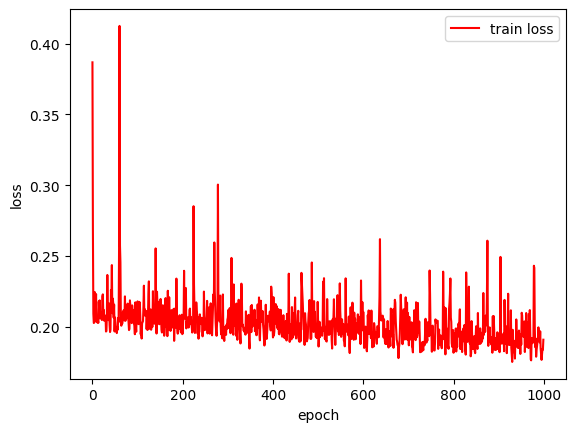

In [16]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

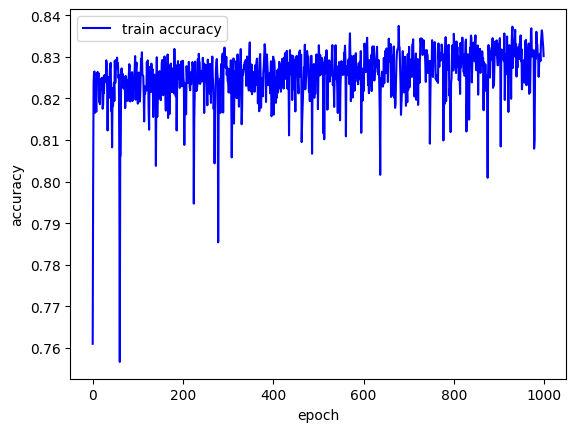

In [17]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')
accuracy_score=accuracy_score(y_test, listarray) * 100
print(f1)
print("정확도: {}".format(accuracy_score))

In [ ]:

print('SMOTE 적용 후 테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
# print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_test).value_counts())

In [ ]:
from collections import Counter
result = Counter(listarray)

In [ ]:
result

### AUC

In [ ]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3


print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))